<a href="https://colab.research.google.com/github/Kimidoge/DriveProfiler-LSTM/blob/main/Driver_Classifier_using_LSTM_(Main).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Driving style classifying using LSTM

Info about raw data:
- sampling rate = 10Hz - 10 samples per second
- Window size = 4 seconds

The dataset includes 4 features:
- Right turn (30)
- Left turn (30) 
- Acceleration (30)
- Braking (30)
- Standstill (30) - to be recorded soon


![](screenshotapp.PNG)

# Procedures
1. Load dataset
    - 1.1 importing the dataset
    - 1.2 visualizing the data
    - 1.3 Balancing data (balancing the data seems to be causing a problem- skipping that step first)
    - 1.4 visualizing the balanced data
2. Pre-Processing
3. Build LSTM model
4. Training and testing

## 1. Importing libraries and loading dataset
- the dataset is in SQLite3 form

In [5]:
# importing the neccessary libraries

# Tensorflow and Keras library
###############################################################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, LSTM, Dense, Dropout
from keras.regularizers import l2 #regularization function
from keras.optimizers import Adam  #perform gradient descent
from tensorflow.math import reduce_prod
print(tf.__version__)
###############################################################
# Supporting libraries
###############################################################
import pandas as pd #used to read dataset and preform dataframe operations
import numpy as np  # perform basic array operations
import sqlite3      # our raw data is in SQLite form
import matplotlib.pyplot as plt #matplotlib
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder #s scaler is for normalizing data and label encoder is to label.

np.version.version

###############################################################


2.5.0


'1.19.5'

### 1.1 Import the dataset (SQLite file)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sqlalchemy import create_engine
my_conn = create_engine("sqlite:////content/drive/MyDrive/db/TESTDATA_real.db")

In [7]:
#file = open('TESTDATA_real.db')   ##open the file 
#conn = sqlite3.connect('TESTDATA_real.db')  ## create the cursor pointing to the table
df = pd.read_sql_query('SELECT * FROM SENSOR_TABLE', my_conn) #create pandas dataframe so we can manipulate
df.insert(0, 'unit', range(1, 1+len(df))) # add unit column
df.head() # first 5 data

,unit,TIME,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,CURRENT_SPEED,ACTIVITY
0,1,09:54:08,0.028730,9.651326,-0.098162,-0.001145,0.001833,0.000611,0.0,Right
1,2,09:54:08,0.028730,9.651326,-0.098162,-0.001145,0.001833,0.000611,0.0,Right
2,3,09:54:08,0.122104,9.646538,-0.663194,-0.001145,0.000000,-0.000611,0.0,Right
3,4,09:54:08,0.122104,9.646538,-0.663194,-0.001145,0.000000,-0.000611,0.0,Right
4,5,09:54:08,0.112527,9.639356,-0.962469,-0.001145,0.000000,-0.000611,0.0,Right


In [8]:
df.shape ## 10 data column 6448 rows down

(6448, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unit           6448 non-null   int64  
 1   TIME           6448 non-null   object 
 2   ACCEL_X        6448 non-null   float64
 3   ACCEL_Y        6448 non-null   float64
 4   ACCEL_Z        6448 non-null   float64
 5   GYRO_X         6448 non-null   float64
 6   GYRO_Y         6448 non-null   float64
 7   GYRO_Z         6448 non-null   float64
 8   CURRENT_SPEED  6448 non-null   float64
 9   ACTIVITY       6448 non-null   object 
dtypes: float64(7), int64(1), object(2)
memory usage: 503.9+ KB


In [ ]:
df.tail() # list last 5 data

,unit,TIME,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,CURRENT_SPEED,ACTIVITY
6443,6444,10:18:39,0.251391,9.988909,0.172383,0.010461,0.000611,0.000000,0.0,Brake
6444,6445,10:18:39,0.263362,9.890746,-0.387861,-0.009697,0.000000,-0.000611,0.0,Brake
6445,6446,10:18:39,0.263362,9.890746,-0.387861,-0.009697,0.000000,-0.000611,0.0,Brake
6446,6447,10:18:39,0.014365,9.522039,-1.103727,0.004963,0.000611,0.000000,0.0,Brake
6447,6448,10:18:39,0.014365,9.522039,-1.103727,0.004963,0.000611,0.000000,0.0,Brake


In [ ]:
df.isnull().sum()  #check for NULL values

unit             0
TIME             0
ACCEL_X          0
ACCEL_Y          0
ACCEL_Z          0
GYRO_X           0
GYRO_Y           0
GYRO_Z           0
CURRENT_SPEED    0
ACTIVITY         0
dtype: int64

In [ ]:
df['ACTIVITY'].value_counts()

Left          1692
Accelerate    1668
Right         1658
Brake         1430
Name: ACTIVITY, dtype: int64

## 2 Visualizing the data

### 2.1 Accelerometer plots

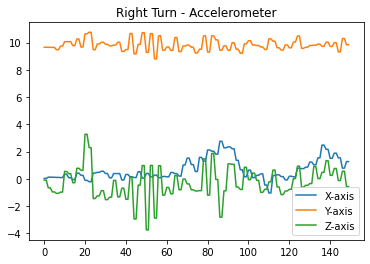

In [ ]:
# Accelerometer plot 

# RIGHT TURN 
plt.plot(np.arange(0,150), df.ACCEL_X[df['ACTIVITY']=="Right"][:150],  label = 'X-axis' )
plt.plot(np.arange(0,150), df.ACCEL_Y[df['ACTIVITY']=="Right"][:150],  label = 'Y-axis' )
plt.plot(np.arange(0,150), df.ACCEL_Z[df['ACTIVITY']=="Right"][:150],  label = 'Z-axis' )
plt.title("Right Turn - Accelerometer")
plt.legend()


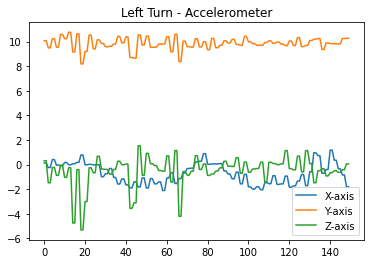

In [ ]:
# LEFT TURN
plt.plot(np.arange(0,150), df.ACCEL_X[df['ACTIVITY']=="Left"][:150],  label = 'X-axis' )
plt.plot(np.arange(0,150), df.ACCEL_Y[df['ACTIVITY']=="Left"][:150],  label = 'Y-axis' )
plt.plot(np.arange(0,150), df.ACCEL_Z[df['ACTIVITY']=="Left"][:150],  label = 'Z-axis' )
plt.title("Left Turn - Accelerometer")
plt.legend()

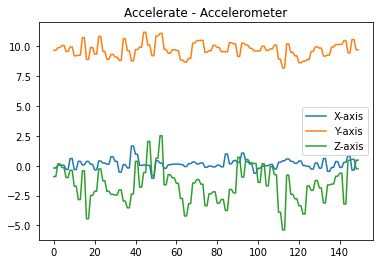

In [ ]:
# ACCELERATION
plt.plot(np.arange(0,150), df.ACCEL_X[df['ACTIVITY']=="Accelerate"][:150],  label = 'X-axis' )
plt.plot(np.arange(0,150), df.ACCEL_Y[df['ACTIVITY']=="Accelerate"][:150],  label = 'Y-axis' )
plt.plot(np.arange(0,150), df.ACCEL_Z[df['ACTIVITY']=="Accelerate"][:150],  label = 'Z-axis' )
plt.title("Accelerate - Accelerometer")
plt.legend()

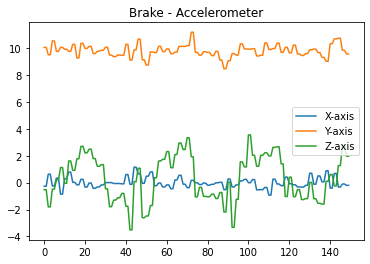

In [ ]:
# BRAKING
plt.plot(np.arange(0,150), df.ACCEL_X[df['ACTIVITY']=="Brake"][:150],  label = 'X-axis' )
plt.plot(np.arange(0,150), df.ACCEL_Y[df['ACTIVITY']=="Brake"][:150],  label = 'Y-axis' )
plt.plot(np.arange(0,150), df.ACCEL_Z[df['ACTIVITY']=="Brake"][:150],  label = 'Z-axis' )
plt.title("Brake - Accelerometer")
plt.legend()

### 2.2 Gyroscope plots

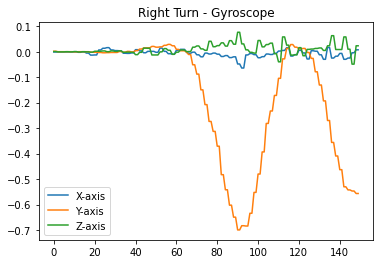

In [ ]:
# Gyroscope plot

# RIGHT TURN 
plt.plot(np.arange(0,150), df.GYRO_X[df['ACTIVITY']=="Right"][:150],  label = 'X-axis' )
plt.plot(np.arange(0,150), df.GYRO_Y[df['ACTIVITY']=="Right"][:150],  label = 'Y-axis' )
plt.plot(np.arange(0,150), df.GYRO_Z[df['ACTIVITY']=="Right"][:150],  label = 'Z-axis' )
plt.title("Right Turn - Gyroscope")
plt.legend()


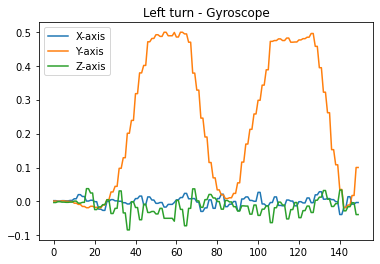

In [ ]:
# LEFT TURN
plt.plot(np.arange(0,150), df.GYRO_X[df['ACTIVITY']=="Left"][:150],  label = 'X-axis' )
plt.plot(np.arange(0,150), df.GYRO_Y[df['ACTIVITY']=="Left"][:150],  label = 'Y-axis' )
plt.plot(np.arange(0,150), df.GYRO_Z[df['ACTIVITY']=="Left"][:150],  label = 'Z-axis' )
plt.title("Left turn - Gyroscope")
plt.legend()

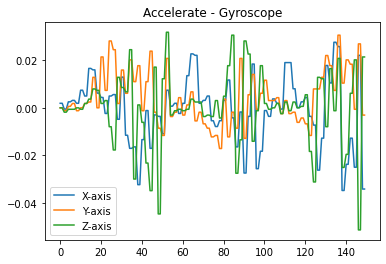

In [ ]:
# ACCELERATE
plt.plot(np.arange(0,150), df.GYRO_X[df['ACTIVITY']=="Accelerate"][:150],  label = 'X-axis' )
plt.plot(np.arange(0,150), df.GYRO_Y[df['ACTIVITY']=="Accelerate"][:150],  label = 'Y-axis' )
plt.plot(np.arange(0,150), df.GYRO_Z[df['ACTIVITY']=="Accelerate"][:150],  label = 'Z-axis' )
plt.title("Accelerate - Gyroscope")
plt.legend()

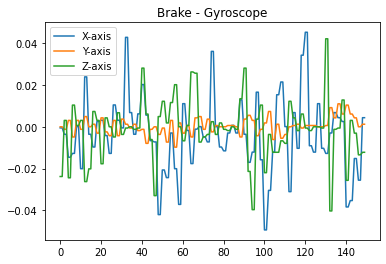

In [ ]:
# BRAKE
plt.plot(np.arange(0,150), df.GYRO_X[df['ACTIVITY']=="Brake"][:150],  label = 'X-axis' )
plt.plot(np.arange(0,150), df.GYRO_Y[df['ACTIVITY']=="Brake"][:150],  label = 'Y-axis' )
plt.plot(np.arange(0,150), df.GYRO_Z[df['ACTIVITY']=="Brake"][:150],  label = 'Z-axis' )
plt.title("Brake - Gyroscope")
plt.legend()

In [ ]:
df['ACTIVITY'].value_counts().index

Index(['Left', 'Accelerate', 'Right', 'Brake'], dtype='object')

## 3 Pre-processing

### Splitting data and labels

In [ ]:
X_train = df[df.columns[2:11]]
X_train

,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,CURRENT_SPEED,ACTIVITY
0,0.028730,9.651326,-0.098162,-0.001145,0.001833,0.000611,0.0,Right
1,0.028730,9.651326,-0.098162,-0.001145,0.001833,0.000611,0.0,Right
2,0.122104,9.646538,-0.663194,-0.001145,0.000000,-0.000611,0.0,Right
3,0.122104,9.646538,-0.663194,-0.001145,0.000000,-0.000611,0.0,Right
4,0.112527,9.639356,-0.962469,-0.001145,0.000000,-0.000611,0.0,Right
...,...,...,...,...,...,...,...,...
6443,0.251391,9.988909,0.172383,0.010461,0.000611,0.000000,0.0,Brake
6444,0.263362,9.890746,-0.387861,-0.009697,0.000000,-0.000611,0.0,Brake
6445,0.263362,9.890746,-0.387861,-0.009697,0.000000,-0.000611,0.0,Brake
6446,0.014365,9.522039,-1.103727,0.004963,0.000611,0.000000,0.0,Brake


In [ ]:
X_train.shape

(6448, 8)

In [ ]:
y_train = df[df.columns[10:11]]
y_train

""
0
1
2
3
4
...
6443
6444
6445
6446


In [ ]:
y_train.shape

(6448, 0)

In [ ]:
y_train

""
0
1
2
3
4
...
6443
6444
6445
6446


In [ ]:
X_train.shape

(6448, 8)

### Create time series

In [ ]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 6

X_train, y_train = create_dataset(
    X_train[['ACCEL_X', 'ACCEL_Y', 'ACCEL_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']], 
    X_train.ACTIVITY, 
    TIME_STEPS, 
    STEP
)



In [ ]:
X_train.shape, y_train.shape

((1067, 50, 6), (1067, 1))

In [ ]:
y_train

array([['Right'],
       ['Right'],
       ['Right'],
       ...,
       ['Brake'],
       ['Brake'],
       ['Brake']], dtype='<U10')

In [ ]:
print(y_train)

[['Right']
 ['Right']
 ['Right']
 ...
 ['Brake']
 ['Brake']
 ['Brake']]


In [ ]:
X_train.shape

(1067, 50, 6)

## One hot encoding

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)


In [ ]:
y_train

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
print(X_train.shape, y_train.shape)

(1067, 50, 6) (1067, 4)


In [ ]:
enc.categories_[0]

array(['Accelerate', 'Brake', 'Left', 'Right'], dtype='<U10')

In [ ]:
enc.sparse

False

In [ ]:
print(y_train)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
print(enc.categories_[0])

['Accelerate' 'Brake' 'Left' 'Right']


#### 1.4.4 Split into training data and validation data  !!!! try use train test split keras

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train )

In [ ]:
X_train.shape

(746, 50, 6)

In [ ]:
X_test.shape

(321, 50, 6)

In [ ]:
y_test.shape

(321, 4)

In [ ]:
y_train.shape

(746, 4)

In [ ]:
print(X_train.shape, y_train.shape)

(746, 50, 6) (746, 4)


In [ ]:
len(np.unique(y_train))

2

In [ ]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
print(y_train)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
y_train.ndim

2

In [ ]:
y_test.ndim

2

In [ ]:
y_test

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
print(enc.inverse_transform(y_test))

[['Right']
 ['Accelerate']
 ['Right']
 ['Left']
 ['Accelerate']
 ['Right']
 ['Accelerate']
 ['Left']
 ['Brake']
 ['Accelerate']
 ['Right']
 ['Brake']
 ['Brake']
 ['Right']
 ['Accelerate']
 ['Accelerate']
 ['Left']
 ['Accelerate']
 ['Right']
 ['Brake']
 ['Left']
 ['Brake']
 ['Accelerate']
 ['Left']
 ['Accelerate']
 ['Accelerate']
 ['Accelerate']
 ['Right']
 ['Right']
 ['Left']
 ['Accelerate']
 ['Right']
 ['Accelerate']
 ['Left']
 ['Brake']
 ['Brake']
 ['Brake']
 ['Brake']
 ['Left']
 ['Left']
 ['Left']
 ['Accelerate']
 ['Accelerate']
 ['Accelerate']
 ['Right']
 ['Accelerate']
 ['Right']
 ['Brake']
 ['Right']
 ['Left']
 ['Left']
 ['Left']
 ['Accelerate']
 ['Right']
 ['Accelerate']
 ['Brake']
 ['Accelerate']
 ['Brake']
 ['Left']
 ['Left']
 ['Right']
 ['Brake']
 ['Accelerate']
 ['Left']
 ['Left']
 ['Brake']
 ['Accelerate']
 ['Right']
 ['Left']
 ['Left']
 ['Accelerate']
 ['Accelerate']
 ['Accelerate']
 ['Left']
 ['Accelerate']
 ['Right']
 ['Brake']
 ['Left']
 ['Left']
 ['Left']
 ['Brake']
 [

In [ ]:
y_test

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

#### The labels are encoded as follows:
- [0,0,0,1] = Right
- [0,0,1,0] = Left
- [0,1,0,0] = Brake
- [1,0,0,0] = Accelerate

## Scaling
-StandardScale() will make the:
- mean = 0
- variance = 1

https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe

how to make 3d input inside standard scaler:
https://newbedev.com/how-to-standard-scale-a-3d-matrix

![](fittransform.PNG)

![](transform.PNG)

In [ ]:
scaler = StandardScaler()
# standardscaler only accept 2D, so we need to convert it into 3D then back to 3D
# we only use fit_transform() on training data, so that it will remember the mean and std deviation which will be used in the testing set
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)  

In [ ]:
X_train_scaled.shape  #back to 3D

(746, 50, 6)

In [ ]:
scaler.mean_

array([-9.66795543e-04,  9.80119899e+00, -2.42860247e-01, -4.09775121e-03,
        2.30926722e-03, -1.42478996e-03])

In [ ]:
X_train.shape

(746, 50, 6)

In [ ]:
print(X_train.mean(axis = 0))

[[-2.20035490e-02  9.78139953e+00 -2.02239437e-01 -4.23572813e-03
  -2.88400432e-03 -1.72942012e-03]
 [-2.20035490e-02  9.78139953e+00 -2.02239437e-01 -4.23900354e-03
  -2.88727973e-03 -1.68602084e-03]
 [ 1.54050490e-03  9.80292487e+00 -2.31753749e-01 -4.31433815e-03
  -1.70567337e-03 -9.86719314e-04]
 [ 1.54050490e-03  9.80292487e+00 -2.31753749e-01 -4.48384097e-03
  -1.78018911e-03 -1.13247536e-03]
 [-1.08637704e-02  9.83823453e+00 -2.11979923e-01 -3.74523449e-03
  -8.92550981e-04 -1.79247186e-03]
 [-1.08637704e-02  9.83823453e+00 -2.11979923e-01 -3.82138793e-03
  -7.89375322e-04 -1.69011508e-03]
 [-4.24922681e-02  9.78131607e+00 -2.37254236e-01 -4.32907750e-03
   1.41825556e-03 -2.19043503e-03]
 [-4.24922681e-02  9.78131607e+00 -2.37254236e-01 -4.32170781e-03
   1.43135724e-03 -2.20189900e-03]
 [-1.61400002e-02  9.80883334e+00 -2.42587834e-01 -4.32416441e-03
   2.71613945e-03 -1.06860473e-03]
 [-1.61400002e-02  9.80883334e+00 -2.42587834e-01 -4.52232713e-03
   2.76281414e-03 -1.2004

In [ ]:
X_train_scaled

array([[[-1.73691452e-01, -1.72058098e-01,  2.34306713e-01,
         -1.39951591e+00,  2.20522082e-01, -6.69991927e-02],
        [-1.73691452e-01, -1.72058098e-01,  2.34306713e-01,
         -1.39951591e+00,  2.20522082e-01, -6.69991927e-02],
        [ 6.49969579e-01,  1.17835238e+00,  7.62003869e-01,
          4.36276370e-01,  1.16010689e-02, -1.67463308e-01],
        ...,
        [-3.62496261e-01,  9.76880935e-01, -1.92786303e-01,
         -5.15615899e-01,  7.15594121e-03, -5.19087715e-01],
        [ 6.99530853e-01, -2.86408457e-01, -4.20569257e-01,
         -1.26353131e+00,  1.82687622e-02, -7.70248016e-01],
        [ 6.99530853e-01, -2.86408457e-01, -4.20569257e-01,
         -1.26353131e+00,  1.82687622e-02, -7.70248016e-01]],

       [[ 1.34146719e+00,  3.18010222e-01,  1.32197029e+00,
         -1.60349286e+00, -1.25303785e+00, -8.95828167e-01],
        [ 1.34146719e+00,  3.18010222e-01,  1.32197029e+00,
         -1.60349286e+00, -1.25303785e+00, -8.95828167e-01],
        [ 2.45541

In [ ]:
print(X_train_scaled.mean(axis=0))

[[-0.02073677 -0.04503055  0.03220533 -0.00767875 -0.01889513 -0.01252502]
 [-0.02073677 -0.04503055  0.03220533 -0.00786104 -0.01890705 -0.01074064]
 [ 0.00247155  0.00392522  0.00880555 -0.0120536  -0.01460791  0.01801149]
 [ 0.00247155  0.00392522  0.00880555 -0.02148684 -0.01487902  0.01201866]
 [-0.00975584  0.0842311   0.0244828   0.01961842 -0.01164945 -0.01511742]
 [-0.00975584  0.0842311   0.0244828   0.0153803  -0.01127406 -0.01090897]
 [-0.04093332 -0.04522035  0.0044446  -0.01287388 -0.00324185 -0.03147988]
 [-0.04093332 -0.04522035  0.0044446  -0.01246374 -0.00319418 -0.03195123]
 [-0.01495683  0.01736304  0.00021598 -0.01260045  0.00148036  0.01464473]
 [-0.01495683  0.01736304  0.00021598 -0.02362869  0.00165018  0.00922425]
 [-0.01089791  0.08301212  0.02776774  0.03215052  0.0069027   0.00484746]
 [-0.01089791  0.08301212  0.02776774  0.02873267  0.00730789  0.00942625]
 [-0.05221795 -0.08008863 -0.01916574  0.04222177  0.01452079 -0.04565394]
 [-0.05221795 -0.08008863

In [ ]:
print(X_train_scaled.std(axis = 0))

[[0.99003579 0.99421657 0.95896616 1.03908338 1.01138777 0.99208408]
 [0.99003579 0.99421657 0.95896616 1.0391009  1.01138775 0.99191672]
 [1.00905402 1.05106109 1.04489979 1.00446655 1.00507414 1.03405625]
 [1.00905402 1.05106109 1.04489979 1.00836567 1.00530754 1.03196417]
 [1.00036155 1.0202067  0.98993738 0.97283473 1.00366037 0.99648565]
 [1.00036155 1.0202067  0.98993738 0.97465151 1.00290797 0.9978889 ]
 [1.00558864 0.97633112 0.99053622 1.03065736 1.00381104 1.01257265]
 [1.00558864 0.97633112 0.99053622 1.03062632 1.00389596 1.01355898]
 [0.98705479 1.00009992 1.00949451 0.97482249 1.0007473  1.01836133]
 [0.98705479 1.00009992 1.00949451 0.97911111 1.00074772 1.01702981]
 [0.98684    0.99312401 0.96419992 0.96888081 0.9990446  0.99370595]
 [0.98684    0.99312401 0.96419992 0.97110436 0.99828134 0.99509846]
 [0.9961535  1.01162018 1.00205236 1.00060831 0.99878288 0.99707244]
 [0.9961535  1.01162018 1.00205236 1.00055376 0.99886739 0.99806739]
 [0.99308007 1.02416987 1.03243432

In [ ]:
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
X_test_scaled.shape

(321, 50, 6)

In [ ]:
print(X_test_scaled.mean(axis=0))

[[-0.00095857 -0.08820927 -0.11907691  0.00417573  0.02676436 -0.04188317]
 [-0.00095857 -0.08820927 -0.11907691  0.0051289   0.02687514 -0.04297857]
 [ 0.02620786  0.03652165 -0.07061611  0.06390729  0.01432908  0.01750333]
 [ 0.02620786  0.03652165 -0.07061611  0.06390729  0.01432908  0.01750333]
 [ 0.09437022  0.01072056 -0.05624663 -0.03564531  0.00456641  0.09488574]
 [ 0.09437022  0.01072056 -0.05624663 -0.03564531  0.00456641  0.09488574]
 [ 0.04636763 -0.08999035 -0.06091819  0.01656685 -0.00951675  0.00161999]
 [ 0.04636763 -0.08999035 -0.06091819  0.01614323 -0.00954445  0.00576687]
 [ 0.06762287  0.00230678 -0.05388276  0.06020054 -0.0229006   0.02360629]
 [ 0.06762287  0.00230678 -0.05388276  0.06390729 -0.02392534  0.02227616]
 [ 0.09732581  0.01911739 -0.06091819 -0.06932374 -0.0384724   0.04598382]
 [ 0.09732581  0.01911739 -0.06091819 -0.07123007 -0.03854164  0.04512314]
 [ 0.07234299 -0.00361348 -0.00351121 -0.11592283 -0.05072766  0.03565573]
 [ 0.07234299 -0.00361348

In [ ]:
print(X_test.mean(axis=0))

[[-1.93923015e-03  9.76241430e+00 -3.93052778e-01 -4.02271888e-03
   9.66537224e-03 -2.44346099e-03]
 [-1.93923015e-03  9.76241430e+00 -3.93052778e-01 -4.00559182e-03
   9.69582038e-03 -2.47010309e-03]
 [ 2.56201955e-02  9.81725718e+00 -3.31928842e-01 -2.94942300e-03
   6.24757184e-03 -9.99078686e-04]
 [ 2.56201955e-02  9.81725718e+00 -3.31928842e-01 -2.94942300e-03
   6.24757184e-03 -9.99078686e-04]
 [ 9.47686216e-02  9.80591271e+00 -3.13804513e-01 -4.73824954e-03
   3.56433230e-03  8.82995273e-04]
 [ 9.47686216e-02  9.80591271e+00 -3.13804513e-01 -4.73824954e-03
   3.56433230e-03  8.82995273e-04]
 [ 4.60716019e-02  9.76163117e+00 -3.19696785e-01 -3.80006708e-03
  -3.06384010e-04 -1.38538911e-03]
 [ 4.60716019e-02  9.76163117e+00 -3.19696785e-01 -3.80767911e-03
  -3.13996038e-04 -1.28452974e-03]
 [ 6.76343321e-02  9.80221326e+00 -3.10822945e-01 -3.01602823e-03
  -3.98489690e-03 -8.50644166e-04]
 [ 6.76343321e-02  9.80221326e+00 -3.10822945e-01 -2.94942299e-03
  -4.26654194e-03 -8.8299

In [ ]:
print(X_test_scaled.std(axis=0))

[[1.00452509 0.99031489 1.02207891 0.998118   0.97627642 0.99053266]
 [1.00452509 0.99031489 1.02207891 0.99802697 0.97647593 0.99286243]
 [1.00287348 0.9478526  0.97597252 0.91315594 0.98549693 0.95786853]
 [1.00287348 0.9478526  0.97597252 0.91315594 0.98549693 0.95786853]
 [0.98949083 0.91000021 0.97231808 0.97184616 0.99042051 0.98527446]
 [0.98949083 0.91000021 0.97231808 0.97184616 0.99042051 0.98527446]
 [0.96538464 1.03216926 0.96226772 1.0180377  0.99500426 0.94102103]
 [0.96538464 1.03216926 0.96226772 1.01808931 0.99500448 0.94054336]
 [1.05066858 1.07096928 1.06269582 0.98841193 0.99576652 0.99660133]
 [1.05066858 1.07096928 1.06269582 0.98745627 0.99629758 0.99469148]
 [1.02030043 0.98024673 1.02994029 0.98104274 1.00058071 0.99640975]
 [1.02030043 0.98024673 1.02994029 0.98005793 1.00057848 0.99627917]
 [0.98503987 0.94940493 0.93501846 1.07991641 1.00522961 0.97704484]
 [0.98503987 0.94940493 0.93501846 1.07991309 1.00522869 0.97644026]
 [1.03232054 1.02168972 1.01092869

In [ ]:
X_train_scaled

array([[[-1.73691452e-01, -1.72058098e-01,  2.34306713e-01,
         -1.39951591e+00,  2.20522082e-01, -6.69991927e-02],
        [-1.73691452e-01, -1.72058098e-01,  2.34306713e-01,
         -1.39951591e+00,  2.20522082e-01, -6.69991927e-02],
        [ 6.49969579e-01,  1.17835238e+00,  7.62003869e-01,
          4.36276370e-01,  1.16010689e-02, -1.67463308e-01],
        ...,
        [-3.62496261e-01,  9.76880935e-01, -1.92786303e-01,
         -5.15615899e-01,  7.15594121e-03, -5.19087715e-01],
        [ 6.99530853e-01, -2.86408457e-01, -4.20569257e-01,
         -1.26353131e+00,  1.82687622e-02, -7.70248016e-01],
        [ 6.99530853e-01, -2.86408457e-01, -4.20569257e-01,
         -1.26353131e+00,  1.82687622e-02, -7.70248016e-01]],

       [[ 1.34146719e+00,  3.18010222e-01,  1.32197029e+00,
         -1.60349286e+00, -1.25303785e+00, -8.95828167e-01],
        [ 1.34146719e+00,  3.18010222e-01,  1.32197029e+00,
         -1.60349286e+00, -1.25303785e+00, -8.95828167e-01],
        [ 2.45541

In [ ]:
X_train_scaled.shape[2]

6

### 3. Building LSTM Model

####  3.1 Setting up the layers

In [ ]:
%%time
# Building the Model
model = Sequential()

model.add(LSTM(32, return_sequences = True, input_shape = (X_train_scaled.shape[1],X_train_scaled.shape[2]),
              kernel_regularizer = l2(0.00001), bias_regularizer = l2(0.00001), name = 'LSTM_1st_layer'))
model.add(Dropout(0.5, name = 'Dropout_1'))
model.add(Flatten(name = 'Flatten_2nd_layer'))
model.add(Dropout(0.5, name = 'Dropout_2'))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.00001), bias_regularizer = l2(0.00001), name = 'Dense_3rd_layer'))
model.add(Dropout(0.1, name = 'Dropout_3'))
model.add(Dense(4, activation='softmax',
               kernel_regularizer=l2(0.00001), bias_regularizer = l2(0.00001), name = 'Dense_Output_Layer'))
model.summary()



Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1st_layer (LSTM)        (None, 50, 32)            4992      
_________________________________________________________________
Dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
Flatten_2nd_layer (Flatten)  (None, 1600)              0         
_________________________________________________________________
Dropout_2 (Dropout)          (None, 1600)              0         
_________________________________________________________________
Dense_3rd_layer (Dense)      (None, 32)                51232     
_________________________________________________________________
Dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
Dense_Output_Layer (Dense)   (None, 4)               

####  3.2 Compiling the LSTM layers

In [ ]:
# compiling the model
model.compile( loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'] )


####  3.3 Calling callbacks to use ModelCheckpoint() to save the best performing iteration/epoch

In [ ]:
# preparing callbacks
from keras.callbacks import ModelCheckpoint

callbacks = [ModelCheckpoint('model.h5', save_weights_only=False, save_best_only=True, verbose =1 )]

####  3.4 Fitting Model using model.fit()

In [ ]:
%%time
# Fitting the model
history = model.fit(X_train_scaled, y_train, epochs= 100, batch_size = 128, validation_data=(X_test_scaled,y_test), shuffle=False)

Epoch 1/100
6/6 [==============================] - 1s 100ms/step - loss: 1.0604 - accuracy: 0.6059 - val_loss: 0.5790 - val_accuracy: 0.9346
Epoch 2/100
6/6 [==============================] - 0s 22ms/step - loss: 0.4947 - accuracy: 0.9155 - val_loss: 0.3584 - val_accuracy: 0.9408
Epoch 3/100
6/6 [==============================] - 0s 22ms/step - loss: 0.3077 - accuracy: 0.9464 - val_loss: 0.2698 - val_accuracy: 0.9439
Epoch 4/100
6/6 [==============================] - 0s 21ms/step - loss: 0.2055 - accuracy: 0.9598 - val_loss: 0.2287 - val_accuracy: 0.9470
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1586 - accuracy: 0.9625 - val_loss: 0.2126 - val_accuracy: 0.9533
Epoch 6/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1499 - accuracy: 0.9625 - val_loss: 0.1997 - val_accuracy: 0.9533
Epoch 7/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1309 - accuracy: 0.9625 - val_loss: 0.1844 - val_accuracy: 0.9533
Epoch 8/100
6/6 [==

6/6 [==============================] - 0s 23ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 0.9813
Epoch 60/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 0.9875
Epoch 61/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0.0478 - val_accuracy: 0.9907
Epoch 62/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.9907
Epoch 63/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0451 - val_accuracy: 0.9907
Epoch 64/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0469 - val_accuracy: 0.9938
Epoch 65/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 0.9938
Epoch 66/100
6/6 [========

In [ ]:
history.history

{'loss': [1.0603972673416138,
  0.49472615122795105,
  0.3077060878276825,
  0.20547659695148468,
  0.15861764550209045,
  0.14994749426841736,
  0.13093343377113342,
  0.1116068959236145,
  0.09887368232011795,
  0.0931655615568161,
  0.08420468121767044,
  0.07986261695623398,
  0.0723162367939949,
  0.06680408120155334,
  0.06218329817056656,
  0.05847589299082756,
  0.05322621390223503,
  0.047017861157655716,
  0.04574697092175484,
  0.040420643985271454,
  0.030906232073903084,
  0.033995963633060455,
  0.029472345486283302,
  0.018397875130176544,
  0.019555093720555305,
  0.02212558500468731,
  0.016581863164901733,
  0.015216950327157974,
  0.01237532403320074,
  0.011567661538720131,
  0.009381372481584549,
  0.011356016620993614,
  0.00978113990277052,
  0.009163212031126022,
  0.01154333259910345,
  0.0073674325831234455,
  0.005942888092249632,
  0.0047308350913226604,
  0.005095055792480707,
  0.005211975425481796,
  0.00640296284109354,
  0.0046651940792799,
  0.00541088

In [ ]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

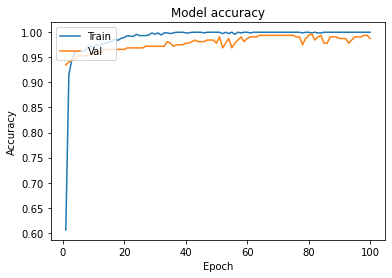

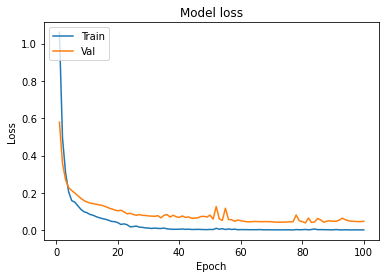

In [ ]:
 plot_learningCurve(history,100)

### Confusion Matrix

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

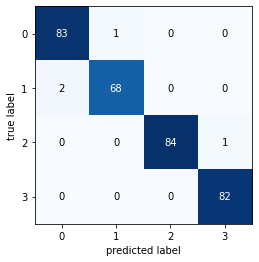

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


#y_pred = model.predict_classes(X_test)
#mat = confusion_matrix(y_test, y_pred)

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels

y_pred = model.predict_classes(X_test_scaled)
mat = confusion_matrix(rounded_labels, y_pred)

plot_confusion_matrix(conf_mat=mat)

In [ ]:
enc.categories_[0]

array(['Accelerate', 'Brake', 'Left', 'Right'], dtype='<U10')

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_scaled, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(rounded_labels, y_pred_bool))

6/6 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        84
           1       0.99      0.97      0.98        70
           2       1.00      0.99      0.99        85
           3       0.99      1.00      0.99        82

    accuracy                           0.99       321
   macro avg       0.99      0.99      0.99       321
weighted avg       0.99      0.99      0.99       321



![](f1score.PNG)

In [ ]:
enc.categories_[0]

array(['Accelerate', 'Brake', 'Left', 'Right'], dtype='<U10')

## Saving the model

In [ ]:
# Write out the Keras save file
keras_file = "driver_profiler_deploy.h5"
keras.models.save_model(model, keras_file)

In [ ]:
tf.lite.OpsSet.SELECT_TF_OPS

<OpsSet.SELECT_TF_OPS: 'SELECT_TF_OPS'>

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('driver_profiler_deploy.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\eilha\AppData\Local\Temp\tmpfzvmf1k4\assets


INFO:tensorflow:Assets written to: C:\Users\eilha\AppData\Local\Temp\tmpfzvmf1k4\assets


ConverterError: <unknown>:0: error: loc(callsite(callsite(callsite(unknown at "sequential_16/LSTM_1st_layer/PartitionedCall@__inference__wrapped_model_288975") at "StatefulPartitionedCall@__inference_signature_wrapper_292250") at "StatefulPartitionedCall")): We cannot duplicate the value since it's not constant.

<unknown>:0: note: loc("StatefulPartitionedCall"): called from
<unknown>:0: note: loc(callsite(callsite(callsite(unknown at "sequential_16/LSTM_1st_layer/PartitionedCall@__inference__wrapped_model_288975") at "StatefulPartitionedCall@__inference_signature_wrapper_292250") at "StatefulPartitionedCall")): see current operation: %4 = "tfl.unidirectional_sequence_lstm"(%arg0, %cst_13, %cst_14, %cst_15, %cst_16, %cst_5, %cst_6, %cst_7, %cst_8, %cst_4, %cst_4, %cst_4, %cst_9, %cst_10, %cst_11, %cst_12, %cst_4, %cst_4, %3, %3, %cst_4, %cst_4, %cst_4, %cst_4) {cell_clip = 1.000000e+01 : f32, fused_activation_function = "TANH", proj_clip = 0.000000e+00 : f32, time_major = false} : (tensor<?x50x6xf32>, tensor<32x6xf32>, tensor<32x6xf32>, tensor<32x6xf32>, tensor<32x6xf32>, tensor<32x32xf32>, tensor<32x32xf32>, tensor<32x32xf32>, tensor<32x32xf32>, none, none, none, tensor<32xf32>, tensor<32xf32>, tensor<32xf32>, tensor<32xf32>, none, none, tensor<?x32xf32>, tensor<?x32xf32>, none, none, none, none) -> tensor<?x50x32xf32>
<unknown>:0: error: Failed to duplicate values for the stateful op

<unknown>:0: note: see current operation: "func"() ( {
^bb0(%arg0: tensor<?x50x6xf32>):  // no predecessors
  %cst = "std.constant"() {value = dense<[5.58075495E-4, 0.0313672647, -0.0188098513, -0.0246837344]> : tensor<4xf32>} : () -> tensor<4xf32>
  %cst_0 = "std.constant"() {value = dense<[0.0168908536, 0.0328395516, 0.032890223, 0.0250963103, 0.0189044718, -0.0114660431, 0.0205141585, 0.0246794671, 0.0165602472, 0.0507745668, -0.00160693936, 0.0168250985, 0.0210511424, 0.0273013972, 0.0362471119, 0.0202392936, 0.0296635088, 0.0094857458, 0.0339091942, 0.0257274546, 0.0100004124, -0.0119953547, 0.0321875811, 0.0217365436, 0.0301411357, 0.0284080133, -0.00616158592, 0.0177836455, 0.037834093, 0.0353285074, 0.0446266644, 0.02094361]> : tensor<32xf32>} : () -> tensor<32xf32>
  %cst_1 = "std.constant"() {value = dense<[-1, 1600]> : tensor<2xi32>} : () -> tensor<2xi32>
  %cst_2 = "std.constant"() {value = dense<0.000000e+00> : tensor<f32>} : () -> tensor<f32>
  %cst_3 = "std.constant"() {value = dense<32> : tensor<i32>} : () -> tensor<i32>
  %cst_4 = "std.constant"() {value} : () -> none
  %cst_5 = "std.constant"() {value = dense<"0x507631BD189A80BCD5C2733ED4E290BC50CED43C3A5D883D59216B3D5C8655BE8DA77EBD0730CE3D28808CBC9849F7BDB4B8583E83AFDA3D253A9FBD61E09CBDE40B5DBE664A90BD1FEA963C8C7182BDCB83E93DD8643CBED633A7BDF8BDD63C5D85133DECE2E1BC32DDC13D878B92BD967B4BBEA4FC79BD4EAA463E394DBCBD123B213E5A4FEB3DFE63213DAA4C1BBDCF4C0BBE42B7C8BDD6D4763EDF66383D4D77013E7DE276BC63681FBE5EED493E24CBF03DFB4F2EBEBB8F35BDC0BD873EC5CFB5BD9A47F5BD1635133E02FE91BD6A9FC43D00BD12BC5BB1DDBA655EC83BD6BDFFBD04989CBCEE7D1CBD63D1923E82C2E23DEBED683D6F5847BEE346303B28D211BE626421BE197FCB3DE85A0B3EB19C9C3C835B9A3D9EB8A93DC91A2ABCFB0F0D3BF6B73D3D0BC8E13DDE5C2ABD49DAB03DBAE6A13DB4E50D3EF6557EBE65EAC5BD275A293D3222D13D39ED703D85EACC3C15CC24BD059A173DD2DFE23ABAE0EEBDEB59EBBD757FE23D13359F3D27BD943D117A463D1B030C3D02F06E3D7DE9E3BD27E9C83DF0FF763EA9CA9A3D145B5D3D69327D3D0558DB3D3E1290BCE95C043E44038D3D360E073D6F55903CBE839A3D41E3A43D5605833DAD75003DBFF1EFBC6105823E79DD55BD44C2C039373E503DEE3C0FBE1AFB41BEDB8A83BD64E6AA3DC70328BD85C1E2BC390B40BE694393BE45AE373BD5D6313E577F2C3DC5FC28BEAA9DA9BD379C1D3D5EAC883DDA5F2C3E833B7EBE9818F23DE91F25BE8185A63DB990943D78F86ABDB9B603BECF89003E23F7E23DAC304CBDC9D2713D93FF21BE7F2FCC3B854F30BE6F59953EACD6B73B4D09EFBD330599BEB29F723D52C75A3E5A8282BBEEDE983A9BFD8ABDB2CF45BE828397BDB8DE223EB6A0D9BD323644BE5159BF3DA9960A3D1DDD76BD77B6FFBC97B1CA3CE4148E3DEE03333DC7474D3DE739A2BBD9314DBEFD7A343EF810FBBB472B68BD4BC796BCE7E36C3D1530B43DAF25973D3252B6BD66F013BECFCA9EBDF775063DEC16ACBCB961D4BD1A0445BEB7DB2FBDD0A259BD22EA3B3EAA6F2C3D6676E73D714097BDE439FB3B214DD8BD13AF73BDCEAF8ABD2659093E4D8E123E268C593D9568F1BDBA158EBD23F03EBDFE1C4CBC39E61B3D2925DABC65DB803B824EAC3DAA963D3A546F84BD1662AC3D17FB3B3D5EFEDD3DD0770B3DB1AD343D8E25E4BDBBF5D1BCED97EEBDF22EE5BBAC94A9BB818D1E3E23AEC0BDA52E29BECAFCE63C7AF04BBD7FBEFF3D89FA64BD95E397BB6CB34D3D3594A13D1AD9983DFDFE41BDE4A0003E6570A5BD62AA5D3D71C02EBE7EC644BD7F9BDEBDD2937E3EFBC70D3D1A5C93BD103F6F3C1B03EBBC6BC7323D1191193E5B6A823E1C26703CF3B1F4BC482E413E150D973E9F75333D44BFE6BCBDC10D3E676864BE6E5973BE7A09A4BDB1A7BB3DD1A0D5BD67FF34BEF6A2F73DA6D2C73D86B6173E2F174A3E4595793DAE0565BC8CECDFBDEB48D13DFAD1593D91C986BC5AC3CEBDE017633DA9F39ABB7187D83DAB85DF3D446B993DFBC54C3E9D312E3E2D6F86BCC42F2F3DF0BFE8BB594332BDAEE24BBDE91977BD461DB9BDBE34EFBC11AD3ABEEB47E03CCA3DBFBDFFBBA33C0993FF3DAD0BE4BD145AE53C65D9823D0C8CCFBCDCD54D3D803EA83B61AEA73CEA2809BDF264AB3D0444173D804E083C87A3CF3DB82EF63D0AC5273EF1D29BBD0D3DDA3D9B49B9BDF2EC993DABD2743DB6E7583EBB8EB03B22C534BE6A7BABBC7D4626BD5FDB56BD2E82F9BD059280BE89FC0BBD535781BEF34D15BC4748013D0D3A9FBD70E502BC18E3EBBD57AA16BD31E2203E8FD9743DAD0193BDCA90A3BDE04E93BEC70BFE3BDF0BE93D3C96413EFDB7A93B088D573DC825513DBFFE923DDBA1A53B7DE4A9BD5DBBBC3DDD68953DF84BB3BB0B5D20BE0A4B803D8019733CA83D07BE7E8555BD0F94D53C47316B3D2DEA74BEEAE99BBDDD5A323D0A7C8BBDA89A98BD4F4AA0BCDAE7EF3DAB2962BD6A0E7FBC8E07A8BD3475353C3723CC3DB79FDFBD09AA753D4EE79B3DD9AA503D2E038E3DE6A1F83C581985BDD781463E6E15703B0B46A0BD00D4033E1E0F3DBE94044B3EA05CC63D1FE330BEDB536D3D6ADB47BC310822BBB7C785BD7C320E3D1B8D1FBE76B3E3BDA5A143BD4E93BD3D64B3A9BBC34F86BD827F8E3DF18E47BD0EE1743E191C9B3D3A58023E47376FBE2FFA66BD5364B73CC712BE3D847E273E2D5A56BD328A7FBCA560833DACD6CFBDA8FB2C3D616540BCE34832BDDBB482BD8C07F2BC10E40E3E5F32D0BC5ACA953EA29D623DD85CCF3D3B738CBDBC6AF7BC99EB2D3DA7921B3D29280B3DD35C3B3E5EC9CFBDC4FADABCAC90393D9A68513CFB64843DBFCC893CDFF68B3D6864AABC23DAA8BBA2E530BDEDA32B3E02ADBE3D2031ADBD56A64B3D90FEB73DEF50623DE58E82BD1595D8BD17DEA3BCC01234BD424FF13D2C725EBCC9046B3D12A1ADBC078069BC90DA00BEE378DEBDDDBFE9BD9FAF15BD10C8FBBD6C9AC5BDEBE8303D4E1633BED9D6343DE461F23D793ADBBC4156CABD2F7EAB3EADE2C33B9D850E3E8875A73B6E09F93DD7F213BD06B5D13D5B6E4CBD9DE8313EB5753B3B43A7BABDAA91C83C563B94BD22ABAF3D3157843D9057C53D3E17F03D733B2DBEC670A4BDF5F9A43C1D5ECB3D7021EDBCB4B7A9BDA9B552BDDC1E04BE07BAB33DE1519ABDCDCD59BD2D438EBC24AC083E73F062BC698B35BEECEE983DB75F2BBDD3816CBD44558A3C3FF3CEBD16F3BD3DFC40AB3DC3158E3D012F133E380A3EBE527FC6BDF7A7863D6520F83C22003FB959A482BC340496BCE1E38E3D38C19F3D9A42E73D38DBFDBCB9B2213E8BF8AE3DCDB703BE133AF43B8921803EA6AB9EBC9C6E503E9ED3AF3C6E2892BD6384D8BD283EB73D05AB193E56D2C53D36DCC7BB2CFFAE3D85BA353DFE26F73D81E7023E0C91043DF8FEA53DCB71EBBD6A7C573CFAE1BC3D34A098BC3964B33DB4930A3ED149683DE522663C7B2F8A3D9518AB3D0E8A49BDD1AC07BD33DB1E3D2D6B01BE295BE8BC7C9469BCBB6787BD75385F3E6AB1173DF6721FBDF1ABF53B66A670BDD68AC7BCDC584CBC2E5B1E3E05715ABE3D70983D07ECE1BDCDE0803DB25EC2BDC77FC53C5A34D6BD500351BC1DBEF13CE43B4E3DE6ABF6BDAF2F993DEC1AFA3CBAD8DE3CD118F43DD30C893D995EBA3DE21B59BB1EDF983DEB603D3E82996ABE042190BC10E40CBB0E696EBE3F509DBD0199FF3C41455DBE112BC03C91D034BDAD37613D197B143E5F736EBD7484433E5F6FBF3C6555AABD0B38E33BB82D4F3DF8BC65BDC0AFD63C9D2FBF3DFFD2EFBC744D053EDEB12F3E9262153EA2B08CBDC77FB13D1C9753BEF6DA6EBD18976E3DFD9BC13D60FB54BC64D80EBE3ED7113E012B053DED3D81BEDB58613DC4FDF03DB009BFBC896BA93D0716D3BD25E5A13B0B05B43D711A81BDFF2E343E7AD0A1BD71670C3DD208BE3B8CA08E3D74DE73BDF05F893D6F040ABE51E5DF3DFADD92BD6CC0C0BD84F20CBD14D5AA3D6027F0BD2854B6BC1B61E33B6B90D2BA45D8873D22EA22BE03B4E63D831522BED0EB4DBDDA4A4B3B9870CABD38649DBD0C445ABD230F4BBC80059ABCE11FA83CA79696BD6B5F793DCCE113BE460FB4BCA7530D3EF41BA5BE057A393DB0B8BEBD8F48873CCF469D3CB15397BD70B988BDE5D6B3BDDBE214BD1874DB3D681396BDD4DCB73D5FA99E3D1036E3BD449D583E2896303EDF4E90BDF80395BD3C3D103CD789043D77055ABDA5666ABD623F22BE1480BCBDC45E83BCEE3AA4BDCF8108BE65534B3B24891BBDF2EB233EFDDB033E042257BDDE83C7BC052A0D3EEC321BBDCDFBA6BC9C6803BEF3E3683EB263ACBC8F3BFCBC54B9BBBC7BD5053CFDB8B53C0FDF76BDCF64983CFA5C44BD114507BEB730013EABE9973DE124A83D5AC80BBD816A0F3E125E0CBE50B615BC4F81183E3F8676BD724E0EBE9577503E0FC17D3D02C2353DA93343BDEF16053C483063BC424C0BBEE0F3FB3C1228DD3D643EB6BDF9A5773ED3BBD33CE7495CBD2C08193E43CF043E75A9413EDFF4B4BB2DDA4A3D13C3163D0992803E17951ABD0B754CBDE7B19F3D214B023E24330DBE72291DBE020DAD3D9FF8DCBDFCCF4A3D2DDED03D856E50BD31B9823DD04D383EC1585D3C294CEF3DBBB9053EC4AD1E3DB529773D42BFAA3C63112FBD9B37D8BC64FDE5BC77E9603D4D3023BE746A82BBA469FB3D2445253E31B338BEF3A66FBE3D8AEDBDABAE21BD80003A3D413D0DBE76D3AB3D6A7B423E5AA9EB3DC7264EBDF71127BEEFD8E7BC5FCBA13DEF7428BE0CB841BDBD10443CD7C8C2BD79E33B3ED13E28BE403CCF3DD87C043D6CB8843D3A6BE53DE34BA2BD3AB6CB3DEB726FBE840B613E582504BE4942FCBD247817BD941DB33D4B6E0B3E7F778EBC3B6C423C812E313DBA1B6BBE65703E3E6E93E2BD55035A3EFE70CCBD384F44BD7E4B7EBDB86671BEDA03023C3B29253E07F21BBEFD8B8DBC246FF43D210A853D04CE363D5F26D23D282E42BD411FDFBB2C94B93DFEE365BABDE4DABB313F683D807C02BE142A9ABB54EB36BE946035BDC7EC173E3F159CBDFE8A5C3D863E883D792E96BD6A0B113E856290BDFACE723CE9AD85BEB01A6CBCC04E053DBA073DBD8B00E53D218D29BE90C7B4BD3FE3F9BD31A4CFBDD59C993C0BCD7BBBDFBE0B3E4D27163E681A46B85A5FE2BDAB6D413EA4052C3E6092E7BDF0E1313EF8C3273E2EF965BDC27DDFBD69229ABD5DF9C5BD4C7C223E3BAF283D7A4B873C5A28793CBA7762BCA7B1363D741798BD8667CE3D8660903CC2982ABDED76E13D762315BD21C90B3CF8608B3CAD73CB3CC699913D4437563B15CC87BDDE4E8ABC6E0F353E46E3E9BD24A728BE31A895BC8BAB193EA779423E1F875D3E04595EBEC137213E8BA5A8BCE6C0C93C34BABEBB5D931F3EEDA21EBD56559CBC927A47BC3DDCF5BD43207FBD0E5013BE14549EBCA660873C01B7053D29CCEABBFE40B43C02F247BD3FE3E03DD9D0D73DC7D7B5BDE3C49D3D0888C33D568F87BE5A5885BC5F14B43DC09582BDCC5F9DBD7099983D98A61B3C7E3A513C59CBE83D9EF3BABDAEB49FBD1CF07EBC769D093EB57D7E3D125B0E3E0E91F73CA754D53BE59B5F3CE0AB84BD3E73193C3AB6143EF816C1BA852507BD21592A3D1859AABD05F311BEE00BC3BD494C4ABDE42DDC3DB3D2503DB129DF3C4B3D3F3E33DAFCBC8D6B193D7DCDAB3CD6E093BDA9F1EFBD9459393E6ED846BDB161AABD93AF0CBDEF4BCBBE807486BDEEDCC43DCD49FC3D1E8323BDB61BD83DCEF138BD0FEB5A3D9214E8BD9C4805BD30872E3C54ED223DCE57443CAF2E0D3EF4FAB73CF8CC103EB953BEBD9284B2BBD0F009BD0490B43BA79685BD85F12BBEF57E893D637435BDEBADCDBDFFA5B2BCE39186BD49E3C8BD905C433D9D049D3D306E803B414DB8BC8A1B5ABAB2DD583DE26D9E3D3421823D9DAB51BDD21CA9BB29CDEE3B821C9B3C1B529D3DBB92A03DFCFDF6BD219F2FBCD13331BDCF9F103E0FC4833D685E10BC5F972C3E92F7E2BDF2D3293DE3EDC4BCC5041D3E3E7E48BD9992F1BD19B61FBEABDF05BE2A03DB3D58DD813BA92B07BD06F7BDBC7B20983A05C7383EEEC0B2BC8D646E3D3391533E14B3BF3D2FDC85BD8BC0C6BC9A8EFFBB97D2013DB63902BE4A214A3C2459E43D3EAF823DF3CD253B2008A5BDEE59D73D424DE8BD130735BD1E818ABDEF9E433D5A7F68BE8131F93AB20927BB599D563D932DC63D205D933BF7C3D4BD3BEE20BEA67AD1BC"> : tensor<32x32xf32>} : () -> tensor<32x32xf32>
  %cst_6 = "std.constant"() {value = dense<"0xC5098CBD408DDBBC314E433ECD6BDA3D6FC376BDE191E8BD0C83AA3C26A7D03CB6A3F83D69AC083ED3E450BD7C1A2ABDD5399BBD5B4856BC54154CBE3610BABD3294B3BD1893033E362EEDBDEF55183ED97FD3BD265B0DBD122FBF3A4B74C13D26DA24BE78D53BBD60E313BE877537BD040A32BE0875183D284C733E40E93ABE6F4A1DBE446D363D7F31A53DA8A13FBEDF0512BE481965BD700C303E2FF7713DBD1BB33D7674993D0B94F8BDF70F843D492C133DC68D4B3D83848CBD714A83BE585828BE46D8CB3C2DA0913D508C04BDA8BA58BD00A6653DEF5EE73C84C8FEBD3DE0363E1DB98B3D50C13EBB254D7ABB66367A3DD90590BC0D0B0DBD0E1526BDE2836CBE1CDAF43C3FDF04BE8037EA3C9E6CD53D2D47F03D2E19993DEF0715BD444894BDA5CEB4BDFF00883EFD3329BEC60E943DC0A9543EC634BA3D2D9FBE3C9F276BBBAD6B13BED11EC0BD28F6F7BCD6E292BC1005813DBFA0E6BCA8C6FBBDCB88D7BD4320693C505877BD91EF973BA857D6BDC3DCBC3CF23F343E66FF3ABD7607313DB3CB873A43BC983D4674EDBD67BA333E600CA43D156D443EEC14043D095075BD70907F3D2D97AF3DFC4C023D797540BDB7EC873E217008BE14C61EBDCF8918BD98B94A3D5081A0BE8C24693E16E5923D9DF82CBE473210BE819969396CE6103C0C6014BA8111463E767084BD5D820FBE0596083E96E3353D7198F7BD7A7795BD9EBD4CBE97997F3964E3073EEA25A13DEF2CAFBC2767F93DA18BBBBD57C80E3E0F016C3D8F06A33CC430F3BDDF9BB83D28BB153CACEEA33DB38708BDFD3596BEB458823DEFC09CBD4702B13D98C38CBE31E3FA3D30208ABD127526BA173F0EBE738194BD7BA690BC3C9092BE601503BE3FCBF33D2D11BA3D53F8B3BD9027133E12337D3C45A1ECBC66CFB9BD1B8615BCB353F03DE30ADDBD179F48BC73865F3D7940143E5891CCBDCE29473C418D113D7A6D22BE56540ABD2416123DC870D0BC937B02BE60E5B73DD03833BEE59C253E7466013B4FB737BD97C3E73D11E584BD25FB643E2C465EBEE67CDB3DD355FFBBB384A63DBC361DBED28A29BD04783DBE0B9316BDB2456A3CD6778A3EE5F90F3EADD8683DAB65C83B957FD4BD6B0085BDCF998A3B1604CEBD679901BE05EA723D82D0BB3ECD4C66BD3513E3BD85A2113E1318353E214D1F3EE545C33DFD5391BCD3CC123EA1636A3D1555CFBCA127FCBD32CBCABDFEE416BE911A0EBDFC0D75BE7FD89C3D75B95E3DDB1A28BD5456C4BD4DE1333C558A2A3EAE631C3E9BDB9F3D0A77D93D4DA5063DB06E873B14E73C3E1B11D4BCED3CD93DC38C13BE02A077BCB9C59D3D8394F8BD2FD506BE8C5A00BD24C3AC3DAB09053EE749D53DD09D913D8832453EBD6EC4BDAD8538BD35244ABEB9CC20BE57AD3F3D9DD686BC40B067BE8628283D70B2BF3D402B8BBC5B18203C106F063EBE91EE3CCE63E83C9E833B3E420766BDCB53463E2975C4BD72E36FBC386B143E00B6A3BDFED170BE3EA5B8BD918D3C3DF1A4CE3D2842233D41BA8D3DBA9A8B3D7E37443E583602BD667E1C3E3B1716BDDAC20DBC4CC6CF3CB35E53BE28BE85BDB78779BD476908BEE4DE7D3D84B1313D8D9C89BD05B8363EDF2213BE8419A8BD95D1B3BC1E265C3D7077473D6F631B3DFFABFA3DBD1E2DBD693E563D85EEE4BD1409343D5DB231BE18FE87BDA148AA3DA9127EBDEA921C3CCD9CAB3BBFC1063D75DD7B3D2737583EE6AC463DB65CBEBDB248C6BDC24EC83C86AE273EBD67E0BD120536BDB186EFBDFFFCF1BD53FCD2BC5042113E7478A7BCA870343C0D47FCBCDEE88B3D65A5303EF03D993EEA11073E51630C3E4384803C68E0C4BD9B91FE3D6133303E133B53BD97CD51BD6359843EF4A1A03DDF1629BE961D983D59F387BB7CAE65BBA12C083C1EF0673D21AE923DFAD1E23D717ACC3D54AE09BEC4054CBE0DDB39BCE4389DBDE46E89BDC4E5EFBD4FB70BBE18D519BCA1236ABCD0CB40BDBECD49B9DD73093E137774BC0FC1193E0FD3603E6CAD38BE189C303E261E023EC8A3AA3D53EB5FBD69E438BD598D1B3EDDBDB53C6D7225BD738C063C03EDC93D519D053D67CE233EE07DD8BC81E5AE3DF8CA0EBDEB0414BE9AEFE2BD0F038BBD271CFDBD77A817BE5E4AA53D86A5B3BD6C5E12BC009A1DBCCE4AE6BD7FDBAABD3F9B04BB30F09EBDB401F83DCFEDA03CDE9161BDCA28E5BC73FEEA3CC661CFBDADD37E3D761BD03DD98682BEA1ADEA3DED542BBD94D7663ECF4097BDECEF863B2765B7BD38A9E8BDCA346B3E9D7F5F3EB937B03DEA4F633EB32BBFBD2CD3D2BD0B5510BE486D81BAC067F8BB37C497BDE77D183E35680CBD4D7318BE0BF690BD771EDDBC08EFDFBC1F3B783D5BE3B7BD5CAE823DF166FDBD2C76A4BD0F458B3D1A2DC73D2E35A53D0AF19F3D74BCFB3BBA7FD03D4BC6143D8B0EFFBD3C32B83CF64F3EBE499F91BD00CC98BD8E69563D1BE20CBD320968BEB7294FBE707D44BC98DB89BD0AFFD5BCAC614CBDFC1080BD16B4FBBDA8A603BE50F920BE2AAE16BD3249CC3D69E3483D2DD4193C7FEBE83C267E0DBDE4541C3D65B62E3E2690D43C74DE073E2DC0C23DD7A1C43CB4F6FC3D3F9A26BE89CF10BD0CBF273D197AA43D5E071D3E04EA8FBD4DE08D3DE34C9DBDAF4C3C3ED83491BDC1530BBE2D94473CD37BBBBD0D4D613D71F27ABEDC3DB93D7FE5E3BD78C76F3C95F4F7BDBF13B03D8493813EB1F68B3D7ABEF0BD5148ACBD0107F13D7B6F55BDDBD1653E0EE02ABCFFC2ED3DE263B23D00600C3E122D7FBDCC9671BD55DE25BEAD61AF3D4D0A16BB7A4C98B79C7EEB3D9F3924BE709A49BDBB745DBE3270E23D45F1CA3A50DB4BBD74271CBD46B7CB3CC935DB3D84F584BD15F4B83D25D9C33DC66E153AAD1E5EBD201B063E60C1F23C2FED823BE5EFAB3DB53F00BDBF6CA0BD3ADDA7BCC075313C13B0E03D6BF714BE75AF0F3D2B923C3E9DF7693E11EAE3BC9D939A3DE61845BDB0E7E63C2A0D6E3DFDDD41BCCB3A0C3C1647133E5238FBBD969535BEDA42F83CB7445ABD2C0F97BD426632BD3500F43CD26E9CBCD228D8BCD966BABD535E2EBDC3931CBD6191083EE794893E50DCC63CF10EEABDEE0382BEA2FB123E8D6C113EF461A93B4DB0CABDBB7607BECB98503E89B27F3DA0CC8CBD865EC4BD411B253E4373023DAC9A1B3EA64BAB3D2066C03DBED7853C6B07B0BD07880BBED6BCDFBC7C67853C430305BE05E240BD2CF341BD23EE443E5DEE2BBECF82053E86BB423E6A6DD63D5A3E62BC96A89F3D12C618BD4EB3CDBDF00419BE172C1B3D2E857CBE0DEB44BD7071103D40A961BD333322BD91D5173E301DD7BD995687BCF409E23D647A74BC102A7FBD82641BBEF9E0DF3B58BC263E41A8FCBDE8188DBD15308039C9824DBD11D3043EAC5BF93C23200A3EF9EBDD3D98DC643E9CAD44BD586B16BD74F9643C1DDF9D3D827465BDE5567BBD5863883E99B9BDBCC8DDD53D5B134A3D3E713B3D0FF99A3D542A413EB792603EF755DDBCCDAC24BE7549C4BB9D6B2C3EFC30873D67F41ABE31AA1F3E9C96553D55D9DABDA749F43CB91F413DA20FA2BD5450ED3D1B4649BC650839BDF33B033EEF11233E1710FE3D607F31BE9B5CD93CC9218D3DF935823CF65F51BC485D433D44D305BE034BDA3D9E16E4BC8E27DFBCA4F70C3EFD83D6BD156B67BDF5963D3D740D72BC46B811BE2EEAB63B2590D23DF7A7873D9EB5E73D981A253D7CD51B3D6EB5E1BBA13D6C3C7FC555BEF1DE003E030E43BED3CCDDBD0CC1083C6D480D3E27F39CBCE5F59EBDBE5BEBBC15AB0DBED3ADCABD42811FBDBD2B8D3D8380E93D53088CBEF439E93D51DAC83D1B2D083E8AC177BE9B90D23D63FB133D56C2AEBD33BE3FBDEFAE47BEC54D2D3E1D8F89BCA810143EB3F981BB2418C83D09D9CE3DDDFF1B3E089D16BEAC32B3BB0EBF1FBD5CDD08BE84FB33BD97582EBCF5B0C7BD50E961BEF14421BC34BA29BD35B656BC382A8CBC1A91A23B1BE90DBE8769FC3C60DB043E88F96BBDC286D0BCE361973DB3156B3D3DD1773C1431ACBD1156DDBD91D2893D5211C3BDA724B93DF8A8BBBDCB4AB63D0785FCBC667735BE0B7EAEBC9AA23E3D3D00FEBD2B0B2DBEAB0A57BC30FE543B4AEFC13C42F6113EA1BB3EBE84332DBD041F88BD6705F63C2891C9BC8F4FB23E23D90A3E5336033C78C1603D1818E5BD17269E3DC92954BE6CC1A5BEA3888ABE07848E3DBB4E94BD92FBCB3C96A835BE984D17BC99D25ABD1EEC1A3E2798AD3D18FBCFBD011E0D3E7264343EB4F0833EF7A8E4BC47EA46BEB1FBC2BCC13EAA3D402DCCBD930D20BE38884D3D4385B9BD9779C23D62180D3C1EBBF3BD0ADCDF3D692B70BC5F60343D37A01A3E6EDB92BDA8DD43BD771698BD7E1C023E6868C9BDE5CA633D5D7248BED8C4C73D40FD8ABD9A3D9CBDB29D723D16E1843D8974F93C15A433BEFBA14D3DB461A43DD501723ED81BE83959A88ABDCF3906BC838E29BE76DB0BBE7D1F083E5BAECE3C450AC9BD6B680F3EF1539CBCABAA35BDB932043E7EE92B3D61C20E3EC709583B12091FBDCE9A2EBDD2530F3C3959BB3DF56327BE246ADD3D8C5864BC18D9573EC2E000BDCCC37B3B3B14623EFB87FABDFA9604BD6AB096BD8852A7BDB8AF993D3C58203EB2E94D3EE5C4543C7C9B503C04DE4B3CE0F1E4BDDA4914BD66E4BA3DD493833E924FDBBD56781EBCFD9B863DE772C63DA636A23D710E58BE44EA6CBD3C26AE3D8BA4CD3CD6F510BE0CBDDEBBAF5320BD93791A3D26BA8E3D2752D9BCED992E3C586BBC3D49222C3E8D74033DEA6C1D3DC97ED0BDC7190DBCC49A593C7131D7BD4E4DD33D62568B3D7201F13DCD26C6BDFA67293C7E1D833DFCA43B3E107C2A3D221DD6BC50CEBEBDAE23823D1723393ED7E7053D9D5D9CBC7DEEADBD19F96E3D9E1D2E3E98DCF6BCE4C92DBD7BAF1EBD347BD5BD03E32BBD4D810F3D106320BC3952AFBD48B2143D52AF57BBCE1016BE47686A3CE730CB3D433C003D9FE2DABD5CB985BCBB319B3D9A67E4BD747ED43D5B2C7EBEE33B093D3AF9B33D248A813CC81C02BEC0B7EABDD9013A3EC296E33DC65B9EBDD453193E0EDD7DBD0C07EA3DFA7298BB7791623E7994103CE63DA6BD84B015BEAE1DF63D6A2A40BDAB1B0EBEB68F373DB18BA8BD930414BDB8A2A03D3E6B393DD0C1CABDA01F8F3D5DB141BE4AC43ABDD66CF73DBA42263E63ED9B3D39E7CC3DF2C5CEBC39AC863D26F1093E42230EBE7FC4403ECB9A4A3DA82206BE9557DB3DBFD3ACBED2CDB5BD92435C3D411B563CEC92B43CD0BF26BEE17BC6BD332AC13D427CEDBC74E0DC3D429D4FBEA21910BEC5221B3EFF5F5CBD01467B3D7DB8A9BD1E9EF3BD402DA9BD5BC6433DDFBEC53C506D9C3C7EDC233E931AACBD1382073E2139433D6B35F7BB3F2B36BD23D99CBDB5F4A9BDAB35CFBD82A8EFBDFADC693D181BD93B96DD56BB2A81D8BDEF51B4BC28E4BABDA614803D811B3BBE4C3272BD8E8B07BC3F0DF53C223821BE0FCC12BDD705C73DA3630BBD3515393DAA7E653D37D7D8BD5E9C6EBD91F8023DDA0698BDA9E405BE47E658BE54C5063E8C79DEBD69B0033EAB02E93D11332A3EE4C7643C517B2DBDFC0E88BC5FE027BD2EB9F6BD16540ABD1422D83D5EF172BEC8C374BD6516A33C820F72BDDCEBFBBD11F12C3BB00A183DD398593B3F8F413E08A8C03C2211003EBBBAA43D8155AD3DD990E33B5AA44EBDD792D2BC1FB854BD63FC45BD9F5D50BD7A0229BDA7B0D8BDCBA5E83CBB36A7BB7A5246BD246F16BE1D03DFBC"> : tensor<32x32xf32>} : () -> tensor<32x32xf32>
  %cst_7 = "std.constant"() {value = dense<"0x43512EBE2D7D3FBDC919BFBD6E77B93DE12A51BD7C780BBE2DA4A73CC8923D3D2B013A3C11E5A8BD9CED16BEA75EE2BC3943B0BB7EB687BDE02343BDDDCD46BD84D79ABDAB07FC3CDA7143BC824AE3BD2F1275BD5D24B8BA56A2363E5751ACBD663CBC3D64AC1FBEF601343EA69A193D02EEB43C14E302BE81CB2B3D79D8613D2E59CA3D7C83D33A8F7C443D1CA46BBDB3739B3D11C239BEEA2ABABD606457BE64E1A0BCFA692D3D498843BEA82FB3BCC99FDCBD3771ACBD91064B3E79E9AF3D23B3FC3BF38D563D03CB803E8FF3973CD6DB26BE93B2B03D501F41BD3B40223E3C19893D1400E33D654B473D2906C43D8862003EBBDAFA3CD19021BE3CF5733E10778ABDB60F4DBE9CAFFE3D841C333C4BBA923DBC1E843D985A143BFB73DC3CF2F9123DD93ACFBC705122BEAF4B70BDBE0E133ED3DC503D19F7953D5BF8B43D41C2D63D5C85C9BD9AC7EDBDD791C4BCD51BA73DDB12A73C9F06253E70498CBE1206DBBD298B40BDBDE477BEB527193E4C2FE3BC91CA933C8728823D5B98113E2B63093E7D08593D1DE525BD181725BD9F151F3E100D873DBCCDB33D8212963C23CAB63CAC18E03C2F48C8BDFD3EA23D383C5ABD9AB5AB3D62F50ABD2335E1BDCB366BBDC09B983CDFAC783D2DB80B3DE29858BD731BFE3D8966783DF3E294BD4A6F9FBDF6C08B3DD1860CBD0ECA98BD462830BDB685753DFB9B1A3E252FB7BD13A29CBD6E89113EE8C1183DE1D3A03D03B64E3C8E0B96BC50A90B3D3ECB06BEA2ADBD3D2C6824BD4ACA333C6037D1BD1A0B9C3C9B6CAEBC0E0B75BB15E7EABB59BEA93D90C8F63D00039D3DDDAB8E3D13395D3DC07EBE3DE1A90E3E373A073EBCF6E83D88FF67BD98690DBE43B46BBEDCAFB83DF607603D4B3F35BE0D52EBBBE90D37BE054111BA93FEB53D2098533C8A6E1F3EB1B5CC3D701BBFBD7C91A0BDBA6BF8BD157DACBD2B0AC1BDAC94A2BCBE5108BE7733083ECE3D06BE019F06BEF571723C374E2DBE4A001CBD4F1374BDBA18563DB11D953D5EC2773C639D923D512A96BDDECCD5BD40305B3DC425CEBC810A3EBEAFC4383EA74C58BDFDE3DE3D5A5589BDABA22BBB7BB203BEB8C8BBBC9776143E16B8D9BDBCF3233EF63C7BBE4B62EB3D8B83F9BD608DBCBC5321663CDDB1153EBFF17B3D3AE704BEBF2866BD7FE0E3BD2884BA3D9033B93C2AF081BD631F43BEFE301ABD031DA1BC40A2EB3DD65AEBBD79FAAD3D2F2F41BDAA70263DEBE222BDF559B33CA323F53DF70AC3BD10D0543E4734BCBC63FFF6B970921BBD016225BE2EE309BD0740F33D338FA4BCDD3AFA3D578AA1BDA7DBBA3C3A296FBD4373E53D9F9941BD20B1EDBDEE1917BE7C5BBA3C1E148BBD2E720CBEF2E985BE5F3FAC3D41599C3D284B3E3D3AC7CBBB604C353E05F3BA3DF79CACBD79FE4CBD5C68CCBC257FD4BD467F1F3E7707833D6F51243DF908403E3070573EAEEB413D37C7163EED45A6BD43266C3D87025B3D76719B3D3294043E3C154BBB6D9063BD4BBBC8BC40C3873C6FB2163E57E6D03D589406BE95B00BBEF36A643E302F7D3C0A83BBBD7EFE86BE0236A13C1F3B95BD53B0F4BD7409CB3DC238A5BDA0C6633CEA8D9D3CE453DC3CD1C5C63D0238C8BDF23FD63D87A1F83D7B57293D7FB3A3BDB440143C2F2966BD7F45893DF75751BDC88FDBBD6BD3703CBF1B203ED59021BED0E8203A772361BD19305EBD441FA03DFF2D34BE0F715C3EFC6ACE3DCC59783EADBFE5BD9CCB9F3C157BBE3D38C0A0BD0583613DA1065E3E6C58BDBDAC55513E35BC7D3DB59DE83B318EDFBDD8E1263D4F3647BC3ED113BCD250B6BD0D81403E6A020C3D9832553E3A6B7EBD1722D33DDDC2AA3D294B6E3DA14E0E3D16F610BEC20898BC47FF03BE74A20B3EF27AB9BDE47DECBD14D3563E960BAF3CAA2190BD2FF842BC99A154BE7551353D8ACB4ABDCFCF353D0CE6683D745E9A3C67E5803D7C23C43C587E81BE5A3E453E7FB710BD89142DBE5E8F63BD046DC4BDBBC016BED230C8BD175C993DE7EB38BD754F103EC9911FBE76DCBDBCE54F0ABEFEF7873D0486503D78554ABB40E4ED3D6B619BBD3A78CEBD01B160BDA876663D91B94ABD25A7653E552006BD626F0ABEDAA6F13DAFF2823DCE78D7BD097D38BCFE7739BD8C8D8DBD1DE1473EA796AD3D3C9F173C29CB01BE64A6003D430F783DE2ED8A3DCE2414BE93C302BEE2167DBD047BCF3DF64B033E359E453DACFEFC3D3CE96A3C67704F3EBBE0F73DDC89E7BD1B11B73D4E2F7ABECD3F09BE5B4E8BBD6BCA2FBD77BF023EEE15E9BD274B78BDC7BB85BD8A12C93C823DD63D8B2B3DBDA318CD3DE9261DBBAC99133E91C1ADBCAAA71B3D349344BECE1716BEC162253EF3967E3DABD14B3E32EB453EF2ECBC3DEF6F9EBD966FF73C06F1A23CABD115BC01B39BBC9DD6403E13DBBC3D33F50BBED04EAB3C9571533C617C00BD697DB33B5EDD623D1C2CB03D7A13AA3D9AE4E43CF8F986BBF2A3F4BB9FAD7CBCB435713C172D553D813C19BE8370F5BCC7A1B1BCFC8B0E3EB928403D8084113EA193313EE4FE213EA02B363E95F2E2BD99E504BA137EF3BD0FE6143DCE117C3D9657663D0B8223BDBA748A3CA00642BED1CD2C3E7B3971BC9F3E77BDA72B823D08EB16BDE0054FBD9DBBCEBCD68E9A3D376C043D1DC133BB107A013EAAB6D0BDBCD20CBE0FF4C33C6DFF593E905A23BD8B4CF3BAB5CB07BDC923F13DCED168BEB6DAAB3C3807D9BDBC46E5BCD00563BEAAA1F23DF983DC3DBCAB083DD2ECDD3D573DAE3D8813D9BDAAF17E3EA6A7CA3BA424EB3C415BED3CF244123E164AAB3DA594E8BD099BAE3B5147233DC36CE3BDA01CE63C2758853D28280CBC8589CC3DCE72A73DC2BD03BDA647703B70FBCABDC730A5BC639CE5BD8D0C61BDC5CEB03C4283EABC146D863CDDCB41BCAD823ABDE9A5863DDF57553D57997BBE7AAAFDBC3D8382BD57D30C3E87D944BD46BB393D5095A03D3CC0B4BDB54C4A3DB96901BEA728C5BD65A7BE3DED6D063E8CAEBD3D98F9913DDD57CA3C424B80BD0F13803C54C9C03C591A5FBCC9CF42BD6CC9DB3D5FC8E73D33E6E53D81102DBE786B2C3ED69835BD882DFF3CEAAAF73CB94D523C01600F3E16AD15BE1D99823DC4FBB83DD28A80BD9601BA3DC169E7BD761839BD63F2C63D31C3333E30817CBC05F0AD3C3952183DFBD73D3D3E1441BD610EAE3D407DF53CCCC8A4BDFC21CF3C3CDD373D8F852CBD68033CBD7323843C51844DBE0ED63FBE6A57923DC0250E3E4F6E1DBD1118D9BBE8694B3DEE28533DC3B4F43D9630403CCBEC873DB731E6BD8A9EE3BD85492FBC0261E13CA2012D3C10DA043D7671663DAB0D08BEE5A8613E462A943D09F1193EA48D023E6A6BC33B8DEA463E30F5D13B98AFCFBC165CB93DF1450CBEAD5DCDBDAFFD463CB93EDD3CC7AA2E3E17EF1BBCA81A61BD4554BFBDE2B6813D88A809BDF2D122BD9B5B90BC7ED3C2BC1A59513D4101813C59851A3D9AE5EA3D76FC123E68DEB0BDB4E018BDC3C008BD3A74B93B4C36933DA9DC343E94C2343E71F8A13CB886BDBD220F423C5772FD3DBB4E2D3D9B8F25BDBF20043D5692A4BD60AD253E85BCB8BDEBBE31BE1F6E743B399E8C3D92F037BECA8C86BD03D5AD3CA0D31FBCC7E370BC9E2F98BC70F41A3EEAC26BBE474028BDC2D692BD08E907BED549BEBD8C21493DC106033ECEDC653E54CA00BE08DA073E66B21F3D03C21BBC3ABA17BD03C4EC3D556B023E95312F3E3568503C03ED8CBD4E7CC23C3A712A3DBC282BBD5C28F63A8E4686BDA56E193E23A189BD2CF274BDF9A1DDBA15138DBC1E317EBD1E2E00BD2C8B153DD3A9FD3DDD8C973D8F417DBDA9929E39EFCA5DBE70D566BE2F908D3BCC7B553E9635ECBCFB82DCBD481510BE520E2A3D635455BCA7A33DBD051F023D5C19253D401F86BD1B251CBDB18BD83DBB3B923DFE8035BEEE1959BD927F883A332B3B3C91A66A3EBFA7AA3C89008EBD43DD20BC35D3813DF13ABDBB26B7EABB7186163ECC75323E14BA9B3D6F56DDBD5CFDC1BD5CB545BEE448A0BD0115153DE1E99ABD8BFB923D2EB66ABE07885DBD869F363CEAD405BEED3D4A3EF150F2BCCBDF713C45A2AA3DF64D2F3E737DB7BDEFF0DD3D62F7EABCF99969BD2FC281BEDBB808BDCF45053EBD51F43D99850FBD3DB8923DA819DE3DE2C24EBDFE28913C7B0E56BD10484C3C681C5ABD1DEF09BE978B1DBE6926CCBDA0D9C43CF41A783ECAD303BED6F02ABE4A02FFBC6B1084BD903F3F3DAD2055BB63BAA33D1E16333E137B313D863810BDAD6D0D3EA626603D75D2C13DFCED78BD2AB1373D433A2D3AFB2C133E37182ABEC91DA13DD98EA6BDF7F02B3DD66AD6BC90FFFDBDEDAA7BBD3D53B13DB2430ABD8BFFA03B189D283DBE0191BE608129BE7EBCBABD2E4370BD590A1FBE76E6A7BD68682D3CBE0CECBDE59C223E4243903DA1BB2E3D3FE4B0BD721C13BEDF761EBE13C1BA3B5692413EED39B73B12BDBE3D11186C3B7FA92E3D13126A3DE1FF34BE4C38663D9BAC23BB5FD36ABD77565CBEE8DB653A5314B13DAFCD12BED0AEF7BD4409A9BC284E053D708B09BEE83DE0BD33FC993D1B5D103EFFFB6D3E23AC543D4C7B56BDDD7EA83D7445CDBD828476BB7F329F3C8F3B1DBE3A48DD3BA9CE4FBDEABFA2BCBAB836BE939B673DA1D35F3DEC5FBBBD0FFCF2BCC31064BCB46B94BDF76D0DBED28A69BD7B404B3DBC3798BD35C398BDBF69C1BC1AFA1F3E5263F63C0E01C93CCDB590BBD270D1BB2B9E78BE8F91813D8C90EF3DE225B03DD88416BEE0A03E3E7E205D3C772EB4BB49294E3BFE74E1BDD6848B3D6ECEE6BD712D863D713CCDBC77EE693D1A1CA1BCD33816BEDD7A383E461E48BE0231083EFCD7F73D5608983DB42208BD2016783D10B3763D703CB6BDEED081BD77D0E1BD657439BED6CB383B9EDFB13DB03C513E2566BBBDC476D73B4FBD873DC3B30C3DC31EDCBD5D169CBDC619833DF0EF94BDFFD50ABDBE96C7BDA31314BE1AB418BD07920BBE378582BDA94CEBBDB364CBBDD08BB53D900213BE0638C43CDF110B3ED3D514BD8BEBE4BD984FC93C5720423DD93CD93DA0145FBE97D797BD3DAF9ABD59F6E03D724ECFBD1DE33EBDFA79F13C47D5403E14677CBDD621BA3D482C8F3C2E8A04BE7B76033E3CA52ABD548B313C0754A03D073F06BD2E45EBBD8DF785BD4D0539BD25FC83BD3C42023B8FB4ACBDC1A69B3D2073A03DE0894A3E93EFD83DAF3D48BE3C4813BED76755BEB1541C3EB155BA3BCF68703D7DE87F3EA12ADD3D034A9BBD387DC73B316C54BD7A0FA33DD7DED1BD4FD842BE1FB0013DDFC0B93D1805933DDD420EBD6F4F69BEB3C8C6BDA1DBE1BD7AAB0BBE219D073EB235AA3E63C6603D26E199BD89DF17BE486FA7BDE6F60A3E8AF9873D88D8E6BD325183BEC7FE2C3DA1899D3D5B25173DBABCB03C760FD53D47E80DBEA20D38BD469B013ED0E3A8BC116BDFBD45BC0EBE448F5ABCE36CD13DDE595A3D77A4A0BDCE60D6BDA528073EFD90FC3D7AC6F6BD8FC3B5BD80322D3EB010563C84964CBC11C4D93B48FC713D3F9854BD6ED6673D8352373C563F25BE650020BD65250D3D381DB2BD7550BE3D38A1283D8BA7E13D9621283C20F830BEF311F93D4A04823DD56D303E9A962EBD81621DBDF2F21FBD1D1B143D299264BDF91E10BE238E0A3EFF5889BDF806FE3D7866153D756585BD2E15263EF7A3C2BDA9E274BC264FECBDBB550D3E9CD5A1BC4C430B3E450498BDF849A33D76C0963EBA7BD63D92E574BDECB9023CDE06223E7679FFBD83C7B5BD"> : tensor<32x32xf32>} : () -> tensor<32x32xf32>
  %cst_8 = "std.constant"() {value = dense<"0xC1CE5CBC2598F43D11156ABC8639173E5D49453DECB4033E396DAF3D9020C33DFDB9353E89364A3E59B29DBC2AF5A9BD3E71513EABB5893BC79D0BBD62D7CD38CB94EABD31909E3D675939BED9DA9B3D65B9AFBD7D48733D56C0CA3CD6A9173E850162BDB7A7BDBDC2D5A53ED25AABBD816643BE480A193E1D20483D01327C3D3217353DECB9F1BCDCE961BD68D9123DC0F18D3C29674DBEE228D7BDB657533ED5042F3D9F8D81BD23682EBE8DF2F03DDC1F883D8B1B90BEF5064DBE0F34223E3C6EDCBB68922DBE0744403E671D6F3DF307403DAE5B2CBDACC185BC6BA0833C57BB813DF2C39FBCEEA88ABD40BC113E6A80D03D9CF471BC258C65BDA8EC333D41AF32BEB1766FBE161A3B3E9E25213E721E283E59A06ABA5BA5D53D1BFCECBDD1488DBC6B70503E242FBF3B1BB7E6BC47AF323DD3BAB7BDF294923D42F12FBE059DC2BCD4E4523EB2AEEEBDBD057C3D5ABF903C659A59BD6E14603CAB688F3C3981FFBD516D06BD494C2BBEAD6CBCBDAB6F7BBD0B1C30BE4330043E3D2881BDC5F22FBE2E168F3DE76A193D4DBB6B3E8CD05F3E2A13BF3DB9A7E83DA0A3DA3CDF6016BEFE626A3DC46B173E14F2FEBDC0BD063EF572EC3CE5B511BD221BAFBDE13E52BD05AD3C3D8C5262BE5E8C1C3DC59423BEFE3650BE15FC04BE8553B2BD386D01BEFE7896BC33CFD7BDE2137BBE83D548BE57EE893C9B3ECB3C3C244C3D957E3CBE9C15B93C18B51B3EA53CA9BC037322BD042C70BEB5ACFF3D7F78F8BDE6A2BA3C7592133E683690BDC2ABF5BD80E5163E52E9053E23E0163DC63827BD3527B2BE324D023ECDFD1CBE11D4C53D81CBA1BCCD962DBE911E2DBE9E098FBD56B548BDDE6201BEEE0C213B3DFCFCBCE5B42BBE031C95BDDAFDC33D923819BE485A5A3D9522FD3D87C9283D0D7FC9BD6DA55D3CA770DE3DB654F5BDFCE1013EF584193E09153FBDB81BC8BD740D50BD5484A13D0CB69A3D02809C3C29454A3E24CB5E3DF871D53DBB4B2C3DAF568DBCBB824C3D705DACBD83910F3DF51C81BE8FDABF3C5947D1BC27C42FBE65D49F3D2302003E3C0036BE284477BD8EBE383D160F28BE7C64B7BD6514A2BC4B6B4D3EE41D493D22C89E3E1460D9BD38C209BB2577373EA979ACBD0A27AE3CA715653DB6EBF4BD992FA33EE8AD26BDC2EFB0BD6121583C5341103C9908B63D2D74463E0916853EC569823D3310183D3C8BE33D23C362BD00CCA8BC5D0F4ABD76856CBEE8E73DBEDB57FDBCC243C8BB5567C83C3418CEBD3FA661BE1C80633C7B4A5D3E206CDABD31327FBDD5AED13C06CBB7BD618AA23D8D19233EE9F50B3ECB8CDEBD66EA7E3DB842293E0BD810BE6201DABCBE1EBA3C1CF6AABAAEAC86BD31B9483E6E00A33CCE4771BD6042143D5A8DDDBCBDA5303DDB3E13BE4A6C44BDB541FBBC4F8735BD17609D3C85B6EF3CFB03013D5A630BBEBB3FE53CBBA6833DE226183E7B596E3EF22703BEEFB696BDCBF1A93DA015A3BC2FF5A03D3CB0BABD40C1443D7D83D9BD6393273EC930213E1DA548BC71F5223D9AF8B63D0179A43EF07E133DF808693D02F3123DB8163C3D8D598ABD640D56BDEDB82ABDAB8D0FBE86FC8EBE1B35B63CA09E933C0E227DBC39E05FBCCAA5CDBD7EC51ABD3BD60F3D5137233EA2B5AA3D01113DBDAE26153E6F6806BE3021033D221C053DE45D80BD065B32BEE18D4EBD6B389E3D289E31BC4770F6BD9EE75C3DCA8C173E287A7FBD5564513EC8FE513DA27DACBD379E5E3DD9DFACBD06F22FBDBB5A7DBD5FA914BE646229BE0AC645BE61F7E9BBF5FCFDBC96DD86BDDA20E9BDA892A83C8E8C513D535F09BCCA2A313D55D59ABB2506AFBCD83E04BE53EC123BF4EE0F3EB9235B3D6396843D3F40A0BDEFE1F43D2898033E61E6F9BCBB72E23D653E533E4532613CD683A4BC6DD1B7BDF1ADB6BDECEF0E3DB34A6EBCD360BC3D1F56E03D3FD4D639549D983CBF193CBEE26DE7BD6E9CA43C313F163E1FA20CBEB1BB4A3D4BD8283EB304123EE2A4C23D43C0943DB718F33D7DF2B9BD8231063ED431973DB3B0443D2C0D4DBEC75D1C3EFAA6933D727E573D6B0219BD9CF8BE3DD53F6F3E52778E3D9C39083E7005313EF3A9D9BD0D632E3E7532AF3C5A2AA0BEF377673D898E95BBDA8082BDFD5CD5BD7755C83D89906FBB2BD256BDB6F721BEB8C3EEBDFADF793C1F28553D856A1EBDD60B4B3EC1A28CBD5662E2BD5007EDBDE4B861BE2A0EBE3D2813A7BD59A416BE85E18EBCBB6F8ABD8DBED8BD8209B93D82BB85BBB9FD0D3DB4928EBC1E5FB63D7CE3213E3488D13C48E8103DC5334ABD5C65233E3658BBBA6F408E3CF8530CBD9CE050BCE4DBB4BC93B91A3DF21384BEDC26AF3C09DE8A3C42EB073ED57C22BD2460BBBD9C6B2C3D3AA15FBE3D3B4F3DD165223E2556913D583C37BD09147D3DBC22DDBDA4ADE6BC5CFD723D4F5994BB8A54CE3C61D998BDB20DF33C5DE56A3C2908BFBDD1FEF43CDB0A453D9825213D6706853D6C146BBD5963D3BCC1216BBE15F4193E34EE81BC9D8ACDBDD50651BEA6B7ABBD1876123EFAB7D8BC2E2D54BDE30C313E0C8931BE6B975E3C9687C13C839526BDA010B2BD584B0DBD3846C5BDDA4A233E89B800BE12809EBDC6D9213E2D52193DCFDB1ABDF73BD43CAC34173EFF2D493C2158E7BD5794BDBD666E18BE0CE56ABCB8E154BD1CDAAABC3025EFBD8697C63D2F7BC63DCB319F3D9C108FBCC898823BB39A57BD9A8BB1BD053BD23C4586BF3C6177F03BA15AF3BD97ED193EE08FD0BD3FAB783CD9207D3CF66133BDFACA57BE3BC9823E536D31BD4615FABCCA4A2ABD688E8ABDB21B893D34CD173C9701A2BDD9E0C73DC98B31BDEAE32F3CE269073D053A9EBD950EEE3D596F24BDBE6D323ED627A7BC9EF2A53DF1D4C5BD2436CCBC69DF403BBE09FF3CA9462A3D08E2C23DDEA429BDA4CF4D3C94949EBD9C3BCF3DCE7CAC3C5FDC01BE450F0FBDB783F4BC7D9E1DBEBA1CDFBD03AE073E13E93F3DD87C4B3DBDC386BD4F2598BDE07A4A3DDDF5D23CBB6022BECCF99A3D74A9F33CD07C0FBD616A3EBC71DF64BE006685BC2C6C2D3DDFB79A3D328AE9BD05EC9CBD3FD91E3E55DAFA3D93669F3DD2E3373E6985E8BDAFF7FBBB27F6293EA2E5BC3DD2C5223E7996A9BE05D62DBC32F4D23D1E019A3D019774BD0F16143D1787B5BCEDE0DABD9477CC3D99E87A3CDFB3A0BD1E1EB6BCCF1AE03D10EDA2BD3180A1BBDC2333BE77A5D4BD147C64BE6561A0BDF18F923DD2C220BBFA60293D713C1DBEABEB48BD4DD304BD1896DDBB345BFB3D25D3D53DE3ECBBBCFB5989BB453BC0BD851467BDCFAA29BD45B840BD4E54873DFB5700BC05CC0D3ED84EF63C5C0DC83E2596D03D3C0875BEB9A4D53A6E1CA23C18E7673D0C410DBE5AF45EBE9F36FC3D2552EFBD90F28A3D7263873E3D04BF3CD0DFA0BDC26E543D833286BCE34A3E3B0B7E8F3C26DC383C3957F83D54108ABD9539863EE79FC0BDA416973D57CF673DA5751DBD4D376ABD22127C3D067EFB3D55F7AB3DA91E85BD89811F3D7CB3103D132B32BDF19A593D000105BE479A2F3D067B8D3DFE8B5C3DE4610FBD6935DABCC70EA7BC48ED3FBE082544BED2944ABC5BE490BD25BC0C3D179CECBDFF66443DDDE101BD023F2DBD0D4615BE9615403E6F6CE4BD9D57973D1AB60DBEB25CE53DC269B3BD3EA319BE4F3E99BC1A38E6BB2022953C0800DFBC1ADD0BBD82BB3EBC12FA183D54EC5EBDF903F5BC0DBF903DFCC58A3D0F9F69BDCEC39FBC904C523CB2F5C2BD64E8C73BF1FC84BD785AC03D256FD7BD3B1719BEAAFD98BCF19C1ABDCAF63D3D381FC2BCBE28583CB3D30D3D85603BBE5C4F533D4358B4BD2E56153CAFBFF13D8736423E07B936397BB23BBBF5082CBE28C85C3C6B0CE33DE13AD1BB55A57F3DDE6645BDA6B180BDA766DE3D60CAC13BB1246BBD74E608BEFEA3903D59C70ABE661139BE01999FBC4B9EF3BB8C58EABC58F8293E082B843D5045EFBDA216D73DF11F35BD231930BE64B87DBDBC2B3BBD6860CA3D85E8A13D8EA0643DCFE8373E91830E3E516493BDF8F2FFBD544FC2BB307AC83CEA5FB7BD994B4D3E4732F43DC5DBCFBD0D7F85BD975D85BE2AAE89BCFCCA0CBE3DD669BE3D51593DB3DE52BD7495623D6EDF893DA184C2BC1743CABD67A417BE698018BDC708153E3620153E50FB8E3CA69D0F3D0AEBE13DAAA7FF3C03FF54BE2C635ABE406E46BD6F3051BE22AAA73E3438A63DE802ECBBF643D4BDAB4822BEC3A97E3EB1CE56BD2143493D77B5ADBBDAE8823EF7E0EB3DEAB94A3ED68D7E3D2E1011BE8B4297BD00D50D3DDCAC0DBE2C07C0BDEC4C28BBCEA30B3D6E3C2A3E0DB91A3D511006BE4E7F183E7923A8BCA7A31F3E9671613EB3D7CA3CED54BEBDD6C160BD07DC953C78B5173EE9FADF3DF662CABD5E01ABBDBDF400BDC2102FBE1B83453E873BA23D7A61563E6C8F2CBED7E20B3DEB40283D744AE23D806F32BE4756CFBC3AB1F9BC6AD716BE3555863DEF93B3BBE56D2C3CDB6BB8BDAF33F6BC80C0583E8C47D13D9A82273E3536923ED5E1843DD278D4BC92E313BDE12AA7BEAE3E67BEDFBDD13C517B85BDE75247BD4FB2203DECB9153EEF7686BE116D9C3D3946273EF9A293BDAA7D29BCB08392BD26B2F63D7B86533D125F22BEEDC002BD021748BDE2C143BEDAD60DBDEF0119BE31A7FEBD50C0633DF265A03DDA1BFDBC164B483E750975BDABAC483D5E6C343E3481BF3CC7869D3DE8490CBD552C1C3EF2F123BD777DABBC46B4D6BDD9106D3D0ADAAABD0E8A5A3D24FE37BC9593EEBC1C2E26BD183CEFBBBEF703BD7CEA9FBDEB324DBDDF4F663DC5B5CBBDF6563FBC21CCB33BBD8F8EBD447544BD846A5D3BD741C5BD5BB9A13D685902BD49C9B0BCE1FADC3B91DE24BDAE0B973EEA6D41BE641F8E3CB434A4BDF6214C3D10BFD8BDF2D5073EF1FD543D51548C3DB4349EBD695A9EBD54CB5D3E668AD93CAF3901B987F581BD5A0BA8BC7E95F33C1C420DBD357F78BE593302BE4AC5E23DAA70B23D9748123E54E27BBEF75B70BC9DB274BE78FA6ABEDBB585BD0BC5713DDAE92ABB2DBB14BCD4C8F3BC70ED20BEACAEB53D65015C3D18FEB83AF4041C3EF28A03BEEE83C93D027E063EC4B6483D8DB63BBE7F383BBE7E0EFDBD6AA210BD1F2237BC11E313BDBB4FAC3D1078023E8FBF763D1046083C91A53EBE7825F9BCEF12913CC404E13C2B8282BD5B8CA0BDA555E6BD0B2E52BD440749BC98DDA43DB18D0C3EAA118CBD41CE1B3E301989BDBD5B563D6099BEBCF56DAABDBE0D893D358CD23DC767E53C880E07BDCBCB93BDE0799FBDAABEB6BBB541073C9C6325BDEF08933D3EE1FDBD713551BC864AF5BC953D20BE027514BD612730BE38034CBD6A33273E033C7A3E7BEF46BC1CA658BEC3A43E3E5FA92F3D4191CABDFBFA4CBE85C473BE9090223A30D543BE919CE53D8F03EA3C5C88AA3D768B053E7826E73C443B09BE1F43ABBD2ED54F3D5D122BBC0303193E9905383E9FD82F3EEECE40BEF81608BE0A400EBEBFF9ABBDB887063E8B5F7A3DBE6E1A3E168264BD2E9603BDC70A323EBF26FEBC32DF20BE362B69BD4A2836BD93F0BCBBE353ED3CE058F63C0C7FF93D3E2406BE4E5CFDBC80BDE237CB0C92BB4EBAB93D29E1B33D15AF073D523975BDA28AF23BDD3CDB3D76CF45BA4C7C413D9243173D1C4A59BC7409C43CC452D9BD6DAA9D3D72594ABCC7C8023D124DD9BD8BE4E73D91EDF73CA46340BD5525DFBD96A31CBD7AC41F3E0A9989BD48A4ACBB7CC85F3ECA2F3A3C224824BE2AE865BD"> : tensor<32x32xf32>} : () -> tensor<32x32xf32>
  %cst_9 = "std.constant"() {value = dense<[0.0144452555, 0.0439436212, 0.0415196344, 0.0175064709, 0.0429508053, 0.0735509619, 0.0491249301, 0.0418154374, 0.0602816083, 0.045234289, 5.909860e-02, 0.0427618176, 0.0817241296, 0.0802346095, 0.0551247187, 0.0658099055, 0.0615411662, 0.00372897903, 0.0607171729, 0.0572465882, 0.0421632193, 0.0733279287, 0.031675335, 0.0185546968, 0.0603379421, 0.051861681, 3.635350e-02, 0.0380876064, 0.0809857174, 0.0439099669, 0.0539641976, 0.0418169759]> : tensor<32xf32>} : () -> tensor<32xf32>
  %cst_10 = "std.constant"() {value = dense<[1.00700974, 1.04556596, 1.03545511, 1.0162183, 1.0175035, 1.08579636, 1.01043904, 1.04590869, 1.04253387, 1.03596485, 1.05140936, 1.03108668, 1.07964396, 1.0831908, 1.09043574, 1.02333474, 1.04881787, 1.0237242, 1.05353069, 1.04014802, 1.05490816, 1.05565023, 1.01534796, 1.03404355, 1.07461286, 1.03379011, 1.05220687, 1.02958488, 1.082533, 1.06203258, 1.0333389, 1.02156973]> : tensor<32xf32>} : () -> tensor<32xf32>
  %cst_11 = "std.constant"() {value = dense<[-0.0155429579, -0.0149332602, -2.810480e-03, -0.00695943832, -0.0290646255, 2.06409313E-5, 0.00824266858, 0.00734761823, 0.00945399608, 0.023697529, -0.0115692951, 0.00534931803, 0.00947638787, 0.0181952436, -0.0154710943, 0.00264836196, -0.00150267023, -0.00198521675, 0.0417954363, -0.00790990796, -0.00273986137, -0.0116288625, 0.00412545074, -0.0379990861, -0.0182854049, 0.0314916559, -0.0511364788, 0.0203785244, -0.0182113275, 0.0208651014, -0.0222315397, -0.00638690404]> : tensor<32xf32>} : () -> tensor<32xf32>
  %cst_12 = "std.constant"() {value = dense<[0.0499719679, 0.0823660269, 0.0490536653, 0.0406278074, 0.058024019, 0.117005043, 0.0509332679, 0.0851290673, 0.0671336576, 0.0613935478, 0.0641625077, 0.0680163354, 0.0695394427, 0.0915709212, 0.110055275, 0.070103921, 0.06133404, 0.0508842357, 0.046390295, 0.0355754569, 0.0540821813, 0.0656848847, 0.0382119045, 0.0256700907, 0.101019681, 0.0558630377, 0.0504671149, 0.0564667471, 0.0997239723, 0.0563018657, 0.0500954203, 0.0496940762]> : tensor<32xf32>} : () -> tensor<32xf32>
  %cst_13 = "std.constant"() {value = dense<"0x4C871E3EB55234BEC30F2C3EA52355BEA740A9BDC5CAF1BD945A6EBE1DC3983EB2D134BE0DD3223EC5BDBA3B2640433DF943B53DCEDB0ABE4BA540BE8E390BBE255A293E0814F2BDD4D06D3EEDFA733EFB04E93DA09EAABCEDAD30BE878FDFBD825D3E3E12ACB6BDF5560C3E55595F3D369E55BEF7D66EBE8183633EC986673ECE2631BE09131B3E3F630A3DDD63633E164B203E1CE1463DFA76E43D8781013E06A3B7BCD3D2693D038EE9BBBE41A63EC2D57E3EAE3B22BED0838FBDC397143E368D6CBE38920A3E8FCD0FBE3B3C83BDC5962E3E689EC73C2299EABDF9E7133E3E6328BD20FA95BD7204113E840208BE62BF98BB6C043D3EB8A8C5BD106AFFBD9BC730BD7645233DDCFE73BEA0013E3C7FA38F3D4AC5343E46912E3EBBFB67BD066F06BCAAF9053D60EB573D643F2EBE6FD9063D00C17F3EC714C9BD71C871BE29B18B3CCFBD85BE1C62703C234B5B3EFCC56B3E13945F3ECEF53CBEBCC421BE420E2DBDA20FB5BEBE4772BD2D15A7BDC4C95ABEE5A29DBDBADD193E01AFBFBC1FFA70BEBBA3BEBD757FFFBCEBFC4F3E1E9D623E81E46B3D74FE96BE3DF458BEAD17413E1F7B46BE4C2D3BBEF412A73DD780C03DF4518BBD3C4DF8BDC82FB1BDE47418BD56A655BB4D9286BD65A613BEFCBF383D41C00CBE840CF6BDBCD3C4BD3693163EEDB86B3E8ABA0D3D1E7031BE16EFB93D81C96B3ECDC772BD4CC1843DD99E7E3D9D11AB3D404C8FBD01E8043E58CC373E3532533E406644BE654357BD0A0384BDA85119BEA2CECBBDF8A56A3E2C2BE9BD68BF383EAB3E09BEE789F63DD4D84ABE1859323E34E1113D91EA4E3E83BBA1BDFD048C3DBD921E3E987E88BEDFB0213DAC7F0A3E6D2A263ECF50C33D5F6D06BA3FAC473E781F79BEC3D8783E215B31BDB3AFC23DA06B113ECB02393DBE1BF43D52FC2DBE3D96EB3D9668673DEACD4F3E15190BBEC310AA3DF41371BE447D8A3D307B86BE306399BD484EA0BDE33509BEA77AB0BD456201BE240DB4BE5E4C2CBEF8D79B3DFE3DAEBDB0D999BB4E39663D6196E23C2AD2463C8697C73D0963033E5964F0BDFEDAA43B121F233E"> : tensor<32x6xf32>} : () -> tensor<32x6xf32>
  %cst_14 = "std.constant"() {value = dense<"0x09496D3D8CCDE5BD2FAEF73D18E2D6BDFE7238BEBC7B4ABE780F26BD53138B3EF7C62DBEF485CF3DBB8291BB9FEF023EDD5F5BBE7B0C25B96605E13D19AB7CBD0C6EDC3D042BC7BDE0458D3DE12FE7BD9B5A833DF7275A3E6C28D1BC9C83E53DE5271EBEC92DD83DB4A2293EB5FE95BDAE0320BE540E1A3E675613BDA1C8FBBDDE2238BE12F041BE2F79F3BCD72E763E4C2435BE9A99BCBC2733143E164F0CBE8885403E507772BD3EF096BCFAC4AA3DED5D3A3E99651E3D4C83FCBDBC70EABD696F2B3E6FDBC63DBC94673E1F0F443EC01AB9BDAFBE143E2A8CD73DC0B9983E3617E53D74624F3EEB0AEF3D80D662BE5EA33E3EEE5EEC3D74574EBE5BCE11BD361D623D34BC04BEC5BD31BE97741B3E5026853E1B9D903E063017BDCA732BBD41773A3EB1CA46BD8D0D183DAA92993E8EE6F6BB4FA8BFBD9A69713D6E0E60BE21E7403E142D8BBDFA882FBE9D5A453EBF89DF3C3706913DA1FB0D3E87B6FEBA0750153EBBB29EBCD6670BBED47462BE9F74193DA0C8973C98053DBEA83E0FBE1A551EBDC1F7D1BD8BB506BE36C3B13CEDB45B3DDE6F013DFE0E03BE89958B3E2DF4023ED028B2BC1F81F53DE07F3EBDE31E083E65F363BE003E8BBE36F76D3DBFE0093E5FAA36BE357D263D2D1D273ED077FE3C5D1AC1BDB53F883C4B41B33BF79A1E3E16BE2D3D762DC93D37D1A6BB882A323EF27FF9BDF36D5C3EEBFDF3BC8A1332BDBBE96D3E96218FBBF9D4B7BC6E52F13DE6587BBDD7DE93BDF160F03D857E47BE220E56BDACB9C2BD9D954BBEB19639BEA6A392BD6B2F843ED49711BEBCDF77BD0C94F0BDEFE2A8BC5ACFA43EF6C9103EC7590BBB46CE25BDB2631CBE96D44EBB455582BD7C936A3E5694B8BD90C781BD3919203E2A63963DA66219BE4CA96CBD4CF5FFBD773316BD34FD253EB2784B3E7B1AAC3C552D99BD3835BABD9577AABC4C373CBE319F553DDEEA38BDF95A1A3EFEEEDB3DB797293EEB6C483E78F534BEFA08C9BD94CC8EBDE3B21BBC1C4EC83DFB3532BE91DC42BE9B96ED3DF6D530BD1E7252BE24151E3D727B87BDB81556BEEBC3373D13725CBEFAF3AD3D"> : tensor<32x6xf32>} : () -> tensor<32x6xf32>
  %cst_15 = "std.constant"() {value = dense<"0xF8B4BE3D58147DBDC2B66DBE2EC7E9BCED1EDB3DCCBBD53D82A42E3D45B729BED0EA3E3E91EB7CBE2493CE3BE10CDB3D3DF54B3ED9AF7A3D270D633E77D5843DEE43563E0A450CBE9593F5BD9D2A89BDC7923A3EC662043E511CF53D3C0901BE9BE26ABED7E02FBE18420E3E306C92BDFCC2C83DE580C03D480BC7BC2FECC83D0FDB8EBD66D8023E11E0763C40AA1C3E06F0DEBD273C1EBDE959AA3B5C71B5BB7C6802BE405267BED1A4803E59FF113EE6108CBDD4F3BBBC33C377BE5FCF263E1DC8A23EC79F99BD881BC93DA31145BEDA390FBE796B723CBB083C3DDF86593D1A263F3E5014483E8ABB2DBE2A96873E2A0C1E3E1192B03D5703E23DBFB3703D6D7DBEBD0972E9BDBBDF02BE116520BE096739BE7701073EDDC6D0BDE683A8BD3F49E83D4CF32EBE46ABE53D6CEC25BEC3BA89BDA609A23D18D3A0BDEA00BEBDBA423C3E6BA745BD2259353E4FF46D3DA24700BE19E411BE0B964D3D49C1C83C956C05BEF6A54C3E9E37843E41F73EBE950824BE44F43EBE7DD1623DBC225D3EACEC89BED8B0DABBCC82F9BDB31A213E6897103D8ACE593C48495E3ED5D9F23D9BD93D3E5EFE663EAB6B87BDCFAF2FBDE967C8BDEE4341BEE6815DBE2532DB3DC9051ABE536C9BBDFAB6C2BD1A04553E4A8E0B3E76C264BE0137413E4E4D3BBE49065F3C4AE0323D494829BD52B48EBD2115553EEE33D73DE93843BEE417173DB7B236BEE937F73D9C3E373EE7BC543EB22EECBDCA3D6ABD991E26BEB484243E6AAB32BEB0C60EBD373412BD97A488BD02B3EA3DAFB63EBE0B02273E9D3B6BBD00DB80BCC2E1D63D4F90D23DEB4D0EBEF5345CBD5ED200BE8DA35D3E014B86BE9B0642BE275989BCECDA70BEB2802C3ED942CBBD1116BBBDDC94173E1D1A78BD31362ABD873129BD0BE2EA3D4BA72C3EB19ABABD76649BBDAC858C3D851EF83C9C91E8BC0CE72CBD731383BE55B6D63D6F28A1BD40EE063E450E2CBEB1FD5DBDC11029BECB39F3BD15885E3EEF244DBEF049B2BD7A36A9BDF914173E3B4688BD10082E3E8CE85CBE43E91CBE1A287FBED28192BDE1B22E3E2CA9363EE19F3B3E"> : tensor<32x6xf32>} : () -> tensor<32x6xf32>
  %cst_16 = "std.constant"() {value = dense<"0x231CB5BD1AE52D3EF6D2A7BD26C717BE2297C6BDEB7C47BD2CCF28BDBB5E0ABD75BC53BE884B1DBC63C86E3D1A4536BE4C5E253D22A573BE96AB413E2D9815BE74AEC0BD1E1673BCBE5805BD43E6A6BC995C223EF62F4ABE98F60A3E3219893D5AF7423ECBC5933EC23E833E34D8DABD53190CBECB5EFDBD162EAC3D04CA92BD6E5D27BD963940BE65781DBE703D083E01290ABE4B9A02BEF3D6473EF3614A3DB3B817BE74B2663E1612163DDB4BD43D37E0263DA0DE993DB4355EBDAD27ACBD3BAAB63D8993633E5C0D3B3E11E586BD24D00D3D646BB63DF3670E3DA30DD4BCF077133E12E3B1BD01BC0A3E3B03973D39F0A83DF74D70BCA44425BE7621013EC9573EBE360D1F3E3E9DFBBB6C4E80BDA955D33DA51F803E4FA04ABE3F856A3D8C3D8C3D765D59BECB177B3A580B2BBD5605B2BD1680DD3CC3D5563E8F7B58BE267D653EA5ACCD3D8C4A86BCCE37DD3C3C08313E84E9CEBA142F583EDF153CBED7551EBEBAB332BD923D11BE497573BDA98CF2BDB0641ABE72ADB5BDC67E5F3A8688223D3C9025BE870AD8BD46A6DD3DD9C9873DE5BF5BBDE477D5BD11D83E3EDF1E03BE5F4A14BE7AB2C7BD687A3B3EADC5513EFDD729BE790B82BE304AC53DE47C9E3D28E2663949A26CBEE10B50BE03CA643E3ACB73BBB4919C3DC069303ECA3C1A3E405A883E8CFA0BBE85F50ABE4D8339BE6C44AB3C397ED73DFDAC8D3E3457A73C5866443E95FED7BD3E6114BC7E4FD43CB9516DBE6C851DBE37125E3EC36BF23C41BC123E5C257DBE9C4658BD8E9AF2BDA150FF3D8C60003EE52216BD34F4DABD8C0714BE7C7D3F3D5CEBA53D3B81183DB7B1AABC88E11D3EA4F11C3C4174FDBD4F59D93BC8CB0A3DF1FCE03DFE20B93CF983113DEAA44EBEF8EE9EBD3505DDBDE494C13DB75EC6BDD7CCABBC62775C3E0E02463E3D77A3BD9E72DABD4E0BC8BB52051ABD7431D1BD3AA0903BCD2B28BEEB9AB73D4E970ABE586DC4BC4847A73D8FCC253EEDCB55BE1F14E33D08BDCFBD8FD334BB512333BEB17B19BE14E8113E0ADA6B3D0A82593E1E270D3E5B538B3DC98F93BDE0B5F23A9E5FF5BA"> : tensor<32x6xf32>} : () -> tensor<32x6xf32>
  %cst_17 = "std.constant"() {value = dense<"0xC45CFBBC2D98813CD0AE393D99C27A3DF3AD7B3DA82134BCEE687FBB4B4E5FBDBEED0EBD8AFC8DBC3FEFE23CFF39F7BB5234EFBC7CC681BC741B0B3DEA3601BDE4EA72BDB121D23B301740BD4CE70C3D423C45BC57F0513C25B331BD0D05B93CBC3650BD9EB9073DE01A753C525381BDD17FD43A81FC7EBCD93D8B3C31BB3B3C7AB2AE3C4F07973D8A74903D2E087B3D203F2C3DA5D72B3D72E66EBC3264183D9C606F3C05A26A3DCE36903CAD21083BC911F3BC96D6FCBBBFD3A03C9B311A3DDC3E57BDE4DC033D153C95BD97A8163DEA228DBD6743DEBAD67405BB0B3AA1BC8867923D2070B43C7AF5FBBC0F8FFC3C480EC83B9A375FBD1AAF3A3DFBA7013D0E37B6BD71D14C3D2926843D7E068EBC59B4D5BCC570153DC4AFEEBCAD830BBDC8C44C3D4FB4903D17B7AF3C7DFF2E3CFBEB54BDB6C6B63CDBD8DBBC96ED57BD82ED6CBD747A633DBE22F5BC44BAB63C1D785E3B12466BBBFA2DC5BC42A4893C22C2D7BC16CDBB3C3279073C68763FBD2A2B33BD562AC63CC6C513BD670A62BD5D84B33C3979093CE06CEC3CE88D843CDE9CA23C7FD80E3DDB83393DDA8D35BD5BB9EA3C7542933CF77E96BCA865023B814AEFBCCDD1D63CEE2E0B3DBF4F54BD9D84E43C72E9E23C599260BCF8F15C3C6DC2B3BDF2F9BF3B9396B83CACE157BC6189973BB90987BD705F2E3D1DEB15BDFE70AC3CE098343DE12A4B3930168CBA88A006BD2AA3513D9E90203D046844BCE064B33C6D9490BC925E86BC225D053B365C643D7EEF41BC467B9D3DC87D05BC289D6ABB0C835A3D9EAA3D3C982B30BC9E9E8ABD4D2DA03DD86B6CBD3E06ADBC8A19A43B641335BDE15FEBBB97C583BC6927C03B1561AFBA5BF9B8BCAB539FBD82CA103CF7FD313A2251683CFDAA75BBE8A906BB4ECE433C9C88CBBBDD6EBA3DA8463C3D95B3A0BCF27A283D881862BDFB920ABD2962003D9E9906BD6CC779BD222702BDB6D7773D254A05BC82A132BD51501B3C8A5A9D3D913D89BDEEABF7BC982E55BD435D9D3CE5F511BDACEA5EBD9126EFBC73F0C83C8C89A8BC4E962ABC46B335BDB19451BDAE060B3D1BB41B3DE51E98BDBBE0AABC28317F3DB20AAE3D223D223DBECA073D8121063D0E85BA3C86A1C73CB2F69F3DCBD4DEBCDCC1B2BD379B45BBC9E6883DEB314BBB903F9FBDDE2D313B6D0B7A3D176373BD6A05AB3AE9375ABD80CA0D3DEC3CB63C10C28C3C94238D3CDE350DBAE1B334BD02A238BC5495103CD94CD93BDF05C73C07F23B3DF5CD23BD902862BDEFDE633C2185A8BCC5A4DB3C2BD8DE3C84F3DFBC95BE5ABDEB52903DFB029FBBAE0DFCBB7BBA9CBDB61882BD22B7133B93D505BCE96A793B5D9753BD14D9443C090D1CBD7A459F3CD38BA3BBA476FFBA4D4485BD3AC4B23CDC15B23BFC6049BDD8B8303DC274A7BD533AA03CA862B63C021F2F3BB7B2123C4859ABBDF39104BCBA622CBCCEBD60BC18FA153DEE45E43C87B2633D7A65B1BD8137973D7637A73DE7BDB73CC0E89C3A025B49BD14E94C3DC56609BBD12184BD40868EBDEC92603DCC5D8BBD9E22853DD7B9BB3C1048ADBC5F269C3CFE689EBDE8EEA73C458ED6BCB8455C3DA45381BD328799BDB75230BDF9155E3D85CBC4BC898AC2BC701BCCBCE6477F3CD7A0683D2EE289BC520E1EBCF672113D70F5B4BD865D17BAAF455B3DA38A083DCE6EA5BDC3F602BDEA4D883D40B5AB3D1E3589BD65BC043C511F933CF5FB753DA28277BB582D4DBDE1C74EBCD92224BD78A1B63B730319BD92D66D3CB8D021BD84053FBD425F17BDF6C7E13C9F28D43CDFB466BD0851A1BDC623093DFEDE603C9E8B5A3D071DA83D0F351E3D2E08FE3C8DDE62BD39F2583D26E6F83CD759C83C9B6363BC6B57533D9C68B13C7260E7BC2653123DA60D8D3C1F23B6BC47876E3D4C37C23C1121F5BC12058F3CB7A3A7BC4212D8BCCD0BC7BC2E7BB13C1F81A1BB7D3B81BD44ECD6BCB4C970BDD28AD4BCC4EB793CED202EBDA3225D3D5AF510BC7D5CFC3CF546093D972C49B954AA813D7040383AB2FD783D279D943CD2A91ABDCE3D293C765BFBBC7301913DDA6E5A3D4B1D1BBCD331B63C8463ECBC70E579BB12B9073D34919EBD71B352BDDD3A5C3D85DF6B3C5B5568BD6AA57BBD07E3493D7DA66FBDE11AB33C8CB196BC487ED63CE1558F3D872A70BD5F6A0CBC16FD073CF3F2813CCC98CBBB55D1203D2B673D3D27A642BCE273D73B5BDE833C64E2AFBCCCCBA4BD31F3113D3A9B323D1CDB263D7057833CB70902BDAA4A503D90C0FCBB3A3B20BD42C470BC896B2ABD8E948B3D0C0874BDF6FFC63C7604863AD63804BDF8AAC2BC82046EBCD46D953C9DB0BA3B50C831BD6B71E7BB2EE9A43C535625BD0C70A3BC26532B3D6F7425BDE18AB5BC87AD943CB7A9883B91549A3DD73F8D3D5B0DEA3CF384213C0F066F3D804528BD58E5B6BC1C06BE3C84370F3D2614093D7D2E9D3D9FAB89BD7157973C245C143DC0BB533C7D35B3BD0464E1BC873CE03C3C108CBD2D3B24BDF900933C0D649EBC77B328BD1F6BFABC571911BD5E1614BD7F4A4F3DD1EF213DD00CE03878F558BCAF2599BDD7548C3D2BAF67BCB8D3C23C5C0E5BBDC77226BBDAA8833C120292BB186B34BDBBE453BDEB476E3D0683803D29887E3D6A65063DE30490BD3DD055BD2D205EBD8EAC3EBB9E8D153D39092EBD05E146BDFEC439BDBCCCE93CED91593B46B474BDFBBF42BDC5A35B3D8DF6A43D093F123D37A5A23B532F8A3C1963853C571B933C90E0403DC5F8453CA61720BD6852A1BD4D2E843D211D9C3B8F1A703D1B9F1FBDE01650BD5FCA8D3A5C39EEBC1E598B3DF05B44BDBAD281BD0F43803C56B296BC2ED21CBCD20A313D94A2A63DFCE1823CEFEB30BDB695A93C13E0E33BC998213DFC022E3DA1648B3DF7A4423DCB7B753D632D493D037C10BC2F30CD3A6EE5AEBD9FC80C3DC3B2E03A6C8536BC8CFE27BCD2FF1C3CBC937E3BD9AC8A3D5647043D69CF2C3D0419473B8E1B34BC2C769B3CCC8D14BD2B993DBDA788083CC844A83BB2CBE63C75B881BD597D6D3D5C4E88BD10D42FBC2757C1BAD9D82D3D5D865FBCB1013A3C04241B3D9E648BBC8A89583C5D2BB23DB060ECBC9609843D9433C13BAD92933DA8062EBCE1CC5B3C0F440BBD7A515CBC7C01EDBCED28FA3C7B18003DF2B286BB4A82AB3DFA2D42BC1851333D3628C8BCD8C6B3BC2DAAF5398E036DBDFA847CBC32D5B8BC4BFC903D365D32BD8781E6BCCDCCFA3C767AD53C758405BD490D11BD0A61713D6E89523D88BA0F3D13C99FBA10AD15BCC0BC6EBCFB2713BDD2B77D3D2EF9DBBCC919A93CB51DF43CDDCE873C5F44053D0EB40ABD8D2A2BBDBEFF44BDC4421E3D2DBDF4BC76E51BBDFE8B32BC58232CBC897ABC3BA7AFCABCE27B38BD9B8CE4BC5B3BFDBC9A7D57BD2771E5BC431613BD66BE1F3D650BFDBB6BD361BDB638C6BBB66F10BDEE90923DCF48C6BBC7F5553D8CAE4A3DC93DEBBC4B91E83C8CF9833DDBD7BCBCDCE584BCB801D93B87AB803DA9CE1D3D13D0023B590F3D3CAA9E1CBD5F1F0DBCE759CA3C8016073C424178BD7DB7523DDE1E78BDBB4FC2BCCE16D2BCD610A23C885F1F3C8AB3C4BCE16228BD5FBF353D18206D3C0A818FBCEFFBA0BC7A50ADBC7C9FFBBCD753773D6950B03C70614BBDB78970BD257A7DBC9AF515BBD868E23C722838BC13711F3D8FAAA7392407B2BCBEF7B0BCE83800BBB340A73D8D671F3D3019A43C5F9B19BD23D108BC1EBAB13C4B1FF83C1DB6E8BC6D64D5BBBC9E4A3DEFF67FBCD8E18FBD2D69A03C0A9104BDC970813CB2F1D03A2306B5BC55377CBC10B08B3C7B7BD4BB4863223A460F4B3D7958C33C86D3FB3C4B5ED33CFADA993DEABA20BD35DEE7BC8178E5BC29619ABD69FB83BDB2A3AEBCEA08513D89F03C3D62AB893A828B05BBB04E743CD28B6A3C334A953C1B5AC6BCA5A8EA3BC4FE24BDAC0A44BD0BE510BDF95073BD8A10A03C8CF04E3AC7D4DA3B91AF423DB7C8663D400CED3CFFA2103B55404CBD566E393D52A57ABD9C462D3DCD7D0FBDFCB8503CB5018EBDC719053D234D833DE0EF743B713B39BD0ECA29BC2FC3DE3C84D63B3D4AF150BC01B796BD106D34BB70BA01BDCB8DC53C496D05BDF23326BC6ADF8BBC6F5954BDF52750BD06DAE33C050F8F3CF7365CBD3ABBDD3AA742B93D28B5FB3C9C07AABB835914BC248A3F3DA64649BD436602BD141B913DE25A243C3591D23A7343ABBD70A16F3D8125603DEC72563CCCAF103D9813A8BD914DB9BC3D7503BDE79BF3BC415CFB3BE2729A3CD148E5BCDD8B0FBDE552BB3C29876DBD207EB23BC32D62BCD74253BC50E9133C689A093DBA4904BD3CF28CBCBD6F8DBC12E8763D1A22503C5CC18D3D69DB4DBCBCFC343D450B863C63B77ABC49F034BAE99E69BB88E966BDED0E6A3D86D75F3DD1D5823C70DB413DEBE336BD01BD1C3CC873993C524DEC3CA9C1DB3CA440E8BC7E5614BC3000A0BC9A9B473D0BA60E3DEF99483D3599D1BC9D16F93C4E3F253D3C173D3BD5C36CBC10F1CABBA0F14FBC86093C3DC92E433D3EC68B3C01DA323DCC400DBDA99046BD6D6C42BDDE02B2BC0E4F01BD0C8FB4BB7321743B5766023DB66E383A8C218DBC3B1CE0BC87382A3D03FB50BD91C8B2BCF1EB093DB0C1A5BCF818AEBC3C1681BDA7736DBD781C45BC0ED78A3C06BF99BD41E4C4BC9718843C12E954BD5DCD63BCA291A8BD52D759BC9BDF6A3DF1F3093C515D543CEB49773D1E5474BDC6FC77BD3889C2BBDEAF01BBBF8BD23C384C69BDDC1707BCD65F743D539449BDEDE287BC39BC8ABDDB8DAC3C2A3DD7BC2D6E2E3C89A69BBC1CDFE53C3DE3853A00706E3C62E23A3DA4A2313C23CC2F3DE04484BDE40D5BBD4813E7BC3CC050BCFE2D30BD0E8F003D6D4181BCADC6803DEBDF733B7B263A3D14C040BD27DD72BC3E6F36BB5AA9353D5B7BA93DC02BAA3B34B82DBCDE385B3D70D715BDA6B265BC9642193D3CBF26BD0C51983D86B01EBD85171ABC407152BDF8A180BD208991BD9BCA16BDF52DF7BC35269EBD59B68DBC840F60BCCCA0A0BDE9202EBCDF62D9BC8104FEBC99B969BD6341C8BCB1F39C3D2047593BD5BE0C3DFAE497BCE5C017BCE7BFAA3C1B3830BD270C55BC51B50BBDF5358DBDC087E73C9E0C3B3D7B4B953C19FD2EBD197C6ABDE95D8B3D6696A53C9701203D26D1AEBCD14A973BAA34E6BAEC1BA5BD497B0CBDA769B03CF5CD4FB97352143DE70C963C8A77193DD162963CD925D6BC1BC5A3BD7FBADC3CD6F4943D911521BC4F5280BC7E314EBDEA02413C822A153DD3E830BC42F61BBD50D9D9BC9FD7D9BCA3BEB83CEB5CB3BC1DA005BDD3123EBD8511853C67E05A3DEF8C6B3C430279BCF33BD9BB7608D83C249D2DBDFA3674BC3F5B383DC18FB53C72223B3C18316BBDDBC040BDBE91443D44E51DBC845579BD455D0B3D3EEFA6BC12D56A3DAFFA123C8F01E4BC7E9C533C756E7DBCEA8B263DED1F573DBD1B5C3D81AD813DDDCE9C3C346B673D1C013B3DFA7CE53C2827BD3C97F254BD71A6533DCEA178BDC926193D26E16BBCD7D88FBD4B41433C5B6F1DBC397422BD09EE1D3DC02557BDE9B7CEBC79454ABD4120033DAA1C90BC415298BD165648BDAEC4E33BFB11383DF4B6823DCC7A10BDC09363BDF4ECBBBC27B255BDF48C69BC17C1813C3FFD9DBC197A1DBC4A8C52BD656E713DF87E0B3DA12CAD3C19D104BDAB769BBC6122593D4847513D2D18483CDF6B39BD5697913C17440BBDB368EEBB28621E3D8F39D3BC91624FBD17DE7B3CD8B927BDFDCDEC3C4986E1BBA96FD1BC89DC4DBCECBE9BBCD4D6703D9033F83C8BBDD03C3555063C9FE382BD521A4D3DAAD0283C5535203DCA42FD3C19D5A63CD2438E3DED37DEBC0BF1DD3CE5454CBD24C61A3B344F21BBDAEAB03D1AD47CBD197076BD28F8F9BCA565D23CC2E567BD1E048BBD7A8065BD9AFD46BC25FA3D3C4C774DBDC8DA973D93E03C3D2C9DE8BC2B150E3C87C4503DE2D61FBC9A260F3B3A6642BDE519083D06BE223C12426BBC997221BB8E072F3D6DD292BD504E13BD8EB218BD849AF43C87AA85BD3F00A23C65D62FBC4BB1363D05E2F5BC9080CE3BF80BFB3B1B153A3C992A96BCD7EE1F3D286A93BD211A1BBD44A8B03C2B40C33C032343BD6EC7833D8988ABBC67BA0DBD0981863D14CF263AD18E433C4741B9BA06889ABD709A453D76768DBDDC09863D5337883B1E6D1A3D9A7B0ABB6AD9623D156C613D7085EFBC82473DBD626F503D62B9113DC94CFFBB5AD1113D0AC7C4BC40B566BC0EB616BCFED5CFBC245C793D2F4B11BC8906CE3B86FA8EBD86137BBD3B63013C42D2F23CF1CA2B3C1B345FBA242127BCE1E3933DBF4E0B3D1FB7033D00B826BD6951D7BBB06966BD2D171ABC8B0F533D398C943DF467B7BB34E770BBACB4813DE65B823D3FA22FBC9DC3A0BCB88F27BCA319D0BC6DDC873D3E24A2BC2822B03CB51810BDC81044BCA88A7D3DE19847BB9560EFBCFEE594BC15263D3939CE193C4DC797BCD8C12F3DB1E924BD00CE063D24B1F63C7E74963B344BCABB1BAEED3C3961433DDA7C9B3CCFB896BCBE43093D87983ABDBD819CBDCBB5BA3CBCEEBA3CEA4C583DB684EE3C4D5F9EBDE91215BD946C83BD798AE1BC98E2DCBB337192BD39DBE4BC0CAA40BD564D203B1BCD5BBCEA7C0ABD0A9EEA3CD8B7A43C09979FBC67899A3D11A4E6BBE25322BCD8AD74BD16601D3D2842B13B99BEDBBB0E1900BD7F8408BD7F3031BCA58A473DDD3E163D67F599BAA21B7EBDB876F83CD421BD3CE4DE943AD1671C3DB4C48FBC61D41C3DD474563DEE77903B954D21BC119445BB5548763DD9E89ABCBF5A7CBDBA76D93CEE5DB2BCF6D513BD1EB43FBC5C179B3C2499033DE54D1CBAF3D0A5BC588867BD4A2ABBBA6291963DDEBD0A3D194E1CBD935C83BCA0BD793C63B01BBC4987A03AD38C373C3C839ABDC7D8F53C60D1D83C82173DBD9D1C4CBC0CBD2ABDB6D866BCEA9108BC25DEBBBBED10CC3C382385BB592671BB70D97CBD1A2B293D68A484BD3F11FD3BA0FA89BD50AA4EBC0FBFD6BC90A3443CAA56F6BB9C82343CD107CDBB5FEB8F3D8AAD6D3D0FEEA73D342B673C488A463D1D1B92BDB214EB3CD25E363D43796B3DA9FE92BDD5D40D3DDF32483DD6EAAABCCD46AE3A973183BC0837C23C3A237DBDD66F9B3B454969BD4D98B1BC0056E33CE1FFB8BB1B76D6BB993D53BC0DC1813D4EE2883CE3A4AABC946CB63C2C780FBCA63EB5BCF1D380BDE69031BD653E07BC7945F0BC2EA78F3D09514C3D1CC910BDEF66A03C317A4C3C50BC983C963D703D1AC165BD515E66BC866B8E3C0D496ABDB21EEDBCC3CE2B3C34A3BDBCA2FCF238CA928F3DF33E8E3BE28B7FBD33264BBD89F136BDE57CD33C3E7480BD47F5C93BFB52DCBC8BDA183D1743153CE89F09BDDF612FBDE863183C965737BD8839C13D1DAE63BC51B86D3D4C15F93C7A5E263D7C25043CB08F753DC21FD7BC52773D3DF96ECE3BBB753C3D958F98BC8B522BBCDFA9F4BC3A192F3DAE4D403DF2680E3D3029F9BC841E36BDB9BB303BA15850BD4315B0BC70C9563CE9A5C6BC6F5545BC9C4AD33C9A8394BD9FE96BBCF977C43CC7D791BC566861BDCEBCA7BC69F3B9BA3E069A3DE9D0443C6C79563C20016A3DD300C8BC2564603BB91EB9BC62BC81BBC10969BD0A2B1EBD187612BDD7418D3D123ADEBCAE0771BDD8B54D3D3F5E583D3A4EAEBB6CBDF03CABD5083CECE9273C467409BD418F85BD3D7D92BD4815333DA2E7A4BDB99A41BDA184AD3C8222D53A382C24BD2C2B3EBD5F8BF63CC936F0BC63B8A63D21C9503DF4433A3DE66C533D3D1BA3BCEA8B9E3A3761F7BCF706963C90FD12BD9F862E3DC34AB43DC9D7363BA3F34CBB6BB8C13CCBC81F3CE7BDCF3C991CB03CF4FDDD3A7D0F313D1CA30B3D08830F3D49B0BA3C835125BC92E3F83C6D4C823C110BB2BB3510CB3C00FB563D7108B73C41BEAA3C190D953BDF3B5D3D3E48283C48066A3D1E3743BD42EE013D58FA92BD00984C3D0C8BF73C57D61FBD7040D3BC91838DBC861F7D3C2224E2BC8BDB743C7A59CB3CAC0FF73C87AE3C3D0B2D913B3330CABC183B6EBC0523213D1CCA883ADA1437BC1469D43BA1122ABD6A2C52BCA4D39ABCE59B94BCCBA26B3DB47E823CE35011BD253529BDD611EFBC884DEFBCCFFD473D24C0CCBCD85CD2BC862C8F3C023DC13D9DEEF83BB84A97BCF543943B45DC163DDCD5B63D30D8CBBCC44B0F3D42DFA9BC7F77E7BC3C86C33C3DF2A13D85F8423D3D8F8ABCE12199BD271A84BB29D598BD62F2CF3C036EAABC1259B53B05A6C83B41651F3D71C90A3DE0BBFD3B157F25BCC4C42B3D78CA81BC9FDDB33D3816723D6C06B7BB0079C03CD9FE34BDD7A2B2BCCF08F13C2F560C3A214E9DBD0BFCD5BA01E3F13C3644DBB8227AB6BCCA8D58BD59E5963D9EF089BD4D7B27BD8FF8253D4B546CBDD76455BDA042593D5E6A203C645489BBD4213B3D6039B43CA7A30BBBA1EC03BD14A467BC015AF8BC7D39B1BD8B678F3D9BB6FA3A24370C3C5A9A793DB75C65BD40CDB13D6EDB483C98059ABC819B263C85E1D6BCC29968BD1560363D58BE563D76BE863D9DE6423C90CC3F3CD21E4C3DBB3F4C3BEDE19E3A3B1931BDA56A6EBD9DCA8ABDFCD1163DEB63A2BD9551EB3A59A7E63CDF6101BCFB3606BDF7FA83BCF8431C3DC7EB18BB80B6AFBCD6121E3B67D2273D116FAD3D8611D73B44E3D4BC353E9C3CCA3097BDC363B6BCAA791E3D0B52D5BA3D91813C786A4B3BF63B2C3BB7A0973D39733B3DC0AA97BDB59AB03C2F4814BC9B93523D7ADC043D19B1953C8B7BB53C67D60B3D9E3790BBA028F8BA5EEF523D6944FA3C7047BEBDF623753DF9216EBC0AABABBCEC87803C3B3B893D7745B73DF8AB9E3D812F49BC0E694CBC0797B63D1894FBBCF5C3B83D60C0833D506B423D89192FBDE74CEE3C8749AB3B42AF613AF315F4BB228893BC91AC94BB3D9B913C710E9ABC93D11A3B80F4173BA63AC5BB2951393B292EF7BC100E7FBC8A1082BCD9C192BD699719BD36481EBC52300C3D53A087BDB62405BDD0AE433B240A7D3C6D64F23B01D9753DE32D7B3CE9F58DBC786C4A3D85E6DEBC01C5A0BC54E73ABDBB2A32BD2CF8463CC25E0BBD15466CBD1F9E093DBFA9AE3BC00B1B3D6A83ABBC2425B1BC9B3749BD92E4D1BC5A84813C6DB4393D7FD5B63C7E7165BD829B133D9D23993C3AEF433D3688403D043D6EBCF260F2BC91A60DBDA41F86BBE6C0403CD8D98EBC6CD1013D8C8868BDEA25853DDE45313C7D2E51BD8C5F3CBD2E200FBD9A316F3DA04468BD4F2C8D3B3E5C6C3BC1B51E3CB929B33CB692913C58C81C3D0BB0223CAF4DE3BBA80460BB3C3A8B3DC096C6B9C5DD3DBD68FE9C3C329345BD6F8A1B3DA3834BBDFFEADFBC402B9E3DC2492E3DDB9A16BD1571673CCC4679BD19F4EEBC2FA9E53C30F5E63A57677E3D76DC6B3C9F3693BB6EFE87BC3D140FBD9ADF143D34CF14BC6BC501BDC8A827BD9443B3BC888BFD3C791CCBBC00C1D7BCAA983F3D8B89B73BB2C435BCFD3A63BBDFD3DCBCE1C22CBD6E72313BDC07BDBC82013EBD4615AA3B2F20583D32412BBD0C13D33C4E6BE2BCD82B993C61731F3DCEAC383DC29A9C3BFB597C3D1C330D3DBC756ABD7FD330BDDD0C583D24F6C9BC9BFC253C1722BB3CDCA0883B1689A5BC8F45B33B089848BC44F15F3CD504203DE1198CBCC0B9E5BC8CB3E0BB809B7B3D79F400BD5E00013D92C667BDD27BBBBCCA91E1BBA881063DF2B0423D324D2FBCD1495CBDA8EFB6BB67B739BB21E75CBD0692713B2BDAC63CC43032BC1BBE3EBC52EC483D11EB3D3DF934E0BCB22068BC6B57843ABAEA003C2015673CAF7C873C36EE41BD300AC3BC3955C9BCAD947C3C28F75A3D9945653CCE8E063D4AD191BC8398403DB120BE3C079F343D0C966EBDAB0695BCB381CEBB9A33813D14891DBD7A00A33CE845D5BCDB9800BDD521273D92F74EBD50908D3C1A642D3D82352C3D78D0143DC5B1113DFDE51FBD0A9281BDF2A1C1BCC59F98BC8C8060BD6875D9BADCAA09BD1256573CAA91033D9FD9393D02A5803CBA0DCE3C812CDF3C054387BCD296783DC1EBED3BAA6FEEBC336B51BCE4518F3D7A96483D58D85B3C959C5F3C5BCCC7BB6C87BCBC1A0B47BD2B0B2FBD285E193DBC4E343D28AEEE3A0C041FBDA56808BD2DC716BDB67196BB918E7BBDA90B653DDE0BDBBC85D2ED3C28676DBDA96CC2BC5EC72ABDC4E019BD66808C3DED08623D91E467BC5D8E693DD4283A3D65F6E83C9A351CBD2C8B2CBDBC8C98BB4460E5BB410D693CC036513D5CC6153D35000A3D67E8513D41D9F63CA1A10CBD4B8B96BB53442E3D5D10A3BCB1E2933C2BDCB43CBBC866BD08E394BB359802BDB276873D4C812BBD42BC863D55B5A43CA35AB53CB5DA12BB29D0983BECF5843D176192BC36DA3A3DD8559DBCF142C03BE1D9543D588B593DFAE86ABB8F5042BC0509253D58CD2E3D49A81ABDDB29E1BCB8B1033D058E2DBD4CF3A6BD2B7AC4BC90E32C3B44097DB9FAF3A23C804244BD329585BD6ECC34BD268D82BD680242BC712F923D83BB54BB8A6913BB3010A7BD25FB11BD96F75A3D4C5B1ABD56E333BDA0CE36BDEB994C3D6D48B4BC839491BB3E00F7BB109723BC9ECAE3BBD09C80BDBDA7603CC41375BD4CDB543D15C04E3D0AB686BC6B7A0ABDE5D145BA7515A63C61470D3CABAB82BC138AE03CBC91FD3C209FB6BC4898BE3C7D2156BC507712BCC2C34A3C3AC4EABC4A2BBFBB5FCE64BD71FC513C4732BF3C0C1659BD1331FB3BA3A1363D47385E3DF72335BDF2E6073D8693D1BC2BDD14BD59445C3D1D1AA23B6B4D183D7A4BD9BB4A11BE3C4F83923CB4BD573D12C87EBC7CEEE4BCA05268BCB7E015BD63E564BD3CDE023BD3E98BBC730B413DF72C18BD0DA14D3C2497F43CB839DCBC22C167BAB68614BB3545A8BD4A1778BD9660B5BCBD75EC3C6C3D76BCDFDB61BC9E83283D776C26BD8D3BE53C457FF33B9E2A8ABD5BEA053D4098ECBC4D4916BBADF6A7BDD409783D88C439BD3C82D5BC18530BBD81E1D7BC06AB05BD76DF87BC24A83DBD7EEA423D414BACBCB69765BA77168BBD920440BD28F7A53AC6BF2D3DA5EB57BD6F03983B2C5F2CBCD29B14BC510638BDC14073BDCD7919BC11337B3B8C33343DEF9098BCA52E453B13E405BC4E2B383D760A313DFD87CEBC9D74D23B20B6523C3EEBAEBC782F25BB4E79A6BA26C9EB3CAB2E15BCEF4D8B3DCCAA963DAEA528BDA60A6F3D3662733C5F1F6EBC9B46E8BCB20A7DBC5DEC32BDD24EE63B06AF51BD89E3A4BCEC7113BD717A593D9199EC3CAE08333DC720473DEE87373D1620913DCB303E3D64ED2D3D5D912EBD1C8228BD54CF2C3D8C0C05BD5C15443D4B412ABA472A3BBCC63E6BBD4622A93B7B4A703C0BAF11BD661B533D74C51CBD7B058F3D86093F3D33C38ABD702A82BD1E91143C8B4123BD230A93BD5767BFBC5989A6BCC6C9863DA21B8EBDBF76C8BC0CF5013DA35D2ABD0847983CBC053FBDF665263C88AAF33C484F29BD74E0BFBBDA062B3DFC2F603D8A6488BD762F14BD36FD54BDD9B7563D4FD9C83A26C34B3CE3F0DFBBCD14DB3C3182773DD939DEBC2C0DC1BC22878E3D8DF996BD23131DBAB1AC24BDAAEFE8BC2A2096BB7653803D5C135E3C2AEA8A3DF1E48CBDFAC24C3DEAAE2DBDFA3C54BD7D739E3DF6D58B3C5D88C2BC4BDEF2BC36B633BD663350BD28166D3C4A3B573DBEE7143D5E1A163CDF437D3B780BEC3C775A323D357EC6BC9134663B010F0C3D9C4231BD4CB652BC4A6A53BC8ACF843D2D69083D044485BD47A2223D9B0E57BCF97886BC0B703FBD99AD063D74E3713D9C6552BCD712793D3366233D37DEC53C9FD3773D8D5D213C15B1E73C8E01853CE239033D7386C7BCF24191BDB4E5703D63BE6DBD9829043D3EDC70BD15821E3DD5DE323D40C1423C4A7569BD45760FBD329EBBBC50E5473DD757063D0F9E47BCCC6A2ABDF1E72B3DFCFB13BD6937503C95D7103D83AE9D3B7153143DBE4DCB3C856AC3BD38AA1C3C405BA93C1E7A7BBD23E2883DFE6B563DC899383D0AD5743D32D274BC9325B8BC276D7DBD178909BC1B4DE7BCE4535FBC06F1DA3C27EED13CB67849BDBCECBDBA00819ABD7E238DBD883B6DBC4E6553BD9E6622BD64AF3F3DA39182BC1843033DA6B072BD756E8EBD48D2E8BC31747B3DF2BECF3CB16D4D3D04AA4CBDCC7AD43B28C3C13C9C0269BC0D3D29BDD99C2D3D57D18B3D69AC1F3D9647983CB323353D38BCC9BA3CCE28BDCD3A3DBD23DF793C26BA6A3DDFF363BC54313CBCEF874DBD3134CBBCBB8AF0BBCB80923C6F7253BD0777433C7CE2D3BBB95CD53C313B173D262D2FBD58CF76BC8A8804BD3760263C8C66E63C7B812A3D7C7F82BD2C8E7EBB03E79B3CD97D4DBDA2A7163D4B30CE3C66AA843DB2D07F3DA329953D287506BDD7302CBDE6A066BDC8F030BD29789A3B01AD063D2DB416BC1A0D2CBDA5F536BDCFB2143DC91056BC1546D83B0647653D563C353CD9981E3D19CF7EB9FAAFF1BCCA6C21BCB34A01BD64C393BC3C393EBB76A6BABC83BE813D187757BDA856213DC7B6A8BCD37B84BDC6CCAB3CC1FACFBC92C3393D7123793C1307E2BCC9FA753BBDC1913CAC206ABC8099763C4E1957BD78A744BD4624393D4B685B3D8A994D3BBB781EBD54BA92BC9B580B3CDB158B3DE85537BD7C44EABC23FF9A3C06A6CCBC4C7925BD9DAD883C32D40EBDF74FCBBC7BDF0BBD0BDA7A3DE3D05ABD4CB9A3BC909DABBCA08C7DBD9744B83B569B38BDCE66AC3A47BF7D3DB8B4CD3BF1FC14BDC77F5FBC288085BC41099ABD259A63BD6BF4D33C9CC18F3D350358BDBD722FBD943E40BD0A1A81BDA70A2ABDE795D0BCE371EFBCFDED0B3D2679DBBC7709383BD22765BD7018253D76CB5CBDAF9486BAA337653B5D29A33D76454CBD19513E3D38BFF73B789F08BCD412873D26449CBC274DFC3B25AD853C9A09603D4EAE593B640F55BB0D4EF8BC4C3387BD3A24413DEC2354BD68F700BD38B58F3C77884D3DB3491D3D61488DBD6CE843BDC31113BD221BD1BA16FD723D873FF6BC65BBF3BC663C87BB01A449BC8345E03CB18C8C3C90263CBC8B3C4BBC8DCEC9BBF41273BC064A923D91516EBC2476E63C56B145BD6E8F743C439DEA3C94B7AABCF8BC70BA3E7DD4BAE3198EBCC12783BD7E8F27BDB4420B3D590D07BD0025D13C8E2EA03DE0986B3C0DE11BBDB83330BD084206BDCBF4183CE6759C3D3C618E3CD7A6163CCE861C3DB374DBBC006A663C0AEAA63DD9CA91BBA88B0E3BB4799A3C023FC23C8769AF3D7BABD23C50AD1EBC2F465A3C2A7F893C53F7B4BC097AA5BC60892DBD07DE93BDAB7CE2BC82A1053D3745D13B153E4C3D0986913D86FF22BDCA549D3DD5DB2DBC1BBD183DFB7A11BCF104673D8F1A3EBD80B20B3D8D27F8BC24A53FBDCD49C03CD5F88EBC861771BDA2D58BBC3E3826BCCA960B3DC00288BC67B65B3D1859BB3D98BBC33C9A5F743DAC6C093D399B413D1C18FABC9C74B83C3370E13C4CA20CBC99BE6ABC19EE283DB25FD5BAC779F03CE3F208BCEBE30F3C8C13373D818584BDDEF5BBBC098E38BB7A6E063D0A0B403B9471543D9CAAFE3C5CF5023BB63FA73CA89C053D10096ABBC571F7BB803F48BC8997EBBCA74780BDCFB9003BFC50323D152E5FBDDB7504BD5F6B603D9469ACBCA7B3FBBC37E2DC3CC0CC09BD6C1ED33CD44446BC099B12BDB4F04D3D7667B3BB56F712BD9D8AC6BCE20FC93CE94AF139608C07BD299519BC728005BD8FF03D3DEB67793CC15C083D08E7D9BC2AB8FDBCFADC06BD6739E7BC8E0D4C3C84A48BBB47BB583C394D8FBD5C3591BCC4290B3D72C7CEBC390FA93AB92D1FBC718E393D19B5943D770B1C3C0A9B863DFB4450BD62E773BBE362DF3A561B1E3D3A5736BD6E3C173C0B897FBB219C00BC21F4F2BC27934F3C22D4913CFBBB16BD184B19BDCC01B13D6DFC55BB06435FBDD818193DF897383C3FD32E3CF1E606BD5532C2BC6EA75E3DBDD63FBDDC6BE53CF04B9DBB585BA0BD2864B23B2A6B66BC9118AB3DB3509CBCFBE0FD3A0C6670BD977020BD26C90CBD9C4E1ABDC10B503DFADD23BD1F479C3C41867C3D2B5719BD46710EBD1CAE603D4652E7BC238D0E3D3CBB063DEBA2AAB91407AF3B15660EBB6E2B42BDA89621BD9286393CCCB3553D15C649BDC6CAC63DED1B87BD00BA88BBEA8451BC93D451BD64293F3D33B713BBDB5B903D6C084BBB1D8A693D6475553D41EBAB3C4896E8BC5342D1BC96063ABD0186ADBD74FD08BDDA391DBC70D55ABCE019FE3C6063F83C0C0689BA300BB3BCFFB907BD36EF483DF22FB33BD46A87BDBF9B623B912118BC1E5C24BDA81B4F3DB974263C789ECA3C7A51943C0FCB46BD3985CEBA24F1D2BCF5B5843C66FB9BBCD3C091BCC6B27E3DC3A0C5BC5208C1BCB7B0A93C4AAD52BD5E4E6BBD77DE07BC77F382BD4A181B3D95183B3DEB1B28BD5985F6BC83A90BBB5A0A853C842B5A3D3170193D2EC1813D34650D3D3FEABE3BB2A5043D5F3C043D2F25DA3B5EC0F03CF8D886BC2354E13B26A54FBDA77B5C3CF3C1F83C41BB1B3B4A7FF0BC4D41E43C4194C6BBBB4D133DEDC3F13C6F47283D4CCC41BC62C19C3CB4FA21BD60573FBD79C76EBC58DEBB3C64706C3D4A81DDBC7C806DBDDEDFF7BBCB93223DE02C843D00A1AA3CFA06FD3B20A6BD3CE6676EBC88964BBDF8BD383D6494A1BB149ECF3B22CF133BB323B83DD8598BBD682E90BDB4B1853D256F1FBD19EC753CFBBC36BCBEEC853DECE30EBDA1CE67BD94D26C3C1DC0BABCA4D38D3CAC9E003D8CF8003B781F44BD8B7C38BD9A657D3D36F2CDBC7D110A3CC125433C02D9153DFC12563DF76D45BD7937133DF4A9973C36F856BD31BC273D649AD6BC7A105C3A8087E53C5AD3EA3A4EE10EBD1AA69F3B0E08A7BD77D66F3DB15BA739E1A4183DCC1D4F3BC510EABC7AE8C9BCD05FA4B9235D163D828728BD42DE963C2579F53CB5907FBD922CE1BBEC47493D37F23C3D09075EBD204C803B75C501BD6662CB3C672137BD663B1DBD37733A3DBBCED1BC86D2F93C72D384BD4DB210BD0F365CBDDD68813D67813BBCB0E41F3DC5B656BDA7063C3DF61D893D40E8AD3C67658E3D33A351BDBCEF3F3DEFD081BCFBEA8ABCBF13533BFDB305BD24FC493DE682213DFBDADC3CF8FB13BD93DE30BC9E7A8A3C2D3429BDEDAAEBBC8C7357BCB7127B3D2A33363D5D0A063CB8B45DBB5C4FC2BBAC38C0BC53E85DBD7026343D507FAA3CE03F553C238867BD268D833DFEB123BDEBD2AD3C05B4ABBCB55E263D9FA6FFBC7667803D07E101BD61180BBD62F84ABD84EB593C035EA03C1C17873CE30DF53CB0C5C5BC24D9A53B0F46353C55EBB83CED64693C39D1033DB49A2FBC077E2D3D156635BD35DC6ABC0F30973D53F552BDBBD5DF3C8A31D6BBFEFDD9BC14FF0B3D3C7D45BD8CA6EA3C32B6503C980286BB690F49BD98F8653D061D8CBC7E11FDBB828A29BAC3466B3D4F0B80BC096B493C11F9F4BC5C5D0ABD1D0EC73CF0B1DABCF5B5BA3C1AEF513CAED9703DE2D422BD04A733BBECAE2ABD4A5E1CBDB7DC9E3C018D873D930D95BC8176423DA4FC85BDA7205D3D67F56DBD76B617BDD10B01BDA92C843DEA111F3D9F115ABC86CF80BB222F27BDAC4FC03CCFD2A53C1F694F3DC4FBC5BCD219E5BC56B921BBA8765B3D3075563D0E9E163D5C5963BDF920163D505D87BD083A2EBD4EDAA93C7826423DE7DE403DECA288BD4F609BBD08143A3DCBF67F3D7355303DBCD1033DD773F13C7E9098BC03C15B3C1816153CBDAF7FBD798EFF3CD38C16BCDDCE1ABCA3B010BDFCAD863C69612ABD50A7B1BB2A8E78BBB3367E3C3C348DBC31AA253DEEC2ACBCC15FC63C3988953DA012B43C4D79DC3CC86A14BDFF1185BDE545913D3105C1BCCBA1D53CEE1853BCDC8104BD47FB973DD81C5CBA99D953BD2E5F3B3C4CC087BD588EF73CFE3E86BD5FC9993C3C2AD0BC0423DF3C849D193D2BC47D3D21F0BCBDEE236DBDA25AF23C9B862CBD7A8E3B3DF7CF593DC53D403B928B2CBB9016A5BCA8D44C3D7C3A0BBC71F796BC9C25AABD4C6B853B27B38FBD33CE0C3D9C002C3C3AAF3ABD24D51FBCF70043BD396B283D0DA7393DA9A4BDBCE9A9513D5E925EBD37F94F3DFC6E8FBD0804913C2B2971BD049C41B8203291BBE75ED5BC89E576BDA0ABBBBCC1AFA13D1B3B3CBD32F5A13CAF542E39D4F108BDE51E1C3D14FB323D9D64523C376E12BD3CEA22BD9CCFD13CAA150C3D566432BD16B578BC12FE6C3D822D353D4E39D53CA2D98ABDC5E9B4BCDCF96CBCBF869B3CBB7DCFBCEAB5A6BC3B238FBD140995BD8F5390BD9EE1F8BC734E5F3D8B34283DEF0180BCFCE25BBDEDB6E03BE8302EBA92FF38BD5E16A2BC59B3B0BCAEF119BC4BF0F03CA9BB8BBA5FB6D8BCA9B8E8BB77DD1A3D3CB491BD9D4109BDE82379BD9ECA01BD33E1D8BC339ABCBB0447C0BC7C67BABD65C89D3D8A57BBBC7DDA1FBD271D4E3D8D6F3DBDB3515D3D77F2A0BD99FE42BDCC213CBC2702453D254B133AA338B53C2392743B0E478CBD4E3E65BCA8EC9D3C70BE893C9B9B283D9CD2513D998A2A3CE25D56BD0F4B25BDA2CC6C3D82EC963A3FF29CBD4982C9BBDD80C1BC5A7F833D1DCB693C311BEF3CA84597BD4E6F43BC2A99133CB4061D3DAF635EBD70318B3DE0B9CEBCF490053D04A20A3D8113EABC730E2B3D186FEF3ACE88E33CA1F6A83CAA2601BD2064923C84008F3D42E385BD502ECB3B6E562B3D73CD733D2BDDB5BC36E52DBA912A2BBD878BE8BC447444BD7A9FA1BDC5D8073DE83097BD767A1ABDFF34BC3A45ADFB3B690FE6BC3498BABC0E2B82BC6367993C4450033D74E4AD3DF9BB3CBD62334EBD95CC81BD790E82BC2DDC8FBB1EA19E3D4E4605BD79F56C3DD8F73EBD0FC493BDD2F07B3C1E4816BC83E2C4BCCB91DABC7FD22B3D3A9F753C62EA69BC1997113D805A44BB7441013D3802BEBB0E7C363D982B853C84F22FBCFA097B3D7B046EBD88E29D3BB541CCBD299B063DBEA4443DEF4291BDBBC386BC74474FBD884464BD68E6A2BD4E0C92BD4C8424BD9B56473DA139B43BDBBED43DC50C87BD4F82933C0A15343CBB158439BCC6373D924E31BD49B7693D4585B83CC5EEBDBC004790BD3493FAB7F5C808BD325FD8BB1558DCBCB7459FBD2965DFBC26A1663CAFB171BC6D27E43C2838A6BD7BFED33C76692B3CA0646DBD8186463DE2DA88BD28D3D93CA9CCED3CB2170DBD52FEEB3C5D03C13C16E81B3CF88002BD12358CBDB1B83E3D73F7113DC0C808BD2E574E3D1744593CD4F07B3DE4B707BD4B3AAD3C7489CFBCDB6664BDACC1093CF14D88BD8E5030BC6B4428BDF2795A3D812758BD958221BD56D4AA3BA5D6E2BD63CFD4BCA888FC3C902DACBCF3527F3C3673123D5A2534BD37B398BD3D8FDA3B267C0FBD7500273DA861F43CA851EBBC605AD4BD6853DEBC25E42D3D941F0D3CDD67173D3CF90A3C34818C3C0E3D23BDB8C59D3C486C4D3AF460413CF0D40E3D9D89AB3C949802BDD850383AF3FD98BCBD27783DE6D901BDEB6401BDFCEF71BD34B62B3B8AA7D9BBA20746BCCF65B7BB664C9EBD998DCBBC22BEB2BC40911B3DF5EED8BB04B8473D89D977BD07DBC7BCA4E284BD4AF5563CF479AF3C6B0C20BDE6AB253D9FE94C3B96E8B5BC8F45033DBD7FA23D31E511BCF8FC45BAA28251BD50313DBDA63E673CC71B833C8C29883C659E10BC7EDB603DA7F9D0BCE387B1BD340F8F3C6124C03C8AF7CBB973E1BF3B643083BDDA096EBDF4B1F43B972772BD189D70BC354B053DA25F68BA758FC33B9BE39DBD5D3930BDA3C4E93CD0E675BD0A92073D01AD89BC3B76703D87CD113D70F2EE3BD735083DC88037BD3AA6003C555155BD39EC50BCCF5575BC0B1F6F3D12303FBD630F963D178403BD3AF338BD83ABBF3C0ED30F3C317604BDDCDFB63D135034BB7028BB3C9A4EA4BD585987BD6F0984BCA2389F3D156F683CE2B6AF3D913189BD9EB080BDF8A4953DF7E4913BFE79FC3C1EEE40BD58756ABCF565113C104EFA3C3637193DE0955E3D42E18F3C5E2D88BBE9EF1FBDA5DF123D74873A3DB751173D3450963C592F3CBCE3DD2DBD48938ABBADB2A0BCB04B4F3CB6AA1EBD4A73EFBC33F3FF3CA43F40BC0032E93C5A96663D2687023DE22C0B3DAFD1FF3C653025BDD83BAA3D19DAE53CE16A8DBC8F65F33B0C9409BDE1411ABDB31B8C3B32DE333D38EB6FBD9D2FAC3CC4B6A5BC8EE512BDDA8E973A36CA8E3D4CF6BDBC7BF1263D36DCAFBD8AA17C3D6A46183D8DCCD73BA9C4413C09A76FBD221DD6BBD585203D8C203CBC9AE9073DBE720F3D375F27BDCD2C663DA15D613D7C37003DC22FE4BCA4FD9D3D3D1F003D116F93BAEA96A4BCAD170BBB31805CBD1AC82ABDE71E903B58700F3DA7BB173D9E05A4BCA22DB23B401A7DBCD001093D268F083DC79E81BA5F8CDFBCB755AC3DA7FD53BDBF99A2BC6E2E7EBDD9A2F8BB26CD6A3DEDCB3EBDCA44343D3C7BA13C82FB9B3DFC6083BC93F707BD6F88B13C12BD95BDFF18F6BCA0DC933D63C2A33CF8FF55BD6B25883C8B4EF0BC0380223D70CA0EBDF1A3523DD51E26BC6BAE6DBB38997C3DBA76B2BDD02CB3BC9A8F7BBDEFC85FBC7FDB4EBB590C53BDAB2F513DBAC1EFBC731A68BC2D0187BDD0CEAC3C0759393DB86064BD9C3F443CFEB05A3DBD9A543DB170803C8356523DD3034E3D6EAF85BD3376513C579B1F3C77FC1DBBD65C4D3D8F561F3D3C77273B05D0933C8E5FDC3C6258313BD30738BD41741B3CE6376D3D9E6447BDE869833D2B5A9E3D755C62BD702F56BD9F2F21BD52BAD7BB017F81BD2E2547BC0F12A4BDE7BCDEBD56F6B63CD6CBA93CD3B5193D624F833DC208473D866E02BD67F914BCDE51ADBC5D961ABD838EB2BD6F56B5BCE7B6723CE57E383DCA79A1BC7C3FC9BC29E20DBD91884B3D59106A3DFCC8D5BC69220CBDA9EA863DAAAD3ABD2879163D1DE0873DD0F727BD444F3D3C330221BDE050CC3CBB4023BD2F70183DC09798BD6482DABB8150233C75798A3BC74F0E3D5367573D6FB2053B356F91BC490A283D731F6C3C3CCB9DBD9305B4BD7AFF243DBE55173DBD053EBDC239E8BC54EDF1BCBE065B3B7BA20C3D1BCB2CBD1F6E173D54DA2DBCE7D54D3C490A70BD625D673DF34F8F3D477AC33AD4E9863CB68C5D3C555B0BBDC4A94EBD4AA5CBBCA7C7E53CD6B444395933CDBA2AA5093D487C743DC9EAA8BC3634463D1071333D7D2C18BC33946E3DD2DD9F3C618182BD2609BEBC58A98EBD3EC62E3DC738293CB73872BD49A06D3DD210963C7E0D333C7E6D023DCF9FFEBC0CAB763D59D8D33C1B0A8A3D4C5A243C72E3DF39B679A8BB5ACF18BDD0A096BCAFA99B3C13E0BFBC7B9D27BD4B9B5BBD7342D03C0E590CBCAEA3523DE800503D41AB0F3D66321BBD36A1733D2C4D813DCCA8913C3F5C453CF9B226BD402646B95DAC9BBB4D8FFB3C54A204BC0D4B43BDF299B2BCFDB9DCBC14D1F33BFAA1E83C885102BCC28620BD80C803BD00BB0CBB037C4FBD30E766BD8F20633C98606A3A84D17ABDC79644BDB063C53C917321BC7406F9BCC6C1FEBB363E7EBC8D6BA13CD1771ABD718E253D7AEEF4BC021BE63C95D6383CEECA58BDDE26B23DD90614BC282B54BB1959A23AEF89C73B3611E9BCC33DD2BC1A4C8F3C1AE2BC3C1D6446BDE1C5813CDB4A9ABDB9CD5A3DD8388B3D879E4ABDFCF858BCAB3FFABC1500373B0ADF123DB92C00BD86841CBD4B58D53CBCD349BD9E8A953C4AA51C3D223D213D78640B3D50FE07BCC682D73CE83DAC3CE8A160BDF57F083CA96DC23C5417A23CA8AE88BC0992483DE7AFCFBC02EADFBC64A2DABB21857A3D02E1193D2FA7BA3BC6D1833D51D81FBD4C2B9EBCEB32493DAA462ABDB2FF323DFA6534BDB4A000BC7CB79DBC187114BDD0D2A7BD4BDC533B70C7B8BDE0B7B2BCEC0D17BD5635443B5EF127BDB46F273C97C97ABDA2AF6E3D935028BCA3F9063C20BD4B3DBEF3AD3CAEA7C5BCC3E008BDB9041DBD11C8803D05C970BD5D6ECCBC4980A33C9C1B20BDD87129BC8F3218BD3FC32A3D70FC2CBD49C5C0BCBFF3C9BC4E2753BDBC67AB3C2D8DB5BC226E1A3DBAD3133BF28B01BD22CFE33C4A7D553C0B96103DF0216B3CC8F7DA3C606616BB315D823C972C513D35C083BD7A9283BD6A0759BC7B1C76BD18D603BD27D0BA3C4FB18A3A66BA3A3D9EEEA3BD73FB8BBB5AFADABC6B55693D5E181A3DD62F02BD5BEA9C3D069B3EBD0E1FE7BC8C482BBD4F73C9BC231E1BBD522855BDF386493D53E45FBDD546B23BDD2D363C7661A13C2A075D3A232B063D38CD2D3B2CCECEBCA39104BB9813EFBB9EBF6CBCB53AAABD93ECCABCA6C06D3CEA032CBC8282AC3C2718C63C813475BC54F6BD3CA10791BC3D2F433D988901BDB95043BD61E9363DD79A77BC3587FF3C65A672BDA40786BDC4DAF23CAE7A94BD08DA83BC2EF9373D99BBA0BC8CE6A13BBC8A5ABC32F6D3BA2556FFBBF575F43C00D8063DD196D9BC4E39C6BAC298133D0C3F00BD1B3445BC288DD53CE682033D04CBEDBCED9902BD77071EBD170974BBC0BB5ABDC60DBABCAD1870BD850032BD24344B3C94D447BDD3F17A3BDB10D63C79E9473D5E134CBC197D2BBD2FD31CBD3B27C1BCEAA0383C62EF22BDCE25333CA2BB2ABB964D363D5A62713C085934BD14DDA33B1FA44B3C8BC60FBD776129BC7C225EBD77D938BCDB8C983D75085E3C28A578BDFE5C29BCFC182C3B83460DBDDC9D0EBDF6FB41BD569E7EBC83DDEB3C8D2B053DDD097EBDE1D2D9BCDD0EF23B20377C3DFC068BBBE990423DD6472CBDD5CA57BD895E8DBDDFFF29BC3E846EBD6E620CBDC7AC973DF579623D5F0711BBE11BC2BC1F59A93CF928683DB664543D994BA33C7064DDBB07F3BF3DCAB623BD4082EE3CFEEF9CBB07DA6FBDFF16F43C7C3F173B258020BD1AE06CBDB768F4BC6DF94A3C04AA1C3A2966173D7C711FBDACF9843C805278BD1C32CC3C07FB8CBDA00618BDEF1D4DBDD1AC423D04771DBC8BE693BD459C8C3C95C9273D0A000A3DBB571DBD6F3734BC21757ABD325983BC6DFE69BC58FCEA3C2C694E3BC853A4BC6BA92CBD477237BD359D47BDFF208A3CB4BF1C3C76E4003D86069EBD69A5E7BC63D6CD3B0B861E3DBE02C93B955F0D3D6BBA6ABB4C3131BDAF70C53CAD5EBEBCD544EE3C482820BC6E1421BD57F6A9BD6386E1BCF03182BC4610F6BC456BF03C1EC47E3D560AFC3B29B80A3D5310143CB6FE663DFDA2AFBD20706F3D27E54BBC8C9B743DDCD4913BAD428FBBCFEA04BC09D416BCC3A2633DED80203D7C572EBCAB66743B882455BDF88EB9BC96B43B3C553664BD2406D43C49D78FBD05600D3B02A1543C4D63A9BBD6151C3D307C17BD04F2113CC9259D3D62BAE63C2E2CC5BC53556A3D40F0FF3CF3909C3CA59709BB5F9618BC96F147BABB0A883DD69430BD066AD53C02BE323AFB74BBBC4A01683C0C2B12BDF00A0B3D23725CBDFDD37D3C07593C3CCB739DBC33066D3D0C4148BD5CB6143DC855023DC31784BD5E0C8A3CA7291D3D0B4788BC7BA2E43CA2F9593D84435BBDE123133D405331BDE12B573D4A8009BD340DCDBCF48A473DC5295D3D83A40DBD42B5DDBC8D115FBB2E7A31BDDEEDC93BBEE9843D37536E3C09AA68BC71E93A3DD97405BCDD27213DDB2D2C3B87762F3C4648FABB142084BBA8A3223D470B1EBD56FE47BDE5B723BB49A871BC80680E3D50E329BD65380D3D5D6D403DC3B324BDE27B5ABCA50CB4BB5659AF3B00CC57BC586218BDE5903B3CD820F03C61ECE53CF4B1C03BEF60923CD9FA9F3C9972203D002BBABC679033BD28460FBC3CD2BB3CD05435BD10A13D3CD7BAC3BCB0829B3DD914CBBC3B08173D2E462A3CEA214EBDE0B97EBD27400ABDC53379BDC8FC1C3D745B6ABDE0EB86BDCC1FF4BBAABAABBAE87EF93CB8CE493D4663A83C81274B3DFEC061BCEE5236394537713D20062BBDF9864FBDB7AF83BCEEB4033C388EA23BDEF7183DED2C65BD5178F0BB8AECBEBC26743E3CA495CD3C2A808DBD8E27A03D20CB52BD1EE70B3D8D193A3DF50E13BD182A313DC69512BD2D88773D690D373CA68D30BD694E903CC5FF59BD3189B1BCEC908CBC11B422BD74E8323DB8F052BC234162BD17BF303D54DA873DFF31553CD6CDDEBC10A40FBCDBB919BD1216463D4B84853DDB428D3C26173E3C4DE51E3D63032D3D8F56CBBC8AFC73BD16BB803D015527BD0A5D253D36991EBC3DD2253D17BF32BC4DB85CBD9430233C030C82BDE0B9F6BAD35396BD8A080FBD18A451BD9E88683DFC09E23B641710BCF41112BD7A45E5BC5A2D873D25E62ABDA66E693D2D76BEBD2564B6BC6CE71B3D9D4638BD9ADBEC3C45775F3C00F227BC4107203C383956BCFDFFF5BC53EA0CBD348AE6BC778F51BDF09B863DD7536D3919C3483DDD6E19BCF07F223D4544943CD953433CEBAE1DBDB022E43C9E1C1D3D3AF0053D1C909CBB0B2B26BD2F1C6BBCA369B43C7E67883BF77052BD127DC5BC7ED9EABBFD7F8E3CAF67403CEE21093D594EBEBAF2687F3DDBE4FBBCF177B23C74DB73BD71AE423D41DBA0BD80F0B5BD87456A3DDBED0EBD6F11713D63EE2FBD2E93883D6DFB213DA3ABB33B177ACF3CF4CB633D32478E3C0ED337BD7A1D5BBDEA6218BDF35A4DBD11F5FEBB5CB2303D5E4B73BDFC0F82BD467E4A3D716441BC2BE18BBB801F723CB497593D056B20BD4BF010BD40EDD4BCDFA795BC49DA93BC9775393CC82C04BC362C41BD21983ABA6EB8AF3D3AD383BDB4D3AB3CBBA600BD061C23BDC28F323DE3758BBB93A64F3C67C6873DD5E444BDE64049BDC1119EBC233E033D48300A3D2A23843DEEBF453D28C45F3DD6DE9B3CDD215E3DF2B563BCFDFE653BF1A587BCDFDFD93CFD050F3D034B623C99FD553D692EADBB4896313D97140DBC9DD734BDBC3925BD7D5541BDB686FF3A43F34DBDBC484DBC84DC803DF62F053CEFC882BD621F23BC6502193CF420B73C5022283D606971BD3AAAA0BC4B69EFBC9A19EA3C2712613D8ADB663DE9DACE3BA5550FBDCD19023D98FE373D51BD553DDFB1D73CA44109BD685FA33CDC53E13CB769383DF178BE3C96BD813D8EAC5A3D01772EBD9D87AEBD6FD09ABDD23B1DBB53BDB23C5D7D373DF1708ABC9580123DD29E91BDB8D494BC72183CBD3418653D8CCB673D40B8473C380989BDCD1C783C71221B3C5526D13C78FD1BBD14D1A5BA9CEF843C8F8B53BC272C293D13488D3C9A9D723CACEF8C3DEAD099BC20F6913DE5EA7C3B8422FABC02951FBD31B799BCDAC526BCE74868BD3416C0BC4DEC4D3D213378BDA4D1303D79D086BC6CA5153D9D666EBC817E47BD7AA9FD3CCF48133D472D7D3D618FB8BC1D58BA3CBF6AEC3C190A82BD5B558B3DA8836B3CB46731BC759B053D1BD2F4BB21EE0B3D8E83F33CA2FCE03CB4ABA4BC32E33CBD1E781D3D665F173C295EC33C5784413D52ABEEBB498E5EBDD0E2F8B9E11C3A3D228D28BDA18B63BD7BFD733CB0A8F83B7FE949BC8559FFBCECD55ABB81637CBDC3C08C3D5B42863D2519243D9BE7283AA2619F3CED1492BDF2D501BC12307CBCC9B2063DA92BA8BCDECF633DAFE0113D0BEB8E3D8DB60BBB8CE3A3BC6AA948BBBFAE7B3DBA2C8DBC6B8E28BD57E8C93D0650A8BD3DECFE3CFBA837BD4603C53C875F0FBD501E25BD3F0C6B3CBD9C53BDF536A03C9D42333D8B2152BD778A03BDA9D812BD588E8C3D2390003D5AAB413DB606853A93AA42BD258D30BD42C61C3D45F0CCBB5F5B82BC22EB873D744FA13D8E5A573DC4B023BC9C2C1D3D76D345BCDC6110BC179D92BC7A89D83C54BA193C46C8B83CC69979BCE4F8DCBCC20C87BD8BC2063DA811443D51EBC13C19A591BDE7F4EC3C6D819ABCA1E781BDF7501BBDD82201BD33F4C8BBB16171BD465F73BDD4D6233DAFD0AB3C9398FFBC52C37D3D2F01903D74BB5ABBA590C33CE14FA43D869C653C1C051CBCB5732C3D173165BDC0CF843DC316D43CAB83D53CDA60463C819833BC1C60743C4C6A3CBD0BCDAD3CDA0CB03BDB4C473DA4B685BB8EDC38BDE263643B7D25DB3C0C2BE7BC72460ABD2E0F893CE0F64E3D81CC52BDD1BA9C3C142EA03CF3FC90BD6AEE84BC9E46D5BBC8C8823D9B7521BDAF27E63C2DAC8C3D3C3A273DE802E73C24F857BD2ED714BD96E44B3D49EFE53B5EFAF7BB05B72E3B6C4B743CBB296D3B6C3CDDBCD056063DFD1B38BD85A6D9BC3BD8C13C021D0F3B268E88BC6E3C5EBDD23C2D3C3B3606BDF244BCBA8BED053DF1EF3E3CB67B2FBD85523C3DEBA5F6BCB30BD8BC8426713DECD5043BAB49E7BB0D846FBCD477D2BC66B8223DCF089BBD82740BBDE2898DBCCA4F143DC71502BD6F24EFBA9A78533D506C94BD2D8F513BE691033DCB18243D293226BCB98A83BB16BF813DFE8D2E3C0E93D33CB346143D49A53CBD91F010BDF616D5BC39881C3D62535D3ADB9556BD1843BDB9C67893BD75734B3DDC6F223D6EE49D3D0A8A3ABC872043BDF048B03D2B5D7CBD9CB47EBDB13453BA8CEDC73A76AD20BDFF6BC0BC5B4CCDBC4634463D87BB3ABDB610983C0013583C7A892BBCD5020CBC8CF26FBCDC00973D5D86D6BCE6BB533D97B783BD54E623BD3C3A81BC1553B03C806D4D3D3B3940BC6DA5DBBC3421263D44431E3D8228BE3DE0A175BDBC931B3CBE77903D9ACE68BCC448243DB703B5BBA57296BD3EE3A0BC7619B13B1CBE34BD503179BDC5CCDA3CFC39BCBB10F317BDF6C48EBB7030C0BC44839D3DB5D5A93C612E6BBD91FC953D2677FEBC7795373C631803BDB578C6BD2FD2A4BDF0BCA0BBC49241BD760E7EBC6C88933B06536B3DA19CA9BA9BBB40BC2FAA7B3DD77405BD091CF03C73A931BD4F9EE83CD52514BD0DE576BDB59F303C36E16FBDA47342BC2C09BC3C7C441ABCC0C4853DB1F2563C115E6BBC915281BDE5A3F03C27CB273CA82973BC2F056BBA5E9D2C3C4DCAC2BC54A31B3C150397BD351B93BD6103153C4EC2B23C78FF8DBC606337BC7FBB8CBC05D1563C397A6A3C4F8C70BD094E33BB8408503D58B290BBEEB37C3DB7D0B3BC711E14BD1AA5B73BB2F7C83C2F8E6F3D5E094ABDEA5532BDE9A7423D0B9531BD63B4A0BCEDC1A9BDBD53D1BC7C34F4BBB4AB93BD037C063CCFA609BB97EDEFBCA26CF7BA89C305BD923CF1BC94AF16BC65100E3D6E408DBC50A2333CDDFDCABC779CD6BC3AE9803DC39BB9BCDF48AD3CF584053DF51E3B3D2F1C25BD0C6117BD34F65ABD4C72E7BCDE2389BC016F10BA0C5B013D01C42CBDE8AFF33A54454CBD4FF4C7BC73C3F1BC3D3986BD574E033D2C96BBBCEA29DE3B97BA183DF61223BD5A714BBD47A09CBDFBF14D3D13F0AEBD3037B1BB84BB1BBD5FBFA9BDE737FD3C1450033CAA6E083C45DF3C3AF2CB823BA317A7BBDBAC8DBC9790B43C35A3A63C842547BD93C9423D54DE29BDBB90E83C7A04413DC8540BBDF5D9043DDF4A453D0E7D543DC7F9B73C78DD80BD70001F3D2F98E9BB6E43F43CD1049D3D53B7C03CB97FE7BC7ACD35BB03422DBDBA501DBD52DC1FBC3F7A283D6FCE6CBD43012ABD762A3ABD20EB343D2C830DBD38F99D3DE4E9243D21AF333B3A9BF1BC9F038C3C66B6A3BCC48822BD40AE373BF2081C3DD159E7BB8997583B349D38BB572C0BBD766DFA3CB0DA163CA526DEBC61CA04BB0E7CE33BEA86623CA0906F3DB8C423BC610FC6BC11C351BC78A078BCE714973A4B2E4A3D669E62BD9C413DBC963F9A3D7D91BE3BB1F3983D742E6ABD938F963BF52AC7BB47EE09BD4F88153D6CB90ABD6BFD98BD3F01E63B9ACA0EBDCD7AF9BB00D892BD7FB332BDBB82853B7B330B3D795E593D70AF0FBDCBE97B3D607820BB7D9A50BD7BFD893D70B6DBBC9F54AB3CB5C14CBD1DFF0A3DA16B0ABC72B904BDEB882C3D862A433C70E087BD1C5FE03B8A9236BDA173B43CC236583DC0D6203CE928E63C09AF923DB4E0C1BBA5E352BDDB59F2BCD4993D3D30C9CCBC32FE7B3D6017D73CD6CA4CB941507FBB262AF23C4052F13C3D3C09BDA58AB0BC5AF3963DC80A8CBDF42B403D0DA714BCF68194BD577B36BD5E0F84BB1A583BBD2816823C6DB2023CAABF6DBD27377FBC4A3BF03C76A9C5BD520EA13D9D3D91BB049DBF3D04D5DD3CB8804D3CB0920E3DCC72793C433C95BD4E07433C5F12583D6255033DFCD11ABC2651A93A4E3EF83CE473CD3CF333343D64C2C8BDEB229DBDCA61923D9F6AA0BC023A623D6D3BE3BBC733FABC42E095BDE302953C91239DBC867BE4BC2F25C83CBDB3E6BCAFFE8EBA6750A63DB9F85FBDE223023DE1DD63BDB0A6D43C7D16FEBBEE601A3D21AC843C58BBBD3C801AC0BC381B78BC435F1A3C31DB8D3D74CFC8BBA1377BBCEA38D03C4AFFF73C6A2C843C97206E3C0DAA86BC8C14923D47FF633C759CD3BC76C5093DF13A163DD5D354BD2FAAFABC3785DBBC539BFD389A13A4BCBBFC93BCF86FADBDA695DC3BAD0F9EBC5DCF983D27B809BD04544CBCFDAE15BC750E7F3C1E4F073C2685C7BBD5FED3BD3C72863C9CC319BCA64CB5BC0622DB3CC0394B3B0CF632BCDE99D6BC406C36BCA56EB6BCC277ACBD5280CD3CB23A98BD1DE8F6BC437672BC7247C13CA67135BDD65AA1BCCA0E35BD4C682ABD38578EBC953BA43C1765B1BDDCF88DBC53B4A8BDD88DE0BADA9584BB55C40C3D66BA7A3D6E6F9E3C4E1AE3BCB8D391BDBA8B11BDCC6FBA3C72B344BD2E8E203D9DF8593DA9DB98BBE4C930BDFD465CBCBFD239BD64A467BD1B905ABD21A0C5BCE6F898BD7334FC3C06D99C3D42F38FBDC8DFB83C44A20BBD45B4AEBCDCC243BDF44AAB3C40BC9ABCC8A7DDBC4B8A633DC66B36BDB31D9C3D511B56BDD1604D3D2642123D390177BCBF6700BDD07E96BDC1C7E3BD74B7A13C9B49B0BC555535BDC6C6833D74D6FA3BDBF5E33C8AFCE63CCAE3EABB2268FB3BBBAFBB3C9E98233B06C7D73B0E4DD3BC618A5D3D535E07BD5501AB3C6EC9D6BCCBC976BCE4592DBDC7150E3D9CC133BDB146BDBD0D53663D070FABBDDC51BA3DAB6C2DBC603EF7BCF512873D969C86BA01AF443D1E902CBD823F86BD7F85463D7B9B6D3DD3719C3B82A1213D0BC4AFBC53121FBDFA9405BD8113843D7CC5163CB7F2ECBC1CF8C03C195284BDE5FC123D92A16FBB76B615BC7B18653C190AB6BCD23F233DA89B0DBD0910B9BC5D3ECC3C33A0DABC26DF433D6F2F6FBC0CD1BC3AC37BC3BCA79D983D4476853C2CC787B9E0E6343D7E80543C5D84E33C9452193D0DF725BD8934D63C890D153B0CBBCA3C5665743B21D6A13C984946BCE7971EBC52448FBC70B6E83B42A3873DF957F23CB81068BD93329ABC7836513DBD8BDDBC5E73CE3CEF1483BCCCE9C93C34E701BD0DCC943D5D5264BC68F485BD92AAE4BC3543673C063597BC340562BC4A081FBDF137313DDEE8153D852312BD33AE9CBCE21530BD48EB0C3D5663BCBCE279993C31455DBDA4FCFEBC45427FBDC3358BBCEA1BC53CF50A853C4EDAFC3CC879583BB38BE93C7B5AAABA3C71FBBCC073553C3D24E3BC10E76C3DC8B38C3D3E5715BC9EC98C3C826C22BD830A49BD850AA43CA08AEF3A6B69B5BC3CA9513D78A31B3BB24BC0BCB656A03D578F6E3D778E7BBDFD0212BD8F7E0F3C443E5E3C1FCD083D6966EA3BB66A42BCD8EF62BD63DA4B3D25CA4B3D73A88DBD15B2DD3BDC3CC8BB4D7E68BD54EEC4BB7A10843D7231023D20B4A4BC78086FBD201FAB3DB9EEAD3CEA8F253DF58845BD2FD4B5BCD32C63BDB8A4ACBC65C703BD4CD4133DCF2DB33A62E769BD9A153C3DF4908E3C1D0A973C0DADDD3CC2113E3D14CBC93C3CB2C03C3D0304BD9F9E20BDCDED7FBDF1A32BBD2F4E113D46380A3DBB009D3D4AADA0BDC64911BDF9B4DB3BA61FF7BABBDB4EBD77416EBDAAA62B3D13D9A6BC13DF883CE70ABE3D717CD43CC022063D3E12023C518C4ABC19DDB23D0A5D103D3162AA384332DC3BB5CEBBBCE109E93B33A8C4BC34C03EBD44CE533D5B194A3DC037243AD165473CAAA541BD602DD1BB9104A43C380B07BCE73C1ABDBDAE333C044FBBBCA7727F3C0B3208BC50748D3BBECB8ABD7736A5BD373BCA3B418109BAFAE9993CA9629D3D0EE5083C5D486EBD09E5A9BC73DE3A3C031B353CD1841FBD44713C3CBDC8C93B6C4F533D51A78E3D1EA064BCDA7C91BC6987833C3BDC30BD0E8C323D1C0365BD92D2E83C1B3C813B1CDC36BD9E5C80BC0DB771BD0AA1E4BC2F957BBDD6231E3C257468BD9CA9E1BC7964AF3C8500373B95621C3CED60343D8076B03D477DF43A27756F3C11BCC3BC8FCE75BD2CAA813DF3ED533AAC3C493ABEA88CBC258B333DC547C13DAC668B3DF22B0E3D8F2F4F3D4E79663D59A449BDDAA9D1BB1E4B503C6A465B3C87F7C83C99489D3B8FD33FBA22DAA0BCEAD6583DBEAB42BDB32D63BB749AD8BC0472A73CBE1C3D3D74FBE9BA0B7F563D69557B3D65900F3DE0B5FBBCFAE18CBB04346F3CDFEF94BDA98213BC274E8B3C30AB823D696A8EBD718A06BC493ABCBCCECB193D266A093CFBCB56BDE470683D45F941BC9F42883C2E39A0BCE3BD47BC774BAE3B4FE822BD67764F3D39F754BCCEA0433D5421BA3B2F20FD3C2DEF5FBD52EF86BCBF7445BCE0EB6FBDA874AFBC17AE403D2B4F683DD2F48A3CE219E23C9AFA28BC0B7C25BC9CB92D3C19510A3DC5ABB6BBE03E80BDED498BBC926E8E3D5768CC3C1C075BBD1A442C3DBCBABA3D6F4AA03C7018E5BAE3D8AE3A9C0780BD635A20BD050398BC7C454FBC8F5614BB07A10ABDC54C0ABD4F90E8BCF7F48CBB3CEE3BBC10C7BEBC1D709EBD740391BB5955023CB177A6BC0FBC8D3DF4B4F6BC5AF6F1BC9BBC40BD7CDA603C7699043C20BCA83C336E71BD2D2ED23B4AF77F3D35457A3D22A894BD935C94BDCE666CBC400101BD9EE1BFBB7F418BBC152166BD526A83BD9903B53C7807403DDF2F42BD3FC8313D32769CBDBE1F8C3CC4EF7EBDF8169DBB24B5C53C5EF1AEBD759F1CBC9B553D3DE301123C81F8503C7352823CC362353D0BAA94BC1F7D11BD8303973B3318833CCF444E3CCE8D183C79038B3B9A32E4BC218F4BBB0D88D3BBD992CBBC38123F3D90BE87BCB55EC73CD7C12B3C3E822F3D299BFA3C6316D53CFF0A40BD3316313DD17F95BC2CDA9CBDECFEA8BB20DCC13CF6DF82BD2914183D4BB16ABB23ED1BBDC7951F3D5D8D583DD6DA303D6C10DEBC060CB4BD635DC23B0D13753DA6420BBD09E462BD61E2163BB56E343CA27452BBAC7E02BD220813BD7670C23C824B8EBC4E771D3DB0803DBB24E74FBDC1C7263C62C005BD1B67B03C6A9F253DD6BAB83C0410CFBC76C66CBD3E81EB3BE353AFBCDE558CBCE38C103D4058243D656C9E3C1BF2543DD30D7E3DD9DF333D59A0AA3C3CCE87BD17444C3D612E463D7203A4BA632BA7BDF62D49BD61C3743D75E3E4BCE5ECC1BC21D7A93CABC3E53C9EA727BD0385A0BB34F1993CA69F9EBC8AC072BBDB849FBDA483A0BD1F7979BD23E5073D234096BC47A7083C9D3B213CF346DDBCB68227BD3F0D38BD51BE203CE1730CBDB7C9883D7BD2773DD911A63D6591BC3CD22E6CBDD5A1813D0FF9193C997507BD3A68AFBDBD7C563C6D674F3D2589503DD32122BD3A552BBDE115AA3D0E1164BBC1335F3DB8789D3C49DAD8BCFF29DCBCF626173B829228BDFE15733C77F14A3DE46C5ABCF94C1FBC8B47A93C9C4678BD99F6D6BB3B9083BA767D57BD315A8D3D0903AA3D953A9B3D3E66A33DEFCB313D404FB93C741B903DFC86493DF50A003DB34A7DBD4637283B694779BB492F8A3DB9AD01BD1786113CBEEC843D9042E23C1FBF5A3D92029B3BDB5F91BDFB92013DABCC0F3D75AFB1BC29B03ABD92AF14BDAB1D74BD4C4E2CBD29498C3BB33D8C3D237181BCD61FD8BC634036BBAC8B5F3D06EB8B3D2927833DA267F23CEF33103CBFFC66BD4704803D8E4C303DA865423C37822ABC653CBBBC9573903DBA4C95BC567A38BDDA25123DDE630ABC5FAD543D0215293DA9D3293D59DF15BD513B703B3CCDBCBCFBF202BD220550BD5B7FA53D51D408BC407F78BDE2C7293D35D7773DED6D12BDC207973C369A213DD4009B3DB90B403CB5615D3D3F205ABDA67B0EBCC769A2BDCD69033D4B52403D7F60BC3B990CE9BC957B683C3702A73D3957BB3CC13710BD17E2A4BD458A743DCCB1353D501F8D3D83A77DBDE89902BD0BB9373D2752303DF6803F3C0FD4A2BCFCA2353D2BF621BD541B9ABCD379BEBC092B9A3C1C9BD2BC328ABA3CC11293BC3C9A953C3EA6203D60A41D3D86359C3C524C89BBDFC6EABC5D5A093D326717BCA82C2A3DBCDB33BC3B4066BC6574543D81A507BC907137BCDE8BA1BBB522723D7FB508BD2690613D1CEF4FBDC7F81CBD1F82823D21A316BD66BE05BD5B56CCBCFA4835BDFA67A9BD05F3D5BC72D0AC3C16D6433D3CB283BC987687BD65C00FBDFC3E34BC2BAB903D28D06CBB274E183CC9F73A3DDA2742BD5873D33CC0985F3D4A746CBB7326DFBCD13B663CCFC2AE3A7E1A443C224C783CC03B6D3C0CFA943D0BD2FD3C44C44ABB9F5C78BB1C7E52BD05F234BDF05FCEBCFFC706BCE130683CB4692DBD28030CBDB60C1FBD8F1ABB3C981E023C0DE243BD22E800BDF00D733DEEACE23C0F30D3BAFC12A53D3D2494BC430AAABC470855BD1E3F813D6827233DD8D0463D58B6B23C991B06BD2552143D9DC65A3BF54E00BB35D5433D3EF6633D398521BDB843933DBACE49BD72E26CBD3C2C87BB7372A53C83BA8DBD15EBBC3CCF44FEBC824909BD68B28EBD77B2023DC1473CBDD5FB33BDB55548BD93C4903C833D823D0DF15E3D81CBB73C97D6EFBB3A61553D4C1F73BD6FF69B3D72ECC63C4C666E3D73F095BC3FFF4CBC79F2E63C1998EEBB735897BBEF66C83CEDFE1FBAE0700F3B686B0EBBA623BCBC041FA2BDC6C35DBD7BC29C3C684925BBFC2013BDAF8386BC23365FBB4FF0D63BBDE3C0BB8E3E59BDE6F2D0BB846413BDBB0525BCEB83A5BCA7D5FDBC2BF0C7BCF414573D41E9E9BC65360BBC02F98F3DA43BEDBC898711BD70918BBCCF6AA93C346A8C3D27B68FBC8D5B95BC4790A0BCC5B3E4BB70E4393D5B51933D4ED544BD65DAA6BCEF1B7E3B3A59013CD1D55BBD2F774A3C3938093DE930ABBC5C6F8BBB0359EFBC06B282BC5AAE83BC4A74A5BD745CD837622D773D929D07BD3031B23C529C3FBD5FA698BCFDDCD5BCD5F2453D021D6D3D3C96223CCC0AE83C7D28DBBC9990FE3CB73A8D3DA1530CBDFF3920BD37ABE03CB03D3DBD4A5222BD447C05BC799556BC0A359CBC548C30BD8C85143C1F9FA8BDDD1A2C3D13D8FF3BFBE3E3BCCCC34BBDC623BD3CF9372FBC03E00ABD336C7E3DF259943DF5524F3DF93A013D553ABBBC148F89BC62E197BBA6E8C63C0C805E3D42D1CEBC4A96A0BBC347773D9EEB953D250E593DF4EF5FBC875202BD5F10713D782A17BB4F92853D10449BBBA7A884BDB12B82BB4F36F93B0B1AD0BC0C41843C40E418BC02F2F7BC787C94BDF7BE373CE50A20BC3DC644BB58F7A3BD2DB838BDEA7306BD8C80233C6AC2AB3D8C9FB3BC54710CBD829360BD88529FBC5147853DFC9D073C25563EBC68E6AABC1FBE93BC7251383D48BA483D13A5CFBCE061B63CB9624FBD5FAF923DD9DF50BD3F1CAE3C699E4FBD63CA943CE61D623D4E94813CB1D6A33C145C043DF77536BD9E0C0B3D43B32ABDF9FB1F3C319567BD17701ABD15CC913C9062143D1690A03DA8D69F3C04AB243D717729BDE7F8DBBC0D95133DEC2884BCF0E178BCCDB0E13BFEAD0FBD8B47A93C1C760EBD7C7C44BDF7D8343CCC733ABD9F47523D78CA0A3C1182253D8EB6463DCDBF43BD7432A03BF095003DD972193D899FB23C03228ABCD6981A3DA55468BD792689BC7D6A6EBCAFFB2CBC7D167C3D4162E9BC8F4266BC88EE153DCAFD7DBDA2A61A3D2F99F33CD7560ABD8593EB3CF81737BC185C033D2DF04E3D6B91A53CEEAC313C6FC8D8BC506C463B2E21673B3C527B3C1A1CCDBC674EA2BD166127BD7F5AA53C5071623A944A793C7D81353DA0A5ABBCE4318EBD7C4784BD3298373B7F4A103D0B52BEBC9D85903CD10B963DC07F8F3DD3E9A6BB114AFD3C089A62BC46454ABDC486743D949C4D3DFD10A53D9AB951BDDC8EE2BC3936E63B1B5F78BD39BE183D12675B3CFA7884BC5208723CE5C8B43D87A391BC2546AEBD67449BBD1B08333CD6779E3CE4849EBDED73943BFB51D3BC90FF2FBDF5D3003C5C7ECE3C0D6CEABC2DBBD23C8D397CBCCDABD73C3E8CACB949E0E7BB9EDCC5BA1153CE3C6F3B813BE0EB953CFC3E1E3C6ACB43BC0D4509BDE2E01F3D846C7C3C26E115BBCEEB573DD30D76BC0CF551BC98D0423CF05B233DE4A942BB61B884BCED5BB2BC5ED07FBDFF812ABDB4A06BBDEF7B0F3D316916BBD7FB0ABD81E22DBDD4150ABD960F373C700B1DBD3D7FC9BB4F47A33DFFDB0A3D150D973C0F1DE1BBBD4458BD046790BBEB80803D4EFD913DDB90323DBCB1583BC6AB12BD87ED2FBC3CA24FBD226ACE3CF9F6613CBECA903DDA8F7CBDDA1B263D373168BCC84A9EBDEC74CB3CA43B1ABD48848A3DBE2F793C718E8ABB425E113D5E271CBCBAC9C2BC5FDD343D06DD34BC51502CBC89566ABD92FBCC3C4BC0E6BC3D8E1DBD04FCF9BC14F34DBD1BB502BD3270423DF762823D6C65133D087900BDF08D1A3D1CFA933D074731BDE524553D7A09F0BC56A26D3DA2288D3C0D1A763D49E4F8BC4B68103CADBD40BC22EB50BD66A1293DBB98F53C15D456BC8CC5343D3E4103BD020D333C1C24BEBC30379DBD115938BD6DF4E13AB52D3DBD2216133C1722FCBB368A733C13F9CE3CA227143DE45FF63C2AAF653CEFAFE83B0A84F038158CDDBA6AC3B93BA24BC23CD37AA0BC6509343CB64C983C81519ABA1A8BB23C31FE34BD9C1335BD3FA58DBC7CC56CBDB40D223DF9EBBD3CD6853A3DDA719DBA69BA4ABD569D62BDB4E832BD230CC63C05E16EBB98EB013D5D307B3CD147D03B101A08BD179D1BBD6AB0DABC8F6B31BD6BE9ECBC0138AA3D45E55FB7114048BDD2E82DBDDA0DA73D8E3E2C3C5C11813A34BA39BD9F8F2E3D7AC57D3C2E7FE4BBCE5E77BDC9A5103DF4ACB43C237E553B84D20FBDABE367BDD94465BC4AFE523D52C30C3DF493B2BCD468173C3E60613C1334B3BD349A47BD4E8F80BB6AA99ABCAB7798BC42B099BDAB19373D00C58ABD36357C3C9E369FBCA1BFA6BC5079C63C21A6183DAD40523D5E24123DAB31A63B592232BD64FED03CD2D1D43C69A1893DCFE47D3CE26F85BD0E7BBCBAFE6D6C3D95C9FF3BAFDAD0BCB57EFCBC38D6AFBC674600BD9D97D63CC215E5BB217AED3C12E538BD507E373D5A60033D76F6023D0EB663BC9C4480BDDD52ABBCF5438ABDC459DDBC63A6EB3B12B0A5BCF7D776BCEBAECCBC5F7D183D90E392BCFA44253D5ADE83BD1C43C9BC3F0C61BDFA5AC2BB6E6F203DB9750CBDFF7A913B1DBC033D3533883DC2243F3AE9ACB2BCD52707BDA35A97BB28AD52BC01E2933CE004D13AFD3C87BDA84ACD3CA87DA0BC79BC11BDCC3018BCD88D90BD7EFE483D9E3296BB3D48DD3B0C8E1ABDB91C8F3DD54F03BD7F487A3D904E073D51BB08BDF4A53DBC54A976BDAE152E3D9EC2513C32753B3DBEF9353DBF668FBD3F204A3B17B6B23B683D073D2022D63C5C400E3B3A0F2FBDB6FF55BD2A9FF13BE0C2633DE2594DBC56909C3CBC6E163D580EA53D3F7901BCFB9CC13C279A903C7624C8BB5BE6BE3CA2517A3DF259653C4AFAAE3D9E6AEEBA61F92D3DBE47A53DEA13CF3C5784123D704B59BDD534093D40A82E3CC2F3BE3C141231BD464529BCE3885BBDF81B8DBD992A62BC14F1EDBCFDD3EB3CF0BD77BD3AA8F6BCBB325BBDEC53CEBCC838C3BB078008BDF06375BDCF60943D8EF6583D4DE9C0BCA40B33B8ED574F3D518682BD603A853B7475F03C7AC9A4BC74D5D33C6247E93CE1BDBDBC5141773C9E9E313D131AA0BDEDEF6BBCD582263DA21125BD313C03BBEE5309BAD84EB83CBC049BBDC93709BDF6FAC7BC76E02F3D6176F43C6DB962BD1EED233DC1E9B5BCA45DB93C0B490EBDA605C9BC5BBE773D5150163D7EC6653CB60B1BBD1844A33D930DF0BC959140BCE2A79A3DD3C9823DDA5F62BD1BCE02BD32AC8E3DE004CEBC338245BD885207BDE1C1983D84374D3DE0C407BC2E0268BC23A298B9B82FE5BAECF921BDB445F5BB2AFD2F3CB32A0FBD3133453D7E4C54BD4A634ABCA155023D3D5E2FBDD60006BDD92E2B3CE86E983CD6C8B33D7566063D62DB5ABC546B1E3DD83F24BD5DF08F3D89B75E3D31E2573D88F3743C63EBAA3BEB39363D93FBD13BFC1992BA2F62A7BD8DAF063DB6235CBC8ACB403CACBD973C698C053D7BCBF1BBA6AC24BC4DAA4BBDB26580BD55A0813DFFF395BD69910EBD225B9ABD7D560A3D3B7A63BDC6DC04BD0FD3373DAFD1313D89797CBC9096C53B5C7FA43B20F710BB65B138BB35C2943D424ABA3CBF6863BB307B0F3B9CF25E3D98BE8E3D7C93E23A8B336ABC493451BD7B70813DEC6DA33B56918C3C9248A6BDA7FD1FBBC8D3FF3BDF333CBC8E58C03C0F2EFC3C3B04C03C9FE3F1BC2F03053CCAE236BD99BA8ABC1BB52CBD72C7C6BDDF501ABDFAE343BC4A93D7BC73397BBCC5E046B91A5293BC01CD3B3CD4CFA23D756C743ABA033A3D133AA1BDBE0F473D685C8C3D81790BBD84B24CBD3BBD4A3C3A52A53C972D84BDFA9199BC884D4BBD6C24D93C54AB0A3D2EF19A3C73367FBB5256F0BBA43E3B3BF9FE133D9CFF88BD9A3FA93C8CD8ABBC26C226BC71F530BCF2A1CEBCB83C8FBCA9D10A3D8F4EA8BC94739CBDB2FD473DEEC09FBCA533573D18D6643D8D1FD2BC189256BDAD602CBC119A7A3DE554643DD420A73CE25553BC9ADE12BA6606FE3C5D2F393C45883CBD0FF17B3CD89669BD823CDF3BBF58C5BCDBED11BDE352C23CCE2D2E3C693D93BDB250343D7021083C2774D7BC5CF674BD44F8833D2C50893DECAB883D81014FBC7F288ABDDE1711BD944C663C60BE0E3C4A52103D39733F3D80566BBD7BA23C3D9DA6133DD57245BB642BEDBBC1040FBDA7FDA33B3429B6BC4B7A743D39A82E3CCC1554BDB044393D92B8013D9D2E53BD3EB4F6BC15F6B03C562E91BD8F168BBD32AF8DBB13CA48BDB3F42F3BB7179CBDDA34153D1E79523D00F195BCD4B11D3DC64E803B765D55BC97D927BD254B273DD949A23B68FD95BC4C75C0BD3BF9263DE489D0BBF781423D52DE393C0367363C0A82EE3C019442BD87EC863DE052C3BCA93383BCDD82EABCD788C93CF430DB3CE2F011BDAFA5713DD39B1A3D3C3692BDF955F93CCDFB6139DC3B103DA2B30E3C9ED1823C0D338EBC9F7A0F3C6F92923C457C0FBC3A4B16BD2B0883BBEEA0CC3CF5BAA93D7CF5F7BC7E9BA4BDF58C94BC1EAED6BBC60835BDBCD45DBC4B9B853B27BC943D3CFB433B69F5AF3C245D74BDF5F19D3C00CCA4BB58E4A43BCD281ABDF163C63CD8DDC1BB8F4957BD5B1A73BDCE42093DF076433D0FBE05BDDB1AACBD11FDB23DC48FB33D1812863DB34B4C3D7F8A4DBC42531CBDA14B9DBD2457C83C9CA86A3C3356713DD4B9143C8AE9B53BF5578DBC22F679BB7AFEC43C3999DE3CCB2BFF3C9D7B0A3D1ABA403CB42BC53C55F7A63C96CF1CBD52D812BB5B5C4D3D947279BC2D4EEC3B8F5516BDF49641BC816B46BD9597D33A5BCB88BDB40666BD6D8B7A3BA813FA3CB2838FBC6AB00FBB95217E3CD4068E3D5759FF3A8B2E7B3D2CBD9A3D677B4F3DC5A63BBD34053D3D370A133D0224283D0811153DE83ED2BC1CFB053D8EF1803C6DAB113DCA5633BDB54CADBC76E422BDB90B003CD3598D3C59B5DABC269F03BDE16EBABC7454EEBC0D37BCBC9100AF3C46CFC7BBBF4DEBBB7330753D1EF3CB3D818EACBC570A3C3D912D70BDAFC76F3D8311D3B9A4A3443DF51F973D66B1873CA2011DBACBF46FBBCA9962BB8F60BC3DD9EAEBBC46FC6B3C7F7D823D83B895BDAC39803CE4B01BBDD97EA4BD630B91BC1302383D16A12B3CEB98A5BD410C373DC0A260BD6A76843C2ECD323D5E445B3DDFD0D6BC5E33B7BDB396663D51D2093C9902273DBB6AB5BCDF5BA23CB707D5BC5B42803AEF64CA3DB7827BBB58959EBCE2D02DBD014240BCB8F6823DACC4103D269DE33C6D259CBDD17EC2BBC8A91DBDD49305BB6FDF4DBD9E7486BD36616EBD911A28BD4EDE74BDF79B87BCC7BA96B970B6BBBDCC1F0D3A7779D23C22068A3B7A949B3C620626BDA3D8593D7639F83CA88A4A3D748F3C3C222B4D3DABC8013D0628C13CF546283DE8AB2ABB92DBC4BCE1BDAABC8F779E3BDA719E3C66DBDCBC9DE2CD3CD239FEBBED6DA5BC236F57BBF5275D3DDFF15F3D72AEC5BC763A6E3DBBF012395199A93CBD4EFD3C311730BDFBAF45BD829E45BD1FC159BDF22D6ABB6FF224BBDAF55EBD51A6DA3B8B4022BD127717BC66CED6BC981C96BC9134F83BDDA3E8BC92BF7EBDF3B7E8BCAFC6AB3C225D2DBD410D4CBD459B0C3DEC744C3D110A39BD5CCBD2BCB0DD27BDDFFC03BD9A3E3DBCB830423D197FC63CBF5E163C9E383EBD57A241BC626E4DBC00612C3DFE3C583C7E74383D5E40003DB744563D2B4E89BC725892BC7734293C92252FBCFDF324BD6657943C70188EBD61830FBD31B4A6BD50D3033D5A95C23C0750503D2B9E373D67ED4DBD3F16763DC28DB63C3AF2C1BBD5DA673D1A5FCA3CAEC735BDFA1D033DAD6C343D56940E3DF93BE1BC8908BA3B9D94613D4B409CBDA9FC293DA9A40F3D931B01BDB10A083D1519293C2DBA383D04EBB8BC6068B73C34500DBD7B29BA3DD1E1AA3DB3C3893BF8AA00BBF2691A3B4DB884BB09755D3D1466DDBC9977153C439B81BD2F593EBB922450BDEC39CBBB4A20913C54DAA43B19C042BD8593083DBBC89F3CC14AA43C5E7F4ABBE7E9333DA6E544BD41CC62BDCA2F06BC7840AEBCECD287BD0868B9BBFADEE53CF9AB34BDDC923B3CD080643C639A14BC6ABE423DADD6053D2ACF3DBC3DCD4E3D389FC6BCF9E68EBD494D773D3E6AD23B409C7D3C049726BD4877A03D5165173D4933A3BD4039FEBBE77F013D62F1C23C76B10DBA1B0B98BC708D183DBC3666BCEC9121BDFDAC093D9D6A0D3D4D46403C6FE5B33C49251B3D5ADB4DBD9051BBBB734ECB3A85CE673CED0A7D3D3CF1AA3DEA1E1BBCA1752D3CA3EBC5BCBAE15EBD5EADE33C741F553D786215BC0E9E173D8EC117BD6E43BABC8EF6DB3B3F25573DA54CAF38E5C9613C7AE4F13CCF0E3CBDDF7E843C8D2389BC4799A4BCEC49B53CA80618BD9062BEBC0DB761BD1EDBA73BDD7DE6BCCED3833CB58C0F3DE1A18D3DA12FBBBC1A402BBB19DDAB3C93939C3DE4240DBCE850373DB6FB86BCB411393C687759BD4F93BA3C7CE0D2BC4A2F363D373D193D41F9433CD33B003B743282BCB1BC003CE5620A3D4144FFBC515031BDE926813D013AE63B7F2B41BD6B3592BC60036A3D386F6EBDD1DF153DC150343DEFBFC5BD74153BBDB6D4FDBCCC67033BA816573D5C786F3A0264CF3CA6398EBCF7A2CBBC36D6B03C071252BDCB396A3CFCF49EBD1ED5C0BC06C7913D71C52BBD1C6AAA3C54FBF6BCDFEA193D5E606D3D3F9DE9BCBC62E1BBDE00343D9C2025BCE3A96D3D81CBBC3CF2428FBD04988C3BC417A23C1052423D548D06BD122AFE3B416216BDF14A3C3C915EB7BC0E190C3D209CDFBCCF4937BD0FB8F83BBAAA97BA2AA0D13C30D44D3D48C13B3DFE08AABC1528BF3C7D379CBDBCFD883C7AC66DBC47650B39B9976B3D32D9D23CD7CED6BC90A6D83C0615833D360B963D15BB153D1514503DEEF711BDDB2D14BD28EE1C3CF67E37BD3B7D66BD58EE9ABD083CD1BC233F2EBCB13557BDACC26ABCD39D27BD84E08A3CDCB391BDEEE30C3DC87EA83D322E6F3DCA56183D922B25BDF539A03D317C9D3CFD5738BCB871B93BCE4D353DB3B192BD4306313C00C0DD3BBB1E313DFF380BBDF2811FBD048E863C96538B3CFCE116BD12DA843C3A090FBD393F0FBB9A172FBD4529103C9305E03B475A963C883BB63C3D147FBC1B2F3C3D7846723C990847BC8369EABC080D8A3DE1ED22BBFF8BB03C66E43F3D4DBA763CA801793CF8BD4BBD6C8F373DAC97843DF5E0C7BAD8E6213C4A0736BD3862DBBC194F763DBAAE30BD12BF923C2A8C4DBD704560BD2556703DE773383DA8F734BD047F56BD8737DDBCBB8764BDF9D4C43CD2E08C3DDCA1AFBDEE6298BB5CBA5F3D3055AC3CFD6F923CEAC329BDC0E5F43B3EC8EEBCBD93853D5ED59A3A4F5BEEBC551C3B3D3E7350BDE451EC3B20AEEE3BCFE73A3D7B5B08BD94E173BDAFE2EFBCA2F5313DC6B1393C93DF00BAD9BB273D805389BC38B42DBD558D653DF377D1BC156020BD5D80CA3C6A52843C598C26BDE4B3873D1FE7D53B7E8794BD66FE80BCA5C0E0BC728EE5BC0532BC3B4445C1BC93040CBC8019C9BC4B8F4BBB117A13BD3F6756BC65CCE8BC7AB83CBDC78E34BD6EBA4ABD652D31BBAC6672BD07A17BBCE2A7543DFC10A9BB67F7633DFE98C5BC5C62E13C2E386ABC1D381ABD14D3E3BBF7E7743DCEC7333DD2DA72BD80FA36BD15DC5A3C86927ABD0121B83B1791BD3C327967BC43086ABD83C790BC5F31383D446239BD19B57D3DF2ABA13C9F5A6B3D03A25E3D279047BD7FE6353D828E16BDAA04593D98DE17BB588BAABCE9B58C3D411DCFBC3F3B5ABDB641F5BC4670373BBF0B1FBB4B12F3BC43663EBD98D6C13C2700D03B673C6EBC8AFD313DDA7D3D3B8BA950BD931C9B3C3CAB02BD72CD84BC075035BAB57D66BD7DC2AB3B0CE9563D9A0C8EBBC657E3BBA91D973D73F2FB3C093D86BCCFF8D9BC26E604BDD6C9A9BC67C1563DC23AC1BC90480DBC0C421F3DA10004BD2C8CAEBB445831BCA3C40F3C401D1C3D51F9413D92F58ABC16291A3D37B42BBD6554243DA80D8D3BF8688FBD9D624D3D8F4E363C18447EBD233679BD0BEC70BBDA3029BA90A997BDB32DAA3CDBB7413D05E12E3DA6DC223D010764BDFD260B3D1495E33CD2508FBC8A5A26BDD271653DAC3D8C3C18DE753D5B43933DD40F803C1B60BC3C44293BBB8FAE8539CAFC8D3C0478513C2677423C471F7FBD3222103CA1936EBB551D113DDD59683B01FDC4BCE8C09DBD2B4BA53BB460EFBBC4DB063D54D4FD3AA4C42EBD1AF04BBC0AF820BD04C8223D34AD823D7FEC243D94105DBCB11CEC3CECE8603D8253EABC82D05D3D0B681EBDBB0F2ABD74F8053D1471F6BB3780E1BADD4A73BD06F1303B8B57D93C88D78E3C98927DBA71F883BC988A64BBD908B1BC25CEC83CB77722BDC9CD593C383F0A3DB63B6DBD598599BC94BAB63D525EA3BBBCF80DBD8CC9983D30A0453D0035BF3AAE72B83DE29D7ABD39D1423D01B797BD1FC8413DEDB51D3DD2D2303D1CAB3FBD8DAE34BDFE7F343D2A83B73D420FB23B9C5893BC327C0D3D95EB5C3CECA35D3D6D1F213CB9B78BBD012ABA3C115FC0BCC479633DD7819B3C09EE95BC7F06B1BD788D273D17B86DBD1E60793D839D07BCD157C43B3BAD0DBC2BD9CFBC3B82843D46C9803CF1A9FFBB823795BC5F61B9BD256AFDB863012BBD22478ABC29E2D23CC150443DE766633CE581C7BCEFCD5BBBD231203DE3A2E8BC654E53BD951362BCEEA25FBB4950CEBCBD5C19BDBE246B3DEF79833ABE945CBDB7EB28BD64926BBC84A3BFBC8312FC3BCD7F073D4E20BBBCE01E09BDD2BF1FBC44A7613DE9372D3D6589993D4A7AC4BB670FBEBB2990A13CD9D9913C1386973CC031CE3C295D993C868B89BC7577983D50BAEFBB1903003AB4B4A63CF2B6A63B4F5724BDECB2013D7E13083DC26BAE3C34D5B1BC4BD0073D9C65303D7E8E37BB825A55BD87C5EB3CB1FCEE3B2B43D03C826729BCB5673ABD3337703C4B78373B6415A63CF169D3BC4981E3BC760E573D6E8FD5BB3E0EF2BB75C244BC6D84E3BC73E9123D5C11BBBC2264D2BC15D04F3D5E51C1BC185CCEBA9CD8143DA9D8FFBC1744893C947A923DA558DD3CF43675BD3E5D5EBCB988DA3BAFB968BD0F1B54BCC74428BDE5ACE93CCF17BC3C817E203D4164E93C9DD5F7BCD294E53BD3923ABD40B49C3D51614A3D8B24E2BCA0A6A93C47FF4A3D16A130BD1622663CEBE0A43CCE6C8FBC5CA794BC7293E2BB9C9908BC249BDB3C281840BD612504BDB044243DC22E17BD63DD403D9E77763DD2394CBD0BB5443DF183433C51A6E3BC7FB110BD6AA2B2BC3A082CBD2D8598BCA627523C09DA683DFE5A033CC21186BDB55589BCD562773DD488D6BC7443363D480340BD2E357CBC4830B53C14B3253DB134DABCECDB163DDFC1C43C3EDDEA3CA499C9BCC649FDBC3333423D99B7723C34A5503DB2BDA63B397C3B3CFF2FAF3CF9BC033D4C3022BC3DFA07BD52CC613A5466903C0F1AADBC57837EBC306358BD5BA4B8BB17C0303D67A2973AD4C9A6BC5ED13B3BD0919D3DA8036B3DEE63103C665794BD653B44BDD68EFF3CFEC8063DEE08A33A84BA2CBD6CA7AA3CF01F3D3DDB10FC3CC71BDABC2724B6BBDC6C93BC4E943D3DB48FA43C7F5F0E3C1CA6D9BB7655E63C707796BCD31AE8BC74A6943C1B84BE3B368B963C95F8393DA04B8EBDAC77DFBC2DAC913B9D0954BCA5B4F2BC55F97EBDC6BF773D7F5818BDC049AB3B938A59BD59441DBDE67FB5BCAE09793C4C848B3CC023ACBCBA4D90BCE609BD3C0EF6533C3FA65C3C730797BB01E6EABB2224433D3106A1BCC142D9BC6AA767BBEE3C5DBB78C11E3DB9EEACBC18961E3D1E722DBDF368713DE19542BCAC4166BCB44F8B3C460E643D89589D3C236F7BBD2E9E3D3CCDD78B3DE50EDF3C50092EBB8A6305BDE37E20BDE95AC13C744BA73C76354EBC9FF8DC3C086FFB3CD96FC9BC2BB5063DC830F03BF81EA7BD29BF133D09ED2BBC17B481BCD46D393DE1CAA7BC596B093D8F075F3C277EA33BB6A9BD3BBDD92FBDD0B9AA3C8D1DDE3B71D7D13CCC9713BDC5CDBF3C5DFA44BD718ED13C6CFBF039406E57BCF3095D3D2EBF8D3B504062BD0FE5363D581190BD6488093DF37E85BCEEF4803CC9BA96BD0D418CBDD0EA853DB67287BCF76764BDB77C59BDB16B883BAB3C13BDAA69B63CADDA02BD14E11D3D42B0D13C8CA7EE3CB3A9FC3CF2AB19BC92524D3CF03A3CBD994197BD77D069BD930ED43C253021BD63584E3C71A7A1BBCBDEDDBCDD6565BCC2B85D3DE7ED253CB5E4E83C69C3EFBB38434EBD7E418FBC2B48823DD47B05BDDF118FBCB4F529BD1E74F43CACD4B3BC788180BD8E1C813D485988BDB027A93AF7B1993B25DF91BDFF9182BC03CA053DF3D6FDBC5B6366BDCFB1AA3C08EE1BBD89A3843C556AD13B3FA7E73CF7BA29BD9200C03B6F79613D618B173D61B3C43CB6F150BC5F448ABCAB4405BC84332ABC77A384BC126A2BBD0E7E823DA9DC7EBC14EA833D43F205BDAA0B0C3D7B963FBD71C0ECBC9E78D9BCD0F736BB2B718C3DBC92323DEBFA80BD5855B3BD7932B83CA901D13C48778CBC74CE0E3D9E16B5BC11EB78BD25DD8B3CD9A4AC3C025F393C87922C3CD798003DA863CC3CE88F813D75E00EBD286568BAE869D23C7363D53C967C473D918A813C8609743DE60CA4BD15339BBCF65E993DFCE108BD0549BEBAC99562BDA7C7013D90C8B83BEE95DC3C674F5A3D12CD93BD9EE9B2BC0BA4433D81B14ABD7D164ABD3229703D228502BD11D6A6BDC9B9003D0D735FBC755FA1BD81120CBCDE0452BD383F19BC074B243CC56C103D1DE029BD9C58C53B2D2F2D3DD76EC0BC4532D63C428476BB3B204EBD00099A3CECDB12BC618E53BCD1AE323C5B877C3C2710203C5B312BBCBB4A953D85663C3D2280903C9635BDBB67B8143D16ADC2BC2906233CA96DAF3C0BBED1BCBA24FC3B4C1F063DF7B9843CDFF013BDD6157BBD500EAFBC25FF4EBD3A5D943D20AD79BC8F88C5BC8C9533BD830059BD8FC6EB3CC96A6EBC258FEF3C64A3FB3CD05564BD41B15DBCC73F27BD7BA0BE3BDD4575BD6504C8BB3A7CF73B693759BBF81BA73C36AB11BD34353CBD3CE11BBD1DE509BD98D85F3C082E52BD8DE0F7BC7F2AF33C87D705BD510E14BBD374DFBC97ADB9BC605C9B3C9B0E5C3D924188BCF95FFBBCEA41FF3CD1CA29BD67042FBD7737DA3C34729C3A000C9E3BE31692BDAEAF113DD76A7C3CC29A65BDAF7B16BC4E4395BD6F7C973BF37B9DBD55A99E3BF5A6343D10F91FBCBD3655BDEDB0B4BC4E2441BD840A59BD0B0C583D99E530BD17C41D3D5588573C788B51BD380613BD935F62BDDA6EC2398C81903DC530493DE38C223B6F3917BD7D9852BDDFBDA9BC1BF32B3D0BCFD73C82F78E3D340A53BC0BA0AEBC0E2C883B6161393D1F1932BD78308BBD2CA768BD575BF6BCB8654BBB5D8EAC3C10996B3BD85E10BDD4A2773D9592DE3C29472CBD4BC24D3C3F0E2E3B607213BD49F0043DB1AA11BD918993BD8F781CBC82B8623C7489073D7BD94F3CCF5A253CA91EC0BDE56384BDFF3170BD7E86CABC77E535BDCD4F46BDBE61D239883CB13C9DD61FBDADFE03BD52D21BBC6AC1DFBC61DB75BDE7C728BC694BE8BC1016613DB0F1883B4D3E0FBCDFE01B3D36065FBC7CF25D3C30C43C3D799277BDD865EFBCB047E93C8873EA3CFCC408BD49DB97BDD8714C3DDC86CC3CE1806A3D27942A3D0D23A7BCB567D2BC45FA51BDDD72C0BC9167873C59E4473DA85287BD172505BDDA22FF3B61B3883AF2EF043B2094D63C5ABB16BDB1C6223D47B641BC69196A3C1C7AAABD6671A33C5F5DDABB59BAFBBCF435AF3CC921053D86FF153CF331C93CBF20253B8BE35D3DEAA4DDBCBA3704BDA076DCBC9D86BD3CE9ADC83C9DB10E3D0B9B5ABDC7D441BDB46612BC9F486BBB9780A73C18B8533DA8304CBDB615213DCAA95E3D33C4163DD638CD3C0E5B98BD73550D3CD83B823C7B532C3DF4EF6BBD3F889FBDCFE652BD24D8833CD8BCD3BC16D1483C37BE21BDEAF7243B4503DDBC75F86B3C088A113C19FA9CBD1666BC3C576F5D396202E83C77799B3C68EF14BD8AD614BD5A13F33B968F97BCE969583C41E0473D4EC4AEBC0654C63CC883833D890BF33C14FB7D3D27817BBC5569D13BCFC375BAA2A8063C537505BDAE6BFABC8D612DBD52A9B73C826AB5BC59D9DBBC546F32BD80D4873D5A081FBD0BCED13B8A9DC43B6484663B707D463C478D5ABD98AA86BDE468943BCBBEEF3C7D173D3D98E100BDB073893D85B69DBD8B88493D68DFFD3C77D0993D6065C3BAE21BCF3CBC11313D37884E3DADF454BD3382A4BCAA911B3D026FDC3C8A59B7BCEBCCD3BB0B83F8BB8BFFEE3C3A63703D255F46BD94652B3D3F20B8BC14B675BD2B1FBA3C1E2E16BD1798793C58D3CC3BEF766FBD6DA49ABC8A12703D0F0C84BA8583433D3F9881BD9C35773D42FB56BD16D61BBD1331B53DF700873DFCEBA4BDEEF6A7BA24F3E8BC88C76BBD3EC968BDB35D723C0A9E19BC24C36FBD0B1DB0BBD46C1BBCBC33633C74172ABDA4AC3CBC187299BC7ABD1B3D4F21503D743C213D769E7EBDD0BB053C6A61233D39BB02BCA4EF7CBC14CAE53AD11E3E3D28ECEF3CA328903D85198ABD05A1173CCA0291BD59EA263D9A0B693D0692563CA70C303C243E62BBB40381BCED2D093D2C3CEF3BC9F99D3C3B5595BCFD4CE73C5907123D30174E3D8AFCB4BCA182C1BCA69DB63C4444743DB32962BDCCF7893B747F54BB5DD45DBC3EC0693B5725933D846E02BC266B193BE967513D8960523D53C97E3A9F56943D481A8DBDF82D523DA91C66BC87B69A3CA9B322BDC897943D65C4AE3BF862403D5014A3BC5C5B153D7012A83B88178DBD949CEDBC8F60EFBC2C3A21BC5A6D103CA0B4B5BC014382BDFF481CBD48FF003D4DC3603C5D0A6BBCB09C92BD0F4FEBBC8ED61A3DDD20963C104BC6BDB7F28A3C5AD1333DEA579B3DA843EEBCA89D2D3CC224983C2C25413D10706EBD934912BC7EC7643DEEAD02BD793C0FBD59D7193DB7450CBC4E502ABDE5766EBD57008ABC122C5A3CB221ADBCA9DE9A3DCF3B3DBC84F4033DE7659A3B8D8CD0BCBCE9DB3C7A33DA3C6FBBF73C827BC2BCC2CEE2BC53764ABCC81B063DC2E34A3A0849803CBAC28EBB1F28363D70BEBFBCEAE2733D510288BD5EFCA33C07D194BCBD88363D1566AB3D6B0AC63D304920BC4D02CB3C041EA83D30393BBD6946283D809728BDCA7B613D828FADBC71392F3DDFF577BD1378B83C705C213DCE51933D2615B3BCE7002CBD072B073D282C48BD19F77CBCC156AE3C414A683D3B299E3C61274BBD64AD6D3D0A071D3DDF57D53CA0DE7A3B5D0FDE3C75E9A7BCD5053FBD2E68923DF18046BB5FE9C0BC336FC4BD9C2BB23D3B6E203DD7C7ED3C2A0DF6BC5C8F123C77545F3CEA521A3D7506873D64B232BDA6A7EEBBFD7F2F3B6DD8EBBBCB680FBD56980CBDD64131BC915757BD4EE586BDFA96B8BCA5CC0E3CCC3078BB2D9A7CBBB4629B3C0276E73C76543BBC8DEDE13B1FC38FBD6A0FABBC7F9D08BDD55DC53C190467BDB972E43B3B868C3C2A618A3D29D1463D99406D3DD9F7A23C2C9415BC033708BD702E85BC6367CEBA8E79F5BC85ABEEBC5E6DD63CEC321BBB7B380F3B412430BDA125A23B77B9BABDD840923C03A6AC3C54A78E3D7E89B6BD6FCB2CBD9794B53C9617B53DA451153C80A06D3D606E14BD28C4A6BA59667CBDBAAF893DC9161A3B39EE743A5D4D89BD5F04AA3C7EFA993CC560E73B87F82F3D0FF3A5BCDB9A2D3C2BE468BD4D11B7BBBFF9883C28995DBBCB94C43CB80E773C7E24803D290961BD864F33BDB5B6863B4E29463C1BC42CBD14CA8B3B183163BD1FCE9FBC290D03BB766C643C79FA083D51317E3DC2258ABC67C5143D5F36A2BC7C782F3D01B425BC53E71B3D232D343CACAC2E3C1E3EBA3C167D333D55EE4F3C725615BD7E70A4BC910A78BD9E31CCBCB54CA93C40C75ABD0E706E3C2DA5FFBC733BC53CD2EA34BDA1D67C3D10259BBDEA992FBDB2B1503C514B7B3D54DE8A3C20101DBDB5BD07BDBFA4C3BC2A93A33D877A863DF297053D6835D43C1330C1BDCFAD0A3DCDE54C3DA824A1BCBD26F3BB719B963D48B66E3D5933413D33D91B3C94465ABDD9E429BB89137ABBFCA1933D82FF40BD0649BDBC3D2CE53CCB0D5B3C93B3FEBC2280A9BCAE2B0F3D91E787BD55E86ABBBA62393D8DA436BBD04996BDA23C6EBD0DFBE4BC8436C33D75EA9C3DC20378BB760D71BDC7304E3DAB4034BD12C480BB5816BCBA08BAAD3D1474C63CEA21853CB1BA973D7D83013D7BE835BDCF5682BD599D63BC3039E43C1388C5BC2AEA41BDF755C2BCEFF010BD9DDDC63BF2D3193D067A0BBD85F6813D3DB989BD6D600BBC24C9CA3C88289B3D82F33A3C7AAC28BDFF84203D226CD7BCEE42803DA103EC3CF31888BD4B1BC0BC0D65413C5A94EDBB2F8619BCBCB60FBD8EA9B03B5771CDBC41FB013C865321BC9D78D2BCAC4C843C7B542DBD4D958DBDF336F1BB7BC8763B68D0A63D0AFFF93B3E2F1D3CB88C3B3CC9C9D9BA1CA9BC3C62B2D7BC746F903CFAA6883DF1CD1EBC9FD2B7BC7AB5CD3C7F0E5FBD0FC0E23CE88CBF3C1E008D3D7A3BCABCF4F8B43B99B448BCABCC193D6807EABC7E6FFDB8023C82BD11470ABB708B163DB364C3BCE66CC13CF136DB3C5B5A8B3C69348CBD5AB8073D421E8D3CCC47C0BBBF9289BD4F58A73D057A303DEC2893BC4E9D38BD22EA8B3B194170BD1C7DD2BC51FFF2BCF2EFB43C41A96DBC29E6703DCEFA773DB7818ABCE582FB3C98E635BD59168CBC4AB66CBD2AC4A43C9C6C193DB1244DBD7DA53BBDE94B6F3C43C9153DFA9474BD7558E53C1685BCBB38B2243C63EC19BD84918CBCCBD1653D0CD0A93BCFF6A7BD107FFBBAB14BAFBCDFE1A0BD8255CEBC67BE28BDE68C30BDF0E6573D156B383CA120463D7F1EEC3C21811CBDBEF27EBC03FA373D739625B9DBE58D3C421C2C3D58BEE13B2980853C82F2DFBC1F197D3BE7352BBDE47D10BDA778A9BC60963A3DAE269BBB5F4FD93C248077BB0BB7E2BC1C8F373D13A1083D42C2313D0477F5BC7820173C6F16FFBCD44B19BDF59A1C3D26EB39BD0774EB3CCAE626BD9A089D3D64BB8B3D1D76EDBBEE923F3D3D1E053CB845003DE3348ABC05352C3C89BD09BD83DB1ABC21FE3EBCA2CEC83C9E9E8FBD5706DE3C28D2913B2BF74D3DAB1180BC7F121CBDB28F0CBC3EC049BC359D5ABDEA41B9BB9F458B3D2790873D99CA48BCD4A12AB918E97EBC9A9A71BD0A84683DCE3A473BE164AE3CA3FE54BC358002BBE4986B3C9AAA633D2EDF03BDC74EE7BA4BE7F5BC3339C33CA193243DF3B597BC151584BDF3C93BBD179387BD7A9A8EBD50B3D9BC3C9440BD6649553C46ECB83C8860083D2F4381BC62DECCBCBA0347BDC51229BD281F8D3D3A55F0BCF9E718BB6A52083DF9562F3DF6FA86BAD61C8ABC3CE2CC3C5E44A1BDAF0D2ABC985E02BD852C993C4F1681BC9B6183BC72B6F8BCFC1A0CBCFA38A6BC46E8B1BCD1DA4A3D9D3183BD50F78CBCF86663BD283C1CBD5B9B84BC8717D6BB9A54A33C1EAB3C3D41E8083D18D9A4BC008C463C2DC434BDDD4FF93C07DB2B3DC694C53C850BA5BD1193733D722842BD701E41BDD8F3163C9634093D6CB2533CCC1DC53C21B872BC8A01233CF29AA43C7A0C1F3C7522193DCCAF1CBD00524FBC5137803CE2FCCEBCE40F523BA303B1BC9C44E03C1508F4BCCB34883D672C843B1BFE6E3D39413EBDEEE5683C2C0DB7BCA52F39BD2ADB163DC85E633D82F6D6BC76574E3DDCCA5FBD547D023D932D82BDAC71CABC437AEC3CE254A63CCF9CADBB60EC083CCEB3683A0EF22CBB1D52B73C8583E1BC710DAA3DE1C673BC969A62BAA6A6003DF3CD133BD60085BDF4A311BD8C4A34BDBD8B443C64D9943CCF9285BD4395FB3C990D913C91B24EBB69F7C0BBA1F6A7BC93A9D63AE0885D3D8354823DC916823D5FC2DB3BD31354BC9607253DAFE14F3CFC9E293B722922BD62BEA33C9C0D2BBC823CA83DB9E4833D4D0F42BC8B319D3BE0D37A3D8C63ADBC5167A2BCF06C08BA6128F83A5D49873CA33F89BDA94713BD2FA5513C6D3B823CF92490BDCB5DD23C521360BC0D09493C0CEC623CE66400BD33C0EEBC515898BC543AC5BCC6B257BBE2E4BFBCB8EDA4BC87DB0BBD65D71CBDC0E141BB45F087BC30F0153B7EAA8C3CB84360BC0D4B063D5AB2263D692878BC5A35DB3B87996C3DC0E22D3D41C6B8BC73FDBE3BD140193D91D8B9BC627D06BDBE0911BCBECEA33C22AB97BDCAC55D3D7FA5103DB23E50BD992737BD62402CBDFE5A153D9A90933DBFC45B3CA1599F3BF403723CBDAC7C3DE210343B8A84D8BC2778ED3C23F0ABBDDD6221BDC30CA8BB7841993D1FC4CDBCF3655D3CDDE54F3C60B2633CE748973AA43B6ABDB97157BD250B253D297757BDB608AF3CFE8011BCD5B5BA3C9E62073CBEDEB8BC423AEFBC61CC68BD093D22BC823AADBCC16819BD4DE407BCF43FE73CB220803D27B21E3D201023BD75571A3D29E37B3DA623093C1885083CC7FC293CB2A848BCAD81703DB2A6953D81A1AEBB0D2D8ABCD3F0B43B7C41413D42278B3D3EA3A8B97F8534BD566233BB8D3936BDB0ECA03C93BB94BD4D6F853C8990C53C1FFA39BD260B42BD464B0B3DE13DA63C0F3A2F3DB4D514BD5E857C3CA52C163BF831823CD411BBBC2FC3DEBC899A8B3DCA3A0D3C31FD2ABDD3941CBC8AFB963CFCE9F73B97D2F7BCE99D073DB4C646BBDDAF263D2E86A8BC7A77FA3C9C360F3D447C13BCB85B803C06A43FBD46E1A3BC8BBCA7BC0EB58BBDEA0E4FBDD8829CBC02EFC43C30328BBCF133FCBB8F9F4DBB9D1D903DED3F7F3C39BB70BD7FC0463DD5486B3DBF6CB33CA32738BDFD10C9BC6858923DA28A233C79D7193BE0EB8BBD6EE09C3CCAE125BD2EA01D3D20D7BABC69B6A83C6BDD68BDC0D3313D8F6997B9FE49CABC505B30BDCD6F763A379B123DB1E917BD0CA3773C3F2A83BDEF4F0D3D48003EBDDBFA843D0E8F653CF73051BC369F0DBDF446F93A963571BC51E7183D7638633DE01F23BD41D246BD3A7ADBBCE5691A3CDE20B53C7910833C312197BD3A2B40BD577908BD3FFD133D2607DC3C3F03E13B961626BD1F3991BC42AE4D3C79EC11BB2562CABCD2CB363D2A4540BDFBF3153DDD8F11BD6E564BBD452C43BC3FF878BD3637643D9514A0BCEEA07DBC69BC823D4BB33DBDFD83E3BC4BEFCFBC78387A3D92D04C3C71860E3D32DACABCCD01713DDE0941BD1C0EFBBC2FB1CBBCDA4024BD4BBC093D4961E43C1170CEBCF0F620B90FB4183C17F4813C3D048C3DC67BB93C1601763C384755BCF2DA553CFEF180BCE1B30EBD5157323C6B9F993DF55F5CBDFBB7F03C9B29893CF3D34F3C5CB3A9BC3E7292BDC412193DA35D7B3D61276A3D3991943CCC2F4B3DDCAA1B3D742C39BD1F8B1D3C3B801B3DE1F910BD085725BCA5DC88BC926A673C9E424DBB38196EBCCC903FBD04608FBC989F06BDBBBAFCBCD7D305BC7EDF2F3D712D06BC4F308CBDE19BCDBB01832ABDABD2B43D930994BDF96289BCE2F43BBB6EA8F73BCBD7583CB4A6A4BDD2A1BF3BEC3FAC3C51EA253D733E663B2F99CABC1EE55A3DB92001BCF88641BDB10EBC3C02B632BD824FAFBC31EB843DD0E1993D4D71B2BCC5A9CA3C37AD163D322A193DCFA62F3A9597ECBCEDAE28BB8C682DBDE27491BD7CFCE83C7A47673BA994D7BBBB759A3C38A2C9BBCA1252BDCB68993CED22B63C2126333DF66A283DA173953C8E2804BD8FB4103CBCFDA03CFDB328BD15F3ABBC7F19A03D99157A3C653C7D3DB032123DF63C133D71CB433D1F535A3DFD6D0DBD103F963D9A21473D300BE63C8743E1BCFC4C2D3DE2058CBC9DC0123DD7E906BD1E88103D411AD6BC23620D3D303605BD471A83BC50A8903C4654A9BC46ED313D9DD16B3D5419F93C57804B3CBFCFC93C4EC74DBC2F17D43C5C3F4CBDC6C6893C91BE13BC8665D63C0ECD803CE98596BD298499BD0493C2BC00EBDBBCF2C90EBD27E7753D75D2DF3C8BE2DBBC41748EBBEB0F7BBC4C1A46BC4BB90ABDB06E59BDD0879E3C9AA7183D9F4E8B3A0675543DBD6888BBE9C0F1BCE3F072BB94919C3CF4232A3D0BCF66BB7BE5D53BABF2393D68898E3DFAA01B3DD2D62FBC71F4543D6CF109BD40E46DBC487945BD58F79D3C2CE42D3DBDE47B3DAC50B7BC5E6E013DED2A13BDBFF6953BD778813CDBCCAFBB0EDFBB3C9DB5873DEB1EE43C011315BCB310D83CEE4120BCF986A3BC8304BC3CCF56F83C35B039BD40783B3DACBC2CBDAA569F3C2D1334BD92DA23BDFC04473D3DE52C3C23A3743DCB2CDA3CD1352CBBBD62203DA9DF293DA182383D2FF0EFBC5081ACBC9BB232BD8AC752BC81992CBD64454A3AA26129BD0A97803D2AF7493D5C081C3D4B7D8A3D779009BDC3DC893C248C6FBD01C785BD0A2709BD989D463D0287053DFFC1B7BC019B5A3DB3DEF4BC8A8FC43A18816CBCEBDA89BC7428943C2E79A8BC3B606E3D8493C93C8D2CEDBCE515873D5AEE153C449FC53C179BF0BC3861FDBB4899FD3B7E865B3CD0E17CBC2604FA3CA8F3423DFA5DC5BCDF5EF4396F158B3D63DDDFBCB7E5C4BB8BD607BD9A4A88BDFB7259BD75999C3C6A846F3C87B026BD819D323C60A9D73CC1C882BD229A033DD3B2033D41F8053DC21A083DEC111DBD9796DD3C1D7DAC3B34DB1F3DD2CA2E3CFE0612BDAB720A3D922BA0BD13F826BC1146A13D9429823C4C2A023D52FD28BDDBEBE63C8B04663C8308013D2A7412BDA703DA3C7169253D1BEE3F3C7A5D17BDDA18ECBB6A43E63CA59D723D62B338BDFAC3823DF7FB833D954F193D37222DBD97AAE5BB013A163D16C5F53CD9D25DBCED12B3BC0BAC033DCB2D8B3DD8301E3DD61F233DC42F753C54A3153D59A760BD34E8E33C10897ABCDA571E3B6736C8BC6CC29A3B2423723DB9E6353D5813463D32B0313D289EC23C49CF8CBC8D337EBD481D91BDF4A885BDF8756DBBA5015DBD823301BD061DF4BBC954D5BC4E1EB53C788D563C7346093DD02D813D19BA403C25F830BC643E71BDEB0912BD7C389C3A5D9AECBC23155C3DBE2F8CBDBA6C1FBDF9800ABD1D46533D743EFC3B4467A53AC13CC0BC3AB59B3B988867BC4E7C51BD5A30DE3C5B7156BC1FB13DBD0296BC3A9FCB32BDA7B2C6BCF791203DD4C6383D7BDD283C0AEA633B4587383D3B4F4BBD403DEDBBEDFAA3BA8FE49D3D31180E3DD5B33DBD0E6AACB98959673D3C22423DCA460BBD9CA4953CF65A82BD5858FF3C5244C8BBB622AFB5669E15BD40B665BD2D8448BC7196DABCFF59933D3AD101BCE9962C3DE8B117BA8EF29FBD3CC12F3D59923F3CFDE633BDC0D115BDA867893B3BA36A3D1559E53C26369ABCB77AD33A3B2BF0BA2019683C59AA63BABE80C33C8F96983C76E32BBC7CAB813D89F45C3DFF78E6BC37C9F9BCA1CFD23CEAB756BD2941823951EA81BCBB92A83C893B8A3DD53D6F3C5C57DB3C3BE46EBC8E76663BAEFCB9BC3747AF3B40D589BCDF8E18BC396C1C3D6757DB3C72912FBD052B9B3C4D56E6BBEAD1493C070676BD275AEA3C39ED4EBD5FF286BD8B6F35BC1E0C88390897373D64CAAEBB7041DEBCACC99BBCFBCD91BD42AD6F3CC73E8C3C9FE030BD1144783D8BDE2D3DA608F13CC6DB03BD6B7A24BD08FBB8BC8CF3F13C80802B3D2470A13B6596173DC88A88BC8E0066BD7A06B8BA2F2EF03C4B40C73C40DD09BDAB54D9BCCC3EF93BEC759BBC42065B3DAA82A9BC62C6D03CE51E4ABC2A27713D9C8926BD78ACC2BB3FBA983D0640153CB6228D3C6EECED3C94949BBC9EBF4CBD59C9B9BBB16B8A3DB2E87BBCC2B6903C5A0F363DB0B743BD7E1505BD5DA9253DDEA0913CE82D923D05C3A1BB5A5C60BD5D69EC3BB9E48039471CEE3CFA5E23BD972DAE3BC1E0A5BC03BB86BD06917BBB3B77293DD59694BDF9230B3DD3FD6E3D31D8C4BC2B7E533CB3F7603DB53A853C96387FBDD093283D13BF81BDDC333CBDE2C6803D0C087C3D67E8A6BB4F71063D082CB43CB22BC8BA366F95BC1CE2DDBC2BD10DBD9045193DB85582BD0C034FBC87D34EBD623238BD7538C6BCB5F346BA8FC527BCCE1667BDFB64693CBB1D90BCB71DBFBC53E67F3C75C7723D66C338BC8319D23CFFC832BDFCAB5ABB20AD8B3D8CD8103A78585B3DECE73EBD75EB7EBDD4C4603B7C07753D269D333D08DB3A3D2EAD81BD8CBC46BD74E956BB523124BD9E42B4BC6690A13D052BB83CD649E7BC894B9CBD01FD3EBD95308D3D613C013DED412A3C1C94C43CA7981FBD42CD3FBD112F8D3BFEC588BC9294B53C94AAB1BCA2B18B3D0A96E4BC90C4FBB9FFA2383DE1C781BDDC01FA3CEE8FAB3C1C32F4BCC2D5A13C0955AA3CB6FF42BD802A2F3C3482AC3B313659BC452F263DCA87153DB881A43C6411993D152CE5BCF74A8CBDD6E60D3DE86F99BC03E517BD630A58BDE194B8BC1F997A3B44A7CC3C221C713DFEE307BD4255333D8EBC8E3C425890BA066B8FBCEA443D3D4D0F20BCC3B1063DE5AE89BDE0F6163D3B4404BAC1235BBDC83EE23C11A1A83DC79C353D9BA1C4BC213CC2BC14B3833A80AFA43DFDC6DD3BC576F53CC2A80B3D8DC20ABB7A1C47BD50EDDB3B2EE79ABD48FAFC3C03E56D3C3E01D1BCF247033C92B1B6BBD9D3DD3C9BB7053D616E06BDCCEC893D47150F3D41D1CD3C5967093D99EC1E3D51B6BC3C85CE44BD63A6793D8706C5BB6A70763C6F4BC9BC4854B03CE2A3483DFA7E0B3D5AD5BABC95F17B3DE48459BB9979163DDC2A543DBDE12F3CBEC888BDFBF6B3BCAF9B4CBDC58294BD8FD94F3D618852BD2F96463DB8B0753D3F33733A57853BBD23102BBDEE5A0A3D9197843DEE9C08BDF9C33C3DB5A41EBD9611B53BC0A17F3D4ACA55BD24FAC23CEE937EBDD95681BC7A17BD3C355BE3BBA26FF63C7A6A5D3D466C15BAB16637BDC987BABC4F8B453D9B5F303D99584E3C5226B73CF0B7693C58E981BD3A617CBDA60D0DBD4600D43CEDE4983C66FA823C29DC4DBDD76CA23CC38269BD1C255F3DFE7006BD333BA0BC400B803DA9F548BD77D540BCE26A5A3DB6196ABDE86A2D3D3D7619BDC1A20BBDC4391E3DACFB02BCD6D601BD41FF10BD8B6C003C23E83CBC68D9173DF563153C3DFF923C13AD2ABA301C01BDEB1EA4BD268E74BDBDA2B43C21D3323D14657EBD20B9AA3BBBFAD23C85714DBDF7A03B3DFD209CBD972C0DBDCCBFDB3C259957BD916700BD57A21C3D9A23003C0AF9C6BC1B7762BDA566203D5B0B2CBDF264203D5979793DC244DEBC8F41863CE647FF3C19BE6CBD7277E0BC62A0273DFE7F4E3DF41F73BD921D433C746C91BC6F42433C434D47BC7BFF1FBC7068643D55A917BCCAC9EBBC9BD5EA3C7EA580BD7553233C0A3778BDDDF4343D2443F9BC7C9A8ABBF7B2853D45F978BDEA22E43CF2C6533DCC8E8BBD4C379A3D7368EA3CD96A74BD3CFE1BBD63383A3DE20AC33C0F2B2BBD5554EDBCAC6FA73B68BF7C3DF8D61F3D81EB53BC653A8C3C28FDD03BEFF2243CED130BBD5F9C0D3C9F4C7E3C6BBD453B75E226BDF5F09FBB6BADC43C962B94BC5FEB5BBDC698933C57A7663D535EAB3C7297353D3F8D4B3DEC7BDD3B694A8D3D32DD133D5B57D7BC0B69D93C5997863CA03817BC5354CC3B61D610BD3782093D0D4F1BBD478ADABC3F4512BD4469443DC376433D24E3343D5270CB3CBA619EBDCD00413B06F652BDD8D6BA3C7307A3BD125FD4BB2A5165BD5310A0BDBA8628BD5FE48CBDA961ABBCBB00C2396CA4793D022B8B3D955B21BDF387383CE725EE3CC22D63BB9A03503DB5674EBD88C31ABC45E6CC3C0D256E3BA2D42CBDFA5A153CDE276FBD7BF6C73C770252BA9CAA17BD9450693C2A97D5BCD3014BBDAFEF84BD990D80BD1AD80E3CD7690BBDB52CEABC15341F3D5B48A6BBB502003C2BCE9A3D727874BD3384E6BC9C09CFBC3949813CA660EA3BAF4D96BCC359893D48EED1BA5D58FEBCF92CCBBB827F55BDB8DE65BD1FCA943D80E7D23C0C1905BC9EEE12BD7C1D36BD026B8CBC4479F23C3D48763D006BD93A7D2AA43D217274BBF556113D763AF23CEA8655BD4E67303D424AB1BCE24C20BDAE7A303D218A31BDB0D8923B004E9FBCB15446BDD31E0CBD9F0B63397FD1243DBBF79A3C62090D3D200E663DC0792ABD9AD83E3DE3705EBD6E1019BC3508A83C6EE2043D72B119BC4E62283CFEBA093B8EE9113D11C2A33C928A513DFA3CDFBC1A54833DE40FBBBA7BD394BC0BA887BB969E833CD197F63C885B3BBC6DACF7BC06A7613C10F1F03CCBDC983DD479023D211E4F3DF0B9713D994A853D4CEE5A3D5BB02FBDC16BC33C2731293C2E9C96BDE236623D866663BD2C7E17BD2C9082BC125CCF3CFA9DB53C63DD1E3CC0B152BD438EA53ADFF1213D2E48073D37DC283D6343FC3C0560D23CB6463BBCCDE9E0BCFAAB94BCB855573D373AEC3C89E93CBD29714EBD1488C9BCEB301B3D6A180ABD1A9AC73C4179C13CB6BFFC3B1E90D5BCDB6D183D3ACD653DE167B43BD043EEBCA63A173DE9A52BBD4381383DB7152D3DB162B53BF14CBA3C55213B3B66F88ABDD5DD003DD39D2C3D41DC00BD27E07DBCCF95DE3CF7A896BD511C153C54AC99BD59156C3C28101D3D412786BDF6D7BABC6319EEBCF3B437BC7BA3043DDF83CBBC89A1143DC3BF593D1F79053DD1418D3DB2FE073DCA9911BDFF2728BC312F9C3C86D7953DB0AA8DBD873660BDC17815BC4026253C3ED9F53C308A603DDABE193CA3210ABD845B89BC31BE7E3DB8BAAFBCF058F63BED1BE93C85BCDEBC8E9C1ABD1B39113BB0EE31BC01E1063A04F5A33CA872CFBC8157D83B290EFE3B6CC8023D603EBABCF1490F3D4ECB24BDD872993C5695AE3CBC24E73C6D3C49BBDC703EBD442B233CEB81F03C046E6ABD647D813D2B81EBBCCD8D393D986F763D8E254CBD6F7988BC067143BC10E0BD3CDBD2503D62E7053D38E3103D25446FBDD2A437BD8FE4BCBCE922B33C450937BDDBC22FBDB15E35BDB5364CBD1C8148BC6A4D95BDF8D3473C2400853CB77E0F3D171F9C3D086B85BC4B105EBC3172BF3CB7C777B932FAA93D1D38073D0CFB253DC9EA943C5B57003DE81853BC226D44BD1F5DAA3C77B91F3D45D3273C66817A3DF95D2C3D53451ABC9FEA91BD36246CBD57A088BB4531D13C6096123D453E773C3BA2E93CDAA7F1BC8C9EBBBC4CCF88BCE341CA3CD083723DE0E2833AA7C3E4BC388A753DFF30E6BCE28E363DE84A843D3FF5B53C55EE233D3992613CB3870B3DBABABCBCCB87853D357E093DDB6238BC1CF1FFBC239920BD66E882BC3B13483D4C3C893CA352C03C869D053CBCFF2B3B5D4A09BD8D8A6F3C190816BCA8C896BD57373F3CA6B3AEBC65F99BBD5D28A9BC623397BDC5C7FABCADD7873D36AD173C4C0D713D500D953CC752C93C038F423D1BAA0ABD8A0C933D1E03FABB2B4888BCD2EF443B0D7AD4BCF671B7BA7EF518BDBA0CBABCF102DA3C4893EBBC2A88AF3CD8316E3D3010C8BC356BE23C8F4D043DBEFCFF3C8CE7C8BCDAC2103D84707DBDF951F2BC19E05FBC0A2D94BCDA74633C5FDE803D5F0695BC76DB5F3B522A2DBD2EB36DBC5AE57FBCD98F74BD363B8FBD3184BE3B3D1E4EBD3DC8C8BB9F232C3DBF09D33C22EB26BD964D563DF94E58BC6E749DBB7398143D19A6CF3C91691CBD6C315A3D6CAEF53BC80F4CBCA3822EBDDED7C73C8BD32FBCBD7E16BC7347E63904881C3D09037D3C23C29D3D2131BABC0FD5B83C1DE363BCC6F80E3DBDC600BC0C753F3C96ED893B1DC12E3DD1DD643DFA9707BD352863BDAB56E13C89B1523DAB727DBB44EE7E3CD068A4BC5F6F413DC0AC09BDEB3D013DD253C0BCD5AB70BCCE7804BD66DA173C3D758ABDE0503A3DA2A0E13C503226BDB32B80BDC8BE36BDB930D2BC82BC0B3DB00515BDCC44373B5F9E263D30131C3D8599223D2DA7043DA48ADDBCA765583DBA7175BDC6227EBD22070DBD648F21BDE92094BDA36481BD9DDD8BBC4D05BBBC5BB64BBD1109133D8451B1BC3B19AD3C1B45883DF547273DD8C4F5BC06451B3BC8CB443D09F9993C2F2B093DD2E91DBC6A1256BDF43BCE3C58D40A3D9A98123C78E5F03C743788BCCD929E3C6C9B06BDCC18BBBC647B54BC8616653D1D0A2B3D4724463C1B9686BD065EC5BCBF82CA3BE81237BD05A02B3DE6BC043DDA5D773CBD800F3D51C65CBD56A01B3DA357933DE849803D3DDD4F3D46CF743DF832B9BC530DE43C598802BD8AA2063CE140C5BCDB8E82BC2D9C3F3CF4F03B3A00A6783D6208D43C4ABBD5BC72DF923DF46E823D5023B3BBCEC973BC980203BDFC1D053D2A4B96BB3A1CA6BCEF6B4F3C89F550BC51694D3C3C90663C77A488BCF98069BD7CD9B439AD81CEBC0524FABBD7DEE83CAD389CBC5982173D8C9E343D829385BABE52463BF3593E3B3D988A3A430B513D8382CEBCBA91B13C477A883DB6BE1D3DF60472BD89B3F93C7BFB6EBC05435A3DA5DA833DC43F85BC061767BD2E6899BBCE0B063D68971BBC652D933C47DA5FBD8714A9BC512991BD475553BDA29C573D7FFA96BC01A590BDCD0B4E3DAB86543DAF01E53B5B11883DDCED863D5DE5093C4521A3BCDB17053DD902D83CD9075EBCE24F5ABD1FFEADBB0BB194BCD7E79E3BECD103BCFE91793D5C3A0CBC4753CB3C8FC6923C920110BCC0B5803D34D36B3D2E72863BA2EA443CF715AF3B4BB0D03C183475BBD2FDA2BB12D0E23C6E056D3D3FA91CBB637E31BD651A743DCEC4033C96590A3D88D5C8BCB85FFDBC7130CF3C74A257BDC5536DBD144C053DA88BDB3C114981BDB164343D61FBF53C812C62BD92AD98BC973B4A3B5A431DBDD6FE8F3D58C318BD55345FBDD505F43CEECB683D5BD1A93C176CEF3AC820333C6E3556BDDC9A79BDEB0A983B1922C13B7E65253DD115383D82C5103D76CDBEBC256C5E3D54A3C63C35B936BCA173533B2E79E2BC4ED816BCFF45B9BC6A5810BD3B5EEDBCC77672BDE244C7BC98DCD23CD8B44B3DE40D7FBD2347EBBC9D2FBA3C6DC941BC40B31EBD15B9B23CD02FE1BB583A6F3C41DE2CBBCB7B34BD5187993C014E85BDF5B990BD704509BD6555823C16D2723C0043883C8D981DBDA4EC35BDBBE7703CB1121B3DC60E683D1D460ABCCF2218BD7236323C02F634BC201D513D6C2F0ABDC72AB3BC7D3B313DE040F73C0980D33CC1E94E3CE04FA5BC648E90BC858BD33B5AC6903C8E8F923C37FC493D07D39EBB7AB3073DBA67D1BCEA90C438C97D67BD873C933CF72367BD5972C43BFBF619BCF5F3003D260131BDD0F2743CB532E23BFAA5ECBC3C78833D99DC06BDAB2187BD54FDA73B18DC22BDAE3CDF3C724945BCFEF17BBDD7C6493D8A2E5F3D8EBC2B3D868C5FBDC0AB593D20BA2D3C798FA63DDDB2983C32700EBD83C11B3D7CA3B4BCE5FC52BDFC4B6CBD396501BDF34E72BDB225163CC8FBD4BC9D0378BB0275193C60FF44BD73FDE03CED63F6BC759AA83C9D30983B25FF453D4E2F0A3DE5B4323D5F39A7BDD7CAED3CF52C233DA7DF1FBC768FC0BC3B9F00BDB91E933D3FCBA53CE1F787BC80B50BBDF4BA41BB1EFF05BC3CBD413DE36011BDC7647A3DEBD6F13BE2E8DCBBA7ABBBBD9AA81DBD7E98BFBC9C056CBDB24B1837712ACB3CFC5F22BC942B593D54ED993B61A080BC3E42B43B4E816A3D9374493DAC51C73CB8901A3C7285CCBC6139F53CC6C423BDF1F9C63CA7252C3DA6CAB23B708BD63CFF9C1E3D9BB31E3DA81AA63D0A23BBBC63D884BB368A86BCA7DD10BDAC2F96BBD69E1B3D0C0588BDE9BB3ABD58FF023DC80793BDA17E06BD81F16FBDDA6204BDF55548BBBFCA763D530D74BC817F01BDBB4D2A3DF451B9BB75D03A3D1535233C9D467B3D7F94AABB581102BDF12E343C0968013D370029BDF539C6BCB4CF1C3D83C759BC19BA3FBDC2D5EDBCAEE66CBC8322223C4ADBBDBBF024563DF05E7D3DBEBCEBBB16EC843C6DB8BBBC8DDB0FBD901BB5BCB1BA72BD4D6A75BD2F54EEBC6FED20BD867AAFBC5BC6D93C7375133DFE3432BA3BFAF2BB5FF20BBD380FAF3C15870B3D0D9B5ABC209822BC1630C1BC85B9A6BCDDBB16BD8AB7833C130C56BB70B193BC778140BDC55ACD3B008A91BC105F2D3D04792C3D5A11B43C7D1508BD78CF3ABC3722DA3A77AF0ABDDF3751BC0C733FBCEE338BBD0C0451BD26B6163CF0858F3C72E14FBDCC4CAD3C0DCF633CCC8D08BD674311BC271B5BBC6491393CE207043D67265CBDC86BFE3CDD51563D6D5A023C09548CBC23FAD93C5ADD94BC60D4423C350F94BC34A8AC3BFC4719BDF56752BCD5E8563DD6A6783D2666B53BBEB4873D766B983C4939D33C24699EBC4BDDDDBCBD714E3CB90A9F3BDF18253B4BCE4D3D7D1427BD3B3B2FBD8EE5B23B49F2213D9E7487BB8905F5BB3B7B5D3D9792863B2E733E3B031534BDF7E48A3D3B3D71BC25ED04BD86F8203C4E4D753B4D40F2BCA15E2A3DAAC14B3DA148893D5F68733DEDD1743DB8255B3D32EEB1BAAC9FF83B5E2A82BDD70A7CBD68E9943CA14C2EBD4B2C4CBB96A5DD3CC3D9163D5A6F863DB060DD3C59BC9EBDB70F1CBDAE52CFBCBCD0913D4EF15FBC1DA9E6BC2672AD3BF75516BD0DBDAFBBFFD6933DA29C493CDC9F96BD79F54C3D02C5BC3CB3C791BC1B21FF3CA4636A3CCE0C383D6091E33CC05EE1BC256329BC528F083D2157A13DA5364DBC342EFEBCB048403C90B413BCC68DC03C8B0708BD02212B3D148702BDE06223BD19AB7BBD0847863D27E1293D1F3C703DDE7053BC53DA403DF4084DBD8C387C3B144B43BCDBDC0D3DBAC1933CB5378B3C9D6505BD3F62103DA2D957BDF3691A3D20433C3DCFA24B3D9D63713CED31EFBBF6791A3DA9FA413DAE9FD2BB9FE115BD5DE95A3CF621133D201005BD9DED84BC5352103DCE67D2BC0DCB39BD3956BCBC5DD24C3D068B653B622ADEBC2631813B14D3053DE487E1BBDE73623DFC8FCCBCC56E1C3D4C7F2EBB6613FE3CA18A4ABD09A0D93C59EAA5BCA82044BD46A48EBCFAC11C3D3EFEB13C8D27B73C9A409C3CD3F8083B07BD233D161A783DA22A113DBED8BFBCB887153CC69CD73C80C900BC468173BC2564213D64EA743D22DD413DDD0549BD2C34063D108B953DF6A0C5BC594E073BEB9B29BD8582933C3229CDBC0EFADEBB519835BCA18A3E3C789C51BDA831A53B440A243D6DC769BD7F873EBCFAC684BC877CC9BCCADB993CF478D63C255D87BB171268BDB328DABC9CF5FB3C2820D03CB115AC3CCA432DBD71F609BDDF2174BDC5E403BD6200263DF4B519BD0CAD083A65B4323C6492B83C0405203D85E4353BDF257FBB124CB63C2100E93C1AE87F3CE797833DE26DC9BA959BA8BDEECAC83CF0690F3D9546853A3BE5DDBCEA79753CDB23533D02F21C3D1D103FBD00CD50BDD5BD91BCC1205A3D49554FBD5AC338BDCAF91DBD0F99973CE5D6943C8851CCBB71305C3C0227F3BBDA0F253CF52839BDC49F02BDBF65F4BCB5D423BC78DE233C08E41F3DB3B9C4BC78F7153DC6B5A03C32435A3D27DC6A3CAC60393DFC56343D431ADE3A23C0163DEBAAAB3CE99307BCCD3D033D0790A03BAB8C283CD8C43A3B11FA85BBA43123BD073FC3BC446DFBBC62CF093D4378E9BB6DC0BCBC13AA25BD187A3F3DEB6EF03CA1641A3DE75B4ABD6F2090BC37BEE1BB8F45E33C11E1B53D50CB8D3CAAA5123D4ED0F83C8A896B3DE654273DB19EA0BC6E836BBD5EABFCBCAF26C53C82D8C9B804F9493D36C6A0BDBC65933D02EA263D982355BD58912FBDC43D7D3B16196D3B1F5C68BD6808FD3CBA5DA43CA31AFDBCF3646DBD73D5113C9749243D8ADBE33CAA968C3D269D693CAE858BBDC4BA39BD0DC42ABC05C3CC3B563D26BDF7C4273DEFA161BDDB35553D40B3093BC58A16BB1B317CBCE0340E3CCDAC303D5EE50D3DD6BE10BD426A2D3CEF72423DD9A83DBDC93266BD754763BD13C224BD378D2FBC64DC73BD6F2BDF3C034D50BD042186BDD24B20BDECBE95BD5CEFC43C5340AFBCC3B05FBD7F4168BD942D4C3D4080853D4EB6923CDDDB913D200B0BBC2ED6BD3C45408ABD48D0A43CECA437BCA41B29BD303C72BDEB185ABD61378BBBDC08F63C81B672BD22462F3DED04B2BC2C8E23BD7D331ABD4BF26D3D3DC0833C3BAD8DBC5A56AF3C293A6BBD939E2B3D64E768BD980DF83BB1BFFE3C51BCBB3C8F71003C189F7D3D9ED7A8BB1506A3BC14DD9E3D343B1EBDAB81913D6EFF413D2D3A37BDA0C00B3DED6A51BD7231293D4F69FB3B21FC463CE8A200BDFB383F3DF23ACC3C71FD4CBDD32854BDC01CECBB374F143CACDE863D0092FABBD619113CFC32A7BB970886BB8D872F3D438A19BC0347F73CD2ED08BC04AB0ABDC8F0E03CB1A9773DF3CF003DFF8D6FBD2A63683C2C12323CBDDA6E3D9BA7A2BCA2E82FBDAE58463C8BC6B43C5B381F3C9A61013CEFCB8DBC9BE190BD8660B1BB1B56AC3CE0A1BBBB2347263D3AF5EBBBC48635BC13C39EBC4CA4603DA98C0CBC001002BC1563693C658BF6BC85F37E3BA385313DF9243D3D04B4133DA2F349BD9BC5C5BCB333C13C9D2466BD132E0C3BAE20CABB87B37EBC0DF6553D34BA00BD3B2E18BD20AC75BD72EE3F3D2DCC623CA2207BBC6FAB573BD5205CB90DB5043D6E5E073D8EDBF03B8A6E72BD6F756CBD99B76EBB9531F7BCD58FCBBCCBBE763DC2321A3D0BA6CABB6BF481BC629EA43B2331E5BC32D6BE3B32B224BD22431DBD2151F63C9F861DBD6BCD35BD94FB9C3C2E6C00BD8D0EC33CDD8D3F3DF82DED3C48A602BDF8A7233D5DA48CBB8E95253D7ECF573D33DB003D2A13003DB812343B20F49BB8CB4B3A3C9B04AB3C9A41AEBA0F6AEE3C8CAA383D7EC7773D760AC13BA41382BD1AB4A6BBB6FB6EBB4E8188BCBA9BBCBC705D0F3DBA94C43C9B148EBD2895173D031E07BD17D61D3D5DAB2BBCC876523D08FFEFBBE19A123D76F7A03D3EEC23BD4C023DBDF3013EBC20452A3D4D8B0EBD54FFB43CF012B0BD442A203CD83D9A3CA20456BBDD3024BD34832ABDD5607B3D6627F73C30BE25BC9061D3BC97CC5FBD30955C3C638D8BBDCE2BCC3CCA0EDEBCC32950BDD672DE3C594E4F3D733F193DBF123A3C1F8DB43C3C5DE7BCDC5755BDF5F92DBCD2B1163DC6DF043DDB1181BCEBCD13BD314D683CE24EF33BD02F82BCAA4E26BC06F2123C7422A3BC192B9E3DC6430FBDF27D713CED53E7BC6EF3153DA3AA283D1DA4BABC2A851C3DB863453DDBB3133DED532ABD7A65833CDAAD323D920106BD0158A1BCD596F1BC8019543C4005D13C036D1C3D3E5584BD6000653DA46FE2B9F7CC823D5076B33B94F6E13C365C0CBDBAC3F03C095E153C3D6B243DFB935CBB19BB9CBD064189BC77067E3D657E16BD28C2E8BB92068ABD790F8F3D7008B0BC269BC93C21169ABC3429533D8BB254BD75C351BD03D8ABBC8DC77B3C5323EABCF180403D98C8BCBCB8940EBDA3A7413D39920E3DE6BC90BD14F927BD7C83963D8047163D351FB33CDAD1FEBC47A72C3C05D4F83C08705D3DFB1B0ABC70042D3CE2CD4CBD557BC5BCD22E703DBEE357BCCC4F423CF65610BC37B6AABCD90229BD773407BD34D35A3DF38CAABC50A224B9F4E6DEBCC34C10BC664392BDD94255BB8582D9BB03C380BD23232DBCE429953CD65B09BB217B21BD9D3E553D5071A2BCA4739F3D3B916DBC45EFF4BC32D7273C68162BBDD101803DF8EC9B3CF8A570BDC96B0CBC757E9CBC5384F23CB5E71E3C50A435BD6DEDECBBAF38323D754962BC0F50BE3D7FB605BDAB8C11BD932B033D38CF43BD0233A6BD708BCBBC27F005BA8D73663C3CE96EBD89A3123D18F022BC3B3485BC4F010CBB5DBFCA3C7DDF2E3D115FAE3D80793B3DBA85BA3C8BDFF8BB55D32A3DEE885C3DF7B94E3C7AFD8FBB2EE27EBD8E3B40BC9BD7863C114F1C3DC5A889BD66777FBABEEB1DBCDA7125BD27FD7A3B321D5ABC649525BDC53F5D3D5566203D785EC33C85DDF03CB59AA1BD8569D8BC217E4ABD08A6A5BC85E333BDA033033D8AC909BCDAD64FBDD190893D78791A3C7137FE3B96A94B3DDE632EBDF72AAFBDFFF5913C8B8E0D3DEEC7103C614F34BD54948ABC8128F83AFD24A5BA8E463CBD7850E0BC285D6C3DB58D433C7C32D13B9C19853CC3FA273C8DA0603D6EE50C3D3FF0EDBBAC3AE4BCF8684BBB532BBDBC4288ACBDA3FB34BDB2EE12BD663915BD268889BD0DC3563DDEC5C03D3E2A173CD7360A3D8284ABBC3E16A5BCA0288ABD045A843D275D703D051C6BBD7A8B5BBD1AED12BD9061863D96FB213DA23B4F3DC517383D4376313CF7C30F3D51BD403D996D26BD287EB6BC22871A3CD2B1F2BC9DE8003CA627413DD176D4BC862C28BD08CD18BD9D1729BDE665C2BC0BB306BD0E33EDBC9CBB873C2A0C803D39DA033BFCF5173DEEE75FBD26A601BD284F75BD8EB308BD4A676F3D58F754BD2D59133D106F4C3DE6E444BCCFCA5C3D389CDB3CCA7983BD26B9793D1AA5743B7CE74A3DE4801A3CAE5BB1BC7EB914BC31644D3D670A70BC217434BDE05B5DBDABB72FBD6BEFEEBBCA6E1D3D0D0108BDB524BABCC5019EBCDEF0853C9FDB6D3D6E838C3DA74BC2BA50B3E33C6CFC21BD7D05D93C6FE0C7BC47459DBC283037BCB31FEFBC0F0655BDA6CE8C3D45CF943B2F880ABB93B001BD071A2C3D83E73EBDB5CE6B3D35C087BD41DF4EBC0B90943BBC7C6FBD660FF03B72772ABD59434CBD347E92BD440E5DBC8E501EBDDDDB423D4B74723CFA58EEBAA9FF603D59A19A3D1A11193D5E951EBCCA7BA1BC757BD0BCD74B87BDFCD0213D047D933DD88CB5BCAF9122BD3ADD7ABDDBADC7BCBA871EBCFB888BBC75DC413D811E0CBC1A9360BD42DE8CBBADBBC8BBB0C9033C23CF4B3D279632BD68E2CBBC460A70BD674ABCBC603B90BCA6FC0ABD6AE7063D01F9923C9043113CA99EB3BCB0ACF2BC8F22E33C490B81BBD64F713DB74D05BD5A078EBBF5AC10BC115A98BA4817AD3DEE14DFBBA5B351BD6621F53C358B58BC5A9AF2BC67F1A63BE499ACBCE477973D21F755BDCCFC0ABD3E3837BC17B9FE3C9390883D6FC4193C64DD603CE98E013D75E11FBD3793083D3A52B23CF003C23B3DB1473C298693BCD8BCF13BA8F4BDBB500A093D69D7AD3D7F24A63DA4E4403D1040C3BB2EF471BD29F6613CDE1D163C526FFB3C42CD0D3B589E153D8BC3B63DDCBF15BD261C8CBDF28A16BD6E3F283D79D3243C9D1A973D032B2BBD9B2365BD877E1FBDD2399DBC228D46BDBED196BD45FAC5BCF1E552BDB810AA3B3F86463D6DAA253CE469073D21C5B23CDED1F03B310083BC6EFEDBBCE028BCBCBDB92BBC9A662BBB84E0A0BD71C00E3DA6A2EDBCE1B18B3B8193BBBDD08A60BDCDA0553DA455AE3C0DA9093DFAAD123D9DCB4EBBAB1D3ABD5606C13C71D260BDC45224BD860C2A3DAE1D273DC56E0ABD1682F2BC486C48BD70E5EC3C421191BDA35B54BC5A8D493D942878BDC2EFAFBC66215C3D4BD0553CB8CF97BCA297603D959B23BBE1C160BC17A81BBD4562573DA68610BD42F58E3D01F867BD65ECB03CF5741B3DF193AC3CA4AED1BB3991D73BBF5C6BBCF34689BD9518BB3D8B981DBD38CF05BD5CE958BD64FED0BC4B9E193DD53D42BDEB74063DF2896ABD530FE93CF996D23C47FD493D8B64AEBD13C8A2BDCCFA8EBCC9855DBC65F292BC9AAB913CF50B003DE09372BD625DBFBC6A398F3D8C646C3DFE53523CC4D115BDA528FABC8E71493D9597433D3BB9C3BC0C6B31BCDD19243DA0B13D3D6D9036BBB3F507BD7CF04ABDC21B88BDD00036BD344883BDD2DA42BD29E215BD9170D53C45F555BD2C86B1BC28DDA9BCAF8C8DBD1045FEBC600899BCC243103CBB89673D54F4AA3D55F2C9BCF9A1103DA947DFBC8D7C5D3D368C73BBD67E313D2ECBB1BD862D563D0452443D1293F0BC63C6C4BC2F50BA3C5178683D7217593B701241BB75DCD4B866342BBD2F54773C79581F3D37DA16BDC029F9BBC0C64F3D7000C7BD08B6BCBD660630BD86EF3E3D18239ABC6EE18DBBFBE82C3DEF70A53D09E2E8BB6BA99F3D8C6EEEBC89FDDFBCBA15D7BC96DDEEBCA4D07F3D3A7A01BCEEA48BBD14D1E2BA888F023CA45E2FBC3EBF17BDA19996BBF63A0E3DBF7C91BD47A7583DEC2AEEBB173D20BD4CD2E63B9999093D55C9A1BB64B6DDBC294E763D9CD24E3A42F4193B3F601D3DACA542BD2409C93B9D419BBDA96200BD2575A83CDE1A443C265E083C39DD873DA80285BC487B4DBCD85F00BDF565543D9E7B3D3CEEFE62BD304A5F3CBDBD203D805A963CB2B7023DB9F419BDD08F2D3DA0B3ABBCDA46CA3C0462F0BC69794CBDC3A478BD50606EBD8E55FF3CAED0433C913B24BC0760B4BC260BA9BD0B0400BDEC45A43CA5E3463D7DE2AABC22DCD43C7BDB1BBA468074BB374F763D62D08A3CD26A17BD30B9193D9769FE3C89BFA23BF7FC5F3D94112EBDB572FB3B1723C03D38BEAE3DF0AC973B2A2774BDB8D5793D39236E3C00759B3DE635113D7AE3FE3CBFB5BD3B3C68A3BC72FB82BD0E7357BDA3D668BC68C005BDB542D4BC59FAD9BAE61C58BC9571B7BC816645BC302E5A3DFD4E3ABDF8898FBD1857A13B01C403BCFA632FBDC4E91F3D4894C83C9A79563D01BD67BCBC301CBD5251653DF132FEBC5A3357BC2005033D952C25BC37A96C3DEB838BBB3B6A31BC847E71BB137D453B62492EBDB7F4013DEEC4D73C7D61293CE6D446BCBF8C4EBC417E03BDF9B62CBB27DBE53BDDB3F23CF8D8E4BC220C99BC9DD52F3C3F66FEBC4A7757BDC4EA2E3C34080ABD6946A63DA20587BCDF6D333DA4CBD83C506089BD5094B63B03920DBDD5520B3C742CB73C13AED6BCF17249BDA48406BD6FEB85BD2A2A2F3D300A86BDFA1387BCB4C0E8BC179A413CFB30023D171F933C87A106BD68C127BB8F07133D054887BC3EC0B3BCE516C53BFE1B3B3C673A6A3C52501B3C94D91ABD04EEDCBC3152CB3C2DB8FE3CC0381D3D25A8813D2F0F5B3D214EFBBB74588CBAE2AC52BD5CF469BC67BBB73D189B43BBA8E0433DE01C32BD0A418FBDE15B8ABC536885BD2BE313BDC444263D197502BD9C6CA5BC8154E23C95F7963D0409D23CE76B5CBD041BFABC63551C3DB8D7F6BBFFFC223D55524FBC72150A3D5CC7C1BBA4E0653D73808B3C2345BB3D8393383D7A05113DCC35243DD0430EBCF400E23CC40EF23C195946BC6669943D69606EBD89C5B3BC0F5D28BB91C21ABD9AB2B23C2CDBD4BCD417373DEE1670BC2B3EDCBB205A01BDA7DCA33CD692D43D25DEAB3C148F26BC598355BD0FF214BDA57D1D3D3DBD3D3DB34CF83CF880013D30B8B4BDF5E3A4BC28DBD43C3CF0AE3CFC97CE3C2C400F3CD29D11BDF7AC5FBDE025693DF5D20CBDE3AF4D3CC10F36B936201CBD3022D03BED7E80BC429458BD07EF723CCD1E55BD5A8D123D026D4CBC7171B23CA455C3BC109859BCAB56843D6FB3D2BBBA2C7ABC1F1D54BC46AF083C46E97FBDF1187EBD439DE7BCF6CD26BD7EA560BC857784BD1D62223D01278ABAC1AFFE3C0A4DD8BCC123823D8008C8BCD8A602BC85D7E2BC9E3C5BBD46D6BFBCC88D63BDB03B2B3D329BF33CFA8CE0BB0D4AA8BC6D8D58BDE2BBA2BCAC8CB8BCAF42F83AEE530E3DB36636BD4DA102BC03092F3D49610ABDB09E52BDA225A3BCB7AD0DBC3A653F3D08F54FBD6EEBC9398EA98ABDAA3507BDCB7501BDD615DE3BEB7E3DBD7654D4BCE5286C3D05CE433C19603D3CE1BB9FBD585366BBD56517BDAED142BD7136823D4BFAE1BC0C1CB7BCC54B393CFD656EBDF22F3DBD2602DC3CB32D793D8981493DA9A377BD87E69ABC1F33413C51A284BD7221FBBC1D2C5BBDBA88523CF00CF83B9F6585BC8F1A87BDD9E677BD0140A6BD4F814B3D58BA353D16F5803DE855543D1E9DCD3C8B4DAB3C2FC5183DCCC053BCAFBDFDBCDCA60FBD41FFBE3CE1AFABBA637A8EBCE7E464BC99EDABBC3D9252BD414DD3BBB03028BDC9449ABCA8C08F3D5CE7A7BCEA51863D561D663DCFE5F8BCABF10F3D66ED94BD19C0873D8CFAB23BD22C6DBCF27E7F3C84D6A6BD86993ABC8903AEBC8220D6BC2412933DEAAC2DBCAEC9D5BCDFEF0B3D21E7903C86245F3AC77F3CBD88BB9CBCEED050BDDE6419BD309636BDF3CCCE3C3E18F63CAEBB26BD601BB5BC5DFFDEBC9A10013D1B5B0C3DAA056CBD0431033DA44B373D0D3D39BD8A78053D10DE81BD106EC63B0EEA493C67585FBDB99965BCFA196ABC04E5833CA2095BBDEEB4343C6BAE353D94C93B3CEBE66BBC71DE67BDAA884A3C405CFBBB32003DBDED8A073C13897A3C934233BDD360193D0618223DF6E86EBD728489BDB2168C3CC8512ABB28DB763D4A9DF53CBDE163BD95AB28BC47CD6D3DCC3CA2BC8155263C0608A3BC993944BD9264EBBC69944A3BB364DCBC23CB31BDE6F26BBDFABF413D44842D3D0D0623BC793E5B3D55BC7C3CC0191BBDCD950EBC4064FEBC26FE24BCF7D53ABB5E21ABBD4A4607BD3A6ABD3C65B15E3D201C273DDA0DF13CBC165CBD21E1CEBB8DF4313D9A3A953DC1DD68BD08F1203D94F134BD6E60F63CEF74913CB1F53DBD3911293DE669E03CA21E7B3D1BB8D8BCDB0C54BDCEA45F3C6A0C51BD5031913CDD0BBABC99CEA4BC8AEF873D7E22ADBC18B070BCAC48743B6E1FB0BD1BA1A8BC18E7F43BFAF3643D28EF87BDDE9B97BC48E082BC8A8D72BC1A2BE3BC926B74BC487D713D2EE97A3CE985BABC2D60AE3DF98B133DB5C819BD99AE923B5DB5FDBCBED5E8BC87D33EBDEF6E2ABD250A10BD66BBCE3B95857BBDA34897BC234AB73C9E0F8A3DEB7DB6BC900BAABBD8FB0ABB495DBCBA949D17BD85D5E33C39C5DBBC4ABC0D3D5CD0D3BB09D048BD3749B7BCF8FD21BA77B0E8BC94FEF53C024B073D248B15BDBD63323D011A87BDF89F623DC684D3BCCF57ACBCBB78323D5417653C524E78BD040526BD4A7158BDCA2FDCBB3AE8ACBC29CD78BC6FAD073D11F433BA7CD0793DF3CBBCBA0A7368BCEE17063D91076CBB3023DDBCF625B73C8223053D45759ABD01EA193DF80D26BC6685683CC9722E3D85493BBDA996E53B418A91BD60F0DB3C79F39ABC8D7589BC78E61A3D8AC9DDBC0B0F1D3CAA9954BD4D5572BD43B5913C63B22EBDC09922BD9E1B38BDEF9999BCED87B2BDA1A38A3CC7C79A3CE034BFBCB8542A3D7E2816BDA3184ABDD643E9BC6A2C7EBD03FB583DFD17D9BC42300BBD84C66F3DF7F904BDF63694BC3F2B9D3CC76A70BD532189BB0BB8FCBCAB8768BD4618913DE67D4FBB0C199C3BC76A3E3D2FA249BD97FC22BC3DAF35BD124F183D2F5FEC3C773962BDB317123DC77F2B3DB7AD05BD1D142BBCA3DEC3BB3C8F4E3D1A4A073D0C48B5BBC50868B90580533D711D743C2B8781BD485E773DCED097BCA52A383D254440BCCC88B0BB27F3333DF5F861BD14574B3DE047A53BBEC5E7BCBB14B0BC4B2C27BDAD8F35BD64D7643D71A930BC54BFBEBC4C2823BC79B38D3CB35331BC700D87BD6FEEEFBB5A0F89BDF7FF81BDEA794B3CF835ADBBD3BD353DE752603C39088DBC1EDEEBBCD5EBA6BCA7D46ABD5BDA9BBD68ED8B3BE4A0FD3CEF72243C4F8375BD115313BD3CFA73BD43E66BBD963F7CBD43AB853CAF12ACBC25E915BD077C22BD86231A3DCC963A3DDED79C3B4ACB623CA0CA37BD084E253D48FAFCBCFB97E9BC07CE76BDCBD2C3BAEE14ABBC03087EBDF8818C3DDF6507BD9739AABC61514C3D6468203DC9E63B3D9219D93C9463B03B19348F3C6ED43EBBE00E4ABB75AC143DBE26073D07F963BD00124B3C321AB03C32BA3FBD2A5AA7BB8CB707BD340611BC579C453DAB6AEDBCF63D76BD2FAF88BC9D9AACBD9F6D5BBD99DD013BCBE59FBCCD3890BDB91D14BB61C093BDCD3C203D04C411BDF1D06C3C6BFB583D3FEB8A3D257B9CBD16BB843D3C421E3DE44D163C9037AA3C98AE0B3D3709AABCB273EDBCC4C756BC1BCCCA3C3CCF333D732B363D856D80BD2DECAF3C7593F4BCF891B63B146B973D3019943B2120E8BC3AEDDEBA9CFE3EBD20C84CBD231A39BD081E32BA63C8A33C237C0A3D510632BC4DF2B33B7988D1BCC2D32E3DB4B3053D49C619BCB53C2CBD56AB983D8C890FBD1522E2BCDA04483B8716913AD442F53BDC270DBDDEAA06BD28C97DBBE301CA3C75DB88BDBEAFA43C8E8B74BDC84A6C3D2A7123BCBB747D3D5DADE43CD772EA3C745866BC287B40BD679285BD42FF64BD698E10BD6DD87F3C9A3591BC672D24BD91E9F93C380E7F3D38D03B3CF315A7BCCDAC503CDA36473D77604D3DF89493BB726735BC626E7D3D83C1EEBC58F392BC471E0A3DE00ED23CD84CA13CD5A035BD062E4DBD50158CBDC5BFC13C145D613D955C8F3C6835F53C1FEE833DD61348BDD9E7033CBFF4553C97E52E3D7E44873C2077823CB666B7BA4FA0653D19DFF73C7A8B3BBC18508D3CE12F233D37DDF0BCDB2DA9BC63D1EA3CE0FEAA3D120B5ABD77D376BD94AEEEBC4DA447BDE9F9F63CC8D707BDCF4A07BCC859493D2A8E42BDE34B0ABD9F5D973CD3EAFFBC8C8105BDF97743BDBE25C73885EECCBCB832D73CD7FC093DD80BA2BDCD89383D17A9913C85E2F13C3B1E11BC2BDF9DBB3EAFE0BC5CF8FD3B3BB4CDBB095EB5BCFE5D163CE3C72FBD3C5C50BBD0381ABBCDB2CEBC9665C3BCAC69033D8C286B3CACDEDFBCBA5E15BD9D225FBD8BF0913C3FBB173D0052463D2CD39ABD6B9102BD3A745A3CCCF46EBD54F5093DEC992FBD619C8BBD58C9513C12618BBD55CF843D2549F1BC99FD5DBD456D3CBDAD4381BD816DDF3CC41C823DABCD813DDDC4993AA619D93C8F13FFBC51F0423C7E6C8B3CBACCCDBC5AF72ABDA7005F3D8E3073BD2E9439B70F34023D2CED93BC7A7E043DE8DD433D18E4493D3C6886BD4DC449BDCEFB863D322A9ABCDA3FB33CE3DB9DBC157DD538E1A33D3DB679003DE47A873D07AC963DFEFBE13C5B665EBD546788BD3CA9AC3C22050ABC57220FBDACCBFDBCBEF404BDF082773D11B322BDCF24483C91CB87BBE128063DBE528E3CE6F1FCBC2E4792BC5C818BBD157B0C3DFE4D0FBD947442BDE941603D3C1089BD41B16DBACF2A813D8AD41BBB9E4C023DEF26ABBC2DA0023C8ECC85BD3D9A47BBA22754BD472D433D8E1E083DB7C4A1BC9E5FC9BB6A6A06BD22BA623D4FEF1F3D9A193A3DD95428BD5711863CBF5295BB00F369BC7DAA0EBD4C160ABD4B7B8D3D128C77BB3C6BB13CBFC2C8BCF568453DB9E4533D6DD120BB0970E83C3D8B3BBD443DBF3C974C223B8C63EDBCD9206CBC9F1C39BC13965E3DD495BA3C1D6B113DAE7B893DA21BCE3C418483BD1897633AA189CF3C0437083D018C8DBC6CFF36BC8698383D011E0EBD3BAFFB3CD30023BD83B4953C1B6B4C3D15F6CF3CB661D6BC802781BD1FE2503DE1E1FFBC83E60A3D6C2624BDCB149E3B30FEB93C73F6AFBCEF2538BD9E2DBFBCBDDD213B613DB6BABB7196B9923DA1BCEBF294BD565F5FBD04AC42BD53FAA83CF61F84BDC36F033DF46F2CBDA58937BC6F94A8BB72CF2ABD5876993D396C523D91E32C3D4E18303D7755A43D7AE70CBDE47915BC3B4A1A3D0315DA3C946631BD0AD90C3D88021ABD1A1A4D3DD3D07BBD79F7A7BC13A1313DDE0F83BD857CBFBCF022293C1DE937BD4527273D4A5846BC9CE6003CAD2C103D8BBE043C55CC55BCEE8D76BDD2848CBD8B586ABD55BF9A3C5F3FB4BC8378A6BC7677B0BC7D04333DF625613DB1E60DBBA2BE44BCFC69DABC26C2CE3A77A5EFBC3EBA6BBCD4BD583D5FFF8CBC49682C3C2FA70D3D226580BD5E92813BF204C43C4BD950BD4FAC8A3DD68A29BD234EA7BC0FF20CBDB7170E3D448D33BC4A84103DDBB80EBD56751BBDC6CD4FBC5FE6833C9895E3BC23EC4E3CD625ED3C5B3BA73C97CA8C3D5BFB6C3D752C063DCE310ABDD91985BCC12030BD589F80BCED8709BD6F1484BD738948BDBAD923BC858775BDEE61433D4666F53C8E6FAF3ABCEF953C8625F7BC8E75F7BCDE5759BDE12D893DC6838EBB380DDA3CD754163D784B25BD5E0F43BDE4E3593D63DF1ABD85E85CBD1A375E3C889F12BC3DD948BDB6B40C3D439D113DA733963C8034B33CC66292BDE090693DFC474C3DB5848FBD21E58F3D11DDF63C8E3BABBCBC9002BDB668183DB26028BBA7B858BD1A9ABDBCB098C3BCC98839BD8EEF02BD3DA066BD804C2B3CDF173E3DA0FAA83CE36220BC7B3197BDC9B235BAD3690FBDD907AFBCB3C27BBCE54071BC8F5BA4BDF7CBB1BC731F943DDB6305BDCDAF2D3B714824BDA3183F3B1A5ACBBC44D5EC3CAAD7CB3C1B3F3A3D47D1A2BCF887253D3E778ABD0C09283D335782BC1618DF3CDE724DBC6F199FBC669C0A3DD1EC223D997D373D256F2F3D0B7E20BD10337DBDEFA0D83CA7DA9EBD66EAB23C69BEDEBC37EED0BB6F123CBCB7A51BBD15239DBB52FFE1BB11D8133DE0BD9D3D2F291D3D5F7B5E3D338C3BBBBF83083D83966BBD472683BD65BDE33CB9921F3DB793CCBCBF1EC2BCD4A5FD3A122E87BDDFAEC4BB9ADBFA3C248CAE3B070B6D3D058DC43C199D003D924F3A3D549C643C20AC013D0DB460BDB7D29F3C6D9D00BD1FD34238E9DDFEBB842013BDB44FF63C938E5FBDC0842BBDEF652B3DBE934F3D97835CBC75F20EBD54319C3ADCD7793DC4CF013D29A7303DF5A78D3C12773DBDB5B4773D942DFD3CEC9431BDDDEF74BD6A60B6BC53BAA4BDD400993CDE29943B6108D63CA41E36BD9E942E3DFC75733B4F74143DDE7E3ABD0B0045BD7C800EBC97B35EBB9459973AC86231BDDB7BA73A2B2722BD5F9245BD77001DBD60F90DBD27E7E43CF2BE1F3DAC300F3C52D440BCBF2A6A3DF8CB1E3C87B18C3DF19E68BD82170A3D659E86BD628E8DBB2EEC43BC100AEDBC61ABCBBDF486813BD465313C21AE803D0939AABADA55423CA35811BD56CBF73A2262A13C42DC31BDC3CF85BD0F1A323D9D2BD53C9332AD3C03017CBD56A57ABCB4AF88BC7B80173D5AE8E73CC7DC443D3313913D5EABB4BD0A04903D6091013C1D6B47BCBDB316BD075C473C19B200BC0697FBBA240B2A3D78DF4C3D1A3FA33B9A144A3CBC1F7738221BD4BC78F2833986521CBDF354C2BC0DFDB3BB038E603C710532BD9673073CA4D1BABCFFD7BD3A3094AEBC562184BD21050ABC53F1CB3B336586BDC47AEFBC83F28A3DF75C3D3C55602A3BA0B7BF3C39F9E0BC3611263D7399F33B5B5E7D3CE9ACDD3B0D12DB3C259E51BCFA3D9ABCBF192EBDAAB2FCBC1E461D3DFDC95ABD1B82523D8CD50F3DE40204BD34E1BC3C97860ABCD51665BDFD4A2C3DF94C43BC74691F3D41ED52BD9239FC3A85E859BDD77F9EBC771D7CBDBE9A61BCADFDA13C0EE69CBCE5651A3D1EAA2C3C8DBFDABCE3CB543D20D70ABD28A411BD3D7ACD3C1A0B1BBD6A669B3CA4445C3B05A410BC354A6DBD75EE82BD76D3AB3CA21565BD05191E3D5C5789BC6CEF03BC6B27193DEBA2523DF1B1403B38CDC6BC18AB12BDD512F83C4B7C40BD37833ABDFF7674BCE10982BDAF7FE3BCB67B0E3D11D28CBA349C443CEF3B763D358D5D3DDD2EA8BC27ECB1BC25BA2FBDE4C316BD0F3D6A3C14D549BC9BEA633D387F00BD7E52063B6A1E82BC61EA3CBD8F51A4BD7E6154BC127C58BC8E89F23CF32E82BC7AB06D3D9A9C693DD899AB3B3EAB233DE0CCBEBCD1063F3DFCF70ABD3AFF623B4A277C3CF8C95F3CB2FF36BD5FE1E23CF55AB1BC70129F3C07C1453DDAE506BD7A433E3C2D5B74BC4C833A3D6787B33CEE7FC33A00BAEA3B5D29473DD16521BC8000ABBBC10B9D3C5972243D93C98B3C36C00A3DACE72D3BEE734DBA1A9B09BD351903BDEE356A3D7D5E74BA27B1813C2120113D635D023DAD541FBD64F2D1BCCFC9933B74CBB0BC7AB1283A43C6BCBCFA36B1BC68A9CD3C6CBD02BCC995633D655C4F3DA667323CF66966BC101EF73CC063BD3CD99A813CC78FA4BCCEEB363DAC678DBD26E1C53B8661C1BC944591BD1B773A3BB675A0BD9CFFBCBCD49411BD45F396BBEAFA203DAB8E8CBD0360F4BCA9E643BD16C21ABC9A4F87BB766B20BCF5D3F8BBD26CE1BD696756BD3C4E3E3DDEC0C63C7CE3853DB8A21FBDC20C363D282C143D5893863C342150BDB1CD833D7DAA343CC8930B3D31C68FBCF14BB13C2BC114BD326FFDBA5B7C2D3CFFFBA03C5725A5BC464A81BD1A8ACD3C7C061BBD848A913D7993643DF4DDA5BD991B6BBDE055FEBB5D9368BCFE4E1CBBD84C893CF1BF843CF41687BB6716753D60E4F33CDA783E3CB167773DE74E93BC956B533DFE17123D8DE68F3B245B173CE77085BD14F7D03C4C9CDABBB2E18F3DB14E703C5403AEBD8C1173BCEB2C1DBD65827CBD8764843CCDBF3DBDC39B02BD10C03CBDD4A9E13CA366CDBC3A5F3EBDB8B72EBD96054CBC600F1A3D612D65BD6B1A86BD2BE512BD789D97BCD437863D67D239BC92D1C43BB939F63BC81E203C9C8A5F3DECF4D83B4FE5ABBC160D9FBC15E4B53C4B9C8E3D86F158BD65DBD9BCE29F773DD998593BE7DF0B3DF7C198BC4C1D07BD8E9C19BBFEF224BDF9A74A3D92A08EBB1C9D0E3D5AFA1ABD294C13BDA07296BC79BAB5BD8AB543BD841F6EBD43B2E03BFE678CBD4765BFBD17DED6BC1492623C9E34E5BC6C0B693DA3424FBC6DA5683DA06EECBCA0E9553DCBDF8CBDDA952CBD579EAF3B2470433D9303FA3C8149C93C0AF286BCC9000FBDC9F81F3D862697BBCE076EBDB98FB6BD5873A6BC7A6337BD0E0A92BC0CA7333D980E4ABD9BF3E9BC30C1923C88248F3C694293BDD80A7ABA23D093BD12E382BDFF0E693D0B86B6BCDDBE30BCD10F18BD23B3A23D7E06543CF50C98BC50F1BCBC6D936BBD413687BCA0DA893CD897B03C4793903C9EDA863D4037ACBD3CDE93BB44BA2BBDC25411BB755287BD479E123B12BA0ABDBF0148BD5B9E863D9C1B993D8E9A0FBD6FF9D5BCA4BD17BC2236883C9EB45BBD6277843C3623903CCE7176BC0A406D3CC8D219BCA9E5533D19EE823DF6D559BCBFCEF2BCB1E8473D79C73CBBEABBC5BC3224EFBB1C4E8DBB0246353B9E27963DEDAA88BDCA1346BDC2AF1E3CBF2777BDFA286E3D6551A7BDB2AD6EBD9C16EDBC1CF959BD3A23313DFEFB1F3D0F6FB2BDEC4B2DBC446CC2B87EEC5C3BFC77D5BC5AAAD33BF02898BA951530BD56DE8CBD0716B33C965914BCD6190F3D38C5833D461B623DE07A163D1C6D0EBC2E0DA3BD728537BD0FBCC33A2096C93C4A1C143D31173DBC617D5CBD7D2A8EBD6045093DBBC914BD2CEDA9BC736F6D3D21FEB8BC9E73623B43CE36BBEB7A753CE010893CADAAA4BC546837BDD4FB1C3DDC7A38BD4E99383B12BF4EBC0AC610BD692F74BD312611BD0F53AEBCCA52FB3C58ED2F3B3211BA3DBF882EBD6B03323B1214FE3B337AE03CC6B5023DDA8A8A3CF9F6AD3BCE809CBD567EA53CD58E5CBCF690C43B5A2A9BBCE6EBF83B80FDA93A177AB5BC4E4054BC63E9863CA31DEE3C076BA43C9BC08FBDFA4587BDC0308C3CC370933CD2358B3C799BD8BCFD86AABDB4238DBD7D5B61BD016B12BBB9BF603D0E57A5BC30176F3D8C9375BD7DB7003C4839AE3B3236A8BAEF0BF2BC8990BF3CC7D4F63B0E2C523D793F5FBD759269BC12148FBDD6DB14BC14E1353D2277073D1D5F633DC43BCCBB4D73853C6B338F3BDC9F8EBBB5C7A0BD803CB13B0EF3FC3A9BBE0B3DC6EA913C2E7E123D5C23143DE6917E3C5658D2BCB613B9BC4BCE9A3CC307F7BCC4CB8DBC218DB2BC57A68C3D027B0C3D1852203D0232C53B5872E13B8B8A0F3C276BC7BC63B1923CFB4A243CBEA6F93C4A1B2A3D507348BB72F7BDBC8EDCCCBC38EB26BD1E27BDBC6BEDF53C7575AA3B55E69C3D45D847BD7D8241BCB834C7BC053F01BDBF8F20BDAAF9823D9971F53CD6589E3CD52E1EBC16647EBDCD64103D82E8B73C3335933CFA375A3D1498763C269606BDC64E793C838B17BD7937C13CE69060BDDDDB3F3DA460733CFB6B24BD6A18E0BB5552653C826DC03CDF17D73C456E523D5CD14EBDB32F59BD453B793D9B9B9C3CB8C101BD1103A43C78FD15BD5168773A74B38EBC6DF0CA3C7CF5973C2944C23BBF01F13CD7BA8FBD09CEA33CE60E003D300D9DBC22558A3B47B4623DF7A3A7BDAA7F7ABDDE6D7A3D10E3E1BCDBD3C7BCD4512C3CC60C1E3C6DC004BD20B018BCBF0CEF3BEFCE14BD5C118B3C3E9D44BD302C27BD7D78B0BD67B5A53C685E17BDC55B123B7024DF3C11103D3DCBE9243DA9A68B3C3D6484BD0915823DF513BCBAD7C1B5BCB0BC5ABDDC56063DF0188A3B27F809BD35DA293D8F4A643D401CCC3CBBEDCF3B3C21333DE561A63CAD1904BB41FFCCBB19F6AEBCEB17BA3C5FFF7B3C90A6943D630B803CBB62C1BC8EE002BDAE1B743D85BD9FBC2DA1F5BCC5100EBC4A0B333D7D3B9E3D93C00A3C1BC2183D821ED3BC534D37BD69F3D33C1FBE1EBB62E67C3C8E2E81BD163694BDB5D3E4BCCAB7933D241454BDE161DD3CDABD86BDBDE584BC9995333DF32194BD295E453C8B09843BC8FD153D9B950F3D4500213DE43A64BC5FEC3CBD9BCC503DCBDCCD3C4C31453C671827BC3EFF4A3BAD13DC3CE644D6BCAD10413D00D14ABD959A193C54BB01BC1E9EA8BC66439CBBCD6AFE3CCEBE543DE96C7FBCC8212FBD58A45FBD552D9BBC8FC8E53CE79C393C4B2CA1BD432D13BD635A253D9761093D9CB4663DEB8517BD8209E7BC64B9E03C605F783D0AF1173DCE4A5ABDFC4390BCD065D93ACF545A3CBB0A6F3DA8E9ADBBC5E042BD364E093C0F0CEBBB30106FBD738F283D7AD63C3D4D7AD2BC23BD0BBD718D03BD3E72EC3CEC4311BDCEFC8ABB135898BDEC5501BD01871A3DFCB768BCE2AEBCBD90B8A53BE08C5CBB7D756BBD024C6E3CBA0A1E3D52B0533D15C84D3C33F66E3D78CBC53C5F4D22BD3A7619BD72C36EBAC4F501BDF49CA63C74088DBC375EEB3B7EA8EABCF3F38EBB493194BCCCE76FBDBEF246BD02B4353D6C28233CA1E4CF3BB4E7093D0AC55ABD567E09BB7BED0F3DEDF0683D2C1571BDAE47C1BCA6F19FBCC1C3393DBC9F98BC41EC803C9674CB3CA0C4FB3C9B2D943D8120C93C8F38B63CE868223D6A7F0CBD4BF277BD7050423D920B5B3D3EFB903C158E893C291BA3BBE04E58BD090BC4384D692A3D1135953C962C2FBC87736BBD5C5D013D699F003CABB66A3DBCF4CF387FBB853C38FBE7BCCF19CCBC6135623DFE61443DCFC497BD0F590BBD0ED0173D7C0F3F3C5C77743D2933DA3CF4143BBC0CAE743D879EED3CDB102ABD8C8FEC3C5478F13A26DAF5BC3BC4203D3B6329BCCC1624BD5858233DB1C47EBC366C51BDCE3D91BB8558DDBCF97B4D3DC50944BD11FE97BC1DA4A8BC95EB4BBA6F5607BD671623BD22354ABD98922FBD8A5837BD630388BCF43558BDF6C1313D30AA943CF732A93C40EF32BD629808BC0541CA3C524D073DA5CE0F3CDF3599BC5141333CDD80FE3CFC5015BD0CA97A3D8A48523D0A6A853CC1E9483DAD8ED0BC00E971BB9E71573DDBFC933D07993A3D9C29A83C2B8FD3BC73CA4ABDD71AD3BCA2FE10BCBD42123DAA7E293CAA5D093DFFF827BD8313F0BC913381BD66FF933B18F021BC82E6B03C9AFAEC3CB0DEE4BC78472D3D55BC013DEEE0EB3CD35A81BB02925EBDCE93393C4D2D70BB10D1763D2E75DBBCAD448F3D8FFD403D780C1D3D2B391E3C49B291BCA2953EBBAF8079BCBAEFE1BCDA63013D7B0B88BB7E7302BD5BE4FCBC5CA4E83C0EE536BC7C89FB3C5A49673D23D331BCDF2186BDE33D79BD877A403B90A52EBCF8E0643DC874913CAFB3813D6FB3233D2C7D83BD934FAB3CF71BBB3B031A2FBCDF2293BC2921673D00203BBD91C6E03CDF6797BC76359ABCBF6FC03C2293293C189D833DF2664A3CA2C35A3C420798BCBE327DBD35E30DBC7B3D41BC5C06F23A6F8C50BD5E81473D531629BD1A7A1EBDF3C8203CE24763BDE702B53C712363BD0533B0BCB983323D7217AE3CE4FC203D86D961BDF89008BD5534313D1DCA6CBDB8C547BDA57A553DD5C42EBD7CF5583DA488DDBC98CAE83C911B84BDF885B9BCE4B27C3D35D6003C7C0138BCC5A1C33C10C71E3D98CE2B3CDB0EF8BCD8765EBD90B1C53C7E36933DE38D88BC0FEF41BC937391BDD1F102BDB7B385BC8A3E4BBABCD8113CA419583D335EA93D364E743D9FF6EE3C788C29BD64064CBDCA3FA93C9EB258BDEA1603BDB10203BCF25BD73C9D57883DD3B8F4BC3E511EBCE8FC7FBDECE674BB9A1101BDD9EC2D3DB8F7953D6F710C3D2791D03C00936DBDE58E653C0F6815BD7B4D78BBCE1355BD7370153C09DE4FBB71F19EBCB1AEE73C395377B9DE6A073DB9FD5B3DD71FF03CB0114F3D2155C4BC0E34FA3C334A12BCFDF7E63CDAAD52BD6BEFC4BC11FE00BD5B57E53C3D14033CD8802FBD221D88BD1B956C3B3273393DDABD6A3D7B4122BD6DFE703D490088BC2A3F95BD007A70BD167D62BDE2E2183D6B0B833CD737E43CFF5496BCF62DB9BCF8F7373D97A2523DE89EE6BB0C7857BAA2C5B03A878FFBBCDC81C5BC419A883DBB7EEDBCC8C61CBDE62F773DC9A0A93CD671243DB8DE573CD8A5363D0013853D6D0C223A7FEA313D540C98BC10D58A3CCB43733CF9A0E4BC507D323D61206FBDDF357EBD0C6A263DACD3333C1B0B98BC8F33173D0CFE3BBD0FF959BB5C5EBCBA05BB65BC5CFC6E3D9DA94DBD0BC3B33C38C4C9BCF30A333C6C88603DDD3F4FBC2F84443C60D5C63C275D27BB3ABC7FBCD366D13CD7CF393D60A1373D2B3E683DA232953C2D9ACBBB1465D4BB03558ABC00A42FBD4243943CD62C973D309C54BD9D65E8BCAA9E1ABD60D581BD9FEB1E3CEFACD6BC4A60C23C651E273D1AF0B2BBF217D13C304C9C3D63A5923C22E5033C616CB6BC74B329BD92ACC4BCE3E73DBDE873813D614D0F3DBDCA0EBD3CBB273C57E455B96E65DDBCA8A6A23DF7A4AD3C989E95BCB24624BD1A3BB9BCF9293DBDC0B25D3DF530FCBC4ED83E3D5686F93CEB31893CB16506BB58EB99BC44E20C3D138C893DB83173BD98C622BD669473BD7316CDBC14D0513DF8EA803CAACE443D4CBB94BC86E45E3D5875663D5E1B3DBC374E533D91CE903C3EFD15BBF56876BDE6C9023AA54E27BDE11EA63BC1F50E3D7865FD3C969B9EBC899F4BBDC9B4D2BC3FCD5E3C98DAB63B991ED6BC8C069B3C3BD42FBD8CFB8FBDDD2B02BD996E45BCADC6683DA2DCEC3C4A6EA2BC05D01A3D6FAD273DE23B2E3DC8D66EBC7DD616BDFD1FB23C751E263D274385BC06BB13BDA2787F3DE101A2BA24E6A0BBFA83E5BAC429433D20E2E03ACF151DBD0DCC2D3D6E97393D30358F3D99BAAB3C5485653D5B5AAF3A0AE015BD8A660DBB9612FD3BF8B24BBBEE495ABD4F6B4BBD9D376DBD6CBB5F3DB21A7ABD6AEBC6B9F82A90BD7F83C6BC0863E43CB5C862BCEEDC30BCC017E53CCB8DBA3C98820FBC217DC4BC3490403DE15EA7BBBAD7AF3BFDC65B3C2CFA6EBA081B5DBD684103BC3C7536BCC5C48CBC6D2A15BA05050C3C3B724DBC06E51FBDEAD7863BC2AB8D3D4A9867BD7202DABC03521DBCAF0A9F3C31123DBDFD6907BD054D1C3BF2321ABD3D6EC63CC83342BDEAB7B139FF1B263C4579563D5DF4303D359CCC3C15A1A43DD63D70BA0E370E3DC0DB4C3C14B5BB3C2BC965BDE458AA3C7AD5A13CD6EE9A3ACD344C3D676904BDC5A91BBD185B83BC5F7E8DBB17E3A4BC5DAAA6BB673807BCE7A1CABBC33D0DBDA1848ABCB71FA1BC4B0CB3BD9B1E9A3C30BE3DBD87597C3D16D289BC355DA4BC11AFFF3BF4B08FBD236B063C5F4D763DCA016D3D5BB3913D68210EBCAAA73DBB6104033D98320B3D63E5DBBC7B4CCEBCEAD61BBD90D4403DB7D234BDDA0B5FBDC479EB3CCFA9223C5D930B3C9B48E2BCA03639BD91B42BBCCCAD3DBD6CA414BCF50F9A3B7C9B9ABD411FAFBD055DA33DA931BCBB159132BC1FC48C3CE1520E3D3CB15F3D1555553C416B6D3C97D87D3D7760373D5D8B2ABD3FBFCDBC8F0FDE3B25F946BDC686703DE9B6293B7925073C7FC7A53BFC04A93D7EED6D3D77A945BDFE283CBDE08D933C7A03F63CFFB636BD705B393D0006913C60D1133D1D2C9C3B5E1192BBADFADF3C7D1861BD9E5B1D3DF923DDBCDA20E53C1D99B2BD1B1D30BC0D42973B159E75BD6C7AEC3C74B86C3CC3AF843DF3F523BC521D35BD61198F3C8D10193DF43D2C3D9C3003BD3782023D3AC1DEBCFA8801BDA377033D4F649EBCEF79273D7721A73CC6F5173C0FEB97BC9DF171BD6480BD3C259B47BD20AC07BD576D84B9A35611BD904103BD875DEF3B662ED1BA7A88B73CB403FF3CA96259BC831CE13C8BEBB63C217F1A3DFACAB8BCF9B1953C0A4F22BD94C3AFBC6959D0BC2965103BE60A263D7C9607BDAB467A3CDBFA2A3D197F833D5B3630BD3C7B06BC4ACA113A3A7EA83C05D63B3D069D10BD21BBB33B659AAD3DB2D1053DFDA1E53C1B4D023C2A11D53CDDCA763B34BE053C75FB9C3CC2934EBC95F6E8BCD9DF9A3C48A70EBDD0438E3AEED34F3D197D6C3D0804C73C45A09A3CAB53393C9AB27C3DCBD3323C2F768DBC824D453D49B094BB1F5B073B30F8F53BF7859F3C3F43E9BC56E5F83C3517A73CE692033DA8EB68BDEC0804BD0B87C2BC8877363D7A695E3D582E04B99720393CD83683BDF7248A3D22209A3CD2B8C73CC0A498BC805216BD9231983CE054F1BCED2F8BBC691F38BC3F15BEBCAED5893C9FDD65BC52AE02BD1F18CABCF18207BD9FC826BCDD45A53C9F4305BDE92645BDAF88C83B9170D63CC8621C3DEE4A7B3C7F30FF3C902B3A3CF4743DBC2CCEB33CA3E94B3BFC17BA3AFFA982BDB2008ABDBB53363CAE81883D1072D2BCA29FF3BC2989F23BCF61A1BCE8CE923DF6D025BDA81E02BD3951443D0091733D630600BDB3BAA43CF2566EBC66ED7D3C494305BCFA96F6BC94FD2CBD75226C3C0FDF1DBDB3343F3C04A0A33C852F3A3D040B35BDCD928EBCFDB49F3C99CA64BDFF73CEBC8755543C51B45ABDBEED85BD675A7CBC8A598ABD0118A8BCACDD95BDAF5E563D353A1B3D0CDCCDBC5386693D00E481BC93DB413DCB12CABC669E643D130618BD7F86DF3CD85345BC545D033D73B4923B8D860EBD6C4F0B3D6AEF52BD2DEFBD3C098C163D5A8907BD3CA28E3C854F6DB9C66F463D005E16BCDBB34EBDCF3478BC2B8367BD04F1A0BA0C8C613C48B601BC0E8E813CADEBCABC2FC828BCC866D23CE6B699BD6B5197BDFEBEC13C59DC8EBDF27A183DE6C290BCF682983D25ACE83AF90B253DE99A993CA07B183D0E731DBDDD4C303A58B2EFBC7732803C3FFE943DA78E20BDBF8B7EBB016851BD68F473BDF924713DA42BDFBCCE57083D855846BD2E8DB2BC47EECC3CF878713C8D6155BD84A6493D609E8A3DE033FCBB9C41EE3C9856F0BC6FF3C73CC66A99BCCCCE0E3DDA6A0A3D8E41583D5F83BABC1E9BD73C076F42BD45C25B3C7995603D168E383D5D5935BD84E23BBDE7A962BDB4FF8E3D8111913D0888873C9F7D0DBDEB4676BD26D6293DA8048E3DF21AC63CC564083D85C82D3DB7C1F23C88E35FBDF46D41BDE41201BD03CDE03C46F2243D745CD9B8665780BD341C1B3D2C9856BAA40547BDFBF52EBD8C269CBC1C75673D864A6F3C27F29C3B08BD22BD1A8B7DBD1CF277BD2E506BB9DA72423C99B1BB3BE5818B3C05DF0F3C8D44D43CE4B4883DAD9291BD3DE1C2BCCA3260BB51D30EBD0713713CFE66A6BC52075BBDF00825BCA9AA97BDD1811DBD054D34BD937B79BDA68CA23C29AFACBDBF5A573D7AC2D53CD08C1F3CC924833DE9EC2EBDEFDD873D6A6A953D3CD19F3C0096743DB4248C3C219203BDA29ADBBCA4809DBCCD7F50BD9DFADD3BDDB8283D40C5CF3C19AAE13BE5E9F03C7DD5A6BC19398A3C1A1180BB96B63B3D38B2AB3C808B14BDC34F2C3B41620DBDE9AE7E3C98557B3D857762BD7B9A093D70C266BD6D44EDBCC3867F3D99DD55BDAE921FBD7E57893C811A223B3AD907BDB42F3F3DE2F38D3D828F213CC4A1323DD7808A3CB1E62B3DA49E5CBD1041FEBB0E64D53C820845BC8446E3BC2FCA92BCCBF6AA3ACD47173D5A69C4BC5EE1FD3C52D569BC53E3B3BBD2A190BDA9838DBC07E5D83C1D54403D95532E3BB6DB793DA4188BBD8295173DC235803DF462313C246A153DBB3758BD2CE4B1BBFA0285BCFAB988BCA1BF8D3D4C2489BCC4C1D5BCA0AF5CBDBEF0053A71FDFB3906325D3D42D37C3D4E63903DDD2A88BCDA93ADBB63DA4C3D24A541BC5A8079BD04DD113CCB6B213D8051563A20535BBDE8751BBCE869E33C79E8473D95C5D43C68E071BD5D7E98BD13E4E2BC1D4FD23CED21FEBC43371A3CEAB9203D2A0BA83C2DC6113D0C5C353DFD2A1BBD092498BC95F121BDA4C840BD91FD373D0C980ABD9D509EBCF370703D8D1F1C3DEA30F1BCCB6F61BDFCD420BCC388543D4F3A3EBDBAA6293DFBBF42BDB9FE3F3D2DAD22BD5815B33AC4ED50BDB2D6D4BBDFBB253DCD25873D26479CBDFA609F3C2A50D0BCD7186BBD54CC11BDBDDB993CD69F95BCB643A4BBF100403C1121BCBC1BBC8CBC1DC7E0BC4BC687BCD2680B3DC09D93BD106DB63CC4BA8D3B4149393D47D4293D49488FBC444A073D1CC1293D7407153D488721BC6F59363CA62F55BDAD8F51BDCE107FBDB6A1BDBCC6682A3D7F6024BDF0E357BD6C381E3C2BE58CBD7030083D652DD7BCA4CB083D1DA244BD6F6E243D4E52003D6EFEF63C675A073D81A2133CF671A6BCB21D0B3B9AD0E83B23A0C2BC90AC4D3DE1ECA03DC25C4FBDE636033B759B973C72295D39365FCCBAAD4004BD5EE79D3C7562803D7038FBBC90C3423CD4AB2FBDF3389EBD660C213C38703F3D695F373DCEF28BBD346ED8BC12B0313D60EA65BD273744BDB684373D24380ABB01F8D43BFF4C9A3BEE44A83C4260273C8FD5DABC2A901F3B61367A3C4395243D8538D7BC0B8DAA3D451F263BFEDC3C3D6843A9BDB64964BCC805783D2C301B3C530A9BBC73D334BD94C9413D2FB2273C329E90BDE0CFAABC64965FBBEB4AEDBCC8CE053DEBEFB4BDE578C73CBE93893D8C56CC3CE9657B3DEF1A333CE5139D3DA6648CB9BD76A9BCD880873B48AE763D9029523DA4354CBDD917A03CF88A1B3DA551A03DB368F53A34DA343DAB14A9BC09C02CBDBD90143DE64E0C3D210887BCF41B503DBBB59CBC94DA03BCEEBDACBD355CE43CD4CD123D37D75A3D1A981DBCBB9A84BCB0EE313C7D770CBCA87C703D1D820DBC12D6F43C75773E3D528C383DA405DE3CD6F97F3CF8E7823C43C74B3D807D003CB9CA403C7138AEBBE9CE85BDE787343CDB141C3C3725723D04F0493DC2E0F93CC79564BD940F6A3C9A0DA2BD2CFC673C1E919B3CD64A85BD00BE1EBCC79A76BDFD9E89BD531D13BD5AAF2FBD789E61BC48E1B0BDD62B3BBD2D4D4CBC8AE5523C9201653D5C170C3D89A813BC82CADF3C8A33633DEDA5B7BC92C80C3DFFE03ABDEDA80DBD9DD18B3C1ABA87BCCF67A7BC230A2ABDAB2E87BCECE4C33C628FA9BBDDC1773DAF8D1A3D49D125BDA7D65F3D3827AF3CC01C26BDA6EFC03C0C6459BD8F6E7BBD6BD6813D9DC0693CA9B60F3D301B30BDFBC633BDAFBDA9BBFCE28FBD32A5243D5AD73D3D8B62EDBCC165A43D243926BCCFD62C3DED79323D40A47ABD5ABA0BBDCC7073BCD8118EBCE56F6A3D5FF9823DA10639BDC823133AB452B2BD6AF2B7BC570B06BDAE8767BD15B7C33D0B9484BC864A53BDFA559CBDDB0A04BD154484BDA6BC86BCDA86AFBC8CF733BD396F99BB3C53E5BBB3D2273C5D8722BDDCED053DCAE93E3DEB6D8D3DCE12ABBC7B9B463C017FB2BCE8111B3D31F6943C681D733C68395A3CB863B63CC9D5483DBF0A45BDC6E8A3BC0861293C2119AEBD262945BB6FB628BD9E3F23BD7351243D16E52EBB6F29C7BCE52F9ABDD644883CF66776BDC86468BC56C5C73B6A888A3C0D80E0BCE42430BD942BD33CE9E7073DF54506BCEF25CFBCBD7C0CBDAA28A23C497EF13CDAFC583DC2A65D3B50E1A23C13A7CEBB1CDDF4BC1E304FBDA912953D2F58A33AB605E53C31C3E2BC7E93313CDBCE8BBBA6A7843C42938ABB79C4753D8AE479BC9E65C13CD7C5B5BD95E8DE3CC6BB53BD5B05A43D5224C43B26542F3B8B3F3BBB08B7EF3CC52E8DBAB039CABC9F2A163DD410AF3C1681D9BC5BEF623D30332CBD5BC7823D0D098A3C4AF9B4BCD44E44BCAECD56BD6E2D9ABCC046B7BAB2DE81BCC15B03BD23FF713D6BD067BDBD627A3D1F6B25BB9D4B91BD05A5073DCBCF8D3C176C0A3D5B8389BDE3E0083D8ADFA0BA4855443D71ACBBBCC769DBBCD77C99BD4D013E3C3636303D005B77BCFD77963D3756B2BC95E7913D2B9CAD3DC780DE3CFE55C4BC0A628C3DCAAC49BC015F283DA7CACDBB17082E3DA114E1BB00B05E3D1A231B3DFD148E3D7865ECBBE329F93C6876393DF0C2B8BD56E92A3DB0B2383DD0D3903BCC56A6BDB458B6BD72D9AFBC17ADBABCD51B8ABD08FEA93B8B62DDBDB41657BB9FC41F3CF44A4FBD9B55443DE9D853BD66EE2B3D56300BBC57D62CBD312CE03C961794BA0DA609BDB0F0C3BC59455DBDF4170B3DEA8612BD6754753D921E443D3F69403DB3B189BDA7FB88BCB1E01FBB4147DFBB62A7333D1175003DE0353DBD4C53903C23D0423C25CF90BD72F26A3D33C2F13C3EF726BDA42032BDA0566EBDE365743D3C854DBD67A20E3CD0241EBD990E45BCB3C5373D5204873D806BE4BC2C884B3D71DABBBCD07559BDBA4CE9BCCF826EBD784642BC0ECAC8BBAC88413D4B4C79BD8C42143DC780B43C0C174E3DFC977C3CB9F6BE3CA68C453D65B4B0BC803A813CF178123D776D74BDAF372A3C9434873D32229C3DCF8200BCA16A2FBD36F4643C31BE9CBBE3B9343D4AB386BC56B0173D9B64D33C995E98BDECF7B7BB52ABB03C204F72BC9F17E8BB70832EBCF45C01BD7B8105BD1FE1493D0F4F94BDC5E49CBD1675CFBC5A91E1BCB2A07A3DF81B303D317C52BD2F7A0A3DD8E5D4BCB3C88F3CA15D11BBDD1C713D50BD6B3CE36F483C31170EBD1F4B51BDB5A5A6BD102FD5BCF395B8BB28E62D3B8229F23B6530CA3CFDDF80BC2018173DC730793C37A284BC42CABD3CEE8073BDFC89663C6352003D825092BC3DB914BC95CA8DBC8474C03CF61063BCF2F44BBD730B963DBAE13ABC614C87BBB0EB0D3D11CEDE3B920D2CBCE08269BDD7001ABD91170E3D020E4F3C3B24323CD150033D36832EBDF29C8ABCA54EF13C83751D3DD8518CBC6C7D11BD5CFF823D2C53953CC2DE4BBB555A993CCB710C3DEDA927BD25C5D33CBD8D78BD066F063D7AC8EB3C384249BD5F2398BD7FCF0DBD7D000B3D7A2C673DE664EDBC12C7C8BC427C683D3E65BFBCCA2312BDE0FE3CBD9BF6373D0C4B363D261678BC6037213C72ADF0BCF97D01BDDF06023D30C56D3C1EAB10BC9E1B2D3DE5136F3D0D31023BEC86723D97B1A73A87EA0DBC5E86463CBD7AF53CC56E963CCBCF6ABD5EACE93C95527C3DAB81A7BCA0C9933C5D47A3BC1015863C4FA8143C4DBC5ABDA354543B7F60E8BB15CD09BD6B38623C2B4625BC626199BC75F7F53CEA5616BD8304C2BA8372D1BC23E477BD3C01C4BB8EB9B4BB3B74A13C9201283CDA1C87BCCD75383D9DC823BDF1F43C3DDB8EA93BF82899BDBFDD4E3CAD1A373B9FB46D3C53021FBD22B48C3D189195BB640CE6BC24B26CBDC6D2A437AF445C385B094FBDF72CCDBC71FC78BDF348453DBA4D8BBD409C613D8AC7163D8AA69A3C2A2462BD82A169BC2799F83C4F469D3BD46EDF3C3EB849BCD57B3D3CE365B7BCEA094B3C8802443D2163313D8422ED3CCE762BBD064ADA3B68F6F4BC67004A3C2DD9C7BC4D2C84BC2BD7603DD36B6B3C6001873C8D0EECBBBD37673D15694DBD39DA1CBD30070DBD4AFA16BCA284FD3CF57A5EBD6A12233B0E0EF83C6CF0633D8C4377BDA967ECBC294596BD2EEAD13C6CB55A3DF71230BD979940BD71D0C5BCB57219BDF19B4A3D62AB0E3D1DF618BD5C9C27BDDE40863CE0B459BD866C5ABC7F97A4BD5C13EDBCF1B14EBDCE9B4CBCF39609BC95AF983C2A6F4D3DD0308BBCF217B8BBD17E05BD0C25A33CC10FC8BB3D80133D29B2C03CFD90AB3C94CC693D0CE2803C73BF1C3C8330A73CDA3D60BD897B3DBDC3CBD73CEF43853C76F1263DF6F99E3D992E87BC025E973C20D532BC5774533DBCB6EF3CF032EFBCE5C70ABDB8471C3A77E200BCD9F67B3D6ABD99BC1EBDAB3CB43288BC668C943D6E57343DC0FD4CBDC7109DBCE2167A3C71E289BC082ACDBCE2D57DBD7B228F3C48E0123C67927BBD2EF10ABD5C0503BD56544BBBF058013CB85387BC0F12D8BC0003483D677DBEBA46EC38BD3D5D92BCF0116A3B7980183D1577E2BA5A0DE7BBAED056BC125081BCF0BC1CBD6689403BF7B68CBC996682BD8C86963C69746B3DCA593EBDBE9F78BD677313BDE8DA26BDBE75973C506D46BDE63719BB4E0FE53C5E6D2D3A6DCF2D3D6850643D0B1D8FBDEC58053D2DD7203D1E3D86BAF2596ABCE8FA8D3D4240E0BC89C86D3CED79B5BB278F773D527F5B3C0665B83C5E508FBDD0CA233CB8F588BD7C56B4BCC84FE2BB83F3AD3C16CA1C3B5A1A86BC6DF0463DC37A2E3DBEB8F03BA69A75BA03B0233DB5AF72BD235A1FBD3D4D313BBBCD8EBB88E23EBDB7344CBCB8B0853D1C5C1FBCD9FD69BC4F000ABD17FCC5BC18E2C03C3BFF0CBCA678D7BB9BF6E63C8020C83C1062B8BC4C9D08BD6D133B3DED688C3BF13A513D5A1AA5BDEB8503BDB49E063DA9CC4D3D22DF8FBD38B1A9BD9A12703C83D7BEBC915F183D86C6823D5E55183A338D3BBDACD91A3D415EF5BCDF5887BD173CFA3C4808343D98FD23BDA446FA3C1DADA8BC4E7127BD710B703C82D88CBDCEFB763C0B7C04BD34B7DF3C7C7E143DA6FBCABC8A97573D53FDB9BC83EB09BD92F6EFBC9CBC29BD138C8DBC0BDD8B3D1886623D48B999BBE0311EBD3AD755BC7DBD433DEEB8023DF794883D61DF91BDD4DE7ABDDED886BD2595A73C9E9FD83C79E2723C66845DBDC4879E3D3D42873A5CA219BB7D3084BA34EF1F3D4CE447BD1210FB3C20730E3C3758AABCA63120BDA0E407BDCD79EABCAEBA743BED1BAEBAD9F718BDF1E82EBC14020CBD87316D3D9E7C323D5E5F42BD9999E6BCB9DA853DF8946F3A85CC50BC1D0685BC10554B3AD99315BD75C6D1BC079DAABC163A94BCE770963A527221BDF3188B3DC81D283D320AD5BC77260DBD498B4FBD9ADF0DBDF9BB413C4EDE433DD4612A3D28210E3D9FAEC63CB1FF9A3C03D1C63BFA2ACF3C7424803C4A9623BA6057A6BCC2D62DBA9BCB523C95E50C3D1DE46EBCDF8E783D1EFF65BC9228853AC8A38D3D26D37EBD7648573D79E8073D81BB2FBD7E649C3C9E948D3CBB85E8BC2A770C3DB78884BD8271E53C8B686C3D863B5BBB16B7763D5C20443D638EF4BC01764C3D8A05A1BD3F386D3CD15A40BDA95B18BDD53822BD9B1226BD951EE6BC255C803CC07A113CC8883EBDD3979EBCE239103C226FE23BCCB4B63CF3ECA6BC7BB80ABD1A3A41BC2E7ECABBA70AE7BCF48D0E3D28D806BC630D6B3D6258A2BCAEFD263D84A9343C4375FB3CC289A2BCBCC2953B734D7B3D8D9FF0BBEF8E7C3CD3F9233DA561CA3CA61F343C0D7B153DCF1D8E3CBA99BFBDBB1BEF3B8335163D5D3467BC2E14173D0955FBBCDF009A3C61F342BC6231893CF6463D3D0D2887BB429E883D0CD099BD874441BDC64D223D463E7BBB5E725CBD7D4C003C82495BBCB3BB813D29F9AE3BCFC796BB034D923DDA19DF3CAA5AD73C0671E13C205E593D4616D2BCACB417BD02B5B0BB95A393BD3937DA3C8D4BA9BCBE045CBC55F8B1BC374C803D7062573D6E44553D7E6397BC2FF0BDBCA852C0392D6CA73C36A817BD0376DBBCEFDDE6BC29CD5CBD0255A1BD1C5AB93CA6DC233C3E4BFDBC2C88E9BB8662CB3CCA6A44BC4DF9433D852D693D91B627BD4E469CBC46FBBF3C94CE1A3DFBA2173D7B7BD53CCD0BBEBC793309BD4621C4BC4E79ACBD1CCD1A3D3EA8673CC0F1083DFD97C9BC7ED828BDA5697ABD9F4990BC7C282B3DB6897C3DFD5EB03CBA4ADB3B3DC5E1BC0285243DEB4798BD6AAE353D852A8B3C84DC52BCBE3232BDC020B5BC772CC3BBCE7E7EBD0B354A3CB2A51B3C785A243DC440C5BCEE6DFC3CBD6302BD66D927BD4F8541BDEE62E53B54A029BDE571163C50D7463CE02D1A3D8734A6BC6697983C2DDE6C3D631967BD37C24EBD5BBD593D0EC2A6BCD6210BBD5C5DA0BCBF2476BDE956D93C95183FBDE337DC3BFC0865393E0B983DA0A97EBDA569203D0E8F9ABB412504BDF8CC66BCECE0D8BCF24B873D5837AD3C5F00413DAFBE55BB4849903DE6FA0DBD7A521BBC489519BC35C3EB3C09735EBD3FEA183DA9661ABD7E8A53BD7835343D51676D3D887F13BD0458C33C2CF1B3B9FBADB6BCDECA083D5AAA70BD6FFCEDBC117F3C3DAE123DBCD5C95ABA871315BDB1A949BDC7599B3C77265DBDC8322EBDEB63083D0811C2BB02595D3DFAA4423DF9035B3DD962453C00C4943CE38B3BBDD00EA0BD524BC43C0E1635BDAC0D77BD6BBF8C3C9F10A9BBBAA85DBD021A95BB974B653A519F6FBDC92D723DE591963DCB0F3A3DA577A53C2D640D3D0D130E3C4D6784BD026F94BC0A943EBDA237B03D830554BC5593CCBC04C8EE3C8BC78EBC12A8643D8FF070BC49AE253B856F91BB436DE3BC2BF9813DE27C9A3BE39179BDAB11FCBC68D3023DA92A9BBDC7D98ABC45F238BC66A64B3D20327FBD33D5EE3CF25267BC22B8B9BCDBF8FE3C5BA15ABD25F3783CD82C3A3BCF767FBC412F86BB6D4C3EBDCC7D23BCE666663CB500203D30D751BDBE3C6B3DB3693D3C511F0ABDDC8F85BC2F1083BDB9BC473D924C173DEBC504BC6FE1B0BA86F1B13C89270B3D0DF5253C7ACD653DB21889BD9A5908BBC94867BD83FF593D6CF6423DD08FE2BA1F1A1F396F49A53BEB302B3CCF50623DA68C7ABD82F9063DCF0C463B079EC6BCC9965FBDD22D1EBD0AD9ECBC47BE7C3D6DBB85BBEEC60EBD286DCE3C543151BD4D3B383CB9021D3D6769A33D05E083BCD07C7C3D8B2A1BBC3D1CB43D8E3282BCD033ADBD309B913C11AC7BBD13796D3C6FD05EBD9D7E11BD5024673D7EFF453D1019953CD559DEBC9FF7FBBAF5F9953CCE6C783A0DD7913D8081EE3CD53C983CC395023D980741BDA7610B3D30B4C23C4F845FBD7F1C87BC013D19BDE9E593BB5B152BBCA6AD56BD103F293CE3AC33BD8E808A3D42D7233D2DC6723BF3A8E1BC8DA45ABD367F2FBD504A62BD8D7053BD916D0DBB157B9EBCA092513D3BE7763DB642DEBC03D7B03C7C530CBD7962893D7CCAF53CE988343D46B636BDBC2CA2BC063430BA3A43DE3CDFD4E33C6FF9A13C78F3393D993845BC3EAA5BBD1280F9BCB7CF0FBD1E521FBDB16FE73C96031FBD85C9B33DF4D7C5BBBBD72C3BD88153BC3642313AC23C9DBB2966513A0A1D70BDC82F60BD00AA943D672301BC99A5403D88145A3D9DCFCABCF9B9223CF39726BD1E733F3D71F08F3D99D64BBBE1D71B3D29E40BBD42BFAEBCFEAB4FBDB65E2ABDBF693ABDC25F50BC30C3B6BD2395413DDFFF993BBA322EBD1606EB3C9BBE03BC2E7914BB84ED433C44D2E0BC357FA93C879D12BD4316513D87F808BD65B642BDC473943D16009D3CEE061ABC84ABDABC4C554E3CD6263BBD596407BD9ADE51BC8002B53BD28A9F3D4981853C2CE661BD04D0BCBCE890643BC965C3BCED4B993D009F87BD357C7EBCD2FFAF3C908CC9BC2BB2E6BCAAD14EBD24AB1C3DB58041BD8EB9B73D2E725F3D8C7AD3BCE6BF013D4DFCEFBCCDED35BC7D51A5BA1224C9BC3E0B3EBCC791D2BC75717ABD26288F3D51D3643DB88AA4BD0A97653D9B85653C24A612BCF0298F3D58614DBD276757BD1B927BBD2057D5BC03D2273BADC1853B258C1F3CFC34AA3D2B95B7BDE2C8D5397C8DA23CB0AFAB3C3D4F433D2C70523D0C89B33C2B6B963D475D21BB853A38BDB9EFD93CABB6353DF4A263BCAB910C3D6F8E38BD4124933DCAFE7EBCFCFD9A3BA5D637BD8A5D34BCF4CBDB3C982417396A7DEABCEF658E3D47F299BD141FD33B8D3701BD84718B3CA6312A3D7CD9723D7A65F43B36901C3DA790CBBCE13999BD357C0B3DCA3AC7BC8305043D4DB6673DD91203BBEC6CECBC84B99A3D5C5997BBE1EDEFBC6C965A3DDE9458BD81F871BDD5A1A13CA5A65FBCB0B9EABCE36D9A3D90C41ABC2E642E3CBFD6593C93CC213DC37B83BD21675D3C82754CBC3B7421BD5C2654BD429B2DBD6F129ABD2334373DF40E27BC1490A53D4F813ABDBCBE29BCF2BE203A38B915BDABEE563CA22D3EBD1A36B23C1813EFBC868B03BDACDE8EBC1E4314BDDD7716BCFF42DFBC7E18ECBC359A2D3D2B55F3BC70019A3C0122A8BB062D98BD7EC0D1BC2914EE3CA6BA343DAEB6EB3C80E61EBC729725BD40E6E43BAD708FBD7DE0013DB56A4DBD6CEB163DEF4D12BDF90BB63D506B52BD25DC283D087892BCDE5DB13A99EA733DDEFA94BD1A109E3D4258703D547EFDBB36AFDFBC303028BC03C4383D4B178ABB68BDCFBCEC0500BD80E5DA3C116813BD9BA893BB76076EBCED159CBDE147FE3C0794953D096A8BB8EF0C6A3D005D98BCE7EA49BD202616BD154A3CBD7FE323BDC9F39FBB288A05BDBEF9803D5C5DBB3B6E2FCD3C0FD01D3DBFB4AF3B5EF77DBBCD6E73BD30A3873DAB35323D3156E5B8F97D32BBDEF43D3DFBB257BCE28225BB4FD65CBD759A34BCC14A3D3D241E42BD35EA55BC2666303D29FA983C7412353D7E6D633DA87F473D0E258D3DFCED1DBD6A200CBD7D1286BD8EBE8E3B43CC1CBABBD5D7BCCD340FBD562136B92D92ACBD904C11BD760C663B38AEE33CB19BB2B943BF4DBD1D96E83CD4134D3DA363473D19DB593D6D2892BD7C6140BD3EAC9EBC6A3980BDAC51F8BCA11AB3BC7604CD3C5F5ED83CE68FEABC52C20DBCC923063D8D5E843D6637853C0B1F1B3D272532BCCF73E83B00F0A73C8B5D98BD873FAEBCE0C0EC3CB85C2BBD017AE13A71D068BD6DA4D73C7F178B3DB1C806BDE23B12BD1914DC3B54FE563B0FB51D3D9946343DD5FE61BDA7F8E5BC8728063D6DF19CBD4760423C94C3CEBC816E033CBB1AC4BCED77ACBCDECF673D8A9C9ABBAE6FB2BC8BF12E3D9A6C67BD3C96F43C1A29303C3D574EBDDC8451BDD6A084BD8A76353DBAD8703C291484BD423E4D3D56ED91BD9DA272BD1CFB93BC3BA5953C29B23A3D0177CABB1F3D92BC667A3D3D2E17283CA7C69F3C051B303D9FA647BDCF2682BC7E3E83BDB12457BDA3C086BCDF2DE33BD82F223C4D9FD1BCC69E4EBC4ACB903D7CF83FBD3BD39ABCDED8B13DE50FC2BC056FBCBCF6897EBD703FF53C6F551ABBCEBD7B3C2E62AE3B664F9C3C4AFD8ABD848697BD0C5B593D9A0E2E3D7CD7123D2020503DF644713D959EA13CF94315BCF5DA7ABDCF91013DDE0D0ABDA03C9CBD892A37BD04B015BDD417523DA0F6DF3CDF985D3B1DDCFC3A22A2D6BC5AF6DA39DBB215BD6B6868BB4E67B63DDFCEAE3C583D63BD4A6DB43A1468DF3C9314CB3C4B07973DA853A0BD1FADEA3C94B7C8BD8802E8BB84B1903D13B0BD3C2255CDBC3826B73CAE466D3D43AB423D601A9B3DBAC5273D9233DB3BF4EDC9BC75FF2EBD828F5EBD64F24CBDDE89A4BC413C27BC54502B3D6D1C9F3CD3DC91BCA0E6913D66D71C3DD58C153D0377603C38D960BDD495C43CC449023CE8AE94BDCF4C82BDDC62733D46C110BCE28D68BC7FD799BD2D1D85BD971BEC3C42C7193C3DE20FBBBB5C3DBD48705E3DFE6AC4BC7A8E6A3D1317F13C4C2C443DD21858BD02FB7BBDFABC9FBD4E917ABDB21C9C3D16BFE4BC44AB303D4996FCBC534C14BD447209BD77B4593D0D8024BD82B9873DAB6AC8BCA01F8F3CBCEE8CBD18EA8EBD8E8C223DF1D9203D41EA36BDAEF3B63D534203BD2E1CD4BB633DC0BBFC92CB3B413B683C7E759B3C8995163C86F12BBC4072AD3D7B014B3CB62540BD1FD095BC28D3A23C93E8A5BD0C43A3BD2DEB223D0F0C0FBDCA80E03B42FF92BC51EAD9BC0FB5C1BC046F1F3D8CFF96BC85E3893D3C4EA7BCBB3C073D119D57BC648ABBBAB31DFB3C08BEDD3CFC662FBCB379C43C6CB727BD4E61DB3C65609F3DC9D07BBD0ECE8F3D8A9B383DEB469D3D70659EBC1950613C6136103C13C4DE3C5DFE84BCB8153DBD4BC0DE3A7F54A1BDC5DBCF3CD90F023D716A37BDBA3574B95205B6BD1EF1783D12517D3DDE21C3BB45C2263D3099703C95964F3CF44BE13C3482A9BC92BC7A3C472203BDB0A3D5BC0010103BCBD26CBD9B298CBD43FED93C7C49C43C2C0E973BABF72BBD7E14F13CA609953B367A833DAA7BB03B89E538BD63C53F3D381D88BDF117993CF0405BBD163DA43DD514643DD4847D3D1E890ABD4B3EAEBDDC8369BC397F473DC4C306BC4C3634BBF161433B97D67AB948FE20BC9991B33C487564BD9651FEBB77C982BD824F9E3D720ECCBD91B8A7BD8F9EAEBC2B350EBD5A36443D79A8ED3CC261C9BC0320CABC71CF373DB82AD7BC997D00BDC455463D57208ABDEFF33FBD5355BFBDC32F893DD8BEB8BCFD0025BD94C3AF3CDBF498BD42C6D33AAB104DBC6898E5BCB62164BC99798EBDAAF7413D3678053C2C0D51BDC9D12A3C59C5A9BC546A24BD1ED42F3A6BA6B9BD760B6CBDE6DC8D3DB01535BCC506B03B270CB4BCA965A83DA30011BDF1346E3DF328B9BB5F28483CE83F0CBD5CE6E7BA8CB0373D65856EBD4F67BABC9E84CCBCF6E0703DA56BF4BCF6B6053CF66A4FBB1B180FBDA8E081BD6303083C5FE5293D934E9DBC5A71903CEF3F30BDC9BE51BD93E8C43A2AAC7BBDA82EBA3B95C3D1BD23291CBD87457C3DAA5BC0BC81B650BC9BF0A1BC5B51353DC87227BDC7F5953D17E946BD76275DBD479D7CBD5F0142BDAC518EBDD2548CBC5C8489BCB234E6BC940CF3BC07A955BDA368B6BD909726BACED9CEBCF12919BCBE3F073D172484BDABC236BDC71162BDE20ED2BB3F428FBCC9FDAA3C3A5093BC4FDD913D2DAEBBBD2D500F3DCBA8AA3D0CE784BC376251BC6479AFBC1F6D2B3D7E99503D2CD2A13D8C06103C71E3043DDAA2573D2F426BBC8E5F84BDC548DABC5DAC3B3D7B12013D80E0593DF4BFA73CEB97FEBDA652543D9B6C313D4D0350BD65D63E3D8184A23B268D6DBC4B7DB6BC3E7C41BD9CE26CBD8418323DA2EC133DF9B9BEBC233DA1BC8C700E3C4067A83BA6375AB897333E3D77DDDABC6054AE3DF896863DA8CECB3DD14A543CF84C70BD7D9ED13C950A8DBDF10B81BD083EB2BD74721BBC5DBF8DBBB8FA793D19605A3D6F4062BD581AABBC26B77E3C354939BDF582BD3DCAB916BC19F842BD35CE143C8C2314BD199282BD89947F3CB33FCBBC36E08B3D390F03BD285768BD91F93A3DD02442BD121FC83C7AEE25BD954C1A3C1E2AEBBC7FA2D43DD3FDB03C22ED343C9B559DBC094EDF3A442A07BCA235B53BF397A73DF02A8E3BD10E0E3D043746BDA62982BD97373E3D4BA8A23B270ED9BCAC50C2BACED95DBD9B463FBD4E321E3C2E80AC3BF9864ABDE9C4843CA185FDBCE5B97F3DD7AF22BCFD2685BD9C78043DC619A1BD6BBF553D2D81893DA676163DEF25CDBBA0ECDE3CDE801F3DC16E98BC53BB11BD71A346BAD63797BB94E619BDB1C3993D7AF5DC3C7432993CBE5F6FBD1629383B728D40BCFCEC15BD707C3CBDA203C23DF38FA53B9430F9BCC8195A3BEA3CD8BB74CFE93CE042063D9998B73C16059F3DFF647BBDDFA187BD59B8A73D2F67F6BB102DAE3D9971F53C5C2C7F3DD03C403DB0A6163D6967F83C2786D0BC0D3C47BD9D95823C7B2B07BD37033BBC9C6A373D0822C7BC23A19F3D4B3828BD54A113BDA29A273B55ECAABCB2C9D5BB2876663D394F5FBD1843A2BCC49B06BDAA72773D3CCFFC3B118932BD57500E3B8BBAA03CE64391BC70DD9B3CFF2A6DBDC304843DB6111FBDAC74C63A1015003D6EF102BC3DB5E53BD6114B3C9088923CF38CCE3C1F43313C7F060E3B4679393C56961DBD4DF295BC7E53E0BC33CE353D6912BBBC96C5853C6AAC86BC4F80C0BCD57B313DCF7485B9FBC1A9BCAC00543D578A4B3DB6343B3B92AE933CA841623DD549453CFA26723D2C67983C13EE5F3D8AB3863D61C3EEBC26406ABDCD3092BD092C8ABD4C131D3C6573263D9210C83C57C6683D7255403D97416F3CFA6136BC08229CBD995802BD94C90DBD4E131ABD34F9C5BB513E86BDF778893C0F3C16BD613F2BBD2713203B9E06623C56FDE6BC4E16383D79F14B3DFAE9BBBA1E4F623DA18454BDB49BF9BC9366573DF5878BBD42E1793DD15EE9BC216D86BC58FCC03CADC7013C0EA5BABCB01007BD67EB31BDD93BD2BBDB2A613D9BBB953D428C943D3552463C96A9213DD4DA57BCC6C7DE3C39EEBB3CA24F89BDCF8E123B149490BDC00881BB915A03BC6146903D71B1A0BC62F2A8BC8D2C6B3D58F3CCBCCB2AD1BCB6F3633C3F0A9DBCF7F52E3DDF35113CBA3AC3BC03E3AA3C9655FABC0DC5A6BDBEEEBD3B78589FBC57C88DBC38A49FBCA633893C2E4C5EBD58AC91BBC9CA70BBAEC1123CC26B003DDE685A3CECD2623BC465753C109B22BDD3C21D3B24CEB2BC98067A3C85593E3DB2248CBCD1E1D6BC596900BBC20A273DAFE025BD2B5F393D096AA53B9A4C913C1EB4CF3C222C90BD57CC41BB542C813B61B50C3C2B5690BD6DBD2A3C90C44ABC798590BCA301723D1D85A0BC21F78C3C854A863D7D12113D7F62A8BC96DD5DBDFDDC4DBCDF0886BD00AE933CC27A0DBDEF31F9BC0321D63BE8679E3CFB77453D88E9A53D4C4D533D7BFF183DF4231D3D126C5FBD0D9A243DBD30A03C1FF0413D7D6F9D3C292410BDBC55173BE3B671BC2C3F76BDE65DB63C218EE33C2562F53C1C0CDE3CAB134BBB318B253DE3ED4EBC2B8190BC0509993CF596A6BC690F0B3DB0C9C2BCCD5B2ABC2487CC3B8B5B013D04D9803C1D8FBABDB60B0ABD733FDCBC5908973DC96823BD7B39D73C480B163D286629BD8A5D0C3D5C6C2EBC49A53FBD9476833B7257E7BCA0288C3BD9129EBB53760C3BACB2853B330A25BDCC107F3CE95244BD33277D3D7719193D5D6820BCCC3E013D0915333D77B438BD52CF003D9667753CFF461BBC4B485ABCD51D6D3CEDC64EBD6D3FA3BD2BD43BBD2F45CF3C5D27253DF20CBD3B2AA6523C33FE773D0B9CB6BCA08F10BB5BDF9CBD05B212BD7F0D933DC4B4CABCFB228ABA709A563B6FB83ABD6E2924BC67FCB73BA3D77ABD631A6ABCB903663DDDF0073C58C4C9BC39294B3DA298673DCDF9A2BCE32200BC969ECABCE5204A3DF76A263CD83C9ABD7445A9BD0B9859BDB16717BCCB450F3C586CAD3DE0B4C93C62CD793D8C7BC73C5F58C13CE0B5C33C079140BDB8FA15BD57255EBCBBFCAEBB6063443DF51A043D9A5D36BD286732BD545CA23C05966FBD4FA576BD8455CB3B687E95BBA2D4FC3C206A9A3D10D72A3DB321113C32D552BD2C9B8CBD781D363B3B331D3DE5B383BD64BB9EBD83FAACBC9BA2AFBD1C802D3DB7FB25BD13F41DBD3F6F893D99F68B3DF095833C3D5C14BD632DC13BE374A33A22FC23BC763F9EBD675B983B82B109BC297682BD2485C33C17C5C2BC520582BA2CA39FBCEF50193DAD29CDBCE36668BC0214993D2E4603BC897235BD778599BDB4E4973CA9C3D6BC6BCD643CAD591BBDC8A58FBC25B2FABCE9AB6EBDAD6B89BA8AC32B3DC0D8813D896EE2BC11AF823D802D32BD343A953D30F1733C1C15B23B64EC473D5A6B6ABBD65F713DF8BB64BD8A0FD33C08938BBD544703BDEFF5873C01B6623CD422A33DE64C413D0F8A363D96447ABC4E3EFCBB5F0CEABCC8CEA0BC86D1C23BA1A45CBB319785BC60D248BD09F596BD624F3CBC30A820BC7C8009BD97ED7A3ABFA43DBCB362943D05FD293D016404BD83F141BCD4A08ABDB334FE3CFDF6293ABA2222BD4837083DBED9063C412A373C5F87F53CD6363E3C280F3ABDD567C53CC718373D35A99C3C3375EF3C0A17EDBC8F88653DD5D7E3BC25BA103DBA293DBD081AD83BFEE4F8BCCA22D7BC92039CBD90CDAFBD9C52833C8817193D453AFBBC45CA0E3DFF07143DF1A2213D6D45F53CFC8025BDD8F0DEBB48BA02BDAA1AC1BB24D44CBD55F34C3DBFD746BDF5ECE83A32B384BD58F536BD86730CBC59888BBC196F273D2F35BA3A0A7EF8B94714723DFAE039BD3F7E05BBD5B1B1BC5CD003BCB7A30DBD481A60BB29984F3CDB38AD3C83B7C1BAED138DBD88938EBC2F0A973D8A738E3D69D7203D94F1FFBCAAD59D3C9E3E5C3D6F7483BD945D443DBC3CBE3BEFD8A9BD126EC43B802E92BD852DEB3C83FAA3BC18B199BD207923BDD5B2143D233FA9BC17A8E73B10F2FF3B57768D3C77D20F3D5BDD9ABD125115BD870734BCF04EF7BC3330233BEAF000BDA167D1BC2A7849BDE26C8EBD08812E3C250746BCF77D863DAE8D993CCC6BE8BCDE319A3C757E153C76963CBD3952833D16648E3D3127873C63C149BDFFB6E6BC05700EBCFD645CBDDDDE8FBD4AB111BDA2C36DBDD49906BD43E0B4BCED09CC3CB05C04BDFEA59BBC74F903BD5B0806BD4AE30ABDDC86883C3A2A963C3D0847BDE33278BDAD9337BD96B6DABBA51A573DB39886BCCAABE5BCCB1B8B3C8377FEBC0FFB1B3C3E01053C50EDB9BCC4DA823D347B003CD75091BD45AF06BDB2EA94BB5AE5A3BC6DA01EBCBFEEC6B8B1FAC33C9B9BD5BC8CF9473C335C2A3D12B0473D62879D3C3C5F903C2A288FBD2DFBA53BCFD19C3C684E11BDC7EE873D2E3987BCF7159EBDCD60F23C351677BDAA0D893D5A1F0B3DE357BCBC367EA6BCD1859E3DE5D8A43CC70DD63CB27967BD47BC613CCAFD6E3C1E357E3C770D023DADC074BD393084BCF869B03C5C858B3C3B780ABDA06D233D438D22BD38B4783DFFE6DE3BC8790C3D951B8B3B7FC8E1BC2B7DBB3C18781CBCF14B8CBCD208823D953293BDB21C003C18F648BCC07A3DBDBA181CBD579DED3B61158B3B4A0834BCD760E43B6CAC31BC3F7DAE3DCFADD8BCFE40763D282D513DBA0A2CBD3A3C133D7F3B8ABD6041C53C43ED733C6AB22DBCA20032BDA6B0773DE866063DB1EE44BC41802CBDDC28A4BA2D37D43C84D33EBDA77BAEBB6A171A3C67939ABBA2F395BC10A379BCCC7146BDF19B113C162264BD3FAE8A3D568A1B3DFAEFE83CCCE0853D6F3B15BD77EABA3C5E40033DCDE622BC02EB5CBDC8A2D3BCC61DA63C0935EF3CC74B18BC1562B13CF42689BD01F9FD3C1EE813BD4DDD53BD1C9D8E3DF149103DFB48383D7222ED3C6C9CB8BBA04477BD61380ABC3A2DF33CA63221BDA0E5DF3C0E48E43C212673BDAB159DBCAA26B9BBB4037F3919E09F3DFC39DCBCC6F3913DF96F333CF1B436BD9E56F6BCC913D9BC2C5D073DFD6E2A3CE5E9A73CD791443D017F2DBD6763233D33E669BD9FDF3FBDC9B23EBDB2EC563CBDA3603C0F5267BCCFBC1A3D72BBB83C9B9C433DF7C778BDCFC075BC29C6473CD0716CBCFDCF243B4BC588BDDBCCD83B7DB0ABBD218EA6BB29F531BDB1B5F93CDB7F62BCD65BCA3C2CB0B8BC466104BD6034293CF0A28FBD2C7C6D3DAFEFA13D8818BCBC3DDC383D02404FBC944E69BCB332B03C440AE7BC53EC1CBDF157C8BC3126313DF5E0423D5AC5CABCD56C633D7AA9B6BC67CE4BBCD79987BB150B06BC7FCF68BD91FF623D8FB6153DF33EA03C0D45A5BDFFFABDBC674E29BD3377843D9A12193D8D9430BDEC217C3DA32639BDCC6B0BBD48B7D43C26F2873D5E7B23BC01EB853AB6A141BDE1FA91BDBE317DBCD26F54BDD14442BD5B92DABC599D59BD54210D3DF420243D2B243CBD1FDD483D5738BF3D7B8F90BDEC62123D736856BDCC023BBD0319FB3C231E4A3D813933BCB820A7BCAD39BABD2D4101BD195B4A3DEE2B2B3D21378D3CC766883D1CCC473A184BA53DA7F27D3C22E63C3C904FCE3C1F8F8B3C1D90ED3C3623DB3B81F806BD510E5FBD29D1923BB8A57ABDD9833EBD9622C53C1307533C9CF134BD3AF84A3CF2D2B23C1428F43C2B1BD9BCBE66E03C1F25153D84B6F43BE74C48BD5ED1C7BC9179DCBCCF8C3ABDDEE96FBD23B19B3DF5E932BB0AB5C13CBF4EEFBCC4E333B922F6853D7CD420BCFB8E18BD6CFE2CB901A97DBD1D5C94BCC3FB80BC95381CBD8A0BBC3C1D4291BD97A50A3D217D06BCB152013D1D5CBDBBFA95C03B59B0A93AC9F9183D973758BB69640BBD01ECB03C0173A3BC7006273B9BEF12BDF0915BBD48CC5FBC90BA62BCF7C0F73B33D89E3DC704E739CACA3F3D37CC0A3D3BF4F43CBAC4253D86793CBD6B2F32BD9E4F36BCC2A589BC85D20CBD449471BC27D282BD1CD54DBD3167A3BDEC7794BDB08472BD80DEAABC6184D2B9E51E673D10D8F7BB857737BCE2D792BDCB15B83CF067A53C3BBB0D3D17A7743DC14CC4BC049A1A3D937004BD47E163BB9EEF4FBDD18570BBDC9E553D618CBA3C34FBA83D6E5529BC59EB463D0E5BAB3CF708AFBCA066403D4A9A92BCB2BA743DEBF37A3CAA019EBB609DEB3C8B3F8FBD309BD7BCCD3F353D53230EBDB9AD553C4A9310BDB5192C3D2C503F3D094C5EBD277B543C9E6457BDE77EEABCB3E4ECBBE3C43EBD0F73243CAF9185BD67F10BBDD6F2783D3F48713D5DF87E3BA959223D3CE94E3C9388893C69F3B9BC470F2EBD13864E3D3130473D2190663C59F51A3DAAB39ABD1173D83C5C34DEBCD565ABBD04AD7C3C3A253F3D73559DBBDE91AD3C63500F3CCB66043D5BF84E3D86B88CBD2AC6E7BAC05290BD548C7CBADB0DD0BC158E59BDBF275F3C3F5645BDE7A07DBD760CD13C405E75BC7ACCDD3AD871E83C8F781ABD178F053DBF398B3D6A681FBD41F6A83C3D40B83DB2BBFCBC067D11BD8F0D123DCADEAFBDB1DC7CBC048F733AE63319BDF6A3C93BFDB446BD2E54633D79D5B8BC553EBD3C8941903D0B587BBD756CACB9482345BD2D1403BC4549473DC4D2FD3C0A1B88382F076B3B0BD335BDBEA06DBCFA562A3DC5D9CC3C378E393D40243A3CF658F73C86851D3CC3DE4CBD780AA03DF1F1B6BC0F628EBC7D53ECBCCC28E9BB8A4B30BD9D6715BC2164F1BCA4E1A73B67B9F9BCEA9013BDDC8F703DBCA0C93BC314393CC906393A7FFF343CE7FD84BD7B750E3D0CD6DE3CEDF04A3C92D65E3CFBC71BBD82CCB2BC7DF69DBDB7EB303D3907983C180C02BC47EC0D3D69B3703C9C5E2BBD7B037A3DC55B8BBD2435AB3C553E623D982B33BD845E693C8D745BBDF50D94BCCA6B25BDB1AAE6BC97EFCBBB32575C3D130D103D1111F83C0BEF1ABCFB1D583DE104A3BCFA31983C1ACBCDBB33A3DE3B9EB90EBA4F0A0C3DDAD6BEBBF8ED2CBD37CE0BBD35DA5ABC74E925BCD992F43C2EF8A23D6756183D1BEEEA3CCC3871BD596E8C3DBFC0F7BBD71B8D3D6EB800BD483293BDE421C63CB12A63BDA71BACBBE00128BDF1E559BD6EC5073C81391F3D68192A3DA103863C13B2DD3C72B9593D9D81A3BC27A3A6BCD2DE6B3C32E880BDA5271ABD6DD9B9BCFFADD3BC782121BD9ED092BD57169ABDCD035C3DE926453DC5730A3D96185D3CE546D039AA444BBDDA6B483CA95E50BD8F04C0BC10F6163C7604DBBC66E54B3D965AE4BBAD691EBD9C0799BD4764F23BC5ECCB3C5BBBCEBC83811FBDC3B42C3DBE042E3DA226B33DDAB9A03B96B76BBDA59C63BDEF2E8CBD33EF86BCB1A4F43BDA274BBDC20B9ABDB474793C3CD259BD0E8383BCD14BB03BD8B9993CEC83153D856F03BDB86A09BD3F6068BB514B9A3CEC75453C62418C3D1BB2A93B87E0023DA25A8ABD9C0C2F3CBF3302BBFF3A803B407782BBC18F4E3D061B423DB6C369B95F99E93CA5B5983D784A1E3D44630E3D74CE4ABDBD830F3B1A367E3D952B17BD5460E2BCB6594D3CEE9261BDCDFC04BD46E4D2BCF6B7A03D3E7D513CC7904DBD182DDB3C16C90EBD5EDBA13D4A0CB13C84159B3894F915BD514926BD1F9893BB88D376BA193C133C00DCBDBDC749EB3B01FAA53C4495B03C28E825BCADB3583D204E25BDF6F3B53D5E02EFBB67AA81BDC4D9F1BCA4BDC83BF13FBABB77D50FBC3E666DBDEBE939BCFBD458BDF12C22BD4E842EBD84D3D83BAA02543D09F45E3C1CFCFB3C962D3EBD43C482BA39BE0C3C0C7BDBBA1E442E3D5898A3BD98569ABB84B615BD89B2B8B8A9A818BD485EA03C81C048BDB14DB43CAEAC483CF936D53C67EDB6BCBE62983D5D1D97BB115FA0BDFA5903BC972B29BD33390FBAAC268EBBF853403C058AF03C961C40BD8A3EEC3BBA31373DD3BE933DA8EE1FBD0BFD3A3C75FDA63D526072BD4F592FBC6A278CBD0B0CB43C590E2E3D38EE38BD04D9923DA5F9EBBCDC69233D7A5B19BD33AEB1BD1C49A0BB0FFDF73C6E3BAF3C1DD30D3DDA71F1BC4091BD3C160E243BB24D83BCB31047BC899097BD936750BD955473BC98E43EBD04A939BD9A4B24BDA1AA73BBE68ED6BAC9ADD2BBCE72703D33C43EBC620FC23C8BF593BCD406883DB3F6FFBC794E973CE2C29D3D247C06BDE500B2BA8066BF3B4C5C99BD6DA0B4BB5D3047BD3578E2BCF0671F3DB1C5E83C09E1183D4B632E3D200DF93CF953B6BB150389BDABB6003CA8DE2CBD1AC4D13C4E559A3C27F4EE3CA98966BDC0B160BCF966AEBD2F994ABD60F90B3D21F4BF3CC5AB753CD1F6643D82DC60BCF45D8F3DDE5B80BD68090BBDE77F4D3C1E5A1FBDDE089A3D013D88BDE8B9CC3BB13C80BD7CDA9CBC985395BDCFE4483C6E78863D296B893D895589BC028E333C334B483D5B30533C4321CABC6D584ABCB4DE633D1D9B1C3D349F893C34C8A9BD223B72BDE4CD12BDD3DEB83C928CB0BB85C8973D97CA883BA9D39CBCC58798BC1E83DEBB482E21BDF3C4A33D38A12B3D2CF4A7BB6B2F8F3D0297A6BD8E9322BDEFF923BDCFFFAC3C80BF29BD3A958D3BB93AE53C3A727EBC701D15BDFBBF2A3D329B5B3D2E0390BD4E0038BC96349EBD0C3F2DBC444F383D54E5B1BDB20694BD320EBEBDDEDA9CBDD1CBD33BAA41A6BCB00B85BC7DF3F13CE96E6B3A07281F3DC76C26BA2122343A453DAD3DD61B083DA31D3FBDEFBA49BC2507073DE7063CBCA2884CBD65679E3CCCB5B4BD7FFF283D967F3BBCF94C2DBC6768BEBB0254B5BC46DC0FBD93C73CBD8BCC463CDF8E3EBD22E007BD2A13B0BCE90C703BAE1DA1BDC1F77BBD0A1452BD7B102EBD38977A3C7F14CABCA57C8E3DFB72223CD66D01BD375618BB784562BD814FD83DB1DC7A3DF4A726BD763F39BDED598FBD392F1ABD4F3C86BD2B7F50BD70A447BDBAB8F8BCFEB9BBBC44B6A33D9BD29BBC1705533C4AEBE23CCD5DDCBC580F6FBDD841E83C504ABFBCBB8377BDA06001BD99244BBDA1F50FBDA3CE0FBC6BDA223DC708493DC032F5BC92E115BDFF29B93DA01DEE3CE0231BBD49528DBD9732053DCCFBAB3C6ED3A4BC6537EFBB0E914BBDB47D9C3CD528C0BB9311843C391A86BD8A04003D2142553D6B683D3DCB2AD7BC8858F23A5EF9723D2DA090BCECEDFF3BBA2FA3BCC6CA893DB75819BDB28693BD7ED7ECBC6404EE3B28DC6F3C0FA811BBA0D4F5BC3961213DCC6809BD2DED803C7787D63CF95B433DC65B6BBDCF4D9C3DA57A913DA742FDBCA45C873CC07F95BDD9C88FBD74F6223BED6C2F38BBA584BD9848CF3C5A7F7ABCB3B25F3D4938BBBC4326AFBC2855143DB81EDBBCAFCFEABC9CF7ABBC7D438A3D9411803C2C0C87BD6753F2BC305C5BBC51FB54BDB9E56F3A3D98F23C77B00D3DA4086A3DE5378E3D8C34F4BCC0B620BCF5DB9A3CAE04E23C5F7D933D034D5B3CD3E4153D9CEEBBBD13ABB93BEA06D0BDFADF57BD54E8933BED4C26BCE0302BBC7D41803D6A2687BBFCAC2B3CF462863D0EEE973C426CE3B8482D133C22499CBCF2C01ABD24339FBDD0C98FBC4FDFC1BB744FC2BC9F93DABCD9C16D3C695120BD4D93673D372C993C9CB416BD34F4E6BBA36429BDEDCA6A3D0BC3243D54FFD03C368A5A3DFC6EADBDBD32233C8AB503BD05E782BCF0DE05BDA58B5FBC0179453C9BF312BC67FD00BC77CDC1BC753C883D9A0140BDD752033DCA2CEBBC46176DBA9B581BBDB09320BB5C88653C031B42BDE6A757BDDD75D93C9F0D5A3D741F283D41E2B73BD8FEC03C391AAFBC82B5F1BBD76B17BDFAAE74BCF1509E3A2A845FBD8DC2803DE293163CBCE50ABD80680E3CA4C314BDCCD9A1BD8441033D7396743C196AABBC7576823C6D3E033DA45D94BC8B7ED33B8A87573B0CABCC3BD56114BD17CA25BDB46AF1BB69C49ABD1FC5B5BC2F4045BDD344E03C6113B13DCAA714BDFF9B283DE340A63DBFE4183DEB65763D483AABBD2D9A453C8918163D9FE42B3DD4DA6D3DC4AAAFBB304791BD8217273C66CA61BCB3E859BCABE5023D16D3BF3C1F0AC7BC6F4EB43C508C483B0FB607BB5EC07BBDA292803C669664BD39205E3D00FDB23C9AF6E13CAA8199BC1B91B1BDF0B58CBC708E803C22801F3CEAC0293D014F0D3D770AB83C27097E3C1577163C4EE29CBD0815613C79EBE2BC16C60CBDEB22023BABCD51BDF16485BD4A60C2BDB3F58FBD5E069ABD322C2D3DCB98323DDA378A3D43820EBC6AF23A3D1CDF5A3DA9C065BD2580F9BC5AD50DBDEF8C2BBC1E9EF43C04D794BD5067A0BD1F8D17BD4BEB5FBDA95932BC6C1CAEBCAF79543D835A3FBDAF82F43BC20CCEBC9F9767BCD458BCBBD9859B3D2A293F3D61EA3FBDB8577A3C955D53BDDC4FA8BBEDF1443C364826BD2F7C82BC76E0E2BCC08312BCF8DAA0BC834F193D8C7F8E3D73435B3DBD4AA9BD6D9038BD20AE0F3C1CD44D3A6CEEDABCBA93343A49E86EBB5A2829BB973CC7BDA4CA21BD84BD923BB651073B09DF063D907F34BC33D12B3C944D6C3DCA214DBDF6C611BC1FBAF63C3ABBE6BCA6423F3D2DFF8FBD34BA0FBD320A85BD4D86BBBDC919D1BB83C61F3D4EB0153DFC0E1B3DD89515BD0E31013C5C35703DADB59CBD2ECC2BBD8CC99D3C8EDDF93C696F4E3DC52A693DA2AF913D2B1E923BCC663CBDC9AB9A3D1AD94BBD93B387BDCD4E92BD11785E3DA266E0BA439A96BC5BB82F3D6EB8CBBC89E640BD26FDEBBC0CF0503B2F917E3CCC2C143CE9FAA1BC40592EBD2CB1B8BC42CCE13C600C033C0B5231BDF9FC113D94A0013D61969DBCF92A5A3D6A9AC63CA01518BDCCE78FBDCE2E89BDEF41B43C1B64933BCA9B333B5C64BDBC80E18F3D4EEFEB3BC26C3BBCE56516BC127D44BDF87C373DDE767EBD8FF98E3C2E9DAEBC42E089BDD386963C4FDEAFBC7E6A69BD23B23C3D68F3233CA9ECCE3C4AEC19BDB64B6A3D875C28BD33D5033AED125DBC1F369B3CE93F9ABACB6EEB3CB59F8D3D2FE33EBC8FD9473C1E11C93C8688A3BB94425A3D348D86BC76501EBD5D1112BD21B692BDEE97D4BC9F7658BD94DEF23CFCAC103D1006F3BC371C853DF7BC6FBDD0660C3CB6B5033DE2480BBCFDD930BDAF27853D570B8B3C1D33523CA26B93BDBDC9CBBCFAB238BDEFA34ABD8A3A133D52120B3C116983BD5AF0FBBC090CBEBC045F8A3D5CCBE9BB8EF00EBD48913EBD714C613C5F24413A58B56BBCF7BF633DFCA6A2BC6603A3BD6595623A5BAFCB3C64C4E93CFF130B3D7402C83CB32C983C6DB611BCF02886BCCFB498BD25E57FBDF772483D943AF33CB4D31D3D4BE6A1B99BD27ABCF5CE03BDFF0B253C6E028D3D65F141BDA236B93CD366EE3CCD7E923D50E631BD4EE7423CFF28133C4DC5E23C8A5F3DBC504C3E3C999639BD8ABE353D689D023D82F194BD89138ABDC21F2BBA11EF863D63EE09BDF0FC813DE27E3E3D0535183D690F8E3DF262093B930999BB0B7F63BC10D300BDC222713D24FD0B3DEB9FCC3ACEF85E3C3DF4F43CE34A21BDFB3820BDA83087BB869C793DC027D6BBB79145BB68802FBD5229363DDEFC08BCB784CC3CAE4E10BDC6E711BC5B4576BC95C32E3D7625E83C5BB81B3DE0228DBDD534A73B05A97DBD2E18073B21CD3FBD216302BD650F0A3D6A03493C9EAA2ABDB0C6353DBCA1533C7943053DCF0772BD767417BD1E4071BD7E79E83CE114803DBE0FF93CB23F0A3C36F26F3D5489883DDF03783DE2084B3D2158A63B0928B83C726E4A3D8FA51B3D15FA38BDEC0C353B233210BDE89BE13CF5392B3DBEE54FBC1A732B3C75D752BC5B7A29BC98572EBDD4E1C43B8E3DCABC8759C33CFD2982BD898626BDA9F2F8BB08124BBC7DD686BD2F08243D63F2733B45E7F7BA6022533DC92EB53C2009ECBC066696BB79E2C5BC8BAF363D00798ABD465DEB3C9234523DCF3FEEBCBDD784BCFB052D3B77D8E23C73D42E3C4C5EEF3BC5BBFABCED56C4BC45B5E43CCFB048BD1383B83BD35E033B5FB60ABDAD83C2BB830F71BD175F10BD4448453D7BEFB3BCF63D57BCE0D64ABCCCCFED3CDB1F493D8366E83CF90C933DBACC0F3DCB942B3B01FFC83B1920B23C38B54F3C07C264BDC376CD3C361BEDBC86994E3D3D800B3DB39DAC3B43DF423DE85E7CBDF5D020BD0304A1BC607A85BDCBCE943CB605053DBAF2223D0E39A23CD39AAF3C5A26C1BCF9262A3D6C03BFBCCB9E373CBE426A3D2A2D083D910500BDF73B193C45E0F4BCE59A8C3B43DE23BC78893C3CAD1572BCED4DE5BC2D96353DAA711FBC528090BDFFA3E43C2D1730BD1950183CF0D3A9BC7D04133D5897AE3C5287FE3C3A790CBC313FA03CDC56E43CA2FCF53CD19B02BD38B6863CB97154BD71812BBC6156293DF9C62ABDD4D5ED3C0E21E7BC30F9C23C390ADCBB3B03153D2A52123D254B4C3DE6FED43CD6B72BBC3B7D643CFDC36F3C71C0063D1FC4293DD93C05BD2B27A6BAF38195BD3467F33C80D4A53DF27809BDA24C94BA352C15BD3F3B77BDEED2A7BDD7E6533D64458B3C954DD73CB5A14FBDFDBB043D13697FBD2F9E78BD86E3893D2441B83B7D1490BCE7453FBA102A18BD0BE706BDE2A2E3BC54394F3CF515283D5A930C3CA08083BC697EDBBC27A7703CD9DA2FBCE019DA3BECD9D43BB566F23C89FEC23C26063DBBEEE0A23DDC39223D2B6D103DFE6190BD352E60BDBF4CA63CD4A1CDBCCF6A45BD710B66BB831182BC1403A63CC2F3A2BC5801E4BC19ECB7BC65C4303DCFEF523C2741873D78276D3D08DBCDBAE90316BBDF54483DF89394BC7A81D6BBA5F2713C80DD033D29E5713C2C503F3C3AEE3A3D629BAD3C7E9015BDF83E31BDE93D883B21488D3D5465BC3C059A653DEC80E0BBA7C8CD3A1526E6BBB283F1BB7493D9BCFDF2393D40608F3B774C65BBDB74BDBC5F6EAA3B14A7453DA65F82BD6F7DA2BD0BFE663D28EC493D353A8F3D502E8C3BCC8ECABC3169C13C61FBB7BC15658ABC36DBFCBA4ADD0FBBC723673DD24AC13C97BD98BBE8D21EBD08FD8CBDCC940BBDA8C8A0BC8EA0C9BC1FD5893C923B40BC0D096BBAC48319BDB691213D565B063D59DED03C9426933C6E8DBDBC0152793C3907B8BB27F5873D62C257BDE16383BD5291463DA4C2863DE130363D8F8E02BDAF9D8CBC9417443C1B1DAABC4099FB3C0FF9353C345D173D9D778C3CA7D1013D93867A3CAB772BBDC22E85BD2FD4B5BC9022313D8A9853BD9285953DAEABC3BC36DFAABBE68399BD8A87C03C8DB4833C4011E9BCA1CE94BD747BA13DD629093D8470B9BAA7B0523D7E3323BDB5A6783C963B383C20FEEDBC445DCB3B6713EF3CCAD196BCEC36F63C579C9EBD87E3543DCD760F3C6E2E7BBD2740C93CFD9F903DBE7DAC3C6370843CC1841D3D39DA08BDCFB99F3DC3FB4E3CE50714BC439687BDB09CEFBC2475C73CD17914BDBE2C57BCEAFF783DC31A8DBC9C518BBCD7C6913C470B24BDFDD9A93CC7AA63BD0E01D9BC137DCE3CE6378D3DE799623DC408E43CEDEF023C2848963D26FB2DBD2C48D53CB8C130BD16D324BD4EF64F3D21FC823DD14B5ABDDDC0F5BCDCD18EBC5E5368BA81BB0D3DF774D23BB1DA793D8F6335BD33D08EBD8B64B13B10F9093C7FA6D0BC9B7BA8BBD82DB0BCFA84103D12DB633CF0B68DBD1C20ABB995B525BC29AF24B997BE26BD841CF83AB2ADE8BC2D554FBD54FBB23C88C5EBBB4406F7BCC8C6183CA90D75BD0543463DAB349FBC8AB43ABDD16695BC08E7C83CA92060BC520A2BBD9ADC203D2D5080BB8CB6BEBCDB84473D395B57BD465B60BD1D627EBD62E770BD51FCA93B308C0E3DEA9B813D3CEED8BB2971253DB79A963D767897BDB62EAC3C76021FBC70033C3AD03D6F3CE78C4A3D7469873D2EA9D0BC3FAF273D3119FBBC4F2638BD8E790B3CC5B6043D90429E3CC44CFE3C3CA2B2BC17D725BD6F67853D11D00CBD70C3853CA6F5203DA1479EBD6C88ADBCF6AB5CBC80C7F3BCEB14C63C80CDA73C6BB38B3B660B763CFE9C8CBB5AEB7FBD885D2CBCCE3011BB58F1563D7A32F4BBA6C7933D51E0D1BC2014EF3C9AFF81BC60BADE3A875FFF3B0C520C3D70DE3BBD685D6FBD12DA3C3CB691F9BB87C6B73CD9A6FB3C05E3233D5F0A02BD78FB2A3DBFE0A63AB815AF3C02DC72BDA04AB63CFBF995BDFE2A6E39535E69BDDA5A2A3DB7E321BD261B83BC58343C3DBA55393AF5D18C3C41B84BBCC5F8CABC3FE7F0BBE35BBEBBF609163D6D33B4BCE3FF813D676B0B3D369BDE3CCB21663DEB020BBD4D2BE13BAEBB9C3C8C85273D1FB98A3C6BD9D2BCC47DCC3C9AA2823D9868EB3A71CC903DF8E4563D7780ADBC0D7358393CDA5CBDA3DF8B3C28EB7CBD59E9613D69FA24BDAD420F3C015A653D0F1C67BDCD30973D1A3F5ABD8B35683C2D55843B7E659A3DCE902BBDC027C9BC850DFB3C2BFC2BBBDA99E83CCC3E4A3C7904DD3C02917E3C693C903D78BFF5BC32CF0FBD45A79FBC4F1620BD7ABA32BDF214263D2D688A3D7C669EBB0CB43C3D32DCADBC891E34BD0E7403BD26A41D3D244D09BD13211E3DF50B45BDFEF048BD9EE62DBD5101803D282E27BD41E4193D468E39BDEF1E9B3B3A08393C9101503DAE1E803D565E5A3A8D3165BD0080163DF7B212BD479ABCBB5634E33C2826643D95AD8B3B5E5533BDFF2C73BCC22267BC832BE4BC5D1F623D6DF28DBCB5FE0A392BDB6EBDE8B3D03CE29D17BD1E01B53C639E423AEEC3AD3C7161B73CFDB04ABD8664253DA9A33D3DA1C709BD199F81BA5AAA3CBD857652BC5BCE0F3D093E013D98C1B73ABA2F41BCFB88D23C6D36293CF7C0E8BC6FABBDBC9B6F073DB804A33BE4CC183D674184BC3261B73CEC53593CB56B22BD6452B93C3847F6BCA79F7D3CFCF412BDE0FA983C4A7A50BC0749883CEA7FC23C8B13683CB6611F3D4E4B9ABCBD4EEEBC600FFF3C99D149BDADACBFBCE4F556BD5BAA793A7B97853D711A36BD8B75083C3797A33BAECB1F3D1EBC89BCEA3967BDAB2D40BCAB8B7E3C577E93BC7872B5BB05A648BD8A9562BAFD589DBCC5E3FB3C91A5D03C5C1412BDFCB4103DCF3DCBBBC1B963BD9CBBAD3C6A488ABDD128513CDCE31C3DEF2ECC3B800BDDBCF976B2BCAFE7013DC5B769BDDC1530BDC077E53C92BE1DBD536D8F3DE034F13C0E95A03C53FA823CC33EC6BCD2BAD9BC9C5780BD0C86263DD42B653DAE4A0D3D7DD6983CE42A083D75A1C33B2C4F3A3D13CDC7BB9990D53CBC403F3CEF048ABD4F791B3DD217993CC3ED22BD5D6183BB0A6E2FBD8437833B5874DDBCE80886BD9654FEBC4B551ABC6055AF3CF11BFEBB3D1A2F3A240A303DC04BBCBCDE80333DBB886CBCADEE03BD3E2CE13C5A0D2EBC52B7FF3BE7494CBDB541F6BBDED0643C5834273D0CFFD7BC4E97723C7159613D3D70683CAFDAB5BB85B6B93C12B96CBDC4147BBD6CB62A3D2A4996BD0FDC64BC1CE5173D334B0F3DF6D5D0BBF4116EBC102ECFBBBC89303DBC4DF73C36F584BBD3044A3D60D6D0BCC7EA2FBD1D050EBC092D8A3C82EAA23D16358ABC309C0C3CFF3700BD7109933C7F07EA3C1915DB3CFBCA7A3C8837363C8635C13C1AAB463DF90F3EBD10CF43BD2C3EB5BA4DC43D3CEC1218BD6FFA97BD23C787BDFD47213D8A8F213CB3F93F3C0887E0BBE037F9BCA4B6EABC333D713C2C9A03BDB7F7243D3E13A5BC9713843CBBB9703C7C4C563D1A47163C75E388BC79C3F83C3F7641BD2E92FBBCC908B9BB49056B3D55DC313D970351BD0766D23C89799CBD77D8413DCC8F433DDF43373D1E08083D714F3D3C08BE783CFE4C6EBDCCDBA3BCB31E6ABC65058D3DE9A48DBD8960F73C30BB58BC17E477BD5E0E8D3C2AE79E3CC9090FBD5B5B62BB05C68D3D73FDBB3C74EC93BC9D15643DDF564B3D03AD5BBDDA4FE1BB137C79BD9AF92C3DBC27903D4A5312BDC1A8653CAA905FBCC99D25BDA77D94BC046D3E3CFA12A9BC3822473DE38BBABB479CF43B4B4D4BBB36CA2ABD4BC919BD8CCE0B3D42421FBD2CB737BCA676AFBC8A2300BDE396673D5F7DEDBC1AB83E3CBF8C01BCCF9E1F3D80DD2F3D0E1792BCE7C02FBDEA0BC43B9C5BFA3BB67D1E3D2B98E83C40339C3C9D73953D543A2DBCDC231BBCDD8D3ABDD9642BBDF1ABC0BCD93100BD8AC8533C80F8F83C0E4101BC3FBC843CA1F2E6BB629F113C067E4BBDA9E83EBC815C5ABBFC32DABA8AB5AD3CDF1D893CD266E4BB6D3C09BD6B0D143D81AEF5BC93FB403D0610F63C230D86BBD6ABE3BC9ABE943D167A2D3DCFA4083C5E33EBBBEDCC023BFF357B3DE426843DDFC9CDBC4A5006BC138CB4BCA3D892BC2655C6BC5BA3E33C42BE763D1D57223DAA5F23BDB10EB7BB4F1226BA91ADE0BCD30A433D20F0CF3C5AF85E3D3BC014BDED0068BDC73F04BD1861DFBBB88DF3BCA5B7F83C89B8793BE7A21A3D1EF3283D50BEC039DCE912BCCEFCD3BCD27C4DBC32BB1A3DD9CF9DBD9D409BBC8188E03BA3C7E13C0AA0AD3C509BF2BCE6EEEE3CD6AE733D4797653D44B0303C5A15153D7B3F133D399717BC9174A93C93ADF23B69C06E3DAEBF76BDA8C3ACBCBB3B3F3DE3DED13CC309673DCAC52E3C76A03D3D295E383D18F2943D054933BC4C98CC3CD220443CD401EEBB77095D3D3ED0CC3AA6DA4D3CFB4104BD76361FBD83E9B7BCE78CFF3CDD60CF3C675871BD9B2A2DBD0E0231BD1855A8BCC73AA13B057F043C59B641BD304FD43C000B9DBD7C4981BC6579AA3DF103C9BC107188BC9F61E73C9FDA293D47FD233D0B3765BDCE40B33DD8CFCDBC94DB48BD2C780C3DF126E73C791B663D860D4DBD3C72D03C499519BDAA5D76BD33CA36BC4095F7BCAA306B3D86B729BB5056A03DDA15903B23F2F33B275B4C3D151503BDEBE71EBCD351293D73F9DF3C3968B93B20C7C0BC5A5109BD120FA93C9050943C65D83ABD985946BD5DAEADBCF828823DD2DC12BD3CB5D13CCC9401BDADB039BDD9F88B3D095165BC898FB73C60EE0D3DB7020ABD6BF83A3C612CA2BB578B353D211C18BAA7A8B63CA588293DAB88AB3CD81582BC14A909BD37116ABCB5531BBC148DECBB62BC1DBC76846FBD0BF999BD08F0E83C4BABB9BCC3072FBB53778ABC7873823D9D250DBA864C173DAA0BCE38C78345BD826C2BBB9EB7BC3BF358733DAFD66F3D47AF833D0C05793DC76C1B3CF8486EBC25CD16BBBF55A2BD90CCB03CDD7206BD7FCD9F3B0E3F803DE09F44BD343B4D3D6AD53ABD12DD49BC0CC600BD00EFE4BADC803A3D2F5189BDED0007BD329D44BDB189DDBCB7BF883D28A233BD04CD2CBD960059BD5D0328BDC6AE303DD91488BD34E49F3DF2A477BC6790893D42880DBD70D8A13CD5BCCEBCC92D8B3DB64811BD30E4233D2CEB933C805D55BDCFB323BD71B63EBD89D31C3D15EF083D9088043CDADC08BDDA1196BCA39FA1BCDC5E7ABCF109DA3C132C413BFFE1293C35580FBDB59875BDE441593D6D1AA4B9E37F0ABC4E50263C076C24BD48C86A3D27AD36BD6E8A903B08957CBC5DC9723DBB01FC3CAD5AFDBB03091D3DF892813D70AAD03CD211203D29028FBD2575053D721B09BD5F932C3DF062E33C417B433D732F83BC927A6CBBEBD7CA3CB2DB40BB168AE23CB2DD883DCC1319BD62EE95BD74CEF93CF7408EBD57AD26BB6687143AC728263C94A445BDC6F77ABC42028C3DC66B033DE2EB96BB2FD830BC7DD1D7BCA1BC933DC2CBF5B8796D973D1E7E9D3D7BDAE03B152BDC3C83341C3CA4796EBBE4FBAEBCA29F2CBCE9142B3DAEA9613D80D1F2BCDCB8F4BBC89C35BC31A90FBD5DA13C3D61AB1EBDC8B299BDBE9698BDE5524FBC3DAAF3BCCE1F993D377ADF3C7E35093D3A9D7EBDA5006C3CC7ACE0BCC78A6A3B74DE973D5B4D6D3CD17402BD6609123D12E4253BBBFEAB3C54C5473DBCE876BDD53D6B3C78E980BC3E726C3C2F688A3D1E0AD3BC8724753DBAAA293D2D4B58BD222B0EBCDC6C4A3DBAD6903D072342BC8063B73C6717A339DA09B73C09859EBDA7F897BD05D68D3D77CFAF3CE3B0173D00052BBD202D27BD240897BB95F9BA3C84AD2A3D2516C7BBC6A0A23DFE2FF23C4516043D4B9009BD5539AD3C70AD42BC473323BDC144803CCB32E93C4E9F113D35E50ABD19818F3D62BA303DC97FC9BC260EA2BCF334A53C916D0A3CB00905BD7277903C36C940BC528027BD8CD2F4BC688A8E3C41AD853DC1EE1BBD6FF2C0BCD8EDC1BDA1E039BDBE8A18BD86A933BD940529BD78E68EBCF689FFBB312E6BBC50EB743B0B73EDBCD266503DF9BE3AB91A7745BCE6A2053D998ABEBBE6AEC5BCB5C4583D0AE0D63AE630C4BC546A9BBDA02BBBBCD126953D3D92CE3C14F9163BD28385BCFDBD093D2A8254BD5209A13C42BB86BD6B8688BA19BA123DD7AB583D829588BD038E6FBDC224493DBC5BA4BC31C9683CBB229D3DCF3D243D065E0DBD904CAB3CC298443D02754D3DA8B535BD4448673D528229BD1CBDBCBC0384AEBC2F87643D1A125A3D45CA313D8BD251BD0CCD153D3B9F06BDE872823D76CFB6BC7E92243D9E8C1F3CF8C810BDCDD846BD70C41EBDB6F4C03C5D997FBD3AADB13C114E743CB2CDB4BCFF2F383DD1A182BDB819633D072E093D3EB7E0BC7BDCDD3C9D8A9C3CA9560DBD5A88BEBA31C698BD019DB33CA0707EBDAF4172BD8C1AC03AE66AFB3B495481BC3AE0073D50722A3C767C10BDAD65C7BCC24B483D612ABABCDD3A9A3D29C354BDF3904FBD0BC867BD68DDD33BEDDB233DFA7697BDCC9E153D155058BCCB4692BD7EDA6D3DC9F1C03C4908713D685FFDBC3E3D39BDC1F4DD3C7E2F163D6BB905BD863F933B75B760BD5595973DA0DC97BCBCC24DBD2DFF9A3B9F091B3D126348BCF5F0F23C00AA52BD2027963C8BE380BC9890013D6C1798BCC2F59DBC047A4ABD4D0E8B3CDB1F9ABD3EE775BD03EB563D6F16EF3C874525BDC15F50BDC4FF95BC1952CCBCAD2F363CFB15833B57A20FBDB53FA03B1369A43DB50C1F3D0EDD00BDE2F86B3D434DB33C1134C03C027886BC3C6A973C7F759DBCB5E0663D1F1BDFBCBC1FCEBC8A0E64BDB33413BDA76AB5BC49A5BA3B23BA883C69231C3D26C93CBCD95F33BDED746FBD50FF81BDB8A2433C8B4F64BD8A9A1D3D6AE499BC1111A13C80F1D03CDE37CABC062EB6BACA5AFE3CD3E11DBDC1E0293C4B5E87BB28B343BC4EC3B63BD4B840BDA703E53C718E88BD2E5F49BD6E64DF3A6468243D8E66873D4C23393DC6269DBCE8F4A0BC5B6A943D7F10023DF5F8773D08AE483DCE71733B70E5013C84CCD3BBEF343DBD3ABC69BC6FC7C93CDF508C3D5575393CE10D8CBD8E08873C1D69AFBDC70E913DD9D83DBD7BA630BD6791B0BB3641603DF1DD003D8F90183D6DD739BDFC9243BC759F06BCF4BFB73C46AED3BCB3B99E3DDFF4D93CD374FD3BEFE72C3C8BDB9C3C387BC5BCDC5C84BB9385FA3C7EE72FBC75EAD33B98665ABC035AADBD21D64CBD1BB6AB3C8A19AFBDD7A3733DD0AD68BC552B7B3C1F85A33DE636723A28659BBA80CDCBBCED11FD3C52A66D3D2607B9BB2483103D2C3C9B3D9EE8A6BD444F333D24E1603B11D4BFBCEF558A3D21D892BCA487223D2410603CFACFB83C1A89C1BC581D453D77FBEE3C24A0B2BBFA52033D173B65BDA5AC06B9B506983AD08337BD67B00ABC2884A3BC99C5833C8A2DE03A596C85BDE9BA903D8FCDE0BC563C243D920FA03D828DCE3CDFFF06BCB3B04F3DBCF8C73C5D5ACF3C62251ABDDAC5AB3CDCD7503C26153DBD6F0DD83C3849323BAB53933A475369BDB83F87BC347CE93CA2C628BC6327353D23F2973B587D8D3C330A9DBD04703CBDDF3141BD75F02ABC5CFF9EBC2C62443D4BE3F83C7444F2BB0987563BA585083BD0CD583C241874BD2A868C3DB894593CAD2C9C3DAE36B73C8C47513DCB1361BD2DB434BC3C27693CE1BE433D0BE3F8BCB0A79F3B2E6F65BCAF757E3DD7175FBD976B333DCAD9EDBC4706643D876CCF3C26B428BD96E95DBD00A509BD25A1743BA08BB43A35DDD8BC9C8024BDE3D2E9BCE076A8BB2EC146BD62E680BDBFCA21BD125C923B5A45C5BCCFD922BD0B21243C20C304BC05B3BC3B31E1473DF31AA2BB29A188BD39361E3D9721633BABAC013D4D06F0BBD3467F3C211C81BC77639F3C7D68EBBC794F10BA85425D3D4021D03C3BA4673D36CB17BC49A5A2BD93D060BCCBB4F53B318591BB15F0F6BC50A49ABDF41A243D56B504BD3BE699BD04CC3E3CCFD92B3C8F7F15BB43FE0E3DB5F47F3DA545493DB71165BD81CB703D48EA443C06D7AEBD92A3D13BAA2E01BDA540FBB921BB44BC91BB6D3D9F75F4BCC44832BD1699E33C4FE5093D490C0B3DF266523CD6C710BD034270BC32A677BD0F76DCBC3B3F92BDB713943CE68574BD78F0473CA7FDA13D2F045BBD1C1DCCBB38AB83BBDF235EBC68DA73BC810B563D8ECF823DBCA4B13D70FEF3BCFB97783C5BD13B3DDD0F89BCE47004BA2252093DF689B43C4CBDD13C594AEBBBFA9FFA3C31D337BDB62159BD380DAE3DF10BA9BCE93DD93C5D6B423D37F45BBC2A4896BD243B5CBD1453E6BB7E538ABD9736013C7B859D3B69BDA03D8E5984BD722352BDAA498B3DE52D88BC9FD3753C6224053D06B33B3D56B71FBC0DA0B8BC1C44E9BC1BEB6BBC44DB4EBD93282F3D57CAFEBCCF1941BD8ACD2ABD1808333D83819C3CFB4B01BD32583B3DAD21053DBB3DC33CD95A863D9BB48BBBED62063C9BA589BDA58E083D762B033DC88D55BC7529103C9FC448BD8F2BB1BB4153D63CEC041BBD25BA3A3DE3434B3B1493443C02C96EBBEA74A23D77CC733D112B003D5462313DB76051BD571C5FBC9CA06E3D9FDE23BDA5166EBD05E0203D2E1A323D54F89E3DD444843C259FDD3C6E81223DCA6ECFBCDECF0C3D08C6873C4A6679BD21C910BDD218DA3CB6246BBC367C5DBD8946E7BBEA9ABE3BA08268BC3BD3073C245805BDE3BB613D9833B4BCCCBB1CBD6D2C803D20E8FB3CDC0CF33C02818ABBBC7DA53B6A3B63393FC5B7BC4637BABA461438BD472046BCBAB5DCBC9DC52C3D75BA843D77B0B0BDC00EE23B01111D3DA2A0063A150F103D63C6073DF51818BB1C0A35BD12BB2E3D3B43663D12A3A63C40FFB9BC166DC5BB2691903DCACF42BC1B14D03CF6A1473D06D606BC507681BB3D1384BB9FA702BCCBE7CE3C33201E3B11DE503D3AF667BDDE243ABD77D5F2BC2F968BBDB6F56BBB83EC343D85FC193C0BEA5E3D566BFDBC0DF415BD4C0F493C3E0B993DD8A30D3CA586C03C18FBF3BC1894B2BD2B16ACBC903C20BD3B6920BD75DC66BD2E008BBD0050953D523E983A47058CBD5232843D521EA0BCF30583BD9BC7863A1380F43BE7F58D3DF754ADBAE2C59E3BD7AB503CE27600BDC042403D8F9C83BDD0D15EBD8096C2BB0958FC39F1029BBB32C495BB4357FD3CE4FA163DB8AFA63D1CE1563D38C5D23C10623CBD5327A5BC8D1F6ABDEC3686BDAFA8273C77E221BDBCF5D93A7064803C9F7C32BD36FD70BDC371823DC1E6F23B0D85873A623BE7BCD5B5C53CE34C103C96ECD1BAA96950BC79A17CBAB8C614BDE3BE483D2EA4A4BC89E18BBDB4EA62BB62549C3D280A45BDE19C84BD53E8E7BC13B1B93D937307BA3B511ABC186125BC089B223C1D6EA1BC3E7AA9BD0426BA3B530EB5393750473D698D92BD1685DA3CC4320ABC65BC71BD5B7B423DCA7C7DBCC29326BC083E073D53208D3D585A02BCC6A85ABD2EC9EEBBDBAA503C754D5DBDE97DC93D1C53C3BC8BF801BC17D6133DCD81513DC126783C56F307BBC601AEBCD765BC3C4AFBB33DE267C43DD43B883D623251BDD3189ABDA879C8BC46635DBD8E8EAC3C349E4CBD56CDA53CA8377B3C216F033D3E454FBD3E349ABC60E6BE3C9CEA9BBCF117A9BC88755D3DA3C00FBDD98835BCDAC819BD22735ABD4AF4133D8F09FFBCF23AC3BD1F72FE3C549BD3BB75E048BCFD4CB13AAC3DB1BC5DB7B3BC8C3581BC3A248F3D5A201CBDB7FEF3BA546E76BD38B3D83C638ACD3C16B71A3DCCB6FE3C57603ABD208E32BD1D22443DC70811BCA77E1B3D6817343D342F57BD2643563A1734BBBC726F473DEEC0153D687BB53CE45FB7BB49B0603C56577D3C623D0BBD6C333EBD7FD2B3BC1E3C52BD42E070BC72E5CCB9D783F73C438A68BDB909E2BC34B5EB3CABC30B3D41FE40BB637C9DBD366C093DAEF959BD28C9AFBC96C129BD9F360C3C32FEB0BDE186103D4515BDBC8DFD923CE5C507BCFF6B873D287024BDCB432BBDE91F303CC1115F3D79BDBE3CA8D9ECBB8101303C3AE0033D3B025E3BC939A8BDFC5BC2BD89494C3C6B712FBD8223353D450D6BBDFC54FA3CFACD2C3D29954B3D761689BCB2D201BCDC30DBBBF9118D3CDE0EBABC7A9F82BDE7EA1F3DC05B76BC4A61BABD9BF7663DEF0EA0BC78835BBD8EA1B43C8AC3363960233CBD1E3D853DD9A9A6BC6B4C063D0826143DE16D73BC428AECBC3B9B82BDAC31393D473C173C61C251BDEDF26A3D67A96BBC3DDA8CBD29C04FBD6E1DCBBC6674343DCC49283D3462A63B3E34B8BAA1E0B6BDB2E2273C8DA7363D276E74BD98824BBD7AB8193CC420DFBC52DE3C3DE2E3A6BD6E307EBDED7E683CF541FABCAE6C3F3C98FA4F3DBE69BCBC8C57083DBF993DBD10F2643CD307633C6D8CF83B441F4EBD0D8DC0BCC981ABBDD84A043D140E123D076CF93CB6BDF23B22E2593DAD086BBCA3A8CCBCC194683B82F79F3CAE4ED2BA87B1BFBC66C5233D551576BD57A913BC8E3C8F3C340CC9BCDA1208BCEFD60FBCC7AF8CBD75D87A3D97D6053CBAEBF3BC585AD93C6712063BBA21E63CEB9B153D1E1920BC2BA7F0BCB06D29BD332BFCBC4B6C48BD9F6E09BDA202963CAA0F573D1D5F853C65E182BD8AA22A3C22F12ABD3221993DBB8DCC3DFB17273D6FE8F9BB222082BDB2F017BD323571BDC356053D18B29FBC304A61BD94C2F8BB4D7CA7BCD7177ABC92AE1B3D07C7863C4C63833DB05F2E3C280103BC00DBDB3ACAF823BCE49BDE3C796F25BD0C88EF3CDA7CDDBC39AFBBBC29E5A43C54A1743DA7E72B3D2A4F983CC39E3EBD12B401BDC983E33A680A96BC06E78DBB81C728BCB6BFA7BC92859CBD0FC6113DF667D2BCDA206ABC114241BDD10F4CBD2FA7843D5152253C52071B3C47DD813C2EBAB33CBBB4013DC51C3E3BEC2CF8BC2343863DE948183DEEF2993D24E7793C3BBA27BAE22B8A3C207823BDE0C705BDE942D3BB259A14BDDEF503BC33D6513DF7C92C3DDDF1BAB9F233133D82F09A3D4E4DF43AF23CA73C10641C3CF772573C84103DBD3AC9A5BC5D5446BDD4901DBB91C08E3C9EDCAABC39695D3C5966973C790DBA3C0EB3D13BC48A053D8BE98E3B49A2773D2326AFBC35748B3C22F3643C505C3F3AD23BC03C335E8A3CE7C51A3C0C8DF63C6A34A73C659C883A3A50CEBAC155F3BCF2CCBB3CFD23C63CF97A943D6502DBBC5E483F3CBF05ED3B647EDABBD835823C58F0A4BC8C93F0BCC33EFE3A1492553BAB98D1BCE9CFDBBAF9D08D3DB592713CD961C2BCD744FEBC7DC0383D16BACB3C07DE943BE88B8A3D537C3CBD5EFA1B3CA111253C6CBF8B3CDE1E1D3C3B2A9EBCE9712DBD1220D2BCD6CC63BA4C5F163D4336623C1E8F2D3DC145A73D1492A2BC7F0AEFBBB43738BD035A583C1D37493D082580BD42EC8FBCD7865DBD40075E3D0EBC063D45FE51BD4FCD0A3D08C1463DD0B21F3DB23BF9BC22F6703D85CDCCBC7D0E1D3CD3E2D7BC73770EBD167B67BDC37A3CBD10CD743B1E09B53C1A116F3CB95EDC3B66FE41BD07411D3D8F5D5B3DCC85073DCCA93B3AC3B6DA3C1FD8ABBC75C2313CC7FDECBC0970A0BB704567B5FD62BFBC1F48CCBCE6AF49BDADBA353D51585E3DEF4261BD7AD8CFBCFCBB23BD5204143D285B533DEC81F3BC07B012BCBFC5F9BC58A705BDB48BD83A25004ABDA7DB18BC89A6013D2E0491BAE4CB4DBCD31412BD6CCC0DBDD6AEA0BD67634F3D3687E33CAA417BBC2637493D77B63CBC6E002CBC818197BD1D83A33C2E7BDEBC8CEDD5BAEBD065BDF4DB2F3CFE0ABEBC66EA85BCEEFBF4BCFC341B3D4D44D1BC2978CF3AC627AABC1483FCBC651B013A11D01B3DCEE319BDFBB1333DAEEBE33C7258FABA232035BD931228BBCB6C8A3D0B51693D7CC4073D1C3367BC6C3C30BD96B0C4BCAE72973D0D7ABFBB8CB7E53CF86E133D03F49CBDF51C91BC24152E3D85C9B5BC64CD113D5A6389BD1B4440BC9D49C23C95E90B3D04DB25BDE1D8BBBC489F22BD2E207C3DE1F4E03C6BE811BDEF4C1F3CADA1433DBDAFC83C06CAD53CED25583DBDBE53BC539F95BDED92123D6D74443DDD83933CCA101B3B942C32BDD4489ABA4CDA03BDC2784F3D22F805BDACFCE83CC777E13C803222BDC7E0C1BC5B771A3B5C36E73C0D2E543CBB92A3BB0F87FEBCC5BDD1BC3BA25BBCE5FBA23CE399BB3C7B7FA73C5EA20FBD102F933CBAB7F03A3D7DA0BCCF46783DC60073BDBC4431BDEEF1DA3CA308BD3CCA69063C5E3DE0BC9F884D3C54F6A1BD50A221BDFFB9F43C97EFD73C9112ECBC14390B3C62B48EBBE734CC3C4FF88D3C32C256BD3FB8B03C7BD96DBC3A9F90BDA8D50BBC4CD3033D14EEA73CA3372FBCAAEB113DB1E3233D49AB5A3C3360133DB75406BC1240E13CFAD8DEBC49DBA1BCB5C733BD5FB842BCBABF0CBDF5CD79BD52DF8EBC4E728A3D0807ED3B929046BDF32787BDB31B9ABB5F2C053CE32C25BD1F260B3DA250663ABEF3CD3C8F0FAF3C6ABB55BD450C2F3DF0ED5ABDD62613BCB916843D7B2D82BDCB5087BD29DA80BC4010883C4A07533DD5EE853D3324EABB4DE8043D6A9D78BD8348AB3D90DA8D3D9327DEBCD34E833DE06B14BDA384C8BC21827B3DC5E6923C949B3B3C2DD1883B9C5BB2BB86AFB73C0911AC3C77938E3DB929ABBDD01F7B3BBADA783B19E4703C924D97BD92E4463CDBE3A43CBAAF22BCC885513C66820F3B5545FF3CD1C809BDF6EF183DFE4EF93C78BBA1BBC223243DD52841BCEFFE1A3DD7B81C3DF58869BB462C8BBDCF8E6FBCB0EA73BDF15D39BD752F38BD8C93793DC3233E3D6858DABCBD98053CA8350B3C164E043DE9D41E3D147837BD0845AB3CB6EE3ABD558D1C3D18525ABD39F7823DB59E35BC644030BDEF887A3D4798283D248045BD9DA6A6BC5DF3243C2741F73C38281F3B94DF273D7F9D363D1D531EBD2EA60EBD257A1A3DCAEAA0BD4F204F3D56703EBD1503F2BC9F78DCBC26AE0DBD63D158BD57F976BCC42FA8BC5EC34739D1A7DC3C858802BD24724FBD62BCE43BDDED06BDBCA1633C98EE44BD9CB0D63CDF103DBD153215BDDA9E613DB9FF49BC6025D2BCCAABC6BC02DE08BD4458133949F79A3B748D67BCA2155EBD2D61C23BD094123CAC30E8BC99AE3DBDAC5500B97A0F623D33FB81BDB351E6393FAD12BDD14724BDFC7A5FBD86784FBC285720BC4BB9813D0881EC3C5391C23CBE6B5ABC88E348BD603C9E3B6F9C413D253DBA3BEB6BDA3CA2542D3CE2690BBC4F9F28BD28D324BDDB62513D3FF38C3C8CFE383D0742A13DBC34ACBC43DBA9BC7B403FBDA41B1C3D2005783D135E9FBD08081C3D72D95EBD907455BD945CD1BCF480733D63B9F13C9AD4FBBC750946BD518C6E3DD7F298BCBD31C73B4713ED3B016E603D274E14BD4D1804BB3BFDAE3C4419523CBA7C1EBD23E4F7BC79B2363DDA0B8FBD008A93BAF7F158BDD8B201BD2B75553D98B507BC6F0F27BD470827BD6297273CB03C013C7210D13C00C837BD359CA3BC173F80BC0C48B6BCC03762BB9252983D05DA61BDBFB288BC91C5523BB7587FBCA4E050BC947BDEBCDB0451BD36D4F13C2C9C89BC1C0A503CE5D0E43C88682CBDB986663CD20466BD3998983D4072BB3CC47D3CBD2FBB133DE365B4BCCF05003D7B073DBA662232BC5D24E5BC9B170EBB264B7E3B4BAA513D78D7B03C094D293D172E28BD030725BD8C38803D64FFB2BC063186BCA7D7EABC5386C6BC0A9B4BBDD75DA43BDA9C863DFCA4693DD8C216BD4A994EBD66EE8FBAEB2475BC2E463ABD5F23A1BC19609EBC2B442E3DF9A1E23C64B775BC4D2E523D814EB73C6DDF443DA0E68C3D53A806BD1F587B3DDB9D34BD7310053D06A9043DBFCF693BC6E8203D7D30AD3C712CB93C2839BC3A1D0F973DF6E3A3BCFD79613C250B133CF30A0B3D570C1D3D8E06293CFA2E43BD4A0A8B3CAA64DD3CD6AD60BD5846073D00C350BA8E4483BD4F79A7B9638243BC5AB29B3C54BE0ABDE156843CEC1AEE3C334631BD7ACDC13BC1C7873D122135BC4353493B852C17BC7476653D60C85C3CF42546BCE59E0DBC56E052BD81DA543D3BB7113D308819BDF4F7E03C9F9A873C81CE223D5D91A23D705308BD5A9799BC0328BABAE5F1D23CDBD22E3C508D4C3CF6CD5BBC4A50073DC82086BC71DEE9BC274B0FBDE73B453C0A01203D394C3D3D758E0FBD714D75BCAFF26DBD8847693D9C774BBDECCEFFBCAEC408BD4EDBE73B2C21153DFC7B5DBD8ADE34BCCF1CBF3C7FEBB33D9DF59F3B46D00FBD338D8CBDDE0FF23C64708A3AB6BD303D7735983C7830D9BB5B18703C8A4024BD19CA133DF9D351395D2B923CE49297BD1E46E3BC1BF59F3DF6EE753CA71A7C3D8889C2BB716FD13C581F1DBDCC791FBD8E93AA3A1AD822BCA39F863D1BD9AFBCBFE3C6BB29815C3D95C4A6BD11C7693C5E0826BD69ED483DD8C80CBD209B88BD2C3008BDE40F9FBC1512B83BA8C6CDBC093861BDB0C58A3D6E8B4DBB867ADFBCEC9087BC8CAA6F3DF37FE1BAB40191BDB4BBF2BCEC011BBD08C97FBD91059BBC79AC27BC3ADA403DA2556A3D1AF35CBD06CAD0BCEEFDE63ADC08083D2206373DC1B51ABD5D3A1CBDC96798BC7476C13B73C9BB3BA0E143BC1E2C7BBB0EDA6ABD8D4C173B5179993DC36F2B3B1AE5E83C54CAFF3B9C6C3F3C99CC88BD7F260B3D049232BD41CD9C3B7F87EEBC0BDA79BD9EC95F3D808278BD45C896BDBCE0B63C9E9C393D3241673C5A352ABBA684E5BBB604233C3EF691BD60BCA9BCEB4C453DF54B013A204FA13D91BA4FBD7EEF81BD654E243C97A7743D9458AEBC820628BDC35FFEBC3665403DB82D083D9C61003D982BDABA53F5A23D060B18BBC330253CC21028BDF88500BD7E4F96BC10B29C3B125C1CBD8ECC15B92D1496BC4077FABC0C0A7C3C9392933C5152523D33F163BD084F233C1D0129BD2199A43CF3166F3D9CE931BD76F980BB0501E9BC52FC8F3C581F3B3D2C83FA3BB885603C94352BBDF99E73BDB4EBA93C098A213D3CC365BC021B61BD1D50563DA6594FBCBDE54DBD9A3F28BCF3CD363D8A9DA8BDE66284BC0B21693B3E5EA53CD4EB20BDACD7893D69BE5A3D894873BC6CE57B3C7771EC3A338BE13CF80A853C103B283D0FC7A93D013026BD488F8B3D6F4241BDA3EEC73C8FEE3FBC46B3A33DAB757DBD077597BDCE754ABCAF7ADDBCF036933D902EA03DEB0E7ABDED01883DE656F4BCE20EEEBCF37311BD603E3FBCBC236ABD7EE19DBD06852039031C61BC1E12FDBC9D446F3CEB59F73C3128533D25D7B23D1E5743BCFE8D10BDB6E7943BB3885FBCB20FF13A589D64BD14B3C8BC249720BD772767BD41A1473C9814123C09172E3DDAD69FBD6259CF3C6326003D20A50FBC1AC4E03C0BD63ABD0210B23D0D6EB53C542A09BD50B5563C0F0A7ABD40CFABBD79F596BD4512A93D5C0D0D3DBB4FF33B57BB913D69A48CBC29BB5F3DA148C63D76B1763BE0E704BD9F413FBAC82E043D8CC7923D0F4193BD1F910ABDD24858BD9A7887BDEE8013BD8D18103D13FB743DE43F683CCBA6ECBCE46F053C3807843C6839363C8158EEBBA948DB3D6A1DBFBD011C9F3BFAA35EBDE26097BC09A7403A379379BDB0DB5B3D213CF6BCA0AE843AAABD8B3D1745F43CD084AD3C9D2EAD3D2B34E8BC03BA8EBC9C0A403D1CB151BC87A9243C8B276DBD66B6163C5A09CCBB4E9F0DBD3442E93C9CD88BBC635B333D4DCB19BD0B8729BDB795623DBA5CDDBBFB99663B003C5CBDA6A7C13CACB174BD5BBF0EBDB80F0A3D7662D7BB904EC83C586CBE3C3415923D9A57473B11424FBC8A071D3CD4325EBDFFEC623DF103003D1582D03CB57715BCE15D2FBC3C5066BC2913143D2C398CBDCE54F8BC9C7864BD4825973CEF2C87BCE13B663DEBA00D3D8B17293D8A17803C84D7143BD785823C18058E3D2943503D5065973A0C1AC0BD315E81BD28302CBD6BFFB3BD69A37BBCA455C3BD49D1543D01C80A3DA6B203BD34FD27BCF743E63B4B410C3DC1C0F23CAD72CD3BEABF8D3DB4A36B3DD3E0E13C75D79C3D891180BD1AA8DC3BAD89A3BD70A76CBDBF5D04BDEA26CC3C9A99103D6705A5BD234FD6BCDCD64F3C25E8AC3D6FEDA93D2C5C7C3CFEE2B33D8421AABC385D523D641AE83BEED077BD985477BDFC7B2ABDF706A63DAC4DEFBBDAC792BD6DD3F038664181BD8D8932BD51A2DD3C716B593D110E8DBC298A103DCF50BD3C85882D3C55B612BDC8B4683D2323F33AC3EDD8BC818F883C3AF78D3D9DE1FC3B9EB62EBDD17C8ABBAE4F053D5CDCBE3D4262533DA099F0BA9EEDAD3DF76F0ABD72BBCC3CC98D913C0258DEBC3DCBB4BDE365883CC249813D4E39F53B0B512EBCC3EE513D9B1F05BD6BD40CBD8A42A63A0013383D216F0D3DC80BA3BC57452E3DDA517E3CA5A8EDBCE64D0C3D52CBB9394D0C94BDC5EA90BC6F0EFF3BC4E2E73C31A695BD2E3FE93A2A81A63D258BAA3DE423CF3B3B31E33C22A91E3DDA4FB4BCE8D5283DD44F4E3DD0BA5A3DAC9939BDF289083CA53BA23C16348F3C0254CABBB18BC63B7012483D9AF77F3C2E32543D63E591B928BC4C3D9D3EDBBC7AC63B3C7D2C543D49D74EBDC702113DFF1CA0BD641FBCBCFB61FABB6221E83C39F39A3BAD54133BC7AB87BCC030B43A5C533DBD7779FE3BD7CCA23A75628B3B9A91893C01F35F3D89968ABDCC283EBD7A165FBDBAC603BC0317933C9B47343A3A9D8E3C14705EBC734C4CBDD6668DBB708E363DEDB94ABCC405683D827205BDDAC6DCBB0A1BF93CC1BD60BCB80C84BD60396E3D3308C4BCFA7824BD6F4CDBBCB52EA2BD0496AB3BF7771BBC0B7E073D112BADBCE671843C306602BD636566BCA12F7DBC58AF953D54B859BD8AB54A3C47EB28BD4E69AB3B1023573DC82207BD25CF583C0FE965BDE85A38BD2BDC98BC37F9FBBBB940A03D444B2C3DEB202D3D0066D6BC6BC526BDDE017D3D28359EBD8FAB113DA4084B3D85F3143D474CCDBB1DAC66BD038D543D62E0FB3CCEBED03C39E067BCD37D2EBD99666E3D66220ABC7BA5B13D10110B3D9FE69CBCB6AE3CBD0E8C64BD598CB7BC4592163D69A780BB497996BCBAF311BC18CCDDBC0900143D68D6E3BBC133E33D443D553DFB7C7FBD45CE00BD28F4573CB1A4823C3CB55BBB4766A83A82996E3CD064F9BC38EF093C83BA49BD359F6C3D710A03BD7A942E3C37CEAD3C8632C9BB9164BABB08958EBD0EE0B23DC1D1DDBCE6395D3D26547E3DE8030ABCE5CC803DCEB369BC3D88BDBC20D1D33C468D8B3B9EBA993C4AB1B2BBF3618FBCCBEC0C3DDB5F513D81E1163B72452ABC527565BC0F13533C4BE215BD24341F3DB41D66BD546F43BCD229753C5B60ABBCDE856C3DB25C2A3D1DB7B4BC577D82BD577C8EBBAC0012BB3F411CBC11D427BC868FBB3C9D323D3DCB5F91BBD3BC793DAA251D3DE15BA0BBC4158DBD15664F3DFD51723DC38F023D12B453BC8D5124BCA3689F3DD0DD43BD79A6C23C245DDABCDA86F73BE59F08BDF880B5BDA804BABA4E9E0B3D7A74ED3A63F6103C69E5A3BC4E1758BB884297BD861088BC66E788BD25656FBDB3CF1A3D04844D3B90068CBCC2F920BDB8181BBDF32CD5BC0F9AAB3CD0A3E73A0DA87CBD0C6488BDE808AEBC9159C03C5D4AAABD47F60CBD8E6D2B3DC287803D2608073CBBFEB6BB692A11BD295EBC3C530383BBCC3EFE3C2634DF3CADF39CBBA393633DA738E2BBAC5ECABB72C8143DE82D43BDC0C71CBD281347BB7CBBB3BC8462A0BC26864E3DD12DC03CF8ABD6B93A19B2BC77641BBD762B133D0C5D01BD1936E73CB209B3BDDB8CA93D41E0CABBDD24C43CFE49DEBC73B81F3D5853D93C8DA12D3D44907D3CCCE0873CFFC9303D90476B3D3942443D8BB5CB3C64428F3C162E503DD93D463B7B5AE73C0E83B93CE7BA4EBDA67C163D5EB615BC1F0E17BD637448BB4241E63B9B47903BDC06313D1D2AAABDE2378FBD3C8908BD952D52BDBE973EBD89E9C8BD8BF0FE3CE4E43C3C7553BBBB52B091BB9CDA83BDB24D6D3CBEB20B3B9EAEBC3C26CC153D5A265BBD84238CBBD7BF81BD5EBD8B3D632723BD8AE5553D2F7CAD3CC87956BCA75907BBACDB5BBD345C57BDEC597F3B6CC6993C8B95AF3CF6F3ACB94FDF4F3DCE87593D36B652BD74FF2FBDC454523D1AAD32BC19636C3C64A3C3BDF5E0973DD8B16FBD39881FBDD5F7ECBCE8C847BD25338C3DA5D620BDCAA7713C1AE7273DF696183D1414353DEAA01FBD8D53C53C4A56523DF966273DC92753390A7000BD182B3D3D1560E5BC7F4B3FBD9155B7BD5ED2533C47B590BC1392243D4939AE3DA77BB6BCD72272BDC185B6BCF27101BBB76A8F3C613F21BDE02198BD8D06D23D0724303DC4089ABD77542BBD94EAFCBC6F91073DD6B0793CBEEFE8BCB9CE0DBD24E406BDF94C5B3C4853A33C2CBA053D077B003D855800BD90E0953C01C7AB3B0C3B0EBC21441F3D2F57DABC7E3DB13CBB70E5BCBF439C3BC00DECBC525A433BDCD4E6BA392117BDC07A05BD306E4D3DDBA994BA7BD1FFBC861680BDD956DCBCCB8401BDFE9A74BD0EB1AD3CE817293DDC618F3D912513BD6CE969BD734579BCEE4BA23CFE88773BAA8DB33C8CD5253D96D4C43CC0B333BDDBA393BDAAD12C3D5D70D53C4B4083BD248FE83CCAA0223D2391CCBD868529BDB5E396BD9251B03D1DB7F23C1EB65ABC9D2478BDA67F193D709FA63D242AE7BBE26281BDF7F11DBDC8ED983B71E0C5BC79E3AB3B77A2C93C839117BC1AF335BDE62DB13CCBA550BDB7FC8FB9A18C46BDFE7D82BD36AE7C3D04CF64BDD07F28BC31E8FD3BFB011FBDB29399BB4AA1D8BC6D9222BC8AD707BDAA2EC2BC0960763D27AF6C3D9B829B3D2CB7583D6E0126BC3B74EC394B3462BCC93F213DBF27C73C833E46BDFE559C3DB4D938BD565E79BD0A295ABD6F18C73B1F46953B367A553AA78D313D2BAF47BD99BC41BD76D1463C001A943B537FADBCFDF5253D563A92BC66B381BC865282BD835164BD42251FBD11A662BC0A51643DDA3C0C3D4D293DBD8603213DC6420E3DB991B53CCF1187BD60E582BD613C12BDF46C9B3DFA45B93B022AA9BDB3713FBBE165E83A6FAF633C8E03293DCAD8163DC3D4A03CF02052BD1344963CC9FE03BDE39E4BBC753A8E3CD728413C40B7163D4D18853CF3D5163D911650BC215F823CAEF064BCFF71A4BB943C06BC60CA5CBC99773CBD56947EBD9649763D438F29BD58115D3DC67237BC322D35BDC0A6D53C477EA73DDB11A13CC6E9CE3ABF16023DEDFCF53CAAA266BC96A8AEBCF79F113D8E68E63C1EAB94BC1A21FC3CF6F7C5BC1C7992BC8F065D3DB10E0E3DD44EDB3CE694C6BC18B99D3BC46809BDA2FF9ABC5EC462BC4C2F3BBCA0567BBD48D650BDB72619BC4C82013D348A63BC9E147BBCA502A43CBC4CF2BC46970D3C5AF301BD6E22263DE726AA3C645D34BD692F733C2B3E6FBC096724BD95CD843D1ED921BD0881A4BC9C0315BC4C3A8BBC7EE586BDF27E03BDBEA3C23DE6E7A83B989B453CFC716DBC743DF53CA3CC853C2E2B05BD26B783BDFAC1C1BC302D293C07B650BD84C1ADBD2858BB3C06743C3D4A60223D8DD4A8BBD9B864BD86FDA33CB8FE943BC4084F3D786650BC97BD16BDED56A1B963D7803CBE03F1BC3DE94CBD3828B5BC704FAC3D2307993D82EB35BD9A1E74BDAEB43A3C07FD913CCD1E043D7603A23D7F271A3D0F17C4BBA5F342BC470B21BCB4AFD93CAF3682BD8BF1FD3C59AFA6BB403DE2BCED16E1BC12F7053BDA1497BCA2E241BC088298BC6DD4573B7664DFB7CB88A1BC8BE3323DB20AC8BD6CC600BB64B2FCBB66B8E7BC7A2B04BDC3150DBD3D7BB83D02A612BDED17C83BB6DCF33C14136DBC2FB63B3DEC458BBDA1175EBBED2931BD3CE9273D0ACC56BC6E150D3D9B29673D541825BC92B813BDB9D72A3DD6DD62BD763CE1B9A4D89A3C04FA403DFCF0E1BC6130E63B4ABA763BAB3DECBCD62C223D64220ABBFDD495BD07E9AB3DD288B8B76F466ABBDEDF1BBDB4EFE23C004B9E3D2999B9BCC8E7B5BC254B99BBE8D9C7BCE0E7E7BC7282AE3CDA25413DBA06C43A266F7BBC6326D43B2A6E0ABDAFA563BDDAB9EB3A9266B83C62C8893C61E1D7BB8A7C173D85ED6F3D530145BD209BDEBB735ADC3CCF47BEBB7A0721BD1E11393DCACB21BD4BACABB92988C1BB42FD563D53D6A03C3823DBBC24192F3BB070AC3D718F05BDBFB4F5BC069432BD75DA5ABD3AE1A43DEC8A96BD1CC36A3DEB53E33C714CF6BCF0BB813C8F12793CE89FC43A935D0D3D9AC73A3D548B3FBDDE5FD2BCCF1AC03C8F603E3D3D2C9F3C5492DE3CDF3FA2BCADC889BD82207A3D4DCD2B3D1840C9BB8E95AE3BE78D863D74FB18BDA79596BDE1C9023D6D0510BD2EA7F23C799FB63D306B763B23582FBD33FAA7BDCD1725BDEEBB6D3B2FA615BD0F8B2DBD1452993C89138EBC050A1EBC7CE9363BB51282BDC64C963C86B2143CBA418D3BE334AB3D290FC0BC7123CF3C12DC98BBAD8B96BC890012BD27E4493C142B9F3C470A253D9DA8FDBC37878C3D855B483DDAF003BD8BA053BA9FE496BD58238A3DC43FA03CE1AD2ABDE3D179BDF4F185BD04ED183D56C910BD753E923DB226BF3C0736A43DB06C4EBD2164263D0E88503DD4DE6ABDDF9A7FBDF1B508BDCFA158BDC11111BD7DBAE33C15FEA7BCDBF90CBD05861EBC3ECADDBA631CCCBCC048F83CB78AF73C73ABA6BD19861ABB4715763D6A8C37BD4F3B123D358B0A3C13326C3D7DFCF23CA23524BDC278E2BBE84E42BDA227BD3D1BAE8D3B9079D53C214D1EBDC8B57C3D8F0DD4BCBF9D11BD1D16E6BC9DD293BDAD8E373C6DF28E3CA99F07BD23946D3DB8C80B3D166804BD012BBBBC7338A9BDDF0FDABC4FB5D83B7F70EA3C8A51E73C5E4448BD833AB93D45C3DB3C6225A5BDAFE5933D211E42BD92B4063D43075D3D9B11383CDEB833BD41C691BDC65C1C3CCCB8353BB400803D46D55A3DE8B7BC3DE302AA3C09683BBAE23BC8BCC8B41F3C831459BD30168EBC6A53C5BC29A87E3CDAE2803CB9D7C73B0A8B1DBB02D33DBDB06194BDEC3D5A3DA2CA24BBA360AD3B8280D73B3574BC3C4D66A93DC9269EBD355D4C3D3939FB3B0EE1573DB96B263C0BD3B93BB481ECBCCA1359BC3A8C71BC7FC3F8BC737F173D4E642E3B0E26E93C4E04ECBC3D2D3FBC9D00BE3CE336FBBCD2C7DDBC33E7E83BDEC062BC3EA2483D8AE5043DAEDD2A3C49A682BC5F9F363CD789E9BCCD972A3DA8D1BCBCA91CD8BC5A617FBD31F2803D205EC83C1B359A3C43BE793D3895D8BC6A0EC23DDB86C0BB7FB0C33CA3657CBD494148BD82C12B3D77C90DBD3085843D68301ABCFDC434BC2549F03CB8F715BD7235973D37F734BC8954963C307517BC3D27ABBCD2F59F3D70DD623D99FE4C3D9B051D3C0D0799BD34FEA4BD66C3383A48B5473CD04F4CBD35AF82BDF4E8C03DA0F2A63CB1D693BC94E1C9BC1A13F5BC08BD8D3D5130F8BB96FA373D6449283D7D8CCABD66CCCE3C452914BC1ED07E3DE9B870BB995B5A3D76A310BC977F543D8820BCBC78DF6E3D40F5503D8BD30DBC63D99B3C4D78813CEC479BBCE2960ABDCA8F6A3DE342203DDF38E3BD076801BA765BFA3B3115DDBCFAC694BD9D62AA3D936A563959DC56BD064B62BC14AA9E3BAE9BCBBB2C429DBC54C9463DE51893BD4A92A1BD00EF4C3DBFC90E3D17C553BC1A5127BDD4128B3D355620BD422A313CD06CE23C1BE8AEBB78DF0DBD1F9069BD56AA3FBDA8EBF33A502235BD89E8B9BC207C2C3CE75E1EBDD5D253BC489D6D3C5AC2503D88EBB33D5F929C3C2048553DB7BF2ABDE7B8D0BAEA886BBD5FFEA2BC861C7C3DD9661ABDFD17053C940C52BDB36F113CA8A6383DB49E203D7511DD3CA2FCA3BC9E2A313D3EF556BDE513CF3C05FF703D5F48DF3CFF11023D1F125EBD3C1858BC25FDDF3C21D2F43C923FC8BCD06571BD270B253DAF7B94BDFDEE1E3C3FEB043D23352E3D9EA409BD677639BD20AE8C3B3648133D5BC931BD2FDF59BDEF76943DB7A522BD6788853DFD94133D17C669BDAB74273D219F6ABDE437673D42AC1CBCC569963D9B331CBD5A7B0BBCCFAE57BD33523A3DEE80423DD134033DAC1233BD962691BC0FDFBC3C7159E4BC94F0023D6D2579BB2EE10B3DEFCC893DE18E583D0F92023DB1E2B2BDC88545BDC4C8943DDB69543C96A487BC847F90BCCADA913DD0D90B3C0C128EBD7D49C93C4F1EFF3C1467433CBE0ECEBBACCEBE3B806B2B3D1278D43C58A135BD1A8C3C3DADC1123D7DB80CBDD28610BC60C1A7BB13C6103D8801F2BBC2C632BC6878F6BCAFC2D5BC644079BD46D91CBD0C8973BB00FCA93CB042B93CDDFC593BFC1702BD0D01BC3BF9BEDC3C2B0C6BBA936C953CF240D8BBBEE90FBBC48E223D4A34ED3C8623973B4034C13C59F985BD0F4D173D205B773BB67F633D6027DBBCF5DB08BD7D1EE8BC4ADB8FBCF14B3C3C18CB20BDFD46F63C0975A83DB4ED57BD73273D3CA8E226BDBE8CF3BB73050DBD6A67443B2A21B83BDEC9243DF972B23C8CEF5ABD261F263D9DF32FBDF1AD963C4699FE3CBDF31D3DEB3B8D3D478B3FBDE6B9FFBC1FE0123D51A7EEBA612AD3BCD7BC573DC60EB8BC40638B3D620154BD4BD6143C72BEFBBC15128FBB8D09DC3CE50CD0BC6E0F54BD21449D3DF645FF3BA458A73D29FE19BDFFC6003DEBC8B63CB4ED0ABDC3A9F2BB4B53573DD4901ABD934F39BBBA129D3DC5828D3CE69209BCCF9B2ABDC677923D76A58F3C1310903C4E9268BD3E35E33CEFC2B03C17EE1ABDB81D3D3C51478ABDE2CC07BD2A196DBDA565F83C5C20DABC78D76EBD6AE0AC3DD95716BB8F0A54BD97D34A3C987D1EBD589F7EBC0D6764BD5A5520BD7F6B15BDECA389BC4B1149BD0F5A883DF34A9EBD08C2A53CC5CA6F3D45BA8E3B0EF1AB3C036786BDCAB1603D09ED01BD28AD783CFC8C80BC0AFF063D725AA73CBABABA3C8F25CCBCDD0527BD8E0C1EBD62857FBDC87724BA2BB04DBD17DE00BD86264F3D97FFF23BC9D864BD63DA55BCA97074BC8611AF3AA510EB3BCC16403D93E33D3C59AF03BD65741D3D02F6733CC0AF4ABD6540D4BC29091CBD9B062EBD2E3011BDF94E62BD98CEAD3BD004443B36F87ABD93588EBC66C5E2BC600511BDA9F5963C6361FABC0F2D8DBC878F90BB5AD23BBD2177D5BC7AAA9EBD4E3F963C0A3DA33D9A317DBD819DCCBC89B1EDBB336801BD14BC3F3D5AB01FBD5B5C243CD57D803D82E1CA3CCD9E60BD578B04BDF9D7B2BDB14CA7BCBBCAA13CD57EF2BBDC9E373D782830BD2575CF3BC814DD3BAA483BBD5CC2C1BDD13622BB79A0B63B150306BD32E214BDF5FF7BBCEEBC423C5475103D553C203CD1CF3F3D8A20FABCCC1000BD6293143D686213BD72A7F139932339BD6154D13C4D280A3D56A46F3D7B712BBDB4A44B3D8276B53CE70482BC6AD796BCC21B883BCB1C023D6782263C332E14BD3986C8BB8AFD343DFEAF193D5FFCA9BC503E113A2ECF2EBD2F06753CB02B3BBBCF51AA3C61D983BD9210903D145DFABC2C115FBA2B7903BD024A99BD5A4DC33CDADB0BBD51DE2FBDB699A83D63D13BBDAA4CF03C41B1B0BBEF73D53C7DFCBC3B990910BB12C685BD5CA5B3BC205D44BD0F2D1F3DA477203D3D83023DEA59C23BB782293C7C801D3DD3B4423C376F573DB33D7FBB2D21F63C85BA0A3D03A88FBDEBDF6C3D0755A1BCC02F653D1097AEBC3A28253D1C29483AA8C627BD9BEDA03C7C3932BDDA03F43C1AAEC63D44EDA4BDCD5A8B3B59E5BE3A9789B83C0DD3CDBC006A1B3DC530F33CA6B0113D0DBF52BA20409E3CCE0BB83C92774BBD29F5963CF4F538BD3BEA7C3C66F1563D53B478BAF9ED3BBBB813E9BC840B813CBFC44BBDC0E71D3D3A96983C8CFDBBBCE49D41BDFC133FBDB6428C3CBA436BBD834D7DBC242B7ABD73DB82BC758ABF3DAC2E0EBD421D713D56F46CBDAB7682BBA9A9B03C13F71BBC21BE01BCD95616BDDA53A0BD56A58BBCB120CEBBC87867BB533A373CAE93783D43889B3DABE29C3DAF2CBABCBF1102BDAE12A0BD8FC70F3D1C5968BDF7190F3DC7E75EBD15F0323C01B6F13B7BCDD8BC77CA593DB5D56ABDD6C1453D43B012BD7F5560BD2C955E3D5F2E1F3DD2D90F3D38612ABDA77D9FBC84910BBD650C00BD4E0B90BD133C1EBD63B5A9BD77DCCA3C5C7F303D168EAB3C5304473DC4EE6DBD5ED3AE3A3DBACB3DA7A2D33C3E2ECFBD09AD46BCDE06B5BB0CF0103DDA5E5A3D068BBC3B9F368DBB7B0115BD8FDA07BDBE1062BD0E5C9F3AE3BA9E3C3CC580BB24BD06BD925684BA5A8B1ABC98843F3DBC3016BC921B6E3DCD1383BCDC765B3DDCA0AEBD585026BC736A44BC22A7D3BC32FE673D72F6F33C7BE207BDA78C003D5943E43C5479D1BC0257DABB45A6C6BD1DE69ABACB1BA53A5E2E46BDBFA82E3DE7DEBDBCF1FF533D37D0033D4558EB3C3AB7473D6D506BBDC92DEFBCE26EABBC6595683B7589AC3DC0979ABDDD25A33C7F2376BD9350063DF0B9BF3C7B87F0BCFF4DB8BC2CD24F3D9E83E0BD4E7EA93C17C4893CA8DE1F3DB06CB1BCD49711BD11B1833D40B8703C1CB1A1BC4EAC1A3C656D1EBDD948893C984D503DAF445C3BB830D93C30AA8A3D80C225BDC587163C8C4F35BCB196A5BDB91E48BCBD009F3D8CD29A3C0343DC3CC5F4C3BD08D9943DFE8C67BD376FC83C411022BCAAA2583D232483BD76CCC83C467E3EBDA764A4B81CF7043C086836BBEB93483D144C4BBDB1A0D23BE794303B888F16BD46458ABDE3DDF9BC26490A3C275E5EBDCF78803CB1B90D3D86A1893D047AB1BD4BAC683D12231A3DFC91C0BC9959E83CC06382BDA4B364BC3B46D33DEC997ABD164F153DABAF37BDAD59C9BBB173B63CD225303DD93B77BB9D8644BD48F9ACBDC9BA72BD57B5223D96094CBDC653B33C53A1C23CF5555CBC099F6A3D5E6D0B3DD634A0BD35057EBC7A876C3DB5D82D3CA86A313D833B3ABD0ED33CBD309B41BCAAA9983D573149BC695CC7BDB40DABBBF2B0603D35C6E8BB670B2D3D5B97143D25D98D3D1C4CBDBD5D02CBBC0162B53C6913FA39D73A04BD5BBC143D750E33BD498889BDE16D5B3D16CEB83CC4E6CCBB496BB7BB4C1FF6BC40B37C3DB4D0683D3C5C0DBD9D588EBD5A995F3D754346BDBABAD7BC69354CBC119D2D3D9E93E73CBEFF8F3C51A5933CFD4AC8BDC89E5EBC784092BC998561BA70CC933D4B0699BD76B8D63C473E59BB71E8BDBDE679C83B73D0A93D6B08CFBCF0DDA33B1803C8BD86261D3D5F50ACBC7FA996BDF692833D5AC9443D5E149C3DF171EA3CA982643D822DBCBD672084BDFEA616BC8669F4BC66E6E4BAA21B013D2474B63BD5FE9DBDEA5AC2BCA42B4ABDCC1B53BCD3369FBC5A6BFA3CD4FA9E3B1DE0AD3D8262AEBD326A603D3E3E8DBD3A3474BD351C0A3D7450FCBC8142863ABE04AF3CF7CBDCBDFF7E1F3D4784563DEE4504BDAC2EA5BC654643BC6905A63C3892703D98E6D93C97C5C3BD4E382E3DA3C4A63CF829B9BCC210143DCDB08CBC5DC1AB3C1A089DBD3BF8323D965706BD3A63A1BD2DDBDABC500A1C3DC4667CBDF75D9A3D070C94BC3ECB513D5853A0BD2DC4573B090846BD66D0633D48CC8B3C8F50223D910B4DBCD0616C3D2249173D869C9ABDBCB6EB3C8F51923C051E3D3DDACA87BB652A95BB019CDCBCAB5415BC747D103D0061D0BC83E9B8BC0E35CE3B6F6F753D65AB9B3B689A96BAA2E6B1BC6B874EBB499714BD456D62BCD8A995BCA83C843DFD8F1C3D5DDC25BCC5B241BDF9D63D3DA58E7B3DFD72FCBCD50654BDA915ACBCE7DB2F3D254DDC3CF7FDABBC74E4443C03BED73C5B9D0B3A9552843CC520F2BC42C524BD718787BD4E63D13C267C9ABC011430BDE9452BBDF4DE2F3CC7E49FBBBBF54B3C0199DDBC352D28BD9D162E3D7983F5BC9A6F423D0CA3703D842D673D16EB503C5FC8D53CD4F13C3DB1C244BCE258523D1DAAF03C32FF383C7D5AC0BC65A0923CDAE50E3D181105BB178A983D204B463C3564F53CBAE13B3C3F16A0BC0A10573D58452F3C60A72ABCBD00E3B9F876113D1BCA27BDEDE746BD2A4D0ABD47A9F6BC06874A3C67921D3C6EBD503C411804BDD847213D5B1D043CB623D33B62B151BDBCA65A396A887B3D7CFA3EBC90348F3C0C1FAABC8BAD85BB6AB3643DB757103C2B6A7FBD8C6458BC9CC9AE3D7D32E83C4668B73C7DC7933C573681BDE6A1B43A0719D1BC7B97CD3C2300383D1CEA693B14A584BD5818EB3C69268D3C6F633ABD12BB5CBDE167113BF20045BDD4F054BC9ACD9A3D4786213DD0B1D6BBE8E62BBC680E373C5A19563C985FADBC1634E5BC82FECABC419CF4BC264EABBC3100903D9DFB8BBDF957773DC283773D539E6F3D41C6F33CA79F643CE2214C3D49411F3CA0947CBDDBA2153DD8E203BCBB428EBCA34B92BDE20D8BBDC86A513BF634ACBB8EF522BD1F3B503CAAEBCC3CAD644F3DBE5C313C71B7833D1A8D1BBDF8557ABDED8781BD1C4C29BD90669CBB278315BDB1B8883CB2AB31BDDE25813D9F27563D11BF463B3ECE31BD35C50E3DD16C663BC6C450BDA0AD413B76702ABD4B48DBBC2033A03CDBCCD83B1549B13B2679D7BB29AFF2BB7C35213DE460B23C326FEBBBFC1B1DBD565E9EBDA67D4BBC6CF0643D6D479D3C8A255A3DE6D3133D56A5C63CCE20BC3C79EC1CBD707B4F3DC62D8C3D6530953C0DBF833C73C3AF3DB0BD8DBC98AA3EBD389FA8BC9EECB83C33F5373DB6B159BC8CD928BCFE77953C9888A63ABDBE20BD12EA2F3DE780EA3CA497FE3CC85359BDBAA88ABD99A69B3BFFC6B93C067496BCE1128F3CA53E0B3DA0F0BF3A48BF3B3D8DCE2B3D1E11F93C286C2ABDA7C485BD296E2FBDEC223C3CE9E8443CE6EBBDBAE7E659BC98F1403CA2FE143D5578BA3B644C3A3DF0D1683DFC785CBD39A75CBB600E93BD0E2E60BC01E9B43A34CFD03C246958BD00F38C3BDE4D14BDA08EA1BD10985BBD56FF973B1F02A8BA42BA003C2792D73C37B506BD694E273DEB31B03CDDCB903D5117BA3CAD3583B970F0EABC3847F4BBACE33DBC993FD03C8DCF3F3A808DAD3C44512C3C8241523C8AEB273D0F6A4ABDC5DC3A3D66D61BBD1CAF893D4A27A4BD4F3A983BECF1EDBC106E4FBD8E7D683D8D9F96BC0704683DCF5286BD66CF56BB7706A6BD0EE7303B88556C3D5A9C39BC2EF4113D70BC83BD5618303A009C303BDF55EFBC523D1C3BDB8629BDA20BED3CD0ACCFBC94A2C3BC73CF633C92F3EC3C3DD7D7BC4792883D7AD064BD7C51803CC1542A3DDA5238BD1E43D2BC8FF8613C360D8DBB0BC537BC588050BD0E3C6EBBFB0648BDB46A5E3C8631553C03D9DE3CF9A1503CDA5387BDE26F5F3C2248B6BB929D02BDAD56543DABC08BBC949FE03C20FD4E3D7FE2AF3AE580CA3CFFA264BA9A86D3BC59B6833DAB5A413D6FAA87BC5D5258BBCC0C8EBC3B4E85BD56CC8D3C796505BD6E954D3D4BB7DB3C64D18CBD55605BBDA23A333C75503DBDE793C03C15BC1B3D9DDC0DBC73BC99BDF49DE03C4B9F23BD666B29BC700FB8BC2F5EC9BCB71E663D820126BD711D813D8089BABB386A313C0D68E6BB7C94053D8A0EFA3CFF64123DCAFFDD3C90A363BD9BA285BDD2D2A1BC713CBFBB0FD9D7BBEA792A3DDE27273D58EE1E3DCB2D22BD16E290BB575F8CBCF4F49E3DC54E863CA0F280BD2A3A1F3DCFF550BC93DACBBC660F153DB8174BBDD1CA59BDFD1B0E3D1F7792BDD6D65EBCA1AB8739107F38BC4268623DDC6A783DFB4E763CD7A091BD5ED928BCAF789F3DD714F0BC057F593DDBD6C93C192D873D6966D6BABC3EB0BCCAD469BC3095973B896C333B6D44573CE802F03CC978CCBC99CB403DCB12D1BDBE913ABD5C59DA3C3C2926BD40C26E3CA26BB73D776E2D3D549983BD03675ABCDF4E0E3D416C69BCCD1519BD984BA3BB46540EBD65555DBD8884293DBA4A423D257136BC237D4E3D4B343CBDB3C04D3C76DFCDBB9C2F093DADBCF3BC4838283C2141DE3A775EC93C6AE7453DCCD1193D120966BC997FE53BC56E74BC3A200EBD9C51C0BC0E02DBBB255EFE3B30A0A63C5E66343D910412BC3A178BBAFF3320BC2512D4BBCD4AE53CB95D5B3C505F183C726A2ABD920C25BDB61D13BDC92B34BC2AF9A2BC4CC986BA7222683D610A0EBD5D6184BC378D51BDB5BE203CCE773E3D60DC8A3D78C23D3DDF34593DBB6DA8BCA4BA99BD7D805F3DA927893C8D9B0ABD6BD209BD37335B3CECD88F3C7068283B396273BC641B19BD0C24CFBC10E82BBCFB64953CAD483A3CAFA02A3D656816BD21BB6C3C96D9823C249553BC1DF235BC2520583D80081A3DEA600DBDD94104BCC23185BDCF44973CC7FAA53C95BE61BD2CAFF33BBBAFAD3C7701843DE77E603C38766ABDEE70C03C860A6DBA4BB01B3C01A443BDC303B8BAA863CFBC0BEE24BD2F5B43BDB29EFD3CF9A6A9BCA05752BDAD4F813D6B391F3C8247AF3C4AC355BD1973D13C69D4433DDDDEB93C3093EABC03EB753DBCEAD8BC8DCCCA3CD69AF4BCC6C71B3DC5AB453D518B09BC856BB7BC8B3AF83B405721BDA3C51A3CAABD133D1DF9393D374186BDC2BB783CA87187BCBCE439BD87ECC43C282B3FBA66CB913C397801BD352490BD881A25BDCEBCAC3B35498EBAF4C9B3BC716FE33C00E888BCC9CAB73CFAB2B93CDF016ABC25C5763B9E56963D7006913CC54D473DE57D1E3D5009B83AE664E83C64A4C33BEB5C803C848C233DF61144BCC080223B899F9D3D01D131BDB2AD093DC74281BC5266E53CDBE1A6BB23E7E6BB08B0903CE0F41F3D4B5A1FBDBBD8013C442D69BD766A15BD4EA75BBDDCDE383D67E020BDCEFD503D9A63823D7ADE063D0BFF63BDF98A283D01AF633D61F79CB9B4FD23BD20010A3D5AD77DBC6615743CEAAE1E3AB646813D604E7ABD54C6A8BC7AACFE3BFB9C00BD57D826BD205085BD528898BC482F8BBD9B4A8E3C80E7983B2D8A60BCC88C38BD6E4BF23BCB49923C3B4760BDA068B93D97DE173B7D6B35BDA076BFBCFAD49BBCF1FA803D2AA0053C1C7D02BD201940BD14308B3DC2DE9A3CCC1E23BD1C79263D52E66A3D2AA289BCA831E63BCDF35F3D118BFA3CF7148B3B122D853DE69DCD3CA7061ABD90E04DBD2CB419BDFABF5FBB5694F6BC991BFB3BDF0AD13C0083293D3739B7BBA258E7BCBE5781BD39DF8E3C6FA4CA3C5E14E63C686327BDE53DD43CA1C1CFBC29B58CBC608B11BDD230003D40C302BD3A1586BC88498B3D921F3BBD21A6D5BC0B4440BD22CD653DC8A1833D244FBABC336DF73CA3B30EBDAA66F3BC51AC38BD5CC6383B0A0BD6BBDBD15FBBEDAAC73C97B8503CB22D76BC38BDBEBC6EAF22BD72F66ABD0B6AC43C10E2553B068F1A3D46B7DE3C85F4163DB40D96BB3830183DC6FF513C1EFDB1BC0AA1EDBC7B0F7F3DD836053DCF1122BC7EC5C4BB88FB36BCCFC0A4BC0BD556BDFC5DA3BC0E718ABDFD631A3D6A69A63B183448BD426D31BD2831913C88558BBC2FF9FF3B57B5B73B79E2183DB22AB53BB12A41BC93342FBC799792BD9337CEBC429F22BD1DEF51BC3EEBC4BC0A5A7E3D422E0ABD017E82BCD52817BD1E149EBCB42A9E3C9BFC593D85BC7A3D2780643DEE7C90BDD67C1ABD65F7B9BC375D97BBEA39FBBCD946A6BCB241D7BC8BAA413DF487203C801A153DFEC486BD6F473EBDC5273F3D126CFC3C6ADAA83C719D11BDBF1B803B23960D39A3F5D13C23575CBD4D6368BB4044F43BA74A443BECC1453D175937BD98664B3D2A64DF3C323F4CBCFA4C873D0D002DBC0C40033DE642813D3E5F28BD0EA1D5BB2B7B4F3D16029E3C6592DA3C3E59B9BCEB1293BC134E583D4C880EBBBC0677BC2B4FE53B5EC6B03C3929DBBB5944B1BCBD77A9BC093C0B3C2EBF023D7EFE37BD43CD003C93BF39BD8A09973CA54070BDC76D20BC1014F23CC59DD5BC787CBCBC00299DBC39702CBC5BBB06BDEF16983DF8E72F3D64E29B3D22132CBD7084BB3C4BFA12BDA302863D7EDAE83BB2171CBD699654BBB6FCBC3C4178443CA18E7FBB0AFC8FBD6A337ABC408A3F3CBEEA26BA43660ABDD60AA9BCB2D6D2BCCF3872BCC068CA3CEBAC0CBDB2EF383D244447BCCC5376BD0DFA9D3B73C9DC3C662C62BCEF8CF43CED6120BD64B9FABBF008953C4B42CFBC04F06D3D7FDD473C7242793D8A28B8BC27C1C1BB419E853D9646B5BD62262F3C5EC0B8BCEA3347BC6933E23CD2BAAABDDE8D303C31A442BD52741E3D33E103BD39EB6A3BB93F223D7B935ABD9D6293BDBB37BD3CDB52B7BCEF0992BD91F3BFBB0A048F3C0B5808BDBFB6C03CE537083D708FD7BC75551D3D1B4CA2BC36CBBDBC1BE9353BE806FB3C8290DDBC40CFD2BC915A0FBDBA8B31BD00B3CBBA35E1DD3C365F0E3D25C76ABCA8751D3C41C3083CB57069BD8E5F9CBD5E68F0BC4FF014BD23CAD13C6C2DE83CBFDD853C9E2C11BD2C79CFBCD3C57ABD9862DBBC6375B43AC049873C204A2FBD479C19BD953A993CDFADF0BC879303BD4FA1BD3BE054373DF87B763D5668AABDF71DC2BC37BE383C26FC293D8FF9593DE4296ABD0005173DBEC2B8BC91AC373DD77815BD72D60BBD68F8CA3C834159BD3985A93D779586BD9A58013D888A663D2793FA3C666BC73CB64E40BDA2B4C43C36E713BCBF73D3BCC989393DF539373DCE15E9BCAB3549BD1A1D223C29F1653D9610073DC45DB63D9355D13B68AFF43CFE57563C9812AA3C48B8863C4C51123B292B03B9D22C523C5CB1C3BC6E60123DD7895ABD3537E0BADBE65CBCB04866BD5925B83B0CC68CBB13800E3D5FF98B3C54FD0BBD7AFAD33C9E38B7BCB74B9CBCC58FB83C829F09BDE485B43B001F563D7094F63C8944A0BCB73B9DBCBE3F523BE4CE2A3D56286E3D9ACD213CF57888BD1C92793D7B424C3DED7B633C9435013CD19DDEBC8345113C09C491BC215823BDA18282BCCC4374BD4DAE61BD0D018CBDDEF2C33CFCA3D0BC5C1029BBA5C84BBBC11748BDB56D84BD7C0B21BCD1690C3C753F9DBC4C848CBC7585203D39C112BD4FF3723D0D4706BDB6F633BB4429CABB8934E0BC1D1673BBA26DB23CD7692DBDF8A51E3DD2DE1D3C7E80543CF0C79A3D582FA4BD5D818F3DFF10723D9158283C68E101BD2DED5E3CBE57E1BAEABD3B3D93974B3D33587B3CBBA482BCD9C2F33C7659A63CC9624BBDB60374BDA4FCD5BC976B98BCE19189BCB899A7BCB6A151BB2FF857BDD74A78BD3E0AF6BCF3C20DBD9D272E3D3C08883DE7483D3CFCF923BCBEA59EBC4D0C76BDB5C3523D743FB43D0986C73BB81EABBB64F2153CBEFE80BD1E5395BD492D59BD3DF8ABBB8746D1BDE59DD83CC14E6E3DC8A7AE3CC34989BCD43A1C3C61A28ABDFADB01BD8B2C40BDA1CE1BBDDC6512BD2B0C133D5E69003DB72EEE3C4B26983C474872B92F1F333DA785873C6ECDA73D73EE01BC5C7485BDB35028BCD40B35BD0071803C0FD41A3D544C4C3D8D9A5F3D8E1F453D1E05EFBC8DEB1FBCF090443D1F1749BD768CA13C4B1308BD2EABCA3C78D608BBF61B1ABDC6D2623D66B45EBC3736B4BD35FACDBC21C2913C24CC30BC3450E83CB0E3F4BC7B7D483D245AC43CDFE4733B4286483C14DB693DDEB1993C55A407BDEFD191BC58FB2ABDA87713BDBB6149BD1BED763B97E8903C8EF3D6BCB8DC8FBC9C39C5BC5B6D77BD12F185BCE73560BD63DD4A3B7B165FBD3B43F1BB1AF72BBC7DA7C43C575B33BC94CBBCBDEBBFA4BD6981483D47D217BC1E40813CE33F043D07384D3D982C14BDD89F21BCB5C03B3D2FAE1D3D646742BA3416813DA415703D705637BDD507CB3C560D943DE542EE3C6D763A3DCA268DBD6479F53CF6036A3DCD09563D8AB1B93BF8311E3CCC12CCBC3BC0023D534F9DBB7AE152BC35D8D5BC7EF96E3C5C175F3CD22040BD72EB01BB40363C3C79B7EBB9C0347B3DF1CB50B9AB96543DD9139B3B01267EBC08B881BD9D1217BD0850E7BB1931823DF489653C79DA57BD0857B73BD3838D3BC0CC113D11AED23D7726183D5EADBFBCD67B303D9FF7ADBC612068BD6D78F93C78FBFC3B26EC163DB99DD3BC3DE4253D738F243BEC135CBC989B113CC4F55B3CC19D3CBDA19704BD39E8EABC6EB700BD5C78EFBCEF39CB3BC902B13DA24C89BDD1A6E03C33BE86BD79CEAC3CDDF4883D5E12463D721A81BBB1511FBDBB79233DF6FD1C3DE91C253D1F45CDBB939A023DBB9D4F3B2C10183D65D097BA8DF0003C1118783DE595C43CED8C41BC2BCF823C5CCF103D2E68DC3BFD7A11BDD108EF3A7F3F683CA36D3CBD0012DC3CF5B39CBC11B6F43C68A6653DE83C3E3DFE8699BDE356213D7929B5BB7BF2433C4CDE58BCBA57EFBC246E94BDD971FA3C2B434B3D0F00EB3C1580DA3C6995DE3C9AC0873CE6BA613DC52314BD771754BD7E5491BD12EDCA3CB05EDCBCC27B23BD46272F3D7B3BFEBCF1A6053DB40DE63C047FC6BC5FCBB2BDFF583F3D93C749BC3707723D79223FBD13EC683C9BFB103D08B031BD3AD1C8BC7AD8D03CA1A1023D1353D43BF8D800BDC7E751BDB0C303BDABC0AA3C6D17323C2B52B93D5C73E03C6DFED03C6364353D1B69303D560D64BD4C865BBBC96913BCAA39DD391839203C29E5923D7FD9B6BC34731D3D451D3C3D576EEA3CDD42BFBDEB5AC93CFB9A143D37660BBD5AC9CE3B4FCD4BBD88B2303C8828833CF2B3AFBC4D1987BD3396993DA53A883D12088F3D9D0B893C9EAAC0BB83925C3DB4D8933C684C6A3DFA0D1DBDE2C5A43D51F42A3DDB520CBD3E9699BD831389BDFE7A0B3D08CFEA3C581D56BCA079BA3BDCA59CBBA5EB1DBCCFF9973D776D33BCEDF0733CB0BC863CC56096BDE47E1F3C0E9EA1BC487D0C3C6B91973D8337DFBD39555EBCD18D053D021ACE3D89E412BC47271C3D48CBBC3B5D0CAB3C62D3813D0D1E2BBC4FC2B93D39BB73BDE3BF273CC1677ABDE1F1A03CB9DB1FBD95BC50BD91D63FBCCC6EB7BCD7A918BD7DCA3C3D2D42543D88ACB1BCEBBCC5B7FC0ECABCC84FD3BC52E57FBDD4A1713C87E26B3D0B18FF3C8EC4093DA39E393DAF59BABDAB958FBC1BC71E3D6A3E9E3D539AC33D6622EE3B9E2A9ABC5FE38E3D817FFFBAA7F4293D6DEDEA3C5BB273BD094B6A3D66B73BBDA76009BB0065273D5CA7BDBDFE4995B9EE610FBD6649BCBC0AE6063DBA7AB5BCB43144BD3790223D75FB20BDFBB0EABC854D2D3C5A628A3C6CDEC53C3AB78F3D636FC63C5C65A83C5D4084BD91D2C3BC3DFE6CBD14BDC43DFB88A1BCDC23183DF019C0BD3B81973D7032A9BCD8A91BBB53D9173D0E6F123C4979A73D8D06F0BB9022833D0AB7A33CE197A6BC746DC03C963D863DB9C4893C742A353D84A6BBBC416D10BD18BA85BDFBF680BC7A4D0EBD3A762D3DC33D95BDEC9A0D3DF14ACABC61E927BD7C21313DD41390BDDEC3EC3C32D984BD5110213DB23F4B3B308BB6BC2C2C5ABB8C0DAE3CB5A0EDBCFEB4413DE320EDBC5DE958BD3B49993DC59F753D7AE3393D4A7356BD0C7032BCFCF09F3B7FE83DBD2AB7083CABD088BD9DAFC23C3685C9BABFC40CBD9BC060BD26A58F3CA13F9CBD5E06E13C724C0A3CC7471CBD482D543B7555D23C900F2BBD26C58E3D831485BD1DEFAB3D868C0B3D8066B23D7FE377BDFE82943D931A0F3DA1D8A93CCA36893C53F8C3BD8F9DAC3D8AEB47BDD72CCCBA6424DC3C65758DBD9AECD5BC1D47BC3CD8E2533B8B66A7BC98C3E93C55F35DBC75421D3BA462D23C29EA18BD24ADFE3CB492BBB910DE743DB988423D79719A3D010A593B98C7AFBC4A1486BBEEE8083D588F743D6F23623DB650563DDDDF06BD16DF3A3CA653C43B552D933C4F90873D6F259FBDFBE74C3D5C1E8F3BC423423DB63DBFBCC7705DB9DCBD2BBCD24FE7BC65B518BD7492153C754EDCBC9E2B883DE10B253DFED85BBC78B6A93DC3C3303C552BCDBD610CBD3D60D0223DF36E5DBD731B4C3D5DC196BDB151133D704D29BD56C2973C203A603C5D11653D95D0D23BADD7133CC8C7BB3DCE37463DBFB43BBC442BBF3C7FA5863D61137DBBF658B33DA95819BCBC4202BB491636BD8E33C2BC9111C7BCC7E8183C192C4CBDA24812BD61A577BC065CBE3CBDF5343C5F5AA5BCEEBE9CBD2165C93D54772CBD88E66EBC764AB93DD97EE0BDB1023D3DB3162DBDC33C8F3C0966283C2B26383C7E05B3BC9FC0FEBBFA8A463CC0D10F3D992F813D5BA497BD2D641F3D923E85BD80531D3CB4DC69BD7DC1D43C328AF03A0BA4DBBC04A2703A6F7B44BDFAB7ABBC15EF31BC24D6DB3C987EF0BC6CB487BCD791E03BC9A073BC6D84AF3D9FE61A3DF1A28C3B9D547F3D6A5BA83CC3D7823D14DF7EBC7E3FB43D4CAFA63DA6B9AB3D14857BBD43434A3D8816AF3D4C08C33D4EDD9E3DA70FC7B88A561E38668E71BD20A01A3D2CF231BD337BCBBD57991ABCE62E98BC16678ABCF9BDC03C6785E23C11552FBD288C9EBC2AEAA4BB7ECB6C3D1ABC83BD1134C0BC0C9B4A3D2A62FABBF2E6A23D5A3D273CC631ABBDABA69F3C145772BDD5385C3DD4A37E3DA20A2BBC2157C2B9AEE6373D1A0A973D854DD33D618902BDC8FF9CBBCBA8BC3D4264A4BD51F21C3D6FE7C2BD6D44BBBD1BD292BDBB3C45BBE37C223DB251FD3CA55D1C39DF7F293C09E281BCE6170DBD1308AABC66CC063D730AE2BD9CA8B73DAA9882BCCA7D793DA3A9963D8C78FABD4844523DCAEF853B266D983D1E1B513DB98B583D1694B8BDC74C8F3D2573A43DA414C03CED79B53C48B7D3BD2F99433DA86FFFBA4B22C43DCC65313C0E65B3BC089B8CBD4A0785BCA8A240BDBE8F09BD6C23213D499F413C6C5F073D7BC056BCE0698D3D5B6485BD9282E5BC0D48B13C6050FA3B4318013B5F0EE13C770D4D3BAB6A8CBDAB5BFDBC4FD4DBBC8CE5A13CB46DEF3C0CC080BDB95B643C2662FE3BCECB8C3D229232BD4EBE073BB4BF27BBF2F6D43C542FE13CF7383FBCB08AEC3C666FEBBCB506883B7254453BBEDF43BDB3563FBCD1A8293D3DDC3CBC5F27AC3C74B7F1BB9B9CC9BCE21853BD67B2AEBC28FF163D7829CB3A40DE9F3DE4D2B2BCE24CB5BCB3574BBD90872FBD35D46ABC05DC00BDBD87A3BD0BDD003D3822EE3CF9E67E3DCB078A3BF9B94F3D8442833D639E6ABDDA793CBB0EAFDBBC33DC0EBD4695C7BA443CD93C1D7D2D3D4C7EE4BCB051FE3CCEA8523D0FB9BE3C5DF3B53C0DACCBBCF46B0E3D6BEE93BD2562D33B3BB7A8BCABFDC2BCF75F8E3D85659D3B2B1542BD2D4990BCCFDA3BBD77D9503D6D195A3C9E3B1BBC8251FDBCD12CBD3C1A38413D537083BDA6C84EBCCF10173D1985503DFECB9C3D34C9A9BC2349B6BC73B73CBCD42ECF3C941C293DAE9FA3BCCB17893DCC3A5ABCE233C1BB9E64ACBC496E01BDD6A27DBDC04ABF3BBD86AF3C0B3404BC700C7F3D4350933B4B942D3DBDEA31BD1DFF823CFCE370BD9EEDE0BCCF0D133CADE4583C4BC44EBD8BC45D3DA5EE0EBC6EBC873B2DB62CBB0F6E8C3C25E01A3D917A40BB3766053C129A38BC37888ABC46584ABDE3BE333D36E986BC9F165B3DF4E3E2BB044E0ABDC48030BDBEF06DBC2022323D0099A8BC7BC5B7BC449C5B3B3215BC3D04EB5E3DE2A40A3D12388CBD12A996BD436D603D923C40BCC71BC5BC518950BC15649CBD125EFB3C57058E3D5C939ABDE4577DBDA785743DB0BF9C3B5A729B3DE3FFCEBC265DF1BC92C361BD8CADD53C4A7A2E3DDF6617BDBE78013DBA71303BACE5DEBB85E9F2BC16EE663DB66C47BDB4CF2BBB6E75C73B68B24ABC2033203D3EA8993C958D85BDCEDB02BD2CC1D9BC128EF93C208A69BCF244483D257F7BBD5425113DA0D6B93B2792583DED2B803B5B7A59BC01B12B3DA827E3BC8C012A3D76E601BB1F35043D7D39593CE7182ABB5F880F3CF35256BC932AF1BCEC5AD5BD758D17BDAAC971BD24D2953CD633F83C6FC1DFBC4853E2BC3A75CDBB89EA033DFE4D33BC4D27CFBCE4B28DBD566ECCBDBE4D883C09EAFABC4330523C81D22EBD0CAC61BDEBE9AA3A0886653DF424853C12891E3D49ABB63C84E9433D57F4003D5DD390BC169C68BCFC45123DB31623BD2F721E3A24B75EB908E1A9BC33C593BD3D0B23BCBAAE05BDC0806B3B558B5FBD70C80B3DEAA825BDBA9B2B3DFFC2FF3BC7FB723C1BE05D3DAF785D3CDE062FBD4192723DFA3A4FBC61B06D3B21904BBDC27FC5BC174F993B8E0C963D289B90BDDCDB11BDAEC0863D1B5544BD3EDD31BD77ECD83CFC8F0F3DC17994BCEE0628BBF396AABC912F04BBCEE6243D3E4106BD45DC6B3C2305A63CE14D2C3D50884EBDFECBBB3CD7D0833C9D9BD4BC7A0F9F3DB292A23DC00A153DEF4D473DB7D9B3BD3C4871BD0054773DA24B80BCD445A9BD93208BBD5E7A8D3DE3A8ACBB22B48CBDA5939CBBC466B03CD438353DF7D00DBDB195E53C669B033DFC679B3BC119CCBC1F7C8CBD9F8E5BBD827B09BDC968AD3CCACAF83B9C1FDF3C1937003D18915CBD74E37EBD4B4E323D29BB8C3D4A5D9B3D2EA704BDB31212BD96B8B4BC1C1769BCA53565BC4FFFDABBD32103BC32E2A3BDB193B8BCAC7EB5BCE649503D852F5BBA5B95C3BCECB5553DFFF26F3D0D51483D98CF32BD0E81483D0C2907BCD870B9BC4C549ABD2D3845BD9B5205BCFA2C8FBC211E84BD9520A93C46835CBDDB2C19BD76F2DB3C92B9133D93F7BD3CAE04E2BC59759C3DA45C9CBB165E32BD912F1CBC6D4B0FBD618249BD601E073DF56B73BD63DD58BCC8C010BD7723773DD6DB2A3D4D8124BCE52E763DA05FA6BC96BF9D3C7EC1083D09887DBD8F8321BD5E875DBD7FDD40BDA30B43BDE2A3ED3ABB68C8BD986230BD21C727BDF955B43CD8AF27BBB9678BBD5576A43A89856F3D6264343DFEE0C83DF420DBBC1B10473CDC6730BDDE24103DCB8F2D3D7ACCFC3C5B37B9BC427A38BBBAF5A13DFB71623D5B038B3CB3AA93BC6F0D5D3C4A96133DF77D1638DDBB1EBDE283233DE0A0603DC5D17BBD3CB4DABDDE86553DA0489F3BE4C9CCBB34D1B53C126953BDC44D2C3D04DBC2BB8A31083CF162813C0EC0B1BC52658F3DDBCAF13CB838BD3C91FDD43C8E3C2FBD5E9F483DB4C8253DEFB0643C2E26A63CA922F23C8F529C3CB40E223D37BAF8BCF8E4A73B896004BDCA2147BC12E9623CFC3D2FBD351F453DD513973D1375FABCAEBBED3C098C443DD1D17E3CF18082BC02C903BCE55FA1BCE3C710BD4A95E73C044BEB3CC2B6BD3B168328BD7AEDD8BC42C3313D1B4B753D95681F3D556F0FBD05E4A6BBE198013D3103B7BC3DF56BBDA09781BD4BD508BB81D1AD3C65B0293D166C6CBCB241A23D6C39033DEA780E3C454FBD3C0A30FF3CFE9F0B3D3C0C9EBB0FC00FBDD06C613DAC4989BDCDD99FB963EC04BDF9C092BBF36D563AB36F633D443F0B3DC2BE173D9C59223CF9DC393DB8A81B3DD3A9653D0ADC6D3DFAE229BDCD0A883DD1239BBB5F17CC3C8B0A96BD60258BBDF7C42ABD5FC6ADBC65890BBD5D870B3B00558FBA37DC4D3D74CF7B3D05A77ABC1CCD33BD5782BA3D1491B73C32395DBBEC4224BD0904EABC3896DD3C43B372BD43E0163D95FFE8BCACDE863C30F4D0BC5BB6A03DC1C9E23C1F2AB33CF6C7AA3CAA04A33B0300B23C6F978DBDF33F823DC051C63B7919BD3C7F7A8ABDC0C84D3DF75A7ABCEB3E773D8432C83CE7F04B3DF600233DFBC31BBC708E6B3D37664B3CEF6205BDFC2E173D62B7ADBC06C405BD89E40BBDE886173DBCEC2EBD543690BDF5B3DCBC22016EBD73D05DBC42A03E3C9C0B8C3B314A69BCE52C163B4040393D3FEB043DB50D3E3D4C1D4CBDD165FEBCA9FF563D5187673D9F6C93BDBBF946BD143641BB30A3C53BFA26F6BCFEA873BDD19D883D4D059B3C8F895A3D6D370A3C4EAC3CBD61140BBDD2EEBFBC6F2A523DE9C67CBDB8B619BD277FA7BDA2381DBDB9D5503DEDA8AFBB94A5DE3B2E69E53C77EE1A3DBA9189BC1D89583DB9007D3C25B55E3D228A0D3DEF55A73CE392D63B2A15853DBD471BBD59366DBD4E6901BA5DD6F43C8CAE333D69D96E3D022231BDCD86283DCD3E693D4E65363DAAEC6ABD035ED6BBBEF6003D7524B03997ADE23C6BF88BBDECE6C8BC03505D3C508319BD000E65BD7F1654BC379C0B3DC11B04BCCCCE093D974FA4BB9168403C294DCF3B0DF1283C8A468ABD71B598BC158CD2BCB96E5A3CB44BD1BC8BD6D3BB42970CBC2EAE673DD57B083C2419AF3C4FDA033DC9F281BC11B407BD9059AC3BF4F1ECBBAFE4ABBC9A394B3D085A813CF698F8BBC9141BBC7AF908BCBED6B8BC06E3ABBA8F9F21BC7B96753CDC64303A7BA64A3CD4B136BCD3CC043CF52505BD11CB433D5A1EF53C5F29323D90F80CBDC50A883C6C3E07BD079D88BCBAE7ADBD6D8287BD0F481F3DCFEFCFBC9F5E50BC80145DBC1E47783C08A0803D3615043B4E52A93C1C4F65BD8C81373D2D856ABB29C5013DDCA8953CEAA4B83CF10ACB3CF500BC3A1E00F73CE8CA2DBDDD54533D43A67ABB972D503D587A653DE1CB4F3CF92F2CBC469A0BBD038CB8BC248367BD358DA13D788822BDDB0D1A3D7BAA0BBBF1CBEFBCC9A8053C83BDA3BC63F319BDB81DBBBCD1FE963A25D2683D19C36D3C89EC6CBDAAC2003DF9A9553DFB92593D80273C3DF1A8CEB93F6A8B3C946784BCAAD0BFBC0BA0663C68AB98BCC3DA3A3DA5E00F3DEDFBD53CB35AF4BCAF771F3DF4944BBCA05004BD521B2DBCB23C41BDC356D5BB20B4453DDD282BBC30F43FBDB651AA3C64EC493D23A113BDB4CCD6BC4AFE89BDED87013D9E26ABBB7C72B6BC1EDE9FBB3ACAD3BCD375593D818A203D92DE82BDA92C33BD2FAF52BD709634BD432121BD496F543D5D8D283D1F6F58BDCF89FABCF798A43D69131D3CAE441CBC4A71B1BBDD2499BCA047103DD311473DE571833C6F9DB43CAD4BCF3CC8B93E3C9783D13A91770A3D14A557BD76BE3FBD325FCEBCCF4020BD9198DBBCC79D2DBD088FB43CAB1B82BDC2B31F3D95A46ABDA7FF2BBD10BACA3BDCA33EBDFC4675BD700F51BD73120E3D791529BDEF1AE93CEA858CBC504B473952D4983CEC24C0BA744CC7BCD83C333D7E83533D7A89D2BC971E9C3CA7D224BD33D1A73DDFDD88BD125CC33C5DCC893D34B9643DC7DFAC3B57D832BDB5ADDD3C5A2304BCB15988BB8B9E98BD9195B03B5A591BBD781751BD1FD8E83BDF0CB73B472D8D3B40F885BC381A3F3D92AA113DF360153D1B4BA53C15F352BD1B4703BCB0668DBC4CD93DBCACF1043D0709F23C379B9EBC5A58813BE260963C4B07A73DD0AB603D63D92DBDF36834BD0D35013BD6CD653DA954473D97C4DABC2D4C9D3B7039D33C5B56793CC18D5EBDF0ED68BD0FAD9C3D7D884B3D041975BDCF70303D7DC051BBF4E0113D235ED1BB157A473D475D053BA746223D6AB1253DF6A3A5BCA5B5853D848AB2BC2E2B583BFCBE23BD28A19A392AEEA03CBFCCF9BC37C3313D949E273D3BAA76BC9E23043DBE3A6BBC46E6803C1439B53B02938EBCFE46723DAE948F3D0F435FBCF14E593CF3CD463AD3C84F3D36CF4DBC4C5D0EBDB1AFC7BCA6538CBCF001B1BC522B033D4CE11E3D3488D2BC3B98F63CCE853F3B3823273D6AD5843D538CC2BC9F8A883AC1AA8B3B38940EBDFE1D09BCA2A8E63CC79DD33BBCCE543D212529BD489B73BDBBACF4B9D092E63C2ED484BD6012B8BC6C73953CF5DC1C3D7B5C663DEAA0C9BBFA18F73B2281053D5E6B1BBDA2845DBCF9C20E3DFD0019BB83B72FBD08B21DBD7C664DBD3C5A7CBCA9E605BD6BB0603B5943D5BC3BD781BC0819A93D9D6FFDBCC2B9DA3BAFF16F3D196EA0BB823B4A3D1B333E3DBCE9A33DAF9B80BD20579FBBE696EE3B3A59F7BC4F3218BD4A4E20BDB80D08BDA879F2BC8124A03D7A7B4D3DC8F280BD5C0D2B3DCB38293BB67E823D5FC7E43C4B0A43BD83D2873CB0D31BBD41FC3EBD014AA4BCAFAA6DBDB99650BD68F82E3D3A1AA8BC44A997BBB6E72B3C995C56BDD97022BBD7AFB93CF500113D8B515F3D07AD213D319D4ABDAF9198BCFF33C3BCBF1553BD0B8664BDB298F93B6637FD3CFD6C1FBC0004E8BC601D7ABB30BBC7BC2E9EBA3C4E2673BDFF76ECBCF7D29BBC99F94ABDA91C75BD312073BDC65A1EBC925D173D3E1DD53B0DC5E83BEC6C11BD0CE35F3DA07010BD0666833DFC332F393146FABBF1D2923BA2EC863C9416853D6944013DDB9E12BD4C96353D7039463D1D18D83B281BC63C3FB328BD7173463D729F49BD0B4DA03DBFE3ADBB1CC0A3BD5EE7353C9BAD04BDB2480B3DE19D0DBD3D7A90BCACFA36BD7B3ED7BC1182433DD6547E3DED338EBD7CF010BC7B96283DF6E916BD6E4CC23B383136BC75E8573DA8B7BE3A36AD803CD993BC3C617F6F3D24818E3C004F5DBD35E8D0BCE27FA7BC2183443DB88D87BC44C6E8BCB5E2913C3F4AFABC30230D3DDF7DF4BCF92A5EBC1A0E72BD8C8E0BBD2EF1013DCD5A0C3D8EDF59BD7E924ABBA539963C23F882BD99303B3D0B239FBC7A556EBDD081E3BCB615083D8224733DE81297BAC14B1A3DFD8B0C3D4C2CCEBC11E7D2BC9897783D1FC9B3BB9A2980BD32B4B63C4C973F3BDA9EFABBA54E2F3C9CF2DA3CDB9505BCAB5698BC646517BDCA66903B7A4AA13B80215F3D9430333D86437B3D9A5387BC2E87243C37EF9F3CBCC4163C1E5AA3BC0EE810BDC1ACEFBB180BC2BCF474823C21F008BD2DC37C3D4D322B3CE61C4DBDD28330BC1B9AFA3C9C74433DC217AD3C0638823DEE386BBC4E8DC73C683DA13D72BD7DBDBAC2B9BCED4CFF3B4A49913CE5A9A33C6F1FC63CDBDE48BD254BA23CA7F25B3C60B3EC3C153A89BDF5BD4A3DF7EC56BD6241CE3C13E104BD34FB9C3C02DE323D516559BD64C897BCF8A3133DCF43173DA3272E3D694AC43CBBB1F4BB2DFB5D3D5A9CDBBA0F0E2F3BC4643B3D673581BB8A9EAA3C35FF05BDAC7CDBBCE071E73B14482CBD0DFAA2BDE949C0BB2E655A3DF95D333D4219D5BB2F48B43CEBB4713C47F4673D3997643C7A4655BDB60786BC317C173DCB30E03C693F943C8134803D7731DABCF9B9BF3CA582DF3C064B06BD5908883CC08B6B3CD2048EBC04FB4B3B8F42C4BC6157D83C8FE97EBAA14A1D3D0261F93CF0D6C63C58C0A93C0DC3FFBAA0B640BD7E48E3BC2E8028BC92169DBB8543803CA8B9803D60B545BD0F025A3D3215C7BC531E27BDFC1D7DBDEB7C8BBDE303FD3C9E4794BC458E5BBD79E4743DCC3F81BC236ABB3CFFC423BD3FD4033DD9ED10BD37F83D3DDD7A0E3DFEDFD2BC23028A3C8293983D3CF04D3D285A7E3CAADE8EBD23B740BDA0F919BB79A1663D03D24C3DAC664D3CF078E4BC61F6533DFFBAFDBCFF8F41BDF4543B3D3CF5703DAD5BE13C21F7103D20D72D3D5D711F3DBA27023DC698433DD4744ABDAAD556BD139A3CBD659B2BBB7278623D1051683CFC5099BC043BE0BBC66C12BD4F6A0C3C8EFD18BD79E287BCF1E584BC3B17203DDDA5F33CE2EDAE3A32000B3DE03D4BBDA6BF353C726E73BDE5537F3DF960CC3CB3E3FFBC73D582BDEEAEA73BB8F8973DF0E06FBD8FC27EBD30C95A3CCC2D89BD2FA191BD7096DD3CCE2340BD32E61C3DF58C86BD95FC453D8A29253D86CB0C3C0655CBBC68C48CBBD145ED3CEAF027BDF4ABB4BDCFE415BC9484043CF2990BBDAC4443BC11CBC33B0048BF3AC5C1803D5559CCBCD86C4D3C96C4AFBC2EE7A83C9C7265BD73C991BD4DDEE2BC1D9F553C75B647BD1F9382BD13A9AD3C000F193D5BADF73CEA6A993D05F4EFBCD344683C71C7BFBC70CE62BDFC5C26BD5493133CB03C52BC9D97913BB7A6E4398B39683DA6804EBDECA6F83CD2D2A6BCC576583D798302BD4F1A79BA71483BBCDFF5B13C4F8DCABC7D6A363DF739643C7F0CC43CC17D31BC02CE89BC88F656BD9081243DDF9CB5BCF27684BC89DB3CBDBBE5093DA62E00BD568F33BD88E2BD3CF26720BD0578983C5909893B62E64BBD2875353DB797D83C43FB0E3D53DA18BDE91E69BD976FB7BC967648BC691F94BC2DDFAF3C956A61BDE0EC86BDE29E973DF0E3D4BC8EEC43BD7F28853C2A4B1E3DD6169B3CC20C443D5AA68BBDCF0E6F3CB0F966BDB54D90BDB7EE0D3DA1CE0DBCCBFA08BDF84852BDFFB1C83C583F823B8CA7E2BA52B7DD3C5C4E273BFCF3E83C3AF3ED3C6D97ECBC760E8D3D99DEACBCBFFAB73B767351BD80D5B8BC3EDCA9BB5D1FC9BCCB0117BC0795723C40EC7A3D80E8403D8B7927BD462ED23C3783B8BC3F5648BD2BA2E6BB5706403D3A5EAEBDE896C23C5F22933A3F4FFCBC038320BDB533A8BC64C9063D8E428CBB05DA3F3DC7D8DC3C01145EBD6E8221BDC283583D1CCD983B764F233C62BF903C9436A1BDF6484F3DB70A19BD97BC8D3CDCDD323DBD68453DFCC5A7BDC690D5BBBF3E8D3DD0B54B3DFDFA83BAB6FD563DCDB21A3D976E59BD3A795A3DD54F0D3D871687BDF454B5BB3F43D3BCA58C3BBD0A004CBC05D1043CB9072DBCB783B23CD939D6BC43F7C93C1A9AB33C51161B3DED985FBC92AA913DD59641BC25A3823B7155BBBD364029BD00D7CC3B203A38BC6CB9C33C8F223B3D0BA020BDF715EE3C200B3D3CFE2FFFBABB3EAD3C8CBC27BC462D6E3D1BAE403D57CB7FBC68CAF73CF34EB73CBC22063D0CC42B3DA12347BC536FBDBB34A01A3C9D6FB43A15C1FEBC063561BDF5B21FBD137F3BBDCCA458BDED4F2ABCE9C28B3C0F93973DC8FCA13D393E48BD23D02A3D927F6BBD92178E3D0A90783D98A0543D6C535BBD9F54333D1D0BAF3BD6F8E53C3B53893CEB9143BD3CCCADBCC41FCC3C6B742BBC6374A53C8DA22A3D31B616BDBF91C13CD57709BDDC93573DD5A5EABB06996ABD7FD512BD2E23053D322BCFBCE88D38BDB42055BD57B4323C2F77723B6D9D243D3658E1BAD29B4DBD7B4E533D7D3643BCC9F4BC3D7B56BB3D98EC9D3D6DD7ADBDF76F42BC1BCE1ABC93365A3D185BDB3C191522BD2B22E4BB100644BCEFBD653DA7139B3B572C5EBD7D7012BD2031C13B7A07933B7F46FABC16E419BC16DE54BD98D990BC3C1D0B3DF082C8BC409587BDA16F1FBD610A1ABB187BAD3CB177ACBCA53A793D7F942ABD936F54BD54470BBD7CBF3E3DBBAFBDBC872F38BDBFB80ABD3C22C63C79E7203C701C273D26111CBD4F9A6DBDE18E5CBC459831BD46E50B3D66CAC63C46C119BD4AAB11BD2415ACBB3AD8393C9710C83CADD6E7BCE8ABA9BD553829BD18D2813B957E9B3C50B690BD49CFC5BDB82AD73D4BC8B8BB7578073D94259E3D25D481BD2B8565BD25EEF3BA1836903D327AC03DDD58263D09BB013C84EBB23CD69BF23A791F82BC79BA5B3D548086BD0C68B83B397F31BDC179143DE37893BD4B068CBDD132C7BCD2B241BD3B4895BCAEEE9E3BBBF19C3C3E5080BDAD5B88BDC7500D3D5BA5013D09BD01BD1F105ABCF396CA3D46240ABCC9B2253D10E3A13DEAB260BD726FB53CDE8ACFBDC3BEC53D9FA3753D9A10C0BB47CC38BDEA48183DC6AF0E3D485E343B7BDFF63C20E54BBDC8BECE3DFABC20BD089A493DCB870BBD475721BDA15CAA3C03F694BD738457BD6125B3BDA2E50CBCF158583CB9BB61BD90D033BD03B99EBA1455343C05E6F1BC94B4183D6A556C3D60BDA53CDB3A493DE3439D3B5C4D473DED64BBBC624FAA3D003F903D31414E3D38BBE0BC26020A3D3B90E03C0BA9813D7B710A3C76C476BCDE4E98BC69C6FFBC5537E1BCAC0FDDBCFB191DBDAFBB053D6C02483DADEB02BCECA9EA3CEA707D3D481AA0BD83B166BD7E72EFBA5A88B33B5D0128BAB35D5CBC11D3C33C7CD3C63D2B7F9A3D0CD31A3DB3F9AABD55190A3D081CACBDAABF133DDF9F953D8AE1153D58E77FBDCEB3383D4917293D5242A73DEFAF8E3D4247FCBC68DE6339CC5905BD451A5D3CD5E89A3C9F2849BD0C183BBDA06D223DA5AE81BD57D1343CB40E57BCC897E9BB1E4D3CBDB03BBE3C4A75143DF3DCEA3CC3A12BBBCE2969BD95E659BC5DDCDF3CBA9EF53BA5DE833D8C906CBDB3CB6CBC9C11F5BC36AC1A3D7F6643BC13FD963D46E54EBDAB634C3B6AAD743DAE7A923D4D7B7FBBD353DFBAAB3F0CBCCCA111BDAE1C903DCC1E933DF98D3C3D984C51BD8E3A6FBB1336233C09B533BD7DFA64BD09A9EB3C0EC88D3CC487D43C9D64153D4FE1683C80BCDF3CCB4EAD3B797A79BC888519BCDB598EBB7C8083BDCD60BDBBE0E3C4BB1FD6053C209276BCDE6835BCA8404CBD6E6FA1BC29BE4CBBDFE5FD39FA5A0A3DFF01BBBC3DC9B2BA591B0CBC43D7E63C76348B3D5EDF3A3DF39745BCA2453BBD164C143D534C48BC3093263D5A7F493C243D2C3D96E408BD2CA68E3DCEC81F3DA927B6BBBA86EBBCE90F4E3DEE28863D8A55B93CE0F676BD3D24393C25681DBDA44D8F3D37A369BCDC3893BCC1376ABCE361C9BC5F8E6F3CEC2A2D3C5202E63CC681D2BC0C31593D2D9B77BD0050E7BCD916C3BCCE9F40BCBF4481BC27C788BCFED0913D0AF0AFBC6783E23CF995DABC343B423D6477853B802CF4BC9F1CB23C26CBAA3B05990FBCDC11CABC89FF60BC6BAE6B3D584A78BD6E88BF3B4B87683D62E0D1BC8AD297B92C4968BDD16719BD23E1BB3C779312BC5314B83DDACCC9BCC8833D3C6B01613D2D92CEBBE197463D97023FBBCDA996BCDBFF60BC9AB783BC48A507BDFBE784BD1B710139984D633D3669A63CA18193BC27C6133D964ED3BC4EF937BD2F36FABC14AEC33ABE3C28BCACAF343C93E76FBC759B80BD2510443C7286E73C298D52BD2429203D70FD22BC8FBDE53C4C6B793B04A6943C863185BAA002363D1BBE5B3D402FB6BBB26ED73A701D753D00EA253BC131E1BC4D030FBC557B333DBB83A3BDC262663DA4FF4E3D7311A13CC61B56BD497F893D1392C8BCB9ADC33C9191BFBCCEA1073BB0BC073D5D14113DA037F43C6E400FBC2BC2A13CCE854EBCB9E8BF3C3FCD54BC5EB478BC9A2E18BB3509153D4355373C716D023C1EDB05BDBBDA383DC234253D9DBC863DDAECBABB98CBF3BC709F7DBDD34916BDA446913D821917BD8C4E1D3A0A541E3D233131BC7E73D23C6E986F3D71B5223C626ADEBC12B0E0BC8234FB3B417A0F3DE952033C3B02F03CE7F11BBD0EE015BD9ADC183D7977793C858634BB33B42CBBE00A64BDA522DBBC3736E6BC14AA243D4469FFBC4F5E453D342287BD3B595F3D45B41B3D5DCD683D5C992BBD47AC62BDF6AC04BD03040ABC6EE81EBD2F75F73B16CD90BC75BE95BD4861883D634D983CB232553D5D3481BBB0B6583C8E428F3D97A697BCB41B4F3DB69AF73B0DC419BDB2FB93BC81913DBDA83DD73BB15D4CBD0570A13CF0C0F7BB5A9EA73C0FF605BCEDE3143C99178B3DBC22D1BC59C1513DF0006C3D6808513DFEB3C7BCB6E1C6BCFB10953C135B5EBDC092513B1747E33C75C28A3C63A17CBAD110CABBF0FC623DC5C2073DBD6C28BD363AE4BC7FC1F93B61BCCBBC36CB80BD111610BD03CD143CBB4B663CFB6E47BD0E390D3D726C63BCA4C2833CBEE1EFBC2AF91EBDF829183D16A4DBBC90F6043D23220EBD343726BD08E0A8BCC977AC3D22A90EBD50275DBD5363573DC132B5BDBAC0303CF42F95BC239B953DFF4399BC52459A3D53A6B23B72BDB6BC40A5A03CE75498BB8A2A4EBDAEC6963D8B258ABC0B58D33BFD715B3B84EF8C3D4F2F8ABC009B173BD0A9A3BDF6EB20BDEDB510BCF956523D67C57D3C15E96FBAD90DB83CB64748BD219B2EBD6A610FBDD056B43BC3BBEFBC810DC63B11BF09BCED2234BCEB87763D19519BBC09CD7D3D66BAAABD98D4B53C6711643C4CC5B23C1247D3BC523F53BDED9A183D3625283BAE7FFE3CA357343DBFF736BD444213BD56FFE53C0C54343DA8AF1CBDAA9D2BBCF97C123DAF06853BB337003D60EB573DAD62B33DC55522BDC4C0363D4ACE953C4145AC3D1249973C46BFF13C196FD93B0C27E9BCCE6D2A3C2E42213DCDAED7BBBB7039BD5B13353BD0A4CEBC04CED23CA04370BD7F0C353DEC7AD8BCCE73183D408817BD8ED849BB5B5E1E3D9C2147BDB8301FBD5BE88F3DECCA5BBD467EDDBCAF7B4D3CC5370F3D32DA343D774EA9BC0F12C83D105FA2BB93615B3DA00F3E3D26C0D43C1CC6173C0FA08FBD0E14A73D9249F4BCB3E73EBD5A6C693DC9CB333DA4953EBD6014C1BCD4E019BDDA13C73C8250033D87201F3CA127CE3BB3EDA23DA59DEE3B3B413EBCAEED313DB79A19BD0A72A73C920432BD6637E93C7311A5BDA333BE3C0A8CBB3BD4178B3CD15448BCCC54683D35DB0CBDE00700BDF46EA13DA59493BB11766CBC72AA8CBDBB1549BB94C262BDD30389BC06E70CBD8441883D66C71D3C9E2EAE3DAF4F57BC20E344BD4DEE92BC831C733DF7B3A7BCDCFE17BC9D484A3BAD1A3CBD52170D3BC870653C4E238C3C94F4643DC81A36BC2E57A1BCA5DAF73C28AB05BC6B6E473D39A949BC442DB03D5BCC82BDD9EA66BC21320DBC7034343D82F9D0BC6D9C6ABC8A21873CEBAD1CBDE9EEA7BCEF33CDBC52525ABCA63F5BBC122BA53DCC6C45BD14FBE43C58AE673DC95F443BE1D5863D013C9D3D76149B3C7CE552BD9BCC56BD2DE704BC7DA235BD02F7893D5C999BBC697A013DA9481B3D92BC55BD6242663DC2BD89BDCFE7703DB4368FBB05B3473DA289C83C412EC63DA8BA7CBDB4DC1B3D4F83DABCC618243C3997C93C726ACB3C22977C3DFA612E3CE25FE7BCF208DE3C5AC775BBEEF4A63DB07B403DB15EB2BC94E3833D6F8F063D92B7433D28B824BD418844BC459047BD33FA85BA0C81833C34B2203D54B03CBDBCF678BDEE565C3D8C373E3D1035733D2878763B6AA746BCDA1AC3BB5399D03CCF49103BB304DA3C9D538D3D1309AB3CCE831C3D1E11283D2D03ABBC6FE570BD6D18F03CEC88E3BC3FEAE53C15D79F3D8C6291BC708EC13CE1C3763C4F651B3D803B4E3D4550593C1A2338BCD4B2ED3CD05423BDBFFFB93CA06C603D7FFC813B757B493DCF430DBD727E5D3D0080AC3CDECD61BD24DADCBB5642843D04A3823D89CC41BD5999A1BC050C163D6C7AB1BC99319A3DB5B6D7BCC0CEF1BC090FCABCE496E5BC76E5A03CDB48763BA82AC53B717F1A3DD1EC4ABC0CC59A3D66B82FBCA71C2E3D0B8F483D269A883A100F99BC46B4113D066CD8BB94270D3DCADBC1BDB3DE103DC5CE653C6E520A3C2D1509BD40B9233DD9B38F3C9806983CB983913DB77208BD69D2A5BCA92B253D74FCA8BDEA04CA3C3AF604BD672DEBBA468FA0BCCEAA8C3D90645BBD68B7E93BC2D842BC23A34F3C9DAE7A3DA4FC5A3CC4FF3ABD4EE97DBD53864BBC774525BC013C5CBB9EC76DBDC198BC3C336550BB796BC7BA9F5D46BC12F136BDAD9F713DCC2BC53D80F0BD3CBDFEA93C5FA5323D4FBDDF3C365587BDE94C8E3CE19E10BDB7C58CBC4E90063C98F65FBC6A4DA43BF84D513CF41CB33D53DBFA3B122D01BD756E0ABDDCFC5B3DCD85AF3C1523883D3606613B53EC27BDC7E5A43C24B4FBBC27953ABDA441C7BBDC5E44BD475223BDAE5B9A3B041DCDBCD352773DFA25D23BC251E83D095660BCA74329BDA7D4063DD218B13D01C9DB3C804933BDFDCD943DE83FDABC4896343DA39BACBC11BF803DC450F23C5718863DE7C271BD07C2B23C2A76A8BC998F9E3DA2175C3C226BF93C8F014E3D3CC16BBD10A3E4BC02FC07BD8AA802BDE7AF833B72D501BD1275813D9180D9BC061995BDE20163BC3B95593DCB79233C9F45063D0272983999550A3D6E49A7BC644BA3BC5981DE3C5BBD2B3D1065A1BD0005183D51D17FBD2FDB32BD461907BD342F37BC316042BD3980C1BBC64F493DCAAA99BC43BFF2BCDE9BED3C19A800BC253E59BD93BC08BD53285B3DE86DC2BC46E0BABCAC0F67BD6808773BE24EAD3CD79D29BDA0A521BDA4F239BCA68317BD509D833C2C520FBD0CB209BD413C133C3CD15EBCD27B523D603F3DBD005BC03C07B45B3C6D26EDBB23D4BE3C486F153DE69889BCE71CD9BC0245F3BC9799C43C2ED0CA3C429197BCBE2BA73DF3B7E0BCEAC8513C456C38BD935A47BCE6A413BC80A98A3B328F013D3B52143C748288BD3FF677BD64B70A3D8D17613D6BFE0B3C69A1DB3C2CF392BB1AD8863C910A6C3D1E6892BD68F609BDD294493C1F2C8EBDCC83203D988FC0BC0F02693C01C456BD9DFE8A3C5CFA343C4A0BA3BC9FCDCC3C22E6FFB98486163DCF67A03DAEC170BD8CB9EF3C3B073D3D69E95C3CC258AD3CF01D88BDA891393D73B7363DEE2BDDBC00AFF7BCDC205BBAFEE6B93CC3B438BBE6D443BDA2849ABDE7CB7DBD863305BDEC976FBDEFEFDB3B819BA83C6FB48A3CBCAC993BA0B0FF3C78D1B53A5E31FBBB8F9EEF3A085DC93C42896ABC633E7D3DACCF39BD812B723D64493E3C9BA3653D0E101A3DA2CF5E3C334D7E3D9B9C0B3D49A92DBD5B7C9CBDE473363CD8097BBC778AF5BC7FD89C3D4B2D5DBCFF7D003C0AEF6EBC9216D23C143D483D4D829F3BCA4922BD100B2DBDF348D3BC4B38A1BCE4D6B4BBECB0A0BCDCD6043D3507F33C79436F3DA5DC343D541B55BDBAC0243A45B809BDF5C6393C89DDC7BC46B3CDBBF7000FBD54B6933BDBBE643D8954F0BB8FB51FBD18349D3C4172033C271F4A3DCC3A4ABC94075DBB9C7DA13C9176E43DE31162BD4E015DBD5E277C3A5676473C26AB5EBD6A241E3C603F4D3D903544BC3736E73CF70B9FBAFB066E3DDE9762BB2C7B063DF66F043D479AB5BC50CD773D6FD41E3D5BC6263CAD6C3D3DDDE309BC6F288ABD82DC4FBD81227A3D271EC43C1719333D0DE4133C327F383D50593A3DDC18903D6EFD613D5A89873CCDF7F7BB1CF1183C2B0BB73C817E55BD6499533C3883363CEBCE97BD390E123D5EB53BBDC5DE113C76DBA5BC75BCFBBC7B3EDEBCD456BEBC9E7D74BDABCCA9BDF066883D90D13CBB5A91833D7F8D75BB9763F93C765488BD973973BCA646833D7BB559BD0529DA3CC0A6B83CACEE82BCAA69B7BCB8241BBD183F283D71AA17BD7589593DD21941BD2A8F84BDFCD5123DE4D9B1BC0C58183C2CBF0B3D4765C83C0EFBB5BC347197BDAD9846BD1181AB3CDB0958BD679AD03C14329CBDB2048CBDD3612B3D34AEE93C6765913D4E11C1BC6F9F77BC8C4CFDBC6B1E9EBC19904DBCAF0E11BD7D6EE13CBF80043DC44D3FBC12C24FBD303C4DBCD254153DD8013F3B03F0973D9DE77D3C7886F63B0416E53BF523493CD6BA89BB6723FBBCE3ED3DBCAED545BDE7A0383CA20C4DBB603C4CBD92F459BD701CAD3D345A90BD9FE8333D3AF45ABCFD7610BD0126D1BC88576A3D56F615BDC9641DBD7AE709BDF28138BB6D9F323D53C754BC472B5BBCFD2E1F3D3CA56DBDDE99E93C6390B63D9D5A873D14A99B3DD4C100BD75B553BD5E736EBD2CBC06BBCC8812BDF69F61BDD09940BC213CD73C04D4FF3CCA4127BC6DE1E9BCD4EC2ABC333A8D3D39E50A3DB03B4DBDF7938D3A6889CC3CF8C4973DA769203DE6D1773D6DEF07BD00BFF1BC3671FA3C0538C9BCBD3602BDBA87DFBC32E7B43A791CE43C90C97D3C1D19493D44B6DFBCE64A943D8B8AA9BA307A70BDFC8E7FBDF57E5DBCF0339DBCAC253BBD02C8F83C250079BDA0B181BD26B1723DA1CE783DE0CF0D3C8A66183DED6ECDBCEFD218BD05D4D4BC3966853DF6CF01BDFE91603D59F4B8BCAB4F25BB4F7F84BC99DCDB3C6C52383C214CC93CE6B5AC3CD0CD943C65B93A3DFEC9B63CE6C53CBC65B27E3DBB28D23DBDCF1A3D238C6CBD520415BD13EC813CA77391BDB84A94BD4EDD913CB54A8CBD9C5E0C3DDFEFAA3D3C94C43C12B92FBD85F99F3AC785563AD0EA1E3DBB4F823CAFD65CBDA2E41A3D3D1B293DE209AB3C1C46853CA565ED3BBEFE8F3D2E8B60BCDD5DFCBC699FBABB21FF613DF49D54BD5A8B2A3D50BE743DE564D5B9527FE7BCE530BF3C564F6F3D8ED6E03CD93E363D79291EBDE40F02BDA5708E3CCA5985BD2982213D10B1163DB3AC193DE1D77B3BDA848A3DD48B803C3AD34C3DBD674ABC6AA0593D61E1D33C88A5E93C82A298BDA7E7F53C6CF01BBD4CECC83CAB56403D818184BDFA2E113D8BFC2E3DB5F678BDC7A172BC0CF105BCE133C13A0E75023C4A3CD53C4318153D3E1130BC6269253D93990FBC7CB1C83C3964CEBC3B00A3BD727BC73CB36EF43C242AF4BCBF5DCD3B1860063D1928E53C5105A3BCA6C0403DD8ABCCBB1BAED23CFDF2C23CC6CA323CF7140F3D06800E3CC6F8D83CDB27383D55CD743D2B14A93A8D580E3CE49320BD0D1F82BD1404F8BCF485A5BCB67BA83D16E087BC052A593A2D8826BD96F1563D51EBC1BD929430BDB5EA023D6F2F96BD1DA340BC6F38F43BA9A090BD165B7ABD9ABF6D3DCE20343D78FB6D3C9A14DC3B8F741F3D2E96B2BC62EE883D61130FBDEA406BBD9DD3313D5DD4943DD94872BD0241713D60756ABA8FC3C93C86702A3C3985BFBC3FD3303D0C4044BCE13E933DB2AB073D2326273D24FB8A3B50E8553B69DE21BDF432A2BDD6291A3C18F2CFBBEAA46E3CB36A40BC494BCF3B485EACBDEE0A4BBCA652E03C292C043D1C7CCC3C25F1123D4FA0533DFA441FBC0D6C293D5E503339BEC4673DA854E8BC230CA6BD8927103DC52E0CBDFC3099BCB92E9A3CB2E14F3C56A545BBF14DEBBCCBF9C73D724055BD43273FBCC5C8C43B83C2B73DA01000BD1E8BAEBD8D7E35BD3D7D4CBDC54113BD7814B33D6164853D2E8E683B2FDA353D8E3AF13CBD2AA2BDB69DE3BC30E4F43C7FD1813CF99186BCF1A4A6BC7B258EBDD96606BD189567BDA05B8DBD4E5D3C3C33A9223DB83B713C252AB23DA20D983DC27785BCC1AE4F3C2AE4E43D4F89C0BBB42640395A87C63CD059AA3CC559A8BD460DE7BDD71C3ABCA5AF653B7AAA433BA3A0A83DB201AA3DA3040B3DA26BA33D072A723C8656363D84FCE7BCBE8E033DFEE85B3DF00F783D5B0CDBBC3699203DBA380B3D69B8553D198E73BDE1651CBD50BD9FBBDEF37C3D950D583CF90C2BBD2F3B873DED8DFB3CA007D43D3BD791BC3E035C3A5D5C0ABC416B453C4EB291BDFFA96BBD44E33FBC984A313C4304C6BB273E0E3D663AB83B6B8892BD4308383D3F2B303D1B178C3ADF4B00BCA1EC373DC8DC28BBD93FC6BBF391F23B734927BB7642D13CC6C0F1BC59F856BD7FDB96BC08D0F3BCBB160A3DCB079FBCE4DD70BA20C1833DD88B2A3CE6ED97BABA8B85BD3A4DBA3B4DD813BD289F143DDCECA2BDEE6F92BDCAA046B90CE119BC448E353D5857553D9B9C1BBCA30E26BCB727893D9ED6833BCD2051BD3B2AEE3C242D273DB372613D1DE50B3D04CB05BD70B846BC1FDFFCBCED31E43C7D89833C3CC9ADBC2EB97F3B8341813D4AC24EBD3FFF603D74EBBCBC91FD5EBCA4A68B3D66C4D9BCF0E7253DDF59613D5357403DDF35823C8B90B0BC2833983D4DD345BDC59C30BD5F67DD3CB110353D44328E3CCA61493DFEC9BE3C0A8D10BCD686613DEC852FBC64BE3B3DD85114BCE10767BD7427503C7F724DBBB40A10BD633B69BDC534F5BCDE0A1ABC8FDEDDBCFCA6BC3C7A401FBB59E28E3D5A0C60BC8C549B3D0FC2673C221B053D8A6C093D9303DFBB84F684BDDCBAC8BDA2CD8F3B7544D4BC477A8C3B152C5A3D95267B3C36A60DBDE8F77E3D3712853DE80F2B3DD466B93C7FA0E4BC348E213D71730F3DCC9A55BD70A95D3D0BDC633D133B513DCB9BF93CE220563D59E22B3D0E861A3DFA5F1F3DA5A2D93DEBE048BC9E6504BD119B783CF89F163DF9C7853D874BC03CC0F12F3D7F96C2BCF7DC36BD253EA83D6BB131BC665E33BCA77D803D3B4418BDA404A0BDE3E94D3C5F2D2C3D8827873D3632753D61990ABD68CDD63DC45D2F3DBFC692BDF8836BBCED7615BB3EF9E03C00E470BDB3DB32BD9DD8D83C0C178EBACE59543B43D5C83CD988D63C1A1A3ABD309E993DBBA136BCAA159B3D5E4F5A3DCCF37C3A6B7BDABC363A8CBD7B059C3B86E44CBC9F5DE2BC80A87E3D6D50143D1C4C2B3C82EE923D0A506F3CA70A003D990997BCC889363DC4CD13BDA6E1743DE8CA36BD1261173B37DD323D640B1C3A2923D33B011D6EBD1515113DFF62673DD6378BBC7C09413AA8E7083BD01636BD618499BCFC1E783C5074463D21A57A3C9F57983DD3C30E3D7812BCBCCC56403D89C714BCD86DA7BC602B253DD42410BD5F7C0D3D09FD633C2BE3063D2811783D51FE853D4A8C9B3CA779013D48EDDCBC175508BD3F56743D3F01943C1A7B0CBDE01D47BB19E821BDA2A8CABC1848243BC87B043D3A91093D5C5C893BD7C81C3C1AD28D3B389E2C3C487B683DF19609BD939EDEBC810581BB7AE790BDFB0F943D7DC857BD1E63903D94CFA0BC8015A93DE37806BA85E4EEBB053C2EBD68EEE53CB939983DADFED7BC6F33D83C397BD2BC04E196BD0162483D58C4463C7022843D281DC13B5E62AABCC4376B3C17800E3DA4ABA5BDC5B2053DA0D1183D091B343D317A14BDC4D85E3D7D2895BCC30B3C3B05F8513DE197E33C08D2C53B66DF863DBAB001BD00E8253DB313463C82DB78BC87857CBDF505553DD45572BCB489DE3C9459363D94D3973CA26E80BCE069443DCF2234BD3F4C033CD696C03C58961A3DE31E07BD13E89CBD65610FBDDAADE6BCFCC180BD349090BB0E0D8CBD0A34B8BC5A0E133D6F4380BCA640443DFC31603D0D7D193D50B05CBD2BFC3D3C7689A6BC3B0406BD794B1EBDB3F848BD1536813DB2390CBDC9EE5D3D8A754CBDE5DC61BC12A6833D1B53A3BC68A9D9BAAD50443D1FF45B3BFDED68BD7656C9BC5F98D13CF99066BDBE535DBC922BA63DC149B23D09929C3C111D453C7AC48DBC60EB03BDA44C9D3D64FE0CBD9992023C33847D3D869CF8BAC9D9E0BCE7C037BD990B693DA4B1243CC971AEBC4DC69AB9608E9B3DC72975BD988FCE3CD3586DBB413179BCDFCF163CFC7EEABC27FF9E3D4141F33C5A4C0FBDA3BB4BBDE5349C3C8D39AABC7231DE3C2B88823C777C673BCE3D6ABDE2E5FC3C7A35353D460B10BDEC0D473BFFC7BC3DBB0B33BDA379A43C540076BC964355BCA9D0BBBDE972B6BCB1986C3CB7C0D9BCD3D4DFBC9F65BBBCBE92573C005E8DBC5D7B3D3DCDEBB7BC759C8A3C76DD073D65E32ABD3FEC83BDA8FF27BD9C82603D1C8F66BD064EBE3C0A5D13BDE67D183D90F9F0BCBD279B3D72EF1E3D301C913CBB14DD3C5EF25DBD9D42CA3C4CCE4E3DFDD9A53C205B323D7F8B25BC9AB42FBD58FF863BD19C8B3D6658753D283969BD66858ABC630E7D3D1ED96DBC81AA083D15540A3D74565C3D71FF473D484F0E3D2293893CCCF602BC12AA50BC0A01963B0CA525BD1A83B0384B643EBD58DF843BD21543BD2174A2BC61409B3C2DC20EBD92D3B6B851E958BD68A562BB47F5113DDB13243DF6DF513D211CA23BBD02703D0D2F0A3DCACE2F3DA1AFF03B6C13473D328B523D37CC25BD9510473DC9C470BCFA9C733CEDF72FBCF4C44FBD8DF6D6BBFB5FF43A0C0A51BBC022003AE73C1E3D9F29843D896C283D59D1523DF99CAA3C03DE1A3DD92BE13C9BF82DBCC3BE3EBD6DCC3B3DD75E413DE6507DBD62C208BC1639CFBC9C86C73CE437FA3BC281E23C3AF799BC113C4EBDCD63CFBC7C16153D08C419BC6C4F87BD623C32BD71C6FEBCAD4D29BCE8A1E8BC404F76BD994E29BDDDF8F53C57689ABDF86FEFBCCE88BFBD5E0C083DED61683D723420BDED7DFEBCC7AC07BC2DE5DFBC93D127BDC05D4A3B558F923D3005B23CDBB26ABDD5BE8D3D615165BDF8D1A73D6637983CA934B3BA07701FBDC81B153D83A083BBD6EEA2BC85DA0D3D3459CF3CDCBC103D7EC878BC24E01B3DEB4324BC2A1BBBBC613B80BD821FB9BD25C9A0BC444E42BCF49417BD2CC3253C52A340BD06393FBD46C7B33C1898263DAB91F2BC56F004BD5B0DB7BC538F3B3CFEF124BBCD5A5BBDFDB76DBA945B0FBD4C3F8B3D38EB4EBDB49F38BD9D5B32BDF6D633BD6A4D27BC7D77D43BD52A603D96016E3D9F6C723CC13132BDCD7B53BD114422BDD2E1A5BD421AD73C9AE35EBC8D1163BD456154BDFC2881BDC444313D558A53BDA288E3BC7703543D59230B3D49E9213D22C2113C61A700BCE0020E3D443A453D06BBC7BA99236ABC316F743C6998023DBB3029BD0D56C6BB5363133DD25BBD3C0C33453D0D8BF1BC64E8193CF91B413DCCDB7F3CB39EA0BAA488133D92790D3D8768423D485FB0BCEE86A43BE7F9993CC605C3BB9F97E9BB78FC86BB09AE363D900091BA281BC03C109C673DFB4FDC3C788CF1BCFAD46EBCD44C943D6EF5C53BC544A23CA727CC3B56540BBADE2CE6BCEB1B16BDFA3A68BCA95C2C3DF05EB9BC593B763D0699383D91AD203D6D62FFBCFE5C37BCA45F1D3C2236E13CB6BE843D11A0C23B531F95BB02FCD2BCD837BABB7E5D14BD17B0CBBB798B3D3DCDDE993CD44D9DBCA1905DBD8E09D3BCB70727BC06271BBD5AC898BD4BBC5E3D4E5F203D143BA8BCF4AA683C6D5103BD4012B03D44F8553CE21F3CBD10AD1E3A528D1D3D1D44183DA5D0803CAE680D3D75A532BDC8DF913C3D9C063DAD54063D145DCEBC09AE55BCA3277C3C72E28DBD477415BDAF82063D3DD566BDA994773D36B208BC4B02BEBAEEA9B8BC87831E3D3901473B7F9C393D24C3623C91191B3D3C4E2A3D9A4AB5BD7E3B17BD9CE7BCBC418297BC128E9A3C44CD3C3D4E0A97B85B3AB5BC559E8C3D759FCF3C21F4F13C56433CBD9AAF813DE178603D6C47F5BBF68374BD2684F2BC229280BC83ABB4BB95010B3D4E486DBC54C201BD55D637BCDBBC92BCE1F06DBD2D0565BC20C7FA3B101737BCFA13C63BD86868BDCB77BD3D489EAF3B8AF393BA7BE531BC182F19BD23A3C73C819B0FBDC137DE3CA983853CE5252A3D178668BC363911BCACFC3E3D14B9BDBB6AE106BC42E8A23C3AA701BDF3BE053C74DD3DBD9BFD09BD304826BDB31E9EBDCC501FBC49CB953ADC56D33C1C551D3D41082BBDA05F21BD35F07B3C509C583D5CFA69BC27D7ACBC9B31083C984F3E3D975DA13C78DD803B07687A3D55C1373D7AA307BDEB6D033D3DB007BDB20920BD92164CBAF0A6273C8146333DC7E0313D72E0ED3B210CD2BCB1163FBD7DE727BD6F0D9DBC5A61153D9F4142BD5CAF1CBD8E6F303CFD8FC0BCB07F76BCB083ADBCA01D603C5038C8BB33844B3C4EC2463DFFD88FBCB4DDDFBCD2825E3CE38702BC58025E3D55B8B5BA7DC912BD8348D43C79BA37BD520DB3BB666107BDF1B75ABD2A5A6E3C1E2240BDDB66363D5002863BF65F573DAA7FD43BF2AB973C4A70903CBA962B3D59D683BCE248183C4AEC513C3D78513B856F943C79D5593D5BC93CBC544AA73CDBC13F3D61C4893C4DAE7D3D393EFE3CAD5B80BBEF325F3D77C144BDD9D403BB4712193BE6C5C93CC85E9839ED983F3DFAC0CC3B28B1CA3C93BD4FBD77FEDFBC12B76A3C24B8B83CB4CA863C4640743DF36620BD68FFCBBC403C0E3D6A47123CB0242FBD93160D3DCB7802BD5A0085BD334F723D2B13073D6A3530BD94CDA43C94B36F3C7E6C563D9D149B3DF61C28BBD87F68BD7B6C0E3DA19ECE3CA1EC2DBDF110283D66B134BC26600BBC40A7C13C8E3A763CE6884D3D04EB16BCE8992F3D4B94013D7E93B5BCAA6C06BD0755343D82400F3C112DEC3C221C17BC6AEFF03CA3733FBD76C6963C1ED7133D707AD73CBD7C523D1773D4BC7C4F9E3CCFC65ABC59B196BD5DB793BC3DE3903D7A73DC3BA3EC053C0CD83F3D9712F73C53039BBDED60CA3B0E0A44BBD2857A3D057AF7BB3301433C82034FBCC2DF023D6B1A09BC2C3E14BDE84B52BD16040A3CEA918D3C33CC9DBBB6769C3D71AF58BD83466E3C7E2B94BC325F83BD880CB1BCEA4B933D1F1549BB0DDC0EBDCAF0543CCDE4F03C332498BDE25C413D062C24BD4A7D13BD2205583D0447B43D6F40D0BC8D4EB0BDE3592B3DCA34C1BC3DF80E3DBCCBA2BC070003BC22A7193D62C755BDA7D0DC3B082363BD1E3B653DCB75963D5DA7B43DDBDF05BDB2D235BDFAF0663CBFA7F63C42F0523D0B06A3BCB19D6F3BB699D8BC12AB8F3D02EC00BDF6D3183D08B5EB3C588BAEBDD1E8FE3CCB7D133DD8F4993C453C92BD28FCD13C63A4DE3CA6936BBDE1E4DEBCD2CF91BDA8E8883DBA35083DF177423DE7D99B3CA93887BC4DF720BDBE27993C9E7A293C4EECB9BC6FD7BFBBB0A28EBDD097623DBF9AC13C843B2D3D778D6BBB0D63453C6D75883C2BA74A3DA5A2DEBC2F26003D8605DCBCF6AD8B3C4EF8BD3CA21A823DAE495B3DCB4FE4BC2BAFAABD52F29C3C81A8023C5DF59C3C15F896BDFE3E383D80E1A2BBAA28473DB40B283D3D6147BD4F72C8BB4BA9C53C8C9360395E59ECBC1FBA88BC60E4543CF960FFBC197C853C847FCF3CF04BD8BB051E8ABC739E1F3D0F572BBDD44B89BC613D673D74CF293CB536643C0DA3F03CA474AC3BD8CE173C2CA9B2BBC973023C60AE123DBB9644BDE3C64E3D8BD5ADBC4D87F0BC3E07FBBCB7D6533CD7438C3D25825F3D59440BBD6FD955BDBCF11D3DBB93E9BBAC19873D033BC7BBB5073B3D1E933FBBE9F6643DFDE8DFB9C5E3073DFA2DA03C68C6953C459D19BDBBBE89BA38180C3DEC205B3D530C8ABD616A05BCB1B984BD838B06BD209BCD3C51D4453DE3936BBD0A3ED5BC9AF884BBF2B38ABCAC0305BD82ABDDBCF8C1B43C3B4F993D5DDA3EBD600468BB626ABEBCD708F43CE0208BBDD64A28BD675049BC544F5B3DDB2117BD5EE38F3DEF507CBCA929C93CF1E2103CBC57C5BB6B2F0B3BC2522A3D511226BDA737973A5857E8BB883840BD585E92BDEC0336BC2580593D0C43683D785AFCBADB8B8E3A3C10A73CC277BE3B2796733D3E2C1FBDD375D33C94F3E03B14C336BC1ADE86BC1C2E86BBC3165D3CA1974CBDB3980E3D4F4AC63B5E42A63D69646FBD38C826BC570DA4BC7401123C0C7F603D1D7479BDEA2728BD366058BC0D679C3CE700CC3BA4773D3C16D8BBBC48FC363CFE1201BD4FF824BDA3BD6A3C92B6F23C13D9943D6E52143D829463BD0B3991BCC53D093C9AE02A3D554A9F3DE9C0E33CDB12ADBDDA8E14BD4173033DA754B23B20A9D0BBF594E23B4527EF3CE6BDF2BC7C83483DB598323D6CCCFC3C5A70A23CBF3EB3BC97E2333D01801E3CA130C83C778A1EBBAEF74BBC2F5008BCF5A02B3C9678D9BCC727C3BCAC1B993CEEC989BD35B6763D2DE88F3DEA7BB2BD815D2ABD950296BC687C323D4530BB3C3F88A93D178A05BD1D2DB1BD27C1363C9F9334BD8E059FBCBB8B8F3C741DED3AA0CEAABCD8DA943D7410EBBC943809BDE61241BB775CA1BB3C03DE3BE8C2453DAA5D0ABC5BE345BBE804593D4EAFA5BBF337C23B2D73863D1970D3BC66C97A3DB432253BDC773E3D55C68CBC543F963B7AC1B53DAD279C3C05F8B33D1C01063D21F7293C5ADB013DD5CD6ABCD788AFBCFA654CBD687C02BD631F053B59CF163D2DBA2DBD4C66E5BCDBFF7F3D5A6ECD3CA9B19F3AFD9F22BD15CCCA3BF963BDBC5959E53C9A1E713D846E5CBD686C99BDDE36BBBD7D34D73C1FF671BD35594F3C0F646BBDCF0D893D5F962ABB610A37BC14FF4F3D95CB783DFBA1803D04252B3D1E4631BCB785373D1CC6C7BDC249AB3D915F3DBD342F32BD2FD406BB0061BD3C0A241BBD494CCD3CE99261BC8CDD0DBDA472CBBC31C8F2BC5D6B3D3D0599C33C5A84A7BC8C30573DEFA354BD2460D9BC307CC4BD9A671ABD44997A3CC6D4623DBC6380BDDDA329BD5E37373DD0C48B3BED81163D30CD413D187B793D604D10BC87C3483DEDC9693B15607CBD234F3DBA1844DE3CD38A40BC06351ABB43034F3D9BA05ABD139D473D23C4F63BC3D2493DAA281E3BEE81263DE5047C3D7B0D793DA25552BD3E96693D0B1313BBA7BB84BD1619D1BDEA955A3D36D3A7BCD6D5A83C2A0ED8BC60FDD5BCA59323BCB6B1673C6B71C83CED032A3C7ABDBE3CA13679BCC033633C760D7ABDB79E91BDCC7F123C26D182BD9E95083DBF84E53CEA21573BE00705BC19C04F3D1A6BBCBB8A86B8BC9B11093CEEA3003D94A8073DF3FF263DE416E9BC43881ABC5D311E3B852F243D49FF043C11E410BC1200DD3C7D1002BD79F708BC2E17453D56F5BDBBA97125BD8B154B3BBB4871BDCD1FA3BCCDD410BC48599A39980987BC02C5083D665EC9BCCBCE26BB5DDCFC3C6D57F03CDB91523DAB6C4EBD0C14473D49B7D0BB4A3AC1BCFA62743D61DD123DA3DFA93C8BBA40BC758163BB91EB2CBDA7020BBD77A1FA3B2D8406BB7662073D0CC9683D248E6E3D81BCA1BCBD5F683B9227B83CBCBA23BB1127553D332778BC01F0923DE6D92C3D2B188C3C6EFACABBCEFA063DD8E636BD2F19573D7DECE6BCA0F425BC0AD0853DC579A83C89F6A0BC71E12C3D36AA643CAB71F43C1CEA103C29DB133BF775833DDC728CBD80F3633DE1158ABD6BB756BC4A3F8BBD6FE2083C4226333DAECC6C3D55CE72BD0BFBD23C9112453D572CD53C22E53BBDF082F43CDC4DC03CD710C7BC2D898BBCEFB8ACBA984B5E3D0A384D3C60C0BF3C72E1623DF42A00BD9CC4AFBC64074BBCA5C0B0BC2C1CDE3C008B56BDDA27153D70311BBDE02795BDBF56BDBC5A981D3D70FF843BC6C6463D5949A03C71388D3A041B1ABC2A91D73B70740CBDF04E79BDFCA0943B12BECFBC626D4BBD3AF7083D49AC953CDC51393D7C7792BC6228183DB4BE383DDFF2B2BC2972633DA6E57FBDA51C2F3D940E573CE36CF93B21844FBBB4B8EC3AD338F3BC6B422B3C933B3F3DCEE60C3C37E156BC7D60D33C0BF9CDBCD7F3403D5C881DBD974C093D3CA527BD8EF77E3DB4A59A3D5B66863DEF10483CB1F1223D6896B53CB1A2F1BCD48D2FBDBBB4453D984D6A3D6A951E3D287A4FBC96CE283D1B261C3C51A2763D66880D3DE2746A3D84693CBD7570523DB369FCBC9322F83B2CD2B9BC5A7A5E3D4097593C34BC6B3CD69C7E3CECCC033D93B6143DE83D923DD43F2CBDB58415BD059F1D3CC00EE9BC2A7E8DBAA569633B1D2AB5BB85A2C9BC5880BDBCC717DFBCBED5013D6A369BBC700B7F3CBDC93EBD312C9DBC017C32BD538255BD9494583CC0A5E3BC0481203DE320C03CBC115ABCAB0B8EBC371689B84BC7E13CA0C463BDEF117F3DB26142BCD0491CBCA4E1D1BC6BC55EBDBEC7BC3C4DF45ABD587CC73BED08E7BC65326D3DA208C3BCE3A2113D12E61B3A6A10A5BCDD531D3D96E61D3D3605913C0922923C07B0EBBB0A23413DB0277CBDB60F5FBDECA4A1BC83C713BD150AF63C0E8F72BCB5A91E3D0586B73C4583E63CCE6D9CBC7FA04A3B0BF775BD46A71A3DF9873B3B89BB82BCE9DE2CBD4F539FBDE030A13D0F9462BD1D1B913C1337853D63CBDDBC1DEB463C08A4083CF8547EBDAA6E7DBD2B5E813B9E570EBD1AE9473CE1062FBDD53E023DE022083D7616873C4C5CA6BBDED4DA3CF8CB773D412C52BC09782E3DF2D074BD9096133D65CE5E3ADF10763C9DB04EBD12CAC43C64A905BC9F295D3D827BAFBD24720DBC93DAE4BC2D75B3BC67D20EBD6A10DDBBDCC6683D7F2902BBD9C8003DDD2A803D9E85A7BC643583BC62D8DD3CC6F6C3BC3B5001BDFAD540BBEAA5303D945885BBF12B56BCE67C8DBDE79A0C3D2FD9F5BCB0FD8C3C4AB645BC14F14EBBB3FD7E3C9570113D925781BCEB06133C660D47BD2F396D3D247B283D6E5D963B255D0FBD1FEE08BD012B99BC3954AABD4DF0BEBCB9D835BD102097BB4D5980BD4A4D0B3DCB35043CEF9444BD9CF415BBB22BB83CAC9B113D49D8C9BC28E7923C98EBE2BC042E2DBD0EE099BDB998283C884E993CC7EFB53CC24CF6BBA7338CBD74746A3D0E37723D04C0A1BDD5EE78BD27B548BDA9658E3D639623BDF4F07F3CD510903DC3C028BCCAF7E23C95FBDE3CB290383D090BA33C938A543D2AFA4B3CDBA1D13C4D53F4BC6F8B22BD220D1C3B3749363DE3FA2ABDF878FEBCE43B163C7DF007BCB1C558BDB30B5EBD99C87EBDC6BE84BC59A7A1BDA099CB3B2A6A2F3CD8CFFFBCFC10F6BA2EAAF5BCCD5D20BC6673A6BD2DF83D3DB27C14BDDAEB083D86CBD93D2FB059BD9FF7B53D049464BDDC8DEE3C374E223D8FAF7A3D535A1F3D7BF3763D172B3FBDD2C28EBD3E71783C816B153DF2A93BBCFA34B83C0A42383DAE3138BB4D45123DC3A105BD74C0AABC2144CD3B4C4AB5BC8768A3BCF16E39BD7F17763D407C6EBD0C4670BA6322DABCCB64C1BBA5AAB1B966DAA3BD34A6EF3CCE67AB3CDD2DB7BB20378BBC46F086BDE5BC4BBDFB8717BCA66475BA1B811BBDCAD821BC584A373CEE78A8BC9E5422BD0E0A8ABDCEA4DBBB8075D9BCC2CCC63CA04BA2BB3960ED3C83E809BD1569DC3C6486413C1D5969BD7A5ED0BCABD4C43C394932BA45CE41BD48A95BBDF3E955BD88ABA0BD5B11F9BC024EA0BC62996ABDCB870F3D4D11A9BD791D52BCD1AB11BD9F04183D1BD409BD8EA92EBB0F8BD8BC9BA6463DD22E20BB28D692BDCEA68C3D2D4887BDFEC7B63CE278183D9A46EFBCC947423DE66C41BCBE632BBCE388503C50F9BABC3924CF3C2A86593D67A52D3D6E7FE13CE92667BC1997643B3531833D6EB1A7BCFADFCA3C71ED7B3CD9E9603B7DCCB83C6F04713DB64D353D1D5B49BC6C1B82BDCA063ABDE95DB7BCD4390C3D0ECC3FBDF156A0BD78E8E0BB48C0083D287102BD4D80AA3C0F77F1BC8430553DD4BC363CEA953FBDE74081BCF0985DBD4BD3C2BBE04F173C392C163D81C97EBD67BAD4BCD69925BDA6A427BD3CD38F3C7E0CC9BD5AEC19BC71B225BA867C18BC0E21C43D0BE350BB885C92BC2590B13AC030183CF9C5953CAF248F3DC3A616BD2A144D3D5FCD03BE9F3F17BDEC35C43C8888563D3539FD3CE91A3C3DD2C9A63DDFEB643D1550F7BCE733463C6735E93CF7A1DB3C6BDE8FBC1AFC293D93995FBDDEEEC43C007F2BBD25D5933DD136813DA6D26ABCCA292B3B343795BC6ADDA4BD8117E63C50B5AEBD2201CD3B317E8EBB3F35983C203E7DBCA047733D8669E23CB46571BD2C64DEBC3FDC183C4F048E3C35B684BD6E51453DA2721FBD9B4E16BBE070FBBCDFCD4B3D2EF3C33A7D358FBDE240243D0F123A3C653A303DD6EACB3BFD74A83B07764DBD2851283DD17D1ABD38C4A1BC45CA743D7B83DE3BB45D05BD222FE03D923AC4BD3C0F223DCD2609BC979C13BD62DE133DDC5BB33DB1ADC2BB82ACBEBC9D4893BD83CA4F3CDD4C383D92B102BD41734ABB1D9A9DBC75978F3DE6CFD03C5EBFA63CE65DC4BD2CC6A8BC0CE7513D2D4C82BC32F0103DB3DA5A3D70772F3DCBB08CBDEC8CB7BCF09C49BB941E5BBCF6DCDC3CF9670CBDD8864F3C9271AD3CFFF95CBB14E0D83C015FA1BC10753CBD98400DBDC7BAC4BC490EB93C3E6A493D06B8C8BBE266D1BC90C4DE3CD7FB253D52D81FBD867B18BD616D333DF36B833DB2CF713D6FE9703CA78754BC80E11A3C0DD52A3C8CD0A43948E048BD9A1A123D994BF239A2552BBC96678D3DE6C9B0BD3C08453DFAFD07BD4E33983C46E5883CD77400BD9FC87A3DC3CA103C3AF4823C513B77BD1149953DFDF873BD0B5A9E3C542306BE445AED3C9FD5013D2CF3A2BCF368623D34C7A0BB7B45113D6E568A3DA7C29B3BB9DE043C4E048EBC34BE213D6172113D1E11D5BC50BC4FBD50958CBBBAF9F73CBA1FE5BBCED4393D405671BDD33E653DED3281BCB78FAFBD05FFACBCAC7BB83C8235FDBB253B7CBDA247853C9D55043D03C98E3DD44655BA801D42BDF82368BDF5BE15BDCC3A293D2D7963BD7DA7C0BC405817BD2E9A833BCB38B2BAF480BCBC4B1A92BDA6E588BDC1CC2B3D1DB2C9BCD037C1BC9CFE1D3D232A613DCDB703BD3BD5CBBC071F1E3DBB6E32BDE12CC33C5478CDB8880C183C2453563DB47C77BDC8F402BD703A49BC09E4013D8FC6743C20EE843D075ECEBC9481793D534C52BD4B66153CA524A33DB95194BC0BA9E3BCE90F153DA6123B3C72E0693CF870ACBC227936BD710666BD2AAD893A65C7E9BC550F933DE131B4BB49FC1E3D27C9AB3C3D6B673DDAFAB2BC3E254BBDC2E9E23CF84A52BDFEF5B0BD261C503DC44AEABB15606A3DC6EBB1BC2863CFBBFC5C55BDDB7C3D3DE504E4BBCC6480BD5B3EDABA41BCE1BC430CC53CF47963BC156CB3BC85C9CBBB0933863DAFA7AB3CBA15613CCA1158BD472778BDBF22313DBB1D59BDF98CC53CE2F02FBB5E089539A9B418BDA686B03C5E7BD1BCD3455A3C714466BD3A872BBDD3FA213C617798BD76A416BDDEFC803DEE7B173D3B04313DBE0CF03B0556B8BC91628CBB576601BD9CED8F3C232E713D998ED8BC333F79BD5AB15F3D7D406E3D91D6833D5F6AB7BCB19CBF3BE1E7B7BA79448BBC032FE43BAE347CBDA142E43CFDFA463C8772283CCCD6713D36D43EBC78D904BD71453ABD0EA1D0BC78C6A03B6D3C4BBDC01A403DD7B03B3D8474DFBC8C3C19BDE5F36E3C9AF44D3D91D684BCFD5B4F3DDB5D37BD93B647BDABA08A3D296E2BBDA52E98BD7A90743DDF42AE3A89E589BC275732BC59C7123D7B9AC0BCAF41A4BC465A5FBB59689B3A916442BD8A80543CCFA0903C1B79573BE3DE66BD04F8673DC0BD8A3B2AEF26BC39CE013DB7F6893BEEE0ECBBEA657ABD43CC663B3EBA02BD0AEF2ABDEC992F3DC724EABC4697723CF2821EBDE18CD73BB9BE4F3D29379EBCB335F53C3C3A3CBD078598BB520F2A3DE1C65B3D8A0CE23C44A074BDBDB48D3C90E916BCC41CA4BD1E203CBC0E43C0BBDA41D23BF49435BCEA1B2BBD6FF62A3D718101BD4F914C3C335DD1BCF8DB873C85C30F3C95F30DBD301D803D81EF82BB3CEC68BD3B17F63CED83013D1633493D9668303C87F3A6BD771FE8BC773CB63C5A6B2DBDE15D153D74046FBDF2B4783D5A58873C0F764DBD237EB63CF91600BC642C9A3D9FB197BD0FA2BD3DF2A7053CEE282A3DD508683B6DCE8E3C14109F3DA1A142BD7BF507BB91329DBCCB79EEBC049CFEBC18E2F3BC8CF0083DD77239BD7B10B8BAE92B5DBDFDBB4DBD627E2DBB2BB795BA1684CC3BC8DDBFBC99C3C8BC119419BD5253CABC740A17BB28A52B3DF820973DCB328ABC0A8B74BBB54DE43C6473B7BBE1D053BC03BFFD3B9081AD3D6F3FF43CA933F1BC0112FB3A80273DBDECABC8BC43B917BD2831F3BC5B3B71BC31D01D3DFDCA223D7617B43C24CA163D457810BD5CFE453CD04215BC4D79F03CBBEA2CBC6C442BBDD16E493DB2CD373C8EEBD03C6992333DF5A163BCD64FA5BCA30DD43B8D7757BDBF36E53C5B13DDBB474F9A3C602226BDBE1E353DBCC0513BD4B6053DB4E401BD7449B23C5A36C9BC855B03BD9CDAA93CBB286CBC655633BCAB03493D734FBC3C7EDF203C11E69DBB267738BD4CD4993CBD05EEBB1EDF163D2DE3B9BA039EB63C2E169A3D8A2314BD889C73BDF5E189BCCA8C53BD3914D4BCA0BE63BD6BE4273DAF1AE83C9F528A3C43AA5FBCDA04033AFC225E3DD9CB1B3D2527BCBC531209BCDFA907BC6F5466BD1796C03C4EBC67BC058DFF3C1BFDC9BCCC3838BC4C4298BC580E83BD701A103D84E9F23CED250CBD61F3F939AE00063C41DC64BC73131BBD8105FF3C6B46533DF790BFBD841B843D8D55383DEF008FBC772463BD866D8ABB15E0623C026507BA4D771BBD7CF31E3C6645C43CA72D663DAD7803BC1AA7713DD4CDB93C90849BBCB8030E3D18D164BDD50558BCB982BA3C7EBE983C4FCAC7BC3C0584BC3EA9FCBCA69F653CEF5E62BD5C1E843D487B513C88C5673D372E18BAEA06D33C68BE3ABC062FFEBC1DC4703D24E24EBDBC29A83CC4463E3DA415053B8DD5CD3CB113C23CC932EA3CC1D7443C96A7E8BC8FAA41BD96D3A83CC89F273D99E38D3CB3A864B96AD61D3BC67C1FBD61EEDB3C11FA463D53771EBD526424BDDC0E9E3D4076253DC979ED3C229128BDED93833D4A38263D9B4F17BDCC0C053D93C69C3DA46891BDEAD2BABDE9C409BD426FF3BC904DC53C36910C3D72A889BD45D7F8BCC4F3E0BCA6F322BCDB7982BD27A0E63C64B3AC3CACFCEA3C2F98D0BC4FB9393DC89404BDBF62803BE65AAB3C8E83473CAC140EBDA8F69BBC7A2C743CE518043DAB4B993C3C6E4E3DFB0F13BD5D6C8E3D1872923D1199193D1639A1BDDBBD95BBB97A173CF99F94BD4907B3BCB0B6403DBC0FEBBB4B4134BD9C1B2EBC95AC86BA3E63073D0653AE3CDFD5393B9D973A3DE561703D6A87F2BC9CD9883CDA12773C5AA3303DA61E8EBDB30DC13C394781BDEFFEB3BD2DF1D6BC2177F73CBBF9883D4FCAC9BA320668BD9550983C3A6DED3C25BE673DA97A533C020694BCD0E5C1BC5E4BCDBB95C8333DCD9C07BD991E9F3DFE335F3BCB3604BDFBA8713C5025113BD7EF1FBD8C964CBB4BD0B43B448996BCEFAA253C93D4B13C4351213DC9D7553D71825FBDB310D83C5E6D093B1994243D8A561ABD688A6BBC465F2C3D264D873CD8A7543DDC7E25BD46AB153CB6376DBC522459BC4134443AD7A9B63B6618103DCF05713D8DA51D3DBB6C033CACB855BD83BAB53C912F96BC52F90C3D727E0B3DCA661CBD0F350B3D987F55BD7495293CEEFA153C92C061BC5F0E29BD5941AD3C9FACE2B84C52D5BC3D07FA393664B73B40AA7DBD495A143B1E60493C86E831BDB29C823D73BE473C5777C43C9EC6933DACD7603DB4F444BD55A019BDB87AB43DA2745FB90BCBD0BC8BC4C13C926F223C0A2F473DA37544BC69C7AEBCAB49BFBC5FEE653DAAE94B3D8DC7053D6BC11C3D84D8C5BA6A3A9BBC6C3E39BDE4F700BCB7D2B53AC77E0EBCCF6B6E3C99D49E3CD9235E3D52F17F3C7C47F13C20585E3D0655CE3C9C5B2ABD04F1E3BC52DB503D45D24EBC1110863D4437973C5FB32EBA8343BA3C864BC1BB1F69933CDAA195BD68E235BD0C70633D2B784BBDDA70A63C1663383B40468ABC40BA5ABDC702BBBC1080DC3C0D65053D9BF26DBDBBB6533DF9CD1F3DAD4686BD25273EBD65C8B6BC5A9541BD5703C93AB48C283D660305BC40FF913CA832AABC37B0E1BBCC48E43B2BD95CBCA035B0BCECD01ABB04A0F3BCF7406C3CA8933FBD664A6E3D38EE42BD8147C83BAD4FB13D8B23C13CEDEF4B3D549CD2BCF6B203BC6E94163CFFE200BC6D212BBB76CBD63C1F29A8BC045F34BD62DF42BD683241BDB81F563D8205B0BCBA1B93BDFD16CEBC999CF73C89EA633D7AC64FBD86085C3CFFCBA4BD53E440BCDCD28ABB2C27EFBBB0AA34BDF88522BDC8DD43BC8C2685BD330F683D9A6C45BD4EB6DA3C62C3213D481595BC1ABB7ABC5C3B07BD2BB75EBB6090E9BCF0E2D43CE3DCBF3C85D5A63DE46052BD9842E03CB7783EBD88E9423C7029853DB80401BDB92354BD2431103DE29EAFBB0B814C3DDB8598BBE8184ABD9D8AF4BC46DB09BD2483B53CCFE965BB728D89BDA76FBCBB0BB6053DB6C7D6BCC056733CF536E9BC35108DBB35F4A3BCF2D9D6BBFEC2F03C31DB3ABD7E4D9CBC5D223F3BBA04A3BC124518BCCAD2AD3D40CE85BD7EEA54BAD1ED5ABDC4E9A1BC331C0BBD652625BD6086B3BBE8E8173BE9D407BD9011403DFE2CE13CEBF9303BD41482BDD418EBBC011C1FBC3CAE2A3D6223073C0FE4133C9EB0C23CD5E7AEBBCA8936BCDDF9023DF709CA3CF7ADBABC975C00BD2D258B3C0E6831BC20FFA3BC96F0773CE1B9443DCCF6B7BCE379A63D723B3B3DF085453D0845FB3B6CAFDF3CD711A23CABC2683DB558CB3C2C6808BBD49AEEBC634F2D3D961D32BDC344213DDEDD9CBC6C51B53D31B217BDF272C4BB939BA9BD5EC16C3DC63B383CCDDAF83C9589193CC891A7BC302D393D2C6D973DE0360BBCC2808CBD3481333A7A9E593DE935953C3A3C403CB199FB3CBF148E3D61A10BBC2350F0BCCDC2BD3C873A49BDD2CA703D7F2451BD8345E13CBEF91A3DCA74A2BCD0E1083D5E726EBBA63EE6BC718B00BDECB5793DBC30D1BC109113BADC5F32BD1665D33CA406C43C5C7CF0BCBC7010BCE0CF893C7BDE923CC58EB73D961D893D5E9D97BCA84CD33CDB4C643DD714D0BCA8E657BB6C4D023D72BD593C125FDC3CBCED903DE4B4C3BC5124B13C7E74B7BB42702CBD44E20BBCE89315BC3D999F3CE9163A3DF67241BC2D5C87BDF82B8BBDA077323D42BD95BC765F693D73B21F3C52AD73BB24DC7D3DA13E95BD7AF130BC4971463BA9B3B33DEA88233DBAC5543D707FA7BD0C26E8BC16EF8D3D28B864BD1835CBBC462021BC6FC4AA3D51EBBFBC1424EEBC5DDF8DBCD6181CBAEDD72E3D7AFB1FBC51A4E13C050CCDBCF702FCBAC443E4BB3E7AF53C9A14B3BD418CA0BD51EC793DA79AEA3CB45AB0BCA510283C132785BC31A12C3CA854D3BCB463093D8F5C81BDE53FC0BB9910893D272B773D21344EBDC69F953CBC27983C208C0ABD79ED4B3D6851AF3C2936623DCB7C10BCF33C02BDBA82DF3B1CCA2A3C1B5768BD9357113D03F4B0BC2010983D8B96783DE4A67EBC0F0D8ABA4922A63ACB2AE3BC14053D3BDCF5EBBCEFB269BD96D007BC46927C3C3F9AAE3D2B938BBC49869B3D131088BBB831883D5228D8BCB3508D3D737550BCD5D799BD5028863D55BE54BCFB9506BDC69E063C5EB7CC3C309520BD1C40E6BC51438F3C1790363C11B933BDCD7A543D12914FBD0B54E7BC187F7D3D11F36E3BCF200ABDC4D46B3C4B7149BDCFA52FBDD6F99ABC72E434BD5A718FBD5D4AA93DE065C73D6852AEBD75BB9EBC11DBB03BA3AB5D3CCC733A3C567DD33CE4B68DBCC8AAB5BD0EAB523D201A3ABC3FBEB43C291E9F3C3A0FB03D27B855BDE8D4173D5AF3153DF1F6D3BB9463313C6D17EB3AC88093BC2346CE3BA4F2473C9AB27ABB2D7CF7BCE69E05BD669699BD3256483B472C713DDD16DA3C09FF10BD240E7B3DE9DF50BBB92FE9BB2FA1253D15BA213DE55F543D87AFED3B06A78D3DBE39EC3C774F89BC8342833CFCD2073C12C1593CA2C7A6BC156DA43DFD17233D4E43AB3C944380BCF538D3BC56D5803D12C2FBBC80E4BB3C8EB2B93C0D8AD63B71CE7DBC76B580BA736CFABC9315123C8614483C2ECE33BD7D49003DBBDA86BDC0D0FBBB58A0113DFF9EAFBD9D21193D20513F3D1CE6F43C6CFBA33C96B9083D807EE13C2E78B53C225B00BC50DF26BD4E11023DBBC8073D176F60BCDC15AEBD7C54EF3AEC38423D5D70533D15D3BA3CE649ABBC23302FBDF491843D05DE0ABD27773B3DD4B6853D440E2BBD0FE30E3B70AB22BDB44354BC59224D3D7A8E03BD903BE33A0992DA3C882344BD8C816D3B8F9F86BD2B37033D7010B23D891BD93C465D9CBD27D5C9BC573B2B3D263D91BD1D9F703D8CC4593D6A65CB3CF9DD5EBDB1F4643C96B081BDDD9FBBBC1DD5853D3E33153D06AC99BC42A9D63D84DE1C3CBDF1403C510D333D59466D3DCBDB0A3C00371ABDFD5D993C21438F3D8BBFF7BC0AF2563C823D3B3C92FC1BBD2911133DACAA26BD0ABD8E3D83E4703D51454D3C72EE21BC1DFCA1BDE90B20BD9ADFB3BCB10E5BBC241BE43C3D9B993D37C34DBD917B043D1224063DF843353C93310D3DE37780BD575B023DE5F5CA3CCB7D303DCAE4A63B3C7E22BD95EB933B30204CBD5A35213DC39E3EBD0BBB483D500FB1BD6AAE97BB66F95C3D3BF806BDF74A1CBD23AEC8BCA328993D8E63863DF7FDFEBBEC3207BD4DAA693DCDA98E3DCCF9113DD874593BB53DBA3B59AC803D242580BD7D8B29BD103C18BC9594A8BB0379703D48ECC0BB90BB78BDCF9C2CBAB399B9BC9527F83CEA144A3DBAC70E3D685034BDCFBC5A3C1C2533BD023F0F3D4C4CAE3AA96DE43A1F2EA93C2E81FA3C9E810BBB7A8791BB99D54C3CBC6F08BD58F2013D063480BD1E8CF3BC27393FBCD9D98E3C1285063DAE7ADBBC542EF33C02C332BBDE6C8E3D412F42BD2DEBC93C31188E3C50E70CBD2C5F13BC15BB293D2EB309BD5B72CF3C751516BD78F7B73CE33299BC06E51D3D42B89A3BB00EB23C721EE83B98A41ABD34E222BD14C045BD2681E03C650D1E3D84F01A3BBB67B8BC0BB84C3D469A6BBC3E4B06BDB9AAF13C796DCC3C277100BD133172BD9A78713D44CDDABCEF42183DC30701BC9CC4973CF7B9AD3CC434763C39C917BD2381063B3A9CF0BCD4931F3DB8A827BDCE87703DEA2E3EBD1D8838BD8893A5BCD1CB3F3D31A3E23B092A183DDF2121BC9B2513BD9D872ABD6790393DB0475F3DC1FE3EBDD456003D9A1D043DCB3A943B9DA3FE3CEACE1ABCAC6D1EBCE3C01FBDECB2343DF52A9B3CF5A133BBE2E0DEBB8FCFC33C9B4E613DAF87A7BC5E5BA33BD2E3D4BC0896483C48CA81BCF6C72B3DC3FA5E3D2C8BEC3B773C40BC41C8513B1081063D473688BBB7984DBDBC2B1DBD0E59FB3B5FF7F5BC566D3ABCF80C9D3DAD991B3CFE79D63CF2A54D3D49D535BD51BFEABCD4F668B96B640DBD90F0E5BCAEB03339E6AA02BDB58349BCF9EA05BC89E325BDFD5ED13D19D2F43C1E878D3C70B45D3CE4AD59BCD66AD739AA5E2FBDCD1F363DF6AB1FBD97AFCA3CDAE257BB9424923D4BF4B1BCA54936BD89753ABBAEF7D6BC002D383DBAEAA5BC5F88003D1AFF973C3A12BE3CC33C9FBC33AAE1BC24E3BA3C88342C3D216BC03C99C6E43B45CC383DD1B6C83C2BDB803BD03E94BD7CB6C5BCA78D90BC6E44EBBCDB4F0D3D911929BDAC5610BD3019CA3C4DCA23BDF3569D3C673E84BC8DD1273DC6EC643D326E483DADBE55BDF0A01A3D7A599B3C55065D3CE24053BDF53E233DAA7D5A3C9FE1D3BBC075EBBC3384B1BBE869E0BC8199583AD582543C19A087BCBEDA993B69EC0F3D8BA40ABBAE6F08BB0523DA3C51C1203C9998733D94651FBD3B201DBD67D287BC960D8EBD1FCA8F3D803992BD002A1B3D8FC1D43CAF783ABDACEC71BDE79B823DEE6A9DBDA90D90BD3280203D9B7D183D371C9A3B46C442BC682A9B3D802A90BC6D72FC3CB42205BD48B381B9CC9373BCEFCBE4BC50C8213D56E20EBD855A22BD5F0FF43A5CA1C0BC6AE45F3CBA64FEBCAF6E003DC2F2403DD2E48ABC0D828F3DFF8E24BD7C00843D44069EBCC1E58DBC106C823CCC0D3BBD813ADEBCF2A0583DC2BDD1BD444FB0BD4B962B3D1A4941BC877B93BB8419893C9755B5BBFCA76BBCC0AA813D42970D3CD9D19CBC009B02BD9DA19EBC403A02BD9A1283BD6AD7573C22CC3F3D7E7D3ABDCE430EBD09AC2ABD14339EBCD6B9B3BC75A0293D0863F03C264A48BD9788F33BB66DA4BD9552303BAF00663C9AEED83C999B71BD9B89763DE044A0BD364E1FBD825792BC4AE6A03CA2CEB1BCEF0E03BCD184403DD8D3663D3E78E8BC7E4880BD915B91BD7F8E0BBD9CAF103D2C8907BC554A85BD06A1653D24925ABAE3FE0C3CD161293DA7AB743C1D53043BB4BE73BC35F49DBCA10E9D3DDC7108BDE4C4543DAA5B3CBD11FF233D08AF91BC1CD1FEBCE57B4BBC362E063D738B8BBD2CDB7E3AC7DBA8BC82E8B7BC951ADB3C62455DBB31A7023C07F815BCD91D0ABCE11CCF3BB343BFBBAE90323D9857003D252603BD168D9DBD247C323DB47678BD1999F3BBF15D273DE52598BC2667373D51D3813C1E9A7D3A96E6AC3C9662D8BBE282EA3CC8849FBD4C37F53C889DE1BC29ACAA3D46A257BD5970ABBCA4B1BABD7800AABDF25F983C012CEE3C2D1DFABC3AB89B3DE5DB263DBF95073D6A1D883BF1ACA1BD16D358BD567D6E3D373F103DF6455CBC6FBA01BD4D3FA63DAD3E3ABC8BAADABB65C6C6BCE03004BD1CDDD8BC64D763BC7F499FBD0BEF093D750E063DCC46ACBB09E889BCC546EC3C998360BBA0EB513DC799A43BCC95263C19069FBD427F34BBDBC6403D0F038DBD6C00A63D596B433D9ABC263D093E88BA75577E3D0321DE3B45D4523CC147303DF158E9BCA9033BBD1FC4AE3BDF7A1BBDF1F888BD0E138A3D6E4A92BDBE5CB9BC31B3213D302D3F3C1142BABA5CD3B33DFF998A3C03AD643CD9A5BBBDBFD597BC07EE48BD2ECD86BCAE1ED9BC3370A13DAE81A6BCDBF6C13C42841FBDF3230CBA915C173D0D4AFEBC6C57553D130D7D3DF6842CBDAEA8B3BD2865EB3CDD3D5B3DEF9C48BD09F01D3DBF11F03CB5F9963DE8783DBDD236E7BC6E0D313CF0AC21BDAEAE663D05F3843D02690D3D437EF83BCC32A7BD041A85BCD0B491BC927792BCA93373BBB1EF9E3DC9ADA73C84B735BC5543A5BD44A1BBBBA6CA443DB12815BC9156A2BC9D83263CAF2C7C3D544109BC8ACCD03C89A59CBDC76A453B230CE2BB44770BBC19E2063C0B80D3BC1865FDBCB513CB3CBE00AF3C1E5D23BD0C1B8FBDF460ED3B512C593D709EB5BD8681A73D43D439BD0EC2F2BBEB37C0BD168F83BCF52A88BD3C8319BCCC7D0E3D860CC5BC8EB617BD984A94BD5954603D28A09FBB64456E3D76CF26BDB187643D4E543C3D760A363D3AA0ECBC8A0EABBC5491113D97EC9CBD8E31143D4F0711BCA55009BC6719ABBBCF18443DCD4BA4BC972ABFBD01A17F3D36B2673C21EA86BDEC4DB83DA042B9BD38B5FB3C02F0CCBC18AA70BC626EB73C9640073DE651283B588B053CB9393BBDB19B12BD6378B7BB83E6DD3A9695433D65A44EBBC5146F3D604F51BD8A2417BD479708BCFCB8CDBDB0B7143C756940BDEB9DDCBA468D0EBD8172033D322A9ABD1529A03D517738BCD2A318BC6DEF8C3D653514BD271684BD2F5F1A3CF30555BB78630D3D766BECBCC4705BBDD8A3B7BA60979A3D876E64BDE3025EBCEE0477BDEE25F2BB31383CBC7DB60FBD17CD033D4E9D033C91615D3D200648BD57FA6C3DA8DBC3BD6DEE95BD9575F839FB5F023DA0D0A33C2405BEBAC8BA173DFB4F96BD3F1887BCA82C85BD5108A1BC65585A3DA55AB7BC0DBFE03B2730943D243FD63C8AA7173DE36C3D3C4D759CBDE56520BD4EEBE73C7E8C8DBD081713BD169190BD130A1ABDE150A9BAA7EC63BAF552C4BC48C54F3D71D8733CAFF6B03CEAD8803D62C1AEBBE245F93C4711F7BC91B684BD6BEA42BD0149FB3C3EB3B23C95FBBA3CF08007BDF5BD6B3D3685ADBDDA8A85BDE568213D5C333EBB788FCB3BC02642BB63DC8EBC7F533DBD8CA03BBD226E94BD9728953DE175C9BC7ECA27BCB249BEBB7BA9CB3BF010A23D341C2E3A374E5B3D1F6781BC3F35BF3C2B9C8E3DB2217B3D304B40BC2AFF3B3CC614AC3CC7DC99BD5096D0BC7E0630BD7FD0B1BCCB4E7CBDE5D73FBCC6771F3D40B6FFBC6F805BBCD8EA5FBD6C02FDBCA627863B7C6898BD3D357D3DD70988BDAA6928BD5E9788BDAA9A983DE2146A3C2B49DBBA8A5B4BBDA6DD6F3BB4E49C3B4351B6BDE46DAABAE0C1DEBCEB74A33D924081BC71D2E7BC73E667BCD5FB99BDD7619E3DB30F94BC950BB9BC2312563D27E093BC6D8E6BBDCEAA5E3DC6364D3CFB4A7F3CC6D582BC7D8E333DB650233D9FC7B23C84E6583D9FF8C9BC6CA5B83B68EC51BD55F63ABD770F8B3D7088743DDE56C63CE244583CC77DFBBC63FA76BBF8C55FBC168F87BCBBDB55BD6A251CBD4D0DB53C2AD221BD6D53463C40B795BB25EA403C4340A83B089E61BD88BC113DAF8E96BC6AD4403D9CE844BD8B8E643C1553AE3CFA1F863D7F7B453BF65BE6BCDF66EA3C1037E13C97F337BDEF379C3C04D684BDF78E543C18EAB7BC6C67D0BB6494FCBC1E60ACBC5DD902BDDDAD82BCAAB38F3AB00222BDDD1E583D15030BBD5E6CB5BC63BD89BD9FF3A13DDA8C933CD79E023CD73D263C724F50BCD4A34CBB5DD61B3DFC8112BC9F63E13C5FDDEEBCF044903CDD5097BDEC8AB3BC9571C1BC7EEAE6BC1DE8283D6D83C0BB928CD7BCCFAAA4BDABA208BC996A363D781D3E3D8E91073DE59B29BD713090BBEFF8613C07C227BDE085113D0A552ABD8341553DA0AB07BC06220ABD1DDBDB3C4CEAF93CCAA5073C9668473D4A7524BC6D4B51BDA00B243D2C759E3DBFCE92BC5AB87EBDBE51C93C405844BCAF7059BDA7C410BD855FBCBCE72D803DB9AB2D3C57BA833CA0D6EE3C3F102C3CBB6B263DEBD8FCBC093F84BB9FD027BC973C8FBDF1F291BAE7F8C8BD89C2243D42A2023C14EE913D2CF3B73C94643139F10A9E3CF74F6D3D298B1FBDEF3163BCB087423D12EEEE3CB0C2E43B227D913CA499ABBC8C590B3D9CC7D13AB6523DBC2FA33FBD8593373D8244183D853A863DEF7FE93CFB0102BDAA59BABAF8F2873C0B2F8CBBE5FB5C3B1C05BFBCC4B641BC706044BD96439F3CD97A2CBBB962213D1A27983C378B743C35CC963DF0B803BCBB81E2BC99A90D3C751321BD7C8F103C4A81A33D3EB2C03C9AE92D3C61DA5C3DB785F03C62BE99BC6C43FC3CB42B0A3D7E99353D7D9F1C3DAE3950B9BC821B3D01541D3DBE92FE3C0C4966BD9CBB79BC97ED783D6E8EC83C8182253DC49A0F3DD58E96BBFEE8493D5569BBBD70FF973C5993D93CF98B5A3DFA38053D0F3B1BBDCE8761BBDCD9A3BDD9C8A6BCFBFCF8BA5A19163CFA331BBD3EA145BD301B3B3D4043653DD5B2543DAB7E1EBD670A09BD5DADACBB2AE8F1BBED59C7BC29AC673D9B17FABC54D6D4BA6D79ED3CAE738B3C57C3363D68F123BD9F80C73C2AACAABD0BEA08BDA1D44F3D70DF92BD4CAA453D1D46343D1C8FA2BCB274DFBCE144033C5C002A3C543304BC95EC07BDF9921BBDEAB76BBD835A983C7031AB3B2152683C096C48BD2DF7533C6D641BBD52504D3DA6568ABCA641063D879F2ABB7940DD3CBCFE213DC51210BDC27E0F3D7F6347BDB075803CE1C83E3DDE986C3D61C14FBC4D7DDE3C99D0203D705AB0BC84AB0BBD2BB46D3C0F35AA3C7C2C803C325D453C6254033DB60331BC72A2CE3CEF48DFBAC628C0BC4597883BAC3C04BCB164643DD291D4BC30D715BD2E005FBC1EB43A3D8450D63C50058EBC0913403DBA9C0B3DF533563BA4C9AD3C7C2F64BDEA886A3C99C88E3B085B4F3D47905F3D7441B0BD72E2F7BC2E6756BC92BF273DC3E549BDF51A28BDE91BF3BA9CC106BB2906E83CD11117B97CF5783DBD3AECBB9D01B5BC336CE83C5E5AA2BB7D3A14BDD3E4403D2D004E3C56A59C3CE22529BDCD831B3DA0D369BC9DE3FBBC302383BD59D00ABD858D5B3D10AE3A3D7E47A0BB6A5EA1BCEF641ABC1D5C813CB4C02D3DF7CEF53B372755BCEB925B3D90938DBD02E66A3DC7B6E33CBC3C8A3D38FE193D11AC42BD551B8BBCDEF3173D2367CB3BA9F2E23C3B6A453DB44C57BDCC249B3D743C853D5788393D993FB9BC16D095BC6EB9D6BCA37C623DD317B2BC248603BCC730E5BC1873FCBC8D6262BD2E71253D10C2663D2D74323C607005BABD7D05BD1BB7883C5B4202BD29A63E3DB0F28BBDAAFB13BDCB1E933D73240ABD6050173DCC53183D9B23933D19A07C3C338181BD48BE5EBDA51E593CCB7D35BD64A0693D20CBF93CDD1C11BD738EE5BCFFB8F3BB7E80913D3AC1BDBC0A25A9BDB9E7A33DFA27B2BD7960823D18048EBCA6E966BBFBFAD03C105EE1BCFBBA64BD4D78233D059B76BDC07DFABC45790E3D3F3C80BC6ED9283BD1272F3D526B08BDE148663D76398F3C0CEA5DBD0CD9FD3C3B81D9BCF7E582BCC44FBE3C7ACC72BDF52C57BC893504BDEBA911BC76C5A2BC0A3961BD32DE23BA189B723DE5A381BC4D46E3BCE46E93BDC7FF8D3C9D503ABC352F00BBDAFB32BDF3E6743DD5EE373C857E7FBCB0C41A3D3BECA53BEFF88A3D9725C43CBF9ABEBCA71C9E3CD8F3613C6BAEC6BC2ED28CBD589DB0BC0C94113B53EBC6BC4B9A2ABD3C453ABD709839BD1A0C1C3B624F133D6A081F3D21A2733C10747B3C19C011BD096549BCDEAF18BD3179D83CC3B972BDD550C43C2FF147BD8A82E73CFBF549BCFEE2C03C39D455BD2393AABC0F7841BD94DF05BD5E09BC3CD0D1F93BF94A5ABDBC54123D4B3100BD9F3D16BDE83732BCBCD939BCA8A708BD96C855BDE9DB47BD6EB135BD63D612BD41F8773B81D5A2BC4FF9153DF56C96BDA74182BD30007C3DC66806BD92A6013DC2128C3DCE4B44BB353EB8BCD0D6A1BDF47B4CBD564555BC260A5EBD72BCDEBCFDC2E1BAAD7C9D3C55FE043D659850BC4CCC8ABD883B9C3DC287353CEF3C883D1AFF853D5C4F36BD9275063DE3617ABD6E10E0BA216F90BC7C4A3ABD89EE063DC582ECBC5CC520BBB6AC5E3C1CA9F4BC1017A2BD38E4A5BBFC29A73BF199B6BC5ADD933D312D083D880DBEBC3A9BB8BB0BF3B43B8524093D907A263DCBFBACBC4EE602BA3552BEBB8D939BBC45964A3DEC7173BB25D6563C43BC263DC42E93BCD18D90BB280D223D66C0403C95DF323DE2156DBC689FB53C33B088BD0CFA6A3C7E85A03C094C6B3DD898933DCA8844BDB68847BDBEE0B4BC960800BD6CBC57BDE0B1923BC875A13BFBFF4BBD6587A7BBC8AC36BC902FEE3C9F3EC23C56DAB63CA6EA513D805B04BDA70455BD8C86163D0E4F34BDC9ECCB3C7842C2BC683E943DF458353C3ABF323D2683643D0A2B94BDA0C7C9BBA667CE3C2F3BDABCD688F8BCC00D8B3D898D633D2E566B3DDA56C2BCCDCA8EBDFC3350BDB2DEE9BCBAD73EBDECF2A8BCC7D5173D12D75CBC2C5E7EBD96A35CBB0F3B22BD3682FD3C3B022DBBAEF580BCE8C18DBDEDFD313AADBF19BDD533A8BBED4E0C3CE23C033D70448CBB29629D3D776ED03C15F4E53BFE439ABCDEBDC23C747AE13C61D9BE3C4DE7603D9E34853DEF4C053D82BA0F3D632B81BD5E4A45BC01D51A3C502366BC2A8F25BD030ED0BB6D5A1B3DADD419BBE00D1ABB2CF4253D5AE9DBBC0642683D50CCA0BCA7E3523D7756753CDEBA513BE85C90BC5F0216BD47A0943DC267C5BC487E333934411C3D04D1713D73773ABD7FD7A0BCDD15543D644786BC3188DBBA4118313DE79EF93B680CFCBB95BB4B3D1B27223C39B14BBC183B08BD0D7478BC5616D9BC2B1D013D8A22ABBD9FE024BDA4FE12BC1C2FE3BB117D14BD972596BC06BB78BD32FB5D3D435D8EBD7DD938BDDE836D3B463D86BD831D793D8965343C64F56B3D6E4A413DA9F784BC2733D0BC7D7F9DBD568B3B3DF03E003C7ED5083CB6B8D9BCE917A8393EF316BD40F848BBBB89823D0DDAF6BCBD964D3DD3E6F93CC16A46BDDC509D3DE1FF85BCBE12153D3E9A583CA3E99DBCDC60433C634C3ABAEA760D3D2829233AF0F5823A2EC01ABDE052153DDF431E3D65BDB6BC1F15CFBBF151A4BC3041B43DDB18453DA8FAB9BCCD7ABC3B5F95073BA1127FBA701EDABC64734C3C23A7B03C92C3B1BCC9DA2F3DE4DF4A3DEAA80EBDB9CFF1BB411A47BD22D43FBC8900B23D5E46823CF32491BD04B0303C024F22B994A192BC5991713D705D0E3D95AEA23C3F0A45BD688D4C3CD3BA9F3C602BC2BAEECD7B3C34D49BBB4554A23D29248A3CF1069B3A789516BD1960E3BC6055843BFF2621BD6731A2BC8FA3843C364C1A3D1BC72A3D943A403D3B689B3D64BE7DBD795F80BCF4A5B4BCDA57D73A690E903B7636BA3C4D3877BD6D7F98BDAD3D69BD5033BBBCE1532D3CE3745DBDD7E325BDCA2E4F3DB623823DD078B43D1962E1BC261F413C983D89BDAABBAFBCB81D033D77606C3D9F44013D9B6D28BD9CF8DB3AEC4844BDAA49EBBC032AC13CBF2366BCA85C0DBB1719FE3C790073BC853D99BDEB129ABCE08DF5BC6B19FABCD19CB6BC78173DBD6C1669BDAA3002BD9FEF963C8E2FB0BD1EBA773DB162923B30F9853CA3C58CBD7453873B6696423D500F9BBC9FF3BDBC65A7C73ACFFAA23DF069BB3C19E27BBCF20DE6BC706C73BDDE089DBC40896EBC3B3D29BCBD60843D448B7D3D7DA5DEBC0741C63DBF99783B1E1B893B98F8093CF60429BD81DD57BD284DB73C9D1B62BC46B7393DE25989BCE3CF013CE9FDEFBC8308613D988E073BDBE938BC626B11BCE213A9BC230A323D7AD170BCD6361ABDF111603D719340BC2FB8403DAED4CB3C97B0F8BC5B99FEBBF917AEBC138F54BC857E6FBD70CE353D60D0BEBCC66BF8BC7C24073DABF749BCBDDA80BD99136C3D33D344BDA72E85BDF18D083D9D6389BD75E4ABBAD26BDDBC9578083DB94A113D8BB4B83B50A892BC4DCB7DBD7D8A0A3D4D60083D71C72C3C18210C3C67CE953C869D13BD0F1B9ABC2BDE6D3D42FCF93A58A915BD186AF5BC75AE4C3DC3212E3D6B8015BC73C801BDDEFDD73B07ABCB3B3DBAC13BD9D546BBA4A32DBD3D3A68BB2FB90D3DFD5CDB3CAE6D763CF7FCA23CD94C353D17EB36BD5FE891BD29679CBD9D941FBC78B9F2BCC2DDC5BC98D47ABD8D0B0FBDFC2C03BDBC5093BD62C33A3C28EC363DDA30C93C12E8173DDB728ABCAFA027BDC195C7BBD4A3693D896863BD222D61BD3B3523BDA0B6143D173FD93C00A6003DC04C313D8A76123D3E4BD83C4A3E51BD63CCA53C7943813DDECD423D79A224BDC9E5B7BB37D40E3D028FC13C7B22743CB4F065BD847D1D3DCB7388BC5E8F25BD5C953D3D3DBEF73B5140ABBC4D401EBD8E99063DA9EF303C9AB023BD4F9D103C216585BD0D25453D15926BBD261A2DBDAF8ED1BC5843483D9C7C6C3A4553C8BC4E0803BC005D523D6513063DF683D5BC0C9A9CBCA7F7B33BAF27FD3CA32E27BC61C1763CE9C3C23C572DA03CCB4C27BDCFEA44BD63BBE7BCE8C288BD45BDC1BCE04172BB9FB0E0BAF38D523D26F4E7BCF61006BD943D843D1D7C0F3D8ACD3A3DD4A812BC8E5185BBC6E83CBCF1E308BCFC5B1BBD7D7714BCE331353D92D4C33C509994B944FA03BD2C7FA93C88576E3C5D3D61BD03A4B33D6C761D3D1FDF923C966426BDF50C93BD728188BD31F6233D9AB679BC2A7AD43C8DB591BD8615073D29152FBD6E5B8CBD9F67DB3C3FD4E4BCABA7B83C02113FBB45EE7D3DC24D9F398CAF143CBFE941BDFDACEB3C30A652BD1C553A3D9F8B04BD0441B53B9CD18E3D54FE813C15E8F1BA41D3063C4E1810BDC04F243CBC5D4F3DBCF6A7BDB7F5163C2AA879BDB1C646BDE90B35BD0BC64F3BC2380EBD40BC94BCBE71A8BC70D343BD60D106BD731FBE3C5E04A03B2D700A3DE945613D74DBB43DDDD35BBC72F08EBCE0CE83BA0D4C5CBCBEDBAFBCB70B0BBD6E51A6BC6057FDBC2FBBA73B63F4263D2B0A833C132A37BC51DE4B3DED2F323B3C9A27BD3FCADD3DD6B3853CB005043D1EA792BD791F13BD132F32BDBD022FBDA9B044BDBF354F3DC207603B4BE72C3D0DDF85BCED23EBBC0AAE113DF5040C3D3DE814BC06606A3D2ECAF5BC7DFE813CAF9DAC3CB0D7253D5BFF283C69AFE43C925AE6BB2B192CBD39255DBC6F9F85BC8A4911BC60ABA6BC17D3E2BC55A68ABC1104403D6E42993DA5CC8DBD17D3CFBCA0B567BD8F679DBCC743F0BC3490953D09A106BD62D70E3DFCD0113CADA2FFBCCEBECC3CA7D4873C07A9073DD440ED3CB3AC693D71A0C4BC4A9C283D50F251BD9654AD3AC5D00EBDF3A60CBDA7FC3F3DE6D3D83C9060673DF39D91BCADD7213D81CF8D3D2FA00ABCA0D2673C916997BCAFCA4FBCA80893BB2B90033D6B5B9D3C9D2E12BDB98394BCBB9885BDF576733DEDF180BD98B42F3CCA9B5BBCDA2D4F39D36E813DFC4758BD9979993D26BA8FBB1602D83CF9827F3D31D8E43CF845B0BCE81FC4B9999C1A3DC8F63CBD12A088BDBA7A533DB4524C3D1D09C23AF8C6A6BCBACD263CB619C13CAC01143CC28F03BD614135BD81A4A83D05C117BD2712413D90EB80BD30C8003D1D3F59BD207E49BC942285BDD9B2FBBCEDBA9BBD4829B2BCFB1033BDF33655BC60EA1F3DC848793C581398BBD1AB43BC5032883CF9F2A93CCA0AAF3C0D20A63CDC64AA3CEB0613BB2E7594BDA62D143CCAC1D93C256D563DCC716C3DF14E6DBA125907BDBA9BFA3CF67323BD1897403D4CE792BD79DE77BCE80556BD328C59BDACAE6BBD1A0E373DC9D2C1BB83DD4F3D02B8B6BDB2565C3C1AEA4D3D83006CBD82F7B83C769ABB3CCB092C3CB5B89ABCA2E5CFBC852B3F3D28A2CA3C9FC60B3C34BF053DA7A5BE3C52813DBD935E5CBC323D423D59F676BC5C3E0E3D2F163ABDBF77353C6234473C7466893CABC6B4BCCDF40FBD5E42C43B5C29BCBDF8CD3EBBE78C37BDDBCB013D34D708BDB951F83C2BBA243D56A725BC945E7B3B6B3867BD4458663A77BB0DBD2C93933D20EDC2BB930B79BC06E326BDF387913D359CCB3B2A54F4BCA14B97BC58E275BCF05C503DC24EC6BC7E60713D819DC5BC39D7D83C6E59393D2150CFBB864689BDA7AEBC3B003E3F3CFFDACFBC1DB8D5BC1FBA963CC2841ABD0F8915BD1085BABD6F894EBC0CBDA7BD28A919BC4EEF9C3D561B603C97CB22BDE04617BCD7C46D3DE066413D4173D5BCD6E1B9BB7DEF1B3D9C8873BD59AF5BBB6C08553C68B686BDAAEC703CC887513B14AA313B0A95303DC03EC4BC9E5FB13D948A053D8D0F393DCECDD4BBE759083DD614DC3AA27E8E3C2FEA573CC97ADD3C43B5AC3DE7EA09BC0F96A53C4C5EA6BD5B05163CACC1683C7DAF8ABD58E2FBBC922A47BDAF7A0C3D8A0995BCB491CA3C91F36EBC206ADC3CF4F8993C47CA953BEA82DF3C2FD7CC3C4BD7AA3DB784D7BC6F7A7CBBAE7CABBA24ACDEBC079315BC870B10BC988A43BC5D89E13C6E920EBDEDC0773C188737BD1107FEBA78A58EBC4E1B8CBC8E6EEA3C732B7CBC2715E5BD6D2EF5BCD5686A3D794056BD4CD772B9BDFF51BCD4C8573D321DA73D06B23BBD16010BBC8A0E3E3D9D8ABFBCE0C613BDFF2A82BD820B8ABD7E62A93DC9B9F43C542014B9393C4D3B92C73DBD70388BBC6FF00ABD926663BC26BE543DF5254C3D94D300BAA77AE1BB5BE3A5BD6AE5093B3FC9B93D73100CBC60B8083DA272E2BDCCF5BBBBFCEBE1BB9D265EBC25CE31BD7687073D0750313DCE0B693D7186163D2C74CD3CA18C8D3D4CE018BD628E1C3DE944F1BB17277BBDAC8F133D926015BBE886063D02AF8DBBD56F92BC387FD0BB6631013D42DE203D4F6DC1396578B33C48672D3D0386EA3B961095BC92DA1FBD40F99A3CABC284BB7FF44C3D4A55A9BDA7C70CBCA522DB3CCCBE2EBC26B1553DD45A533C3999283CD6FEA23D4BC3073DDFD125BDD435503DF07309BD0821D03C086A653BA005B2BC3E80443DB330053B7B55B5BAE909AA3C634128BD50E8893CC37C4D3B079449BD2265D5BC8384E23CA96687BDAB22333AA73DBD3C0779C93CA324343DD90015BD2759F4BCF3DDC2BDAC9681BDC511603D6ED87CBD5526083DBD5BCFBC25AD36BCE8E597BC31BDDFBCE2D0FABC9847753DC922823CE102AFBC8D6587BD4FDC463CFD31193BCEA0C73CD51194BCC4763ABDDC5A9DBDB63CC03C04F7B8BC1C7B0DBD3A9F873D78D6F83BE1B715BDB9D594BD59B5FA3919411A3D13EA223C845D243B2724B23C3C1E72BDD9E4B8BDBD8E1B3D1D5C47BD2AA6923D4831983D4BB0613D09E4833CAE2F673D5BEC2FBC00ED8ABD89A917BC497FCB3C0C6976BD1D4955BD753D803D7398BDBA5CA9973B98290C3DF2F59A3BCCA4703D462950BC72211ABD62CF353D2D8E573D3B0D51BD3906C8BD798FA3BDAF2E9FBCF4E8C53DB944AFBCEAC5D23C91648DBDA4B9643CAFB7C73CDA8816BDAF39E3BC99A4633DADEDF03CE45E1E3D30BFA83C5D9926BDDA3379BCADF8D5BA412E343D4EF1C53C6EBA4F3CDD3DA03DCD94953C6EB5243D55345FBCB8C287BCB25A863D9485DB3CFDB60DBC703EEB3D68C840BB9A0B65BDDB923CBDA47810BDB7911CBCED9F1E3D82DF6EBD5A7A793C920A303C7E5698BCC74187BCC62F0ABD23FE993DDF8043BCF7C68E3C0C16A23DD1563B3D8DB43D3D1472F93C55130C3A226EB0BCC2DF76BD562981BC3FF1ECBAEEE7D2BC78613FBC1FD9C43B8E9EB6BDD1FA59BC4A87393C314B0E3D1DAF503CB7D3BC3C6E881C3DDB148BBCA3BD613A6E91463C3A12973C73F7C1BDB8692E3DA19F22BB430A14BD895D0C3D5E53483C6823F83CC00502BCDC61923D59A7853DB681AE3DE1F75C3DCA1F533CEA62BDBC0B8F1CBD4107A4BDD94C883C88A2CE3C3EFA943D3F311CBC3CA4963C70F9A4BD900E14BD023C64BDF775EBBC556B683D7EBDB93C1DDEC13C48A7CBBD7CAD00BDCB3960BD1CC9F23CC19EC9BB86832E3D75A92FBD0F82D23A667419BC58C08DBCC972C93B9A52033A6188A93C69DBB93D22F49F3D1793BE3C027CD4BCA89016BDDC2EDB3C80AF96BD823850BDA980B2BC391E27BCDDE1E13C6994F1BC8AE6E4BD31655C3C844C1D3C729943BDB8C4EE3C170E8CBC9B7AE53CF1077FBDEF71AFBC999B8BBDDFAE673DFF7046BDB06FAD3DB39ADFBD619FB03C9366A33D01C61ABD23654FBCB31549BD573683BC0995D03DF7F8833D240EC0BC6ED0A0BC59BE8CBC01049DBC1E487D3CED3A66BD3A60463D1B8C6A3DD053EBBB27DC583D897460BD04D9A6BC96F2FB3B542C813C4E51863D356F65BBDE7E0A3DA3EFD4BD667A4ABDA71A81BD1379353D13D6AABD4BF5F63C1297D8BD474687BD5D28A33D2D3E89BDE779273DB8FE24BDBE79313C0176D03C7C48733CC9DE81BC17E92F3D98EB93BCC88F98BDFA909CBC8828C4BCF6DF8C3D45B6C4BB7D348CBC3D4A423B5D21E2BCBA13FDBB6684D1BC53C980BD203124BD6897C33CB85AA83C9E1037BC16EB2BBCEA50843DD574173D7D6C1EBC52A04FBD94216E3C8D158BBC822B62BD91095D3DB4075D3D24288D3B56158BB95EEDB63C80957EBDE2C300BD140B503D773B8D3D6341673C75069A3D27CE95BD14AE74BDCB847FBBD47C9BBD8CD888BB68B934BD20D759BDCCC700BD734E0FBCE8FC833C9B0C993C8FBB6B3DD9A086BC1B6B7B3D8B01ADBB06485C3A5D05A33D55E63EBD3733483DADACD43B2791733CBE6AD7BC71F2B2BA63CB1E3D6C3F92BD815C9BBDC7214E3D2BC120BDBEDC623D7D3A873C77DD02BC9217D93CD6710FBD831E7A3CD792AB3C0A100ABDC1D7723A71A15C3D827267BDA03F64BD444038BD890FC4BBEC95A8BD2853DBBC5FBBACBB5B11A33CFFB7E93CC9F38FBC0BAC19BB989392BD1EC78B3C42708B3D4BDC98BD0DF31E3C6240C5BCAC52383D458CD5BC065E9DBDD102133D192182BDC8CD2ABC4E83913DB1A0833C9C56A33DE0E076BDF88FED3C4CED92BDDDE535BD57E435BD9CD6803DCF50DD3C471D203CB2B4783B43572CBDED5383B97D2225BC65D847BC3CD4B33C680D1CB97E160F3D8BB6AD3D3E73E8BCE7C1C83CD3F2863DEEAD22BDAEF62CBCA27521BD75D3123D1DFA423D05C1A93CF9A5683D4BC1E03BB82302BD1AC6793D49A637BD57B1CFBCEC7A0C3DDD18F0BB75A1A1BCD1A603BA728A323DB97D163DED954ABB719C83BCED6B26BD07014C3D408344BD7E5E113CD0BCA33CB5F78D3DA83ACF3C79642D3DFDDED4BC0D0D72BDCF7ED73C284E62BB71DD523BD93901BD13F3A53BADE00EBDA55F053D6394B23CAE21153C4691BB3CBC1E553DCF07F0BCCD7D173C09E73BBC21F52BBD2EA0EB3CD246DC3C6BECCFBC9A1804BD2ACF26BD47FA343D92239BBDC555903C25751BBD831D51BDB0765D3B64BFC7BCC1DE253BED421F3D8D1A50BDAA303A3D0AF6D3BCDEA7DBBC2C12883D2ECF7FBC269A813D616D9D3CA89A563D28594CBD03A0CCBCC7378EBD7C9B15BBE12366BCD913833CAD6D22BD0ED2B63C5D9B6FBCB1D28CBCB3E599BD2FFFBABD3EA0203CA9C225BD86D958BD5812C2BC27267BBB7D0EA1BBC8523F3CBCC8553DAE2658BB7A648EBCDE3BA23C0B1E5E3DA34C333D8E72A2BC59FB23BC3E1E5A3DCF0F1A3D006E443CD41E8A3D1817E83CD4935EBD6C60F33C06C711BDAF726FBD39A7923D6C7F3FBA5273C13A498C3A3D1E42523DDF72CBBCC9D795BD79F69CBDFDC62CBC32C9D2BC5940003D33439DBD4E5788BD773782BDC8A910BDA7AE673D9BBC8D3CDBE59EBC3503AB3C85347CBD4998073DD291A8BCE597EDBAA968493DB235023D3A2CB4BCFBA8F23CD1E7003DEE810E3C735D723CEDBA61BD4AC1FF3B79CA3B3D737B49BCF6D69DB823783D3C382E933DBC9982BB820DCF3C5CF7533B75AB113DD70EEE3C86CF5BBC216DDBBC4E3D1FBD70F51FBD059987BD4863063D4BD6073C8C74D2BC1209363CC049E6BCE94D9DBCEAEB243DC444E3BC4C49AE3CEF8B113C4AFDF6BCDDB76CBCB873BA3CE537F93C0809B7BC54E460BDA398DABC8E97873D5E3432BD6AD60ABC750E233C70FCD8BA2F6E533B39B851BDCAE92BBDD8B3BDBC2B295B3DBF858FBDBA94FD3C0A28FD3BC180B93A99C0F4BCD6F4F63BBEE041BC4BF0273BFF6292BB9A3A733DE822BB3D9374A03C8A633EBD0E3D4ABCA536DA3A48DAEDBCEC70EC3C756231BD52FA163DB15E073C646B4BBC0748843CD3736ABCF1DA8C3DED0D35BCA8D8353DA66FEEBABBA261BDD81DC93CB0E0A0BD2B0EA83CBD17A33DEF36613DCB360CBDCEDB08BD1B33BBBDEC3D28BC2D858D3A255FB43CA0EC723DD36A9F3CCA1198BDC8BB0F3DD2FF213DA363AEBD1E22AF3976986E3C1D46263DE71146BD1E8594BCAEC8403D731698BC798EFDBC24906ABD67C6003DBBFE6A3D391546BDDB61F7BB4C7822BD59B9CC3C6050173D5C3284BD7C4E80BD1374793DA86ABCBC042E83BD6C8BA3BC1C51A6BD90F7133D64999F3D1A968A3D9E5D8D3DFC54A23DC4B18FBB99188B3DB2B7A7BB249563BD4F72D63C53982EBD08F1BAB92C7C21BB844C203D22C386BDE75859BC20D394BD13D666BD1D027DBB71CFE1BC64FDA6BBC4F22C3DA2002A3C373D6EBDE24624BDD531AEBD2B6C393D68E9143DF9642E3D6AA3153CE34798BD83BE2EBD2A71BA3B0B89373D095E23BDBB44CDBCB30B783D53D6DA3CD15A283D727A7EBC03469DBD0F04053D916CEBBCD76A2DBDAB6459BDBFCE36BD04892D3D90CACB3BFDF8C6BC72ED8A3C7301B53C6A8A443DE864DDBB5E6E333DA7A62C3D8F6B4D3C4816F83C71D6C7BD01DB0E3DF9702EBD2514403D816495BD1733D83CCA1BC2BD51B4D7BC31CDE9BC0FA31EBB2BE48A3D71B3B03C1E292EBD1A687F3D5CFD233DA5BA92BD80DD303D1931A8BD442A253BEB782BBDA9DC15BDB0E1C23C300CF7BC3217A2BD4CEB10BD8C3B82BBB5F8253D1F6A97BC03493DBCEA640BBD2AF55B3C2F3198BB94F865BD3EABD2BCA1B23F3D80141EBCEA4B4C3BFFEC66BD200A9CBDC6934D3D713BAFBC08BFB13A7C7A4FBB27F55C3DEBCFF33CB2AC9D3B3732FBB88ED6BB3CCBFFD13CC9A4C3BC3C79C33CBD32E9BBD816733CC13F68BCA7CB5ABA93F2B13C6997DDBBD3D8E73B77368B3DA3D63FBD9731853D9506173D1D2010BD05212F3D637C8ABBBB32683DAC8034BDFE0B153D96848DBD0C2B6A3CBB2185BDA403A83D4ED9AFBB6504DFBCCA07D03C78A76D3D379DC63CCB88713DE2F1283BA8106F3D753CA33D16E2D6BC3BD40B3D1446323C4179AF3C73131A3DB9FE443D75DD18BDD53F2C3D1EC3BABAA5ECF83CF9FB1D3D9599E43AE0439BBC9ECB63BC33644B3C921456BD4C52553D0165FFBB297195BD38E5213D9848D7BCD1D0AABC09BB4ABC5458FBBCD5EC043D4B0C993D2F55B03CB90A5EBC55EDAC3C08B5D23CDE08553C869EDFBB6C3631BD14C3C03C37C58EBC9794053D9357353D4DB0E43CD4FEDEBB446187BD99B468BD99EFE2BCC48981BC2379263D48D33EBC19F207BDD69F99BD96FF8FBD52BD853C5BDCD4BC829B073DE20D3BBD7876DABC148DABBD9D314ABD1393723D47B3FCBC34481C3D55D2BD3CC8F5343D739C6C3DA2BDBFBC465A5DBD3641A03CA33A8FBDC1A6443CBEC78ABDC056D03C665F3AB9C0FB8CBDF3FF07BD315A283D6E5E783B622E083DF423C5BC92F5153D3D79733D9C4926BD71B79D3CEF6CDB3C0EE001BD789549BC435551BD62FBD5BCFAC4B03C99E7C03BA7AB92BBF7D3F03C99D78ABC7FABBD3CE3BDB13C7301B2BC511B553DF8796E3B365B4D3D50A8973D452862BD77AA133DD49A9FBCDF84223DFEE4403C7BE07CBC387B93BBAADAFA3C69C9013C2D79923D90BF1F3C1A7A283DF8DB2CBD0833F9BB34092BBDA355A5BDDF5F88BD002A33BDF5551ABB3CF9C83CB086F93C2E0CE1BCC6D3FB3CE8ED9D3DDE87B1BCCAFC27BDFB0D5D3D3C760E3D8F44A33C108F8D3CF0182D3D5BBB673DBDD56CBDE0BE1DBD4D4217BC955E33BD1AB67DBDD871A2BCB2B4673CAC7A35BD10D9E9BC5B608B3C42ED7EBD973A0D3D14F8853DD7DADFBCD0ED2A3D8D4CD6BAD26C58BD6B98CA3C73E08CBDCF2535BDFDD604BDE4F59BBDD142A7BCCE6D5F3D40B08D3D350C2DBDE3C7A8BCF4B0BCBC9A8E13BC03F8033C8869833C514CB93D9646C53B136DB13C4BFA893CF3DA2A3D6D9D3A3DB5330F3D0C7C77BCBE9135BCD7210C3DC42DE1BC9293D1BC9786B53BFFE1FABC406B3C3C542788BD0BD455BD014CCFBB94D5393D00A471BC20F496BDA94E88BC58D300BD575A64BBAB46043DC1F1063D32913ABD67C616BD45A8FCBC8A18C63C0D5EF93CD59FF8BB10478A3DB5D0463D80DA973B35F38F3B602938BDB5E081BCC6FF8FBCF13E13BDE8109BBDF414F8BC600CB5BB293966BC6EB5903D17A892BC5FAE0CBDC14797BDCAAC5ABBF56B283D6A60AB3CEAA0913C73B98ABC00118ABDA46D5BBDFF71853B934659BC266B373DC9E6FEBCBB2CD63CBFFEBE3CB744AC3D5417453CD818993CCE058FBC770754BC6999213C6677253DCF89AA3CD3370FBD99FE3A3DA9C6C53C6168BBBC61E980BD251453BB01A52CBD71AF9D3DFCC2943D62232BBD7163703C00139C3CD4F1793D500184BCD567CABB8C1F8EBDB2EC46BD5EAC53BC7CCA8C3D3E15923DD794D6BCDEFD3BBD0E6458BDEB6F623DBEB96A3B4E49F23C32C75CBD8472033CA910463D4A381CBD8AB2DDBCD60D023D4F8A493D46313DBDBC52A93C754279BD01742BBB00082A3C6003983C9B9B903D743EC03C9F2E3BBDBCF032BD8A55133D8A79C5BC938FC43B809FDE3C492774BD54907FBD3A0AA3BA296C793C2714313DD6A816BD41AB853DEA47B0BC90967BBDE734263DE35C8D3B535A343C3BED1D3CA0FF85BC02D1693D852124BD025A87BDF96C573DED8D7CBD4E2690BCCB5056BCB605483D07638B3D5F406ABDC6C0EE3C9C29913C84931B3D37FA7CBD24331EBC929538BD0145763D867083BDEC37E03CF6BEE6BC12D2F13AF65B7BBC44E036BC2B2CF6BC32D1EB3C6AEE633DA17B5DBDFC1FA13CDB0B1C3D0D472E3DD720063CA70089BDAC0E38BC925F82BB1CB30E3D1612FCBCD83663BBDD5316BD971D0C3D7DCA3CBD5F6BCDBC92DBE5BA855B073DE4CB123D275C3C3D7ED8F2BC7E1C6EBDCC6E9FBC7CA7563D328A9C3B7E3F8DBD142861BDF50582BD05B3A5BC34D6C5BCCAE7B83BADF1263C8A991CBDBEA94D3B80ADB63D82773D3DA7B80DBD159178B89D818FBC330FAFBC13C44C3DCA368EBC4DBC44BD57F8B23CEF80F63BEA8A9EBA3F9DF8BC7007773DC4D7513D6795753A44D8153D2252653D828D88BD38D6D2BB571155BD10DF683C921F19BDADBD0C3D9E401B3D16C0043CA6336BBA083015BD030D9A3D6A97E73CFA99D8BCF257CEBA3357903DA2F5843CFACB0E3D03ECF4BBD8A06E3C1BA2143DDDB8263C578CD5B9DE8855BCDD076DBD3ABAB7BCB9B03D3D0E3382BC79FC96BCC58346BCDAEC9EBC4FE0C9BB6072FA3CC8DEB9BCB1AC583CBC8323BC6C8FFF3B9A4A4CBDC6D984BC3E9277BD5DFAF83BBEF97C3D13778A3DF08D143DC1EC1B3DA59BFD3C3243813CEAFB1E3DE43274BDF3743DBD20D47A3DD0E9243C8BB42ABD480EA43B29F7193D87450BBD9FD5B8BC76530FBD406DD63BD6E2D53A852A933B251B80BD2F44F6BC49AA103DFE9055BD392105BDDB7E2C3C00A383BC4398E4BC3A236DBDC26E63BC04966EBD1EF43ABD3238B1BBDB9CF6BCF673ED3C2F3581BCD6F9503D285FDC3C32188E3D85311E3DE33F093C71A41C3D90DF6FBDF2BD453D7C8ABBBB1DC5233DB70738BD4E313C3BF8EE35BC142B4B3D4047B1BC32489C3B16732BBDCC791A3DBED105BD8B9E4C3CA2CE3EBC205207BCF2862A3C2FC7673CC47D1BBD1BA9183D5DDBB93AF4E310BC22EA11BCF8C3493BF08EBA3BAC57C9BB6F583B3D77C19BBCDB7F433DD439633DDA6990BD5B16F23C4CB9DDBB7ED5CB3C591BEEBCCA4581BD8DD2093D7729F93C509CA13B3B801F3D86E5EC3A9C1D103D88F94DBD8AC026BCC6668BBC504E253D82C903BD75E302BDF0E0E9BC84FA3A3C8501013D9B1C293D31792CBDBD2B5CBD5D182DBDCD6856BB727FC93C0CCCE13CC1A3083D4AE3063D9D946FBCA723633D7FD92FBD2791253D6652813C471402BD4384D0BC780913BC8BBE213CFDC4A4BDA80403BC4F4722BCC47D97BC2750693C76990ABD43ED1A3D57A3DE3CB64D27BCEAB5303C84197B3C0A77993CAE6F733D470FF73BF23877BDAD224CBBD2E22FBD0C984BBD262E7C3DB176933C29DA06BD9133AD3DC68B05BD3738563C52D64EBDDA3D813C22880DBDDB303BBD01E05ABCAA717FBD4EA0AE3C909E143C011DFA3C69AD53BD78D5623BCEA3E73C7BAE36BDF8AB27BDDB0315BD4EE43E3D11DDDCBC395804BDB054A33C3FD1253DEB09D13C78EDC7BB46701E3D7A8FCB3C7AE90ABD7F7E95BA38C4723B9359C03B96DC843D44E812BDC1CD93BD7CF4603D253DF0BCDD962FBDA98AF1BCA00B15BD143521BDD63D78BD6FCA3ABCAD47D5BC03F4D03B8E61B5BCCECB9C3B42EA23BDCC10F5BC743D12BD4AA481BCC7F10D3DCCF4B6BCD142A13C81021EBC2FAA143DC337E3BC6CDA483C29CD58BD85D04CBDEBFD13BD5D1894BBCD37553D80CF18BDBE12573D4D8DC63CE6DE233CC4E8593D340757BD61AA33BD2C7BD1BC41EB43BDF4CC9D3DA6E67A3C6E7438BD921E89BC9F635BBBCCB67C3AD9D8D4BC5636C2BCCAD08A3DDE86AEBC2452833D54446CBDBA6EBBBC4B12E9BC9F61AD3C1B8A283B84F1373C77D3483D12BE7F3C03D4EBBA7234903C389895BD95C480BBB69E08BBC019C03CB6197C3D3A01D23CD37FC13CD50906BDCC79BA3B935FF9BC34B301BDC331EB3C316A70BC2221B0BB0BB144BDA4748BBD002D87BD2298473C5E99123B4F9438BDFAB18DBC5EF5BBBCFE6C3B3D35CE393C33334DBC750570BD095757BDAE3E70BDC1BDCA3CD4D683BDE9E4E93A1EBE6A3C6C8685BAEAFD0F3D3D868C3C62FB20BCDB74653D724304BD36D35B3CC956E73AFD6FA1BDE26F523C0219A13CCB57063DD6479ABD70072D3D23BD03BC3A9B77BD03E49BBD774D97BD228149BDA825ABBCBAC295BBFC0B203D013890BD290130BD99F2393D73BCB83AD55DA7BC4304E23C7F12263D0C9506BD0D80C8BCDA857EBCDBE109BD9461093D93147F3D70657C3C932A8C3DD377953B9AA3BFBABD62383CEA057ABDACBD213DAF8B26BD34D1E5BC9E170ABB1C35043D7A78DBBBBA82C53C9512CCBC05E1A83C8C4F963D1749F93CBB51C0BCA09C3C3DB7441E3DB7FEF5BC1CA34ABD6A204FBDA15B09BD6D6FAABCAA7B113D7FCE7CBCBEC299BB6E2BC8BB7735CEBC4F67773DFC3A6D3DFD10BABC5DF8B53D65E8783CA0F2AEBCA213DA3C27BBF3BB9CBBE7BC6CBF72BD5236AE3C005B68BDC9AC0BBDD15397BDE619D2BCE9B9CABC2C862FBDFD6466BD7071363D970084BDB816713D0E785F3DB8AF163D183C8FBD051A95BDA2D5E93CB986083DA298DDBC6426153CC13EF73A36C7E4BC2EEC08BDCF43573DEF7E2F3DA68ED4BB5DBA41BC400D54BD5BE8603D9F9B81BD86A022BD1FE5673D4D22E9BCFD415B3D57EA21BD2281B13C2FBA733CA612853C0ACA91BD692D76BD852F9DBD3BB2EB3C78C9843CD1EAE63CE0A2813D25C3F33C22FB193D9488A1BD0ACA03BD26A3A5BDEEF88ABD8DB0C7BCFA60353C09D934BDF4B8903C4618F83C1594333D714E8E3D864AF13B7DB4F93CA6D0693D537327BCAA12C93C8DA3EFBB7740A9BC9554DBBB2AC7963C83DC753D22E1B8BC4A78033D375391BDE99D013DAEA76CBCCE821EBD8C10BFBCB4BCCEBC5203273DF19998BC3ED11F3D9173B23C2012ED3C52A5A0BDCB4B33BD134D24BD566CD2BB6FD30ABDF6FE013DD0322ABB70D90FBD75DC453B5FC266BC678B39BDF36F4A3CEA962CBCA58FD1BCA18A08BD643570BDD6B3213CB7B072B9D6883B3DA9D9883C9D52313CDCB74DBDCF56343CA2894BBDF8930D3B23504BBD8197083D6E9FFFBBEDF767BD8D584ABDFA8A1CBDF4171FBDC9F1A9BD04FB6DBDD21B1BBD7B36A5BDD9B9903B110856BD8D695B3D6F1AED3C5FBE833DED79073D47F6023DB41EF43CE4849CBDFF2A36BC5DFC453DF5FA8CBCC1078EBCAC6A173D5F8DD63C823B79BDB783D33B4F9036BD653FFEBCC4F09D3CE76D893D3D2A3CBD10E6E63C1206923DF25E0BBC02B0663C5C663DBD87DF8D3C8EA29ABD3D0F7C3C2CC88DBC7D5E27BC702E083D37DB54BD6D3D6C3CAF486FBB726061BC4FE2893D0AE996BC6DBDC63BE96E44BD1BB62D3DACD3233C637A45BD09F63E3D1CFB00BB574D44BD9710053D596C883C9D00923CC729CA3CFF034CBDF6FD4F3C015121BDCC189C3CD32BDB3C9E9900BCD9AFB7BCC7AC51BDCF1C7EBC42FA4CBC202C70BC669A6A3B5F4136BC89A7F33CD131133CA5EE6DBC487A77BD0703953CCD6CA43BE86413BC0F81AABCD12675BDB111B1BBBA0DE8BB3CFA64BDF34DCB3ACE2C30B9BC39B63CDB90053CC0FB7E3C1EAE2DBD83B1A5BCAE72CABC20DD5B3DEA13C9BCCD61613DBA60B93C9F87EBBCE6EC98BD2D7944BDBE24113D22E2BABD825FE83B421227BD99308ABD42DBA7BCE07B15BD66B4B63C1791CCBCC3CC963DD0B5853D027A8E3C0320E3BBE4E4CCBCF35517BDD7BF3F3D60F3213D086EAF3D1508273AA0DD0A3BDFF565BDB95681BCC123F23B48F6ACBD4E1FB3BD954898BC2DB983BD899BF23C5638E93CDA0A18BD3F9DC23CBFA19B3C169F393C36D5A6BD43DC243DACE21F3D4AEFACBDABCCBDBCE3BBD9BC9396A43C40B9FB3B6EB0863DF33F853D551A1E3D854D52BCF4CA56BD7D835E3D21CAC63CBD62C53B01C28ABCC0F6C1BC2ADC84BD1E7E94BDEA05FE3C8516543C4D4681BD58CA7EBD52D00DBCDEEBFD3BC87B1F3D63BC453DFB5419BD800607BDF18A40BB499885BCE43FB1BD1A26273D47436BBDED653DBDF254FF3C12A9BEBDD16F273D856A4D3B63CCE43C82CA053DBD6BD2BB171148BDEF6E85BD570488BDD387373DB9E320BC0678A23D85ED133DC45E6EBD2CEED83BBC9A9EBC796215BDAD169F3CF71C3FBC792A0BBD750829BC05F7A03D9E6AC43C03F615BD23DE87BD160ACD3CD855103D53037EBD62D3D83C4F626A3C5C06B9BD6AA5F4BC7F2257BDFAAA853C9DA795BC161795BC7E2C803CCB7D4B3D25C902BD99A6BE3B704016BD94C2A73CFC3D453CAF012D3D22AB823B382644BDBAC906BDC3FFC13CB95577BDBF93183DCEAA10BD8F434A3DB19373BDC33EE9BB60B17A3DA6E14FBD1EA1A2BDC1F889BDA84D2FBCD54D52BD9703E7BC0DE2A1BD6765CCBC475286BC9C59283B3393273BA5C92CBD2463593DBF29AC3D8F9301BD443727BD3A4A1CBD7C602FBD5816D33BBB8DACBCF70C8D3D651EF6BC8E2E61BD814C8DBD9BFBE5BCAD57833CDD6279BD251BDD3BA125A73CF1FAB6BCB1239A3DB724843D31FC55BDEA6C813CD8CFF6BC889C09BCCBDE473BEEAB4D3D0D958ABDBB1338BD5A5321BD40B68ABCA42D06BDEB997B3BE1DC4B3D44D6633DE18CC63CC6662A3D68CA13BDE45B4CBC8CBA01BD2F30663B7AD6B53A0C8A06BDC8B926BDD47421BD1A4B11BD0217553D95F31E3D4844B43C524EC1BC557F563DFB720EBC4DE848BC6402E0BC335C51BDA6CA883C68400D3D3925A33DE0ED26BDF36987BD586085BDA4BE873D846A873C2A12483CA465673D6F59A6BC3086393D6BD1023C89B59D3DF5ED3DBD9B411DBD727C603DE108923CF9B3273D2846313C635E63BDB1C4D2BC3B5322BD55BF323DBBB6273C8B390D3DC10CE53C333798BC6960A1BCFC6F243C452131BD9D4CCCBC6EC167BDC43705BD21DEE3BCCFDDEB3A383881BDC86C46BD33785EBB620C73BD06439ABB7808893C4F02DEBC5F826D3D2C6411BC93476E3DFA7A06BD819894BB5B626A3C62DDCA3C5B1C383D4FA974BD261928BD2F1B84BD998776BD1D7C29BD431208BD71FD35BC23E99E3CE9FDAD3AA5BB0E3DB28C12BB93E712BDB3E91F3D0D7B10BD3D1557BB2645F83C7665CF3C22CC823C555989BDBFB8F13CCC8A2FBDEC0DA4BC3BDF233C5BDB6D3DDE0A0C3C00B782BD99BAA6BC4B3407BDBF9984BC6AA9EEBCDB5A163D9DBB743DB8F731BC6D95F53CD28C0BBCF00E4FBD13B056BDD46189BBF6796DBC32A2623D1DE3583DA472823D9555D13C8605D2BBCCC941BCB5D7D4BCE6E1243D7F4C50BC83710D3D64C9FEBC7C5F2EBD881D6BBCB22BB03C160F7F3D0425833D069125BD07FB5A3CDC9AF23CD671913C3609973B9A0D2A3D4D53E6BCFFCA013DF384713DA35389BD1537063DCEC5113D28C7173D7CC281BD28B859BD4766543DF39591BCEC3CDEBC89E6A43DC1F910BDC7670DBD396940BD5717E9BB71CA85BC6950DD3C1686B13C70C06ABDEF88F23C6D5A2CBD4A39EE3C3955923D98E2C0BCBD6CC7BC1CB4AC3C810A9BBDCFB67DBC2385A5BD8935E73CDECFF53C8CFF37BC1FDB20BD37CF10BD1C6523BD18ADDFBB347395BB252C8E3C26C8D83C7D77983D03B4E5BC57B2343DAF03A63D846A883D7FB47BBD47E4BA3C66A566BD51452B3D3F1AFDBBA51C063DFEA690BD2FF4363C5984F9BBD5AF823849A26A3B399E283D232CE2BC91556A3C97CAE93C055A22BDA124D53C446AB5BCB998383CF36E83BCDBCA1EBDF59D8EBCE86B41BD38240C3B436246BD737B91BC794FE13C83119D3C5E1C8A3DEF4F5FBC2AE45E3DB8774FBD499B8E3CDD8D23BC97B367BD532378BC5CBC743D1FC7CB3C0F48383BCDEF51BDD630253C78AD32BDAA7412BDCD4F173D670FCF3CDC63E33C5FBC35BC1F91D63B1FCFE73B5204613C0F7E233D3CA644BD59D1EB3C74FE2EBD212B133D34AE953C32348FBDD6FD68BCE2F4A03C53392E3D4814163CF1AB2FBDD798493C3379C03BEEC726BC265B113AF921F2BC326C183D6E9B633D452A10BAD86C58BDB92218BD088BAABC342128BD6E1753B9058FD3BC9CD5943C930AB0BBD097F1BC80BCAA3C95035ABCDE5917BDDA6FE3BBCADD9ABD52985E3D8D23103D188666BD86B6683CC988A5BD442A0CBD150BFCBC1771AA3D6541A2BC5EC00ABC9515EB3CD12690BA302A593CF2F8513C5C0A3EBC10BE9F3CC61D28BCD3401EBB010D31BD6B77F93C23603A3C64E2DABB2B77883D3DB6993D30A8853DCE25B3BBF22B78BD5604993D8D493EBD98816ABCAA06173D8CA28E3C4ACC483D93E123BDCD6A7EBD19C20CBD3FFF33BD3A67093D100EFD3C89D25A3CD0569A3CFD6343BCCE35893B5C45D23CC22105BC0E4E0B3DD0BA50BD53F52C3DE7C8453D52CF86BD0241F2BCD808ADBD98419FBD68B7FCBCF7DC063D2289CC3B061F00BC081E873D1C79ACBC34924C3D783FADBC0141A4BCC621B83CB52796BD0A0ADCBC344FB7BD3E1781BD1BA4CDBC463772BCC2519EBD20F1C03CC3CAB8BCE17B2EBD9C68693B1F03CA3CC8A702BD1161B1BC1C4681BDB8DF8EBD957314BD8CCA3C3D3B850DBD276B96BD0F59F13B6902BEBD103F2D3D152908BD0885C93C4DD0523C90E30ABD4317CA3B94098CBC88A9113C36D1073C1128053DD263E03C9669E43C570A5DBD18BFB1BCD1DE69BDA4BD8ABD960B45BD81FF65BD72A5CABA9FBE07BD1E110BBDFCAFB0BC8EDE383D3F2F75BDA4A577BBF85C653A6CDB03BDC802AC3DE8CFD63CF977513CB2547CBD9DDCE2BC571ACC3C81E3C73C91D6803D773F9EBC72D089BCF059CCBCD1EDEABBA1F5143D2FB637BD3989EB397335BBBCDB6E713C7A8A65BD108343BD84A8B43A79FC013DB190C33BF30E3CBA7150AE3C987FFBBC07A7943AC35C463CF41B0C3B72B02EBDC81A683CAFE4B2BD5A0D1D3D25E5893CCC2789BD958C29BDA6BFDD3C7BF851BDD63DB13C90D0403D8786BCBC754CE73B52DB09BC99CF40BC2A07CCBC340595BD007F12BDE07EC63BE7459E3CE05715BD5D8129BDB06C293DFA9819BD5168AF3C336955BD6E3329BC4B668A3DBC95903DDC258C3D5515373DB2F6BD3B9414BC3C64AAAE3C6543E53AC49FC13C2D12AA3B346D0A3D962202BD8887B13C5D16DE3BF4591EBDA23B843D361572BCBB1F0B3C2FE1953DD3AA54BD47DAA4BCEA8671BB5A6C713D05D8643DFD4574BD7927F83CB8B7103C754828BD0569A7BCAC5648BD65CE96BDD625923C3A70D73C962F103DCCDB163DBE3E943DF3CF02BD9E9F99BD455D4BBD59E09ABC68E674BC01829EBABC9AAD3C1150B8BC447F6BBD027BEDBC06040D3CB608E53B8540643DE8856F3DDF9BBC3C000B0ABD8C6A3A3DF456FABB1C60AD3DA6B77BBC1A4E6CBDB8BD0ABDE62D543DB98B9E3CC8CA8EBD10B26CBD78DC66BDAE7CE93C824638BD498960BC687E353C9A8D8A3DFB217F3D11EB79BCA82366BC1D078BBB967DE8BCB7108C3B32810EBD2669023D415F37BD958DB8BD5DFD8B3D8478F33C22C2A33C5F9F21BD4911F93C5BF89BBD285BE2BC80E388BD4AD05B3D67115B3D4532DA3C2ED7E43C6AEEA5BDE1B08EBB5A8026BD31BA89BD392FAABD68796D3CCB97A3BCB13B773D92509EBC3129B1BC9B5F953C81F2123D088F6CBCF253543C602F743CA382E7BCD397063CAB2187BDDEC64BBD3B8A86BD32CE1D3BC0B4943DB005433D7DBB2EBCB6E4773CE733343C1947B4BC3E1095BD6073863D29C8A8BB06F3A93CB1010EBDBAA3A3BD8320BABB4D81A8BCD1F0283DC701B0BC661DD5BCF7BCE5BCF76C0D3D7AF71F3D0BC5943D9F0A2B3CCB223ABD64FBDBBC09984DBD85A815BD018BE63C12411BBD63899DBDD9BAF8BC1CC3D3BCEDB3DB3C3C51693D50B40EBDB4838A3C7595773B16E32EBD3CC643BB65E851BDD3637E3CEDC709BC738843BD83CBC2BCD920A1BDF906193D1E601ABD1DE78A3C170A63BD68972BBD36BE803D59E6823D4B29513D05D65A3D780FF3BCCED509BDE15F62BD69321E3DF9CFAF3CC683A33C4D08123C942959BC9C848BBC089283BC30C8CABC73038A3D9CB858BC25DFFD3C4BE86D3D7FC977BDF0FD153DB55114BD1ED123BDA622A6BCDB9198BDE070203CF6DBB3BD80E4A03CFC4730BDDD380DBD83EF4EBDC8FE0D3C53C9783D7F18663B6F5C64BD02EB7F3D27FD563DBB543CBD295494BD467D853C727850BD5EE9663C6F41FDBCFF475B3CD7AA35BDC691E2BBE2F4103DFE18673DA7AC5D3CF5735B3C2CE3973D85C6A13CCFBEA93D05CB8B3C0D19AFBC69A7343B84DA063DB6AAAFBC30A5C8BC49EA083DD7F38B3C391C9FBC49D65A3C299EF73CC52BB0BB47E1883C65DCB2BC0A1CF23CDB4F0C3D02EE343C65FE56BDEA7681BD92B9EABC3437783D529CA5BC971533BDA13835BC5E7F1CBDD7A327BDA7516D3D8089C13CB2C9003DA852C93C29E46BBDF4388B3D956B053A5029363C91F45CBC6AC0433CA21BE23C6AFCFCBC6B35C1BC96918EBDEEE68DBDFCDC17BDB2560B3DF5235ABDEDB526BD0685DC3C6AAD8BBC9F0AA73D6CB5DE3B5FB8C53CC4EE74BD7F526F3D340F9D3C1A56483C16F810BC5A5E67BD24219ABC0F39703DBDE1DEBC85E235BCD284383D7D84D93CB662B03C510EFC3CB6C01BBDA3377ABB544CA13D940CE1BB9BA8FDBB5414B0BC9D1727BD6572663CA453123D0A46B73B34CCA93CB58FBCBC2C4C2A3CD8E429BCA5E6413DBD8FB63B609046BC989104BDAA010EBD542784BCA0F2A33D052DB6BCDA37933CA6D94C3B1D3CDE3893FE3B3C4C73E2BB353D9E3DAEE93BBD1E01473D31196FBC97D14CBC54C58CBD8348DBBC23EF803DC6BC223D307B6B3B43CD7DBCF68219BD786EFBBCDD6586BD60E78ABDD73F25BDCC6C47BD71941CBC9B7FCA3CC34C8E3D9187DA3CCDC368BDBFD286BCD02366BC7E65043D2EE9953C2DB19EBC6B6FC9BC6436D5BC70D96ABD342AEB3CBA2859BC6A046F3D2F61C3BC17D241BC2081B53C0969C23C6E0C79BD2469C13C4431B83C5B23A8BBDC126C3DF1B7DBBCD681B73CF1667A3BCD8B033DC13E5FBD67FC033D42AB92BC152EA3BCBB10943CF1B7723D076519BD9BBF373C96E87E3CABB6BE3CA7BD9F3C234DEF3C72BC8BBC22AF78BA701D25BC65CBA03C06C956BD021D703DEBD8DABC0B5F7C3DC3CE5F3CDEA745BD85B2923D494E5ABDAC8C04BDBC4B0A3B0A13633C216B833D657F6FBD08FA1B3D12C988BD2DF687BD393D8C3A6B35263D5942B4380A9F593D268AA53C8688D1BBB3B53F3C7703703CEA67B2BC28FD013DC9CA0DBD84BE543D04D860BD184489BD42E163BC259DBEBB0C4E9D3D5C58DC3CFE076ABCDE2EAA3C5ED2043CF9E5E6BC770C1D3DC8CC11BD0A9ADB3C851BAE3D14A906BD7D9588BCAF18293BD3DEC43C00A2B93C27167FBC1181E93BCE5BEFBB20B281BCBD7A353D8E68AB3B1C41613D49EE6F3D14E0953B49B3A2BC152B28BDC33C333DF975613D16B973BD1B94033DC31BCC3A42FFA7BD2679873D12E90FBB6E33203DD094B4BC5F96073D3CAF76BB3C801C3D3C1191BCE01A76BDF09F92BCEE53163DECD6883D21B5C3BCF4A94DB9722AC93CCB630BBD29F48FBD6EA3853C7AC63DBDB54C4FBCFF349CBC80D7B93C3381B93A1704813C77CF8EBDFB520DBDFF367E3B2F90C03C9F5B5F3BDDC9AABC3A892EBCEE082CBDC4370FBD4171FEBC1DC312BD2EFD5D3C7D8CEE3C10963C3DD970A73D068412BD7AB9EE3C32ED16BD869256BD3451CF3B04D522BD8D0CEFBB8B7D9EBCAC6957BDA35D873CAFEDCA3CEBA64BBD774D223C992114BC5FD5913CA0141BBC805167BDAFC52ABD68FAF83AE99B513D8BA9373DDE03DD3C61AC86BDD06C32BD1D643BBD9B3709BD4CA63A3D629EC5BC5F0DF5BB2B506D3D19F91EBD4F9C9F3D93C32FBDC0125BBDCDFCC9BB9B4E2CBCCB32663DAF41C3BD3E05B3BB31D9E3BBD03BB43B0CBF03BD33D221BD142D923C776E03BD3A881F3BA629F43ACE3F443DB6F71C3C3BEF76BC4EB81FBD2EDD6C3D41529B3DD63875BC12D685BDB069EB3CCB5A14BDC2F8FD3BE24EB6BBE380433D5DE84EBB7B331ABDA4FB1DBCC0000ABD3836023D0F5436BDB5638F3C1DF3B0BCE46095BA0FED18BDC3C9183DE1CA9BBCDBEC1E3CA3FA61BD41CD9A3C2192A23CA7F6B3BC75B9973B8FADF5BC98F3093DDB11043DFACD8F3CC5956FBD71D7593DBE8AB4BC8FB18EBD4B9093BD57F082BD66B0973C8AE1753D7921843D8301783C9FAB81BC9F4B98BC7A74383CD2C2DCBCCFBB88BCC038DCBCD0AB553D80829FBD263D17BD5D7B693C62DB14BDFA8EBDBCDAB3AD3C8A4DAABC5A32193D0000483D549FBA3C0DF7073DC5DB623C9301AC3CCDF20C3D550CB4BB6AB2F4BC8BF7D53C66B65FBC020D1DBD390803BCEE7C9E3C0C7A85BD6A5F31BDB7DA33BC3009593C4CD6DEBCE5D79E3DF3BE11BD0845A8BC4DAE0BBDAABA773C78A0063D60ADD43C5C121E3DEC587E3C451BE73CD11216BAA38238BC82D2DBBC4E1B64BDAB26D9BCD2991EBC30958F3CD739573D87F7DB3CAF0EDA3C1F96913BEE6D72BD9BE1733D0CB720BDDEDC84BD9DF25CBCCBBD2A3CE9923EBD554F29BD80B405BD2E34703D328AA63C7A03A43CDF3358BDABC580BC342F19BDCE7D7E3DE3153C3DB94C39BDEDEA27BD47CD90BD86D9EA3C7FDFE03C23AE77BCF16A81BDC49218BB225E81BD086E5E3D727DEBBC0E9BC13ADAA518BD395613BD7C42A1B9429659BD1D98333D9887023D6453AA3C2312E1BBC1D262BDFF8631BCB66005BD20D4433D11C708BD491C943DB232203D345EC13BEDF7113D392488BD4898B3BC479555BC3AA2F2BB85B3253CD42D90BD4C90173DAC19FABC7E5C48BDC538AEBD8E6B7A3CC7B4CE3C830E823D025C1B3B6CA9873DF1B3A03CF93BF23CBCFDBEBC0C1F79BC8E10EE3C6641713DC66F4DBDAB9683BDC53A283C7C60003BA83BA5BC0AF8043D813CF03BE4A28C3DF42CF63B374749BD0AD9F33CF6D5193D414F273DF0741B3BD4452FBCB56D573CDC2C67BD2F8A52BD905293BD848C8CBC8C4D27BD21A138BCB4E0A33D1CFD133CD222993CAE45AA3B2A6F82BC167C61BD7620FA3C9876D4BC88CEA03C3CC6863C90B818BD7BAA6CBD16A235BDF9789D3C8D4A59BC91AC80BC35EF833DF5985E3C8B20623DF49FC9BC8742EA3CCCD18BBD1D5E23BD3A8C113DBD5882BC04649E3B2E44BBBC313B663C05A833BD51430F3DEB8521BD3D71903CB22D413D5C8E24BB76B1AFBC67A3673C565665BDBFF64EBD529A91BCFDA663BD9EA2323D86D358BD2EAB01BC1801533B333C03BD4AC65EBD393A30BD6570AA3959E1B63C6F689A3DD44A063D36EA13BD1213443D55CDD43CF414CEBC47EF07BD4D16C2BC3B911B3BEB5971BDEB043ABCEEDF5BBCC4E577BD412E41BC96ED853C4E18803D0E96773D41D33E3D8A42073BB5456EBC866FAB3C385A163D123F9CBDB269A9BB45C4363CFCE7683C4D56FDBC9F044EBDB6AE71BD78AA053DC4D1083D65FC8CBC143642BC241DEB3C6C1E233DC31B8DBCC84F59BDA28EADBCACE80E3ACEA9EDBC8042FCBCCD6287BDF9FB8CBC728EE93CEAE7A2BC6B2AE6BC1B92EABCA5BCEABA60F4A3BB35183C3D51F0F23CF0F07E3D515C97BD76E7333CFF3636BDEE27363DE74B903B1601983C85F9BC396FF326BDC9DD8FBC19EA263DF0A9DF3CE1FD013D78C5533DF46EA7BC04F959BD5273A63C7897013D5014C5BA8D9C843D63794CBD34417F3C589743BDB3A283BD0CA406BDB87DEA3C216F283C56D791BCE18935BD92FC00BDFA4E39BD6C744A3D169E2C3DB87A98BDE01F983C5312C0BBDD5D4A3B24C419BDCE6F2C3CA2EFF5BC35B596BD1CEEBDBC27A20EBC89C0F63CD6967A3DBC1D07BDC17E913DDC7D98BCB8F6393CA02999BD3F8D8A3D78553D3D1CEAA0BCA026DE3CBCDA01BD3ED8083D0CDB3EBD27BE9C3C7E4AA4BD32407D3C219404BC39AB2DBDD022AFBC7F9E873DF112B4BC68AA95BD218868BDBD90CE3CACBA6B3D2846F1BC232F263CE1312A3C275B89BD036E7DBDD30500BD41689D3C728E8A3D5935713C87D05F3D3E589DBC50FE6E3C31177DBDE4EE8F3D2C23703DE23C863CC890103D1FBFB2BD6B8BDF3C61BE8EBD890289BC9EAF30BDFF4874BC0D5D513BC821BBBC8E2428BCCEDB523D57FC92BCC27671BD15E60D3BC4AE74BDAA773B3D8FAD60BCF72D62BCCFA447BBF59135BD711EC7BB099C5A3DAEA68D3D6D40C83CAF3834BCAFFF2F3DD66894BA948CA8BB4EC30CBD50D6E43CC499F9BC5E87833C42769B3C4AC292BDD86190BDB3EB0BBD795E2F3D13BA8ABD06FB013D3884F9BB3D578B3D24F6813DD5D36C3B15EE323DBF253EBD6DA2FEBCB12833BD0C20003DA6D5283D0443483CD589C7BC817D47BDAF4101BC5D68C8BC904ED9BC9071823CB710153DE5BEA43C46D2A6BCE9DF51BC0CD79B3C4A3F4C3D1B142D3D41EC54BCE30D663CB831D2BDDA53203C1D6C64BD706861BD28CDF03B024B3ABCDBC905BD440472BB87D974BDA2A71A3C7132073D21879EBDAAD0993C012CE33A55333E3D698E253D3172613CA5191DBB4788A3BCD6C21ABD12608FBC51E0E8BB0C202E3D68EC9B3D751ECF3C2C69803DFD4D1EBD398A4EBDD4AC883CE62A083D679174BD28FB373D19C727BB43232DBA3377FA3C8DA052BCA634E23C2EFBDB3B05AA1B3DC5E37C3D1AE8EA3C693B153DC871DD3B3795C8BC6AB337BC0A30703C890DED3C1363513D8BDCABBC9C5B023D9BE7B23C1A7F6F3CACC464BDB5B6883D12C43CBC19C6B0BC5FF22F3DD006593C23B0823D9B16D0BCC159383D405E7F3D1C3BA8BD284114BCEC77A6BD8545A6BD651F33BD9990B13C38388F3BC463D8BCBEF6B0BBD0A39E3D26B20C3DF40C1EBC5957A93DDA719B3C375B51BD19D2033C103BAC3C970F45BD0ABF0C3D5B17D63C3CB2C8BD5C7F1C3D307E5E3CFA96843D5FD29EBCC38D963D217C7A3D7FA41E3D0FF7CDBC00CBACBC967B7A3D7499453DB58EF03C97E0EB3CE5C9A43C8443FE3BBE5A84BCAFE493BCFE993A3C8C699ABCA865E33CC7AD3ABC5AFC0B3BC3E99D3DA55A4EBBFB93AE3C0CBE093DE1035FBDFCBEE13C7F4181BCFAE9983C9BA98EBB687345BD49B566BCFB986FBDF5178D3DB870713D78F3973D59D6A3BC23EC113DB35B25BDBB045A3CB67202BDEB3AB6BB5EBA823CD2799F3C56AF853C13B38ABDDD47AE3CA7CF4F3C178DC0BBEC1802BD731A683DC8A109BC805D42BC1684C1BC0457883D56B1C2BDEFE5A03CD8DAE3BC554EF9BBCB3F95BCD75C313CD8CCA8BC173A54BD59D28CBD75885B3CC009A73DA2586B3D0CB89CBC392A9E3CA4633FBD5EB1083D0220F4BABED69C3DE2255F3DD10CEEBCA0CD193D532898BB8C001FBDEF1432BDD601113AC95D04BD5EBA98BB1627A03D111426BD2DBD20BDB098133D9598F6BB14C254BDCE9C90BD4C2DA4BD35DB0DBC59E2123DC0469ABDFB4896BC58C9C7BDA5089BBDF353E2BCF896963DEF88213DF1B05A3D91AC553CC58B7F3C9E2E3F3D418DB7BDECEBDCBCA56C913D0DC413BDF170D6BCEF34CCBDAE2224BDA97348BD612699BD16408EBD80DB503D7086C63B8576413CDC3BEABC1510F43C8AA0E03C1A6D4FBD93D444BDDED26CBD3A43953DA7B633BDA0D735BD53A940BD334403BB7263893DB7D2433CF7EE3D3DA0D3243C8D6D2DBC3F16773CDB55833D554EC1BCFD3FACBCCE670C3C679A1C3D6550BFBC95CF41BDA11607BCA9C79DBD93E2973D2F9D823D6F7F863DD838A0BCE791ABBD1B0E6E3DA0F1C0BD082A463C4B95A53D8942723DB3401ABD0E5A323D961700BD8C989BBC0968A93CA472033D12AB16BD82761D3D110743BD9A729CBBCC13A9BBC12BFC3B22BDA2BD314DCFBC376C93BD4DD4C53C9A7B68BD2994993D760E073DA78009BDD80961BB7F9EDE3C6CC9703D548A7C3D6DB4CD3BFAA069BDD4272CBDB7D1C7BCE1F2CEBC62EF063DBAF9063C3270043C8BD699BDFC3716BC2D5ED8BCDBFF2A3B55BE753CEB3E71BCC8EB53BCAC19883DBFF343BCB0EE48BC91CC253DE725C4BC2CC99FBCCDF02EBDE697083D258E823D58DD6B3C5174713CBBBF043C35F6333C7D8CFA3C4DC99ABDEAE75A3DB28144BB5926B13CB43B57BD6407E83C083B3C3CDFCB0FBD18D320BDD901843D9C5E64BCD04D88BDADE6183D832C0DBC1CEE0E3D6673843D7F9E75BD3B1087BB0E40803CDF0A3CBC4907B33CB8CAB13CBEE9313D821E2FBD7B3D31BD0FEA0C3B267E13BC061939BDFD46983D538EEDBC45AF783CA1F8863DE5C697BCE6A0BDBC67F831BCE49FD2BBF54FB6BB20AA8EBDE64C783DB5FA04BD47BBCFBB3A209DBC5975CC3C2F36A2BDD5921CBD3F00323C813E503CA84A1E3C75FDD23C787D37BDA289973D9FF28ABD778146BDD5B6B13CF53E3DBB67F3D0BC0C1EA83B8EA701BDB99DE73BA3731C3CFEA2303DD94567BDCC46493DB09F833CF358443CDCCAA7B9DDBC1F3D14028F3CF862FBBC88AFD5BDAFF0483D6502A7BDBF2E3ABD72070F3DFB3F643D33290E3DF1B5353D472C29BD15C3E03C138CEEBCFF5FAC3A9E88BBBA2B60A4BCDF7B81BD23800ABD72843B3DF2B38B3D40D9D3BB7C795F3D06C356BD060EFB3C8D0F9FBC40F6A13C37A4593CD9C7A5BCDD52293D389852BB2A4B803D71FB7CBCC67E8EBCA4E17A3C3CD68EBD5D75143D1B633EBD54EF28BC7266CBBBA405F1BCE083E6BC9DC8D33B639881BDDA0E9BBD621437BB98C9113DED24163D36B2F33B054FC5BC16D19BBD44D81C3D04478BB9285F523C6546563CD58A10BD1C8E353D0B685ABDE55268BC88B44B3DF6804DBD46777D3D6C43293DC8C5553C45DC8B3DCFA0DA3C66B805BDA96299BD4A4658BCE0CCF8BC7CCD513D6CEA963D15FF11BD0F3F34BDDAE78BBCAC77E9BC7AA90CBDB215963CF3BFA63DE8C449BD23394CBC4464E53C36DD1CBD301011BCD70FFE3B5AE454BDBBF23BBC3872B63CF16C353D2CDB84BDB3E6C33CDAE9923C3F6245BDCA048C3D4B344CBCD58347BDE2ED583C63DCDC3A95653ABD03A98BBC6FB2B63C46BD93BDB21152BDDF30C43C238FA3375751F63CCDA2DBBBE30D70BC6041E9BB74A63CBA8AA157BBA3A80FBDA968603D95B2BF3B4158133DDAD332BD4780243D3B010A3D4619C63979A9A83C8BB5BA3C47C8B83CC0498C3CD242403DCD3F5B3D5590DB3C36D1C9BCD89142BD25710DBD31DCB3BBD56FA1BD548717BC11239B3D743C383C71FC15BC77A775BCB132843C83227EBD4E11C0BCA2D0A13D350950BDE8343A3D2B3456BDAA80F4BB269D503DFC6D353CB5F494BC88A89BBCAB23F5BBEBA538BD8A9F103D9A6425BD922C373D698BB83B2D601D3C15653F3D33592CBD736CAE3DB2BE98BA1D85373DC872623C6751653D91CD4EBD9661CABD7185AEBB15A8CCBD9EE12ABCF454343DB2A602BD55E643BDC4C5613DCD252A3D41787EBDB91FF9BBFA4AFFBCB5DD64BD59477A3D1A1D80BDE50A033D0717C93BAA9EF73C6FF659BDF727623D61AD44BD3CE1633DD0C6873BC07E213D19C7EEBC1AD8153D1D55C13D940E99BC5F7AAB3CAD125ABD6B04853C32E93D3ADA3D91BDB09EA3BCE502CABDD184A73D8CCBA83C5859913D7F2A07BD81875F3D9E7CDA3C2178053D4B0555BD7AFEBB3B1037143D090A13BDDD6DCABCE3927D3C3E52013DCA1851BCAA1F783C7420AD3D2A47893B53018CBDBCA8F7BCC9F7683DDAA0B13C20FB5FBC52ADB73D8F62153BB430213D53C70F3D1EEB553D2BE4C3BCD5F848BCF0E5C23C2204E0BC9E938DBB7A91403C8AE9863D55FEC73C604D6CBCC23000BD20230EBD36997F3DADEF51BDF34E01BCE265FD3C3E96143BF92460BD226D4B3CBC8E93BC12E490BCD082BC3CC1069DBAEF77413D2BBB85BB1F46323DF0D0443D5A0B443DEC7E813DAE7A24BD3C563E3DE3465F3DD4DBE73C3AAD86BDE0D7783C4A90683D17863ABD17908B3D8E2999BC5B490F3CED8E253D142F523DE3C41C3D4E480EBD95B842BD4AD7E13C85FC14BD4044413DC29D903DC8F24FBD4F2A9BBC9D8517BDDD3D8ABDDEBB363BFAFA33BD73A962BCF57C42BCEDBC423D250A673D7082B63C0D533D3DA8533EBD216373BD194C9C3D54DCC43D31B2B2BC4F28EDBCAFA2373DF48D3EBDF5120C3D5A55183DDB27E3BC033BE53CBDA50BBC829BB7BB12B185BDB2868CBA212CE8BC4232363CAAFE88BBC7661DBA965490BBBEAAE7BCB8BB16BD016680BC91C952BDB1EA9FBC12D292BB817898BCEA8899BCFA49AA3A3B3B8F3CC2CB863DDFE834BD5DD18E3B462A133D0553933DF351A3BDB95D7FBD0F66B53CCEA07A3AB3D574BB86A9853DBA013C3D6F041CBD51C17A3CAB39E6BCB5028EBD36EAB2BB8A89043DEDAC03BD81F615BDF987A7BC11ED513C98E8FE3C4958C73BA74D27BA26CF56BDEBAB7CBDD2DD71BD8FAB5FBD2FC6743ABC41743DFA63693DCF2F8A3BB292D23BC0F6413D6F7C93BCAC489B3D8BAC70BCCAE3943C7CDF123DE35125BD0748113D1BB8173DE46E1DBDEA1B523C7F4A8D3CBA24133C259080BD4262C33BB0C846BC2FE5753DA64E933BE4EA24BDD5809D3BAA7A0DBC3C88563D936B57BD44F04F3DFD4291BC5E8266BC3C7AF4BC8A44D5BC594C3F3D2D50243BD659B43D77F357BC431166BB3DF6EABC03BA353CDB09B23C8BCE2C3C182C843D642C8ABD94CB323D655EEB3CF9EC43BDEA71DABC906E823D62B755BDBC3BE6BC5947263DE8AA393D150DCD3BA47E233D74F2203B3EB0403D67235B3D123AC9BC79164D3D95E601BD479710BCDD030D3D862F20BB77996FBC22531D3CFBCA563DB28A923DB2C614BD6BF735B7234203BD2829DB3C24C82BBDF146FF3B5A3D823D6ADEAFBD8768BCBB776A93BCFCF6C5BB4384F7BCD1903BBC1EAC98BB506E17BD64EADB3C42BF2BBD9DCD6E3D5FB93A3D3ADE14BDA13946BDC23702BCBC82CB3CC293CABC756A553CFE5DF1BC26C510BD6FB2953C03F29C3C4854CFBC40B86E3DC45BBF3DB7DC86BC927292BDC3964CBD117FA13DE840F0BC368079BDBC3DAEBCFD62793C39E93D3D7A20D13B898BB7BC0A663FBD874B88BC74EEF8BCB9260D3DCABF6F3D986C02BDC902423D308DA3BCBBC2853D67A7A63BFC5D44BDF2FFE6BC02FB02BDF686263D34D30BBDD5AB1ABD61D7A93CBE1D94BCFB1BBD3D7D9BE1BC7754A83D12C5E63CD9DFB0BB6A3E143DFB875A3D6F77BA3CB99774BB98AAE13C7E1752BD3FC058BDBA41BEBC166CB53BDD1711BD6F3B463DEF0982BD688285BD8FAD1FBB05A03B3DF654F33CCB94913C71CC7B3D9D4DC93B577A493D76AC843DF47310BD81EF72BC7484CFBC7A0E943D5A728EBDEB99C23C7058C6BC9EBE29BDD50F163D9591063D225FF0BC1F7267BD7A72303DF5C53BB925FCF5BC569C45BD5F9E83BD0B7EA3BCAFEC1C3D7A54363CC080B53CB7D90E3D5BBDBBBC607920BDE71DD53C0514133DFAF83C3DDB04573C6FACC43C2CDE2FBD02217EBDF776183DE64B82BCD0D193BD28F16A3C9244483D1ADA813CB6194ABCBABC20BD202DB2BC58E27B3DD55599BB8E2B553DED1BD2BCC503673D0DE08D3C1BC32D3D7431853CFDD6A2BD849F243C173510BDD77C30BDDA8EEF3C4CD41DBD768F093C99184B3D1A68473DB6F22ABC91AF7E3D0104D13C944D0BBD8CF4313DC2F5DBBC8F89013D8644F4BCC58B53BDB1D35BBC5722043C416C31BD27AE823C7E265B3DF64D613CF500E9BAB5BC01BC7A2BE73C27FBDB3BC6A085BC7091A8BC6553493D37EE673B973F75BC58D26CBD24E49DBBBBB441BDE78C6F3CC469A23D303503BD6B92AFBCE203E23C530D6CBC033CCF3C0D7F3D3D11651CBD1ECD6ABBC24EC3BBAB365C3DCBFE823D89A6813C17242E3D0FE121BD527458BDACB0613D8463F43C4EB48E3C97E7843C1C4BEA3BD983003CC679903C3E2C243DCC73923CA9487EBD4CDA20BD1163A0BD69802ABDA4AB423DB6AB963BD7C4273CF82E60BCD2CCB53B6C581F3CC5EF603D7B4B3D3DFE07EF3C4BAF343D6381FB3CAD91AEBC14AC643D3D5A8B3D16E833BD476AB53C604D053D50F93C3D60F9C83CB864EA3CE9B5903DFAD2EE3C5559CE3DA7300E3D9ADD93BD272C0EBD907DBA3D1C46653C8F8D81BDECBFBBBBA29410BDF1E2D03CEFB40DBDDFCF1C3CFBCE83BD21208E3D6223C73C52EE6E3D01FEB33C71A02ABD8A11E3BB06156F3C3744733D788D293D69E536BCF9511ABDF103DC3C8E0E3C3CC9EB323BF711933DFED3AE3D6F55753DFF47413C42BF803D04FC7C3C9DFC163D08A7A13CA45B4DBDB9D882BC04D362BDB00888BB0DEB8BBC7C1F8A3C872D3ABD2488EC3BD028B83C6ED537BD8421B73BA9012ABCF9B98D3C32906F3D8647DCBC3681A23DD3F0253DEFBA9ABC287C83BD13E67C3CF7301F3D56525A37A369E1BB01EB57BC888BD0BB01D9923DAF5B6D3DA896C7BC8AF016BBFC267E3C712AA7BC0F221CB785503C3C961FAC3DE3A4BFBC132F9FBD32A61EBDAB39743C749E07BD03AE64BB51C84DBCED7AF3BC68E1053C1BAD3CBD80FC29BD772E913D3D2D353D6A74A7397386B33D6138363DCFF137BDD122213DB5326EBC1874BEBC90C3103DDA009EBDC2417C3DF5C47CBC8781C4BC279BE83CC42296BCEA83EC3B24E5BE3C420F6F3C80970EBDE7FD073DD85BB3BD150DB7BD5EC2473D92A6D8BC94C478BD570643BCDE2767BDF8F800BDD692BD3DA87F1ABC9CD9C13C2286A73DA03E433DA86D6ABDA587713D21875ABD87970D3D06801E3D16EEF83CBE60C13C1EA9ED3C9985B43C5E06773DB6AD553D82D3173DDEBF1F3DC30A143D7BB458BC7F4ADD3C7411C83C55BC04BD03D1AE3DE0FA60BD349E1BBD0C00CCBCC15486BDB30B693CECB131BD349B0DBD4180863BB4C92A3D700D313C1F71FD3BE03E6F3DC1D4A33C7BB58D3DA1DD05BDD8D44C3D11E4E7BB9596963C940B923D003AEA3C05F991BD03AEA3BC9357AE3DC77C1D3C789EEC3C641B253CC951163D0A40013DE13A0CBDA2A79FBCE48DBEBC24AE323C5F7E033CE050A8B97E65FC3CBDF45DBDE043913B78CAC5BC158029BD9E23BE3C15F43B3D9BF91EBD372129BD6BB5A3BC3726A4BC448AAA3D9FB7AABC728EEBBC3B2A00BDE245013DD92A9FBB2DD95B3D8A193D3C34E0B53C85AB3D3D472F1F3DF5D9CCBB8E61A63D55991F3D8DA2C63CA7ABA3BB9F929CBC0F6BF3BB58D9943DF8F70ABD59F11C3CA248183DC75148BC290A383DA84FECBCE5CBCF3CA31F3BBD9ED778BC273F4E3DCDC305BD4031283BB97710BD3AAF5E3D3B90063D433319BC6FFCB4BC7258363CD769393CF33752BC21CF80BD8C4554BC3DB7AFBC2E8E54BD68D2D33B94A6B63D55D5603DC21E943D46CC14BD528BB03C3217813C4C81CA3DBA845CBDCBA431BD293E6ABC44AAB9BC8718B53C5550633D61C731BC9E0CBCBCF27108BA41DCAE3C00332EBD8346A63D9B3DBC3C7F8881BB969824BDBB0194BB83DC3E3D807D123D3AA106BC20653D3D672257BDC5AA0ABCD962B03D57F8C7BDF92C093DC398533D5AA77C3C93E9603DD29D93BAA03952BB8B4A443BE0D2693D65F74CBAD629CCBCEC050EBDF906DC3CABB40ABDE34A56BA6F2F85BDAC280F3D7BB2943DB6B279BB785F233DE4AA9F3D700E483C80DC80BBB1A68EBCE9352FBD019B093D8823F13C36DBAD3DD74E993DE53B64BDB91D7DBDABB63F3D8C0CC8BCCF3E133D0B9BD8BBFB67F4BC149F363DFCB7223BC60B24BB4D48A7BBAEA113BCAEE36FBD4864663D5D7E6A3834EB913CAE7F783D200C723CF5D1F8BC11F398BC1284003CFE06A1BD6CD28BBD057A053DB86F8F3C32DCB2BC24522A3DD819A2BD831311BDE604AF3CB4A5643C43F06C3CF2B18C3C6A1CE3BC15C36C3DFBD396BDFEA84CBB7FB7FD3CB5EE3F3BC03C0EBC725B523D108F0A3A263B5ABD64584FBDF02280BD15AE5FBC0856903C5AF40BBC36C1EFBC852802BDCC1940BCBD50133DA69BB53C922A86BCFFC7C6BCE576BC3CE45B8E3CFBEF8C3D3B15E8BC5DCF413C1A6557BD0D5030BC9376583D4D15503C01805E3D3C3102BD330D943DE534373CBEA1A8BCD9D93D3C13799A3D18D16F3D1BF65A3CBAD76C3D29F1803D02B77EBC7B0C54BD65129BBDA241143B3C9015BDF8AE2D3D24592F3DA7622ABD965DE53C4053583D22A9553D54E5F93B1943343D5FEABEBBF5AB0A3DF6F68A3C6E3745BDC0A8513C4630A33D0B8B9BBCC47A2A3C93472C3DC55CFA3C12DDBE3C73E538BD8768FC3C7040A33DD62FDD3C6419A13D906B1B3C997FD3BBCC480DBD6758F13CC40AF6BBB8F553BD9233293D64303DBC043496BD3EDC403D571725BD3F86403DAA9AE53AF4E9F3BC7ED63CBDEB66D03CBB9354BC1DF59B3D6E932E3D03F840BDEE8F8F3C43CC1EBD94B3743CD27155BCDE37453D9649A1BC3843223D7E69773CECB3A33D722F733DC6A1853D88EA4E3CB60213BD4CCD40BDB8275E3CB7A6BF3DC24DEBBC805868BDBA0551BC71AD10BBB2811A3D2B978F3DFC0C3C3D7E8123BDBEEFCC3DC6A237BD2F18363CE17D143D2E48AB3C1FA3B1BCD6169C3D8BA3C3BD7BC1183D015F993DE5DA58BC79F351BDAF0EBBBB6F24A33C613D933DC5875CBD6BEA593D2ACFFEBCA532D6BC04E519BCCD1ADA3C2EB0ED3CE2783F3DAD028F3DE7FA9FBBA62303BDC85FA43DFF80463CF73B193DCBD0933D5A3A48BDE5A3B63B0E5B313D840EA93BEC26943C334EA63DD7375A3D29F7AE3DBD34EC3C818E8BBD81D3863BECDA833D3085BA3C8DE3313D38124BBC4E07903BA903653DF85C8C3DA9EFBDBC3D23783B8C2B5DBBEDB8B4BCCC7E393D2053FF3C3A480A3DEDE1933DD3DB68BD46D04ABACA2E48BD0FE4B1BDBAA3F7BC9C9A033C2EB35A3B15D1F8BC6B4FFB3B19C3C53CAC80103D16660EBB224BCCBC397C19BB90BFB7BC25EA10BD49EA86BD480B0DBCB373873D4410FFBBEF979FBDC852963CC6D20F3DFCC6343C565E103D369FCC3C0FC2CEBC08DD993D2D8172BC60112C3C9DCD333DFE26733D3068BDBDF0B90D3C46AE2D3DF97A60BD7EC42C3D907D8A3CD132533D37954EBD6799863D1E525FBC27166A3C35E0723CD82C9FBDCD4FB2BC1FCF323D2B0E2CBD43C85FBDA32E703C1ED7333D2277963C1B58243D2F23A7BC6A5FA73CDCC0A2BC646ABD3B55397C3C295EF6BC2405CC3DE7E2ECBC9837783CAEE301BD35F1E03C19F876BD7B6BD83B01FA9C3D045F75BD2EFF36BAD04029BD3CBC88BCD65190BD37D7443C9C71ED3BAAA0FABC092EEABC78F21ABDFA6884BA14D1303D02AC97BDF9A3DF3C1542AD3CB954423DC3FB50BC4B4F3D3DC1324C3D48FE143D22A12FBD6DD08CBC5A4A2DBDFB035A3D9F0EACBC738197BD0EA2633DE91CD9BC2E37863D638D73BC9FFAA9BDA77542BC8C18AEBD98FDD13CB0AD73BC0B26293CF2BD83BDFEFED63CCE2F633D3442C53D9F62383D7F8306BD89B0893DD538AA3C8E5689BDDF7177BC9A11093DBD4A693DCBA332BD6DC7103D031C853D0939773DBF93683D5A3E9F3C25C781BC7828083D4D349BBC21CDCFBC88C2583DE57A3A3D3FA9963DCAB4ACBB3B3843BDC9731C3D6C0A88BD340B91BC85D81A3D86E6923D1029713C91A14D3C3FC820BD4186CF3C115BA03CD3E85E3DA9298E3D541C183D157E0E3B42F2DDBBD8249C3DC6C2A1BCEFB4133CB51484BBAD1BA83B026FAB3C348C643CC03A993DDA109E3CB68D6D3CC0D7663D7A58283DBBF45E3BE38E8C3CE3EF45BD7C6A5FBC4EB5DEBBCB08B33CC8A63FBD4C04003DE6F83BBDD57459BC2F42ACBC0AA9673D9B2292BDBFD37BBC008611BD645C0A3DE777413D17A5463D1B9F49BD06522E3D0CC0A0BBA7795C3DCB81343C4391CC3A26CA033D81DA183DEC4AA83C0AE0C73D4B4889BC66AD98BC0C27E5BC171B913D196A9C3D07A6DC3B28D803BDAA601C3C124580BD3BAAD53C89D7A2BD7B4C03BDDC5F1ABC3D7C8D3D7E3B2A3C058F95BCDC5448BD79101B3DCF82F63C0517953DD5E5223D7341033B14EB27BD7937313D82F5EB3AFB022BBD20F2E4BCA176893C6CCF493D24B9463AF7FA4DBD3B2A8C3C4E3584BD3A858A3D31381E3DDE7A403D8BE7303D32E9DF3B9C78E8BC921704BDF89A2F3C928C6C3DED8534BD42F39A3B9F5F3BBDDEBF68BCD17190BD7322FA3C8C5DA1BDB859643CD311C23DFB6FF73C34660FBC74321CBCE9A6FB3C481A093D40FDA43D2A81623D832FF2BCA9EB1FBD572A353DE105793D737CA6BD00CA00BC3D1BFD3B4D19DFBC924047BB4FA583BCC096423AC96443BD8AB35D3D4E7C73BB1DD319BDA00F5E3CD4636FBD4984A13BCD688B3C10C7BC3C10DE62BC8B6A15BCF57A083D8C97BE3DA80FB23DB8362C3BDB30CE3D5F1897BC2DCC97BDFAE5BABB8DEA193DE7BEF83C4DD5C3BB1AE081BD288B623DCAFECEBB0CA36BBA2E059D3DB3C294BDB0F8473D9F29423D0A10B2BAB827933CFC74013C1FD9153D26BC95BDDA32DABD027C9A3D2B8E093C4F654C3DABD825BDC9F3B4BCC0CC88BC60B818BD147C26BD56AF283D1A20903D5BFC633C4A66423DC9B79A3CBD3FCB3C739C0E3D90599D3A95298F3DDE4BD8BCA9D581BD61D1CC3C62A7FD3CA199D6BCA3D44FBCE66A903C18AEA2BC60BC483D14E5BB3CE61F4C3DEB9386BDE8EF7A3D91DEC4BDDE3AA8BD6202913C9112B7BD078D0BBD7521143DCC5BA53CE3F5DA3CAE54D7BC1D55A2BC28E47A3BA0160A3D602F873CAFD5DBBCC34F463D434519BDDD9153BDE444A5BC2307C23C23C5A6BCA2FBF03C2C939EBCBDD35DBC8E5B843D63B946BD7632A3BCAE15913B698D06BDA993B8BC769033BDB12743BD99507FBDD29D033D16788BBD34E7A8BC59AD16BDB93E20BDC19982BDEAC3DC3C940E8F3D0E1BD13C0C0183BD7CA6B0BCFA7A9DBC4AEF01BD3629C8BB968B0E3D2716FBBB09F9003DB5B899BDB763EA3C2AB4483DB8F843BD46C9D03C32F9D2398AAAC6BCB5B169BC665805BB78081ABD888EACBCE74603BD0EC52EBD7540A83C0625B83BB282B93CC313E63C6D5768BBA05635BD73552739A5CAF43CDB17233DBAAE27BCC90C183DD151083DFCC32FBDA29B11BD8605363DE97A51BC9DAAC33CEE03193B6C83CC3CB3808ABD269D143DEDF90E3DEB7BF43CDE7691BDE609D3BA429F11BD46DE4EBC4950583D9C2AA0BCFE4673BD7BD2323D0F7E87BC065F903CB1D394BC7B9F44BD50011C3C7C1B9BBD8F5C7A3D134F9ABC696BDF3C0882E4BC602FD53A346BEABB57D884BD4E65A4BC6BB5A2BC8BFF80BCCAE7E8BC5A35C2BC409B1A3D18E010BC2BB18DBD4AFE9FBC1219523DCEBA17390D6552BD3D2B36BC0F7A8A3D5C887A3B7DD32D3D7EF6553CDEEF9DBC137775BCEB8555BCEFEFC7BB313A34BD2F004ABD00380FBDECEB72BDD56D63BC827F73BB89CF12BD0E6EA13CCE318F3CFC675DBCFF2955BC8B7E79BDF526F93C02316D3D72A01E3D45135D3D692B263DB6ACAABD7E4F19BDCF2E353DBE290B3D3606CFBC8126033DDF26D63C2A8CDE3B2A2A853CC3133B3D60070D3D9FC348BD6B36363C816ADDBC2E74363DFB44163D0107FF3C15499EBC562CA53CA8973E3DEF4115BD1BEF89BD4AA108BC2C8369BB94FFC0BCFFE729BDE52A06BD80ADBB3BFFFA0E3D3708E2BCF830383DAA74893CD9DD4B3CD090BF3C9AF90D3DEC60E1BC0809503D61425EBDE27FFB3C27A8933CB97196BA2B690F3B93B6CBBCD23035BDACCF113B92425C3D35065ABD1795DA3C01FA523DE4E6113D847D6EBDAE6DECB9D98276BDEA0B15BD97C206BDB9E0633D486D523D434F23BD127260BDBE46D43B751F083DFEDB7EBCBDAA543D6F68C93C45D04FBCF2A01FBC9EFF5CBD881B1F3C82A7053D817E29BD41CFB5BC4CAABD3AD389DFBC612F7F3DAA9A8A3D317087BDB960963CBDD014BD0D53333DAC803FBD60DE98BCE723433DB212E53CA2206C3B47D24CBC5A4C95BD38130D3D7378DCBC496C6C3B91933FBD8186D63B6F9C3B3C37581ABD7EC30D3D8B6F57BB8FEF5BBDA1D6E2BCF006DABC42AF9CBC62946EBB48F9813B8C99003D3D21553DF5D02F3DBBFD4E3BEDCCFC3CC3CEAD3BD918A13C1EE2763DB391FABBFFB048BD394E0EBDD7B9163B8C28123D98F369BDE35849BDFFB799BD3D29E7BC158CC63B88C919BA9B64083D8A01203DAEA487BC06F3ED3BCB07703DB8D6783DDD71D0BCACF0833CD884FE3BD4D567BDDB514EBDE376D3BCF76F253C0498793C8E5DDD3CA07B78BC0A2EE03CA785FCBAC0635DBD8A0182BC7211B93C06F1F23C91907CBC19803E3D089EDE3C528AD1BBCDAA21BA37BD213DBE26953CD46688BC968EC83B98F7353CC054A2BCB7D59C3CDEFF97BA96D1123C6E175CBC4146BB3C646988BD667DD1BCC72314BD43A7A9BD749A2B3D0FF6BCBC5EA521BCE10396BC12B6013DB3D462BC5C7AD53B51A602BDAB93603D44962E3DF8DF1FBD44C0C6BB437224BDFF8C963CB384193D6226BEBCEF1FB23A6A1220BD77248FBD37AFA4BC3D90193D36A1DDBC5AB65ABC78883E3CAC736ABDF1415A3D6F0851BCA1C9C63C6266803C19CE313DB3A886BDF805623CEB5222BD0C39263C88C967BD1F889CBDA18C2FBDE4D94BBD0A3B9ABDF9C44A3DF0AF083D3858023C827BDCBCA62127BB843139BDCAF6F4BACC3371BBC4F206BDF0CD88BDD72D9F3D9D72ACBDF05513BD836701BCB598E2BB09D808BDA3E8A23A5C99BCBBF7D88A3D879EF43CBD2F9F3CF8EEFFBB5211123D4CE1DCBB41E92CBB146128BD850186BDDC4F4A3D5025553C22FAD63C727DA8BBDCAAB9BC1AE3B13CDAD9F93C04A3C0BC10523FBD00FA5D3D4595853C9AEB06BAD264223D4C9411BDE67BF93CB568863C050591BBB6EF8BBDE596293D21A06FBCF729C7BC868933BD47553E3DF58CE5BC05365B3D8AE02FBD517A10BDEC0D9B3C7495953CE2FFD6BCF07C6EBC99742E3D0EA9963B96E1A0BDDFC35ABC959455BD7FEBF3BC60D26C3D4542003C120ABFBC2DD82F3DC512413D225D913DC10D2DBD04C0ADBC929BDA3CA5E7DDBA36FB13BD6EC2673CCF7BE03C8B6E4DBD41A3943BD441453DE1530CBC578037BDBBACA83B4E3B4FBD67B8FD3B7957C93C526B37BCD49BDA3CEF00CBBC771743BD64AE69BDC91A913C66F23F3B303207BD7928CD3AB154083C8CE818BDD553303D1A1833BD1BBFACBB3DF25DB8FFAD15BD194B073C6E6A81BBB0AA63BD0A9391BDB46B4FBD1E2307BDA67F1B3D5E7FBC3C782E083D6C3A36BCAD5189BD25E6293D3E7A3EBC9B3D1DBD5C4BFE3CDBCB85BCE23B4FBDA3F12BBD72E79E3CBC0650BC0C7E8EBC894183BCA36D2FBD0630C2BC52DC9B3CB3FC34B9CE9D963D1E17A7BC34A0DBBC6BBF753CB5105F3B2218BF3C192D08BD0DBFC8BC49D5613D09CF1E3D423C02BDC88552BD4DD696BCBAB338BDC3543B3CB719C73AB29D2EBDC9507E3DDA7F6F3D363C09BD5274F43A634178BDD5022EBCF2A4B13C9BD71A3CF2995DBDC5070FBCDDBF84BC8FE5313DE528DEBCB2B518BC5FB4BABCD9D9EE3C37B745BD768210BD4F5D2FBDD915613D67D8D03CEF356EBC2976B6BB9F1A313DEC786CBDC41CD63A43E2043D0D3412BD2075A03D0A98853D6F6CF7BC3D024FBD8B5D4F3D763548BD3CAE5DBD11C89FBC9797EF3C808EBC3C0CB7403CA015CF3BFFA2E2BB19EB2FBD88B485BD318D0A3D0852383CBD64193D5FCEAABB652D9DBAC45AEABC6DEED3BB31F0E8BBA5BB323DBCCE973CB48FA3BB17E8FEBA3485193DCEECE6BC93A2E9BB0297533C25C52CBDB6309E3C312F4E3D82E61E3DA7334D3D764C3B3DF9AD1FBD4EDF863D084C383D6CD409BD4BFE76BC2DED8B3C4B32363D4F58FDBB9388E53B10C271BDBE85C5BC09B74F3D20E0203D920F3D3DDD86F63B033BBBBCF861BD3CA17297BB36E3513CE529213D58FF5A3DCEAD2C3D0437343DA45B263DB5C5B73B41B7203DFA55313D73B09E3CA569AD3CF51AA03CFB9F3FBD754ADA3CE2CC6E3DBB7DEDBC2BCB823DEDB76A3D419E163DC82136BD83BBBBBC70C3CEBCAAEF9D3CFD67183DE023AE3C35E62FBC8A5183BD34213E39CC163F3DE07484BD4D7F9DBBAC3FC1BCA1EDEDBCCFE06B3D60F56FBCED12DB3CF413303DE18FA13C2FDC00BC4ED89EBD6161473C0B97973D3933F9BB3D39B33C05BD3B3DD8BA923DEAF04DBD8BAF54BD27F4473D15DDB93C51B216BD9A6BB83BCBB9603C2F92233D9D67EE3CCA7CEDBBC6732B3C631A893DB35FAEBB9CD50F3D6169E93B81BB6ABD233037BDC134A5BC9D750B3DD4E9423D8B7FB13CD4B4433DEBDB4CBC8EFF0B3DC89326BDD10C94BCE66C0FBDE6FD8ABC957129BDC95352BCE3BB39BBE43671BBA176D4BC106F79BCE423493DAE864BBC449CE7BCE86C12BCC3727F3D73EF5CBCA5ABB0BC4C17263DD6109C3B2EB91D3C51BE32BC257985BD9B29583A1AC7163D4E4ACFBCF27250BD050696BC7E804ABD4B484BBD1F997B3D61036C3DD0D517BD7164863C5407773CF506EBBCC67E823D55AD34BC13F286BCBABD493D5EE935BC90519FBCD0C34BBD24C301BD2CB944BDB9DF1ABD84E9233DD53A1A3B7BBDCC3C5FADE4BC50C43E3C2C5DA5BCE93DDF3B171C24BBC408343D0F1B813CB20E9ABDC9E6513CD152AE3C342D693D390B1B3D4B469CBC2FEC733DF7CC843D5D2808BDFFD2C1BCBFCCBEBCC3A03E3DD741303DE86A4ABDCFC30A3D21B985BB1D550A3D4BF1A2BC3616E4BC02A7823C56EF56BC14791D3DF54E82BC817F98BCF6521A3DD2C9A0BCBFE53C3B301F3F3D1F62E7BC21E73C3D303756BD6C8B5A3DBC4F5A3DA33D1B3C0DB25A3D1088CEBBB27F793BB307E0BC6BBFF53C53DF5CBDA7250DBCCB8DE8BC14C4C03C2278DDBC17A2673D42D1693D350A553D47AE70BD36B0143C607D23BD5C985E3C88CBA23AC7DF8F3C562CB3BB439A363D688211BD5A9261BD76F7E9BC030679BC74B0063D2400223C1C636F3D2A6F653DFB8711BD0A66B23C2FA1F4BC160CD5BCE93485BCF7B72FBD58F1063D9F35333DB5641C3D0936273DE01A3DBDE85BDC3CAAF339BD475609BCE545E4BC9F17D9BC31AA6ABDEBE6693CEA4D0D3DE51BD9BC6D50233DF9EA003DAD80343C67A2DA3CFDDF423CDC8212BB3CE7D7BC3981BD3CA0B9603CA8CC1B3C43EF24BD6936CEBCC09158BD003E273A5341EEBBA13506BD54F6603D4D3A31BD941CEABC88DD6E3C473B1E3D2988B63C9D3647BDC5E51FBD53B282394F02FB3C5AC042BD47171CBD1AC585BCF6DE753D8B37D2BC89BA8A3DDE4AC73C6C7A2C3D759733BB1A30B83C32B6CFBC3B5A34BDDE7AED396B3617BDDD0223BDAA4B8E3C3E2E57BD648F84BD7E3B77BBC3E749BD79F346BD6E4E2B3D48B92FBD191B633BE35156BD83C17C3DD8B7243D966D7DBDB651B5BC6D0278BD452F9BBCB34F013DB69914BDD1FDFEBCB58E3C3C0457863DF772EABB97F1EA3CB198A03CA994D43B6C44223CF9421A3BCBCE0B3C0344943CC945E53C30E4C3BC449F803C3AECE03CE70831BD2A339D3CB80C8ABDC15737BD4F1C953C3A9E543D1FDB04BDB92D1EBDF57AA0BC5F60D53C2AA7FD3B6CA6DC3C26AD883D6CEBF03C0D3D0C3D8EC9C2BCF62FEBBC90D4833C7DCEF2BC521E273D03E4C13C9D858A3D2D6C813D992530BDA596543D2FE819BDF267103DC5A612BDEC67C6BC1EA471BDF4F02C3C36BD1F3D65E5123D50C213BDD2E30FBD56AA78BC4DFC173DCB1213BCB18A583D9C5D0E3B314988BDCB7B5CBBD55D8D3DE529FBBA56CBE6BC3FE7E5BCF99080BD3FC025BDF47EAC3BD31985BC1F99A2BD4346053D4730893D74E1A4BC4D29833DC616D3BC9BC32FBBD120AFBC6281123CB3A07DBDCC41863D98A35D3C118F33BDADEC873D1EF8F33C645E053B7CCF85BDFC6B903C9683B5BB108B11BC38922A3DE5EAD53B6BB344BDDB83443DA1920C3CFE83E43C4DD8213D033C393A1AAF9ABD67C289BC114A383B274FA7BC5378FBBC4CDD813DBDC5333DC9810C3D33CE293DA20C54BD7F5AA8BC99AE253CC0044F3DC6C0BBBC966F18BD6BFE42BDD967AE3C606B143DDDC8593D88DD1F3D04F9203DE006ABBBD1E410BDD78D8A3D3A4B2CBD6B358E3CF6C84EBA0BB7A33D13A94F3C53FB8C3C895826BD27DAAF3C9AAAB0BDA1DB0F3D75DD033CC3CB273D9C93DE3C198D0DBC9EE3293B34C281BBB392033DC1B36DBDD364863B38AB4FBCAC55183D33C18B3C0D53353B67A2923C6D84C1BBF242E2BC0984C9BC5FAEEC3CE32D2D3DF787A23C9FF89CBC857B283DBC0D8ABD7435E33C9C16343CF28D133D76D5D9BCD2138BBC20A6733DB181E03CD06B5FBDFD3013BC19F9E2BC470C23BDD20780BC884D1FBDB4D7E73CBC02163D381F24BD856E8EBC9FA56A3D20C9F73C1595533D65045DBCC3FDBA3CA8E849BD53B3113A0BD3803DB11EDCBC9D1B58BDDB9E313C7FCD19BDC9FF87BD7B9AD9BCEB60123DF65F9F3D004565BC0B4662BCB96A30BDE9774F3C453000BD43AEC0BBBB063F3DADCF8EBB943C443D2ED675BD7EAD29BD6A95283D9BED6D3DF428573D6D9D7CBB377F17BDD59CE1BC40E04CBDA83F42BD514AFA3B5346EE3C571F3F3BE2F5FF3B363ED5BCC85708BD18350DBD8D7141BD25B7823BAB350E3D2B01443D28CCFF3C29CB003DA60342BD972E2EBD517C06BCC2663EBCC0A2653D0385AD3C3CE686BD2354993CA94D4DBC7BD74DBDE78A39BD7B503FBD10F30D3D3425453D30170A3CE00C83BCE747803D5C938DBCB940CFBB6CFDA5BC392B18BC039A3EBDBFF3543D60CA803DD08EF2BC7BE65E3A41744BBD4BC7303D93052D3DC2D3183C8F0343BCDD2541BD032D83BDE166A03DF704453DB9EA8FBDDF4120BD9C46013DDB80873C8A60C3BBE9F1433DA268E1BCFDD839BC2085BF3C93A5673DC581823D9977A73C797C2FBD2C6B50BD052AAC3B08A0BABB68BF5F3DFFCC663D4A92043D4E16583D0766673D8A27323DA39043BCCF5D66BD9CE9633DC25652BBC0EC873C7D6C51BCF03403BCA2A10B3D086BDC3A8D6836BD548F90BD88C9903D286D84BDC6532ABDAA1EA8BCD8FD613D9360C1BCE343D63C7CE6F53C855D8FBCCF6E9BBCBA41513DC15169BD3EE8593D2B3CA1BD9D480CBDB1DC0F3DCA43613C285F92BD96AE57BDCEB3A63DBC894C3D6EF041BD0392903CFA3060BD7D00AE3B68B8873D8386453DF30F1CBDA5B1CDBBF239CEBCCE185BBDE57F033D9462063D652980BD27F4B4BB5E9F443D6D6B1A3BA16B07BD5BC5C23C2B9545BDA7BD253C0B7B4A3D95D1373DE8CC30BDA982A6BB05774ABD1D15B63C3ADB36BDEA9F1BBB3ED357BDA172A23CF6CF173DB27FEEB95B639FBC9657153DD2A0483DF73D01BD49226A3DB5783CBC45DB7DBC744F9ABCC830EA3C6E61E0BB294E24BD75FD12BB2F51F83CE7319B3B912B09BCC222413D4123253CEEFF93BDCB4FDD3C62718EBCEB8C8F3DFEE7913DACF29BBD5AFFA83B1ED51FBC6E626BBC1195713D4DD8C43C51CE3FBD02AEC3BC88D0EABCB2F473BC213E98BDA5F6A13CA2F467BD80D8823C7731623DC7C2353C0E4BE3BB4EB380BD1439D9BC8E04C6BCC11037BC62F9043D4C6586BD92D7BEBC9F4A4C3DA007913D60EE3ABCB5A796BD7B4A41BD7F62C2BB6E818F3DC216D0BC4A7320BC36E0913DDA0C88BBBA102ABDE20276BD38EE11BD0868803CC56243BD3E3DDB3C8CE2A33D43ED99BC57AB8C3D56116D3B26387FBC2E9F803D5BED96BC4359AE3CEB102CBDD62306BD493CCEBC8387BABC07A1053CFE33ADBD777799BC7600133D384CC23CB1A551BDD9CBE0BC8CA7CC3C7BED233D41CD163C8C07213D9505DDBC45A5A73DFE60E6BBFB533FBC96A15CBDC5500FBD98CE26BC77AAD83CABE37C3DD7DD3C3DDD4445BD4DC4BABC339AD0BCFE8262BD7B10903DAC58BB3C55FE553CD4E142BC43A6993D93A3123D9372C9BCA84B1C3D91DC8BBDF43EABBDFEB0B9BCF92646BCFFDC5B3D2AFBBBBD7700643D7C52363D5F98E33C56667A3DD5048ABDA8A920BB9C8B13BDEA70E13C42CB2A3DD3BA3B3C095205BDC9653EBA04E8623D697A243D2C494FBD662F27BD6F4E433DEF2FE1BCBBD78A3DA25A913B52E0DABB1E7D643BCC765E3CBC6C0C3DA68727BC65F8B2BCE92CE5BC1E206FBDD4BD613D6129C73DFF732A3DCD8093BD7B5EF8B91E339E3D7E71243DA9062F3DCFCE52BC6509853CA3153ABDABFFF4BCFB1B113C2C3A3A3D7D73AEBD877718BD02FDAF3A304D0E3B314300BD858D81BD2D166B3DBFA51CBD82A97F3CD9B2F83C00B7FE3C535EA438E804693D7320833D5FB39A3B3F8D2D3DD3C372BBBDAAC3BD485C353C00EE3D3D23CC95BDAAE9C43BA5DF19BDD05B473D1E38C73D9ECDB53D30732FBD46BF16BC1E39B6BD7FC5243D7408F83CBA5C333D5E519B3C0858513D4006AA3D4287A0BCF13D70BD40860ABCACA0D4BC9356453D8AC7EE3C6A250D3DFC73713CDD630F3C61E483BC5B0AB2BC1540AEBD794FF83C9DEACDBC4834EC3CD50B6B3D76F45D3DE371523DCFB768BD90542F3D4003F83C9A81BF3D8866213C71CE37BCD6F5023D13AEB5BCC6DF2E3DECA647BD51DC2C3D6CBB9EBB0E85113B8E34C83D7769833DE54083BCD690863B56BA683DB6C403BDFA8D903D5C119E3C2E8D3C3D983B9C3C9C20E83CF09E633DC81CD03C2CD57ABCB9C634BD96E487BD127B4E3D2664583C20676ABD33A640BDB9429A3BD453163DF194783D9354503DE23F97BC8E1F363D040947BDC133903C8CF5933C5667313D9DEC60BD1E8C0DBD6478B33DB98AF23A23CB1E3DACDD4D3D0005C23B3FDF583C2FFABF3D323985BCEDD06FBBE0869BBCF8B53E3B22113F3D008B7CBD228D0C3D839043BD353CA43B1712D73C9609AB3DE41D07BC28EC60BC3809FC3BB788383D9F34323DB127653D879C3CBD651C443C65838EBC64F7123C167D5CBCD4922DBC904E29BD4B535FBD66C437BBAE34493DA5C598BCDA412C3DB75A3E3DF65A1B3D0C54523DD0A36DBDF215863CF652123DB86131BC9AD539BCF83936BD93788D3D4355BEBC9F26DEBC8C236B3D98A6CD3DC2CC18BD1A10ADBD21DE803D65E38D3C56979A3D63F57F3DACA30CBD0C2EAC3D221A35BD8CC0553D95801D3DA305693DAAADB13C938ED9BB8198AABBD3179F3D931E9CBDEE71A23CA957043D019155BCF23C623C229A50BC2BBFB43C3A8328BDC472953B93B123BCF066F0BCFFA89D3C044AC9BD1150AF3CBBFC44BC72AE2B3D258698BD8BBFB5BD37A2103D1DF822BB2D90743B82730F3D4F62163D2ECACF3DE5C75A3CD274073C8053FC3C94AA0A3DD2406BBD04F50A3D071EA73D809A553DBAA68FBDFF1B283D83FC8EBC56A6C3BC762FC83CCC93FCBCAF9512BD95312BBC4156AB3DF51A8DBBDBA4A3BB48D789BB115D3BBD05F20EBDE1490A3D1014F93B8C9A013DD9A70DBD51F8583DA5B1523DD3DE9A3DB3BCAA3DEB037BBD4A6D543D361817BDE252133C47BC98BC4AF2B9BC932457BDD93973BC7689953D455CE9BC0BFE66BD051FB03BB04E903D15B4023C08A8543D16CC64BC07F3A23B401A4BBA0B3B5F3DCB242DBDDB6FA83CDEC5863D6FF2D0BCC844143BCCE4213D95D0D53C473826BBC1F14BBDA989333DD385F43CAD3A88399ED0343DF39C84BD134A8CBBD91842BC57A8D23CE23FFBBC1A944C3D429AEDBC64E49E3CF542793D9A22133DA9875EBDA46161BD0EAC593B8FDDA33B22C1B13D8BB9E53BC1B1E0BB60F576BD08578E3A05F12E3C01E724BDEB457CBC381624BC079E2ABDDB8E0C3DC33B8DBC80098D3CBF4B07BD7D4E86BCE90C5CBDB352B53C5F3BA8BCE40BA03A64A722BC779E373DE4602ABD2531593DEAD658BD331A0EBCA0ABEBBA955D483DED2A0E3CB5784B3D9072393DCEEBE33C60619B3DE7D79DBDED300ABDF910EA3B4F8F763C86CE1E3CA3482DBD80DD803DBDD3B2BD9861B7BC9B621F3DCCAFDB3A8C0549BD3D47133D669E723D969EC6BC6F2C00BDCFEF273D62683DBDBA2A1E3C327DB53C5B76583C1FD4703C696FF3BBF72019BDF14C3A3A7D756B3D33ADC83C819EB23C8EB4DA3C8B853CBB68D2DC3CD6DB4F3CD15497BDDECD01BDADA1EE3BCB2244BC0194ADBDA1FDE6BC62B5F8BC7AA557BD435F29BD24722A3D8066B63C917D3A3D735C643D5A1C203DD112DFBC117BB6BC47D6F8BBE16815BD5F56973BB90A4CBC7AA012BD4716BDBC485CA13D5A3A56BDA9C799BC0C68F83CC296F33C55E818BDBB3E413D0B12833C077B833DD81C853D8BA189BDFE66033DE4C80DBDFF20403CD70706BC692F1DBD32CA253DA8C57D3B6D52FCBC268BC4BB79D727BDDF40BC3CE5FE14BDDFA7DE3C13D480BD88D7FB3B25FC013D1380CD3B75C9803D25CE82BD0D53D0BC99F735BDE6E00BBBA6AD533D6EB859BD7D2F51BAF415A83C564D31BAF4DA84BCD7BE46BDC6F183BC18346B3B804FE53CB79CDFBC953C1B3D46B23ABC775C7D3CF5EB23BDE5EC763D46C6B73CE3220B3DFB68443D62C6EC3BFC7904BD0178183D929924BC7DBCE7BCE249B33CBBFBCBBC7E40F63B653B0ABDF1EBAEBD9C9716BD5FA5173DB824E03C336903BCF94CCDBB998CC8BC4DB1283C5E59033DC31C84BCF1A754BDC06A6A3D9D221B3DBEA01F3C0D8502BCE0EC4A3C51553F3DDE95E83C20B8E3BCF2B0E5BC059F16BD8C24AF3B813A33BD2B1745BD5DAB353DD3BB74BD1F5957BDF7CF59BCAA01C8BB35FE5CBDC1D085BC2550193AA2BD10BDD47E27BC1200313D0BC945BD1C5675BC69C175BD45B041BDF95E913C86778DBD441FE93C4538EF3CF63227BD6AD87E3D341A523DC0B78EBC02E5D5BB896DB43C26B531BD169A523CF1989D3C2D9E263BEB3B713CD53DA53DD79F21BA711425BDDF86F3BC25DC93BB537AF63C40A36C3D2CFF753D1133F5BBD2C31A3DC169E13C5B9E1DBD3B9A843C2586EABC3A344EBD8AC53EBD87A9BE3B5260D1BC52972CBD1A3231BCED7201BD01E213BDC87608BDEE14A4BC1B69BFBC1E116CBD104FFD3BC69E0CBCCFBF0B3D5D32D73C5D8395BD2092EC3C1B0E323D2EA03C3D9D0D58BD57D4723DB33D79BC24D5303DDDF80EBD0AFF46BD60BE643BA56089BB1C0BBE3C05CD85BD7498A23CCB4E223CDAEE123D7F91F03CCA49633DD91A773D8613DABC5A1816BD20B26ABDB3A841BD916C863DFE58D0BC664C0B3D0BB2403D74B8FABCD78E1EBCD708623DA4EF06BDCEBA43BDFA0FF4BA1ECFCFBB645C41BCBA877F3B5766333C7FC425BD1E757ABCDD03603D54CE5ABB61DEAE3C22E414BDBA20D13C98DC0A3D57CF2A3D3E9E663C938F6CBD6D1E7ABDCEB0943CE39729BDE648283C59673B3C1E54093D952794BAA9639D3C112EBC3B81A4403DBA6ADBBCAE6204BD29E8F8BC8C185FBD03D08C3C3C1096BD538DAB3CAE19AFBC1F12B93C6F4E143CB930343DB9210C3B44F7173DB7B1993DABBF31B9D9ED8CBC3840803D888EB2BB07078DBC1C5A973DF4FDACBC62814DBC4A8A44BDB18D90BCE08B1CBDE7661F3DF4A39B3B6D01C53C0944043DE36F19BD6397553C3A47723C0205403CFFCBA13D04F4933C03EDA9BD952A783D5B97DBBCED79303DAAEFE9BCA0EFC5BC76A0073D36023F3B4ABE373D47177FBCEABB793D6712253DB4E36A3D41F52EBC3024553C0B6194BC7477813D92F223BD6EDD57BA810C63BB5B23F73C6CB41CBD6BAF9FBDB2010B3D3B932FBD574D523D40E3E33BE1D46BBD16C0A53C414FDF3BE4F68D3D1078903C1E7161BD2D508C3D8E2BCFBDCEC5573C89E8C2BC88FF24BBB92F54BCCF1D74BDFD261CBDDB3EBDBCC33830BBF6E920BC95E2D3BAF51B063D6672993D05D00FBD88C99D3DF8DC3A3BA60F6A3DA25D29BD10B91F3D148612BC06CD26BC6BD2A23C45FF793A8D936B3CD191053B96B9B4BCAD5601BD988B82BD305B42BD88191DBD82EB9BBDAFE93C3CACC579BC8100A5BC141165BDAD57B7BC337AE53C61B7DC3CC67242BD021E5FBD86564FBD0E1CDC3A43A007BD09A374BC692C053D19B71DBD4C5607BD3FA9C23C950DA2BCE1AC313C0FEE06BD9193F6BCC89BD2BC4ECB8F3CA5D8743C7F530A3D3376F43CA26311BD9AE7163C1D0457BD00DD873B2251203CD5EE4EBB3ED7093DFCFF88BCA4F68D3D0F9201BC1CFB623DA9B04DBDA062F23C04361A3CA25A84BDA9E5833DF146CEBC0ECF623DCAF1473D8DF705BB412C0F3DC140613D533A08BD4C3C09BD50F04ABCF78DBEBC52AC38BC29BD7BBD06D74FBD620C1ABD527EECBC2F55963D810B433DB1001ABD6385A53C9CC6DBBC7B0238BD58E55FBD2F8EA4BC00C647BD3484113C855A8FBCC3734DBDE13B0DBD649C44BDDBFB89398A0290BD3779A1BC4F8F55BDA59E5DBD3C1200BB7F42F0BCAF7FD0BA9BCE633D843DD13B6B8FF23C024276BC3D2D9CBBD35C213D2BE252BD1936C8BC5F68503BD3E948BDDA8E373DACB0313C04D3073CA7DD00BDA4339ABB1998B1BB2318F8BCBC3C813B234180BD7F3422BDCA76EE3BE2A2A2BC921B3BBD6384363D32A8743CB1A75F3CC168C4BBCAE94B3D153D8C3DBA77853D9B18363C35714C3DB43544BD3CB38B3D003A413D1AB0A33CCC96513D7D81823D7FDDAF3C492E503B764843BDBF79943CFE63F93A24318D3B947F173DD055E33CD443B33C9DAF75BD48F02F3C8351793DEE2FE2BC0CFDC8BB7B50953C99E9EE3CF79557BCB86EF63C2CE94E3DD8790BBD8043D1BAA8B25D3D5453163D5BFEBA3D899814BC0DA1C2BC54E7B9BB193B20BC8014F03B93ACF33B7903003D1A69BD3B598662BDF29A9B3CAA1D293D82386E3D791CD53B66E7A83C7117083D5328E5BCCD7F573D932A46BB0DB260BDF512793D925D04BD6BBE7A3D50AFEFBB7B1545BD2D9BCB3C4CDFC5BC73584FBDE1A97CBC0AD0823CFFDF0A3D983E8A3C7D18C53C64AF8E3C88CD3A3DBB84943C50AE5C3D25A40C3D0AAD89BDF60B263D706F253D122EBA3A9A3279BC2AE857BDE068863B62C72C3D67AEBDBCAC2640BD6CE2F2BC9B7EB53BB67C78BD1331863C8CBDD1BCBB35F43C8076653DF8C965BD78FFC5BCBA56B0BC9C58513D8CB3A4BB752C28BCF8B6863D2B5775BCAA3B6B3DD0E946BDD43A233D5FF8CFBCACC5C63C5A9D983C9481533DE71A6ABD122988BA4174B13D51AEF23C7DD982BDDE4148BC96D3163C6445E7BCB651E63C3C74573D54F42B3D813A573BEDA854BC39CA9A3CE11B2E3D95CECEBDBC19DF3C92BAC43BADDE6B3DC4449E3BF384663D9AACA9BAE70CF5BCFF12183DFD2341BD2032903C5AFD94BB3DD5B13D2D8A173D6B29A33C53A8173DAF70CF3C8CE84DBD773B24BDF484823B84B7D93CF770183B4AD64ABCFB3C84BD1A90D2BB2C0F523D04E3BE3C6C4E433D16A8E53C03221A3D01055ABD7BA9333D1FAF013DD6E7403D7304963AFAC0943D3CC838BD783B213D67677DBD2C1F013D9079C9BC4BA6F3BC6A34173D0BBD923D0CF717BCEE0E03BCE25115BD11E7513D062A69BD81C575BD2C7F9E3B4A5F52BCEB18BBBB0DFF9D3C4B51353DF50864BDAFC3C33C3D3AF73B85EE03BD4DAF2CBDF770233D6BBDA13C5379903C7593633D77E086BDF3DA3BBDAA25333B1F2D1FBD3E5B773C6AC8A1BBD80D2ABDC1A6B1BCC87B2F3C43BF3A3DB9B5F93A414C1F3D0F06903B8E0F7D3B311C103AAF5F693A6658993CC585763C76DB4A3C017B83BC9F2F163CA47327BCAF083FBD85225EBD8A141E3DD62577BCE7AB51BD2E8A8D3CBA94A2BC99717BBC574814BCDF412BBD4F813B3CBE68783D13A1CD3B57911EBDCDA8813C9B9FD13C07B08CBDE779C63CFB3424BD95A5203DA91BFD3CD6BA8DBB44C216BCAC83AEBC0092F2BC3B232EBD510B333D96B987BD0B89F13C2D71853CB0C038BC64C680BC433C1E3DF8FD88BCDE4F953D443DF7BC576213BD017BF13C82AF9A3DCE421EBD8C585EBD711DF7BC8CB7C03B55B3233D5E76323D41C7463D4AFBAA3C96D2873DF447A63C9AC8413DF32B4A3DD11317BB68BE5E3D2F37C63DAEFC533DE256BA3C31AF0B3D6A34603D7467083D4BFB1F3C1A05C0BC72EA163DC7568DBDFC7EFBBC2A7B6EBDBC0DCABCA46B0F3D1F2D58BC303B593DA09C81BDA4F38F3DD50B9DBBDD13C8BD597A863D090DDD3C2AA60A3CBEA0A03DEB45073CE3B38D3C879C703CEF9F71BD95127ABC667EC23CC19A043C4B06563D918FA03C066B4BBD6E6BCF3CDF3B18BD1CA799BC3AED9CBC0D5C31BC3A8DE3BC4E77993C9CC2873C9E0621BD38946A3C88A402BDB174013CBF6E02BAFFB8D53CC5111F3C82CFD43C211E913CAB2327BD76A1F13C4B6D6C3CC0CB56BD63C6023D36720C3D5E23E0BCF838253D9D68103C11D5FA3CD4C28B3C62D0CEBCE909873D520A2C3DDB1711BD6BE50C3DD3DA603D9C24B53C551AFF3B538A253DA4CE803D7F9D9ABCFED3073DA0562E3D05C1453D2C969DBB5B51E03A6146ABBCE9F6473DC4DF0ABA19CC7D3C05D75BBD16C0B9BDB8F993BC85001CBD0214D7BCEFF7413C0D10A63C79A18B3CE880F33CC4EA92BB0CB72BBD598B883DBC9ECE3B7E0EBF3D2786353D4F2E73BD28619CBC43194A3D9E6C1B3D846B7ABDB882373D9E156C3D158A893DA027EA3BAC3D093D5FA588BC5E076A3CF1B6823D461396BDAE9160BDBD13AE3CF2F7A63D40CDFA3C52B102BBDE0256BC9F7D21BDA3D56BBDCC158B3D0A66603C181980BD60DDF23A0AEC5F3D4C79B63C3270A43D143BECBC979D973DF1972E3D5D3D613D4452B33C53B2A2BC2E6CA33C1AB2E3BC87B79DBC6007FEBC109EA53D820E2BBD81EDE5BCF1F4A93C4F755DBBB3B8463D02C77A36625CB8BB40DD60BD000908BB7F0E8FBCA0EDA9BD131A693DC75F193D6F9862BD46C6B03C67DF193D21C910BBEE81D73B076B94BDDFCE0C3D969E17B8215C5B3D69C71E3DF9C8823DAB4C713C85F7E2BC5A226FBCA873163D962E8F3C6F4561BDC065E93C62ECA4BC347A48BD30B48BBCD3C20FBD5DE17A3DDD355A3D82B146BDA631E33C2F9BDCBB586CAE3CAAA3B1BD940C2DBCD6DE313D7FA0953C023915BD1A3971BD320662BD3DBB033D4F107B3DB8DE1EBDFDFD5FBCAAA596BC9D11F13C0B1472BD1D75AD3CB9320EBD085FC0BC4FF689BBDD2E983D7E68263DFC7C7BBD9E773E3D4104983D3186B6B9699C17BD6B2AD1BC064E87BB1FA822BCE8E4363D74A868BDD06C93BC9111653D228077BDEECC8FBC918FE6BC2AC205BD06C71C3D774804BC313D7FBDA9019E3C8284403DE9BD53BC674E513D724A273A6F40593DED12FFBCE724C43CD98328BD74504ABB0FD909BD3B16A83CBC710CBD327C9CBC9EA4BF39F38EA53DF138A5BCF48A623D191583BC246F903D638410BCDDBFE13C6D170F3D120CA43C2960713A16903EBD1C3DD1BCE4FA863D95458ABCB0B2153D2B3D7B3DF84FB93CDE102F3D6AF87C3DDADE9A3C5198BEBCAC51853D0D72CDBCFC4D243C7CCD1FBCCF79ACBC39E2383C7B9111BC4946833D1D193ABD6E3E2EBDD928063D709C6D3DD121053DCE6409BC0D80773D6CC994B85379983D1C5334BDE671993A6AF2C13A2D5AD53D263254BD76B6B6BD761D4D3C544E21BDE2F82F3D0BFF823D89035E3C239D833A08F00B3D9F482E3DBD1F633D589A1C3CD2D57D3D2264283D1C15D3BBFE51C7BC698A8A3C3A9791BC8F643ABBC723E7BCC6E24BBDBDBD87BC9F9A233DC41A38BC783C5F3DE326393DB3F7993DE5C0893D03CF453CACCA903C94D037BDA0C624BD81F42CBC8F8A9A3C311C543D7C64D93C71B029BD785E5C3D97B2FC3A546BDDBA1F2C06BD79BB97BBEA2755BD7FF1683DBC6E58BD877F8C3D61DC453D7118693C263134BDFAD22E3DA9BF10BDE8B6ADBCA7CB0E3D40241B3CDB220C3BC245E4BD84B6A4BC0F04BF3C8CD779BC0F805DBB3EDD123D13F89B3D1B82A63C51F7D73C995909BDCF45C43CBE3C423C035EE4BB1751D33CD2A83BBDC863903C7CCC49BDE8E8033D31B8F4BBEBF805BD6501483DC59E833BEF3E1E3D5363C0BBCC639FBD1A466E3C2ACF913C32F33C3DC0BF20BD3629813CD08A06BDBF65C83DBA75BCBD26FA8F3C4C0B6ABDBEABD7BC27B77C3D492C2A3D56D067BBAB3B77BD320BC83CFB2D383D4ADC9E3CA2B219BD9B2581BD3091193CCD5CACBC34FD7A3CD12ED53CC3613E3C859B27BD602384BBB41DA53CE265BD3B42F0D53CF2E8453D2F51C4BC9995D23CE99E43BDCD9ED73C57D1C7BC707EB13B27A7843DA7549B3D9BB97EB9A17B22BCBA8312BDA4FC303D91F4F2BB2675D23BC9D520BDAF85B2BC862694BCB10F66BD53CF87BD3F54743D2542E2BB7BB0033C3071833CA6DC133D02EC51BD4A20BA3CD31F6FBC2504253D83C04E3C3B999C3CB7E0833D1E5F723B6EC1B33C59EC33BDC933BF3CA1C827BDADF8133D2CE19E3BF0FD4F3D059A963DB9F386BDEBC4363CD75E573DFE3B26BD926BC8BCD7B961BC61B8F2BCD3C9F83C227D2BBD146DB4B982339ABD62615F3D4845F6BB62F87CBD7506823CEAADB83C25C5373DAB7F2CBD2242EDBBCFD4A5BDAC393B3D2026573DB74EAB3D50FD233D023FB23CE46CA8BC926E273DB5A34BBC0D9D6A3DEA537FBCF68749BDC329303DDE71B3BBA8BD033CF792AC3C06CC263DFE3D633DD6D3423D7060D63C42B958389731983DFB6AF63C9FCF97BD5E37723DC760573BCFAA60BB31F9403D80715B3D4CF4F53CFA46C83C7D5E953C85BDB1BC8CA6513CF09A073D1FE2623D435C243D53A841BDA709753DA5A2893DF49BF33CB938663CD2E21FBDDDCA29BC67E88C3D417D503C54A4503B9A811EBD5C745F3DFCD3653C764456BD732D403D899C683D80DF01BD81FFB93B067783BD835768BC415D003DEB9D7CBA4E3F58BD4251843CDBA53E3D0884063CBE641EBD3AEBAABC7DFB10BCC18A833DA611B5BC15634C3D533D19BD579B903D7A2883BCE2E0DFBCB66111BD47F7EABC6A8C8D3C94CBFDBBF3FDFD3C088AD8BCE7EBC9BCCB2C26BCC80F7B3D2F0A453B54BCE73CB392B73BD0006C3D474EA7BD8416703775122CBA91F9C43C5810A1BC4F6A61BB06EE8CBBE35D323C287C2B3D52058EBCEE3032BB1341213CAFB065BD1771143D8B73653DA0AF443CDD24F1BCA292C5BC6E90D5BC917332BD577BEF3CED8A2D3D4C19303C3317BEBD6B993BBDB1A7103DB543613DA8E6E2BB4350EBBB2D9E423D4D5F05BD0D33693D8A7AAA3CE8BF5BBD9EB0333DD65D26BD3329B33BEC0ABBBCA75CB13A1568CFBC7CDEA5BC13B39FBD2EB268BD946A6D3D41251B3DAFE6CEBB22198DBC211DE03B5D8354BD2DE7EEBC53C2183D7F34FBBC8AA4793DA41B33BDCFC2DE3C68D2993CDDFB0C3D51EC13BD09E1663D22C1023D9EBE83BA5F6BE3BACCBA393CB4FE353D2DB3F03C755506BD7A853B3D9B3B6FBD5911533DFB110BBD8E0D203D688FEA3CFAE3CFBCC05225BD0ED56C3DD8A99C3D91A142BCCFED893D6214583DCD18B9BDA401233D37CA323D2029EA3BDFAD35BD93D294BC8F25B33A79109A3D91E7053D0AC612BDEF9A793CD9784DBDB6AF763C888C183CC9C8633CDE0DD13C1829403B0AA593BD3C9D97BD17554C3D425949BD5579C7BCEECE14BC33D648BA7386233C323A553C9BAEE0BC3C42B43C0EAC7B3C2824443DEE9902BDA38CADBC27AC95BC586D8CBC1D483F3DF0A55C3D742B983C93E82AB817CC9EBCD971333D1B6A66BD7B70563DCB50A0BC7142933DBB4B863D8E8D903C1ACC90BB865C43BC142D323DA001D93C9FC282BD187DD73C2C6087BDC457B33C7E52A4BC742F203D7EB191BD8CE5073D90C82BBD208E193D35A302BD1328AA3B69BA3C3CD889A9BC62A5F2BC74780ABD2F39A43CE1CA2C3D1A4080BC9AE69C3B25D2193D66555E3DCAB7023D8CEBA4BB385CD3BC892C1C3C1A57023CB4F431BD35A7DC3C39F659BD830FE93CAFED9ABD123290BD469B9C3C444A27BBC91096BCB875023DFEB7BCBC2947CD3B37D146BCA6EB65BD25C0103CB18535BCA7DAD83C0A7A843CD0D78D3D6C845FBD57C713BD6F4E7C3D1CDAF93C8DC3B2BCE82E1ABDCA68973C292D91BC3E3559BDF754A33D64AF38BC5E1B2CBB95EB2BBD54C1063D7A723ABCDDED5F3DF75D0C3C21F613BAAED0A4BDE8D8253D6EF8BF3C67299E3BBD8A223BBD63933A189436BDBA35553DFFC772BDEEED8DBAA77926BC821F953C6F74943C310F9FBB13A117BDD73B9FBCDC19923D51C916BD2EACA83C39928F3A9A7A1BBD4E76973D85A012BC7F10063DD3A86CBD52C08F3D1066483CF07FB3BC99C6CB3C830C78BC2EEA9ABC907CE8BB9D323EBCFB4A8A3D40E7E93C0504C6BC22E049BCE908FE3C73759ABDD6992E3D44BCE7BC5D811DBB00653C3D671F60BC8FA6CABC1D6D4E3D977C573CC0830E3DBF4460BC4055ADBBFC25B83C63EEBF3C17008A3DD9EFAA3D03EB88BC4E0C1DBD212462BDE3C7903D9F2438BD16293ABD3566253CEB926ABD406F923D70FEAEBCDEEDA2BD8C6D9A3C0D9B81BD225AA1BC6618F63CFE8494BC1A2E92BB9F1B753D21D5203C62AF88BBFED7EDBC5FE25F3DB197A43DFB888DBC05B625BDBA53D3BC06419D3DB6AF11BD7E5D98BB02056FBCD41E0EBD99C5923D97302BB9C4149C3CA71CFA3C548D263D805B14BD604B05BDFBCE26BD40172A3D9A736D3C72463DBD8E268DBBA2207F3D7B20BDBCDAF624BD1E9529BC4B6C243D044593BD52981ABC963B72BDC646B5BB0CFD743DE384073DB685933D83028C3D5C36BE3CDB64D83BCD0DF23CC370383C017CA2BC4853023C055AA23D159E84BC9DDFA23B6F9ED73A5D79BFBCDCAAA03DBC5F8D3C15851B3D1BE748BD42CF63BDE272073D066131BCDC1309BD0381CF3C5AE655BC51C09EBA07D9233DDF49E8BCACDF13BD617C003D7840CFBCFE0988BC7BBB74BD6A43E7BBD86E1F3D0E8B21BC6F0990BD67899B3CA4640ABD3B445D3DBD3BB8BB52CA5C3D3FB12CBC91B120BD5E71543C662AA73BFBF429BCC14D3C3D1C46CFBBD0859A3C4D1101BD24A0453D27F2B43D0C83D7BCD376203D9107FCBC942825BDC5B059BD2F0D2C3D4C6DCFBBF32B2CBD4628623C087B9D38D81F123DDC8664BCF83AE2BC7D7CCCBBC2FECEBC0279F03C26FB7A3BC91544BDFD5847BC01B54E3DF5B068BB604FDF3C3FBB9239C7515C3C14AAE23C901D0D3DE4EB973D2B36973CFE5287BC9BEC6ABC3B543D3D5F444D3C8069D3BCE8BB893CF0E7573CD5F408BD25FC0EBD25EFC63DD8069ABD4EEE89BD63C7883D2268733B4C5BFCBB5219353CCEA22CBD67E18ABD60883B3DF090463B4A027BBC92437B3C518D073C3F48BC3B197FEABCF30F07BD07F41CBC06C4993D916B363DB628433D3BB00CBC392BFB3C2798D7BB0870053CC6BD3B3B1D218EBCDF98463C9AB61E3DCE3DB4BBCDA5DEBC840DA4BDCA52B8BBCA15343BAB34A0BD392D413C7A0895BC686EF2BC9E2BF1BCE64E543D75760D3CA6CB153D7C22243ACD0C66B887C182BCFEEFAABC5A34F9BCD909013D081C3D3A28E44B3AB31B093D35AE843DFD67263A7651F33C710CE43C8D811A3CF0CB26BD7CD7EABA9C51CA3C0B40D43CD2885E396B12693D385A9E3CF4BE93BD3B2ADEBC7EBA0DBD31F1663B437BD5BB519180BD60818BBB52013A3D15D4DF3B2E5669BC9E4B7BBCD76DF53C77E62F3BF70C343D3967C93C6BF5683DFE1B0EBD7BCB6E3C3D1380BD6D58373C6CA050BCAFBED93C0C337DBC798DF2BCF640DA3C69EC973CFBD9E2BC7708FDBBD8531ABDE87D6BBD6889063DA25904BD260A0CBD49A6863DA78539BDEC0207BDAF3109BD0ED67CBCA095A6B97E85753CA9026E3A447A60BD68F0CDBC1CBD833C16FB043D2179543D5EA75D3C9D25733D8A390F3C470FBABC1DB706BD9A95423D29BD27BD17CB3D3D0945E9B9F36CECBA35F222BDAD2813BD6B4B66BCA044C43CF96D53BD9952553D3437923A5C9731BDB5EEC53CC7C9123D17672A3CD56CD7BC6893673C7068BC3C2D9335BD33D950BD8145EEBC751A8B3C2DF397BCF0B63C3DB053E0BB17F570BC0D58C0BCC0E2313D49F9FCBC8BE074BA2A9628BC86B30FBD0BEBD8BB475E46BD7A29E6BC663C9B3C6B1D1DBD64736BBD1D5FD9BCE97CC6BCFC8788BDEEA0293C9BE2363D577674BDAF19C9BC9B145C3D9E3DFABA07EA9FBD689098BB05800F3D4C133F3C4560C0BC444955BB342FA03991B8F8B99F9301BD419BB4BCCB5C50BD5DA5783C76AB7A3D5119E7BB8F03313DF16A463CA828073D83B5923DA8FA4E3C9FDF873B73B339BD0AD80EBD54C82DBDAA517DBD100B743D2D7D1DBDC75DC33CF5D5233DB1F7F0BBCE84B5BCC84C08BCEF256EBC428012BD70A63DBCCC5DA1BCEC6FC5BA2F6C0BBD6112E2BC99CBF9BCBD6F2B3DBB52A53C5CCD5D3D364C463BEABCA93DDEA0453DA46F56BD15C2013D95FB3F3BF6EC78BA406385BC26EDE53CB8AA8E3CA844BCBCFFBB12BD04228FBD514300BC4AF3EA3C9E16923CAA1B60BD8BE818BC41F29C3CB150823D0622F63C3E66D13C8D1105BC631F813C90D5753B55F648BD49FA2C3DDDA543BD2F499BBDF8AE943C4C9471BCFB847B3D4809DF3C3FA00CBDEB4AA13C923EE63C488B14BD9F2495BDAB25493DD5FA8B3D1086113DFA91133CDA0D41BC10AFACBDC805033C8B24F53CACE3643DED2A273C7CE8BD3B55898F3DEB5CD2BB705A9D3DA29BFB3C7D87D53C61DC83BDBB41763C185A4D3CD24B65BCE03973BC26D611BBB683CCBA80CD16BDAB2669BD6FC0903C161E543D72671DBD31B6813DA11F1D3D91ED6EBC6DF25ABDA2BC9E3CF083E33C3D7DEF3C3A8C003D8EA16B3B48F897BDBB00C0BCC8990C3B1F670A3DD2754F3C5E7EC83C8146833DA82B5DBD01A3013C4ACB4F3D116C05BD6A974BBD00CA4D3DF426173DA1A30BBDEF572CBDE008DF3CC62F68BDC1242C3D5B6C5BBCEDC7523CB5070C3D616AD6BC009E2EBCA2944D3D29313C3BA6A572BD45188B3C9EE399BA0079853C8FB519BCFBD9FC3C6948B3BDF900FEBC3F6C93BC8D91803CFBAC8CBDF32EE8BCB54905BB0ECCCE3C41D4E3BB4B74D13B95842EBD4547F1BC57A42ABDC62C433D4EEA303D2BBA74BD754461BC28FA9FBD3846D4BC9E0DD1BC38C2D9BC1C6710BD3A50B13C0B095EBB35745D3C014F263DB91522BCA542213D7839AD3C4ED19A3CA414893D851F053DD63484BD3D1605BC68148B3C749282BB7BC90E3DA10F00BD0AC0633DBA76EEBC3591F0BB04F8A23B07EE8F3CE5A98CBD1CAEED3C28C0F83C25CE223D36B212BDE201DD3CAD10B3BDE822823CCE0204BD754C423DFE5F053D8E08C83CBD01ADBCAA2B823CDCCC29BDB489B4BDD5ABA7BA74C5F5BCE92E6DBD252C9C3D751E97BC2DA1DE3C7D2B59BDC3CE99BB079C7D3D35EF49BDBF15AE3C18FBC13B0ED43ABDE117783D40B0083C8B7E623C0FE8FABBCBDDA0BCEFB929BDE112E53BC0F16EBB3C403B3CF68CC5BB4381923C5B9B33BDA3657E3DA6BD483CBC54BEBBFBC665BBBAB52D3D6D8647BDBDA81EBD29F50C3DA65B0DBC23B91E3B1477653CB8DD85BD90668D3C368829BDF1AF7DBD9B50E43CEA7FB93C610545BDD5597D3BE8B72FBD8882683D06C2833C85D6143D5D00E9BC1DD7DBBC98AA0ABD921B1BBDA5FE3DBDEA4EDFBCA4CFFBBC59CD87BDF314883B5EA74F3C1679B1BC243059BBF873893C95C9073D6C1C51390F8637BD7B5BC3BCB77F8F3DE98BD73C6BA92FBD78F15DBC8F7A8CBD36D1E13A3D58893C3CBADFBC1BA2123C5C0EFE3C5731D4BC483B333DB1449A3B10DF183DDF1299BCE2CC2DBD610CE13C17BAD7BC4A8720BD4699663C7E2D12BC501E34BD295BDC3CC085203D4BB9ACBB21D286BC35C2043D25B7BBBCA909663C6BAA2C3DC777743B1994313C4E22833C2E7B45BB4035873C1EC2863C1154D9BC7F70183D55EE54BD1074D43CDBA2693BD9E172BC09E1ECBA1B3A8CBD88B5E3BBAF13A13A5E5A6BBDB8A25E3CE494703D1D820FBDAA33DBBC9D6F643CAD2553BCFD609CBBF80BF63C8FF68ABDBBF4CF3B3453F0BB1EE18F3D6D257FBC396037BD294F933D582F2ABD94BB90BC2EBFAE3CBC6E2B3C2BF8A03B04820C3AC1E4943CD230033DCE1E803CBCC471BCFD0F8E3CA8BE93BCF173FE3C178406BDE8F30D3D98A26F3D7C05393CD682773CD4C9F5BC0AD317BDE2313F3D403C1CBBF3DDD23956904FBD81728ABD976E90BC5E29BE3CF3E7603D43129F3D7D4BB43C652CB2BC7A731A3D5BC401BD6279993B2FA0E93BD179ADBB9D429B3D223CCF3C72DC91BBE1E6F53B98A5D9BC4F2119BD245A753C3B56683D7F38F23C9398493CD8969C3DDEB0043DA76453BD739896BDBD1305BD39BD3C3B568AABBC5DFB51BDD7AD30BD8C48BABD65C1293D062386BDD6E5723DE83E373D5E24CCBC22587D3D4F2ED7BB85E7843BB02D60BA197A18BD78F1813DBF7058BD6192D53C8254F0BB5367B73CD2C0E2BCEA3795BD9E6216BD0D0FC33CB72D1A3C433CFC3C9B1E98BDB124B8BC8A66D13C822989BDD88BA53B87F148BD817E7FBD8D20C23CD17D0E3DE2A29FBC5F38BBBD22D7EF3AB878DC3C2B1280BCAABE6D3D3A85A0BC1C2808BC2BC8343D2BD4573D49CF8A3C87C516BDC17B3F3DEEA252BD9EE6823C3A707EBC747A563CB2909EBDCB04C9BB48DB33BD7F416CBB1D23603DE642EABC71FFEC3C86B1933D6286123D75D6F3BCEAB521BB69211DBD75C945BD20242F3D2154A83C82EBD7BA294E61BDAB1DADBDB791403B10638C3C04FEBABCB4B89E3D7BA6503DBE5D84BCDD21393D7202A7BD2FCE86BD4C3DBB3C1ACFE9BC0E2F6F3D389DCDBCAD0474BCB82238BD618221BDFD79FB3CB295E93C6A7A303C8C84853C84A6FEBC27746E3D1C5C8B3D3BB1A0BDE389D0BC389A1D3D1B59A0BD2A8C3CBD926271BCFA52163B410103BD2C928D3CD8BD20BDEBCAED3C0E875D3D427C6E3D9A965A3C615095BD6CE5653CDC0352BD9FB70FBD388505BCB2F999BD83346F3D0B84F13C83950FBD04A2ECBCBC8AB43BF18708BC69D3193D931E583D1055E03C93624CBD0CF5323DB31E853D009DA6BD476B33BD5BD7D23B2420263DF93744BCC68E763B5B28D2BC0CE58DBD3F5295BC24B187BD97D5163D307B123D952CFD3C03072B3C74EE963B576C9C3BB0D1ADBD7B6E9ABC87D15B3DAD8401BD0A5B6E3DE856043DA128ACBCACB870BDBE91693C6C7292BD19EB2D3D6E5C8F3DC394483C9F88E8BCC8C2A83BE30B6C3D91BD883C44A2B8BA0CCAF33BCEEF16BDFD74AD3C6DA7AC3C04CCA2BDC5D3B83CCC20423C0A3B25BB462CBB3CBD032BBC5914D3BC367F22BAA75A34BD2192C63CE37A9CBCCED6623DB45F87BB4ECC0C3C163D233A3BD5543D802C8DBD9EBC083C09FB4E3C273273BC4D84A8BC66176A3CBCC20EBDB24EA73C0A7F943B1CBF9B3D2C8E7EBD01FA9FBDE51634BD1F7ECABC2AB7B23A7D81EA3C60353FBCE0BBF4BB1CA51CBDC65028BAD75F0CBD2D81803DF1D7A73D915E3A3DD0A004BD65CD733DB3A3A3BD6517ADBC5C1420BDCA937A3C16C1833DCB81C2BBD1C967BD51448EBD5E0A46BDC33CB53C8142053DEDDE4F3D1C0022BD5DE5D53C766C043C881CEB3CA65A99BDF4851BBD16181C3B15F3913C0FC005BD65D276BCAEA9FC3CC9C5823C6CAB82BC61A5FA3BA57EB53C0052ADBC0FEE283B4C34A13D1F9AC4BC899304BD4AC1B0BD43520FBDB6B16CBC540588B9FF08DF3C3936283D9E838EBD3E405FBD02B390BD939BC33C4574AD3C6125853DF6B02C3C17FDA7BCCFA5023DD50D8D3CED2958BD28E2D53B6A7F59BD81373CBC56E1C0BC18190D3D54F891BC36B3EDB8244D7CBD25A0343DA0A3D0BB0B1FAE3C3449C03C0EAB023900AF22BDC94AA03C68FFC53B9663603D43A3083C83E012BDA7BCC7BCB293CEBBCE142D3CEA2F59BB3266283B58EFB13C164A003DC274AE3C12A20B3D96DA25BDAA2C423D4F03BB3DA286A1BD80D816BD30485FBD02BAB0BA0BAAE13B71E811BDE52482BCD6D73D3B75E887BD4DDAA6BCF19915BD0679ACBA3D2E9A3DDBDFA33D2FE4B6BC124AD93C0D01A4BD7774333CE981353D965858BD03595D3DECE9073DC9DA96BDADDC19BD4C9797BD677026BD563487BD2560733CBDBB033DF86AC1BB4AAF0ABC4526163B938DB3BC7F2C84BDAF8E45BD62D52ABD348D493DED6AAD3C67B6B1BDDA69C33B4F0187BD340A10BD1B66713DC5BE093DD495603D8EEFF7BCEA3F83BDD9A2673C21C641BCF470653DB8E3F7BB80A2C43C9956863D376D393CE3B98CBB62F980BCF32491BD889207BD3187143C6592EA3C9AA1A13D29F9D6BC3DF9CEBC09EBEA3C8F475BBDF6CFDF3C7330D2BB2D63293D6B1BAA3B38A5D0BC5A1B87BBF2268ABD98DB61BDCDEE85BCFC48E13C678E553DA624553C09FDC33C202AC5BC634B743C4D57663CF29CB43C40EC8CBCC75D61BC71F42DBDEC5240BDA6DDDD3C40C378BB062B6B3CF43D423DBC6082BC8354D33CED40AF3D18DDF2BC48B183BBD5AEC73D3E1C9E3C56FD433C827EB4BC69BF9D3C9D7826BC618D8B3CA3EDFABCD161ADBD75E5943C6329F83CECA6813D555E24BD9B18483D25DF2FBD1DBCB13CD972CCBCA32D1CBD80FB7A3DA089933B95C852BD255C843C5875453D797837BD354DFEB93883B6BC0D50C1BC1FAA39BD0B273ABCD0A7ED3CF621123C9A23AC3D4F62833D84B33CBDB177FBBC8708EDBBF8B0033D7A0B373D25B48DBD54EBAB3C7115CF3BD3B6FD3C777650BCA3FE983DC0EEEC3CC39E913BE298D2BC427483BC9572243D0E6A1DBDB5717A3DF47299BBB19EE4BCA36D3BBD9B149FBCAF20A4BDC0A25EBD0DAD01BC90EF83BD09AF40BDFF87FC3AD286583DDD029BBD25F4133DAB82473D8C63A7BD38468FBD8A86623DA55DF9BCCEFB0ABD72F297BDB84AC63C7C1389BD5AB59ABDB9A9C43C9710D33B708BCFBCE9E7513D5CEC923D0428DB3CD94822BDF0449FBD5F031BBDB1E2353D897730BD76DEF7BC4905853DF63C8BBCDCBB2ABDF2A7AABD70A0033D9CB853BDCE2AE4BC36BB8D3D8526C73CA9AD783D20F29A3DBBA547BC94027BBD9213B33C2FC98E3CEDF3973D1779CC3CA5478BBD770B0D3D8AC7C1BC5B93603D078A2D3DB4C7863D36E316BC22ADA9BCCDE649BDEF36C6BCD24B3E3CDD31AC3C60C64E3CBD8D25BD4984343D3E03523CF30BF0BB887275BDBD89C5BC274A4FBCBEB9083CF19380BD1C2C113D858DAABB2DCABC3D9017A23D1707A43C4B0CA23C3342FC3CD7AC26BD8147363DE7E1B9BB6ADEA8BD8A6914BD653715BDDA93E1BC6DC9653D21DA013C8E622E3D6AB82CBDEF6AD7BC1898AABB28248FBDB8225C3D1CE76B3D5137B2BC612D863DBA6FFFBC4E7782BB49F48A3C807863BBA9E12FBDC84D62BD8FD718BC3B19373D25DC083DFB6E933D79FAC0B9FBBB81BD5555EF3CCEF2233DA9D9913C108B003D9A4859BD5919EB3C46A3F1BB48F64A3C8303363DDCBBA8BCF523B23C20EBDF3C05DA413D2F9F89BC0328613CB9CA97BC8D6EDCBB0E44533D2E12BB3CB9C91DBCBAC2473DDC8E123C15F093BDB0E602BD7362103CF72E42BDE3F0033D8A73363DFE8F16BCADE7013C8EB3B33D002329BDD1EF9CBB03122F3D7C6A4ABD02D23B3D26263CBDD448AD3C669C0F3D410160BD5EE3C4BCBBC5083D6A4BA53DF919CCBB31101C3D7EF6A53BA417683CA6B10BBD5D7AA83BDA26473DE65A19BAB6388D3D14F3973B279B3CBD37568ABCEB88B0BD0CBFFE3C224409BBE5102C3DC5A1D8BB908908BD5C6CC93C6FBD053D9DA628BD58D27FBD72D8D639C864553DB9F0F93C0A54CBBB2D5564BD70F9F43CC98AE9BCACD73C3DFCF46B3B34FC953D932AA63BA8514E3D8BE4FE3CBAC4AB3C18AA84BD2FA8523D2726513DDB8E94BD9E8AD53CF621D6BC8D9EA2BD63707D3AB189AEBCF51A4D3C45DBBB3CFB9A943C476E063D3BB5E7BB877B8CBA99630B3DAA7308BD5BAEA1BCD7FD663C3B9A6A3C6AB99D3DE67780BD18EB84BDE8F743BD8A401D3BC3E6963C31AF1FBD4F6C6A3D62D2563D0D1DAA3A0C68113DF7DC5F3D4BF82D3B58BE723DA8709E3C8294D1BC76CE803C4506313D614939BD155C66BDA697D33C469C863CFE8391BDB48418BDA0CBB63DA8B06FBD90C6593CBE60D53CE95DB9BC8F13A5BDB5367EBC7779723D0EE3963D2F3B95BC523ECABDD7038FBDA173CC3BEED0EF3CD1F7943D1EDA993D07A5FD3CC626BE3B1AB0A3BD8B39E8BB6B7C5CBDEC72363D09754E3DFC22173C8F12E8BC1DFB5FBD9BC5A5BD9F9524BCE8A59ABD731B9ABDE16F893C9BF855BC47490A3DA63BD2BC9BD3C53B3C21633D9858CABC9469743CF807DD3C72FB88BC0B0A883D0B729ABCA2CD1EBD56109C3B31D1EE3B56293DBD1EEEAA3C024C0B3DC6D18B3D77DA81BB92A2BEBCCF40F8BC2721ADBDA7BE8D3D87DBA23D9B170E3DB88A3F3C1686B43C2057ABBD914488BD82D1F3BC9B65B8BDDDB76EBDBED5213CB48FC33CED8404BBB8C90A3C8426BE3CC9E7DB3B13EDA1BC0A10B33B20E14BBD08B2733D5F8201BDD71898BC51154ABD06272BBC95F819BD73DF12BDE91424392A35143D354C4A3CB2900CBDFB1308BBB984DBBB9840713C8300BA3D603F873CA37FD1BBEA9F4A3D4057723CB533C4BCBE6390BDD1D521BDD3115EBD29AABE3CB054513DD6E43EBD714F9D3D38DCCD3DCD30A0BDD03101BDB20215BDB55A6DBD030F973C8EE3C93CCE17A6BDF55CB5BB6EFCA6BDBDDE823D895C473D3550153DD33287BB379424BB195C8EBDD122DABC58564ABCBAF3B33DDAE0773D39EE0C3DCA69DF3C5888C2BC58384CBD4084A1BD546E77BDD781FABC588D45BD18D7893CBAE2203D4325DB3BB8B1A23DCF50963DA6054DBD1FD78C3CBF677DBCA04F33BAF9ABA73D9006A9BDCF2053BD6E6B563DEA7726BCCAFBC33C4200D8BB1001A23DB8F011BDF069AFBC1BF8A6BD6B6A9A3DEC377EBC01F8953CE7F4C7BC7994F93CDDECA6BCC19642BDF00B013D6A30A2BD01BEB0BDC649A7BD88F4A83C4A7F4FBCD10D263D5368A3BCF404F63A24A5FB3C5ED85ABDE58803BD5DC171BD4C1370BD92CEC63C7A156EBC1B30A9BD251F843D2FE147BDB50139BD904A7A3C8776A23B9302BE3C16C0C4BC34C7AEBB6BC794BC7224603C886921BC6C3FE73CEA0CA1BD38381ABD87BA7ABB12A99CBC7BFB34BDDA02A63C9F2FB7BDC74D7EBB329D0B3D0E7D2F3DB8A272BCA41A90BCBDBC823DABA6FABCC7388DBDE18F6FBD7AE691BC6647963C83E006BD383977BBD502AEBC7564E93B9E1359BD6C2D503DBD8ED43C9B34273CDFCD863C28F320BD8F48A2BBDF8BC1BD864D803DCF7E523D9945E1BCDC60F23C951E9DBDF8248CBDD2366BBD2A6C2EBDD5BE8A3C75D62ABDF4CA933DBC92243DA945343DA785053B7292B73D743191BD5592953CC075BBBA4810813CE8025C3D2FE319BDA288B1BC052B9B3C81F03CBD0DE9953CCC86AABC75CF9B3B9DC5813D34EE923C7B2010BDF163863CDABACF3C6188823D6872E9BB1964C53CFB738A3DBA72BBBC57C0283CFAB4BE3CF7A12BBCF79331BDF43AB4BCEE49023D2E00003D71461EBD43FADFBB80F39C3DD0D88A3AB7417CBDD01D4ABCE11EFBBCA06D9A3DC85180BD06A8B3BDAA5A623DE38C2ABDE4016D3D1A9B093A24C7DABC6A75933DC485613CC138CBBC2B5A3FBB49C181BD3EC29A3D3690AC3D552021BD9E7DC5BCE16AA8BDF00FE3BC41C7073CBC1E94BD96DFC7BD1A053EBD7EAF7DBBC0E8F23C10EE5BBD5CE6FE3CF1DA6ABCEF58ABBD61EA92BD6403953B24D3CABB2BFFA53B0CFE8C3BD3153ABD2FD7243DC387E1BD0BD9B0BC8FA9993DCE5E22BC1F97383DC3D922BC2856B3BDFA9A9DBCFF7213BB6A75883D38799B3D24072CBB577BA63DFC6D2EBCE54CCDBC233137BDB598D9BCACA9E4BDA8AC2ABDE5E6163C8F0C0F3C2F5E8C3D8A32C63D04E25CBC30288EBD98369BBD691B1CBD5CF4CEBBF19E30BD2410333CAD58533C4F80633C6DFF99BD44A8BB3CF3111E3D1F07273CDCD914BDD1A7653D77218DBC21BE1ABC68F0893D9961E33C9D6CB9BC51C90DBC5D1216BC320FF23A882CAD3D7A5144BD0BF1533C66E683BDCD284C3D8C37F93C591226BD18498C3D1CCE923C26B25EBD02681DBD27D9F83B9A0A48BD044775BD6EF24B3D465C853D0786B6BCB0B8DFBB58FC723CF1B144BCBF8B1BBC4D0293BD9B492CBD85394ABB193824BCC5EB55BDF4F0113D827A00BCC5C37BBD122D273CC0E979BDA3348CBD1A6B9CBC82C2423D8F8086BC06D8A8BDB43AF7BC18A6833DAE6F86BD0C63E3BB6B46EABCB0B882BDBD3694BCE5B3743DCBA499BAB584CABDF1EAB8BC9740A23B2E4AE3BCA5B14BBCCBF138BD2D013F3CF4D249BD9A8A94BD91F26BBD431C99BDA77D183CB2897A3CB2B4093D83C25B3D431FA4BDACD4163DBBCD8FBC214F43BD696A023CE2D0973D378A553DABA1123C3520A93CE946C73C36DE89BD32065C3DAF264DBDA52D48B9484C063A209B5B3D25E9613D8738B13CB7AC39BDD85DA0BCE2C9B83C1636313DD1B2DBBCE2898CBC4C3155BDE9B3EFBBC01F13BD7B19403C4C7A84BD170149BCE068BF3C6D7E343DE0599ABDAD0D2A3DCD9467BD6FC8BD3CDEDFAC3D9D2E513D21CB5C3C6B5D123DA2858D3D6922443B34B26DBC3B60A03C1FBB41BD549F4CBB09E5C63C3D3811BC0612603D7FEC1ABDFC239D3CF864943D639825BD73823A3D96104CBDA3A8473D19F4023CDDAC0CBBC1F87B3CACB128BD7EE3D23BC795D23C7C035BBC5E071ABD6DE71DBC43195A3D609C8DBD514740BC93EFE8BB6E32503DE804C43C4C87E23C72839B3D2A42823D2D1C93BCD20FBCBB575276BC886312BDD3987F3DFF0F833D3D2F37BDF8415B3CA3F9AE3CAF3B8F3DB5CF97BCA84385BA6E6C043DE5B9853DC5D0073DEA268DBCE2D4303CCDA071BDBCE8503D20DF4FBD19B536BBBCE21CBDE104323D02317E3D0248973CFE6DD9BC071F7D3DA38C553DB52264BB9C6BD33C1613503C299F963B736297BD1B27C7BCB5401BBD0DBB66BC961C283CBF073A3D86E66A3D8D95EEBCD1C4173D59B539BC3DC2A13DCCCAC33D232CF7BC05B3223C6ACECCBBD2AB623C5B802E3D032EA5BCCBB21FBDC2611BBD6A28143DE6DFD1BA03D679BC3B0D823D1E44F93C649F3CBC2786003D615C4DBC5EF9B9BC98F09CBCBB0202BBEE39C0BCFD3308BD0EEDA23DF9474BBD3B50C93C3794B93C26523D3D935A0239359CF9BC299B2CBDE1986E3DF2CB933B19F0983D3E32223C43769FBC7EB05FBCC41965BDB6363CBD2595033D4D7929BD56485BBCDF0E65BB1EE0D13CFE163D3BBB5D64BA9E360BBCBD700CBCA90DA33C590C9D3B27AA303D3B8B71BCCE5602BD356D38BD0CC1B2BC820C6D3DF22E4CBD960F8BBD577BB33CF29E183D1A8E41BDAADA8FBD0A04D1BC7152063D9A38193D61F7023D6EF64BBC9B668F3DD5E175BDF84875BC19F5FF3CF3658CBB744404BC807B83BDE0EEBE3C9AE28CBD69E6A3BD03A5433D909908BD09A153BD4D36DDBCDA1780BC33518C3D6696DA3CE64710BDF70F323DE5719DBDBF039C3D54868FBDA59092BA1F5CDE3CE6DD903DCAA7B23C0DD980BCFF16D63CFC292CBD219BF4BBCFD3843D824C76BB89A3CE3B12C670BD382234BDD6D29DBDCDCFADBC869A443D76AF8FBC872996BC92C725BD7E8212BCA47F623DC8A51FBD67DD6DBBCE79B6BC9B5FCCBCCC0AC33CCAD9E83CF1E20ABD427B723CED6596BD2FCE873DD81C36BD79D09D3CFC4DA23C0350BD3BBD1D923DFC7F04BBD975B23C75DC903D9FFDA63CC80725BC65D87D3C198012BD91C796BD0E767CBD51EAB1BB9A4C92BC26A34DBDB8C0E1BCA9998CBCB76D48BD13C48ABDD45FEDBB57E82C3C78D285BD9B06A43C272F8FBC8CAFFEBB90D34CBDBD2D9B3C8A52263D9D449CBCB30F203DDB773DBBFC6E9ABD914B713BA3DA80BC7CF096BC1194373C36A081BDD3F7E5BC5E54403DDA9283BC0688ADBB50A0DD3CBCC4A2BDCCCF72BD18B6B13CAD9C183C382C513DA1CF9BBDC3CBA5BC0E1A213B4A40173DC49618BDEC1910BDABE9DB3CCC7ED23C1BF03C3BF0A36FBC09F942BDA4FE2EBD1D2711BDE9F45FBD21549F3C18A312BD6B7DB53C47B629BD18EA18BD8253883C22B1033DD7BE2D3D4821CCBADE05C9BB776B193D6A09B33CCFA8103B7F77A03B0A0B13BD862156BD5ACC743CBD06903C6C2F30BBD1E2ED3B3C2888BD2C590A3CE6B818BDCD052D3D33E13DBB5781293D1D08C2BC9F4DC13CD989393CE5E7963C893CF13C82F488BD6AD1763AB79D5BBD707534BD8C187BBDC9C9313B764A713D79F8273D59B9D93C23F3A93CA5891E3C3DE10F3D6E80363BDBD3FDBC31C3EC3C48037ABDE422B53B41160DBBEB8249BD56802C39D14C723C433E1F3D7D8F86BDE022C03C45BD1F3D1AF1E03BC56F5E3DCE6B1ABDEC1A8C3DCA1986BD658E1CBDAE40E5BBABD7563C89B6703C3BE7DDB90F4876BD3E10663DE7EBA0BCB533F9BB41E40EBCF42518BDB7C11BBDBAEE603D6F145CBDC10BE63CD41D4F3CAC0517BD377CB13BC309E9BC9C1E04BC0CB1643CF575B13C053E293D5C560A3C8C2CA0BCA5662CBDEF0D453B303891BD74BF92BCCFCE0B3D797D2DBC86BB89BA78E11E3D39CD443C71F7793CD1AF913D7901E93986C5D3BCFED734BCA78A34BC7FB3E0BCCE6608BC99E4443DA6A0C7BCAC3A663D0E60F0BC44351DBDF52605BD2D4E0BBDAE4141BDCEA1033D4A0CFE3C06DB15BDCED3CABB8DE7B03D887B37BC48EB33BD852FD63ADB3F553DE136CB3CF9BF1A3C87B83A3DBA6F243D0A7DA7BD0B650B3D8B23CB3C807B2ABB75308C3DF691CEBB94C89D3CE61C8EBC9C7B373B2A48593B4783C43C1935CFBBCE4C573B3990643DF3E9943D461D503D3F738EBD274F83BDD414003BB7B3EFBBC208323DA29A463D0EFF0C3DDE93D03C46EA5E3C68BE92BD1256F3BCBD5B2EBD7E4E03BD773ADABCEEB7093D1735C63C9894EE3C39AB85BC0B90F3BCD54985BCF63D5EBC3D17FC3C555F8ABD6606073D7428253DC70E913CE112023D07B16A3B2C5A3DBC05FB8EBA2A79E0BB7133013D69B0D73C4061CC3C1B3F1FBDBA4767BDCAB40D3DAB1987BB3E1068BD170DAD3CC57D153DF9E69FBC3133B3BC6CBE57BD7764573D3EFD743DB57BE1BCEA5A4D3D3F906BBB19B2F73CE2420CBDFD3D413D7A99573D28563DBD725D3F3DEDEBD43CE53873BA99B9393DBA562D3D36FE2EBCBBB2A1BB9055823D8C70F2BC33ABBBBCFAE8D0BBC66F72BD4EAA5CBDD8F521BDABC057BD664D80BB2D90A9BD3014D8BC45E62C3D94DD00BB1407AC3C6D5E0DBD9E7D513DF9DC08BD145A0DBDE224933B9D85D53CEBE65A3D2948833C2A5035BCFFE184BADDDDCDBCADD4DD3CD52CDE3CEABF323DCB211B3B1BEBC53CB673CFBB1E0E1B3D3C82813D9A5596BCA92425BD1931A5BDCA3C393D48FF85BDB14A913BF703313DFE87393DADDBFABC08298F3DFE30B63C7109E1BCDE9B863C51FE5BBD461B00BC5A27613D5DDC183DCC86423D54DF4A3C5D2AC83CA6FC5D3C794D82BDB8CF363D2D0255BD3CD632BDB200563D8B4F723DFF3B563D26DF253D6E283ABDAC2FB13CE44F8E3DAF88183D331333BC62B276BDC75630BDDBFC2DBDDAFEEFBB6302B63AF1406F3D116A9BBCD27F173D72E9953D85C8B73BC27E343DEE1D83BB83F074BDCB246EBD431A153DE8CEE63C05E10E3DD53604BD9B09A63C76F53FBC531982BC993A52BD7DC1D73C17842ABCF1C9063D5AE3F63BAD27C63C5BAD0CBDB837343D8D6508BB3290CFBC4949993DC0384BBA0B638CBB6FA9ED3CDF0ECEBCA11A1E3CA4A047BD681911BC6693803CFE471C3D8013463C6F39773D37E4213D7944993C913615BD51C6C93A0B361C3DC37148BD5695543D28C1D2BCAF29F43CE62FF03CBD370C3C3FAC4E3DEB5704BD700003BD50557D3C57B671BD18D53B3D37C462BCD0E2933D04D1893DECB402BC157063BDCA32263CADB852BDD9AFABBCFC8B59BDFC149CBC36AA163BE587D9BCB655823DE3AC3B3DB16BA6BC3EB706BD768F423D65E2653DB1A3B83CC944163D5673833CB9708E3D5ECC4CB8D81686BD23DE823D7470333B4931E6BCB9C22A3D6F7915BCA71C27BDC47F2E3D648281BDE65DAABBA9A4673CB35318BDE379E33A4EBCDF3CEE82C73C6E116CBDCD54CC3C974C20BDAD08AC3C32AA7DBCB4FA49BC92FF813C0BC3BCBC4F742BBD7688083C2F68423D29EA453DF9BB3BBD830E48BCD0E605BDA6E14A3DC03CEE3C95B482BC032E0CBDFCDEC83B88FF5B3CD3A595BC86409A3D78E50F3A0F18173C02CA8E3C5B65543D3C063A3D8FA0B43B2EBBC23C0AC64C3DB4CC8FBC4BEDD5BC585986BD1A0F323D346DFABCE93C4C3CAAA549BCDC4ACA3C7D2887BD6E03203DCC82403C8F78FCBBD0492A3DA9A46F3D06EA563D665D2FBD0FD69F3D8F65643DC27C8CBD24F13A3D7AA4A43C0FE4163DF23822BD2E54533C8D949CBCCEA629BD6DDF033DBE51A0BB3CF93F3D642029BDE49AD9BBBB5AF4BC8730D93C5E928BBDA294FCBCC86796BAE1F8CA3C12B5DEBB16A9143DFF61B53CAE8D76BDBA70CE3C30059CBCD963573C0383973C26EE193D953C0BBCAD07773CDA7BC13B738B773D2481E1BCF9407BBCB0ACFEBCB18F233C085310BC1060693C2D1EBEBCD77496BCF42D823C580E463C9B5F523CED64B5BB7425533D0618233D6C31993B9766F73B6590ACBCA3B4C0BB7A12A5BDDB75F23C4F8DB7BC211F38BD03AAB3BCDC50A7BCC9FFC0BC7D41E3BC1D01B6BC0DFA1CBD27AF8339289ABA3C3A5EE7BC710F863D867E17BDA2C7B23CF8168BBD02B57ABD9D17853D099E203D8EAB5ABD2876EABB841EEDBC84D9FFB8D44CF83B12823F3CB64D693CBC5CFA3C0743ECBC66061A3D6FFB293D72A27D3DF7CF3EBD5BB6E0BC5441D6BC76B75E3BDA0DC8BB90FE593D5FC6953CF78C81BD5711ABBC65BF9A3C7603DBBBE93D1A3CB485803D5BA0043D7D31153DFC47743D6F46483C5EC611BDA367A43A46F5063B648971BC923249BDD2B498BBBFD9E1BC1E6CD93C04E99A3D2404C5BC3AB8603D5193093D6B36D0BCBE5997BCFCE3B0BCD218E8BC28F1E63C1C4F283D88F4EF3C7A2985BA59C7F33C4F540DBD2097E03CC0DB6F3D32ECD63BCAFBA2BC54252A3DB020023C4387623B8E9BE93C04A3723DE05B7CBD3FEF7A3CAF8C5C3D77BE0BBD3E84763DD4B73BBC9EC0B5BC0AB93ABDC3CD9A3C745BC23C0100BDBC1DD899BCDF5F38BD109721BD0A2599BDD2BC803C2C5BDCBCAEB827BD7B9833BCB96AFF3C46CF553C9ADC833DC185E03C17A0C3BCC402823DDADCD4BB41E037BD68E978BDFA3D963BACFE193C49A202BD983CE03C75B3FE3B10C93FBD8A65503DB0F037BDC7B88CBC4A3E72BDFC2C113CEE41F13C3A5902BDB7284F3B6FC3A73CD04DB4BC5143B8BB7CA295BD38C3DDB9EFBC0A3D9AA9253DB6E2253DE5FD0EBDC218D7BCEF4898BC98AF75BC276332BD80A206BD9E82B8BB5FF24FBD8C5304BD5F9F4DBC9D9F513DCE69783D918A3D3CE90547BCF1771FBD5E2A78BD8474963B6FDB8A3DFD7DB0BC49D7A9BBD86A7A3B5E05453D6DBF9B3CF69C4E3D5D028C3D337DDE3B05D6073D970DA2BC0562363C2B2B833CBCCB12BDB0D6C9BC8267D0BC92C42ABD875850BDC73B413D7D8E60BDE7D334BD2D1A02BB6B392FBDEE1E893D2BFD33BD1FBE903D9E21C93C3849D43B32E6B7BB0E0B193D836F433DF71A263CDA1E583D012FC4BAEA43F33B08DC60BD6B1DFD3C6188303D51AE703D1B794DBD8637FEBC773390BDB870BEBCB93D8FBDE8620D3CA857CD3CC33EA7BD62A8563CA066C1BC36B729BD09575B3D845A663B31DF51BC690E9C3B104EB4BB05178F3CCF52743D3F992B3D181F2ABD7FAC03BDF40F553C416126BA2F6BCA3C28A0673D9E1BE33CD44B433D29AF633D1E0D063C50E639BD10D4743D99E8D23C3947A43C19BB2EBC16CAB5BA736DAB3C86B517BCC1DA71BD7C24BB3B441B0D3DF0E868BC990C9EBC55EA60BDBE19123C3764043D14CDEB3917495D3DD2A243BDF3BD9A3C07C8FB3B0E34173C2022C13AA5C08BBD3873133D0DADFABC8F980D3D0D28933DFC49ED3C50EC95BC18A823BC7DFF003D4D63303A57039A3D54A40ABDA1BDD13B0D7AAC3C97FF9CBC969D4C3C1ED889BD04909FBC180EA43B52D615BC9E49033C91D80B3C0A12EA3C3EA4023D2CB10FBC8888F93CDE281A3D467B633DAF590C3DF55FA13D7A41CD3CD09D60BD0D9153BDB67DA7BCF79EC3BCDCEE993CE391883D2522A43DA0078C3927F9CBBC437E793C824DF23BDD04533D3890BFBBAD23B7BC4ABCB23C341EFC3CAB8C143D363D703BD190F23CCC6EAA3C6A7BFCBC537F1E3C4B5817BD89F4D53815233D3C7F368EBD8B53553DFFD0213DE6FA4E3D4032563D675C87BCB203CD3C3B26823D55E258BD887D7B3CE9D80ABD02BF3EBD1706153DB540EABC5DE398BA2CACED3CC8612CBDC3F07EBDDD09053B596746BD8FA51CBDDC498A3D7199B0BCA50F513CE69835BD63BB5C3BC888D8BC8032F339B14F243CE40012BD23D0403D4E78FE3C5BFF13BB89FB77BBDC53BBBC81B4973C49BCEA3C8CE2C5BCE9EC093DCF2B43BCCE691DBD5A24703D42FA50BD494859BD81EE833DDD1A833D9CA9CDBB142B823DA356EE3B59F7D63CE62421BC1540C73CF02811BDE5923D3DBF04E33CD0359FBDDA13B93CD44BA0BBA7A7733D18B1B73C6A33DBBCF93699BC673C3EBD4CC0CB3C3929D5BC31D89E3C5B7592BC53B1563CD6CEA63C30E8F3BCFCFC07BC4C4CBDBC5D2D13BDA350A23CC6ACE7BB451D3CBD68429EBC825A1ABD42B06BBC470FBEBCFCA19FBBF2EB623D7A3518BB72E4FB3C9EBC0A3DB9E6323DCE56853C77CDAABCFB5364BDE55685BC58F2243DBB929CBDC48D5CBD77BA91BD1B4B84BD58D104BDC51A153CED1D1DBB9FBC7B3C7A2C5F3D44C5263DA64C9E3C0CB8F7BCBEB3503DD49DBABC9C45243D59BEF4BC475526BD919206BD43646ABCD0E7803D77ED1F3D663937BDD3093B3D13D4383DF91F423D84E01DBD0D5E6E3C7F7691BC1E18C63BE8EA573CE4B807BD99B9C9BCEA505CBDC65064BC90ED8ABD0392E23C54EEA1BC2A34D0BCE7565D3D7325163D2AB73BBDE09D853D48FFC73B94928F3DF571C9BBB0FB6ABD81BC9EBBB2B37B3BE9A971BA5734683D4044A9BCBAC56A3D914D38BDF0B87ABDC297433CABB9883DEB07533D461CDABC4778A53D083F273CC24412BD2194F5BBA48584BD002BFDBC6C6254BC3DF1313D500E283C772D95BD95974C3D2154DB3CF69C583D5658303DC7A220BCD70E2A3C2A44513D12EEB73C760B9DBC54E02BBD50199A3D2A378DBDAF6C8D3CBFB1853B01EF943C38D1383C848D6ABDA42867BC02486F3D70E6903C6171763D1D80383D54AF1FBC07718D3CA4C43EBC0A2184BD397197BDD1FE7BBCA2CA8EBDF9C91D3D025E53BDE58586BDE637273D960802BD3E05ABBCED37FB3B90FEBDBCBB07683D22993D3BEF7D083DCBF9843DFEE6EFBCC0C18E3C5589993C31CF3CBD0C8E543DB137133D3C8A293C8AAEACBC3ABCF8BC6F46383D464B4D3D6077F73CBCD63EBDED13993D28BD4DBD2B2CA0BD33EC303CC49BBBBC980CAF3C5312DD3CB4411C3D7C9A44BD2E2108BDDE201139FB5987BDB31388BC3302833D03B19B3A31F9103C5283923AA783533D6304FF3C3725B039F97E36BDDE91023D2403F23C977E273D45B0E83CF196FEBB31E32CBC0C2AE7BB58EB9EBC93D4AD3C927819BD1A4F23BD47F6A03D9200B7BB054190BD17E0453C7680B7BD6DBA8C3D7A86913CE96F08BDC4C1823BA3C1EF3BCAB427BCC70FDBBCA7C1FB3CF37A773D568190BC3961C7BCDCD0123CA847893D78AB6DBC2FF746BC21F3EA3C848790BD6F4FD83CA1BF7E3DB1F25B3D019619BC5BA6DE3CC76F01BD4513923C2E9F17BD2B2D2F3D2193C6BCC6F22A3C29160BBD5598C2BC2FFEFB3CB9EB3DBD3601CCBB7306C8BCBCAD50BD2F3182BDF602ECBC7C2DEABC1B1516BBC4530F3CAF68933DFD7EEC3CEDAFA1BC71AE533D0161943DF1F55C3D59C38ABDAA7B62BCBED1063B191CE1BC3114B13D24F7FE3C3517D23B1AE512BDD2B20CBDCC4528BD6E81AA3CE28B913D97C0CF3C923B4EBC72425CBD65C714BD86F615BC507469BD249E4A3D1F93B43C68D842BDE36BF4BC616BE1BCDFCFC53C98C8B73B97811C3DF87A12BDD7A24B3D4280B93DDA066F3D3AE7043D2EE3953D6B216EBD9BBB68BC00667CBDE7E673BD0C564BBC0632A0BB89C682BC98ABED3A59739EBDD780C3BCD0DD9D3D534613BCC9718ABBBFB8A6BC326A9FBDFFBFB4BC98D35EBD46D8B73BC0715C3C35DEB3BDCA121D3C02441CBC10D2853CCE34513C3249CABC6288653D1CCC223B97ABB1BC48E9ECBC9C2DBB3C9E268E3D131D0FBDCE57983C0A5C373D4451BB39420DB4BCB375CD3C84A0B2BC7DF31CBC654817BDD452063DF5A8043DEA6B673BF3C9953DE59813BC4C0CE93C49A2983C10971F3CBFF1A5BB9BBD20BD71078ABC40EA6BBDB271F6BBA1A728BCAB1C88BD712C513D2FCAFFBC572F4C3C20570C3DA490FCBBADBCAE3D90E8A93C998CB03B3415213C99084BBDA2A1DC3C0BC6F8BC5350753B451A843C6F06DB3CF274083D0ABF6EBB45D4133D0EB022BD68B4D7BCD9734A3D386323BC2F0E923CF70759BD237B55BC651A89BCA401223C308B873D8BB651BDE2D01C3BB5C860BC6C792D3CB80FA03D2434B13C38F53F3D3EF3483C06021EBDBE02923DB5AE1339652A7E3CE23E5A3C090B793C1487263DC5C7AF3C18729C3C1C59183D3AC68F3DACDA32BC2A7284BDC5ABE2BCC8E9253D27AE883DE001513DBB5B5EBC905EB63D7D115BBD892253BDDBEC37BD3482873C0773EE39E6464CBDB8684FBB661412BCA7903D3CB46A9FBC2D00D2BCC78627BDDCF5323D30D15E3C61E4D43CE1CAE3BC1E5CB23D1AEB163D125AABBD4E621B3CCF2D873BDE5964BDDC7DA53D4EA4043DF9B0923D59AB5CBD03DBC8BA3C28F5BC80FAF43CC1F2593D6399FC3C93AEA3BC5414EE3C3D5EE53CD41B00BD66CDCF3C54CC8CBD200305BD073595BCF74A23BDF2E09BBD2F398C3CFD3AFA3C812A14BCA93DACB9F0B2453D74188EBC19A511BC83DA593CF6E5DD3C8D2B89BD64184D3DC4852D3C507B81BD2BBFFD3C073B703CEA1BECBC2361ECBB6C334B3CE3F574BCE8A9713D0A91F83CDF9756BD4EC6243C67FB7B3C32031A3C435E7FBD47500C3D3348CBBC1A4C2E3D96758B3CF8B5AE3A09B817BD7E31133D1237CE3CD29454BDA9CC223D33853EBC57DE8B3A0C8F08BD03BC51BC5E6BA03DDA8B813C4AD9B53CBF0641BCF31520BDB2BC4B3DD8CC5C3D5B9F6B3CCE64E4BDAD5180BD74D2B83CAC9E48BC589E833D0C73BCBCDF2753BC77D274BD9DC2023DC15A69BC93416ABD878CC03C25F783BDE7828C3D8C9A24BD179F983CFA40A33D97DE5FBD30512E3D47CE7E3D5EE5023C56DA3EBD1CDDDCBC98854A3D837D97BB4CF821BD3C0503BC6068E8BC1E2D71BDE893003DD02B883D0DAD813DC9D9E8BC7611B1BB84F016BD2AE710BD21F28C3C9FBE373D51179E3C45A8653B1ED9AF3CEC928E3C690E8ABC3332503D8091213C3328193DB50E3D3D024428BAA2E8A03C1824B2BD0466AE3C543A57BCF2E21F3C0643C2BC2D251CBBE34D873DAD38B23966CAA3BD0DF9323DA20EBFBCF8EE22BB705A993D7152923D86DDCF3C4CB071BCBB8B92BCF245FFBC908F7BBC2E7C033D3710753D780A523CC9F8063D2D71143D632593395C5149BD5190AEBB0BD45ABD4FCE56BCF0C46C3B87F123BDD509FA3C4A2978BDF35761BD8EE83D3D8B5D9A3C4A4E273D2A05D0BC0692403D66117E39160464BD7A04103DD3B77DBD6D9A45BD1BEA07BD6DFFAE3B89DAF9BC120D19BC8E87D4BC5B2ED93CF04C033DECDDF23D81FA813DF378E13C49ECE93C29C808BCB32182BB445010BCA8C611BDBC5C37BCEBE53039557A313DDB4C83BDC84BC0BC864CBA3B6594153D1AC4C43C879736BD9CA92FBC9E2299BCBABA07BDB938DC3C3553C7BC10766FBC5D5163BD240584BDFE00C13C2C82A7BB4F1F37BC675C963C0629DD3C789AFCBCFC6BDC3CEA996E3DAEBD643DF8AE42BCB202C73C36C05E3C591815BD8419143D52FE393BE6C6E9BBE233CF3C4EA2283C919D1B3D988467BCF012B4BCB539723B9292803D6E44333D4ABE0EBDEC773EBD5A87B5B9F2D53C3D752A16BD69ADB43CB740F739AE9B4DBCA24F763DADDB993CBED85C3D826C6D3B889DAE3B2457803CFF8A323DB28AB53B354B783D0B84053D3B743A3CCCC0A23BC4C930BDC76C44BC74BD0E3C0D92073D0BC0563D28E42E3C5E0D9E3C7B957A3D792D0F3DF024E8BC4C42CD3C5ECA55BD0341153A930972BD905348BC8985383DAD9581BCB9871A3D25985DBD0B28D2BDABF639BCD39F323DFE3D2E3DDA144CBDA226E3BBCA97D8BB7F32EA3CA013983CD03417BC247216BD9D1A90BDC40A64BCC56A86BD4B791E3DB26234BD9E0302BD23D1123C69CAF5BC9C82A4BD6708843DBD5D6BBCEF9B61BC2ECC273B3610683C752718BC7A1010BD3F595C3C1FF639BD832A03BD1D89A6BC077397BDDAB9B03CFF5E913B606324BCC93D8BBC573861BDBB8E06BDC08371BCAE47973D06DCAE3DA2AE1CBD09528F3DD23304BDAD35B43C67663BBCD35D29BC826F69BD3AE312BC0F4F783D6F6714BDA46B85BDA4EFAA3CB42F02BD4D9DC0BBB653AA3D08FB18BD6556553C87804ABD4C690D3CF58AE33C0E33EBBC2BD03E3D171DF8BCBD59CABB2189C8BBAC1C4536FB6A1A3D5201883BC7CFA4BDF78C3BBDFCCFAE3D2CC56D3D233D0F3C81BD1C3DCADA46BD6F559FBC3AF89CBC352B52BDE84E0D3DC55DA5BD2A45CD39017B303C1ED41CBDF673703D48028B3CEB73E7BCDD19583CAB06313DA8C88D3AA4D2F23C76A7DBBC9DB1153DFD2345BBFE4ABF3D48BED3BD24FAB93CB02A673AFC9D2F3C3B3419BDCFBD87BDF3D3B33B1029913DE305E7BC52437C3D1AFB8C3D647781BDACC13C3CC78A37BD4F4642BD4B0334BDA7C2333D7191693CBB7D963DFC578B3C590A813C984FAD3D7889A73CD387BDBCEF18BBBC2B8EC43C91B2693C338632BD8C257EBC3BA1AF3C2368A1BBC21E4D3CF62389BD0BECCC3C0433863DD07A933D30208A3CC80F0E3DE3F2C6BCF529823DC36783BBCFE38ABC38B41B3B6925863BFE2599BDDFC3FE3C89BC083DD51ACD3C95FEAC3C916C27BDDB3E323DB5E1CABA1F8A32BC043830BD4883AC3CAF4DE7BC03D9843D7752E7BBEA12A03CF61AAA3C153B46BCC836B1BC6E5BDABC110244BB51BD67BD7B340DBD9A38DBBC07E816BDBB2A643D5128D43CA3E6313D96FDFDBB8678BF3B9F5A133DF6EFB03D4CD694BD265A8A3C5977B0BCF43530BD9E21DB3C594D003C1D7626BD46815ABCE785B03AF0BF91BD1E1098BCA24C40BD0CE2F6BC28B08F3C69E7943D7ECA23BDFCA183BCE24EF43C5AD6D1BB93D341BCB1955A3D6BD814BDF0919ABC4B4570BC962F393DC146A83DB727A9BDDA31163DF91D693DCFA49C3DFBB96F3CECA5DA3C1AC9143B408ECCBCC120513B456444BD79B7B6BCB6B1BABCF829D5BC0FB13C3DA6AA20BC6E017ABD91BE2E3C59D9D23C1023CA3CFEE133BA810801BD0C3BB73CD1395BBD91E3B43CF3B781BB44EF96BDDC08373BDB5534BD8698A9BBD92AB1BC546E0ABB14DAF33C8A229ABC92A53B3DD308493D9CE1993D3F08453DC311CCBC763FBFBCA3B724BDD4D666BC91410E3D7E04053DF4DD3D3CF40C413BEDB5653DF1AB76BDF50166BDAE8F1BBD5479073D513FF23B81FAC63D0DE417BDD680F33C72440DBD845348BCDC9959BC658B31BD1AD3CA37FC05E3BC1ED37EBDE0413C3D00D91B3C947996BCC66A503CA860163DBE3F02BCD1567F3DA776A83C8F422FBD6425743C7CE33EBD5A39AFBC477B82BD1D0A0DBDCE10443DE6E4F2BC403077BC5CD739BB7F30EE3C02EB643D1AEEE73C50F711BC0ED9E13CB7072D3D9ECC15BDED90D13CBC5F883D9D728BBD7A64D43CF50E15BDE5DE68BDA04734BD2063713C85DEFB3CDD2ACE3C493762BC098397BC7BB2F03C4AA0F73C7459883C9D1252BD56F219BD4BD3B43C813F2D3DA1B3833C432901BD86429B3C44000D3C96D6B13B0FD21FBCCE0F2E3DAB9DA13D8384153D5826113DE48CD5BCFF1C853D18983ABD27750FBD915C3EBC5F939C3CF8CD8ABAD57399BCED6C9ABD394D363D0EA83E3D871126BDBEE3F03C3B8414BDBF4A5BBCCFA918BDE2C81DBD45D87F3DFB103E3DBB8B8FBCBA6F8FBDBCD27DBD20AF07BD5A9C253D3645713DA176EDBCE0C9C83C865A823CF0678A3861A92ABD2A3A27BD9B87ADBC0E04313DEF58DF3C52F6DCBC31F5493C8C47193C3E5B1BBC0518E9BCD5CB89BCB9BA56BD6D1563BD36C123BDAC613E3D691FA4BB7C5D8F3C9D9F4ABD3768843D4352C93C9BCD7A3CD515ED3CAF0556BDCE4CCFBBDADCB2BC446CB03BAE89823C2BF3AEBC5A707CBB0E34A0BCD483713D4C836DBD479645BC764B293DAF6442BD2AF838BD426475BC1CB292BCDD4139BDEB1732BD6214BFBB3CB5A13CFEC2AE3A310BA3BC9D26C63CE5543CBD6F03513C0445023D0EF817BDE68FEEBB7F57653D9296503C9017413DA6CA7B3D7935CBBCF8BFE0BBCB031ABDBF8D08BD0F7E42BD9D8EF33B7D4508BD985CF3BB4D90EA3C7A3853BC0A2B733DFA2C56BDD5DC0DBDDCF9503D7828DABB65F3EF3B7D10193DA6EE00BDE69F843CEE51F13C9AA8513D484089BD71576BBDAB881E3DD0CAB0BC7B37283B40A10B3DD344103CDB7C34BDA608E0BC26D9B5BA8B73D43CD31718BDC04E8CBD1AD9E8BC88F9493D7DC7FE3C7C4AC9BBF5D06FBD17E4753DBE3A8C3C5C51BBBCA522BB3CF9A96E3C50FA1DBD422F8E3DF3734FBDBDBC18BD4496CFBC762123BDA6F51A3DFC64063D89E1643C1BDBA3BCD78138BDD33F723D5FFAC03C973B013D3A7393BDE2317C3AA3ECD33C9D2D4FBB6F4D0DBC33BCCF3C39F74D3C1A45D9BCE92D4A3D14A4AD3C68E8383DEFF3203DFE88FEBC4939DC3CA848D2BC575D193DCD635C3D3009723CEA322BBAAF9963BC5A8D723C03E005BCDEF369BDFC5EB9BC69D650BD61E8EABC56A819BDA2D104BCBF443C3D19F98E3CB4DE0ABCA7EF57BC4CDFAB3B44175FBD5D6C2CBC6521DDBA96C99D3D70ED5B3D34215DBDA88455BCDA176B3C0F65083D4FF3CCBC7D3FACBB5FA97BBD209EE03C9C9B4ABA6B986DBD0EB39EBBB4EE5FBC13657BBC0001563D880052BDB2AB503DA5C230BCA9C28BBC0BE86BBCE8D005BDE3755CBC8678033AD36319BDC979A2BC9CD3EFBC8B61B7BC8FE182BD378E83BDCDC31ABC7148533D859ADCBC69AE793D5EA26ABCD11DCDBC5A4FFEBB254929BBF3B216BD25714CBB5AD574BD13F1BB3CC82D52BD679395BD5FCA47BD4E265ABB4641833C8CEA873D005C01BCBCF6B93A7989D5BC5E2024BD44D8D23B4271D7BBFA6A5ABD530D9F3CEF861C3D8EE0DFBB03ECCCBB22DA0D3CE19FEA3C1469213C0D167F3DE1F50D3DD98EB93CA25CC6BB8A1DA1BC05858E3B5FDD80BD2714AF3B99372BBC29C8963C2BF13CBD715BA0BC19AAA4BCD062A83B010DB9BBA7C95F3CF853503D0E8BACBBB19F3F3C7576DEBC0DA52DBCF8E0103D9ECDE2BA8F2D18BDF09432BDA178393CFD8F273DB4CF10BC55C3483DCE976ABDD6D891BD87465B3BC2BEA03DE18575BB00964CBD07A64BBDF416053AAE9DAD3A0CE0D4BC0A3AB73CF21EA13C20EF5FBD51307ABBDCE3563DDBF530BC7DBEF73C1EBF73BC3C635BBD21C3173B7844843D1CD54C3DF78745BD25AA50BD10BF1FBD50DC883D60F0DC3C00C4B43CC11678BD25159CBD7CC9343DF340CFBC9959FA3C41FB123C7C359F3B7FB853BB1149B23B423A233DADED57BC35F65C3DD09CF43C6BE0283CA13A8A3CA6F4BEBB12DE48BD910F0BBC02C722BC7C4379BD6E1B0A3D7415313DF640E53B57711A3D91A58F3D7EA24EBD40EF30BD586060BD66B220BD420E4E3D1D0B77BB0228003B5CE2EFBBDD69A6BDB77E503D2D6C123D9393CFBC44F7DC3B7246B2BC8EE507BD9F125C3D9F1007BD0057C8BCB707713D43837FBBD1A7B33C2246FABACD77723D9C8C463D2976CEBAF669193D0DAB80BCF9A5DF3CC118923CF316F93CF5B7893CB49F803D66C26D3D3C466F3DB59F91BC05DC123D75E71DBD610C20BAAD1238BDD6F470BC3354B1BB90DDD43C7498E03BC6834E3D1990253C4A34643B74B81BBD3671953CFB2BC93AB996693DADDC273D68E93E3D2BBA0BBD0C51A63B7FBE2ABDEE808B3D89A20FBD7091833CBE151EBD10EF4C3D5FE200BD6DAC26BD5CB4FC3C7A3A42BC40243DBDE2490CBC66D0F43C1D0A25BC1F6FAE3BBE954ABD482FE7BB1D0CA23C3449713CB3809E3B5C26303DF38783BC469458BC254A5DBDA4E23D3DB8BE3CBCA0FFB5BCC8A576BB5FAC903AAA3D30BC777454BD47F418BC6E50303C42D30ABD90E5ECBC2D4438BDB2B73FBC5A1083BC6C83393CC96E443DE75741BD23DE583DF2CB2FBDE08B483D12C3653DAA2C823DF24ADC3C8CECAABCDE5A4A3D112E0E38C07B5F3C5FB0083C2E5F8D3D00A24ABD6A177EBDA8BF34BDBBC010BC845747BDC4F203BD723CFC3CADF902BC0A31503866CC33BD62A9213DD25C0B3D1692B0BB2AFC8FBD7286403D71F18EBD3B3485BDAC0A50BC6AD71C38CDB76BBD717E973D7D2ACFBC6B12283DE9FEF53C861DE9BCD7178B3D004648BDEF527DBD9B21E83C97CB75BD8BB355BC0AA3D9BC626F5A3D1E4259BD9B6458BD702A423DE96CD3BC18502DBD1487783D0FC7A53CBB4397BC898BBE3C851776BDC0836ABDC8E233BDBEF818BD2D56A13C8498CBBC1686223DA5FC243BFC68823CC458033B509A8EBC741CD8BCE25EB6BB4C93003DF7F2473D3DB5F7BCB780FCBA5E9D193D0289C63C013B5EBA1717573DA09BA63C050E81BCCEFC2F3D5F1E80BD3059253CA5A0063D3900033D003332BC8B199439117C03BD515F453AC7A583BC1997483C2B14A03CA66E8ABD50E84E3D79A3583D0B4AEB3C002DB0BCFD78033D05EFA93D5E311BBC78E1613DD70332BCA2DC933D5FFDDFBC9267B63B3FC3113C8A4C92BC5C952FBDC42464BCE53B613DA228753DC421643C46349C3D03AAF4BC24C187BC9A25F6BC7CFB673D57A486BC94E9CE3C19750CBD2575ECBA16974EBC73B076BBD9A0D7BCA376B43BBD0E74BCBD0E9A3D9F817BBC235C483D7D0D34BD1C9E373D2239393D5F02813B0F0D823D4F43843DA0E4D13BEF2B44BD2339E5BC1A05A73C374B7DBD4EBDACBC447AD0BCE22BD13C8EDC963CFC65CB3C7C3342BD221532BCD2A81EBD21AF663DFD161F3C2AE1563DD3CD4FBC5D7484BD7A4C84BD090989BD437ABABC38F6C93CDF718F3DEDCDA1BB1E3A413D65438E3D9F6492BDA5EC52BC9D3302BB510821BDE533A03C4C4C143DA9CE333DB518253DF3EF5A3C655F543C80919ABDEA6E1C3D559DD7B9FE8B813C07525E3DF5C571BD231D3EBB0DD163BD18E99B3C1D77CABB595799BC37E579BCE87E20BD4DBEDE3CB9D494BD221AA3BCA3C1533D48EE97BD0A7B753D4E2C17BDB36B00BD21BD263DF3161D3DC29051BC2C2D363DD33012BD9F6CAC3C6AA400BDBF25883D1FBC703D49235D3DAE3B53BC61B4BCBC78A62ABD7479E03CE7F8383D2053763D5B16463DE3F3D7BB17CE8C3D8BA519BD0052F73CF2142A3CF23483BC6B7FFF3A3CD8473B8FC08EBCAD4F2B3DFE763F3DC44502BDB293393D1B68683CA55F83BBDC379ABB7D7744BD2F05A73C831F483D0D09693D0E6A463CB214A6BC752B873D3F160E3D84B4743CED6CEDBC36EAB43BF26C643DD7B7FDBC38DD643DA3321E3D1B4CA93B94D018BDF2406CBC97BB213B4AF18B3D10A0023D1DC745BC870B81BDAE54FB3CC20CA4BDD6037FBDD3A1543D934A30BDB291363C32DA5DBD3DDD58BCE69888BCAC48373C73923D3C0F3E1C3D4FD146BD5C23BB3CB91891BB9042193DA2B5013C88D3273C9FDCDF3B201A92BD88C40EBD7EAB763DC2276B3C272BE13CE83044BD9F2B603D56EE0ABD1327843C9093903D68146E3B300A3D3C558D36BC51B348BD5BB9D03B772692BDDD1D293DA75F85BD395A463D4AC1A8BD30B35DBD6A50893CB086EB3CEC0D98BB321B7BBCF89FEB3CD53405BD53224ABCB2E50F3B0C21193D567208BDB2DE023D8C2983BD7B8496BB460A543D2BAC583C647ACC3CFD9A82BD2763323DDBBD28BDA095373D8008DEBC93FD1BBD0CCDB43C01022F3C18039C3C1279CA3BBCBCAEBC8EA010BD8EAC32BD0AC6893D0287A7BD499B923A2E4C8ABB376EFFBC4F0BE9BC735B85BCFAA8633C5C60D53C4E57BDBB1240AA3D9387AA3DC34EB9BA8D3B20BC9D5E303D59108B3C4BC413BD470316BC8FE7243D513FC6BC8090F73AC76A8E3D99EC02BD1D11E43C1E0207BC9D6409BD39D8083D909B1DBD8EC86BBCA5F4C9BCFC4A08BD658346BD050B4E3D5C8E5EBD05E2893BB5A0593DA511DA3C56305F3C5780363B6F5A843D1E40723C7B0E523C9654BA3C25788C3D13129DBC8C56853C7A24733B4240D73C5B3D043DEE09143DDD379A3CFFE7C73C6DE604BDD9A4023DEECED93C60219D3D77C2CC3C444EE43BB855EA3C791790BDC84793BDE665043DE9C5D13C43BC5FBD6287D2BC37FB09BD02A685BDFDEAB1BC43A2ACBC0BA215BC674599BC745E193C60140B3DA97813BDD149DB3C2DCE9E3D17F238BC00671DBD07AF093D258FDDBC66A5993CEE9DFD3CD75D48BD437E133AFE51FDBC5BC4703DC782F73C121D97BC7735793CAEF2BA3D6D06BDBC71EA7ABD1F37163DE2DC303D2E9B453C5A611EBD15492B3D02BEB3BA2E6B75BDD7956C3D18B9063D58D6DEBC7539C83C9D2604BDF945D4BC7107733C27B7EB3C5012423D06C196BDC2C10EBD23F28FBD775CB0BCDEE39DBB5D460DBC07847D3AB38D9F3C244070BDF59F793D1DE08F3DED96633C678B473D7C33F33D4D9779BD45F408BC56A33CBD20278FBDB588923C43E377BD75B326BD31F356BDA31775BCC2D8153C5FA3023BC392DA3CE2C5313DD5A954BC82B18A3CABDB773C2F69353D63B36CBB41A8A5BD6DA68C3D14BDEFBC213F24BDF2A18B3DC0A8A43D7819833CB410A53C913455BD5797D0BC4780963D74AAB63D19B3F5BB244E16BB65D6B7BD47292DBD589EBD39DC21FB3CFCF6BEBC6F2AAC3C1B3E063DA6F8E03CFBD6BD3B4FAFE9393140083B46DCD23C12B844BB4C7582BB53A233BC8C626FBC8CA78C3C0CAF963DB85B04BDF980323D48A268BDEF380E3C182E5F3DE6EA3A3D593F493D055D6D3C418912BD26668C3BA13AE93C1229A63CD7437F3D6DE584BC24B6FA3C6462143D9CF50D3D8743193B5D97383D3FC1803C0370633D1294BABB8E6E16BD2F12443DDAFDA03C83B8B13DE895413DD04202BC72C6863D0D9168BCCF4BB73DB7618A3DF0568ABC0598153DC0B601BC29A2E5BC95ADFA3BBD3F5F3D90236C3D589234BC0640A0BCA013CD3C19B8453CDF584F3DE0F39F3C6D0B01BD10D688BD704A07BD5ECD6EBCC0E38B3B1E1A7D3C162FD03C30FA713D6084663DF73B4FBD93109FBC52C46CBD8F66973D8D0204BD12C7163BD267233D0A2E15BD50B1CBBC2580D3BC673C98BD2D28043D0C5554BD5D2F69BC7E348C3D1A938D3BBBFF8A3D24AF02BD352F0E3DE86053BD24049A3C1068823D8615333D8852CD3C1625A0BDDB9BA53CBBAB023ABFDB96BD46F8D73C00DEFE3C32BE813D6C52F93C27D11EBDBBBE683DC09CDE3CFF9F113D817296BCE4C59C3C8C6EAABC840E3D3CCCBF1E3DF75CC33DA6642EBBB2F2853C03C6A3BB839253BDE40BBA3BF44F433DE7B2FFBC09EFA23BA8D4393DCDFF983CB1AB643D372FB33B62C8483D6D06BB3D5F03E4BCEAED66BDAD638C3B08C10ABBCB9D033D4E80093DC4942A3D451A84BC4246D13CC012913DB9078D3CB71322BD01F0313D882D06BD00E609BB2789873B21160B3D4208DA3CBDD252BDB55E433D64F880BDC38785BD96D38A3D440DCEBCAF790EBDA62534BD33A3ED3C21CC853B2F1D963C822AEC3C4775AA3C43D5F83C8673C9BA15F1033DF03F04BB74693EBD197CB4BC33E83E3C042D7139A59E753D3D47153CEEF6D1BC96274D3AF0E1A6BA8A350EBD9558C23CEDEE2FBC5B737F3D38DE2FBD14F559BB2902B23D0DC4403C9E7EDF3C6C7736BC8A37813D3F01323C9B144B3D0532773DEBAE6BBD244A46BD29EBB23C58A0A63D8453153DB9CA9ABD15B78A3C0FE646BD5887803D0336F43C3646823D5A2C79BDFDB8DDBCCCC62A3BDABB4D3DF70609BCDBB54D3D03F1063D1D7AA3BB5FFB49BD559D2EBDA32AEE3CD55576BDCE9288BDA8FB063CA057603BC45BB43B9FAA15BC5A56443C85A28FBD7FD226BDDC5DA63CB1B5163DB8D089BC2F6C0EBD0706C03CF717723D613B323D438E99BC5939893C4342B53DCF62D53C36C89FBC8E3766BD352AF83B2F476E3ACF67AD3CD919F4BC013B21BCBD0A2ABBEF6A803C127BF33A16C45FBCA791093C80D167BD86FBFB3C1160523CEFAF47BC68EED5BBAD65F63CF7589EBBF747E8BC3AAD0BBC721D8D3D591201BC30AD03BB9F4712BB64189F3D9301B53C124097BD0A7BF93C767EC43C9F47143D3B0254BC8A3FA7BC4000C8BA2F7060BB872676BD9B87123D7AABA9BC92F34EBC3FFE843D2756B83CF18B2EBDCECE4BBDFBDBB439BC0ED9BC0F7892BD40439E3DA6C20FBDF95BEABB5FA887BCB5BF24BDBE13AABCFBD5B3BC400F1ABDAE7066BD95751A3D28A4D2BCAB3A38BDBC85383CED5849BD73961FBD75A1643CDA6D703D27C3753A77A4193D1387CFBC00E9A63D0B8E26BDB5EDFF3BF315F439E3FFBFBC3203873D7F4ADD3C9209F83C43D3AC3C9EAD853DCE6B9FBCF98A40BDA75A0BBD9995C4BCA42A38BDBB272CBD0D9F383D0B8257BD649555BD1C6BF43C77144CBD5488C3BA922DB53D5FF0A4BC5C296E3C2879ADBC82BA6DBD877329BDD515123C85CD36BDF5220B3DBD991B3DBBB4633D1AD1833BD604253D0D63653D3560943DBC46B93D066512BD06B303BDF96F4D3D31C6063C9D63D5BC07A70CBD5CF08A3C56C6A4BC1AD05ABDAA1C943A963D27388DDE723BA0F3C2BC935DAB3B4CA8423D83B97F3DB23AD4BB7F9410B9C28A3D3DE54773BCFE2089BDBD4486BB561E3D3D5C0B5A3D8C0AC23C7B85BCBC4DFA773DD72B08BDEABC57BCEA0DB3BCE7E8263DDDFAE63B3BC8703D7198363DEB7D57BCE57C173B7120BDBD33BFFABC8049773D2C79BBBD375022BDD477893D8B1949BC7117FBBC3757713DFF0E37BDF06CF53CC71B663D4E31293BCD3B0CBDF81D923D21B0413D3C9F47BD6448AA3B7C70553D1A8441BD9133743B04A4D8BC21BC9FBC0E7D873C2A33333D8B734A3DE0E60B3D40C5BB3D19FC94BD1E4499BB90CA15BD3BB38F3D14FA54BD362E193DFE3BC33C4905373C1F90393DEDAE09BCB567053CD00553BC0BA1293C78C770BC1FE7F23CBD25E2BC35263D3DCC4910BDD87B323DF762533D860BA4BC91F7EFB93D55E83B50FA883A1DDE483B351A073D7BD408BD16B455BD4D63983BC79B06BDE7BB773DBC516EBB1AF827BD03190BBD9514B6BB3D3F9C3D1F873BBDC856B1BC2D56153D5ADF98BC467F193CE6CDCCBCA3C312BD2BC75C3B13E4E6BCA46A05BD5F2522BCE588343DFA294EBD0443283C3E9EC03DA3E02D3D1FD36B3D4607473787A7793DDCE5763DD768A6BCE2C0F6BC8414453C6BA588BB1037043D328E333C6B21773D0E42783D2B6357BD5AB740BD83A547BD3F1FAE3DA7095EBC05C4AFBD73E503BDCDBFCCBC6EB0EC3C693A303C20897ABB745149BD219E48BDBB5EB0BC36B63ABD9791B6BB7376C63CF9D4753DAACDA4BB19E881BDFA2541BD585A873D23D3483C0752773DA97D62BD15E0C8BC0DF2523DE0DE583C636C773D693B673C0569A53C05DAD03CBF2685BC7B1A843A53563CBDA918263ADBFD86BD0F31BFBD7D368C3DF16429BC7F36783A51FBCDBC02EF6B3D9CB976BD2C22C1BB2D803EBB456D033DDB20093A619BA1BCC6A88ABB33AC883D33E1743C212F5D396BA42E3B99D8D73CEE98363D189F17BDA2A0733D25C542BBC3DC37BDCC7232BDFCACA63CC963223DB162F43D3733013D17EA343DA1C9353BA837433B27ABE9BC02C8A9BCCCC1F6BB03AA99BDD364133DB7C7D13C70C26E3D084317BCE2BF603D90A388BC2C5395BDCADE0EBDFEDD2D3D07375E3DE0749C3D35ECA63C7C4403BD4060A6BC36D622BD25342F3C792587BD474B7CBBA954133DC0123B3C765DBB3C982FEBBC6448AD3C91127C3D032E10BDBE53E83A28E70CBDF245A7BC25F7B9BDB34557BCB57478BA7E0079BDD558CCB9586C1FBDDA99F73BBF4B59BD89C83CBC6EF46F3C419348BC4CBEAD3B9A7DD53C986332BCD334F43C26B0693D6DC999BCE3A163BD5E662F3D3AA333BD69FC3C3CBED59FBCAE9E323DDD29FFBC309465BD7F58993DB53B12BDD251C63DA9D4353D8940493CAA2563BD47CBBE3D41CFB03C8DE1D43C2A4C30BC3B90473A620C12BD94B5E13CB7A9FDBCF23013BDBF9F26BDBAC6BD3A79044ABC51EF743D6CBC62BBDD42F9BB56364E3D14485B3D75CC233D10DB303DB366903C4601043C65189F3C631E71BDE2674A3CFDA1BABD1DE8A33CACE3AA3C0AF0183DC1D0C63D2D66173C6B4D583D824CF13BD439133DCCFA8ABD9A5C9BBC2C4AFF3C641C17BDBF3CB2BC0C4683BC904EAA3CC2E733BD43AEB5BCDCE27A3C927F81BD1F276D39A0DE39BD6B8A0DBD033B283DC8DC2F3D2ADE233D43C4D0BC9E488C3C4242053D264F3B3DF07F94BB763D45BC2F49A1BD45F26DBD8484DCBCD26226BC9D1561BBFFBF1EBDD4A9653DD017173AA5AE5F3DBE8C5CBB9D5220BDA4BDFCBC19BD60BDBE6F1FBDBEB1353DF92C093D9E71A7BD9495813D8D3B97BD4615D1BCFC17743D2BB3073C011AD23B0A11FB3B5A5B1ABBF811A83C211071BCDE7E2C3D82B503BB5F6B29BDC4877FBD19909BBA9B6EBABD010084BCF11155BC5956C33C3B4C993C736174BB8BD8E8BC8086DEB908F2963D52D8AFBDD0541C3D3F545D3C3DF122BDABF8FC3C13E0223DDBFF03BD2187D03C8225633CB1C43BBD914B35BD4D39163D881F883D8925BDBC9F64EC3C750953BD817F86BCF04BDB3C0DB3E23C504C193CD95112BDC59A0ABD14CA30BBF36196BC8A18D9BC639FF53C8C71C2BB3CEFAF3D9432C03B6EA5203D9B8F84BD3048ACBC5D411CBC4E95B4BCAA900A3DCD6892BCDF80023D11D7ECBA8538043DD21CEFBA7C57D2BCB478A2BB22A6993C32E234BC53FE05BD5FCCA43CACF2DB3B4C5642BD2B650B3DE67A693D061C8D3DED261EBDE12F68BDB09225BD4E1AE73CD31474BD5DD4813CC32E7EBD3089DE3CD53E923CEDCCA73CA847F7BCD4D32B3DE00F27BCA6DE80BDF7E480BD3CFD8E3D7FB964BD66E357BD150B653D7F13C33B76F7043D315FC1BC7A0A8EBC657B563C3351483D31D5533DBD6DA13AA9929F3CB7E31B3D7635D7BCA0E2653D254D163DF9BE10BD24DAB0B95D5314BD00507D3DD834AA3B4A46633D31E7053D1E7017BDB4CD263B8F79273D2E55403D22C102BD7713B53DB81C04BD94608E3C2369C83CB75BABBC0517E2BCC48D26BD9EF049BD4878CF3C75F8D6BC2C4A78BD32B2043D81DFB0BCAA688E3C6CDE0BBC2D4D2D3C0A6A0E3D047CF4BC58F851BD4971D83BD83F073DA04A49BDB518DD3C5F6CB2BC802CA8BDEBF52B3D2A6B1ABDD9702ABD3E229B3CBDE14DBD77FFB43C7C6B4FBD406D37BDFE3E33396869DE3C81EEA4BCEA1787BC12508E3B0E965538E74F4EBDED341DBD8F71BFBC0D0BB3BC06372D3DE64C8F3D30DFD738D9ABB1BC0726013C2F478ABDEC4EADBC76200BBC086903BC63FDC0BBA545E13CA213EBBC54999CBCA11F453B329B7BBD9B261C3D08527EBC1FB94B3D3C1E78BDFC42C0BCCBABC9BC4E7F9A3C853359BDDFD1553DE0D4F23B6F06BA3C21EDFABBC2065E3C8A704ABD378345BDE2D0443DE1DE4CBDF450DDBA72C466BBFCC2DABC630A753D57BE29BC25466E3CE551003CB84F1A3D2C0F813DCBE82B3C9AA154BDD08858BDDEDE053D22A5B7BDF0E498BBA4C08ABC0D13743C6EAB34BC0B448CBD5CEDD63C5FA4E83C3511AB3CDE9A96BD5ED8223D4CB150BA631486BD73A6463D678C84BD0D7CD5BC4A6A77BD54445BBDC498F9BCF36A243D94A26DBCFE95EFBBADB1263D6F4D683D6DCD9ABC1BEBB93CF904203DF6C67DBC29361FBDC7DD50BCAAC112BDC824103D4EADACBDD1D83E3D4700043C88B08D3DF54F2F3DE317E53CC3F3AABBD25364BDA3F46C3D8EDB5ABC34037EBD6AEE743D5FAA7CBD965FD7BCE79E98BB9EDB343D313D673CF083ED3B37E3CABCA75D1E3D696CB43B72249C3D042C18BD0D4E943C8026D13BA122D53CFC23813D9AC212BD693D48BC9702D73C749517BCED09363DD774ECBCD8A3AF3CFA0D903CFA4C023C9A78A5BCBC345EBC6B097CBD9505343B0645F83C2A2887BCEBC1A0BD0DA5283DE1D39DBD1BB782BBE72702BB221F2EBDB81D153D968BD5BB91C307BDB90067BDC480A73C813A37BD5D49B23B403A483DE20C76BD9233A83C4CC0193CCA3D2B3D4FC0463D404FF9BC259EDE3CD4B6C23C5B8F1FBD94DEE6BC6C3A31BD94CD2C3C2DD71D3C63FA52BDD1995CBDBE67A3BCA1A9DD3D525393BD7E97E83B4E8F6BBCD361B0BD9813193CC83405BDC891AC3C9BEF593C72E8BC3B007749BC30F352BDBAA20DBD96BA02BD0E7E923D2834F33CFFFB103DF644463D7EFF3CBD83D900BDA4517A3CA80F4ABD38FF1E3D15B3C83D8BB617BDBD5809BCB17A373D6885633DB7538C3DCA8B093DFD6B1BBB37B36F3C6EB55FBCED281FBDAB3F193C101DCCBCC2BE0C3C9E96E4BCC1FA80BD896C04BD4566353DEAB48D3D586E85BDD274B93C15A68C3D2C0E4C3D5913403BDD7D873D28B503BD10AA9CBC5F6DCEBCE29B9F3CB4AEA73CE6B566BDAFC01A3DF5235C3D1D6B7EBC55EB07BD805F873CEB2119BCE8BE3ABC7EE029BD77E52BBDB0972FBC41A6CEBC0736F13CCA538B3CF1E706BDFAEF673BC5820C3D8E9B393DD27E8C3CC9F1F7BCBD3B59BC209161BDA07DA13CC7C917BDA869973CDE35AE3C85724E3DA903E73C1AFB08BD239AC8BC6135923D9A84823D8910383C9BC16ABDAC84343CAD91D53C852507BC0E83153D0D06F2BC02AB743CB43F723DD8F30EBD551E433D460DC5BC2B79243D8F3A0C3D0BA300BCF8BD3BBD36FBBCBB05A4A03C5ACAEFBC6E6037BDB8E445BD8AB471BD408F0A3D44ED823DC26ECC38112F8BBB19EADEBAFEE7C1BC20BA263DF53CDCBCF6401B3DC259813C5F7EB0BBC78BD63C9062F9BC480C25BC61EA62BDC8FD583DCED69A3D82BD75BC9DB3F1BC9E6DAF3CEEFC46BDAB814ABC341CF43BF7500ABD18946CBC26A027BD8EF189BD522D50BDF3F33CBDA6A654BB85C134BD6DDD9BBD9FFA1BBD6AF43C3DCD3DE43C0534453DEF91153D147C91BD24661EBD68C6903C675615BCE091963D833CA3BC324BAD3BDCC497BCDBF202BD179444BD638399BCB5AC873DBEA1DF3C67A2293C91D332BDF07CB33CDD23C63CE0677EBD114B0C3CF93D4D3C09BF87BCF3A487BDEDAB4FBCB5382DBC1ACF75BC3DDC073D738985BD27C98FBB305EF93C30902D3D4B2C923C6466EE3C7503F0BB02B781BDA8306A3DF875E23C457D833D1F5096BDC2FF7D3CB1F4383C4784B13CA3CE2D3D030B443DEC66043DE9060E3E76AB06BC71C10E3D75057DBBCA12643CE45800BC32B46DBDCEBA893DF3A8263C88D4D4BBB50F4A3DDBF20A3C00C73B3C18D763BD8177C3BC3731253D1439923DC898163C240A2F3C655A113D3C117BB999DF79BC1C80C1BC5553BEBC49682ABC6F0588BDDD6EEF3C6D29593C5680A2BCE6B8EABC4DA7843C0AF95D3D6B1B18BD13B04A3B9EA3623D32D708BDA1FE7BBCF9C0C7BCD2A404BBFFC7213D670FE5BC7D5C2E3DE152143D6BCD25BD3D093CBCD15BA6BCFDC7D3BCA3CC3D3DC2C34ABB6F80FABB3764643B0F10B9BCA8CBB5BD684F00BDB4612F3DB383833C615D023BF76B91BD068A093D50B9F53C2836A2BDFE7150BD1238DE3C3BDC2D3D23BE3B3C7983F63C2974963C02A8B2BC7EF763BDF7DC6ABBDE6B93BCEA6C323D5CB0CEBCB7250ABD372FAE3C14F11FBD7CD65F3D7C3610BD35C6ADBD394B183D650376BCB2E99A39C7F7BA3C2E8C21BD8C3229BC26C3A63B43D9AB3C4F146D3CA7A1733C5330EABB8839403C708D433CCD3664BD6DF2EDBC69160B3A8C61DBBBF49616BCF632FC3C13DF933CAD6CB7BB26AC57BC15F6193D8D799E3C1D24473DFA1B2FBD175D63BB7B72E3BC2B668FBCC173083D27A846BDA3C848BD126D87BB8425533D314B923C7C9C2BBC291347BD6AE9FCBCA742733DF8710DBC9991383CFD95883DEDF4283D39CC51BDD83E643DFD8282BDD7278D3C2C45243D13418C3DF641CEBC20B2323D05E669BDDE6EF1BCBADECC3A1F168DBD8428A33A24DD38BCF74FB2BC49AC243CE7DB87BD3C676FBD4C5C30BD853427BDC88D5F3C99161CBDF427E4B9BE6710BC4058503DD815CD3CBFCE843CE1DB513D9235B03B5745473D8FF0FDBCED2C83BD4FF515BD9E17103DA86B14BDA5AA34BC8676373DB8E4A13C66B2A0BC6CE6943C0C7210BD8DFC8CBDC8B01ABCB2BE19BDE92F77BD7A16C83C9F84523C3C8962BC11A3083DFE33163DA9FD3BBDED3655BD4CB5CABC20AD1BBDAFF500BDB7253D3BCBE2EE3C0C91FABCE83427BD6CE981BABF52473D9485E93CF588223D782BB4BB3621743ADBAB383B697FBC3B221D393D02A2273D5F904A3D3D65113D5FD8323DDEE04D3B23049CBD14CE3ABBE21A243C656AEDBDB8E046BBD09C94BD491963BD6EAB2FBDFC2C16BA4762B43CB74FFABC0FF7763CDCA8213D84241CBD025A10BDEEE7483D893E153DBDD525BCF5EC663DDF0111BB05A1493CC2CD373C2668183CA32F7ABCDC9FB4BCAE4EA9BC33E74FBDB6A8DC3C0FF503BDCE2B673C02182A3D9D27BABBE690323CDEFE4D3BF1BE1B3D2D7BBCBD9835513D6C740FBDEAB58F3CD31E61BD6C33003C76FB87BDFCC3543C16DE76BC1C2B6FBC3985FBBCE073C03C3B37F0BB869D9F3D25EF93BD25D2303C531D543D72249A3DA9B6053D84F5B3BD8F20313C3922B93C1E5160BD07417CBC774A323DF35C2F3CA6C8343C0B5977BD32AB09BBF444513DC93DF33CE95EEABB4ABBAFBD5939D1BCBD8387BDB910013D1E18E2BCDFC900BD87CA3BBCA03BE43C2700A3BC364174BCA2BFB1BC0715193D58291E3D4F528A3C30B9C13C124B8EBBC04023BCB7D66C3D195B3FBDA99D75BC60ED3EBDE49AEA3B31B020BDAD90ADBCF39426BCEEEE853D54EDBC3C5A4A253D1CA5563D5AA4833B1A4F123DB14F9DBDD898B1BD36D0233C0EFBBE3C83B61E3D3A8FE63C71125DBD474AA1BDFDD0E4BC7ABA39BD0508B8BBFE2B1DBDE3FAB53AF773873D6E33E5BC598929BDBB903D3D968286BA7AD29E3D76628F3CF5854ABB9A9321BD7B711EBB7F3170BC2249F83CE670D53CE7601E3DA81DBB3CD753873CAF6CD43CC7F2543DF25AB93D8B68893B7DEE80BD2DA71EBD5EB49EBD41465D3D86F91C3DC7154E3DC16355BDB578843CBEDF4CBCC710483CFF7783BC61693C3D5F6ABF3C5B4DFDBCAEFF173C15A24B3D0804BD3C7858843CB5025DBB9B0F01BC62274D3C96CA203D696013BDEA2E933D739FE63C70098F3D72E73E3DE9027C3B2375C5BC7A5BA1BC0492223DB06C85BDC1DBB2BC890D813DA894FC3BFC396FBDC6B4763C9EE3E1BB55861ABCDF04F13C3DE683BD10CF763D9CC86EBCFE0AB2BC63FBA93C634F13BDE83B4ABDA62BB0BC95C6D03C8EFBA9BBAF55ADBC88E783BDF1057ABCEF61883D49CF80BCAA0B8D3C635C5B3D85C68C3CC1881CBC6AE99BBDDA7D583CC2B7AC3CA886113DFCBB373C9FB595BD9B3A433D9CEC14BD6A4308BD08EB183C5E36EC3C3350A2BC293E503DAAB16EBCBA476FBCF4B8673DA92E193D9A6883BAFA595DBC294B14BC846B0FBDAFD39F3D6F5B1A3D0C6B06BDBE5BAABD50C09F3CE51660BCB965E0BCE6AC86BCAD8670BD064E17BD5AAE03BCEE3DDFBC348F963CA2F0BF3BA27D283D6A34C4BB47732FBB5E92A43DBE77E4BCAEA7673DC5F1EDBB06CF5B3C55F925BD7263AFBC5AAD313CB420B53960704CBC745C373D7A7FA43D7CA89FBCCDB7F5BC9619E4BC22D3173D0AD5F9BC250C1F3D3830B0BDE0AA623D105F883D3F8F2ABD6039073DB79AB63BFA5B2CBDCBBA3ABDB0C65EBC4AC4BFBC78F588BDE113FDBC327EB23C9CB74EBD9BF0FBBCB8B4A2BD1107E33C9D9686BCF21684BC773D61BDADBE35BDA78E39BD43D004BC71A52F3D576E91BCB63C063DF2FE8C3CEF7C70BD775F89BC3D39AE3D1E6B66BB23D3483D7647C0BD0000BE3BEF699CBCCBBAA1BC00830FBCCFA481BC6410363CDDC1063D7C84D33BF337313DA4F9E13C45FC693D60200EBB63DB86BC230E023C1EF562BD48D6CDBC820E28BC2E7F69BD2DB774BDA11FA83C2BF62FBD0B0FF2BCD5E1063D4360C0BCE6C14C3D14AA1BBDE60D51BC49F3A1BC8117753D5D1D0D3CB7FC623BA0F88F3BCB9B953D4D0C063D8EB3C73C5462D5BBDA5DC83C4C9D7FBC54752BBC4CAA8E3D9820973B9047CE3CB8A947BCFEFB343BB2122BBDEF40EABC460E9B3C7B0C5BBD1A89033D4FC0A3BCB4809CB922574C3D35C040BD02C140BCDCC49B3D9812873D76EF803D778F733DFA039E3C9B74CC3C2AFB1C3D655B0DBD0D2782BC8B5595BDFFEA9E3C7293293D4DB73ABD7F14033DC8B94139C4456C3B3485083CE14687BD8664C23CF821DBBC2D58843D281C11BDD3DF8BBCEF87A1BC7F51ABBD68E9B8BC40861EBB46E86B3CAF1C223D55DB5B3D8A9462BDE6C930BC120DE6BAC5B314BD0866A83DBC70B7BC1E4D683DAF19C8BC79BACF3CC020A13DE678633D017F16BB7A3294BBE04C2B3D528BCA3CF2B3B83C4756CEBCA1F15A3DF603303D3E447BBB17C25CBDBAE2D1BCF901663B154E89BD3B4D96BD1B78B33D724081BB7423D13C956C533D7D39003C31E580BDD4005CBCA512623DDE40B73C9C3709BD7EF433BD5F91AFBC4F5463BD502F503DF873823D387F5D3DE090FFBB759545BD2DF1853C4EB30A3AE44C1A3D613A31BC8E45DABB2E5FA03B3D5325BD2BC133BDF06B183DFE6BCF3C375BAD3C68B73F3DA0131C3DD611F23C79F89B3D80716ABDE29A29BBCD6EB73CD688E4BA82CE083DA7F081BD27A4BE3CE8CF5EBDBDE4C03C58416C3C917B81BDABED803C8C8D5A3D21F1D9BC15C96B3D2E2E373D14A3213D1C77BCBB26669DBCE6C904BDE5234F3DB1EF053CBC9A863CA221883C4E66FFBC9A1209BDB8E7783D76FDCABC8766F03B9D7B823C68C7193D07072F3D30F8963C7799E23C3F6EEB3C4756F03C2F58173D68E6A9BC8F809B3D9DCC3CBC017683BD6ACD7EBD99B2A7BC8D97B43CC710643CDFAE463D30BC883DC9ECCBBA73EF673C619782BD13160CBD614DC93C9EB7163C7271DD3CBC0BAABCAE42373C54CC56BD0A74AABCBE69EBBBDE1E20BD97148A3C5C4D59BD947B37BD8451B3BB65DB56BD585F0FBD4A7754BD3627F1BC99FEB2BCEBFA8CBD1E47463D65BB8BBDF30894BD18C2C3BCD3150B3D16C9953CFA5A11BD301D0D3D4CCD963D7965423C1DB6893D82E3453DE5D3D2BCBBE145BD83D3A7BC270AC43D07C738BDB5D8173D10AA8F3CAFB6873BFB4FFE3CABEE21BDFE12BDBCA5D5393BBF18ADBD79D82A3D084A6BBDBE367D3DAF040F3D94B35ABC22E68CBD22FB31BDED7DE13C99DA8FBD983129BD40432BBD6243B6BDAC6D47BCB3D54E3D7589B63C37B01C3D79E404BDA584B9BB02B8ECBCEFB5A73D24E4CA3A909834BD9C37B53A74B8CC3C67A19FBC583627BD554C4FBDED0AACBC20E1CABC4B56D93C7005D73B4165DC3CD663153D2AD5123C0DEC68BC194006BDFF693EBDF31E98BDE121AEBCD13305BDD0A6C7BC26E64ABD4616663CCA288CBDABACF43B422A6E3A2A8E83BBB0C9843D05A42DBD74A1693C96B0C93C74AFFF3CA49AF5BC681080BBE2CA8BBC77C312BCD41A98BDD64ADABB45A6A4BCD260443D95671FBDC918113D6C127EBDF599E13C3A80F8BC240CB63C1F6CC73D930A893DE5D4A9BBEB4A29BD60CC9CBD4ACE703D6AC018BC41CC4EBD3A5ADF3B975C2FBC290EFF3C3C349F3C0432C23B239E24BC80C84CBC02482BBD20CC1B3CD2A9853D94D008BDF4C589BDE45B063DDF6B3EBD5504A6BDCA9952BA4BFD2B3D82294F3D530B1DBB74B122BD475B3EBD3255453D4411EA3C8186C73A3A21703C1B1B9FBCE51866BB0A481D3DEA8C8DBDE40913BDCDF9F03B439A093D2BBA173D4FED8C3C6000E3BC07E80DBD545B653C7A01643D739D27BC03BC92BBAC6AFBBA20D12A3DC99038BDB57BB4BD3634293DCA42FD3CEAFAA53CDB1E7FBCB32B953CCC59063D26E145BD7C1E213DED108E3B076E0DBCC6B8043DEEB48BBDE4A1163B9347803DB78A7A3D38B28ABD84590A3D7828293B507C75BC88C1023D411B1F3D35C970BC7F4BFDBC0192C6BCF7DC723DF37885BCAC961E3D16EDAD3C7E5C6C3D80660BBCAB8B1B3D15818DBC0F589F3C5FDCF7BC3B8B863B880746BDD84451BD3373BE3DD828E13CD4C106BDF50F65BDDC33D0BB92A77C3D142F70BC0563993CAD5ABF3CCFB8843D58A7153DD9EDE3BC565C5B3DA368BFBB5CD432BC93AC313C043F74BD580234BB025D55BCAA76893CCCB2173CDA27A83CF7EC373D3B88413D3684373D08AD4ABD3C7B41B9EB44C63DEF8505BD901151BD5F01F53C5DBE453CCF02933CEED250BD921CE7BC601353BD59A1853C6908493DAC0D42BD6F0E213D01CBE03C93CBA2BC275C44BCB5C30EBC01E637BD3031063B7FC70F3D1CBC9DBB411B89BDCEC70B3DE4973D3DFB3D87BC0378663DD0424EBDB36823BD27B380BC446FC63DD66602BD6639C2BC70A07C3D07011ABDC9EF12BA36D3A33C3FAFF1BC9BC3593D1D25213DFD7610BD04E9B13C9E15D8BC714F133B3EDC00BDF9822BBC6199373D7FA9E5BC3F31C73CD2AC18BCC0C32BBD4136723B5E3B8C3D605B1FBDD4E8A13CC01C6BBCD3C289BADEC493BC4EB2A73DC8D9263C7DAB0BBD5C36FCBCCB82FF3C64A1013DD18D45BDF7AA8F3D0FADD6BCA02AE6BBA9A565BD4802973CA533993DDF28A5BD3A19D63CF18BD0BCF06916BD8403E63A4F8E803BB66C6B3C70A43E3D538E9CBC2EB028BD79D6FDBC0CE7CCBC9D1E1ABD04CB4B3C45A262BD8BD8B53C4C5205BBC4C302BD7D1B663D89497D3D6708113D2985743D8BE863BCF8ACF43C0CD012BD9D147ABCF9C7D33CDA7B813C9167DDBAFC21A8BAE91AA33D54AB9D3D337418BD4A75AC3B861EC13C32ABEB3B858122BC817B6EBC68D3B43D93B329BDAEEFB43DD9B9A1BBA3E68E3C7A01CFBCAE17183D0CEF49BD5C2A3FBD1C3CFABCBE13583CA253B93CE5B9763B05BC253DDDA2B9BCAC1E2CBD803A2F3D9DC88B3D175953BC30E290BD2CEA0EBC5554A9BC42E7A5BD4E7F103DEBF453BC9B6F4B3D2BDF18BC14692CBC56E1313D4EC17BBC9794773D4FB92FBD78EF33BD8207CABCDBF007BD1C0219BDCF29213BEBFB41BDB27168BDDDC4783CF0E5A1BAAEE781BDCE7BC13C45F3A4BC47F891BC768A30BB3A4D193DCA4C2ABD5E2E853DD7B0933D698CE3BCEC0F86BD8CDF303DEEF0BF3C7AB69CBDFAF6723B6E43C4BC348761BD3BF3183D4E54683DFEE3F8BCEAF051BDE44DA03D26354C3C15C3AA3C8EB916BD370CE03C66A2A8BC1B7A05BD954482BC104753BD74B9253C2782E1BC1613B2BC26F13FBCD78536BCC177673D32CAA43CF75632BD7445113DF53DD43A4593003C0AA0083DF71C4DBD6492763D60E5A03C6DC56C3C8B5F1C3D0D2578BDAC385F3DC2A4F73C492F8C3C3FD5393A717866BD55C21F3DFC8E0F3D0DE53B3C7B0D023D64ED693C105A123D8D61ECBC1A21903B876A9FBB9F05403DB6E8C03B7B15773BBF78873CD93F33BCF4827D3DA8A6583DD5F83C3D634DD4BB53A9843C73982E3D9091A73CFB90BCBDFFB1723A394248BD1B9135BD4AA586BCA2E518BC6A611C3D96741F3C471E87BC84AB7DBD3AEF80BC29C022BDF6C5E83C3127F63C2669093D1F18993DE80D423CFE2A97BCA2BF91BDA5C5263DDC36683BAAAE5039BA749F3CAC4B7C3C88072DBC74A4993B5DA965BDF1DE3EBB602DF2BA286344BCF02B193DF5D64DBD6A9FCBBA8FB6393D95E56BBD7153353D3DFFF33C4690D03CCD70703DCD0D68BC0074183D5E9239BCC1FA43BD461B673C18D6BCBC5473B23D18DF06BDF72B363CAE91FBBC673A6EBD30C72F3CEA321A3DFCE7F43CDB1E9FBC747A02BDEBD853BDFE786C3D63DDC5BC9CD26BBA90C94ABD9ABD91BCC7C65ABD996A023C30BD6C3DC5A813BD571E34BC09BE4A3D220A433D6328A5BC1DB218BD400ED6BB94D865BCBB61143DEC2417BDEDC0053D1144093D59AA32BC35FB76BB194D843DFD533D3D751B03BD13FEF8BCA15FEB3B98E19ABC8652413C6B1018BDF22F26BD9FE8DEBC39EBACBC5A17B8BC33E7633D20B1223D39DEACBDD668D63CFA94453DDE495C3D684F89BDACDFD63971189D3D4AA1453C75BA47BC07A696BC3258F5BAE671EDBCB236753D16CB2DBD3B0A42BD78AA27BD3EC01E3D8B962B3D3226743D9F6703BDD4B04F3DF35293BA95C885BB6B9E0E3C3A441D3D1B7FA33BA0CC043D4BF8883D83E4723DE29636BC8049123DEAC820BD942FDA3BE3FA8CBBC1E27B3AF33BB93C997EBCBB0546433DD441F13C4EB923BC06A1C5BC495490BA3ECB943C2926D23DC0D3793DE4FA973C8AD0E6BC19F8223DBD6B0EBD9CC3DABCEFA0B83C6CFE2F3D1BFA6D3C31F9433DBE6B273DBBB584BCEAF4F3BC78053BBD0F0A03BC8B0C333D7FD6403D5BACCA3C2316E3B9086589BCE0EB92BDD952823DC51CA33B68AA5A3CF7F909BD046285BA3448D43AD9E634BC6BF38A3DD5C63FBDD2D3E63D976B313D3750DB3C9B58AFBD211201BD1CF37E3D747F19BDD4E3CDBC4E330E3D1AD3413D897A4BBC93C0F23C191F79BC3565123D3F9D33BDD64415BDF53924BD05BF933C3E69BABCE134E7BC2361923CC491803CAA4942BC6B07723C2FF1423DAE44A2BC8F4C4DBC76628F3DA9A5D1BC8EDDFBBC42F84F3D8F2117BC1922FC3C3860833D89AAB0BB23C2EFBB78497EBBCF128CBC105BC1BC6B3F4C3D44DC0B3CD59AE43C3577D33C8EEC0B3D57C71F3D256CA4BC9F2F43BD41E22D3C8E2F4ABCBD37963DBFAF37BB6BDEB0BC1B1FDF3B9F16803A06E668BDF30A853D5DED813C12D018BDF0D789BCA1924D3DADD88E3D498D80BD46A026BAFC0A37BD55A5D03D7FC28B3DC08604BD748380BD31738ABC4D83943D7D042A3CC636293CCAB698BBFA4F9D3C46C1A73C17C7453DF3FF2E3C4224603DC12487B92C3840BDC1619F3BAA7ACBBC1E34BE3B4A201EBDAFB3193DD17926BB8F4520BD62DB873DC99523BDEEF9B23CBBF2A7BDEAAB25BC55E7B33D5D7A8ABDE218B3BCDA5C753CACE303BCBD37EABB2E22693C5CAADBBBA514E03CC363933DF813B73CEEB8FB3C2A2C02BD41EDCC3C941646BDF552DEBCC9898DBC8AFA32BDCBC103BDEA141B3BD369AABC98368F3D960CD13C128FD73BFF37DEBB17ED79BD9CA2E53A6659D83AB18EC7BC75637F3D46BF96BD7F38443D4A73283CC20B7ABC9A74243DED94F0BCD59FBE3CBE50D3BCAE09E3BC36B6393DDD924DBD2AF7523D08B4033DF2E3043DB7144A3DAC60A63DB2C5313D3FA8863B96B7CE39939E903DD8BFC4BC6522EA3B3D12633D4B8901BDEB92B33BA08E0B3DB6AA533DB5725B3CF72E86BD5D54463BA8CDE6BC3D91E6BC22FE863C1341823C0125D9BCDA5F293C68D8873CFF2232BC2C86AA3DCC360DBCFCAED7BC9A5498BBDDB7BCBDA86A6D3DAD03273D4B6D073CA726F53B3820583D2A140EBC0C0389BB2D5AE13C90C6E73BB5869E3CD9538BBD0BB9393D2E1D9B3CC1DAD4BC82F4A13C4CC1833D693817BD7D08FCBC6A5AEFBC43DA863D84FE4DBDD21B86BD67A60C3DB1526BBB71C347BD9EC8ECBC6F6793BD28B10B3D51AF833D8914C7BC1D39EEBC9434A7BD29CE6C3DD0FF6F3BF237D73BB3C31CBC01398F3DCFEDC93A64C1F13CA0D1263D5AD7193CE52E2E3DECB7223D5D3418BB10603B3D4637A9BCDFEE1BBDC2D9AABB473CBE3CCF34E43BFE3B2C3DA7845FBC3DADFA3AA59E83BDFD6879BC08B750BC8A222E3BED4E4BBD3D491ABD95B0C9BB48F0073D7194183D7DE224BD2FFDB53CE398CFBBB2C5433C470BDABCC684323C32B1FD3B1531D2BA1282873D18329FBB3ED74F3CE9890C3D406E63BC48BE0F3D468D4BBD8D83ECBCEC92E8BC702C0FBC5559B13C75EA82BD33B7823D532F89BC505842BDC7D6AEBCA6CBA4BCC938953C9CD845BC4549123DED23443D19368C3DC1F84D3D849D1D3DACC64F3CD1401BBD4375CDBC9F5B48BD4F3F483D9065913B6069633DB979BA3C511C08BBEB53A23CCFE228BCE992923CD385A7BC1F99163DA528543B1B83DABCA2E3443C76426F3D866C49BD0D4A0E3C8AF9DB3C1546BB3C310F183D5E7112BDE2A8383D90DC31BC6EE4D3BCCC93553D0FB4A0BB6B92233D13A329BCF90346BD26F339BD0113113D21E5633D66F9543D9AFCDBBB17DB90BC4C82AC3B541AD73CA4DD2FBD72410DBCB4108AB9FAF7903DE3FB3FBDAE7B123D24E9833DEF8A223DC3CB663DF7875D3DF060BEBCFF69F93CA3EDEE3CEF995F3D5C21273D7A23AEBD3EE5663C8CA809BBF160143D9F724E3D72EBD8BAC9E6143DECE406BC526B39BD9530973C3DDCBE3AE1243D3D717BF6BC7CF209BDCC23C63B1A50BBBC6CF135BDE414273DAAFB523DAA154A3DB027D93C0B801BBD324CEABC58A109BD622CBC3BB36927BCA9BA4DBA66C4283CABCAE33C9FE94D3DC6F9513D0B8D75BCF60D79BDCF8E29BCEABF77BD8E5B2ABDC3F2F7BC22A761BC4EF7853D18B205BC9AD9AB3BE72B2B3D1333803C5F4A32BD8743743D020591BC2BE64ABC9D4C213B94DBB6BC7DA51EBD6BD43A3DD0EB3CBDA9E654BCDB2444BC453336BA3B7D903A92DBBEBDF0E4063D9E86813CEA8E5D3D589A5FBD1B06C93B361CB7BB617B9CBBC39EBEBD09CE25BD1F968F3CFCBC093D3F31183DB17CC2BC64352C3DD8D4FB3C459A5D3C99DA94BCE283263C01212DBD24CEE83B0338CC3C467EF93CB2C3413DAAF4333D22203CBD369222BDF46EB73C55F5523D3263AF3B11A600BC068FA83CF08F27BA2B8AB63D5809ED3C09D5983C3754733D7A0E11BD0681B73C9540773C9EB847BCC862FD3CC3175EBD0EA1423DEBD0B03C01DB633DF094BF3CE326C5BC02862D3DD80B4C3DBC55E1BCB0C20D3D73DF03BD3B5D5B3DFA47E73B93482DBCFD3798BD3ED49A3C19B653BDEBB386BD99F67F3DBDF0B53CA2D9AA3B589A473DA5B00D3CA407C2BA4139633BC6240DBD726E873DB668423C2D42173D2B0C9ABCB30A12BD7F9DFD3C991F22BD78862ABD0A9C25BC8C8B3E3D0BD42B3D18FD223C0BDD403DB604B7BCADA2F1BC4C17293D964F82BD45029E3D901A87BDE78A853D18D580BD845D87BCDA04CC3CFAEDD23B0013A03B3FDE5EBDF386ACBC966326BC96AF9C3C1F4C793D761995BD26C8423D0A2F9E3D30A31EBD22884EBCDE915C3DFB0D72BDE0AF55BD0E3437BD93FAA4BCAB88423CF6F05F3D1095643D93E6793CD6384A3D9251EABC77FB9ABC2AFE85BAB79233BD942228BDBD58F8BC1254D63C304B2CBDB96AC43C4A833ABD5BD70A3CA333D7BCA18506BC63CEA63C2AA1E5BC7B892ABC87A8103D2EA1FFBB951D763DAB1A663D22BC6F3D64ACD03C63DB353DE1CDD7BCBEB00ABD7B9CDF3C0A41E2BCA826113D8AA5993C98F4DF3DD99E2F3D65782D3D56A22F3D76BB593C8574DBBCC8EC15BDB5BC673D82FE0D3DD87C443D594A61BD187C54BD4FF6F4BC45A12EBD19275D3D0AB45EBD273A9ABD6D7A973C881AA0BC0BBEAABC563A2E3C445CD23B69A932BD4407423DB0CB94BBAAA6073D720595BCB61B5B3C2FB54D3D68BC9B3C4D54EE3B9996E53C1B15543D7126ED3B4EF7213C45B890BD1EE575BDF5A8193CE28A1FBC3A8DD03C39C01F3D8BC1D0BCE36D51BD99D694BD6C6BEB3B92DB9FBD64064A3D94EC1CBD0FBC8EBD5810CB3D7BC63BBD9EFDC4BC6A3A33BCB08F40BD27E33BBD4382F3BC44386DB99FBCFEBC9E2849BDED79093DE1723C3D780B3EBD007F6D3D3AEA48BD9A3B42BC63D8BF3CD3468D3D9CCB6C3A98FAB0BD26E93FBC8F9988BB09D366BB3EDEE0BCB3552C3C3A76773C47F643BAAE9135BDCB4B313BE5FD3F3DC3C01A3D0868003C39AF153C04018ABDC22AEC3B05C0FDBC0E16053A09EB1D3CFDA285BC7858A7BB93CE42BD1C274C3BDAEC26BDABF5D33CC1DFCEBC8626663C6BEB333DBA699E3D0F3DA2390F8092BC848423BDD55EA6BDC8E5703D796BBB3B4AAB01BC429100BDED12D5BA83F8B2BC0BC11E3D73217F3D7D87A7BD95D2A4BCC3433B3C2DF88ABD5FAA0A3D4D2CD63CD7AD14BB32D3D5BC9CA2B03BD2B887BCCF6F273C8F0F613CEE2919BBF92BD9BCB13F283D1766E2BCCDDD9ABC238102BDC947DDBC492C9F3D3884E3BB45E5433C636162BD081586BB14B1E83CB91A75BD64F2183D73A76FBC15B1C73B3892CB3C39120BBDFE12F73B9EBFADBDECD1D73CAEA19CBD21C5F1BC743EAC3DADB681BD56A3D3BB6F4982BD7EB2CA3C3D246E3D1177E1BCD5C383BCBE3C86BB0FBDDEBC4E7780BC6190EB3B8FE8FEBC2CE0273DDD121A3BF20B27BDE9B46A3D4413FCBBC5F35EBB2517293CB67DB9BBA8C1863CC6FA0BBDE5A57FBC33FB3FBD75FDBFBB883724BDAEA14BBD687F14BD982A0ABDF8744ABC194AC2BCC175B13CC2E775BD4B45893C0F628F3C02A227BD4EA303BD50C1D2BB4EC2C73C26633ABC9E90D0BDC4391A3D6D183E3B6F773C3DD102283DFE7990BC3012E93CFA5112BDFA1AC5BC65978CBD4D7BA6BDF383973D9439573DD10E5A3DE42E70BD7C0C7CBC63B2E63A6E8351BDEECE0D3C43DE5ABD63AD1A3B33273C3D3F62393CD454B63D6C4910BC139C933DC6E8393C0CD9403C3445B0BC76279B3D6959843DFBD407BA7F26493AEC72263DE357533CEC5E2CBD9B5FE33C51ADF2BC6D56B03D8E7786BCE8974E3D0AF9CCBDCB5C97BD60E838BD433031BDDD3B303DF1A55B3C6E63033D2799B9BC76962B3DBD7D01BD7224C83C85D3CA3CB39812BD81728FBD3975E93DEF06E2BDAFF1103D6B73183D1850C13CE5C29FBB7615423DDEF0A73C1FC7033DDB67A6BDD144A63CE9B243BD524809BCEED18B3D3DDA70BDB87113BC2386ABBB3CA649BD47ADC2BD5DD095BDD419883DBCBEC7BC3AE52E3D7A5C44BC0717E03CB0F31DBD042BE13C228F6B3D5C74F2BC8B0A9DBC0A56B83C092CB3BD8D9E5E3D5FB48EBBA7268F39C77B4ABCF4181B3C20FE51BAFF81623CDD5E853DCDF450BCD649EFBD720D25BDB568423BF3CCB2BB36C6493DD373DF3C37DEAA3A91D34C3C1C918C3D3C8D05BC966C18BD0F749FBA7C1C81BD7095A13B31B7653CA3C22F3D7E97F039EEED213DE1E3BA3C81ED90BDBB95313DDDD629BD372A9BBC412A8ABC9168EDBB4572B73CFB97A8BDEF9583BD4BEC443D3BC0B93D4845593D2A5CB13C6AABD1BD39517FBDE39D2D3D6B5520BD8E96013D3581193DE1BE313D23F60EBC4A7ACD3C20F001BDA5D11FBCAED18E3CCC830FBC6C60803DF81E08BBA990923DEF4504BD9B17923C969C38BC4BA996BDE72A00BD6CCFFBBB297849BC68594A3D6FE18BBC15BB8F3DAD5F26BDDC2DC23B657951BD24348F3D59FD653C36180C3D1B77D9BC743CFF3C2E51E2BC754063BCB9A75B3D2A6DA53C656EB3BB87A6BBBC46389BBBE3E178BDDD7123BD2B9B953D3F7B3FBDA8D3C9BC04DC42BDEA11E3BCF916873CBCC1A8BC51187E3C1A1096BD394922BDCA83E23C01BDF9BCD9D46A3C213F27BB82A9C23C6E56C3BBE8676ABD1605273D68E5CFBCFDE2E8BCB5222CBA0F51B6BD3502893D0D22D63C2C24EF3BBF8E3D3D340348BDC83F31BC10A432BCF2432C3CB558FDBBF246C4BCE67F893D8DC18FBDC8CD083C5BC392BCBAEB243DC73D32BD04C8A7BC75B4793DE59E04BD095548BD3065633CD563353D1D13463DF4B20C3D5011E43C42B6C63CC29334BD3C82E6BC4883B73C894855BDEBCA9DBC66BB053D4ADF043D4DBE1C3D521D3C3DD4B281BC1E51E33B051402BDA56196BC5B22783DB563033D3E7ACBBA8BAB22BAEF68A8BDA3DC1CBDCD7646BCFDF919BD712BA8BBA3EB953C4C05A73C473F04BCD8D400BD0702863DA05A643DF415813CDE7488BD67390ABC0280E43B3A14303D8143D4BCC906EF3C611276BD74497C3D1116143DF43D413D6A315C3D46C0ACBB14559C3D4651BD3C65B7763DB23E4E3D4546353C5D5E06BD4DBCBD3C51CCD039BC9088BDE46FC33A5F52A13DA8DD38BC599840BD8A5CBF3C9975463D270E933C48071D3D4AA3B4BC366C54BCF293C53C34BB17BDB84801BC4524B13C1CDC29BCCAFB103D70B716BD35EA3F3D3D6629BDF3812C3D7789DB3C6667DCBC1472C5BC27EA943D3B1936BDDAF9993D5E7A5B3D68AFA73CBA808CBD738F9EBD3BD36A3DB270BBBD2240E23C7355EEBC9A2F00BD553D80BDF7A834BDB540AF3C3A5B063DD85339BBFFE1063D42B245BDBA7985BCC59764BDC8035FBCAB665CBD1443873DB51787BD27964DBDB77403BD34A8583DB5E7A1BD756D46BDEA4CC3B9BFC82F3C36F4B53D2A719DBDE745663C16E9513D530101BBC37C463C1AB1113C6ADDB73CD8EB87BD8A457D3DF508693D45C61EBD651C09BD8FC63A3D48C6D93C362B8BBD9FD3843C8570DA3C9509C7BC5E5E9C3C445F073DD59F68BCF8E5393D5E49A03C5E1E02BDD145A43C622ABEBB8933E9BC74CFDB3B920F453D78A1EC3BFF222D3C26D5983DBB5053BCCEE72B3DF6A2793C94359E3D0667A93BCF256BBDE6D516BD5AFF1ABDCD0C0F3B07CE2FBDE04D393B8F7463BD5B0E943C1E4A0A3CC9268BBDFCD91D3D6400A0BC0DC809BDE03E9D3D65E2A3BDE523203DBCDA173D8750E33B692BAABCF5D105BD45010F3D3C288E3D7CC23FBB3144BB3B568619BCD02757BD102F8B3DE08614BD556413BD197B78BB396805BD44E01FBD3D98BBBDFE491E3DB8F224BD26025ABD90B43ABC04710A3DC13B8DBC4AD1673DCD852E3D3561A63C75AB313DE360F03C8A2A2A3C0C0EE83B696881BDFEDF2FBB1486B4BB377F4CBDFA3D04BDE4386A3D87E6F93C5ACA873DA87AC5BBFFE9843DEBC08F3DE92EA23CD17FA4BA902619BB519136BDD85D3D3DA3380D3B123888BCCD629ABDCC97A8BC61509EBDA62E45BD1BD82ABD3AD2723D2AE574BCD89EE63BF94535BD2C93273D7A4EFEBCA007F93C57559BBCF887893D5A68DBBCDBE382BCB7B5B5BCDF1492BC6CC676BC28B5F8BCFE9773BDE74EC8BC4D94EC3CBC7040BD476E2C3DAA5B28BD48794F3D63E420BD56B61ABC2C5C133DB61DB7BB8FC648BBCF877ABDC179EABCB800C1BD484A233D518D40BD76E0DDBA898020BDD7B9EE3978DFC33BC8ADFB3C5C838D3D259C4B3DF950213CABC8303D9EAA87BCB93A31BD15B874BDB6C0A4BC7C82793CEEB8A23C091DFD3C1ECE73BCF64499BD451960BDEB02263D35E5643D82F3983D81DD2A3DC13E873D6BEF453D7B99253DC3217FBDD52C88BD1283D03CC99A28BB75D74ABD6A5EF3BC5FE13E3DEC41363C062C19BBDB880CBDD035ACBDF3EEA13B7BD2EB3C35D033BDDB4441BC3783DA3BC553F23C72F663BC415EE43C54E036BD9C10803C75691DBB8D203CBDE77A0A3DB61B213D48822F3CDFFF25BD4C13EF3C5396113DE357C13C5135083D0871433C2C5628BC50E58FBD8C6BA33C83E5D5BD6A9B8F3B847CAF3CFB6F3ABD90C1803B0830B23C9E92353D255D983A19B3E63C7B8C07BD71A8133DC560343DFE05BE3CE036F83C2DCAE53CA23E41BBD534CB3C924A333BCA35273DBF37C13C1096EFBB8A08993CA8ECE2BCCF2B123D10A36B3DFF423DBD33658A3C3139233DAFEEA73B678F37BDDAB43ABDA7E12FBD0ED430BD92ED4C3DBA2FBE3D5D1AC33C8C048B3CB2A10BBDCD9F8BBB83F3FCBBAA89903D87E0AF3C39A0BFBC5242A53CCB7A47BB08DA8D3C3459A0BC486E15BDA3C80DBDCC2D1FBD3FE13B3D28D02D3D2BFA89BDF40FF2BC7F67523D446B01BDF047B83D60C4B83CEC2F303D85A339BD66E52EBCD437E83C20825DBCFB87B43C758D7BBD2B2B36BD6C8A6A3C5BAD913DC8ED2B3CF531A83CA40D8BBB05FC90BDDAB6023D1E61C2BCC1B27A3DC4E9213DC91F833C5FFA62BD963682BD060C223D53033CBD1BEB993DB3CB43BD8850CE3C44E88FBD343FB8BC9192FC3CD293B63C93F4893DD20664BD447D05BDBCA4AD3B1E8FBE3D4A18243C53A9A7BDB29EDE3C79E153BCF21B05BDA36EBDBCDA1F383DC996B5BCED20A83DECDBEABAE5032DBD106B823DB74ADDBC81C7B93C9BEB4E3D66DA003D2E2559BDD79626BD9434243D7888313B0729593D6B996DBDCB9F32BD8BA1A9BD371821BD70800A3DC73527BDE7E4C53D3675343D3CD737BD38CC9CBCBF2CBB3DC31D9D3C0739AFBDAFFECB3CB43B85BB041C07BC05679EBC27F90BBCF85ACE3C64789E3D6D1E10BD7DCDAA3C1B1EB5B9A5BF12BD87E7793DC8C2893D16E3EA3C1105E83C27FF013D185113BC2CAC0ABDFA1A10BD38C1E4BB92F7843D51D5463BEBD5D43CA4EF3F3DD9AC403DA49EB13C804F1E3D0B44D4BCBE5336BD9401EEBB3ECEDA3CB7B4DDBC9CF1CE3C262BC7BD7787253C62370E3D3535E5BC4AB60D3C0B8ADBBC429C333DCFB86DBD759DE9BCFE2130BD4077183CFDBB053B2147073DC7A2CFBC0DB723BD3CEBFCBC58DA7D3C567611BD825CFDBCEE72843D4EC00BBD7AD2993B49BA08BC10137B3D0ED2D73C03991BBD4AEC0ABCD03881BC81616B3C9187B2BD3E64E63CCBC5CABCD06B75BD67733B3DA660AEBA62FF88BC61E51D3BA53A9A3DD47B14BDA96E943C67438DBCCF8E843D7EC9CFBCDED49ABC7F7D1E3D750F1FBBE2B97BBD4443FB3C0F0E70BD149FC5BA97C36F3C81E5553DE508CABC0B82BCBCC1EA1EBD56602F3D4A3B903D3963373DB4727FBCD5FE04BD8F4F033DEEBFC73C780F0ABBA72F6EBAD0438EBDFD31A9BB28E8D0BADE75EDBC180A9BBCCBEC8F3DE8BC13BDB9E09DBD4B75C33D931D753DDFAAFEBB2BCCB53DA36BEDBC067C35BDCA44B3BCD4397F3D32DB57BDD41C5EBD530A3ABCB50651BCDBD5B2BD257873BD8F3299BC4D200F3C6EC52E3D9B1D363D66D7AABC56AA86BB8093AE3C149441BD569F14BD090BD3BBEBA7C8BD30770DBD72035A3B62283B3D2F66203D7B46AFBCDCD71A3D504492BD93AF2E3D527FCBBCE1355ABDEFCD62BB95661CBC7BA275BD2DEF98BB3D5B6ABD96B4E03C4553D9BC1E3822BC4E61323DE50A27BD3AE72ABDF6D74CBC2718D73C85FF0E3DEB5851BDE583893D2A2CFABB4BDFAF3D81E89DBD99C0DB3BC6971C3D0E20CCBD9C132D3DF76D1D3D5F8F6D3D8F9B03BDAD98853DCB89523C9A4A28BD30E5853CA39043BA5805993D36979A3DD96DA3BAB1505CBD8CFEE23C1763BE3C39060E3DB9E7923D237BFDB69C9134BC5D0415BB85BC1BBD1112A63D4D1634BDFBEC553C95B7303DCC1506BD8A42B93A8D1E49BC3ED1AABD6D15C2BD8B918A3B3580F83B475537BD5B028A3D99305ABC5E3054BD56FB2BBD933BAAB908C82E3CA539173C316C11BA2B40BDBCCED68CBCD859DD3A62C61FBD0261DA3C6DD1C43BE5B7FE3C10724A3CA75862BD25B2113DA73984BD4EF7683C2C5396BCF8605B3D1EB9BA3C47445DBDA166433BF98EC73CA631133D33AA36BD34D6E1BC2468CEB87348A1BD20ED093D2C2B66BC148313BC2822DEBC5445943D952301BDBC4076BD581D203DB7C77C3C14445C3C7E4F803DC0E4E53C42F0DF3B4D9E33BD7F10023D28A13DBD0B143F3DD1A427BDD941583C7C2069BD894A013D4CA586BCDF07FA3C00DDCF3CB60D363C08C083BB493F2F3DF08EA43BC05986BD6A2E88BD1CE029BC7DE582BD529F46BD9E680B3D5A22E0BCEDCFB3BCAC551CBD650156BC52A7983C980C9B3C27B0CD3C5791453AAFF9873C3858813CF7566CBD23EB443D1656EABC17560EBC53E1EDBC981499BDC726CA3C246AF7BC5C88843C2D0808BD759EA4BCCD193F3DD090AFBCE1860D3D1B5347BDCD0F11BCFB23FABCCA596C3C72F022BBEA74DF3B4E3C7BBC3827BEBC622731BB6165953C29014D3D5B751BBD41D9783B9255573DA7D884BC8BB7013D02099ABCE0FF583DFC60783D2DEC003CBDDB04BDC4FDB4BAB0F4203D7C797C3CB3ABC1BC9BDF6EBD90F7353D1F9A8F3DA11DFB3B9A0BECBC14212BBD017704BDB407A53CA5BB2D3D42B3293CAD47E93CB3D7D3BC612099BC0DD0853B0E3430BDBE51C73BEB4E7BBDF5E0763C42A5B43CADC92EBD34292ABB8B0C18BDDADC09BBF6E6653DAB993CBD9409B13C3BA858BD177113BD0DDA28BD5FF226BDF922163C391FAEBBBFBFB73C0924783BC467CA3CA07F293B2BCE2E3CE79C87BB89A962BC0B9540BCE990B43C9B58ABBD0BFFA6BC402711BC00D1073B90408CBCB4B55EBB9A7B853D7C0AA5BCDD49943D458BC43C4756BDBBD1FC0C3D63F5733C53CD12BCD3D9CCBCA4B6663D0D124A3D7FA19CBA1E0912BCA07C9CBCBFD6963CA1E41EBCC9E392BC7DF8C33BB53731BC40AD283D955940BD6103A93D57EB853C53B55FBB1384AFBC47E6B83D2D69C4BC8E41AABD81DB9E3C4511E0BC67EB28BC1964883D4E75453CFDDFAEBC7663A13D0B7BEBBBDBE6DC3AAEAD353B1966A73C26A4A4BCB0BC3E3BD54DD43B29AB353DFC6A98BC3EAB083D6B2635BC4AD018BB64C21C3D8E80993CF0730C3DA608543D92B06C3C646EEABCC572E23C47C2E03C20AD90BC5F8A6F3DB71DAC3D40A817BD218F00BDB38A713DC9C30A3B68119ABC04C5513D5E63FF3C0A6F62BD3707B13DEC90033D966BB3BDDCE61DBD7635603C52391C3B0D75783DDF5DCB3CE810293C15F7393DF3692EBC3A4044BBACCA503D3A9C9CBC5DFD0F3DF0443CBD02E5143D608FE93C6F173F3D0C287B3D6BBA54BBE473EEBC5889973DEAE007BC57301F3C43F29DBD39AC3E3D17425EBD9FCF4E3C0AB3843DF67D183D839EE4BBC839533D9C08173D5140A33B897AA93D2D65863DA5419B3CADCD03BDC35E97BCA943F7BC4A532DBCEE3B8D3C704D343C56573EBD13A485BD8162FEBCD6048BBC2E39B13C527C2A3D030AF5BB38D5113D7BF920BDDEFB233DA87E3F3DE5C0853C1BACC6BC935F013D6B13B83C6E538DBDF9EA31BD64A5AF3CE398F3BCF82BC7BCA063CC3C906A75BDA5C482BD630D8C3D8247723DB65CA73B155A653C835321BDEFE50F3DFEE705BD423BB23C48C45D3C6D47F03BAD85A1BD981C593DF2F3463C5F975FBDE602993D2930DFBC2298F2BC9ED7063D1C6B9F3BA2403FBDC22A913D522F59BA814515BD9B83763C71C8A5BDF3B73ABD41876F3D51D2893DBDBF393A523EB9BC630F98BA60670B3D3FC40E3D5811C0BB0510853BB75183BBCD7074BCC8041CBC484736BD15F087BC099B703CE6AF923C9E58913B20CC19BC9CCF3FBDFDB634BD4E25A43BB3B21C3D4DC61C3DF84B88BD7BB31F3DF04D643D0112BF3D4190F7BC83028FBD32092B3D3961A2BC43D102BDA1703F3D94B3D03CCB0988BDF5D79A3DEA56CBBABB9379BD99616E3C7115FCBC7D32E13B3AEB0DBDEA49D5BA3D06C7BC247FF33B51A8293DFE96073DAEE3553DEA235DBD03C51DBC8BC682BDC1B218BDCDC0EE3C60E4A3B97870983D94A1123D13C114BD73B5283DA3DD113C6A044ABD36FB16BDD0FB05BDCB905DBD5F6EEB3C17AD863B0FA5093D4F5475BC80D90FBDB71C67BC98A052BD95F4A8BB4721263DA64011BD007A4EBCA9C574BC301F4CBCEBBF383DC5E71CBC7BCE5DBDDFD8193D85BE89BD33644A3D8B559DBD5016B5BC932C5B3D3C79F13CCCB50F3D8DA8CA3BB69F943B46D7EC3CD42D6A3D5E66B6396749F93B41892ABD65B386BD4B0C5CBA0081A23C73153D3C40868DBC73CC5B3D5C1A4CBD7CA3EE3CAD870D3C51AAFF3C7DB125BD32F4933DEDEA54BCFCB35BBCD337ADBB22C68B3D44F30DBD7AD9DABC8753FC3CD226713C38A11BBDAA6D193DD261A43BEE844EBDED189FBB61AC963D48665F3D759F56BC7973B2BCC0EB28BDD5B3C03C1D731EBD86F0ABBCAB1E733CD6B11EBDAA0994BB9344133CDCC59B3C6D3494BDF9097CBD264847BCB0CD5DBCCD276B3D0125B13CDC58A0BD7C3868BDD2EEBB3C67C0A6BC8A8E393D53C5A3BCC261F6BC7C04003C25B9CABCCB5E833DAE03A238D8B6C83CE03CA13DE16D33BD73A7263D6E95833D21966B3DBB542ABDBD10A7BCF51327BDCA8C74BD9DBD313D03DACBBC5E348EBB40C3D13C098BC33CD8CF9E3C79DE48BD07E8473D90E6CFBA261E83BC2B8EA73C6A83133D1796BE3CE510103D62D307BD9B4EBCBC9FBC08BDA6FA8FBB511FC13C56CD873B46C380BDFE5E853C7733ACBBAEAC883D2A0A5CBD75B4AABB6DC053BD82128BBCDAD8ECBCCCA80BBDFCD51FBD3A8F4E3C6CE763BDDA6F38BDDD5D53BD9E664F3DF9AE11BD0D98443D5AC8E8BCE741C53BC924083D3E23813DDCBA623C2ECA9FBCD6469ABBD5AEA1BA7257043C9766A93C447A993A719FE5BAED58A93BA21597BD2C02C13B92E608BBA55196BD3502DE3BA8BD2CBDA0642E3DE5B42EBD021F5EBB794C8EBD43D5073CD19F223D190CADBC9F2911BDCF22F1BC805D693C27E6DA3CF85F1C3DC13C78BDFF4172BDE66EA13C7DC1703B5033FFBB4D9EB4BC2C9AE03B9129FF3C304E2DBDF190E43C483AB23CBBD3EC3C28018BBDCA44903C58C24B3B6D41BD3B8BACB3BC1EAC41BB25A6BA3CCA520D3D7410AEBC48623FBD0A6BB7B8FA271A3DE6465CBAD56EB83CE61B9EBC6D03A9BBE1A734BD3C1C6D3D1058003DDC41523DF7B2893CBA57753DEFA0D9BCB6BF51BCDE5F1ABD6E41A73B7F584DBD3FE609BDDBBB24BDD4241ABD578333BB870854BC1D85203C8FF2743D3C5B93BD0AF462BD5CB09B3DA672893C7F03C93D941BFD3CC15315BD3330153D398CE63C7D6A97BC64D386BCD46C803DB62FBDBDEF1C77B9329D5EBD18B0E7BBEC5AFF3C65679D3D2C94A6BDF9C86DBCE161413CD7B5A83B862D6C3DE89904BDBB4C39BD2E25C0BCF5384C3D9945C1BC6676283DC18CF9BC4D21C4BC9C53A23D6BE3F0BC53CC17BC488B153D02E00C3DE88505BD333ACFBC953BF7BC6896223DF3CCA23DE12ADDBCE89C133A8AE82B3DC32CC8BCA2AA713DFBC4F13C92E608BD8EA26CBCA4EC953C7BA482BD4068AA3C6D04313D62DE823C2F00CD3CCCE4283DC8D7A5BD3EDA20BD400F493D1AE845BD028035BCE128253D37062D3CCD48013DF84F6CBDF01C15BD89AF55BA26BD23BD5ECEBFBCA3EB3F3CAC21F83B02A9523DAF4B99BCA90867BDA9A60CBDA5261CBC4FCC53BD74647D3CDD3C07BDB63B243D50674F3C4A6F223D0945593CF1A74F3C6EF338BDD9C3853C57BB363DFC88123CE28F84BD7B510BBD5AA3143D33DB83BC53898FBDE7247DBD851E6EBC473DAF3DF79812BDF210793D56BDEC3B0BC088BDC106C9BB6CB8973D5A6D593D5CCD193CC1F5F7BCDA10BFBCBD84F2BCD1B04D3CE2C993BD655F4ABC783643BD424328BD54EF77BD72D8E9BCE45CF03B4D8499BC4D262ABDC9C78A3CBFA4A73DFA41EDBC80D308BD158DE33C25FF2A3C3CA492BCC01561BDEE113DBDA4DE17BD7605853D37C4143C43D4333D48F1963BB19E28BD62162CBD65B5623DD6E5E13C0B736B3C4CEF4E3D5A7A35BDAA6879BC29558C3CF20995BD8179613CED84493BFB7AFF3C3E0980BA3707F0BCB7036EBD2A80393D7894013D8260533DA104D43C59BC173D133869BD9206073D76FABFBB2AAA603DE96EDABC9DED89BDFDE629BBC3737B3DCA6180BDD37D913C40B8763B9007A43CB3856B3CAFCF4C3D1F6EF63B9BA860BD21DC14BD607BAB3B43FABABDAEA73C3D54011F3D8F83303D8F0AB33C700EEABC0D14723D08698FBC47106CBD961991BC37E734BBF8B14A3D98B506BC56D90B3D194818BC02DC4FBCAD67103DE1B3213DA85E22BDC74F82BD20C456BD3C4DB53D685421BDC14498BB12DF273D745F113C626C903C66D73F3D7FEB8D3D91485F3D366A1EBCB0FAD0BC4C1822BD0D4BD73C511A7DBD9DBF8EBC53AB83BD56511B3D77EBD23B4631CCBC6E09A0BD16C1903DF665BF3D155AE83C1DAC363DC304403D4D58B43CC024073AADFE853D920C4D3D9B9537BD6BCE6EBD9D4C95BB6A36CE3DA3A1F13B1046623BC623C4BCC83F26BD3864C53C8D4FA73C9FC284BC11D8FC3C96A18E3DA4B73D3CED2CA0BDA5DD2DBD2FFF2EBC7D52373CB6CC56BD6BB220BD341F463D34C910BD1B52B8BD929771BC754D973D1B59953DAA61693BCECE2D3C99D3FDBB84DD893B39ABBA3C363C28BD58D8CCBB5DA824BC495B963CAF91833D194643BD625604BCD53883B94389F83C614AAA3DBF2EE13C4191973D38BDEB3CC081303DF296933CA44E83BCF0387CBD867EF33C93606EBCFB9A91BC0EA3A23B0AA1643CD5F130BD36E33FBD18FD043D2D2A173CA81E0E39F39C923DCB86E73C79646EBCDBCF0F3D6BEA14BB21DF173DAE54B5BCCBB59ABDECB34FBCF598CDBB7B4398BD601A18BB691EE63BD5B21E3D0399703D2B0F733DD19C803DDE7205BD2E15293C596583BDFD6310BCB5547DBC669B58BD581938BD90A663BC74D73EBCB95472BCB165FCBC8D706CBCF95FDBBCA61D893B1E17893A524B133CDB4C2FBCAC6AB3BC41C8DD3C1050EDBC6A55633CAE73E9BCFAB62B3D7B333F3D31226B3D44B622BD538C5EBD661409BDC4DA353C299893BBBAE051BCFECB493D9FDCE0BACE64783D5A70A5BD2EDE00BD9D3D1CBD95E2A0BDA90DA13C6D44AABD04EAAA3B2176D73C28D625BD93C564BC009202BD4A2D6EBC8ED0C33C5DEFB83CB459BEBC02724DBDF882F73CFCE645BD56BA9D3DBBCB213D8D908CBD0408C3BBBFDCA93D9DE368BD16F4B73B60533D3CCD22353DE8BBF33972337C3D51C1043C71EF87BCDA318E3DD1D919BCE010E7BC1E9A733D7C1FB23C132D4CBC1A72023D85867F3D64F80DBD0C885C3DC707C0BC386E11BDB784A8BD15D6C73BABAA11BD374A35BDDB94953C38435F3B33B93C3D37AE89BD341C51BD78BB8D3CCC8516BD8B8F2ABDD3EE53BDD770BABC76F830BDABE689BD400EA8BCA21DABBCEE0E7E3D20AF7C3D7A5809BC2037433DC65539BDB552073C64153A3D0AA945BD9402123B621A1FBD5CBE273D58C71CBD1FA4A2BBA31CF2BC0DCE3ABCDEAA4BBD442E1E3B688334BD0952A2BBA2FF883CF6EF723D802B33BD717FEBBC499C23BC3B82943DDE5C713DE3F7043D9DCC863B0FBF7ABDE04727BCD36E713D6E57433DA6659E3CAF3A21BD8C368CB9B24238BDB16BE4BC31EAB53C822783BD9960423D2C6BD33BB788183DC667D53CEBA8333C4D2CE5B87CC3CE3BCC433CBCCBF786BDBE198D3C6229E03C351A11BC63357A3DFFA89ABC5F78623D2036273D2157913B33D9543DD3277ABDB5A9E9BCCAD806BC2F6EDF3C63CABA3C236F1ABD8C00383DF3D6423D28D43ABC67E921BD0FB61EBC59D7DCBCE4F154BD038000BDAA21833B4C940F3D7E2D923D776F393DAB42C73C69AF983B8BB85C3C02F07EBD803991BD99888ABBF346BD3C41AF8EBD5810AA3D2C46F0BC762737BD3D0B25BC7014AC3C9F3A743D2B3AAA3B32AEBD3C8D35903B741D28BD07C4A9BC1F4E06BD7608A8BD339F0F3DC7BF813D06244FBC44F68ABD0FF485BDCE19DC3CADBF80BC8151413DBA578A3C9425F43C427D33BCADFBBC3CFAC3CDBC24DBC13C593DCE3C36889FBDC59DECBCCC43753C6A78D03CC48D933D6E7A8CBCDC8ADF3CC4D102BD5B76E33CDAC087BBA27285BDF691AB3C0E812F3C0E8E0E3D84D8F53C5270703C66000DBDB689293DCA0A19BBFDFE02BD1A7AACBDBF79C53C378CCC3C05A681BCAC80FABB37251F3D549725BD77FF82BDC0A60EBDB7A7473D38C2A6BD0CC302BCA1EDAABCBB6312BCE92F8CBC1ACE1FBD6B398D3D46673EBD0F0ACEBCE14F40BD74D6763D8BB30ABD16D1C63B2DE8913C9757243D26AF30BCE98B5BBDE2CD543C707220BDF7DFFE3C175738BD848A6A3DFAC719BDDF1C96BDB83389BB341E593B7B62BE3D5F45E83B28A8403D98CB6CBD22A6933C569A23BCE79EADBC379C07BD31886ABD74A9D1BC12DB543D01E92C3DC8CE213D872976BD037474BDD99A33BD8A19833DC31B7FBC489A923CB47B833BA295B5BCA525B03CF29F2CBC18AD4B3CDF4928BDBFDBF13C1480863C99245C3D3B4AADBC772EC3BB8215753C1C8301BD1FFBD1BCC0CA1B3D7B0CC7BCD67EC63B3976C33C55D5D33C37ADD83CB987FCBB6BAFB73A794D443DFDF5F13A49570A3DC39E68BD3829D13C43CA03BDF66F9BBC730E0CBD0BEE803D8A54CFBC75A196BD557A6FBCCFC1A0BC81BE66BCD9E89BBC5B3A30BC88F50B3D59A826BDE3B4A13CE291F23BDC68FDBCD2A06A3D3F3B7BBC3D7C793DBE8FAA3CFE11DCBC7071393C5EB382BD4C2D3F3DBCADE33C0E8B563D39E4813BAD500BBDE015BEBB8801A23C22ACCEBC44CF45BD6FC2CCBC374463BD0BF315BC780A5F3DD4CCA63CB8EBC43CBE61D0BBDB1957BD6D678D3C39C1F2BC1FF84C3D4970333DEA6972BC1D0A17BDD18040BD3AEDF4BC50151C3DEC0A143D647D493DBA523B3DE976D7BB41BC57BD6E09BEBC5BF7053D6158D3BC5DB121BCAD74953C2B7116BDEB150ABD7AF429BD5B7C353C1E764BBC547F613B956CC9BC91E1703D1EAD903D7E23E2BC7CE409BCD1A9563DA54C0FBC47A206BD1363363D9163033CDBF2033D3CE04DBD1F8940BD2C2F21BD3D542FBB632A893D74942F3C13DD63BC12499C3CAA63E53CBCAF033D309E55BD0D1847BDE015583BC20453BD0C519FBDFA5C16BD9A915BBD80935A3CB1DB0F3D1AC35BBB9A17A9BC968A543DA2723ABC52F99F3D10FD4CBDEA6292BC37CE5D3D29C9C23C623D06BCF88F2ABC386EA63C1DD0843DB2930FBD5F1D6BBC567F233DFE385B3CBEF6533D91EE8E3C69A5CF3B020A603CEFA5073D78553DBDA48699BCE4BC6CBDC4D14E3D7027023DF01D24BD4DE493BDF49BBBBB6229AABA5ABA1A3D676E273DB31E81BD8BF038BD707764BD7C71EC3C1E10433D22C121BDA122D2BC5877863CCC01F5BCA20246BD1CB4E6BB73F3AF3C6CC11EBD1C661C3D6736F0BBA41F7F3CF2A4713D3E4B1E3C3844733D78CA3BBDE6C10CBD653ACD3CF93E02BC3C4C73BC676B083DCDC62C3D0B519DBC783061BD450C0D3D577A603CAA1DE83A7573D9BB40E04CBC50EAFF3C02DEA7BB2B01A23C467DE93BABF022BDD713E73CACA2D73CBF5785BD1F87743C4BD1AD3B9B48313D889620BD2853F83C702881BD40C1213DB286883C286B503D0808DE3C3207E9BCBE297F3D92826C3D16EF7CBA25F1003DAEEF4A3DB28FD3BC7F2F0A3D0FA37ABD80FB36BDA3BDA1BC5B06B5BC620BE23B842953BD0CDC203DA3486FBCB0DA943DAA34163D26BEF23B1CF350BC4F820FBD8D6026BCDF1DD2BC1DC80E3B2ACF9E3D87F334BD3AA9163DA3711A3D5F760CBDCC25CB3C7FDE353CB89A453CACBC433B606CA3BC1D15A3BCE57627BD9F9543BDF3B112BD43408FBD5E248FBD6886FFBBE0C4CC3C6D771BBD072A033DE577093B342084BD0303923CAE937B3C47E3843CA694C03CED3D2DBC2A0CA63D974924BC7D5E3EBD92B3E4BCD4A69C3C005E653D31EFDF3C51AD41BD256A1A3D43047DBD9A74753D6C22E03CFD3806BCB94212BD6F5DB33B5B6345BD4183543D286D173CE90521BD9B279EBD75B837BDD01B86BB121E35BDF2EBB43DDE4071BD2E270F3D46A39A3C3423D0BC000809BDBB490C3D66FEC3BB88B3023D2A7F1A3DE35CB6BC7D2BB8BB4A0E5738FBB045BD87CD133D5939823DB43D993B9915F0BCB912A6BC9E683D3DE00E3DBD20DC513DD47A94BC2CDA363D8AAF7A3D22A0CC3CD92D06BC1016B93C3D7B2EBD6FBA38BDDD8F253C5BE310BC5DA47B3D210E2FBAD1BB9CBC403AB6BB53B7AABD6B78483D1176743DBC44393DD7F05EBDE356A93D341565BD34CD3EBD0636423DF8354F3D63B04D3D275D0DBC522D4DBDBE7117BD811ACC3BA191A13D310892BC4178A03CBF5216BDD161423D3267993C0EE715BDFD602A3C3640663C9EFE43BC47C9FC3C43DEB6BD910829BDF12A2DBDFCE5E13CA190513B6D3EBABC28B816BB9BB1533C0DFD273D2F10AA3CDE5DAFBD092246BDEBAE92BC27A036BC9CE9993C57DB92BC3A2C2EBC877D95BB1F6515BD802FA7BC0B34003DF821563D2F39A93C3CCD573CF9AD20BD58FE0DBC902A903BD9BBEDBB560A53BCF38640BDB77696BCB87E053CCA4DB7BCE1D5713CF55EBC3DE3AB55BC96356C3D750FA1BCBE36A8BA14BCDB3B1705913A9D58823DD17CBEBD9C4B5C3D3B61143B167D60BD8E45E43C9485F1BC2889A8B94505553DD40E503D77B463BDAD7202BD80563EBD3BAA18BD62B57ABB753A67BCACD5B23D6CC40BBD79CA24BDD1B076BD907E79BDB91D28BC337F613CF436D73C437AB2BBB45B5C3BB12EA8BCC3F1B63C936E83BDB8C186BDFE00153D7060F1BACE4B6F3D218624BDD470113DC08D12BCF61F82BD228BE73CDBC50EBC1768F93BAF9006BD33F9163DBE17063B8676893B78A5BA3C544ACA3CCB7428BD2ED71BBD28CB6FBBC521733DF4D635BD3F4CE2BBC4B63ABDF5F512BD361A8B3CF505D2BC0BFA953AB5A7A6BC9C68483DA3EA813BDA294E3CE95D57BDCDF22BBDE1A7B7BC0B71053D8E978CBB03C2993C55B7323DA5A02CBCAC09883D78A9203D6588543D4DE78BBC5791D33CC0928E3BAE1321BD0243733CA772833C7BA1263D465A303C1E2D9F3D821431BD1BB3793D92D0153DDDF578BB9867D8BCDAC8CBBCF6F5B9BCFC219B3C023C62BCF0C80A3D39D6093CA33D02BD380968BD9A8CCBBC0C6E843D4D5E053D5330BF3B13E5583D908BA3BC08D38C3C592BB7BA515912BD5E8450BCA92468BC32FE8F3DF2DBAFBC25142BBCC207B23DDA5854BC94CDCE3C9E0327B902B7A43C3F634C3DF7EFB33CAE6B093DD0F88CBC15FF2ABD4F0F81BD4AB34FBD32328D3C05413A3D6E06223DDDB81F3C5A5349BD4C2BC9BDE0C48ABC1ACA3E3DC262113B095FE8BC517DAEBB4B79093B72338F3CD55022BD6D9704BD841CA43DA49B703DA84C543D9811D0BC3CC827BD5300C03DD9EE693C1A30813C5E5B163D28BD4B3D1F2BEC3C20F11BBC5D3984BC65D89BBB0BC17B3DCC79063DEED9C13B312ED9BC200A6D3C81F529BDC42E4CBDBA82923BCB00963C10EAB93D26DDFBBC49994ABC3EFBEE3C63FF023D915D0A3DD668AEBCDC82663DF61A3FBDE116803D6055293D72B6B83C0E96A9BCFE5794BDE57B493DB25A20BDA0EF893C9862333D380BB03DD5A585BDE86C6F3D6C4ABDBBF5D829BD09530B3B345A20BDCED91CBD4913643DAA37823DCCA1F1BC04F453BD9E0D3F3C4FBAADBD1291573DC3D1293C0D1E853D999EE5BC33BE2D3DCDEA7D3DE36030BD7F1B463DC186D63B8ADD9A3DA5DDB33ADBC5B3BCE3142FBDEE3C92BD9C66D13BCA2E323D477251BDDE36463D242B243C6F8B2D3C433C07BB08DE783D731FE5BC95591ABC7A0C4BBD1C7B3EBD3EB8983D0F3BEFBCD734B53CB5898B3B22F17BBD206A95BD5949253D862EE5BCC8597A3C3849BDBC263C8D3DBEEBCB3BC5774EBCF0D6903DF89525BDF86B583DE706453D2EE68A3B270BCCBC0181DDBC8528C5BC661A4D3D2F57DB3B218407BB23554B3DA8F83D3C9BA8AE3D457021BD2283ACBCBFD37B3DB4D9DF3C7A19603D335A933DF17C473B52029F3BD08500BC852FB93C6D85933B1A3C14BD02C4293DB59907BDF716163CA3D1273D9737273C1D61C53C053F9B3CBF57703C9F9571BC30F89B3D68D67F3DC0F3F2BC5B1436BDFE8CC8BB43633D3DB2CC243DE3E3BFBC9ADC39B8B726C4BC50A25D3D165CC43C66D7063B75AA833DB55A393D2C2C9BBC247F0F3D5338123D15A33E3D2508833D6E308F3B96DB80BD124C1EBC4D6CD03C316E493DE8366FBC9EA1573DB4A06A3DF2477ABDA869A5BC84813BBDCAB4683D771410BC0835703D41CA8ABC5D6045BD5504A43D21182C3D2A6D083D9D954D3C6C8A8DBCE7E52E3D6B908E3D69A8013DCA17943C7D6FAD3DE371B93C13010F3D614BC1BA147D29BC716D723D694A1ABDCACD08BC4DDE57BD7926563DC2ECBE3B6BB28CBC0F5602BD1F96793DA36A383D203590BD119F1D3AE874B0BC8328CA3DE2B81F3DF5717A3CC7D588BD0B9B3DBD8BB1C73C758EDD3CCE87CE3C277832BCF992A63D863431BD6E2DDD3CC618023D72E74ABD8B691E3DD9F2A63BCF89EBBCED9E8BBC45A9B4BCFF31533DEAA5DABCC12B643DBF8C083DBE54293D73FC1DBC592827BD021E66BD5BD4133DCDEEEC3B305F12BDCE30433C3F5360BC2BF083BC7D74ABBCF83FAABB3E028C3D26E13C3D752A123B714703BD4847393CD7796C3DCAC818BBA3B950BDFDDB803D196CDEBCFE1E383D2BB45D3D687BB8BCC65F3CBDA29EEEBC5CCBCEBAE276583D8D0B603DA8AAF3BC7392E9BB0932913D4B7B103D1D2673BBBE8FF6BC046D45BD93B089BCC40A59BCD3E708BD3446773C4588483A23AB543C612E2BBDA41075BCE2FD1BBDF15C233DAC8E583DABE850BD0BEA0A3D32FF973D14A054BDC4F5703DDC525BBDE6B734BB95D8B23D21680C3CD51E983CD1A58F3D0814803D423E79BD42989C3CD6DD77BD158D8A3C14748C3D4D30F43C24D02C3C1A1B2BBD7CBC28BD32D95A3BDA3275BDC161DDBCA2BA903BB7A6A53DC8DD143DC17D5FB9D83EC63C342A76BCADF0D9BCEBE31DBDB64C533DD341B8BBC14C0CBDC248F4BCFB6212BCEE35483D8C2E1A3DACF8B23D1EA47D3C8004993BBBEA40B9625654BD833ADF3B35BDAC3CAA80ADBC50683ABC280E4A3DF11D483D0831663D4287ED3C7F13123C116B20BDA5B7293D6A1F223DA69AAFBAF837BABBC761333D5C6F7CBDCBE09BBB7EF42ABCA417613BA42923BD4577773CF36B6BBDBD60AD3CDF8581BA3B62C03B71BCF8BB7F5A0EBD5213A73DA4F92DBDC06E06BD8DBF1CBD1A14423C2894473C6F4083BCD14E9A3C29268DBD730C273D5AB612BCD0CF7A3D0971A3BD371338BC9274B13C3D1E4D3D1D6A34BD478BDDBBB586F13C258D6EBC02C2D63CA2E094BCCAA9943B8DFB4F3D8FAE76BD240B02BDD8ED81BC5D69ACBC2AACD13C458D093DFB7D56BD764B5F3CD206773D959A9BBBF046A4BB484350BC6B216CBD7D97253D7B7B87BCAF1C003D7D421FBDAF010D3DBA4D0ABDCAFC8FBC5A2B9EBD0F80833CE093453D6025303D9A7136BDC72766BD978C4C3D9A376C3C390E07BD5075EC3C4B3404BD129FBF3AF27A4DBD30DD0ABD7B73B4BDB3BD2FBDE7BFD33CFCD31FBD1678D1BC473B173C7207AC3B20B1A0BB563F04BCE8A6593CC80DD5BB02A8BFBC7C939DBD026402BD023BFD3CCFF03EBCB30639BC55352F3C660986BDBED68EBC6DD78A3C7C12EF3B46442EBCD90126BD0E9F3ABB32A458BB0F9725BCBF3688BB391639BDE6D6D13CA8482ABDDBB10A3DB040A2BACBFBA6BC9B594B3D5B2687BBBF6DD33C104CF53B60AD5D3DF9F33CBDA5ED6CBDDCEDD5BCE2DC053DC8C95A3D67FA49BB2636D1BC7F8F233D49E142BD4A7BA1BD75DF3F3D0EA8E6BB0BCF09BD909E573D16CAC93C309E8FBB3B1433BB38D71B3C4AD9533CC9AA3E3D9D135EBDE187C53B7D41723DCDFD59BC8194A23CE0E5BABD22590DBDAF95C6BC4BB839BDBCEAD43CCE764ABDBBFF2FBD1DB4B5BC78D25A3C1E6B1D3B9C26A4BD70D25D3892AA59BD4A691A3C03F38FBC79C9053DC7F83C3DA796593CFBC442BD3C3681BD58F5CDBB6FBD353D57FE11BC6DEE3E3D54E9B93CDF27D3BB875E15BBE32EB3BCD13B04BD4C9739BC669C61BB62947E3D579CD4BC66E0F8BCAF7C27BDC0C0EE3CF854B83B2E7D05BDA2174ABB787DAFBCE74B3BBDDFA8703D6864BE3B52C1A03DB27E72BD33B5893D1476B13C9633CF3C566A7ABD82E9BC3CDD1C0CBDA7B047BCD3FE883DEE1A0ABDFE19793CE605DD3C92DB1F3C0352413CCE060EBC4882A0BD09B40EBD33FC99BB055D493D0AC4203D2D09A0BCD3BEB53C18798DBD52E2DABA1A02CA37488CA9BD462597BB4899183CDF7752BC2433283DC2CA3ABD2D0A3B3D5765363CB8A172BD0DE9C9BCCE139C3CEDA11C3D4011423DAB9983BD232E81BD45CE58BD91EEB8B951341B3D125EB53C3DECAA3DDFC47C3A0C0C603D7E2B24BD2D95343C9BB1AFBCC34E15BD343E253D9E5487BD2CEEFCBB8082EFBC1AA7223CB3EBAC3C4A4EC2BDB11B463DBCDAC2BB7C1E8EBD847EDE3CE817D1B8F11C033C62D45CBDE21C56BDCC55413DACE9AC3C51905F3CF7B7FF3CE6F5B1BB74879BBD3D4BAA3C0DE981BD7C3F12BD4F8CDB3CD6AD06BBAD2728BC642E0CBD182BA2BB796E71BD597DD4BC49D880BD605989BD97C09D3CBA93DA3C76C4D8BC6E7C1B3D20AE1F3D7B6B29BD35D024BD0BB211BD35DD50BDD147883DA3F9003D42388ABC1FDBA5BC2E196EBD3EF079BD0D95A63D4E85B1BC77A41A3D8C25ABBD9BC6253D6EC5573D22E6233DCE9823BD9AE1E23C704B113DECDA793C8D79DDBC2AF562BD7BCFA3BD92DAE2BBB5F09F3C437A67BDF74FA73C32EF4C3D31AB8CBC06B5DC3B42E003BD8BC89ABD36FC5B3D8D99CB3C2E8D0BBD94433FBCA37803BD8CA3D53CA86349BD7B672C3DDE92AA3C54A5623D5E77183C23B9D6BB81C8EDBC65A8CF3CB023473C30913FBDB8B4553C1B99733CFB4B763D214A07BB4EED2A3C4E4096BD458DC7BB31AB95BCE09975BDD84C24BC5B48003DA558693DDE79ECBB78B4883CA42F68BD96EE5E3B3FCF0EBC583A9FBCDB290EBD6B46F73C434862BCDE2B0C3C4BB17EBD56ED2CBD789B713C0418643C8D3C733CA1D131BDA62285BB0609363C016814BC89AB38BD8F1ED3BBB30A02BDCEEAD63D37FFEA3C449855BCC3ED8F3C2FC59CBD14F1223D1C79853A9C8E9A3CD2517A3C259C503C7EBB3CBC0E8375BDA4A2A63B7BCEB7BCBAA25EBC63B9343D70F389BCE52F3A3DBE2AC4BCAA30FC3B15C1303B78793A3DCE3D91BCB56EF73CFC951ABD8302F83CE1D23DBD9A898CBDF001853C07F679BC16B06F3C4FB132BD07009F3D17BBD53C9260F03C1FFE5EBD5982D8BD8B14453C8EBD113D83DC233D2FAE113DE51616BD95B884BD4BF0A0BC4ED8D9BB565919BD0B64ED3BE8D17A3C2E97803CB47DB03D3C04CBBB062967BCBAE113BDE44B993DE177D4BC7145563B0A8E44BDC3B33D3D89B0A0BCA187EBBC3F5A973DD2F6D7BCE9B17D3D0AA993BDE685A5BACB47B13CFFB76C3D0A5866BD2B8844BDD432103D653863BD29B07BBCB28B203DE657443DEECEFFBAFED1F83C2E65003D5F97143CC008A03D11832A3DA417DC3BF6E41E3DD782D5BCB6B2AB3D74D7C8BCADF29F3C869F65BB8BB5C03CD5FF83BD829BECBCB9AD09BDE1CEB43C86517C3AC2EA403D66F4AABB134713BC11200D3D11B447BD54A702BC2FFAFDBCC72DBEBD7C116B3D76617DBD902A5B3D66738DBACE05DCBC7E7CEF3CA5E716BBC6C6743C5E5561BCB0D4573DC5511B3D5F0988BDDC47023D23BE1BBB4C292E3D6A9B3ABDC7AE35BDD2175FBD7EEB983DE43C15BD87B13CBB3220C9BD77F0093C988FA63D4974FB3CF5D7283CEE4520BBC19A943C78937B3DF76CB63C8EDFBBBD528B9DBC5275343D17321ABCA3F4A3BCBC3960BD76AE273D028AA2BDBFDD03BD25620FBD8EBAE6BDA546D3BC39367FBD52CBF6BBCCB1AEBA8B3746BDE2DE973C8173883C145E58B8EFDE48BDDCD2463C86348B3BE91D2F3DD394F5BCE76507BDF686803D6B3685BB821FC33C8AC92ABB4D70823DE972843D9B332EBCC8AF8ABC1AE823BC95F8813C168DBB3B39E9F33B757F163DFA6EEA3C3949DDBC3CCF023CABBBA33D388EDBBDF87A17BD16D5143DF8280DBDA6FC423DB71D253DC3A86B3DE8CEA4BDBCC477BDF086D0B9A3A21E3DB0DA84BDB0851BBCF13CCBBD0A3933BCE340DCBCE6B538BCE46AB83C2242AB3B2E28A8BC71958ABB8620AA3D0402ACBD880CF93C425FCBBCE4BDDABC07D0713C4D7258BD7C6E1C3D872B93BD48C7813D"> : tensor<32x1600xf32>} : () -> tensor<32x1600xf32>
  %cst_18 = "std.constant"() {value = dense<"0xBEBAAFBEC3EB073E7179C43E0D4656BDD887BCBEDD0FA7BEFC851DBC5A6F9B3E1410183E0722133E5FE27DBE4CB3BBBDD8156EBEE919BB3E3B93E8BE9B5326BEAE8C7A3EE3C0A33E8FF0A73EF50D063EFBFF313C162261BE20DC383E832209BE79FCB63D0AE3DABE482082BE883185BE3CECA53DE08D863EAFCB2B3EA29FD33E2502093ECE2A0BBEBBADAB3D490FB43E8AD0D93E9DA172BE9E72853E4C86643EEAD7C7BEAF1EFABCE3BB24BE3BAF8DBE0377503C00B04ABEBC867D3D505F673E8C1AE23EE603BEBE9BAD2ABE7D8DADBE3173D7BE48A3B7BEEABD9D3EC1B1D23EE19BA43D8EE8AB3DB56CEB3C39D79BBCC6522C3EDFFEC9BBD8F6103EC17A83BE2D2AD1BEF1C8EF3DE95537BEEC2A81BD9CB5193E2A288C3E13F5B7BE5EAC4DBDB2F0973E90B8453ED7BC01BD99FDE83EF1DC573D0E5C9A3CCD6201BEF6DD8EBEB3101DBE37AF4BBEC9D826BDFEEFA13EB0DAABBECC0967BE3EEC9DBEE15A863E9E6B9CBEE1C0D8BE2020C93E7381893E984E95BE4D8019BD9595B9BC5113BDBDCD628BBE1632B9BEBA1ECC3ED6CCB13DA162FF3C1A330BBEB3E1AEBE546BDF3EC857D83D1E686BBEEFEFB63D518996BE63490DBEA420883D12F9C5BD791D9CBD1224D6BE13EA39BE912FB8BE7AA0F03D4A31893EF9F0AD3EBF3515BEB61A873D8B0140BD86F1953E01120CBDFAE3CABECBD1363D5D74173EDF66BCBEBAA2B13C"> : tensor<4x32xf32>} : () -> tensor<4x32xf32>
  %cst_19 = "std.constant"() {value = dense<0> : tensor<1xi32>} : () -> tensor<1xi32>
  %cst_20 = "std.constant"() {value = dense<1> : tensor<1xi32>} : () -> tensor<1xi32>
  %0 = "tfl.shape"(%arg0) : (tensor<?x50x6xf32>) -> tensor<3xi32>
  %1 = "tfl.strided_slice"(%0, %cst_19, %cst_20, %cst_20) {begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, shrink_axis_mask = 1 : i32} : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %2 = "tfl.pack"(%1, %cst_3) {axis = 0 : i32, values_count = 2 : i32} : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %3 = "tfl.fill"(%2, %cst_2) : (tensor<2xi32>, tensor<f32>) -> tensor<?x32xf32>
  %4 = "tfl.unidirectional_sequence_lstm"(%arg0, %cst_13, %cst_14, %cst_15, %cst_16, %cst_5, %cst_6, %cst_7, %cst_8, %cst_4, %cst_4, %cst_4, %cst_9, %cst_10, %cst_11, %cst_12, %cst_4, %cst_4, %3, %3, %cst_4, %cst_4, %cst_4, %cst_4) {cell_clip = 1.000000e+01 : f32, fused_activation_function = "TANH", proj_clip = 0.000000e+00 : f32, time_major = false} : (tensor<?x50x6xf32>, tensor<32x6xf32>, tensor<32x6xf32>, tensor<32x6xf32>, tensor<32x6xf32>, tensor<32x32xf32>, tensor<32x32xf32>, tensor<32x32xf32>, tensor<32x32xf32>, none, none, none, tensor<32xf32>, tensor<32xf32>, tensor<32xf32>, tensor<32xf32>, none, none, tensor<?x32xf32>, tensor<?x32xf32>, none, none, none, none) -> tensor<?x50x32xf32>
  %5 = "tfl.reshape"(%4, %cst_1) : (tensor<?x50x32xf32>, tensor<2xi32>) -> tensor<?x1600xf32>
  %6 = "tfl.fully_connected"(%5, %cst_17, %cst_0) {fused_activation_function = "RELU", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<?x1600xf32>, tensor<32x1600xf32>, tensor<32xf32>) -> tensor<?x32xf32>
  %7 = "tfl.fully_connected"(%6, %cst_18, %cst) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<?x32xf32>, tensor<4x32xf32>, tensor<4xf32>) -> tensor<?x4xf32>
  %8 = "tfl.softmax"(%7) {beta = 1.000000e+00 : f32} : (tensor<?x4xf32>) -> tensor<?x4xf32>
  "std.return"(%8) : (tensor<?x4xf32>) -> ()
}) {arg0 = {tf_saved_model.index_path = ["LSTM_1st_layer_input"]}, result0 = {tf_saved_model.index_path = ["Dense_Output_Layer"]}, sym_name = "serving_default", tf.entry_function = {control_outputs = "", inputs = "serving_default_LSTM_1st_layer_input:0", outputs = "StatefulPartitionedCall:0"}, tf_saved_model.exported_names = ["serving_default"], type = (tensor<?x50x6xf32>) -> tensor<?x4xf32>} : () -> ()


## Stratified K-Fold Cross validation

### better than K-fold, seperate the categorical labels in a uniform way

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
'''
#define 10-fold cross validation
kfold = StratifiedKFold(n_splits=3)
cvscores = []
iteration = 0

for train, test in kfold.split(X_train, enc.inverse_transform(y_train)):
    model = Sequential()

    model.add(LSTM(64, return_sequences = True, input_shape = (X_train_scaled.shape[1],6),
              kernel_regularizer = l2(0.0001), bias_regularizer = l2(0.0001), name = 'LSTM_1st_layer'))
    model.add(Dropout(0.5, name = 'Dropout_1'))
    model.add(Flatten(name = 'Flatten_2nd_layer'))
    model.add(Dropout(0.2, name = 'Dropout_2'))
    model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.0001), bias_regularizer = l2(0.0001), name = 'Dense_3rd_layer'))
    model.add(Dense(4, activation='softmax',
               kernel_regularizer=l2(0.0001), bias_regularizer = l2(0.0001), name = 'Dense_Output_Layer'))
    
   # compiling the model
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'] )
    history = model.fit(X_train, y_train, epochs= 100, batch_size = 32, verbose=2, validation_data=(X_test,y_test), shuffle=False)
    
    scores = model.evaluate(X_test,y_test, verbose = 0)
    print("%s: %.2f%% : Iteration " % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)
    
  
    
print("%.2f%% (+/- %.2f%%)"%(np.mean(cvscores), np.std(cvscores)))

''' 

'\n#define 10-fold cross validation\nkfold = StratifiedKFold(n_splits=3)\ncvscores = []\niteration = 0\n\nfor train, test in kfold.split(X_train, enc.inverse_transform(y_train)):\n    model = Sequential()\n\n    model.add(LSTM(64, return_sequences = True, input_shape = (X_train_scaled.shape[1],6),\n              kernel_regularizer = l2(0.0001), bias_regularizer = l2(0.0001), name = \'LSTM_1st_layer\'))\n    model.add(Dropout(0.5, name = \'Dropout_1\'))\n    model.add(Flatten(name = \'Flatten_2nd_layer\'))\n    model.add(Dropout(0.2, name = \'Dropout_2\'))\n    model.add(Dense(32, activation = \'relu\', kernel_regularizer=l2(0.0001), bias_regularizer = l2(0.0001), name = \'Dense_3rd_layer\'))\n    model.add(Dense(4, activation=\'softmax\',\n               kernel_regularizer=l2(0.0001), bias_regularizer = l2(0.0001), name = \'Dense_Output_Layer\'))\n    \n   # compiling the model\n    model.compile(loss = \'categorical_crossentropy\', optimizer = Adam(), metrics = [\'accuracy\'] )\n    h

In [ ]:
cvscores

[92.54658222198486, 89.44099545478821, 90.37266969680786]

## Saving Keras model and converting it into a Tensorflow model

import os.path
if os.path.isfile('models/driver_model.h5') is False:
    model.save('models/driver_model.h5')

This function will save:
- the architecture of the model, allowing re-creation of the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where it was left off

from tensorflow.keras.models import load_model
new_model = load_model('models/driver_model.h5')  ##load the saved model back 

new_model.summary()

new_model.get_weights()

new_model.optimizer

In [ ]:
#tf.saved_model.save(model, 'models/TFlite/')  #convert the model into a SavedModel

## Exporting the model

In [ ]:
''''
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

frozen_out_path = 'models/'

# name of Proto-buffer file (pb)

frozen_graph_filename = "driver_frozen_graph_ver2"

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)
'''

'\'\nfrom tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2\n\nfrozen_out_path = \'models/\'\n\n# name of Proto-buffer file (pb)\n\nfrozen_graph_filename = "driver_frozen_graph_ver2"\n\n# Convert Keras model to ConcreteFunction\nfull_model = tf.function(lambda x: model(x))\nfull_model = full_model.get_concrete_function(\n    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))\n# Get frozen ConcreteFunction\nfrozen_func = convert_variables_to_constants_v2(full_model)\nfrozen_func.graph.as_graph_def()\nlayers = [op.name for op in frozen_func.graph.get_operations()]\nprint("-" * 60)\nprint("Frozen model layers: ")\nfor layer in layers:\n    print(layer)\nprint("-" * 60)\nprint("Frozen model inputs: ")\nprint(frozen_func.inputs)\nprint("Frozen model outputs: ")\nprint(frozen_func.outputs)\n# Save frozen graph to disk\ntf.io.write_graph(graph_or_graph_def=frozen_func.graph,\n                  logdir=frozen_out_path,\n                  name=f"

Freezing the model means producing a singular file containing information about the graph and checkpoint variables, but saving these hyperparameters as constants within the graph structure. This eliminates additional information saved in the checkpoint files such as the gradients at each point, which are included so that the model can be reloaded and training continued from where you left off. As this is not needed when serving a model purely for inference they are discarded in freezing. A frozen model is a file of the Google .pb file type.

## Convert tensorflow/keras model to tflite
https://www.youtube.com/watch?v=bKLL0tAj3GE

import os

def get_file_size(file_path = 'TFLITE_V2/'):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# save as Keras file (.h5)
KERAS_MODEL_NAME = "tf_driving_profile.h5"
model.save(KERAS_MODEL_NAME)


# check file size

convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose =1)

TF_LITE_MODEL_FILE_NAME = "tf_driving_profile.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_model = tf_lite_converter.convert()

tf_lite_model_name = TF_LITE_MODEL_FILE_NAME
open(tf_lite_model_name, "wb").write(tflite_model)

interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)


interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])